## Import library and data

In [ ]:
!pip install --quiet optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 5.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from matplotlib import pyplot
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.utils import to_categorical
from keras.models import model_from_json
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPool2D, Dropout, MaxPooling2D, Activation, ZeroPadding2D
from keras.layers import Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.utils import np_utils 
from keras.utils.vis_utils import plot_model



In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Task1. Data preprocessing

## Create training and testing set

In [ ]:
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels)=cifar10.load_data()

print('Shape of x_train is {}'.format(train_images.shape))
print('Shape of x_test is {}'.format(test_images.shape)) 
print('Shape of y_train is {}'.format(train_labels.shape))
print('Shape of y_test is {}'.format(test_labels.shape))

170498071/170498071 [==============================] - 5s 0us/step
Shape of x_train is (50000, 32, 32, 3)
Shape of x_test is (10000, 32, 32, 3)
Shape of y_train is (50000, 1)
Shape of y_test is (10000, 1)


Sample images from the dataset

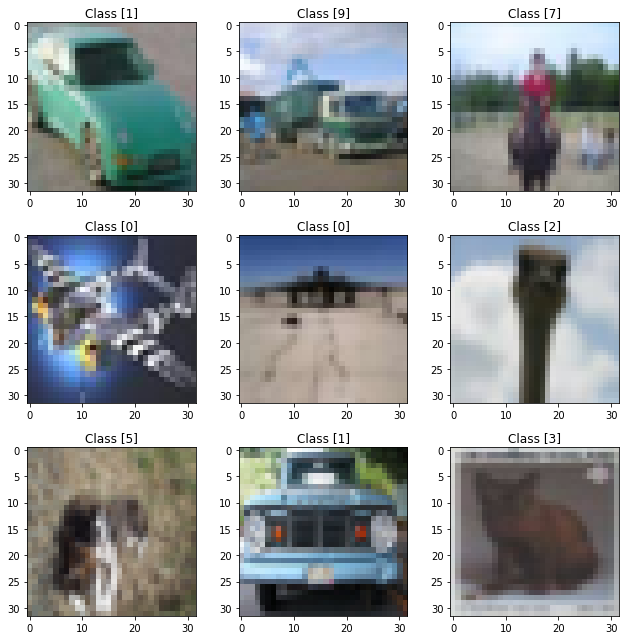

In [ ]:
import random
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(train_images))
    plt.imshow(train_images[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(train_labels[num]))
                         
for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(test_images))
    plt.imshow(test_images[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(test_labels[num]))       
    
plt.tight_layout()
plt.savefig('CIFAR-10.png')

Normalize and reshape the training and test images

In [ ]:
train_images = (train_images.reshape(train_images.shape[0], -1).astype(np.float32)) / 255
test_images = (test_images.reshape(test_images.shape[0], -1).astype(np.float32)) / 255

In [ ]:
print(train_images.shape) # (50000, 3072)
print(test_images.shape)  # (10000, 3072)

(50000, 3072)
(10000, 3072)


In [ ]:
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)
print(train_labels.shape) # (50000, 10)
print(test_labels.shape)  # (50000, 10)

(50000, 10)
(10000, 10)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
data_batch_1 = unpickle("/content/gdrive/MyDrive/cifar-10-batches-py/data_batch_1")
data_batch_2 = unpickle("/content/gdrive/MyDrive/cifar-10-batches-py/data_batch_2")
data_batch_3 = unpickle("/content/gdrive/MyDrive/cifar-10-batches-py/data_batch_3")
data_batch_4 = unpickle("/content/gdrive/MyDrive/cifar-10-batches-py/data_batch_4")
data_batch_5 = unpickle("/content/gdrive/MyDrive/cifar-10-batches-py/data_batch_5")
test_batch = unpickle("/content/gdrive/MyDrive/cifar-10-batches-py/test_batch")

In [ ]:
meta = unpickle("/content/gdrive/MyDrive/cifar-10-batches-py/batches.meta")

In [ ]:
import collections

In [ ]:
meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [ ]:
collections.Counter(data_batch_2[b'labels'])

Counter({1: 1007,
         6: 1008,
         8: 987,
         3: 995,
         4: 1010,
         0: 984,
         5: 988,
         2: 1010,
         7: 1026,
         9: 985})

## Data distribution

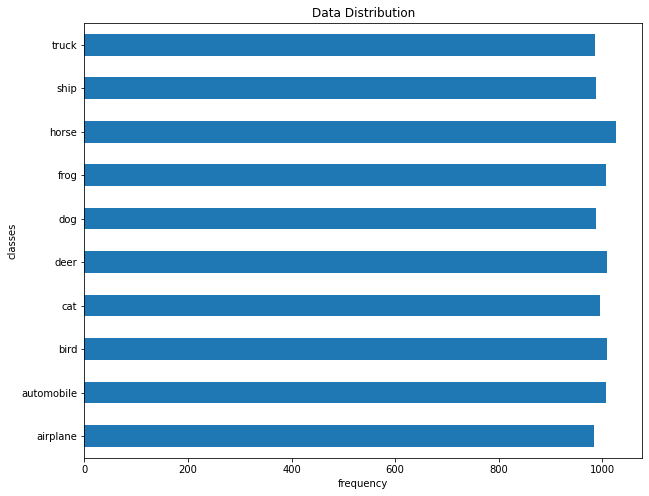

In [ ]:
frequency = collections.Counter(data_batch_2[b'labels'])
m = pd.DataFrame (meta[b'label_names'], columns = ['meta'])
m['labels']=dict(sorted(dict(frequency).items())).values()
m['meta']=[str(x)[2:][:-1] for x in m['meta'].to_list()]

fig, ax = plt.subplots(figsize=(10, 8))  # set the figure size to 8x6 inches
m.plot.barh(x='meta', y='labels', legend=False, ax=ax)
ax.set_xlabel("frequency")
ax.set_ylabel("classes")
plt.title('Data Distribution')
plt.savefig("data_distribution.png")

In [ ]:
def encoding_labels (labels):
  result = np.zeros((len(labels), len(set(labels))))
  for i in range(len(labels)):
    result[i][labels[i]] = 1
  return result

## Data preprocessing functions:

In [ ]:
def mean_subtract (tr_set):
  tr_set -= np.mean(tr_set, axis = 0)
  return tr_set

In [ ]:
def te_mean_subtract (tr_set, te_set):
  te_set = te_set.astype(np.float64)- np.mean(tr_set, axis = 0) #use the mean of training data
  return te_set

In [ ]:
def normalization (tr_set):
  tr_set /= np.std(tr_set, axis = 0)
  return tr_set

In [ ]:
def te_normalization (tr_set, te_set):
  te_set = te_set.astype(np.float64) / np.std(tr_set, axis = 0) #use the std of training data
  return te_set

In [ ]:
def PCA_Whiten (tr_set, dim=100, white_switch = True):
  #will zero-center the data before this function
  #tr_set -= np.mean(tr_set, axis = 0)
  cov = np.dot(tr_set.T, tr_set)/tr_set.shape[0]
  U,S,V = np.linalg.svd(cov)
  tr_rot = np.dot (tr_set, U)
  if white_switch:
    result = tr_rot / np.sqrt(S + 1e-5)#whiten
  else:
    result = np.dot(tr_set, U[:, :dim])#tr_rot is reduced to [N*dim]
  return result
  

In [ ]:
def data_preprocess_normalization (tr_set):
  tr = mean_subtract(tr_set)
  result = normalization(tr)
  return result

In [ ]:
def te_data_preprocess_normalization (tr_set, te_set):
  te = te_mean_subtract(tr_set, te_set)
  result = te_normalization(tr_set, te_set)
  return result

In [ ]:
def data_preprocessing_PCA_Whiten (tr_set, dim = 100, white_switch = True):
  tr = mean_subtract(tr_set)
  result = PCA_Whiten(tr, dim, white_switch)
  return result

##Preprocess Data

### Normalized data

In [ ]:
norm_tr_data = data_preprocess_normalization(all_tr_batch['tr_data'])

In [ ]:
norm_te_data = te_data_preprocess_normalization(all_tr_batch['tr_data'], test_batch[b'data'])

In [ ]:
norm_tr_data

In [ ]:
norm_te_data

### Whitened training data

In [ ]:
n_data = data_preprocessing_PCA_Whiten(all_tr_batch['tr_data'])

In [ ]:
len(n_data)

In [ ]:
n_data.shape

# Task2. Modeling

## Activation funtions

In [ ]:
logistic = lambda z: 1./ (1 + np.exp(-z))
relu = lambda z: np.maximum(0, z)
tanh = lambda z: 2*logistic(z)-1
leaky = lambda z: relu(z)+ 0.1*np.minimum(0, z)

def relu_grad (z):
  #N*M+1
  for i in range(len(z)):
    for j in range(len(z[i])):
      if z[i][j] > 0:
        z[i][j] = 1
      else:
        z[i][j] = 0
  return z

In [ ]:
def tanh_grad (q):
  logistic = 1./ (1 + np.exp(-q))
  tanh = 2*logistic-1

  return 1-np.square(tanh)

In [ ]:
def leaky_grad (q, a):
  q = np.where(q <= 0, q, 1)
  # print(q)

  q = np.where(q > 0, q, a)
  # print(q)
  return q


a = np.array([[0, -9, 2],
              [0, -1, 4],
              [-1, 3, 6]])
leaky_grad(a, 0.1)

array([[0.1, 0.1, 1. ],
       [0.1, 0.1, 1. ],
       [0.1, 1. , 1. ]])

In [ ]:
def relu_grad2 (q):
  q = np.where(q <= 0, q, 1)
  # print(q)

  q = np.where(q > 0, q, 0)
  # print(q)
  return q

In [ ]:
def softmax(x):
  #x: N * C
  for i in range(len(x)):
    exp_xi = np.exp(x[i])
    x[i] = exp_xi/np.sum(exp_xi)
  return x

## Multilayer MLP Model

In [ ]:
class MLP_2:
    ## activation = relu is the same for all hidden layers
    def __init__(self, M = [64], n_hidden = 1, activation = relu, add_bias = True,
                 L1_lambda = 0, L2_lambda = 0.1):
        self.M = M
        self.n_hidden = n_hidden
        self.activation = activation
        self.add_bias = add_bias
        self.L1_lambda = L1_lambda
        self.L2_lambda = L2_lambda
        self.acc_history = []
        self.D = 3072
        self.C = 10





        #### initialize w's and v
        if self.n_hidden > 0:
            params0 = []
            if self.add_bias:
                v = np.random.randn(self.D+1,self.M[0]) *  .05        #  (D+1*M[0])
                params0.append(v)
            else:
                v = np.random.randn(self.D,self.M[0]) *  .05        #  (D+1*M[0])
                params0.append(v)
            
            for i in range(self.n_hidden-1):
              # if self.add_bias:
              #   wi = np.random.randn(self.M[i]+1, self.M[i+1]) * .01  #(M+1*C)\
              # else:
              wi = np.random.randn(self.M[i], self.M[i+1]) * .05
              params0.append(wi)
            # if self.add_bias:
            #   w = np.random.randn(self.M[-1]+1, C) * .01 #(M+1*C)
            # else:
            w = np.random.randn(self.M[-1], self.C)* .05
            params0.append(w)
        else:
            params0 = []
            if self.add_bias:
                v = np.random.randn(self.D+1,self.C) *  .05        #  (D+1*M[0])
                params0.append(v)
            else:
                v = np.random.randn(self.D,self.C) *  .05        #  (D+1*M[0])
                params0.append(v)
        
        self.params = params0


            
    def fit(self, x, y, optimizer): 
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
            N,D = x.shape      #x: 50000, 3073; y: 50000, 1
            C = y.shape[1]
        
        def gradient(x, y, params):
            if self.n_hidden > 0:
                #print(params)
                v = params[0]                     # v: D+1 * M;   w: M+1 x C

                ##### the input layer
                q = np.dot(x, v)                # q: N x M
                # if self.add_bias:
                #   adb = q.shape[0]
                #   q = np.column_stack([q,np.ones(adb)]) #z: N x M+1

                
                ###### the hidden layers
                Z_list = []
                Z_list.append(x)
                z = self.activation(q)            # the first hidden layer
                Z_list.append(z)

                for i in range(self.n_hidden-1):  # second onwards
                  zi = self.activation(np.dot(Z_list[i+1], params[i+1])) 
                  #print(zi)
                  # if self.add_bias:
                  #   adb = zi.shape[0]
                  #   zi = np.column_stack([zi,np.ones(adb)])
                  Z_list.append(zi)

                #print(Z_list)

                ###### the output layer
                u = np.dot(Z_list[-1], params[-1])           # u: N x C; Zlist[-1]: 50000x64, params[-1]:65 x10
                yh = softmax(u)        #yh: N x C
                
                print(yh)
                yh_labels = decoding_labels(self.predict(test_images))
                acc = accuracy(yh_labels, np.argmax(test_labels, axis=1))
                self.acc_history.append(acc)
                print(f'acc: {acc:.4f}')
                print('\n')

                #print(yh.shape)
                dy = yh - y #dy: N * C
                #print(dy)

                dparams = []
                dw = np.dot(Z_list[-1].T, dy)/N #dw: M+1 * C
                if self.L1_lambda > 0:
                    dL1 = np.ones_like(params[-1])
                    dL1[params[-1] < 0] = -1
                    dw += self.L1_lambda * dL1

                if self.L2_lambda > 0:
                    dw += 2*self.L2_lambda * params[-1]
                    #print(dw.shape)
                dparams.append(dw)

                dz_list = []
                dz_list.append(dy)
                #dz_list[self.n_hidden] = dy

                for i in range(self.n_hidden,0,-1):
                  # print(i)
                  dz = np.dot(dz_list[self.n_hidden-i], params[i].T)
                  #dz_list[i-1] = dz
                  dz_list.append(dz)
                  # print(dz.shape)
                  # print(Z_list[i-1].T.shape)
                  # print(Z_list[i].shape)
                  if self.activation == relu:
                      dw = np.dot(Z_list[i-1].T, dz * relu_grad2(Z_list[i]))/N
                  if self.activation == tanh:
                      dw = np.dot(Z_list[i-1].T, dz * tanh_grad(Z_list[i]))/N
                  if self.activation == leaky:
                      dw = np.dot(Z_list[i-1].T, dz * leaky_grad(Z_list[i], 0.1))/N

                  if self.L1_lambda > 0:
                    dL1 = np.ones_like(params[i-1])
                    dL1[params[i-1] < 0] = -1
                    #print(dL1)
                    dw += self.L1_lambda * dL1

                  if self.L2_lambda > 0:
                    dw += 2*self.L2_lambda * params[i-1]

                  dparams.append(dw)

            else:
                v = params[0]                     # v: D+1 * M;   w: M+1 x C
                q = np.dot(x, v)                # q: N x M
                yh = softmax(q)
                print(yh) 

                yh_labels = decoding_labels(self.predict(test_images))   #this can make program slow
                acc = accuracy(yh_labels, np.argmax(test_labels, axis=1))
                self.acc_history.append(acc)
                print(f'acc: {acc:.4f}')
                print('\n')

                dy = yh - y 
                dparams = []
                dw = np.dot(x.T, dy)/N #dw: M+1 * C
                if self.L1_lambda > 0:
                    dL1 = np.ones_like(v)
                    dL1[v < 0] = -1
                    dw += self.L1_lambda * dL1

                if self.L2_lambda > 0:
                    dw += 2*self.L2_lambda * v
                dparams.append(dw)
  
            return dparams        

        self.params = optimizer.run(gradient, x, y, self.params)


        return self
    
    def predict(self, x):
        if self.add_bias:
          N = x.shape[0]
          x = np.column_stack([x,np.ones(N)])
        
        
        # v, w = self.params
        # z = self.activation(np.dot(x, v)) #N x M
        # if self.add_bias:
        #   n = z.shape[0]
        #   z = np.column_stack([z, np.ones(n)])
        
        
        zi = x
        for i in (range(self.n_hidden)):
          # print(self.params[i].shape)
          zi = self.activation(np.dot(zi, self.params[i]))

          # if self.add_bias:
          #   n = zi.shape[0]
          #   zi = np.column_stack([zi, np.ones(n)])
          # print(zi.shape)
        yh = softmax(np.dot(zi, self.params[-1]))#N * C

        
        return yh

In [ ]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        
    def run(self, gradient_fn, x, y, params):
        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            print(t)
            grad = gradient_fn(x, y, params)
            #print("the shape of db is")
            ##print(db[p].shape)
            #print("the shape of biases is")
            #print(len(biases))
            for p in range(len(params)):
              #print(params[p].shape)
              #print(grad[len(grad)-1-p].shape)
              params[p] -= self.learning_rate * grad[len(grad)-1-p]

              # if (p == len(params)-1) :
              #   params[p] -= self.learning_rate * grad[len(grad)-1-p]
              # else:
              #   params[p] -= self.learning_rate * grad[len(grad)-1-p][:,:-1]
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        return params

## Accuracy

In [ ]:
def decoding_labels(labels): 
  result = np.zeros(labels.shape[0])
  for i in range(len(labels)):
    result[i]=np.argmax(labels[i])
  return result

In [ ]:
def accuracy (yh, y):
  t = 0
  for i in range(len(y)):
    if y[i] == yh[i]:
      t += 1
  return t/len(y)

# Task3. Experiments

## Task3.1

In [ ]:
import optuna

### No hidden layer

In [ ]:
def objective(trial):
    # Define the search space for the hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    #L2_lambda = trial.suggest_float("L2_lambda", 1e-6, 1e-2, log=True)

    # Create the MLP_2 model with the given hyperparameters
    model_no_hidden = MLP_2(M=[], n_hidden = 0, L2_lambda = 0)
    optimizer = GradientDescent(learning_rate=learning_rate, max_iters=5)

    # Train the model and compute its validation accuracy
    yh_no_hidden = model_no_hidden.fit(train_images, train_labels, optimizer)
    val_acc = yh_no_hidden.acc_history[-1]

    return val_acc

# Define the search method and run the optimization process
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Print the best hyperparameters found by Optuna
print("Best hyperparameters: ", study.best_params)

[I 2023-03-09 03:48:49,698] A new study created in memory with name: no-name-c780f08f-09d2-4ee1-a987-215d10737eeb


1
[[0.07357845 0.08561907 0.14199628 ... 0.03770425 0.02969526 0.0983119 ]
 [0.10081991 0.10222848 0.01341415 ... 0.02064111 0.03187796 0.13038523]
 [0.01284238 0.50065119 0.02858949 ... 0.0218418  0.02401392 0.03024694]
 ...
 [0.02099196 0.43311225 0.04154205 ... 0.01650912 0.03526598 0.02680189]
 [0.00551324 0.42093417 0.0247849  ... 0.01110878 0.00798465 0.01491687]
 [0.0389097  0.40495828 0.02738151 ... 0.02120364 0.00855643 0.06434484]]
acc: 0.1063


2
[[0.08655452 0.064074   0.16124754 ... 0.04449109 0.03585034 0.11009863]
 [0.1373934  0.07769541 0.01733446 ... 0.02790959 0.04498052 0.16701549]
 [0.02051854 0.42039594 0.04278563 ... 0.0343124  0.03967463 0.04571326]
 ...
 [0.03023172 0.3766766  0.05671264 ... 0.02338093 0.05221535 0.03691455]
 [0.01084569 0.37875685 0.04523874 ... 0.02152283 0.01639779 0.02711682]
 [0.05991104 0.33655009 0.03983486 ... 0.03239654 0.01356525 0.09316105]]
acc: 0.1030


3
[[0.09549116 0.05004977 0.17154337 ... 0.04967641 0.04107246 0.1151322 ]
 [0.1

[I 2023-03-09 03:48:58,908] Trial 0 finished with value: 0.0954 and parameters: {'learning_rate': 0.0026337088662295063}. Best is trial 0 with value: 0.0954.


1
[[1.94136545e-01 1.50570006e-02 1.97294413e-03 ... 2.06856006e-01
  3.29081382e-01 1.66423088e-01]
 [2.65235059e-01 9.13164476e-03 7.65760697e-04 ... 1.17185039e-01
  2.21450690e-01 2.64523253e-01]
 [2.56286528e-01 1.40723558e-03 9.99783061e-04 ... 1.34490024e-02
  2.16688214e-01 4.52473329e-01]
 ...
 [4.11557042e-01 6.38970892e-03 4.25879793e-03 ... 3.67852824e-02
  1.48169114e-01 2.74047429e-01]
 [1.82443664e-01 1.13575844e-03 2.61329844e-04 ... 3.47487694e-02
  3.46695204e-01 3.91364902e-01]
 [2.90178141e-01 1.10305960e-02 6.24687087e-04 ... 1.57422763e-01
  1.75959297e-01 3.13452014e-01]]
acc: 0.1058


2
[[1.53013214e-03 2.57313850e-01 4.48225333e-02 ... 6.51686649e-02
  5.13770144e-04 1.87377781e-03]
 [4.81046637e-04 2.53598357e-01 2.73258971e-02 ... 2.07992845e-02
  6.28919331e-05 7.00924876e-04]
 [4.84035681e-04 7.23099940e-02 6.13464510e-02 ... 3.93623704e-03
  7.19449981e-05 1.44840516e-03]
 ...
 [2.38564210e-03 1.08360568e-01 8.01123480e-02 ... 1.03397386e-02
  2.37040818e-

[I 2023-03-09 03:49:05,932] Trial 1 finished with value: 0.1437 and parameters: {'learning_rate': 0.05858283241618855}. Best is trial 1 with value: 0.1437.


1
[[0.0460384  0.05017518 0.24207971 ... 0.21160331 0.04368034 0.13423644]
 [0.02222823 0.16340556 0.19080793 ... 0.20185573 0.03014313 0.07112958]
 [0.01069206 0.06098734 0.45637951 ... 0.21809685 0.03345891 0.08011457]
 ...
 [0.03695203 0.05324925 0.52471963 ... 0.08546806 0.02213298 0.06607123]
 [0.01230596 0.07643411 0.14872076 ... 0.30788944 0.06180532 0.07260846]
 [0.01413943 0.11405838 0.29089257 ... 0.22352653 0.02597109 0.04027318]]
acc: 0.1011


2
[[0.04734395 0.05105139 0.23876858 ... 0.20606969 0.04462154 0.13563365]
 [0.02298197 0.1665637  0.18692378 ... 0.19466443 0.03091824 0.07193673]
 [0.01121752 0.06299361 0.45125165 ... 0.21257542 0.03481594 0.08224851]
 ...
 [0.03822978 0.05440956 0.51813678 ... 0.08343631 0.02275412 0.06719464]
 [0.01292675 0.07875941 0.14541615 ... 0.29518143 0.06424819 0.07413487]
 [0.014724   0.11701517 0.286391   ... 0.21675607 0.02681261 0.0410321 ]]
acc: 0.1005


3
[[0.048652   0.05189816 0.23547566 ... 0.20084486 0.04554434 0.13692215]
 [0.0

[I 2023-03-09 03:49:14,516] Trial 2 finished with value: 0.1007 and parameters: {'learning_rate': 0.000307095355054693}. Best is trial 1 with value: 0.1437.


1
[[4.09494448e-02 2.58407239e-01 9.19619525e-02 ... 1.21165045e-02
  6.45557510e-02 1.17159184e-01]
 [2.29668145e-02 5.31010107e-01 9.48127305e-02 ... 2.45909246e-03
  3.00427488e-03 1.18459173e-01]
 [2.14601433e-03 1.09924808e-01 6.78494177e-01 ... 3.32862834e-04
  1.89712544e-03 2.07773100e-02]
 ...
 [7.32555357e-03 8.45335018e-02 5.70043015e-01 ... 2.42494826e-03
  2.80503064e-03 2.79822568e-02]
 [2.36700153e-03 1.63826028e-01 3.74949741e-01 ... 7.19727669e-04
  2.03393141e-03 2.87207745e-02]
 [5.73319336e-03 1.87261586e-01 1.85421529e-01 ... 2.83557148e-03
  2.70124805e-02 1.08589153e-01]]
acc: 0.0994


2
[[5.33894083e-02 2.32644483e-01 9.59405139e-02 ... 1.57846392e-02
  8.28612582e-02 1.29226093e-01]
 [3.35818066e-02 4.84783939e-01 1.03042472e-01 ... 3.55603811e-03
  4.32576484e-03 1.40645224e-01]
 [3.10556992e-03 9.63683960e-02 7.02838702e-01 ... 4.73760329e-04
  2.70633896e-03 2.45096622e-02]
 ...
 [9.77432820e-03 7.60974030e-02 5.83738972e-01 ... 3.18215779e-03
  3.70527571e-

[I 2023-03-09 03:49:22,153] Trial 3 finished with value: 0.0882 and parameters: {'learning_rate': 0.0023690649191753146}. Best is trial 1 with value: 0.1437.


1
[[0.24745933 0.0410953  0.03521872 ... 0.15368713 0.01900054 0.39663013]
 [0.08228221 0.0303912  0.11228618 ... 0.12231012 0.04597094 0.5521187 ]
 [0.01637029 0.00294156 0.31552767 ... 0.01209505 0.05968493 0.57512752]
 ...
 [0.02552022 0.00347601 0.15593199 ... 0.02101534 0.08020066 0.66333311]
 [0.06354434 0.00263307 0.06632922 ... 0.03124109 0.02123554 0.79883577]
 [0.08115598 0.00360929 0.0261266  ... 0.02460023 0.06974025 0.7707133 ]]
acc: 0.0975


2
[[0.24861058 0.04132535 0.03537121 ... 0.15443634 0.01910574 0.39363392]
 [0.08297783 0.03068182 0.1131649  ... 0.12335831 0.04641073 0.54824632]
 [0.0165274  0.00297303 0.31826854 ... 0.01221152 0.06032382 0.57125271]
 ...
 [0.02573813 0.00350856 0.15714347 ... 0.02119399 0.08095514 0.66047812]
 [0.06458001 0.00267963 0.06734779 ... 0.03175342 0.02161186 0.79556318]
 [0.08214412 0.0036572  0.02642742 ... 0.02490363 0.07066321 0.76783203]]
acc: 0.0973


3
[[0.24975025 0.04155433 0.03552195 ... 0.15517933 0.01921036 0.39066151]
 [0.0

[I 2023-03-09 03:49:31,701] Trial 4 finished with value: 0.0971 and parameters: {'learning_rate': 3.4902239023674916e-05}. Best is trial 1 with value: 0.1437.


1
[[0.03255281 0.10112083 0.17612478 ... 0.00572092 0.59881635 0.02396664]
 [0.03434363 0.17773057 0.19292699 ... 0.00376754 0.29029456 0.07896386]
 [0.11314942 0.01720713 0.15141507 ... 0.01077822 0.57640541 0.02649923]
 ...
 [0.11732913 0.02075822 0.12419678 ... 0.04782533 0.44382586 0.03937668]
 [0.12929193 0.10424084 0.25447704 ... 0.00173457 0.38781624 0.03533237]
 [0.05304684 0.03310558 0.13455151 ... 0.0009817  0.63919507 0.01615288]]
acc: 0.0915


2
[[0.04560286 0.13612971 0.19066817 ... 0.00863412 0.49831911 0.0349979 ]
 [0.04276742 0.21022818 0.1723797  ... 0.00510874 0.18885894 0.10367383]
 [0.17124902 0.02473923 0.16084439 ... 0.01779289 0.43631059 0.04286656]
 ...
 [0.14994926 0.02546501 0.11998277 ... 0.06520431 0.33096029 0.05296203]
 [0.19082769 0.14356448 0.24279976 ... 0.00285566 0.24367291 0.05602386]
 [0.08300747 0.04908396 0.14986197 ... 0.00167816 0.50788338 0.02674884]]
acc: 0.0874


3
[[0.05547968 0.16009358 0.1860534  ... 0.01171328 0.43640358 0.04532714]
 [0.0

[I 2023-03-09 03:49:45,406] Trial 5 finished with value: 0.0829 and parameters: {'learning_rate': 0.002453398546542414}. Best is trial 1 with value: 0.1437.


1
[[1.54920563e-01 4.66565987e-01 1.19435862e-01 ... 4.60040149e-03
  1.40311982e-02 1.80716321e-01]
 [2.54397235e-02 4.81652878e-02 7.72386071e-01 ... 5.85659982e-04
  6.22052646e-03 8.25665559e-02]
 [3.57844317e-02 5.21347122e-02 7.65965656e-01 ... 4.98485049e-03
  6.18028805e-03 4.54299631e-02]
 ...
 [7.96392338e-02 1.72395722e-01 5.92443327e-01 ... 9.10503805e-03
  1.03820569e-02 5.79546442e-02]
 [1.25300971e-01 3.90421498e-02 7.35500428e-01 ... 4.53219606e-04
  4.62432691e-03 4.21463750e-02]
 [1.01551262e-01 4.20994334e-02 6.51590289e-01 ... 6.38133153e-03
  2.30510456e-03 1.09568169e-01]]
acc: 0.0935


2
[[2.56828559e-02 1.16028538e-04 4.78315563e-08 ... 1.07156343e-01
  3.43416227e-01 4.52512141e-02]
 [2.82333122e-03 1.59279823e-06 3.24733768e-09 ... 2.20629703e-02
  3.80249960e-01 1.47137218e-02]
 [3.22357033e-03 1.40462051e-06 3.10186231e-10 ... 1.62458923e-01
  4.02404896e-01 9.12462499e-03]
 ...
 [1.65841176e-02 5.71294685e-05 3.33025645e-08 ... 1.69261724e-01
  3.85789661e-

[I 2023-03-09 03:49:54,460] Trial 6 finished with value: 0.1069 and parameters: {'learning_rate': 0.07868750837680576}. Best is trial 1 with value: 0.1437.


1
[[0.07673463 0.0414059  0.22387928 ... 0.06396191 0.34507185 0.06249065]
 [0.090339   0.00848231 0.04212235 ... 0.02135111 0.67746714 0.02169596]
 [0.02208265 0.04648438 0.11435024 ... 0.14604006 0.37005448 0.04730693]
 ...
 [0.02014641 0.06865711 0.21092409 ... 0.16059387 0.26089611 0.08033297]
 [0.05432945 0.02904573 0.08915018 ... 0.08404733 0.57164712 0.05091429]
 [0.08726071 0.03934487 0.13118677 ... 0.06088946 0.39452438 0.06538364]]
acc: 0.0996


2
[[0.07891924 0.04264998 0.22694993 ... 0.06525871 0.33186711 0.06407258]
 [0.09592042 0.00901788 0.04386891 ... 0.02241165 0.66113865 0.02293864]
 [0.02302843 0.0485093  0.11668895 ... 0.15031365 0.35282189 0.04915054]
 ...
 [0.02066937 0.07046519 0.21268211 ... 0.16300724 0.2495628  0.08216035]
 [0.05817756 0.03113326 0.09302325 ... 0.08860555 0.54789078 0.05422061]
 [0.09083734 0.04098954 0.13384519 ... 0.06264574 0.37630479 0.06778283]]
acc: 0.1000


3
[[0.08102622 0.04386266 0.22962855 ... 0.06645885 0.31957765 0.06558022]
 [0.1

[I 2023-03-09 03:50:03,208] Trial 7 finished with value: 0.1009 and parameters: {'learning_rate': 0.00028566205446664604}. Best is trial 1 with value: 0.1437.


1
[[0.06172869 0.09625789 0.01199227 ... 0.00955273 0.20368186 0.00665139]
 [0.13098664 0.26140464 0.01008759 ... 0.03848339 0.15085474 0.01335651]
 [0.07708595 0.09091733 0.01118573 ... 0.03114128 0.38174017 0.08022207]
 ...
 [0.08427395 0.10712306 0.02734389 ... 0.07893647 0.2039626  0.10014989]
 [0.08904104 0.0302096  0.00416701 ... 0.01182824 0.2978103  0.03516223]
 [0.26675274 0.03562545 0.00684805 ... 0.02238892 0.25666406 0.02378483]]
acc: 0.1343


2
[[0.06175636 0.09636186 0.01201229 ... 0.0095675  0.20351151 0.00666176]
 [0.1310135  0.26165764 0.01010456 ... 0.03854168 0.15064099 0.01337768]
 [0.07710763 0.09101521 0.01120587 ... 0.03119209 0.38118812 0.08036615]
 ...
 [0.08427646 0.10719122 0.02737661 ... 0.07901994 0.20369312 0.10027006]
 [0.08912653 0.03026809 0.00417897 ... 0.01185963 0.29746061 0.0352598 ]
 [0.26687627 0.03567036 0.0068617  ... 0.02243008 0.25635902 0.02383048]]
acc: 0.1345


3
[[0.06178393 0.09646576 0.01203233 ... 0.00958228 0.20334165 0.00667213]
 [0.1

[I 2023-03-09 03:50:14,401] Trial 8 finished with value: 0.1348 and parameters: {'learning_rate': 1.6119709128725225e-05}. Best is trial 1 with value: 0.1437.


1
[[4.39432777e-01 4.19050461e-02 2.23331907e-02 ... 1.13718260e-02
  4.47166696e-03 1.72896623e-02]
 [3.59987723e-01 1.93486264e-02 5.39544563e-03 ... 2.30680810e-02
  9.48837475e-04 8.39960488e-03]
 [6.75170311e-01 1.46002774e-02 1.29853469e-02 ... 1.13205610e-02
  9.36570323e-04 4.12084419e-02]
 ...
 [2.49744541e-01 1.69522717e-02 1.57770335e-02 ... 1.51961643e-02
  1.75992915e-03 1.31842176e-02]
 [6.48656176e-01 1.62860105e-02 5.12994654e-03 ... 3.52161513e-03
  5.03603634e-04 1.57894143e-02]
 [2.55439888e-01 4.99559753e-02 1.45885180e-02 ... 1.19946546e-02
  1.72513470e-03 4.32937014e-02]]
acc: 0.1058


2
[[0.18097831 0.08671457 0.05266554 ... 0.02697025 0.01163485 0.03974732]
 [0.1079473  0.04490144 0.01451738 ... 0.06226636 0.00300098 0.02243977]
 [0.242525   0.04869954 0.04975022 ... 0.04386214 0.00434952 0.1644449 ]
 ...
 [0.08997684 0.03462748 0.0357864  ... 0.03466428 0.00469875 0.03102479]
 [0.18932877 0.07034272 0.02690529 ... 0.01860672 0.00329248 0.0833635 ]
 [0.06105462

[I 2023-03-09 03:50:22,922] Trial 9 finished with value: 0.1137 and parameters: {'learning_rate': 0.007916542563595795}. Best is trial 1 with value: 0.1437.


1
[[0.03779158 0.11309706 0.0304848  ... 0.24060996 0.20842831 0.07856443]
 [0.02142942 0.11196606 0.0437473  ... 0.30345285 0.33704949 0.06170218]
 [0.01512825 0.1046628  0.07251226 ... 0.42972975 0.14543331 0.05788619]
 ...
 [0.02731891 0.09046419 0.088819   ... 0.2545308  0.09578729 0.08443082]
 [0.01064717 0.14787866 0.04119313 ... 0.41936169 0.17981386 0.03732285]
 [0.01464269 0.23364781 0.03362421 ... 0.46147967 0.05675734 0.08105494]]
acc: 0.0979


2
[[3.66520691e-01 9.11053676e-04 1.94856246e-02 ... 4.60481003e-10
  7.70023366e-02 2.12751425e-02]
 [5.45640426e-01 3.32932307e-04 2.57420858e-02 ... 2.96672289e-12
  1.51742830e-01 1.78301303e-02]
 [4.14968798e-01 2.07569187e-04 2.90429925e-02 ... 7.42784443e-13
  5.79676698e-02 2.05836202e-02]
 ...
 [3.03843566e-01 5.47241369e-04 3.18469296e-02 ... 1.19058884e-10
  4.00943778e-02 2.93870965e-02]
 [6.84904971e-01 5.95774164e-05 1.66044006e-02 ... 1.35906441e-15
  5.85655153e-02 7.42901115e-03]
 [6.12394188e-01 8.36767790e-04 2.9897

[I 2023-03-09 03:50:31,167] Trial 10 finished with value: 0.1149 and parameters: {'learning_rate': 0.09115932558746391}. Best is trial 1 with value: 0.1437.


1
[[0.00474248 0.03938561 0.16113314 ... 0.01972656 0.26400053 0.32170162]
 [0.00285559 0.0716025  0.0323772  ... 0.03434414 0.26077151 0.469167  ]
 [0.00276672 0.00810417 0.00178747 ... 0.05380542 0.17802218 0.66448613]
 ...
 [0.00481477 0.02364345 0.00445615 ... 0.05129728 0.21890119 0.47892904]
 [0.00172439 0.02765509 0.01019696 ... 0.01662514 0.11454839 0.71895989]
 [0.00446981 0.02319868 0.02235284 ... 0.06128913 0.35972849 0.41859772]]
acc: 0.1023


2
[[0.00475029 0.03944    0.16135494 ... 0.01975504 0.26412235 0.3210327 ]
 [0.00286338 0.07177267 0.03245358 ... 0.03442749 0.26110186 0.46823073]
 [0.00277693 0.00813109 0.00179335 ... 0.05398586 0.17841034 0.66360737]
 ...
 [0.00482571 0.02369012 0.00446483 ... 0.05139933 0.21914153 0.47813669]
 [0.00173268 0.02777496 0.01024098 ... 0.01669832 0.11488125 0.71795475]
 [0.00448184 0.02325261 0.02240456 ... 0.06143567 0.36015185 0.41769849]]
acc: 0.1023


3
[[0.00475808 0.03949433 0.16157647 ... 0.01978349 0.26424295 0.3203658 ]
 [0.0

[I 2023-03-09 03:50:39,181] Trial 11 finished with value: 0.1021 and parameters: {'learning_rate': 1.101510680913672e-05}. Best is trial 1 with value: 0.1437.


1
[[0.09281471 0.03102    0.04088679 ... 0.01777637 0.12883028 0.32808989]
 [0.02827226 0.01846239 0.00485918 ... 0.0080433  0.08233469 0.31040578]
 [0.01145876 0.00685624 0.00813239 ... 0.01040329 0.40072191 0.28994242]
 ...
 [0.0335517  0.01471975 0.01123295 ... 0.01057467 0.21973005 0.3275644 ]
 [0.01390387 0.0066681  0.00579948 ... 0.00593202 0.48205275 0.13335788]
 [0.03820923 0.01165482 0.00771354 ... 0.00325124 0.50938577 0.09749487]]
acc: 0.0792


2
[[0.09325337 0.03116035 0.04107921 ... 0.01786132 0.12859974 0.32679899]
 [0.02844904 0.01857171 0.00488868 ... 0.00809262 0.08217534 0.30897563]
 [0.01155396 0.00691035 0.00819737 ... 0.01048735 0.40050833 0.2891168 ]
 ...
 [0.03375622 0.01480434 0.01129808 ... 0.01063656 0.21956402 0.32668487]
 [0.01403322 0.0067266  0.00585162 ... 0.00598587 0.48130934 0.13271373]
 [0.03848032 0.01173271 0.00776663 ... 0.00327397 0.50860001 0.09711311]]
acc: 0.0786


3
[[0.09369195 0.03130066 0.04127168 ... 0.0179463  0.12836809 0.32551677]
 [0.0

[I 2023-03-09 03:50:48,137] Trial 12 finished with value: 0.0782 and parameters: {'learning_rate': 4.671453356314812e-05}. Best is trial 1 with value: 0.1437.


1
[[0.30988459 0.08077979 0.10188519 ... 0.03344943 0.09777493 0.13287326]
 [0.38568427 0.02897197 0.06988149 ... 0.014824   0.12579541 0.08824744]
 [0.31130363 0.17529844 0.11931661 ... 0.01680186 0.07007116 0.03773019]
 ...
 [0.19208817 0.18100124 0.09954407 ... 0.01702159 0.0563253  0.04641088]
 [0.12630322 0.08397532 0.12679747 ... 0.04043287 0.17095292 0.14787689]
 [0.07080411 0.31223706 0.1272887  ... 0.01432451 0.23307503 0.04590262]]
acc: 0.0700


2
[[0.15302236 0.07864967 0.1246348  ... 0.08335182 0.0415821  0.18672443]
 [0.1716287  0.02987024 0.09303399 ... 0.04800547 0.04928889 0.14983813]
 [0.14208114 0.18228779 0.1596519  ... 0.05965418 0.02783846 0.07684267]
 ...
 [0.09095473 0.16337585 0.10852691 ... 0.03937143 0.02449746 0.07066706]
 [0.03487958 0.06531442 0.139957   ... 0.14466531 0.03917928 0.23845817]
 [0.0312425  0.29469528 0.16226638 ... 0.04679039 0.08083008 0.07928516]]
acc: 0.0703


3
[[0.19974887 0.06843739 0.09793552 ... 0.10264939 0.05950781 0.13542927]
 [0.2

[I 2023-03-09 03:50:58,818] Trial 13 finished with value: 0.0762 and parameters: {'learning_rate': 0.017062113257713486}. Best is trial 1 with value: 0.1437.


1
[[0.29332837 0.04582601 0.10625618 ... 0.01454037 0.05388252 0.07889987]
 [0.40566712 0.04024655 0.05334778 ... 0.00485963 0.04032256 0.02259367]
 [0.28641661 0.00770072 0.08455897 ... 0.00293567 0.0072052  0.03457928]
 ...
 [0.31005444 0.00551967 0.05069902 ... 0.00300753 0.00891531 0.02895876]
 [0.40510884 0.00718345 0.1287993  ... 0.00074497 0.00730104 0.00586674]
 [0.48243979 0.00304661 0.09962921 ... 0.00157005 0.0165517  0.01958333]]
acc: 0.1044


2
[[0.28702269 0.04697774 0.10751877 ... 0.01496852 0.05512289 0.08086877]
 [0.39811282 0.04188564 0.05459481 ... 0.00508021 0.04190498 0.02351889]
 [0.28051369 0.00802833 0.08656097 ... 0.0030735  0.0075044  0.03610556]
 ...
 [0.30571163 0.00571438 0.05173682 ... 0.00312305 0.00922604 0.03001674]
 [0.39642567 0.00758993 0.13313584 ... 0.00079179 0.00770366 0.00620479]
 [0.47393145 0.00317784 0.10216682 ... 0.0016459  0.01723307 0.02044336]]
acc: 0.1053


3
[[0.28102215 0.04812709 0.10870586 ... 0.01540081 0.05634908 0.08283007]
 [0.3

[I 2023-03-09 03:51:07,757] Trial 14 finished with value: 0.1045 and parameters: {'learning_rate': 0.00030836799554452804}. Best is trial 1 with value: 0.1437.


1
[[6.59854586e-02 2.87269812e-03 3.21313472e-01 ... 1.58775205e-01
  5.69474699e-02 2.36980235e-02]
 [9.26850601e-02 2.09853232e-03 3.11420899e-01 ... 1.52280144e-01
  9.83283640e-03 4.00023651e-02]
 [6.40506470e-02 8.92066791e-04 4.38826603e-02 ... 2.95433219e-01
  1.97430625e-01 2.68486264e-02]
 ...
 [6.37741605e-02 6.21458713e-03 7.10156585e-02 ... 1.85518224e-01
  2.09508954e-01 6.22402623e-02]
 [2.13248691e-01 3.48366432e-04 8.57471294e-02 ... 7.54355772e-02
  5.26959920e-02 1.92497945e-02]
 [4.75614755e-01 1.49098227e-03 5.96745456e-02 ... 1.34137344e-01
  7.52753653e-02 1.81328526e-02]]
acc: 0.0993


2
[[0.07165851 0.00678215 0.29940025 ... 0.08937607 0.09586512 0.04563378]
 [0.10907086 0.00639706 0.29081304 ... 0.07424411 0.02028528 0.09558262]
 [0.06867707 0.00256817 0.03715452 ... 0.11884002 0.3791395  0.0634135 ]
 ...
 [0.06123343 0.01280975 0.05550693 ... 0.08156382 0.31856138 0.10973608]
 [0.24075063 0.00133844 0.07201357 ... 0.02636102 0.12322197 0.055471  ]
 [0.48996006

[I 2023-03-09 03:51:17,066] Trial 15 finished with value: 0.1125 and parameters: {'learning_rate': 0.011782202125235109}. Best is trial 1 with value: 0.1437.


1
[[1.22363006e-02 2.25653582e-01 1.52010197e-02 ... 1.64504362e-01
  2.95254529e-01 1.73623956e-02]
 [9.66160038e-03 6.56532341e-01 3.13979323e-02 ... 1.61195324e-02
  1.24334356e-01 2.69867750e-02]
 [6.22105454e-04 7.85445504e-01 2.96757991e-02 ... 8.54917104e-02
  5.91307894e-02 9.15085123e-03]
 ...
 [3.03054261e-03 7.41836725e-01 1.78386484e-02 ... 2.88520729e-02
  7.21338019e-02 7.12330702e-02]
 [1.51970364e-03 8.09430203e-01 3.60495482e-02 ... 1.30391003e-02
  1.24751461e-01 2.82197595e-03]
 [4.76118935e-03 3.90395272e-01 9.96782615e-02 ... 2.28963210e-01
  1.53628346e-01 2.28571430e-02]]
acc: 0.0951


2
[[0.01366159 0.18328623 0.01667578 ... 0.17412208 0.29836024 0.01921462]
 [0.01271521 0.57503135 0.0402772  ... 0.01978677 0.1448157  0.03510643]
 [0.00088037 0.7178527  0.04075569 ... 0.11215792 0.07386312 0.01283277]
 ...
 [0.00391881 0.68047103 0.02250972 ... 0.03513409 0.08462063 0.09140838]
 [0.00236584 0.73639043 0.05418105 ... 0.01850995 0.16573897 0.0043293 ]
 [0.00575971

[I 2023-03-09 03:51:28,573] Trial 16 finished with value: 0.0964 and parameters: {'learning_rate': 0.0009114306905817447}. Best is trial 1 with value: 0.1437.


1
[[2.03940502e-02 1.60515541e-01 1.73406755e-01 ... 7.56346705e-03
  3.97211453e-03 4.17403679e-02]
 [3.04334405e-02 1.40458546e-01 4.10038781e-01 ... 3.34527898e-03
  2.62626826e-03 6.02689802e-02]
 [8.96780558e-03 5.64326446e-01 1.48503838e-01 ... 1.30216343e-03
  1.79368227e-03 3.27390114e-04]
 ...
 [2.29962460e-02 6.24022977e-01 9.96645827e-02 ... 3.48790743e-03
  1.08718436e-02 2.46504759e-03]
 [1.23973400e-02 5.09468167e-01 1.59971986e-01 ... 1.07404680e-03
  1.83495584e-03 6.64700032e-03]
 [4.23481139e-02 2.03748981e-01 3.56699531e-01 ... 2.20932920e-03
  3.72445286e-03 3.22510780e-02]]
acc: 0.1177


2
[[0.16569245 0.0081789  0.00584516 ... 0.06465692 0.03911082 0.1279122 ]
 [0.3833012  0.00253459 0.00460965 ... 0.03897512 0.04413551 0.23159613]
 [0.46083884 0.02254344 0.00398742 ... 0.05795848 0.12592213 0.00621592]
 ...
 [0.33623921 0.03245049 0.00387723 ... 0.04325696 0.20615574 0.01614345]
 [0.50240921 0.00332714 0.00061349 ... 0.03769616 0.10710813 0.06155671]
 [0.46376728

[I 2023-03-09 03:51:36,814] Trial 17 finished with value: 0.1026 and parameters: {'learning_rate': 0.0350384084639398}. Best is trial 1 with value: 0.1437.


1
[[0.02791473 0.06264503 0.38892807 ... 0.02523624 0.02096755 0.12417642]
 [0.01558071 0.04415229 0.48800927 ... 0.08679189 0.05066933 0.12270294]
 [0.01120613 0.023407   0.14761883 ... 0.0411409  0.1561125  0.37474552]
 ...
 [0.01456939 0.03219166 0.14873472 ... 0.04508676 0.29232697 0.31533363]
 [0.01429879 0.02984119 0.33657155 ... 0.01819541 0.04708939 0.1699119 ]
 [0.04362708 0.07572772 0.11685068 ... 0.04042091 0.10535036 0.13217142]]
acc: 0.1311


2
[[0.02815663 0.06306505 0.38637257 ... 0.02543135 0.02109313 0.12420489]
 [0.01577475 0.04458599 0.48459032 ... 0.0877342  0.05112998 0.12287833]
 [0.01131559 0.02356951 0.14605811 ... 0.04146523 0.15706821 0.37401211]
 ...
 [0.01467012 0.0323412  0.14737296 ... 0.04532598 0.29352492 0.31459524]
 [0.01451751 0.03019025 0.33316342 ... 0.01843332 0.04759818 0.17003545]
 [0.0439477  0.07607455 0.1154157  ... 0.04065501 0.10574193 0.13166936]]
acc: 0.1310


3
[[0.02839789 0.0634816  0.38385733 ... 0.02562551 0.02121719 0.12422452]
 [0.0

[I 2023-03-09 03:51:44,951] Trial 18 finished with value: 0.1313 and parameters: {'learning_rate': 9.109688741736485e-05}. Best is trial 1 with value: 0.1437.


1
[[0.01613381 0.13748828 0.01793657 ... 0.06900555 0.0427896  0.07780302]
 [0.01029882 0.10671424 0.00770999 ... 0.11216464 0.02139458 0.04492662]
 [0.00689594 0.00837134 0.00111647 ... 0.02679237 0.00076986 0.00155448]
 ...
 [0.01222319 0.00770268 0.00786141 ... 0.11049401 0.00574875 0.00641745]
 [0.00073243 0.00787514 0.00123543 ... 0.02505333 0.00087956 0.0040608 ]
 [0.01248575 0.09978012 0.01003612 ... 0.03694292 0.01001607 0.04741082]]
acc: 0.1008


2
[[0.01617455 0.13778072 0.01798047 ... 0.06914978 0.04289536 0.07798093]
 [0.01033854 0.10707144 0.00773869 ... 0.11253052 0.02147603 0.04508661]
 [0.00693635 0.00841587 0.00112283 ... 0.02693209 0.00077434 0.0015632 ]
 ...
 [0.01227288 0.00773072 0.00789224 ... 0.11088545 0.00577195 0.00644224]
 [0.00073783 0.00792776 0.00124429 ... 0.02521802 0.00088598 0.00408919]
 [0.01254032 0.100163   0.01007858 ... 0.03708245 0.01005915 0.04760456]]
acc: 0.1008


3
[[0.01621527 0.13807265 0.01802435 ... 0.06929372 0.04300105 0.07815864]
 [0.0

[I 2023-03-09 03:51:53,608] Trial 19 finished with value: 0.1009 and parameters: {'learning_rate': 1.0871299782768969e-05}. Best is trial 1 with value: 0.1437.


1
[[0.1164451  0.22032993 0.2021364  ... 0.01925122 0.01967874 0.20783622]
 [0.12870414 0.07022023 0.15561403 ... 0.0755528  0.00900966 0.3882748 ]
 [0.1182941  0.18020903 0.22266313 ... 0.16827438 0.01464675 0.13837157]
 ...
 [0.14400381 0.17220025 0.23148992 ... 0.05102705 0.00590843 0.19117222]
 [0.07370755 0.2214954  0.08713548 ... 0.04109771 0.00274405 0.23221344]
 [0.18287805 0.38979238 0.0989818  ... 0.02693026 0.02130386 0.05870569]]
acc: 0.0983


2
[[0.11489035 0.20896305 0.18268446 ... 0.02658483 0.03100225 0.17419612]
 [0.13026131 0.06671104 0.13877167 ... 0.11362985 0.016524   0.31560871]
 [0.11286339 0.1577557  0.18532147 ... 0.2408675  0.0261767  0.10589277]
 ...
 [0.1450466  0.1622633  0.20848806 ... 0.07010329 0.00976358 0.16133377]
 [0.07625552 0.20767737 0.07607463 ... 0.07083736 0.00616573 0.18029192]
 [0.17951323 0.35375134 0.08561522 ... 0.03990232 0.03804614 0.04662875]]
acc: 0.1000


3
[[0.10721705 0.19434264 0.16693949 ... 0.03222504 0.04458336 0.15631996]
 [0.1

[I 2023-03-09 03:52:01,218] Trial 20 finished with value: 0.1052 and parameters: {'learning_rate': 0.005441816560454482}. Best is trial 1 with value: 0.1437.


1
[[0.02415083 0.10111118 0.22415617 ... 0.03694974 0.09900081 0.03720962]
 [0.02292318 0.09091738 0.14326797 ... 0.01142857 0.16298469 0.01551214]
 [0.01710948 0.00939438 0.06116523 ... 0.005378   0.03049451 0.01229825]
 ...
 [0.03010608 0.03241661 0.06939467 ... 0.01929661 0.043521   0.02764234]
 [0.01839783 0.04871736 0.02671745 ... 0.00104155 0.07525512 0.0029674 ]
 [0.02587336 0.14030713 0.04454503 ... 0.00305788 0.10142363 0.00752134]]
acc: 0.1004


2
[[0.02435321 0.10152397 0.22507288 ... 0.03724952 0.09948436 0.03750199]
 [0.02315347 0.09133489 0.14390053 ... 0.01153587 0.16392975 0.0156576 ]
 [0.01751518 0.0095632  0.06223655 ... 0.00550111 0.03108304 0.01258527]
 ...
 [0.03057387 0.03277428 0.07013399 ... 0.01958172 0.04405031 0.02806252]
 [0.01895675 0.04983888 0.02732632 ... 0.00107219 0.07711768 0.00305511]
 [0.02638995 0.14230168 0.04517316 ... 0.0031171  0.10298789 0.00766703]]
acc: 0.1006


3
[[0.0245546  0.10192445 0.22596185 ... 0.03754784 0.09995648 0.0377926 ]
 [0.0

[I 2023-03-09 03:52:09,804] Trial 21 finished with value: 0.0995 and parameters: {'learning_rate': 7.876019030231614e-05}. Best is trial 1 with value: 0.1437.


1
[[0.01445937 0.01864014 0.01049999 ... 0.15035016 0.05100564 0.42751634]
 [0.00950828 0.00243937 0.03901217 ... 0.11088505 0.21400196 0.50379265]
 [0.01729871 0.00561082 0.01944382 ... 0.04504634 0.03333581 0.75414241]
 ...
 [0.03576945 0.00828298 0.03476441 ... 0.03978612 0.0505101  0.70805032]
 [0.00421515 0.00362595 0.00785743 ... 0.06000494 0.10301792 0.7078155 ]
 [0.00956195 0.01923859 0.04112789 ... 0.26231184 0.03664684 0.50254553]]
acc: 0.1181


2
[[0.01473652 0.01897352 0.01068027 ... 0.15011769 0.05165566 0.42130081]
 [0.0097676  0.00250135 0.0399571  ... 0.1109893  0.21812103 0.49575322]
 [0.01795059 0.00581022 0.02010608 ... 0.04550299 0.03431327 0.74739794]
 ...
 [0.03676649 0.00849944 0.03562979 ... 0.04003599 0.05159181 0.70195706]
 [0.00440463 0.00377898 0.008177   ... 0.06061623 0.10655299 0.69892181]
 [0.00985451 0.01978702 0.04225611 ... 0.26327322 0.03746302 0.49564411]]
acc: 0.1180


3
[[0.01501322 0.01930556 0.01085931 ... 0.14983267 0.05228923 0.41522185]
 [0.0

[I 2023-03-09 03:52:17,661] Trial 22 finished with value: 0.1173 and parameters: {'learning_rate': 0.00013748316383616885}. Best is trial 1 with value: 0.1437.


1
[[0.0220465  0.13877892 0.06530375 ... 0.26509582 0.11348358 0.14120706]
 [0.01816163 0.41435461 0.05683567 ... 0.27894347 0.02747798 0.03929711]
 [0.10904791 0.66253473 0.01759262 ... 0.01860628 0.00472757 0.13937021]
 ...
 [0.17085597 0.45413931 0.03542559 ... 0.07440857 0.00777204 0.13519819]
 [0.0259172  0.5806164  0.04692935 ... 0.14693631 0.00599937 0.13726411]
 [0.02974913 0.66658308 0.02600144 ... 0.03834869 0.03025246 0.06630102]]
acc: 0.1017


2
[[0.02208885 0.1383131  0.06541325 ... 0.26485498 0.11371973 0.14133595]
 [0.01823602 0.4132392  0.0570474  ... 0.27907851 0.02759823 0.03940887]
 [0.10961527 0.66107958 0.01767708 ... 0.01863432 0.0047539  0.13992769]
 ...
 [0.17138783 0.45292173 0.03552359 ... 0.07442194 0.00779859 0.13549039]
 [0.02608015 0.57902476 0.04720082 ... 0.1471709  0.00603942 0.13790513]
 [0.02990317 0.66533077 0.02612636 ... 0.03840819 0.03041641 0.06656065]]
acc: 0.1018


3
[[0.02213115 0.13785058 0.06552256 ... 0.26461341 0.1139558  0.14146393]
 [0.0

[I 2023-03-09 03:52:25,687] Trial 23 finished with value: 0.1017 and parameters: {'learning_rate': 2.6645446399888188e-05}. Best is trial 1 with value: 0.1437.


1
[[0.08043051 0.03302937 0.0191195  ... 0.24999107 0.03471521 0.11654128]
 [0.03032622 0.07469094 0.06241954 ... 0.06164411 0.13236567 0.03966503]
 [0.01546121 0.22412842 0.02740576 ... 0.01553695 0.21971403 0.03706901]
 ...
 [0.02091336 0.28315786 0.04283222 ... 0.04682146 0.12454289 0.03597711]
 [0.00889714 0.04671314 0.03371859 ... 0.05443559 0.0402107  0.0171618 ]
 [0.05720924 0.18406229 0.0341592  ... 0.13585805 0.22717822 0.01886691]]
acc: 0.0987


2
[[0.08122862 0.03324526 0.01928543 ... 0.25118705 0.03493799 0.11763364]
 [0.03086401 0.07566706 0.06340101 ... 0.0623178  0.13412714 0.04033748]
 [0.01576872 0.2273591  0.0278852  ... 0.01573496 0.22298532 0.0377887 ]
 ...
 [0.0212283  0.28619693 0.0433915  ... 0.0472587  0.12594348 0.03650315]
 [0.00927521 0.04838829 0.03505538 ... 0.05625136 0.04167425 0.01787424]
 [0.05809921 0.18599333 0.03462059 ... 0.13704271 0.22960766 0.01914817]]
acc: 0.0985


3
[[0.08201142 0.03345215 0.01944727 ... 0.25230684 0.03515069 0.11870373]
 [0.0

[I 2023-03-09 03:52:33,803] Trial 24 finished with value: 0.0991 and parameters: {'learning_rate': 0.00010705019293485856}. Best is trial 1 with value: 0.1437.


1
[[0.10736971 0.08268861 0.0369866  ... 0.24088441 0.06545375 0.03859827]
 [0.03205989 0.04664322 0.02111389 ... 0.10490822 0.0271659  0.01533925]
 [0.11818322 0.15967691 0.00794398 ... 0.1297833  0.0744948  0.03597498]
 ...
 [0.17342332 0.1242444  0.01439025 ... 0.13944402 0.04830415 0.02331756]
 [0.05247851 0.10673632 0.00226579 ... 0.29881916 0.05491379 0.02251727]
 [0.04024214 0.0628634  0.01373218 ... 0.22744547 0.09777784 0.02058033]]
acc: 0.0974


2
[[0.11013247 0.08367019 0.03825615 ... 0.23971029 0.06685021 0.0397954 ]
 [0.03384076 0.04834693 0.02248221 ... 0.1063692  0.02853958 0.01629607]
 [0.12346185 0.16342431 0.00836298 ... 0.12972552 0.07738675 0.03791711]
 ...
 [0.1796444  0.12662541 0.01498839 ... 0.13945104 0.04983642 0.02431627]
 [0.05543557 0.10995094 0.00241868 ... 0.29916415 0.05761739 0.02399321]
 [0.04205273 0.06441441 0.01446975 ... 0.2280391  0.10151578 0.02165484]]
acc: 0.0969


3
[[0.1128106  0.08456091 0.03953474 ... 0.23837556 0.06818306 0.04098716]
 [0.0

[I 2023-03-09 03:52:41,264] Trial 25 finished with value: 0.0972 and parameters: {'learning_rate': 0.0005796436871802965}. Best is trial 1 with value: 0.1437.


1
[[0.05661848 0.11611781 0.19507639 ... 0.08637914 0.04325309 0.04909174]
 [0.02541523 0.20145404 0.16525484 ... 0.01517423 0.00898625 0.02303605]
 [0.32363443 0.04833842 0.09639475 ... 0.07345612 0.01691104 0.1140624 ]
 ...
 [0.12999336 0.10295671 0.22181507 ... 0.03639116 0.0241926  0.06671199]
 [0.4142519  0.10501207 0.06200265 ... 0.01251914 0.00954919 0.02408064]
 [0.12155528 0.22335688 0.18266741 ... 0.02483471 0.028432   0.01125066]]
acc: 0.1087


2
[[0.05658021 0.11617817 0.19510419 ... 0.08654084 0.04335001 0.04918333]
 [0.02542899 0.20186471 0.16551097 ... 0.01523032 0.00902507 0.02312333]
 [0.32316883 0.04835065 0.09637121 ... 0.0736033  0.01695714 0.11431932]
 ...
 [0.12990207 0.1030172  0.22185463 ... 0.03646155 0.02425441 0.06685566]
 [0.41434065 0.10524235 0.06210192 ... 0.0125742  0.00959923 0.02419059]
 [0.1215001  0.22361053 0.18279145 ... 0.02490658 0.02852995 0.01128439]]
acc: 0.1086


3
[[0.0565417  0.11623765 0.19513053 ... 0.08670219 0.04344685 0.04927471]
 [0.0

[I 2023-03-09 03:52:51,049] Trial 26 finished with value: 0.109 and parameters: {'learning_rate': 2.9894509342390204e-05}. Best is trial 1 with value: 0.1437.


1
[[0.04713141 0.01016568 0.00184825 ... 0.04057997 0.01205157 0.5742273 ]
 [0.07219119 0.00628984 0.00124129 ... 0.03239247 0.01609866 0.32310584]
 [0.02265777 0.1023183  0.00306283 ... 0.0738203  0.02559726 0.40560829]
 ...
 [0.01712248 0.29821982 0.00215601 ... 0.06299765 0.02574637 0.19583119]
 [0.02555956 0.01724064 0.00077292 ... 0.0727541  0.01509208 0.24566063]
 [0.04684949 0.02224006 0.00169591 ... 0.14657532 0.0166909  0.55899571]]
acc: 0.0898


2
[[0.04728558 0.01020055 0.00185498 ... 0.04069868 0.01209455 0.57339832]
 [0.07242793 0.00631143 0.00124586 ... 0.03248206 0.01615765 0.32224181]
 [0.0227389  0.10269616 0.00307488 ... 0.07404021 0.02569912 0.40453236]
 ...
 [0.01715171 0.29875145 0.00216024 ... 0.06307408 0.02579849 0.19520872]
 [0.02567064 0.0173182  0.00077665 ... 0.07301875 0.01516509 0.24481464]
 [0.04703824 0.02233258 0.00170342 ... 0.14708889 0.01676418 0.55785151]]
acc: 0.0899


3
[[0.04743976 0.01023544 0.00186173 ... 0.0408173  0.01213757 0.57257157]
 [0.0

[I 2023-03-09 03:52:58,704] Trial 27 finished with value: 0.0898 and parameters: {'learning_rate': 1.8544581862078492e-05}. Best is trial 1 with value: 0.1437.


1
[[0.41592955 0.13299767 0.00822098 ... 0.26377587 0.00453086 0.01778405]
 [0.11716313 0.04411206 0.00553962 ... 0.72373861 0.00405239 0.03133809]
 [0.5626409  0.00904079 0.02354995 ... 0.20208243 0.00178263 0.02786883]
 ...
 [0.33902211 0.01828346 0.00823618 ... 0.26764179 0.00809676 0.11763083]
 [0.68682374 0.03136443 0.00143179 ... 0.18288913 0.00142445 0.02047667]
 [0.71143723 0.06060261 0.00614937 ... 0.08955258 0.00303751 0.04562062]]
acc: 0.1060


2
[[0.41291983 0.13451665 0.00833343 ... 0.26300923 0.00459492 0.01799575]
 [0.11627256 0.04481617 0.00564252 ... 0.72203147 0.00413186 0.03185858]
 [0.55855256 0.00920567 0.02403761 ... 0.20189106 0.00182204 0.02840536]
 ...
 [0.33589067 0.01847665 0.00833856 ... 0.26644681 0.00820732 0.11896448]
 [0.68311827 0.03217481 0.00147366 ... 0.18323701 0.00146824 0.02102669]
 [0.70752607 0.06175291 0.00628263 ... 0.08959981 0.00310613 0.04652407]]
acc: 0.1060


3
[[0.40994043 0.13603093 0.00844625 ... 0.26221951 0.00465925 0.01820697]
 [0.1

[I 2023-03-09 03:53:06,234] Trial 28 finished with value: 0.1063 and parameters: {'learning_rate': 8.988238695815792e-05}. Best is trial 1 with value: 0.1437.


1
[[0.0454332  0.28701193 0.13552699 ... 0.08561215 0.09518404 0.1277887 ]
 [0.0060829  0.05144704 0.31166336 ... 0.10668941 0.11383081 0.18048739]
 [0.01654309 0.02306424 0.29497443 ... 0.18878495 0.14041232 0.0884833 ]
 ...
 [0.01430418 0.03266253 0.35615755 ... 0.22914739 0.05322006 0.0627908 ]
 [0.00605136 0.06272743 0.17100341 ... 0.25005888 0.04069755 0.17990612]
 [0.01725455 0.13707841 0.21917117 ... 0.12956394 0.04906056 0.16323937]]
acc: 0.0699


2
[[0.05220242 0.27459997 0.13278721 ... 0.08235142 0.09767765 0.12513279]
 [0.00730928 0.04917541 0.30335735 ... 0.1014154  0.11888878 0.17724707]
 [0.02006289 0.02207727 0.28331087 ... 0.17777916 0.14634012 0.08766123]
 ...
 [0.01679603 0.03185422 0.34754924 ... 0.21992066 0.0555833  0.06281632]
 [0.00777033 0.05963765 0.16582957 ... 0.23536194 0.04342165 0.17792516]
 [0.02084746 0.13073696 0.21328897 ... 0.12340753 0.05101694 0.16125674]]
acc: 0.0714


3
[[0.05940582 0.26377954 0.13010394 ... 0.07954796 0.09932076 0.12228612]
 [0.0

[I 2023-03-09 03:53:14,816] Trial 29 finished with value: 0.0721 and parameters: {'learning_rate': 0.0019411781001703028}. Best is trial 1 with value: 0.1437.


1
[[0.09545457 0.16246906 0.08260981 ... 0.25314524 0.14753338 0.09009537]
 [0.01110788 0.54579884 0.01067166 ... 0.13670688 0.0308218  0.02897814]
 [0.00887306 0.66563028 0.0154014  ... 0.13439687 0.02181608 0.04975388]
 ...
 [0.01025441 0.37654387 0.02112626 ... 0.15606202 0.05781052 0.05401083]
 [0.01371876 0.48869168 0.01304617 ... 0.23363865 0.04914877 0.03337127]
 [0.00977975 0.19857535 0.00997766 ... 0.2961566  0.02478093 0.09049719]]
acc: 0.0918


2
[[0.09578118 0.16163781 0.08286674 ... 0.25284557 0.14777331 0.09019669]
 [0.01119839 0.54421482 0.01075226 ... 0.13698829 0.03100569 0.02912916]
 [0.00895727 0.6639587  0.01553546 ... 0.13479478 0.02197438 0.05007904]
 ...
 [0.01031346 0.37517474 0.0212336  ... 0.15614955 0.05804341 0.05419524]
 [0.01386037 0.48656628 0.01316949 ... 0.2341727  0.0495164  0.03358763]
 [0.00984001 0.19753358 0.01003302 ... 0.29616762 0.02487742 0.09078618]]
acc: 0.0914


3
[[0.09610746 0.16081572 0.08312329 ... 0.25254352 0.14801091 0.09029646]
 [0.0

[I 2023-03-09 03:53:21,757] Trial 30 finished with value: 0.0914 and parameters: {'learning_rate': 4.980762007634062e-05}. Best is trial 1 with value: 0.1437.


1
[[0.04004194 0.03210274 0.05804476 ... 0.16359525 0.12565217 0.11133738]
 [0.00900891 0.04504406 0.0358212  ... 0.05229611 0.03253619 0.26148986]
 [0.00361279 0.01303509 0.07673033 ... 0.02386915 0.17628604 0.1352739 ]
 ...
 [0.00560741 0.01470358 0.06332818 ... 0.05174869 0.09906976 0.12101699]
 [0.00367349 0.01285697 0.02291809 ... 0.02208879 0.06685632 0.16471231]
 [0.00436059 0.06965358 0.02847078 ... 0.11303556 0.03792498 0.13656696]]
acc: 0.0888


2
[[0.04041928 0.03226095 0.05827614 ... 0.16404644 0.12618261 0.11117502]
 [0.00914073 0.0454375  0.03607837 ... 0.05259927 0.03280357 0.2617029 ]
 [0.00367164 0.01316502 0.07733053 ... 0.02403508 0.17795498 0.13560476]
 ...
 [0.00568254 0.01482698 0.06374785 ... 0.0520548  0.09987572 0.1213133 ]
 [0.00375996 0.01305675 0.02322538 ... 0.02235037 0.06786078 0.16562968]
 [0.00442641 0.07027276 0.02867939 ... 0.11373495 0.03823779 0.13674515]]
acc: 0.0886


3
[[0.04079896 0.03241842 0.05850521 ... 0.16449071 0.12670763 0.11100994]
 [0.0

[I 2023-03-09 03:53:29,975] Trial 31 finished with value: 0.0878 and parameters: {'learning_rate': 0.000147920389625341}. Best is trial 1 with value: 0.1437.


1
[[0.40064884 0.05349491 0.01598995 ... 0.06131742 0.03955861 0.02013061]
 [0.36999056 0.08703163 0.01427975 ... 0.04110679 0.07851049 0.05667103]
 [0.08533079 0.01537852 0.00180321 ... 0.04460792 0.13240426 0.17582297]
 ...
 [0.04415088 0.02397098 0.00194604 ... 0.05196083 0.092063   0.08571867]
 [0.24293314 0.04465998 0.00412155 ... 0.01268111 0.08216009 0.11713369]
 [0.13315715 0.04183325 0.01293392 ... 0.04409092 0.06005529 0.12561263]]
acc: 0.0893


2
[[0.39773485 0.05411911 0.01622427 ... 0.06200652 0.03984487 0.02025669]
 [0.36639408 0.08821311 0.01452273 ... 0.04162478 0.07916777 0.05705862]
 [0.08450585 0.01559504 0.00183452 ... 0.04518146 0.13355015 0.17712329]
 ...
 [0.04388623 0.02427101 0.00197522 ... 0.05255342 0.0928391  0.08634501]
 [0.24056548 0.04556545 0.00422382 ... 0.01292327 0.08328046 0.11849799]
 [0.13184098 0.0423959  0.01315434 ... 0.04465584 0.06053411 0.12645477]]
acc: 0.0900


3
[[0.39487609 0.05474097 0.0164596  ... 0.06269189 0.04012493 0.02037957]
 [0.3

[I 2023-03-09 03:53:37,709] Trial 32 finished with value: 0.0893 and parameters: {'learning_rate': 0.00017398795898160519}. Best is trial 1 with value: 0.1437.


1
[[0.04162105 0.08203986 0.14358229 ... 0.1400164  0.06427797 0.20915244]
 [0.00452099 0.02055065 0.0167126  ... 0.15094959 0.0301142  0.2174645 ]
 [0.02752145 0.03263012 0.0567046  ... 0.3386753  0.01107886 0.23822587]
 ...
 [0.01161789 0.03348393 0.08752718 ... 0.16080883 0.01682429 0.29185041]
 [0.00443515 0.01068056 0.07121151 ... 0.1533802  0.01331233 0.31389549]
 [0.00695696 0.01597975 0.07626774 ... 0.09743113 0.02617472 0.37787036]]
acc: 0.1016


2
[[0.04180052 0.08228073 0.14394032 ... 0.13977282 0.06448487 0.20815356]
 [0.00455872 0.02068487 0.01681076 ... 0.1510251  0.03032671 0.21677708]
 [0.02776391 0.03285491 0.0570502  ... 0.33881684 0.01116244 0.23746104]
 ...
 [0.01170017 0.0336696  0.08795574 ... 0.16088123 0.01692714 0.29116393]
 [0.00448581 0.01077638 0.07178923 ... 0.1535468  0.01344211 0.31275134]
 [0.0070219  0.01609864 0.07678628 ... 0.09756529 0.02638227 0.37694583]]
acc: 0.1014


3
[[0.04198004 0.08252062 0.14429594 ... 0.13952746 0.06469101 0.20716246]
 [0.0

[I 2023-03-09 03:53:45,720] Trial 33 finished with value: 0.1015 and parameters: {'learning_rate': 5.659951233840595e-05}. Best is trial 1 with value: 0.1437.


1
[[0.09862357 0.0571426  0.02369599 ... 0.0809901  0.10858421 0.09670138]
 [0.11580062 0.01310706 0.00634565 ... 0.02078719 0.07600817 0.1133216 ]
 [0.07296147 0.01569143 0.00300741 ... 0.02091276 0.03767275 0.41719403]
 ...
 [0.19617419 0.01645652 0.00666063 ... 0.03856045 0.03718207 0.23562791]
 [0.16541892 0.01130128 0.00181133 ... 0.03033672 0.44783369 0.10732387]
 [0.14116125 0.03155595 0.00976758 ... 0.09641446 0.17286894 0.07706746]]
acc: 0.1169


2
[[0.09870821 0.05723482 0.02373649 ... 0.08110205 0.1086237  0.09671988]
 [0.11593294 0.01313422 0.00635936 ... 0.02082338 0.07605027 0.11335248]
 [0.07300083 0.01571537 0.00301222 ... 0.02093743 0.03767085 0.41704387]
 ...
 [0.19623841 0.01647444 0.00666819 ... 0.03859126 0.03717746 0.23553736]
 [0.16554212 0.01132313 0.00181506 ... 0.03038285 0.44782081 0.10728025]
 [0.14124224 0.03160329 0.00978333 ... 0.09653097 0.17285582 0.07704314]]
acc: 0.1169


3
[[0.0987925  0.05732699 0.02377698 ... 0.08121385 0.1086628  0.09673808]
 [0.1

[I 2023-03-09 03:53:54,788] Trial 34 finished with value: 0.117 and parameters: {'learning_rate': 2.0160183559218586e-05}. Best is trial 1 with value: 0.1437.


1
[[0.09625342 0.6760035  0.00837209 ... 0.05150196 0.04658173 0.04351834]
 [0.14345978 0.71730171 0.00339198 ... 0.02319417 0.02290946 0.02400882]
 [0.24548976 0.40056888 0.01166345 ... 0.06055904 0.05682979 0.09301807]
 ...
 [0.20432381 0.38380932 0.02807167 ... 0.04923193 0.01912859 0.15273919]
 [0.1882364  0.68117663 0.00235364 ... 0.02109479 0.0342429  0.04972931]
 [0.28681471 0.47909796 0.00710158 ... 0.04310346 0.08629398 0.06579442]]
acc: 0.0972


2
[[0.11795633 0.58138448 0.0113646  ... 0.06771187 0.0605556  0.05652843]
 [0.1900689  0.60726169 0.00509169 ... 0.03342023 0.0328105  0.03422789]
 [0.27701016 0.28290534 0.01499097 ... 0.07462402 0.06977858 0.11401151]
 ...
 [0.22346846 0.29039521 0.03394388 ... 0.05757276 0.02237878 0.17810175]
 [0.26402903 0.53156183 0.00388225 ... 0.03299939 0.05319892 0.07685563]
 [0.33914305 0.35925905 0.00954674 ... 0.0556662  0.11019587 0.08399435]]
acc: 0.0943


3
[[0.13032098 0.50591167 0.01424465 ... 0.08147252 0.07171405 0.06697761]
 [0.2

[I 2023-03-09 03:54:01,869] Trial 35 finished with value: 0.0998 and parameters: {'learning_rate': 0.0013734170839988285}. Best is trial 1 with value: 0.1437.


1
[[0.01755033 0.02020705 0.01899572 ... 0.01248688 0.12028599 0.00293597]
 [0.00599147 0.02701456 0.00895382 ... 0.05880811 0.04591884 0.00224338]
 [0.06410783 0.01087499 0.00125452 ... 0.03964664 0.01402583 0.00138168]
 ...
 [0.02540989 0.01826697 0.00172287 ... 0.04436776 0.01688387 0.01157244]
 [0.0100414  0.00588455 0.00123025 ... 0.04079296 0.01306985 0.00018291]
 [0.03693538 0.02265039 0.01843733 ... 0.02736789 0.03155053 0.0018709 ]]
acc: 0.1037


2
[[0.03361744 0.0363796  0.03653908 ... 0.02189578 0.19417153 0.00579844]
 [0.01748675 0.07240237 0.02585216 ... 0.1502177  0.10960878 0.00679003]
 [0.18720621 0.02896134 0.00358954 ... 0.09978608 0.03383677 0.00427711]
 ...
 [0.06410798 0.04275712 0.00425469 ... 0.09883547 0.03674355 0.03046589]
 [0.033369   0.01737182 0.00400791 ... 0.11327086 0.03365414 0.00064009]
 [0.08510937 0.0476576  0.04200629 ... 0.05536536 0.05915896 0.00450443]]
acc: 0.0864


3
[[0.04382027 0.04484726 0.05061219 ... 0.02515979 0.1988654  0.00842562]
 [0.0

[I 2023-03-09 03:54:10,511] Trial 36 finished with value: 0.0851 and parameters: {'learning_rate': 0.004812631686693449}. Best is trial 1 with value: 0.1437.


1
[[0.01589602 0.00852426 0.01216988 ... 0.14773552 0.15936717 0.04729233]
 [0.0259425  0.01315802 0.01905029 ... 0.04738074 0.18798323 0.02164076]
 [0.00433946 0.0022565  0.002542   ... 0.00637635 0.02002394 0.00177725]
 ...
 [0.00516692 0.0046091  0.01527618 ... 0.01861137 0.02642767 0.00387085]
 [0.00297754 0.00137471 0.00795548 ... 0.00674466 0.00777657 0.01778949]
 [0.00311153 0.00527891 0.02323936 ... 0.02207092 0.06997654 0.04443184]]
acc: 0.1044


2
[[0.01649034 0.00883481 0.01261241 ... 0.14966496 0.16063271 0.04858469]
 [0.02765889 0.01400059 0.02025077 ... 0.04896618 0.19349619 0.02279326]
 [0.00476062 0.00246832 0.00277599 ... 0.00676928 0.02117628 0.00192951]
 ...
 [0.00557028 0.00495648 0.01640128 ... 0.01954401 0.02769303 0.00413775]
 [0.00335909 0.0015453  0.00893281 ... 0.00730378 0.0083793  0.01976204]
 [0.00335548 0.0056765  0.02497716 ... 0.02305962 0.07270506 0.04735264]]
acc: 0.1032


3
[[0.01708629 0.00914751 0.01305728 ... 0.15139792 0.16165492 0.04984504]
 [0.0

[I 2023-03-09 03:54:19,204] Trial 37 finished with value: 0.1029 and parameters: {'learning_rate': 0.0004677657075441086}. Best is trial 1 with value: 0.1437.


1
[[1.22336666e-02 4.38109845e-02 3.98035449e-02 ... 5.62133891e-01
  8.32544295e-02 2.39850721e-02]
 [2.02558472e-03 1.77863886e-02 1.84189033e-02 ... 8.67582701e-01
  4.84781006e-02 2.36646294e-02]
 [3.70032132e-03 1.07942197e-02 1.31916269e-01 ... 7.21580992e-01
  5.18616345e-02 1.02655186e-02]
 ...
 [4.47813114e-03 1.74820579e-02 1.40494146e-01 ... 4.79948072e-01
  1.56669038e-01 2.46419561e-02]
 [6.96276842e-04 2.90985506e-03 2.32862296e-02 ... 8.93186095e-01
  6.51998819e-02 6.35754206e-03]
 [5.69946836e-03 2.97810213e-02 2.05922874e-01 ... 5.51333756e-01
  1.14127215e-01 2.45726452e-02]]
acc: 0.0989


2
[[1.28845563e-02 4.59795377e-02 4.14649601e-02 ... 5.42178576e-01
  8.65127090e-02 2.51678365e-02]
 [2.23484232e-03 1.95303433e-02 2.00278754e-02 ... 8.55504527e-01
  5.26059343e-02 2.59862150e-02]
 [4.04406493e-03 1.17353253e-02 1.41854348e-01 ... 6.99860599e-01
  5.57031298e-02 1.11737269e-02]
 ...
 [4.70627117e-03 1.82954131e-02 1.45757220e-01 ... 4.59174565e-01
  1.62446183e-

[I 2023-03-09 03:54:26,802] Trial 38 finished with value: 0.0965 and parameters: {'learning_rate': 0.0002226112204869097}. Best is trial 1 with value: 0.1437.


1
[[0.00371187 0.00560517 0.04675764 ... 0.0110697  0.2594546  0.00224692]
 [0.00239246 0.00971599 0.0553306  ... 0.00422967 0.09036383 0.00369511]
 [0.00169608 0.01310121 0.02419756 ... 0.01030942 0.04306231 0.00988745]
 ...
 [0.00186839 0.01338672 0.01166243 ... 0.00560871 0.01400401 0.02182717]
 [0.00032648 0.00172858 0.01109419 ... 0.00312873 0.03936605 0.0016669 ]
 [0.00199397 0.00406182 0.02452214 ... 0.03746754 0.03965691 0.00344144]]
acc: 0.0924


2
[[0.00379114 0.00571733 0.04760162 ... 0.01128324 0.26313577 0.00229192]
 [0.00248336 0.0100664  0.05717713 ... 0.00437745 0.09300287 0.00382903]
 [0.00176044 0.01356976 0.0249916  ... 0.010666   0.04431219 0.01024851]
 ...
 [0.001931   0.01381173 0.01200518 ... 0.00578108 0.01437722 0.02253287]
 [0.00034436 0.00181844 0.01163206 ... 0.00328703 0.04106843 0.00175442]
 [0.00206419 0.00419631 0.02527027 ... 0.0386734  0.04069446 0.00355693]]
acc: 0.0919


3
[[0.0038705  0.0058293  0.04843822 ... 0.01149587 0.26672795 0.00233682]
 [0.0

[I 2023-03-09 03:54:34,957] Trial 39 finished with value: 0.0917 and parameters: {'learning_rate': 0.0001098171632280085}. Best is trial 1 with value: 0.1437.


1
[[0.02015234 0.02971006 0.0345271  ... 0.02265381 0.46718377 0.00354386]
 [0.05160612 0.10542995 0.02946743 ... 0.04995766 0.3779673  0.01655037]
 [0.00522652 0.00908896 0.01352916 ... 0.06350112 0.71076604 0.00609044]
 ...
 [0.04780308 0.03846119 0.0194747  ... 0.10271629 0.36878337 0.08223542]
 [0.01922585 0.05510983 0.01998513 ... 0.03452772 0.60589199 0.00871743]
 [0.03926507 0.02389018 0.0144594  ... 0.03668118 0.55556359 0.00833734]]
acc: 0.1094


2
[[0.02027493 0.0298773  0.03474265 ... 0.0227885  0.4650895  0.00356735]
 [0.0519242  0.10601305 0.02965072 ... 0.05024757 0.37526843 0.01666309]
 [0.00528284 0.00918062 0.01367387 ... 0.0641512  0.70824094 0.00616072]
 ...
 [0.04802446 0.03861796 0.01956302 ... 0.10314388 0.36639254 0.08266379]
 [0.01945091 0.0557062  0.02021922 ... 0.0349128  0.60234009 0.0088269 ]
 [0.0396085  0.02408317 0.01458653 ... 0.03698875 0.55273016 0.00841601]]
acc: 0.1095


3
[[0.02039734 0.03004416 0.0349581  ... 0.02292299 0.46301185 0.00359085]
 [0.0

[I 2023-03-09 03:54:42,906] Trial 40 finished with value: 0.1095 and parameters: {'learning_rate': 3.727151317013575e-05}. Best is trial 1 with value: 0.1437.


1
[[0.1321807  0.69079634 0.00386972 ... 0.01734678 0.09482791 0.00400357]
 [0.16911308 0.68718894 0.00249633 ... 0.00831665 0.05940686 0.00743093]
 [0.09569344 0.82239184 0.00260479 ... 0.00224468 0.01670727 0.00267005]
 ...
 [0.27003772 0.52987129 0.01155526 ... 0.00904307 0.06264355 0.00977334]
 [0.17029575 0.74436854 0.0026279  ... 0.00929385 0.01946077 0.00390382]
 [0.19796608 0.70181469 0.00246039 ... 0.00806178 0.03004948 0.00349852]]
acc: 0.1003


2
[[0.13284775 0.68911702 0.00389263 ... 0.01744822 0.09536868 0.00402726]
 [0.17018454 0.68508515 0.00251479 ... 0.00837733 0.05983535 0.00748629]
 [0.09647359 0.82088354 0.0026288  ... 0.00226519 0.01685912 0.00269514]
 ...
 [0.27111767 0.52786798 0.01161095 ... 0.00908602 0.06294083 0.00982188]
 [0.17184576 0.74195014 0.00265539 ... 0.00938999 0.01966029 0.00394511]
 [0.19929746 0.69973315 0.00247954 ... 0.00812392 0.03027708 0.00352605]]
acc: 0.1001


3
[[0.13351438 0.68743651 0.00391558 ... 0.01754985 0.09591025 0.004051  ]
 [0.1

[I 2023-03-09 03:54:50,559] Trial 41 finished with value: 0.1001 and parameters: {'learning_rate': 1.8090120107067102e-05}. Best is trial 1 with value: 0.1437.


1
[[5.37845072e-02 5.40533150e-03 4.05764541e-02 ... 4.29528572e-02
  9.70566080e-03 2.01390671e-01]
 [4.21852912e-03 2.29013249e-03 1.73983822e-02 ... 6.64330647e-03
  8.34073788e-03 2.36431740e-01]
 [2.10836847e-03 1.29214414e-02 1.96446598e-03 ... 3.64185106e-03
  6.65134381e-04 9.18013315e-01]
 ...
 [3.26567469e-03 2.14889884e-02 3.11669228e-03 ... 4.36249062e-03
  2.82478801e-03 8.90806570e-01]
 [1.89141127e-03 2.26651178e-03 1.63806094e-03 ... 1.56767027e-03
  1.11232426e-03 6.79646733e-01]
 [3.27039401e-03 1.06363236e-02 5.97059515e-03 ... 1.06982762e-02
  2.29970103e-03 5.18830331e-01]]
acc: 0.1310


2
[[5.39626681e-02 5.42191306e-03 4.06993387e-02 ... 4.30855686e-02
  9.73694947e-03 2.00632877e-01]
 [4.24211478e-03 2.30212509e-03 1.74880107e-02 ... 6.67793592e-03
  8.38667505e-03 2.35601659e-01]
 [2.12792728e-03 1.30359853e-02 1.98166272e-03 ... 3.67401750e-03
  6.71252002e-04 9.17540209e-01]
 ...
 [3.28896143e-03 2.16349952e-02 3.13755889e-03 ... 4.39192988e-03
  2.84477972e-

[I 2023-03-09 03:54:59,130] Trial 42 finished with value: 0.1315 and parameters: {'learning_rate': 2.352176580746258e-05}. Best is trial 1 with value: 0.1437.


1
[[0.12441933 0.26202665 0.19869222 ... 0.004837   0.06845024 0.09582192]
 [0.04428064 0.20479102 0.17825283 ... 0.00867246 0.2687006  0.05423805]
 [0.04332614 0.04270373 0.06907952 ... 0.01414349 0.27162722 0.0754643 ]
 ...
 [0.08988817 0.15469403 0.06088368 ... 0.00754728 0.38699415 0.0232549 ]
 [0.06572717 0.08737308 0.20268799 ... 0.00521434 0.29645128 0.0769642 ]
 [0.05701484 0.08611284 0.27140082 ... 0.02073908 0.30987695 0.03056822]]
acc: 0.1114


2
[[0.1247299  0.26166777 0.19821282 ... 0.00486046 0.0682748  0.0959318 ]
 [0.04446557 0.20462491 0.1778373  ... 0.00873121 0.26806952 0.05436879]
 [0.04348008 0.04262859 0.06882611 ... 0.01422853 0.27063909 0.07560172]
 ...
 [0.09020532 0.15459017 0.0607497  ... 0.00758765 0.38617946 0.02330518]
 [0.06608595 0.08726898 0.20203417 ... 0.00525976 0.29548782 0.07720533]
 [0.05727947 0.08606565 0.27083517 ... 0.02089057 0.30918058 0.03065519]]
acc: 0.1112


3
[[0.12503879 0.26130934 0.19773694 ... 0.00488399 0.06810077 0.09604026]
 [0.0

[I 2023-03-09 03:55:06,195] Trial 43 finished with value: 0.111 and parameters: {'learning_rate': 6.885810539067385e-05}. Best is trial 1 with value: 0.1437.


1
[[0.01474657 0.04054974 0.18995536 ... 0.31309574 0.01919194 0.10483214]
 [0.00415021 0.04681059 0.11718408 ... 0.15756595 0.04580342 0.13433857]
 [0.00831265 0.05711967 0.04038745 ... 0.05667685 0.03797237 0.43588812]
 ...
 [0.01712062 0.08515575 0.03818639 ... 0.0842135  0.03481254 0.12682526]
 [0.00321361 0.1270851  0.07093971 ... 0.05388635 0.0427513  0.20869521]
 [0.0050708  0.03546394 0.08687911 ... 0.14351687 0.06381889 0.08648317]]
acc: 0.1166


2
[[0.01480129 0.04062497 0.1899096  ... 0.31298919 0.01924178 0.10490514]
 [0.00416969 0.04691643 0.1171421  ... 0.15748226 0.04595581 0.13444704]
 [0.00835247 0.0572417  0.0403683  ... 0.05663718 0.03809907 0.43619092]
 ...
 [0.01719152 0.08532915 0.0381851  ... 0.08419576 0.03491776 0.12694122]
 [0.00323281 0.12742802 0.07089553 ... 0.05383916 0.04292929 0.20887514]
 [0.00509619 0.03555158 0.08686858 ... 0.14347492 0.06404308 0.08657531]]
acc: 0.1168


3
[[0.01485614 0.04070008 0.1898636  ... 0.31288249 0.01929162 0.10497768]
 [0.0

[I 2023-03-09 03:55:14,827] Trial 44 finished with value: 0.1173 and parameters: {'learning_rate': 4.120177790584765e-05}. Best is trial 1 with value: 0.1437.


1
[[2.48450078e-02 2.40456714e-03 7.16776551e-02 ... 2.69159428e-02
  6.86197353e-03 1.55190381e-02]
 [1.99689009e-02 1.06623555e-03 1.77445954e-01 ... 1.20501773e-02
  1.26246246e-03 6.14869233e-03]
 [1.13854817e-01 1.42817902e-03 3.28439501e-02 ... 2.12432423e-02
  1.35610020e-02 8.86444411e-03]
 ...
 [4.01431925e-02 3.25118210e-03 2.17225633e-02 ... 1.07875061e-02
  1.48368901e-02 9.56396982e-03]
 [5.48359146e-03 3.50752297e-04 1.75508339e-02 ... 1.90078883e-03
  9.79756622e-04 5.45712034e-04]
 [7.89063451e-03 1.74841853e-04 4.28969331e-02 ... 7.22138772e-03
  4.74935419e-03 4.12931435e-03]]
acc: 0.0997


2
[[2.49877226e-02 2.41864174e-03 7.20613471e-02 ... 2.70698428e-02
  6.90242145e-03 1.56089574e-02]
 [2.01039281e-02 1.07356405e-03 1.78549164e-01 ... 1.21305869e-02
  1.27126069e-03 6.19063041e-03]
 [1.14682666e-01 1.43870805e-03 3.30634466e-02 ... 2.13953954e-02
  1.36626463e-02 8.92999844e-03]
 ...
 [4.03951203e-02 3.27181680e-03 2.18484158e-02 ... 1.08540477e-02
  1.49326919e-

[I 2023-03-09 03:55:22,034] Trial 45 finished with value: 0.0996 and parameters: {'learning_rate': 1.4179169357225554e-05}. Best is trial 1 with value: 0.1437.


1
[[0.00579794 0.03735276 0.01612561 ... 0.09098711 0.00188765 0.60211105]
 [0.00384991 0.10348843 0.00449292 ... 0.11127492 0.00262844 0.60155451]
 [0.01944268 0.1625514  0.05575303 ... 0.20141649 0.00762722 0.32818136]
 ...
 [0.08701557 0.08012892 0.05144424 ... 0.2196333  0.0067242  0.33219806]
 [0.00592402 0.08564215 0.00697689 ... 0.19824106 0.00222338 0.53724416]
 [0.03643408 0.09760987 0.04158447 ... 0.16534539 0.00567122 0.4903803 ]]
acc: 0.0962


2
[[0.00582346 0.03745995 0.0161917  ... 0.09120599 0.00189615 0.60079392]
 [0.00387182 0.10387234 0.00451638 ... 0.11161536 0.00264383 0.59999517]
 [0.01952177 0.16286718 0.05594842 ... 0.20166127 0.00765971 0.32672454]
 ...
 [0.08728755 0.08024513 0.05158121 ... 0.2198217  0.0067463  0.33101621]
 [0.00596556 0.08601627 0.00702126 ... 0.19893884 0.00223945 0.53523391]
 [0.03661506 0.09789348 0.04177063 ... 0.16572459 0.00570012 0.48873106]]
acc: 0.0963


3
[[0.00584898 0.03756661 0.01625772 ... 0.09142332 0.00190465 0.59948095]
 [0.0

[I 2023-03-09 03:55:29,739] Trial 46 finished with value: 0.0962 and parameters: {'learning_rate': 2.4918946997705223e-05}. Best is trial 1 with value: 0.1437.


1
[[0.07561763 0.03389782 0.2161116  ... 0.02027157 0.05025364 0.25567036]
 [0.03808128 0.09822877 0.10040492 ... 0.00911561 0.11422911 0.50925705]
 [0.01779776 0.15528006 0.05416528 ... 0.02849864 0.31317954 0.24134161]
 ...
 [0.03031063 0.11709953 0.05974114 ... 0.02317474 0.27837728 0.20886663]
 [0.02138387 0.1283432  0.19425941 ... 0.00630005 0.11387506 0.30740581]
 [0.03862387 0.18496764 0.1102802  ... 0.00952991 0.0832595  0.44864918]]
acc: 0.1099


2
[[0.07600715 0.03398337 0.21651103 ... 0.02036922 0.05036583 0.25437026]
 [0.0384035  0.09871555 0.10081877 ... 0.00918653 0.11476503 0.50696805]
 [0.01790815 0.15563847 0.05424783 ... 0.02865114 0.31382278 0.2396081 ]
 ...
 [0.03044478 0.1172566  0.05978312 ... 0.02325953 0.27870349 0.20759312]
 [0.02158256 0.12892488 0.19494542 ... 0.00635243 0.11436072 0.30507573]
 [0.03893351 0.18576912 0.11067699 ... 0.00960016 0.08359709 0.44634871]]
acc: 0.1104


3
[[0.07639614 0.03406795 0.2169039  ... 0.02046671 0.0504765  0.2530876 ]
 [0.0

[I 2023-03-09 03:55:37,997] Trial 47 finished with value: 0.1106 and parameters: {'learning_rate': 5.97753559884186e-05}. Best is trial 1 with value: 0.1437.


1
[[0.06604948 0.02833693 0.02346572 ... 0.04048868 0.07633949 0.02379625]
 [0.01239197 0.07463765 0.00449263 ... 0.01563159 0.05123881 0.00150147]
 [0.00899336 0.20062578 0.00312029 ... 0.02928672 0.07709078 0.00616313]
 ...
 [0.02532184 0.14237626 0.00480946 ... 0.06305991 0.11903513 0.02056743]
 [0.0094775  0.08479202 0.00153671 ... 0.01508427 0.09548756 0.00271629]
 [0.01579071 0.11106308 0.00351469 ... 0.01870814 0.12622431 0.01066806]]
acc: 0.0981


2
[[0.0666263  0.02855218 0.02367819 ... 0.0408385  0.07687829 0.0240109 ]
 [0.01256739 0.07557701 0.00455732 ... 0.01584808 0.05185703 0.00152322]
 [0.00908235 0.20225406 0.00315151 ... 0.02956362 0.07768071 0.0062269 ]
 ...
 [0.02549696 0.14315857 0.00484292 ... 0.0634704  0.1196517  0.02071647]
 [0.00964755 0.08612928 0.00156465 ... 0.01534783 0.09693387 0.00276622]
 [0.01598484 0.11224258 0.00355866 ... 0.01893258 0.12749186 0.01080305]]
acc: 0.0981


3
[[0.06720205 0.02876627 0.02389056 ... 0.0411877  0.07741286 0.02422541]
 [0.0

[I 2023-03-09 03:55:44,882] Trial 48 finished with value: 0.0982 and parameters: {'learning_rate': 3.9907141945229993e-05}. Best is trial 1 with value: 0.1437.


1
[[0.0530587  0.03387226 0.08886916 ... 0.40340559 0.0503698  0.10903508]
 [0.06166736 0.00965125 0.2394201  ... 0.2279249  0.10904546 0.14738873]
 [0.05934954 0.01270293 0.40596259 ... 0.16531761 0.05211982 0.23000217]
 ...
 [0.03326254 0.00746875 0.26437539 ... 0.19899183 0.14638866 0.13787491]
 [0.03682645 0.01214493 0.37144277 ... 0.17725412 0.07311752 0.20596983]
 [0.01695541 0.01834327 0.42104114 ... 0.36570035 0.04648192 0.03207957]]
acc: 0.1056


2
[[0.05310987 0.03390781 0.08884239 ... 0.40302354 0.05041155 0.10909158]
 [0.06173635 0.00966292 0.23928986 ... 0.22762682 0.10915009 0.14746904]
 [0.059428   0.01272081 0.40576141 ... 0.16511248 0.05218039 0.23017427]
 ...
 [0.03329321 0.0074761  0.26423852 ... 0.19877411 0.14650567 0.13793929]
 [0.03688557 0.01216564 0.37121845 ... 0.17697553 0.07321969 0.20614725]
 [0.01698373 0.01837534 0.42102248 ... 0.36540381 0.04655129 0.03211486]]
acc: 0.1056


3
[[0.053161   0.03394334 0.08881555 ... 0.40264214 0.05045324 0.1091479 ]
 [0.0

[I 2023-03-09 03:55:52,870] Trial 49 finished with value: 0.1055 and parameters: {'learning_rate': 1.08640123435497e-05}. Best is trial 1 with value: 0.1437.


1
[[0.03037324 0.00726597 0.02776852 ... 0.11796678 0.06471287 0.01184746]
 [0.18417657 0.00546267 0.00933804 ... 0.19173949 0.1043083  0.01907286]
 [0.07262579 0.00108882 0.00451256 ... 0.13328629 0.09440929 0.00370202]
 ...
 [0.10823535 0.00144674 0.01317523 ... 0.05794764 0.03074777 0.00678954]
 [0.11803912 0.00117399 0.00579935 ... 0.08254652 0.02160245 0.00572012]
 [0.09277451 0.00503584 0.02321236 ... 0.03423177 0.10119131 0.00939652]]
acc: 0.1017


2
[[0.0308233  0.00742794 0.02835203 ... 0.11969771 0.0656473  0.01211136]
 [0.18666186 0.00558663 0.00953305 ... 0.19418078 0.10568808 0.01950856]
 [0.0744205  0.0011261  0.00465774 ... 0.13642364 0.0966757  0.00383196]
 ...
 [0.11083869 0.00149225 0.01356739 ... 0.05927849 0.03147557 0.0070076 ]
 [0.1224252  0.0012317  0.00607077 ... 0.08551385 0.02239186 0.00600454]
 [0.09500935 0.0052036  0.023945   ... 0.03503566 0.10353191 0.00971445]]
acc: 0.1011


3
[[0.03125857 0.00758943 0.02893136 ... 0.12137444 0.06655044 0.01237438]
 [0.1

[I 2023-03-09 03:55:59,826] Trial 50 finished with value: 0.1019 and parameters: {'learning_rate': 0.00014097679914563892}. Best is trial 1 with value: 0.1437.


1
[[0.05721407 0.12251721 0.26591127 ... 0.09356712 0.03004766 0.02953256]
 [0.02354145 0.13673779 0.54568852 ... 0.01628924 0.0527003  0.01006208]
 [0.24473759 0.17471655 0.14527437 ... 0.05941649 0.03150572 0.02122383]
 ...
 [0.10935374 0.17760447 0.08667453 ... 0.14342358 0.10057166 0.02421039]
 [0.09647527 0.15302636 0.18183582 ... 0.03373368 0.03016287 0.02570159]
 [0.0962308  0.0401633  0.07822908 ... 0.1091993  0.0447822  0.01098612]]
acc: 0.1126


2
[[0.057327   0.12263844 0.26560818 ... 0.09366626 0.03012393 0.02960868]
 [0.0236173  0.13699781 0.5452735  ... 0.01632196 0.05291059 0.01010229]
 [0.24528932 0.17486968 0.14500158 ... 0.05947665 0.03160467 0.02129304]
 ...
 [0.1095479  0.1777222  0.08654458 ... 0.14353326 0.10082089 0.02427193]
 [0.09683895 0.15333431 0.18157983 ... 0.0338073  0.03030749 0.02582581]
 [0.09653638 0.04023712 0.07816444 ... 0.10941039 0.0449574  0.01103023]]
acc: 0.1125


3
[[0.05743966 0.12275883 0.26530525 ... 0.09376473 0.03020017 0.02968479]
 [0.0

[I 2023-03-09 03:56:08,608] Trial 51 finished with value: 0.1125 and parameters: {'learning_rate': 3.1955499529295113e-05}. Best is trial 1 with value: 0.1437.


1
[[0.23864293 0.19485267 0.11913866 ... 0.17968284 0.02567848 0.00990183]
 [0.12014862 0.3621944  0.07262193 ... 0.33358995 0.01155694 0.00338636]
 [0.01496279 0.88570885 0.04139865 ... 0.01851825 0.00170327 0.00425551]
 ...
 [0.0238971  0.51281047 0.21151215 ... 0.05786057 0.02675106 0.02284326]
 [0.0652078  0.71404553 0.11358443 ... 0.05672413 0.00366188 0.00444038]
 [0.12259158 0.47169699 0.108937   ... 0.16937533 0.01090836 0.01038814]]
acc: 0.0961


2
[[0.23906312 0.19297775 0.11936507 ... 0.17997877 0.02578287 0.00994261]
 [0.1207813  0.35875109 0.07300067 ... 0.33522916 0.0116511  0.00341391]
 [0.01517852 0.88402346 0.04198226 ... 0.01877613 0.00173285 0.00432992]
 ...
 [0.02404891 0.50953343 0.21279088 ... 0.05820246 0.02698243 0.02304208]
 [0.06612561 0.7099626  0.11515938 ... 0.05749195 0.00372706 0.0045195 ]
 [0.12345948 0.46779776 0.10969581 ... 0.17051767 0.01101655 0.01049228]]
acc: 0.0959


3
[[0.23947335 0.19113051 0.11958662 ... 0.18026737 0.0258869  0.00998327]
 [0.1

[I 2023-03-09 03:56:18,010] Trial 52 finished with value: 0.0957 and parameters: {'learning_rate': 4.333766043395077e-05}. Best is trial 1 with value: 0.1437.


1
[[1.28085088e-02 5.50980410e-02 1.08907164e-02 ... 5.66019403e-02
  4.48571979e-01 1.69856775e-02]
 [9.60102124e-03 4.95018867e-02 2.44401613e-03 ... 6.03399866e-02
  4.98983157e-01 2.76226216e-03]
 [1.08764604e-02 8.44195179e-03 2.97203823e-04 ... 4.84804645e-02
  5.30162507e-01 4.87521608e-04]
 ...
 [1.16122941e-02 4.82474235e-02 1.45945215e-03 ... 4.53420045e-02
  6.08622931e-01 1.73565873e-03]
 [1.12580209e-02 2.15816396e-02 6.29024407e-04 ... 9.85445627e-02
  5.41198325e-01 3.47722208e-04]
 [1.57325063e-02 3.70519046e-02 6.13764720e-03 ... 9.51770742e-02
  4.27434224e-01 6.57462066e-04]]
acc: 0.1082


2
[[1.29768228e-02 5.57177818e-02 1.10271356e-02 ... 5.71717123e-02
  4.43261492e-01 1.72013831e-02]
 [9.78496733e-03 5.03274837e-02 2.48833742e-03 ... 6.12452521e-02
  4.92786413e-01 2.81358603e-03]
 [1.11093350e-02 8.60046841e-03 3.03197334e-04 ... 4.93005744e-02
  5.23847170e-01 4.97817860e-04]
 ...
 [1.18220805e-02 4.90178572e-02 1.48427904e-03 ... 4.59976186e-02
  6.03710277e-

[I 2023-03-09 03:56:25,306] Trial 53 finished with value: 0.1095 and parameters: {'learning_rate': 7.320127996335884e-05}. Best is trial 1 with value: 0.1437.


1
[[0.02517311 0.24017937 0.09072758 ... 0.32115385 0.09234648 0.10130969]
 [0.03154332 0.05290658 0.25946158 ... 0.50323743 0.04335582 0.01972917]
 [0.01526942 0.02206354 0.50505153 ... 0.35161065 0.00652634 0.01010148]
 ...
 [0.01156989 0.02593138 0.75852278 ... 0.06739722 0.01308759 0.00347333]
 [0.00884386 0.03150605 0.58933996 ... 0.24491746 0.01465177 0.00753469]
 [0.0081852  0.03623293 0.42426653 ... 0.35247536 0.02746739 0.02589774]]
acc: 0.0947


2
[[0.02521798 0.24049551 0.09067311 ... 0.3203575  0.09249067 0.10146431]
 [0.03165757 0.05306616 0.25958398 ... 0.50234621 0.04350227 0.01979439]
 [0.01532807 0.02213394 0.50523697 ... 0.35095016 0.00654992 0.01013772]
 ...
 [0.01159856 0.02598228 0.75830927 ... 0.06726312 0.01311779 0.00348122]
 [0.00888215 0.03161668 0.58941688 ... 0.2442465  0.01471061 0.00756434]
 [0.00821341 0.03633487 0.42435971 ... 0.35173133 0.02755457 0.02597927]]
acc: 0.0947


3
[[0.02526279 0.24081064 0.09061816 ... 0.31956374 0.09263456 0.1016186 ]
 [0.0

[I 2023-03-09 03:56:33,703] Trial 54 finished with value: 0.0947 and parameters: {'learning_rate': 1.5525605152212874e-05}. Best is trial 1 with value: 0.1437.


1
[[0.20167603 0.12683292 0.0418367  ... 0.02131147 0.0254967  0.07116121]
 [0.17503599 0.30054857 0.0226159  ... 0.02027893 0.02283367 0.12142961]
 [0.0540658  0.26965689 0.02840035 ... 0.0165125  0.05193426 0.04833196]
 ...
 [0.0473842  0.10485587 0.01509083 ... 0.0208111  0.20423379 0.03744986]
 [0.1805673  0.22549346 0.00841412 ... 0.00489454 0.01423312 0.04725643]
 [0.05247419 0.33287623 0.00708263 ... 0.01589087 0.00955564 0.070985  ]]
acc: 0.0881


2
[[0.20148128 0.12666419 0.0419072  ... 0.02134906 0.02554372 0.07123688]
 [0.17490362 0.30015204 0.02267118 ... 0.02033018 0.02289666 0.12164173]
 [0.05402683 0.26924958 0.02847101 ... 0.01655529 0.05208366 0.04842533]
 ...
 [0.04734236 0.10469901 0.01511501 ... 0.02084592 0.20463088 0.03749402]
 [0.18043965 0.22514261 0.00844275 ... 0.00491175 0.01428775 0.04737705]
 [0.05245015 0.33249397 0.00710231 ... 0.01593673 0.00958482 0.07113489]]
acc: 0.0881


3
[[0.20128676 0.12649598 0.04197772 ... 0.02138667 0.02559077 0.0713124 ]
 [0.1

[I 2023-03-09 03:56:41,289] Trial 55 finished with value: 0.088 and parameters: {'learning_rate': 2.5518453942427063e-05}. Best is trial 1 with value: 0.1437.


1
[[0.06713343 0.09229113 0.08726723 ... 0.1557133  0.03584844 0.24744696]
 [0.10054601 0.17855343 0.17019348 ... 0.11551632 0.01734223 0.20347882]
 [0.00460661 0.13209599 0.08847713 ... 0.12962202 0.00383469 0.46039589]
 ...
 [0.01254025 0.05614597 0.29703728 ... 0.15747996 0.00420199 0.34538336]
 [0.01738076 0.02918986 0.16692696 ... 0.05546234 0.00611873 0.62101467]
 [0.02187004 0.07810846 0.0784821  ... 0.11689314 0.01128651 0.40293225]]
acc: 0.0983


2
[[2.46214202e-01 5.52470325e-02 3.05284552e-02 ... 7.51572652e-02
  1.72320621e-01 7.06221127e-06]
 [4.06242680e-01 6.45490500e-02 2.79263791e-02 ... 2.95911126e-02
  1.04867256e-01 2.69441264e-07]
 [5.48265087e-02 1.06709268e-01 2.72457676e-02 ... 7.40997666e-02
  6.72498848e-02 7.09916916e-07]
 ...
 [1.23164030e-01 6.55752524e-02 1.55162469e-01 ... 1.32538311e-01
  5.74854191e-02 1.37921291e-05]
 [3.52925808e-01 2.24933850e-02 4.43881638e-02 ... 2.82633495e-02
  2.02531101e-01 3.76763944e-08]
 [2.13593422e-01 5.91387360e-02 2.7400

[I 2023-03-09 03:56:49,397] Trial 56 finished with value: 0.0908 and parameters: {'learning_rate': 0.04932988515513509}. Best is trial 1 with value: 0.1437.


1
[[0.0121966  0.01893136 0.04800632 ... 0.65687892 0.00675102 0.090788  ]
 [0.02357331 0.00663555 0.11111059 ... 0.55252409 0.01567634 0.13803068]
 [0.02362842 0.04890579 0.1532923  ... 0.35367944 0.0543342  0.12311058]
 ...
 [0.0224292  0.01621147 0.09254149 ... 0.43683664 0.0629015  0.12750818]
 [0.00384502 0.00929375 0.07187562 ... 0.81270434 0.00519081 0.03245219]
 [0.02602821 0.04573996 0.08088356 ... 0.40188124 0.02623702 0.20771819]]
acc: 0.0966


2
[[0.01244729 0.01929875 0.04878618 ... 0.65102256 0.00688773 0.09213786]
 [0.02411655 0.00677783 0.11302057 ... 0.54448207 0.01603303 0.14022324]
 [0.02403751 0.04966448 0.15495246 ... 0.34589611 0.05525694 0.12435983]
 ...
 [0.02278565 0.01644553 0.09353111 ... 0.43018775 0.06388742 0.12881424]
 [0.00400566 0.00966041 0.07430454 ... 0.80618071 0.00540541 0.03350138]
 [0.02649669 0.04648245 0.08185827 ... 0.39387329 0.0266964  0.20996127]]
acc: 0.0966


3
[[0.01269778 0.01966499 0.04955582 ... 0.64522425 0.00702425 0.09346356]
 [0.0

[I 2023-03-09 03:56:57,668] Trial 57 finished with value: 0.0965 and parameters: {'learning_rate': 9.896751992926361e-05}. Best is trial 1 with value: 0.1437.


1
[[0.03076756 0.18156065 0.02214778 ... 0.06724349 0.02161226 0.06591272]
 [0.03693041 0.08230448 0.00545168 ... 0.14780781 0.00601771 0.03086229]
 [0.01549891 0.01151904 0.0048826  ... 0.02375509 0.00098073 0.18887787]
 ...
 [0.0430085  0.03357432 0.02036198 ... 0.08480875 0.00408874 0.21234395]
 [0.04484271 0.01482119 0.00465069 ... 0.0505334  0.00123996 0.10948284]
 [0.0412447  0.0493386  0.00992351 ... 0.04464084 0.00572812 0.18244083]]
acc: 0.1019


2
[[0.03100387 0.18264987 0.02232188 ... 0.06765776 0.02179084 0.06627303]
 [0.03734107 0.08304469 0.00551264 ... 0.14914029 0.00608955 0.03111747]
 [0.01572476 0.01166185 0.00495345 ... 0.02404646 0.0009959  0.19106819]
 ...
 [0.04334587 0.0337799  0.02051954 ... 0.08531526 0.00412376 0.21351301]
 [0.04555126 0.01501356 0.00472422 ... 0.05118934 0.00126088 0.11079897]
 [0.04175531 0.0498405  0.01004681 ... 0.04509852 0.00580327 0.18416203]]
acc: 0.1022


3
[[0.03123904 0.18372709 0.02249537 ... 0.06806763 0.02196901 0.06662811]
 [0.0

[I 2023-03-09 03:57:04,851] Trial 58 finished with value: 0.102 and parameters: {'learning_rate': 4.98316923388876e-05}. Best is trial 1 with value: 0.1437.


1
[[0.08389785 0.05427207 0.05705024 ... 0.06115335 0.0619396  0.03469198]
 [0.11249355 0.13964396 0.02424066 ... 0.03454405 0.18386321 0.0308697 ]
 [0.01128063 0.04706429 0.0095878  ... 0.02398342 0.12530011 0.0935534 ]
 ...
 [0.0152508  0.04611297 0.02366682 ... 0.07495942 0.14459932 0.08283015]
 [0.0151714  0.13416065 0.02947314 ... 0.03778002 0.35533122 0.13882004]
 [0.01503239 0.07758919 0.0375511  ... 0.03501713 0.07997451 0.05715254]]
acc: 0.1058


2
[[0.18808417 0.06283784 0.089775   ... 0.12384168 0.0368062  0.03956894]
 [0.33726614 0.17211749 0.04356075 ... 0.0826474  0.10248262 0.03863812]
 [0.07533347 0.11856801 0.03571814 ... 0.11934892 0.13586891 0.26322251]
 ...
 [0.06536472 0.09072709 0.06282823 ... 0.24715225 0.15056239 0.17829401]
 [0.07304003 0.19173121 0.07062608 ... 0.13069266 0.18289383 0.21249739]
 [0.08813309 0.17770587 0.12894077 ... 0.16448647 0.07976099 0.13894891]]
acc: 0.1010


3
[[0.14682275 0.05229387 0.07801224 ... 0.12371606 0.04218228 0.02733275]
 [0.2

[I 2023-03-09 03:57:12,791] Trial 59 finished with value: 0.1092 and parameters: {'learning_rate': 0.021971257421296034}. Best is trial 1 with value: 0.1437.


1
[[2.08693128e-01 1.33350340e-02 1.57069039e-02 ... 2.37471964e-02
  1.31122437e-03 4.02177872e-01]
 [1.33315396e-01 3.28706194e-03 2.33249055e-03 ... 3.09051426e-02
  5.74077726e-04 3.56449810e-01]
 [3.68240234e-01 7.69695342e-03 2.34899882e-02 ... 1.41256705e-02
  1.62226766e-04 3.34692870e-01]
 ...
 [1.10928426e-01 7.26300179e-03 4.50817544e-02 ... 2.10519460e-02
  7.31685787e-04 5.91158704e-01]
 [4.78290282e-02 8.67656578e-04 4.14040683e-03 ... 2.62361241e-03
  1.71332740e-05 6.83061996e-01]
 [3.15436017e-01 1.11880608e-02 4.18225143e-02 ... 1.09065444e-02
  1.89193300e-04 2.72474765e-01]]
acc: 0.0878


2
[[2.11179329e-01 1.38279823e-02 1.62749905e-02 ... 2.45903928e-02
  1.36362680e-03 3.92434161e-01]
 [1.35165593e-01 3.43557530e-03 2.43443024e-03 ... 3.22248408e-02
  6.02631216e-04 3.45084560e-01]
 [3.73122012e-01 8.05745123e-03 2.45430916e-02 ... 1.47475758e-02
  1.70658108e-04 3.23744119e-01]
 ...
 [1.13104538e-01 7.59411132e-03 4.70598813e-02 ... 2.19604170e-02
  7.68167929e-

[I 2023-03-09 03:57:20,074] Trial 60 finished with value: 0.0857 and parameters: {'learning_rate': 0.00025177121120847196}. Best is trial 1 with value: 0.1437.


1
[[0.0158799  0.00848089 0.01273498 ... 0.01243635 0.37990583 0.15886248]
 [0.03860466 0.0070003  0.00510532 ... 0.02441585 0.40342456 0.02243681]
 [0.01173311 0.00223347 0.00218977 ... 0.00334147 0.08149104 0.01326665]
 ...
 [0.0496909  0.00531229 0.01542715 ... 0.02072251 0.14825997 0.06687527]
 [0.01190235 0.00753711 0.00415352 ... 0.00772953 0.45181332 0.05815162]
 [0.01556694 0.00518288 0.00165386 ... 0.00316026 0.13467343 0.05220597]]
acc: 0.1028


2
[[0.0159259  0.00850492 0.01277193 ... 0.01247142 0.37935874 0.1591645 ]
 [0.03876182 0.00702797 0.00512571 ... 0.02451054 0.40288249 0.02250013]
 [0.01178452 0.00224291 0.00219905 ... 0.00335529 0.08139374 0.0133089 ]
 ...
 [0.04985318 0.00532894 0.01547541 ... 0.02078548 0.14809629 0.06703005]
 [0.01197024 0.00757859 0.00417665 ... 0.00777145 0.45120315 0.05838976]
 [0.01562235 0.00520053 0.00165961 ... 0.00317095 0.13441024 0.05232683]]
acc: 0.1029


3
[[0.01597196 0.00852897 0.01280894 ... 0.01250654 0.37881327 0.15946602]
 [0.0

[I 2023-03-09 03:57:27,846] Trial 61 finished with value: 0.1028 and parameters: {'learning_rate': 2.4121036199050554e-05}. Best is trial 1 with value: 0.1437.


1
[[0.07679906 0.06506819 0.00876167 ... 0.08885576 0.02598173 0.09606882]
 [0.01645755 0.01547338 0.00191976 ... 0.09991984 0.00603971 0.19508041]
 [0.05198154 0.0965254  0.10053274 ... 0.20166933 0.04078187 0.26708671]
 ...
 [0.20149519 0.07581443 0.02825776 ... 0.133241   0.07915474 0.33069752]
 [0.11129036 0.04659476 0.01680018 ... 0.17141583 0.02007398 0.23305836]
 [0.06257894 0.09574382 0.03344108 ... 0.22700777 0.02309291 0.20104905]]
acc: 0.1154


2
[[0.07691247 0.06517987 0.00878112 ... 0.08896109 0.02603979 0.09607528]
 [0.01649838 0.01551585 0.00192616 ... 0.10011956 0.00606059 0.19521397]
 [0.0520233  0.09662386 0.10069641 ... 0.20171034 0.04085595 0.26680869]
 ...
 [0.20160311 0.07586769 0.02829061 ... 0.13324622 0.07926101 0.33039476]
 [0.11150182 0.046697   0.01685024 ... 0.17162582 0.0201375  0.23295579]
 [0.06265116 0.09587626 0.03350863 ... 0.2271603  0.02314163 0.20091579]]
acc: 0.1154


3
[[0.07702553 0.06529133 0.00880055 ... 0.08906597 0.02609783 0.09608131]
 [0.0

[I 2023-03-09 03:57:35,926] Trial 62 finished with value: 0.1153 and parameters: {'learning_rate': 1.9698560353771054e-05}. Best is trial 1 with value: 0.1437.


1
[[2.18045859e-01 3.31220900e-02 3.13183010e-01 ... 2.45828719e-02
  1.70853435e-02 4.08446585e-02]
 [1.59968547e-01 1.37399023e-02 6.03052836e-01 ... 3.27386064e-02
  1.60442943e-03 7.18050284e-03]
 [1.36784909e-02 1.86550308e-03 8.27840757e-01 ... 9.05055434e-02
  8.76451958e-04 1.56519190e-03]
 ...
 [4.89020614e-02 5.23035127e-03 5.56362749e-01 ... 2.03616114e-01
  7.91618978e-03 3.43082791e-03]
 [6.74797231e-02 1.57715325e-03 7.32494414e-01 ... 2.17210933e-02
  4.27208434e-04 1.99282548e-03]
 [2.04837590e-02 8.34120658e-03 5.46565473e-01 ... 8.81389918e-02
  5.86095124e-03 6.54554942e-04]]
acc: 0.1010


2
[[2.18637317e-01 3.32712810e-02 3.10927997e-01 ... 2.46852045e-02
  1.71705128e-02 4.10424447e-02]
 [1.61171449e-01 1.38729490e-02 5.99878316e-01 ... 3.30374076e-02
  1.62111545e-03 7.25341206e-03]
 [1.38362657e-02 1.89095389e-03 8.25732600e-01 ... 9.16782337e-02
  8.89100323e-04 1.58757681e-03]
 ...
 [4.91898413e-02 5.26966552e-03 5.53527929e-01 ... 2.05030663e-01
  7.98086275e-

[I 2023-03-09 03:57:42,969] Trial 63 finished with value: 0.1008 and parameters: {'learning_rate': 3.511151187399699e-05}. Best is trial 1 with value: 0.1437.


1
[[6.18455053e-03 1.83403721e-02 8.46338750e-02 ... 1.49609128e-02
  3.16151310e-02 3.46138237e-02]
 [1.61732310e-03 8.73604306e-03 2.62970960e-02 ... 5.29591483e-03
  4.73774101e-03 1.21591421e-02]
 [6.71370477e-04 5.93254003e-02 4.68938052e-02 ... 5.15041667e-03
  1.47788974e-01 2.34847413e-02]
 ...
 [1.83415405e-03 2.48750316e-02 8.09551568e-02 ... 7.52177626e-03
  1.02115501e-01 1.45323348e-02]
 [1.31797929e-04 5.41229360e-03 3.83395742e-02 ... 1.90903278e-03
  1.90094750e-02 4.33884865e-03]
 [1.42715588e-03 2.33452365e-02 2.42971023e-01 ... 9.06318968e-03
  3.88367191e-02 1.21099588e-02]]
acc: 0.0992


2
[[6.21362400e-03 1.84215760e-02 8.49699429e-02 ... 1.50284018e-02
  3.17546608e-02 3.47655903e-02]
 [1.62902165e-03 8.79598055e-03 2.64618870e-02 ... 5.33265715e-03
  4.77034955e-03 1.22422231e-02]
 [6.75260078e-04 5.96447143e-02 4.71158221e-02 ... 5.17853600e-03
  1.48589045e-01 2.36124539e-02]
 ...
 [1.84252351e-03 2.49803324e-02 8.12564675e-02 ... 7.55397959e-03
  1.02551711e-

[I 2023-03-09 03:57:51,190] Trial 64 finished with value: 0.0991 and parameters: {'learning_rate': 1.3863302881441281e-05}. Best is trial 1 with value: 0.1437.


1
[[0.09688005 0.07030782 0.16255263 ... 0.04631935 0.0603154  0.16699514]
 [0.1353614  0.03585712 0.12759349 ... 0.00298747 0.01382306 0.38042057]
 [0.13506096 0.15289059 0.06089293 ... 0.0038383  0.01359371 0.49532313]
 ...
 [0.09666905 0.1063927  0.2917438  ... 0.01582808 0.02044191 0.21046512]
 [0.09795624 0.05929673 0.44095971 ... 0.00503825 0.00969446 0.28568516]
 [0.09732524 0.19216197 0.15926216 ... 0.01848629 0.02065346 0.38392579]]
acc: 0.1053


2
[[0.09689794 0.07032902 0.16250374 ... 0.04635064 0.06035273 0.16677877]
 [0.1354591  0.03588765 0.12760375 ... 0.00299136 0.01384084 0.37997618]
 [0.13519176 0.15305858 0.06091101 ... 0.00384435 0.01361514 0.49482025]
 ...
 [0.096709   0.1064468  0.29170529 ... 0.01584186 0.02046015 0.21022404]
 [0.09805834 0.05936766 0.44104514 ... 0.00504729 0.00971173 0.28527457]
 [0.0974001  0.19233348 0.15928163 ... 0.01851174 0.02068092 0.38347862]]
acc: 0.1054


3
[[0.09691573 0.07035015 0.16245474 ... 0.04638192 0.06039004 0.16656295]
 [0.1

[I 2023-03-09 03:57:58,570] Trial 65 finished with value: 0.1055 and parameters: {'learning_rate': 1.0115503994230409e-05}. Best is trial 1 with value: 0.1437.


1
[[0.06943842 0.05741571 0.02298125 ... 0.07147729 0.2174939  0.0752773 ]
 [0.02732132 0.09078393 0.00287662 ... 0.01504053 0.40253371 0.05801082]
 [0.03485424 0.02706295 0.11377904 ... 0.0620643  0.19082764 0.00812485]
 ...
 [0.01641251 0.06337818 0.1121129  ... 0.06169246 0.36979743 0.02120281]
 [0.01131579 0.02923628 0.02512046 ... 0.03360519 0.24928265 0.01174159]
 [0.02139954 0.04325828 0.03259082 ... 0.03542933 0.2353999  0.00677165]]
acc: 0.1161


2
[[0.06956891 0.05749462 0.02301854 ... 0.07159352 0.21722008 0.07540599]
 [0.02739722 0.09097446 0.00288343 ... 0.01507608 0.40206228 0.0581594 ]
 [0.03494079 0.02711043 0.11400386 ... 0.06218851 0.19050883 0.00814409]
 ...
 [0.01644472 0.06346538 0.1122853  ... 0.06178803 0.36932114 0.02124213]
 [0.01136105 0.02932616 0.0252064  ... 0.03372036 0.24898964 0.01178557]
 [0.02145497 0.04333941 0.03266115 ... 0.0355067  0.23504769 0.00678802]]
acc: 0.1162


3
[[0.06969937 0.05757341 0.02305581 ... 0.07170967 0.21694686 0.07553463]
 [0.0

[I 2023-03-09 03:58:06,411] Trial 66 finished with value: 0.1159 and parameters: {'learning_rate': 2.203128786796799e-05}. Best is trial 1 with value: 0.1437.


1
[[0.11372746 0.11207038 0.02102099 ... 0.05678633 0.05544761 0.08683706]
 [0.06033883 0.01916039 0.01666222 ... 0.08201798 0.03298347 0.05328856]
 [0.00567235 0.01991215 0.01049996 ... 0.17902424 0.04342405 0.02617797]
 ...
 [0.0161596  0.0192748  0.01573709 ... 0.14638568 0.11406552 0.02992959]
 [0.00414333 0.02774443 0.00409031 ... 0.08818565 0.04417724 0.01025502]
 [0.01843645 0.01563648 0.01376409 ... 0.08705452 0.03558962 0.01583788]]
acc: 0.0989


2
[[0.11395126 0.1121825  0.02106321 ... 0.0567323  0.05552266 0.08694346]
 [0.06052245 0.01919459 0.01671155 ... 0.08195086 0.03305901 0.0534002 ]
 [0.00569626 0.019969   0.01054206 ... 0.17902525 0.04357067 0.02626541]
 ...
 [0.01620585 0.01930919 0.01577899 ... 0.14631438 0.11431899 0.02999414]
 [0.00416427 0.02783719 0.00411026 ... 0.08817909 0.04435541 0.01029434]
 [0.01850266 0.01567186 0.01381206 ... 0.08702294 0.03568711 0.01588012]]
acc: 0.0989


3
[[0.11417507 0.11229424 0.02110546 ... 0.05667827 0.05559755 0.08704962]
 [0.0

[I 2023-03-09 03:58:14,767] Trial 67 finished with value: 0.0989 and parameters: {'learning_rate': 3.360729340113486e-05}. Best is trial 1 with value: 0.1437.


1
[[0.03467112 0.17664006 0.09286809 ... 0.02932947 0.02161155 0.01545964]
 [0.04571886 0.18532149 0.17422308 ... 0.0090475  0.01947088 0.02036021]
 [0.00522114 0.51148296 0.03786314 ... 0.00498757 0.00424678 0.00534961]
 ...
 [0.02004982 0.65059796 0.07442608 ... 0.00596035 0.01141543 0.00751961]
 [0.00614602 0.10498132 0.10711237 ... 0.00672089 0.00194738 0.00791677]
 [0.03218531 0.25526003 0.07320785 ... 0.01747812 0.01375485 0.02050892]]
acc: 0.1254


2
[[0.03485434 0.17617526 0.09309123 ... 0.0294699  0.02172759 0.01553957]
 [0.04605401 0.18477862 0.17483444 ... 0.00910602 0.01961714 0.02050579]
 [0.0052812  0.5115708  0.0381424  ... 0.00503996 0.00429651 0.00541135]
 ...
 [0.02021085 0.65003776 0.07477748 ... 0.00600301 0.01150918 0.00757988]
 [0.00622526 0.10489226 0.10794886 ... 0.00679949 0.00197291 0.00801726]
 [0.03247365 0.25480668 0.07358069 ... 0.01762029 0.01387902 0.02069058]]
acc: 0.1255


3
[[0.03503789 0.17571187 0.09331257 ... 0.02961048 0.0218439  0.01561966]
 [0.0

[I 2023-03-09 03:58:22,722] Trial 68 finished with value: 0.1259 and parameters: {'learning_rate': 6.095722383463212e-05}. Best is trial 1 with value: 0.1437.


1
[[0.04679701 0.49080479 0.11245943 ... 0.09832587 0.01176651 0.04562594]
 [0.05609924 0.29317669 0.0866902  ... 0.28102494 0.01292449 0.08286517]
 [0.00477934 0.4017196  0.03388213 ... 0.12013592 0.00460232 0.01696002]
 ...
 [0.0108433  0.28024511 0.08051619 ... 0.17348453 0.00818695 0.03699449]
 [0.00630795 0.73020252 0.03107005 ... 0.09917538 0.00109823 0.02559093]
 [0.00118969 0.7875476  0.01223839 ... 0.03709534 0.00840976 0.04743802]]
acc: 0.0869


2
[[0.04734585 0.48675518 0.11337535 ... 0.09886399 0.01190919 0.04603742]
 [0.05674399 0.28912723 0.08727182 ... 0.28194223 0.01308086 0.08353455]
 [0.00485322 0.39693763 0.03422816 ... 0.12091451 0.00467622 0.01716824]
 ...
 [0.0109527  0.27709078 0.08099144 ... 0.17400078 0.00827376 0.03727362]
 [0.00647894 0.72526454 0.03171139 ... 0.10076623 0.00112882 0.02617122]
 [0.00121606 0.78403087 0.0124487  ... 0.03760312 0.00859947 0.04832884]]
acc: 0.0871


3
[[0.04789323 0.48276626 0.11427741 ... 0.09938606 0.0120517  0.04644423]
 [0.0

[I 2023-03-09 03:58:31,158] Trial 69 finished with value: 0.0865 and parameters: {'learning_rate': 8.234816310388897e-05}. Best is trial 1 with value: 0.1437.


1
[[0.02909027 0.0168713  0.03330637 ... 0.06284026 0.03455762 0.04844424]
 [0.00135093 0.00362645 0.00664784 ... 0.00682836 0.01820761 0.02389847]
 [0.00671651 0.00367463 0.00918707 ... 0.00361191 0.01149011 0.01928945]
 ...
 [0.03463056 0.01567534 0.04228657 ... 0.00175207 0.0860796  0.03499108]
 [0.00345838 0.00116495 0.00192009 ... 0.0010393  0.0031487  0.01030267]
 [0.01658583 0.00445095 0.00863094 ... 0.00852188 0.00536781 0.06538485]]
acc: 0.0990


2
[[0.02944892 0.01707381 0.03370534 ... 0.06357668 0.03497294 0.04899347]
 [0.0013798  0.00370205 0.00678549 ... 0.00696745 0.01859086 0.02437839]
 [0.00686905 0.00375579 0.0093878  ... 0.00368986 0.01174735 0.01970609]
 ...
 [0.03512617 0.01589152 0.04286044 ... 0.00177546 0.08729182 0.03546027]
 [0.00357351 0.00120279 0.00198214 ... 0.00107247 0.00325213 0.01062864]
 [0.01684459 0.0045177  0.00875966 ... 0.00864668 0.00544923 0.06632552]]
acc: 0.0988


3
[[0.02980633 0.01727556 0.03410272 ... 0.06430948 0.03538651 0.04953915]
 [0.0

[I 2023-03-09 03:58:38,919] Trial 70 finished with value: 0.0986 and parameters: {'learning_rate': 5.9733391689474114e-05}. Best is trial 1 with value: 0.1437.


1
[[7.52496032e-02 4.00110451e-01 3.18478734e-03 ... 1.12133046e-01
  6.29495979e-02 6.11320495e-02]
 [3.46911305e-02 4.32253749e-01 2.61401619e-04 ... 5.79032605e-02
  3.19983868e-01 7.74173010e-02]
 [2.45041380e-01 3.37545675e-01 5.53224349e-03 ... 8.85952058e-02
  1.86730296e-01 1.64013797e-02]
 ...
 [1.96575995e-01 4.43903982e-01 6.30208892e-03 ... 1.05124166e-01
  7.23229337e-02 3.63547221e-02]
 [1.69778640e-01 3.96834029e-01 4.56171102e-04 ... 4.88397423e-02
  2.99911280e-01 3.75555668e-02]
 [6.85168580e-02 3.77548149e-01 5.49662787e-03 ... 1.66467729e-01
  2.51404552e-01 5.87564855e-02]]
acc: 0.0972


2
[[7.54976929e-02 3.98287211e-01 3.20103322e-03 ... 1.12425825e-01
  6.29927125e-02 6.13021775e-02]
 [3.48784080e-02 4.30310046e-01 2.63378909e-04 ... 5.81571459e-02
  3.20668564e-01 7.77897742e-02]
 [2.46048291e-01 3.35410227e-01 5.56744108e-03 ... 8.88670373e-02
  1.86875160e-01 1.64644271e-02]
 ...
 [1.97325369e-01 4.41967453e-01 6.33691211e-03 ... 1.05431377e-01
  7.24099779e-

[I 2023-03-09 03:58:47,047] Trial 71 finished with value: 0.0971 and parameters: {'learning_rate': 4.361946343567402e-05}. Best is trial 1 with value: 0.1437.


1
[[1.68587282e-03 2.56735976e-03 2.36386789e-03 ... 1.68590027e-02
  8.94131735e-01 3.67993289e-02]
 [1.82662789e-03 3.35411353e-02 2.71488851e-03 ... 9.94981366e-02
  6.04028044e-01 9.60277841e-02]
 [1.57835935e-03 2.50517526e-03 1.09225230e-03 ... 8.53807384e-02
  1.15550943e-01 7.79058813e-02]
 ...
 [5.26244627e-03 4.93336737e-03 3.52417808e-03 ... 1.62032384e-01
  7.90681498e-02 1.20263484e-01]
 [7.65574422e-04 2.04157836e-03 1.11201178e-03 ... 2.18369018e-01
  5.14958981e-01 5.03758849e-02]
 [3.36797882e-03 9.07082621e-03 8.11171289e-04 ... 1.82482641e-01
  4.70543773e-01 1.72752367e-01]]
acc: 0.0814


2
[[1.70003320e-03 2.58801332e-03 2.38316744e-03 ... 1.69690429e-02
  8.93449395e-01 3.70436608e-02]
 [1.84102553e-03 3.37888378e-02 2.73520766e-03 ... 1.00033221e-01
  6.01949343e-01 9.65700468e-02]
 [1.58508997e-03 2.51447547e-03 1.09637239e-03 ... 8.55126080e-02
  1.14695890e-01 7.80614707e-02]
 ...
 [5.27906843e-03 4.94673628e-03 3.53383703e-03 ... 1.62191172e-01
  7.85989822e-

[I 2023-03-09 03:58:55,394] Trial 72 finished with value: 0.0812 and parameters: {'learning_rate': 2.8831348689412433e-05}. Best is trial 1 with value: 0.1437.


1
[[1.30725475e-02 4.08710252e-01 6.94239388e-02 ... 1.37081210e-01
  1.40071561e-02 3.34139181e-02]
 [5.79525190e-03 2.74208641e-01 7.98181903e-02 ... 1.90210201e-01
  1.59312292e-02 2.12638770e-02]
 [2.00036777e-03 1.66780170e-01 5.45878983e-02 ... 2.08946430e-01
  4.11848815e-02 6.22831012e-02]
 ...
 [2.26263258e-03 1.17229585e-01 8.11448090e-02 ... 2.56734181e-01
  1.01395433e-02 3.02354569e-02]
 [5.87389262e-04 5.91281152e-01 3.24611075e-02 ... 1.44998937e-01
  1.36030184e-02 1.44960788e-02]
 [3.19173415e-03 3.37270751e-01 6.02186533e-02 ... 1.74648686e-01
  4.08698873e-02 4.14230511e-02]]
acc: 0.0839


2
[[1.30990117e-02 4.08047100e-01 6.95146173e-02 ... 1.37134174e-01
  1.40329822e-02 3.34693437e-02]
 [5.80834460e-03 2.73570916e-01 7.99222953e-02 ... 1.90231698e-01
  1.59638773e-02 2.13018819e-02]
 [2.00444915e-03 1.66321893e-01 5.46419512e-02 ... 2.08890747e-01
  4.12596681e-02 6.23824517e-02]
 ...
 [2.26619805e-03 1.16973989e-01 8.12047038e-02 ... 2.56667855e-01
  1.01538190e-

[I 2023-03-09 03:59:02,621] Trial 73 finished with value: 0.0836 and parameters: {'learning_rate': 1.5303401296573075e-05}. Best is trial 1 with value: 0.1437.


1
[[0.06349034 0.10370096 0.06666356 ... 0.03176324 0.3069699  0.13567331]
 [0.06100383 0.03427857 0.03491106 ... 0.02186916 0.35437701 0.290735  ]
 [0.16322967 0.01823094 0.0246954  ... 0.01228946 0.07907912 0.27206027]
 ...
 [0.21381711 0.01802091 0.01122351 ... 0.06884439 0.06703954 0.12831509]
 [0.02936252 0.01988386 0.0109912  ... 0.00728958 0.19766659 0.36480088]
 [0.10562364 0.07584089 0.01553163 ... 0.01271477 0.20777028 0.22402744]]
acc: 0.0770


2
[[0.06374459 0.10431468 0.06722422 ... 0.03202531 0.30454407 0.13475108]
 [0.06152225 0.03464873 0.03538786 ... 0.02216187 0.35221274 0.28914579]
 [0.16409973 0.01837567 0.02495922 ... 0.01241864 0.07833723 0.26963503]
 ...
 [0.2141468  0.01808363 0.01128567 ... 0.06921227 0.06637278 0.12706351]
 [0.02971653 0.02018136 0.01119709 ... 0.00742382 0.19630065 0.36253794]
 [0.10630188 0.07650739 0.01571545 ... 0.01286369 0.2060246  0.22234291]]
acc: 0.0773


3
[[0.06399104 0.10491888 0.06778201 ... 0.03228588 0.30215153 0.1338389 ]
 [0.0

[I 2023-03-09 03:59:10,680] Trial 74 finished with value: 0.0773 and parameters: {'learning_rate': 0.00012679921178907662}. Best is trial 1 with value: 0.1437.


1
[[0.01374067 0.00955217 0.14563464 ... 0.00552968 0.2837078  0.03946808]
 [0.03134082 0.04758977 0.18743688 ... 0.00288858 0.19045191 0.05296207]
 [0.02178662 0.03227777 0.01203337 ... 0.00155544 0.31913134 0.04405023]
 ...
 [0.07390945 0.07869012 0.03410473 ... 0.00263973 0.42255644 0.05407934]
 [0.10630865 0.02889865 0.06623379 ... 0.00065989 0.43098635 0.02417061]
 [0.16062266 0.03841373 0.05961268 ... 0.00283514 0.43534173 0.06324526]]
acc: 0.0902


2
[[0.01394844 0.00970443 0.14667862 ... 0.00562933 0.27709523 0.0400496 ]
 [0.03193872 0.04853016 0.18906065 ... 0.00295234 0.18492551 0.053944  ]
 [0.02240941 0.03321302 0.01224477 ... 0.00160437 0.31180655 0.04531194]
 ...
 [0.07551134 0.08041092 0.03454507 ... 0.00270218 0.41475371 0.05524942]
 [0.11016581 0.02996218 0.06771899 ... 0.00068632 0.41909204 0.02503322]
 [0.16468332 0.03940187 0.06048868 ... 0.00291584 0.4244032  0.06482028]]
acc: 0.0904


3
[[0.01415237 0.00985487 0.14764992 ... 0.00572853 0.27075598 0.04062059]
 [0.0

[I 2023-03-09 03:59:18,469] Trial 75 finished with value: 0.089 and parameters: {'learning_rate': 0.0001698499449962211}. Best is trial 1 with value: 0.1437.


1
[[2.03823549e-04 1.29655495e-02 3.62823073e-02 ... 4.15947385e-03
  4.79005182e-03 8.40147223e-01]
 [4.69941636e-05 1.23419801e-03 1.11396813e-02 ... 2.48455993e-03
  2.11303520e-03 9.09757199e-01]
 [1.28669761e-04 1.02229244e-03 8.02578082e-03 ... 1.54114274e-03
  8.84596838e-03 8.41904083e-01]
 ...
 [1.36024950e-03 2.70120864e-03 2.17679789e-02 ... 1.53389590e-02
  2.40438091e-02 4.77195044e-01]
 [1.14909288e-04 1.23113073e-03 3.14908212e-02 ... 2.80866960e-03
  1.05620584e-02 7.87717371e-01]
 [9.69902464e-05 1.13014561e-03 4.87122716e-03 ... 2.77108661e-03
  2.40469001e-03 9.06403370e-01]]
acc: 0.0984


2
[[2.08929474e-04 1.32796041e-02 3.71397335e-02 ... 4.26025575e-03
  4.90765253e-03 8.36546896e-01]
 [4.85900569e-05 1.27468810e-03 1.14955375e-02 ... 2.56571130e-03
  2.18361588e-03 9.06977681e-01]
 [1.32947691e-04 1.05498218e-03 8.27462821e-03 ... 1.59012496e-03
  9.13503352e-03 8.37298007e-01]
 ...
 [1.38169181e-03 2.74105324e-03 2.20718981e-02 ... 1.55620128e-02
  2.44128912e-

[I 2023-03-09 03:59:26,221] Trial 76 finished with value: 0.0981 and parameters: {'learning_rate': 6.118045410388064e-05}. Best is trial 1 with value: 0.1437.


1
[[0.10326117 0.06507249 0.04591741 ... 0.10442486 0.07096495 0.14665732]
 [0.0773653  0.113296   0.04338738 ... 0.03182723 0.03783133 0.18431662]
 [0.06620268 0.33922104 0.04827758 ... 0.02143484 0.07197702 0.12847193]
 ...
 [0.03479278 0.28144033 0.10814331 ... 0.03969899 0.02513256 0.10166009]
 [0.1284904  0.14727915 0.0370794  ... 0.02326835 0.01003457 0.26985321]
 [0.07298933 0.21843174 0.03913225 ... 0.01665153 0.02016764 0.11305324]]
acc: 0.1041


2
[[0.10366324 0.06516576 0.04618186 ... 0.10491782 0.07141344 0.1464819 ]
 [0.07787621 0.11365787 0.04376117 ... 0.03206144 0.03820072 0.18431884]
 [0.06654907 0.33969252 0.04862243 ... 0.02156617 0.07259532 0.1283    ]
 ...
 [0.03491997 0.28159186 0.108686   ... 0.03986506 0.02529092 0.10149787]
 [0.1296251  0.14789055 0.03750017 ... 0.02349736 0.01016475 0.26993158]
 [0.073528   0.21927034 0.03950173 ... 0.01679076 0.02037884 0.11315046]]
acc: 0.1034


3
[[0.10406054 0.06525588 0.04644555 ... 0.10540763 0.07186123 0.14630193]
 [0.0

[I 2023-03-09 03:59:35,072] Trial 77 finished with value: 0.1038 and parameters: {'learning_rate': 8.9495182811204e-05}. Best is trial 1 with value: 0.1437.


1
[[0.03815512 0.10025326 0.30655529 ... 0.01458722 0.02404637 0.19930708]
 [0.06375947 0.06200942 0.20293125 ... 0.00251277 0.01692082 0.06116116]
 [0.08095663 0.07623117 0.20581712 ... 0.00411296 0.02502151 0.02328511]
 ...
 [0.12406449 0.16340813 0.15728668 ... 0.00526529 0.04394406 0.05400533]
 [0.02450778 0.08311673 0.29900868 ... 0.00139414 0.01369164 0.02352836]
 [0.09053735 0.11336269 0.35457727 ... 0.00830032 0.03439508 0.1092889 ]]
acc: 0.0986


2
[[0.03822264 0.10039179 0.30609673 ... 0.0146222  0.02410129 0.19958832]
 [0.06394991 0.06216259 0.20269364 ... 0.00252208 0.01698291 0.06131727]
 [0.08119714 0.07641485 0.20551958 ... 0.00412823 0.02511441 0.02334656]
 ...
 [0.12425905 0.16359125 0.15698638 ... 0.00527643 0.04403883 0.05407552]
 [0.0246095  0.08340241 0.29861502 ... 0.00140121 0.0137607  0.02361348]
 [0.09073066 0.11354189 0.35382138 ... 0.00832431 0.03449131 0.10947753]]
acc: 0.0985


3
[[0.03829003 0.10052989 0.30563938 ... 0.0146572  0.02415621 0.1998687 ]
 [0.0

[I 2023-03-09 03:59:43,164] Trial 78 finished with value: 0.0985 and parameters: {'learning_rate': 2.04634506292082e-05}. Best is trial 1 with value: 0.1437.


1
[[0.44840101 0.08188605 0.1472738  ... 0.04780422 0.00538738 0.01152119]
 [0.25607549 0.11556042 0.20977535 ... 0.04559491 0.01156789 0.02530194]
 [0.28268932 0.03260087 0.1663316  ... 0.16706943 0.05070182 0.16981833]
 ...
 [0.24207348 0.06398899 0.09921689 ... 0.22012357 0.02969993 0.10158142]
 [0.29475514 0.04014386 0.44718434 ... 0.03609496 0.01421286 0.0196004 ]
 [0.30298471 0.03983654 0.27171959 ... 0.05771748 0.03881135 0.03176137]]
acc: 0.1002


2
[[0.44704658 0.08220063 0.14734482 ... 0.04798889 0.00541646 0.01157301]
 [0.25478781 0.1159537  0.20957755 ... 0.04574557 0.0116316  0.02541037]
 [0.28111968 0.03270646 0.16607858 ... 0.16756997 0.05097777 0.17054772]
 ...
 [0.24096967 0.06413456 0.09907097 ... 0.22057515 0.02982051 0.10189794]
 [0.29331701 0.04038746 0.44733357 ... 0.03630853 0.01433874 0.01974326]
 [0.30158708 0.03999584 0.27160548 ... 0.05794415 0.03904629 0.03191819]]
acc: 0.1000


3
[[0.44570272 0.08251388 0.1474127  ... 0.04817279 0.00544554 0.0116247 ]
 [0.2

[I 2023-03-09 03:59:51,327] Trial 79 finished with value: 0.0999 and parameters: {'learning_rate': 4.7496791896885896e-05}. Best is trial 1 with value: 0.1437.


1
[[6.86955196e-03 3.03016749e-02 1.45277052e-01 ... 1.28126139e-01
  7.97786119e-02 3.62342557e-02]
 [9.72961959e-04 7.91710796e-02 1.26108843e-01 ... 1.28939159e-01
  1.20267484e-02 1.45200011e-02]
 [9.07716724e-05 9.18285727e-03 7.98966463e-01 ... 8.28608637e-02
  3.22911814e-04 3.63465532e-02]
 ...
 [9.15781389e-04 4.47841925e-02 5.16214773e-01 ... 1.26183589e-01
  3.69240977e-03 7.93315632e-02]
 [2.01756370e-04 1.54485376e-02 4.46767286e-01 ... 1.64903865e-01
  2.75195660e-03 1.75094359e-02]
 [4.35188951e-03 6.14387386e-02 3.03915965e-01 ... 2.44497659e-01
  1.63127786e-02 3.70512687e-02]]
acc: 0.0954


2
[[7.15447005e-03 3.12851674e-02 1.43744543e-01 ... 1.29953710e-01
  8.26842214e-02 3.73214391e-02]
 [1.02981843e-03 8.28357238e-02 1.24819878e-01 ... 1.31806557e-01
  1.26599171e-02 1.51522919e-02]
 [9.72247946e-05 9.71293524e-03 7.93999859e-01 ... 8.54841164e-02
  3.44036239e-04 3.83934299e-02]
 ...
 [9.60650344e-04 4.65094562e-02 5.10441271e-01 ... 1.28478210e-01
  3.85781344e-

[I 2023-03-09 03:59:59,462] Trial 80 finished with value: 0.0958 and parameters: {'learning_rate': 0.0003476972810549132}. Best is trial 1 with value: 0.1437.


1
[[0.03745505 0.03743123 0.28618444 ... 0.03568424 0.22179214 0.02101672]
 [0.05766473 0.02849078 0.3678527  ... 0.01249542 0.12552994 0.05011585]
 [0.07468661 0.08818303 0.12264775 ... 0.01306255 0.18303247 0.03464975]
 ...
 [0.15356204 0.06196706 0.18684479 ... 0.0281539  0.08580796 0.02305799]
 [0.03941671 0.03381187 0.18628476 ... 0.01967974 0.17691011 0.00790009]
 [0.05407118 0.03690311 0.3029161  ... 0.05876557 0.27585177 0.0139816 ]]
acc: 0.1127


2
[[0.03753608 0.03750304 0.28558253 ... 0.03576209 0.22187364 0.02106469]
 [0.05784039 0.02856799 0.36697581 ... 0.01253277 0.12563505 0.05027631]
 [0.07482736 0.08831578 0.12217105 ... 0.01308604 0.18295215 0.03472456]
 ...
 [0.15380985 0.06204812 0.18629932 ... 0.02819648 0.08579232 0.02309989]
 [0.03955439 0.03391357 0.18560706 ... 0.01974652 0.17701463 0.00792948]
 [0.0542239  0.03699327 0.30207688 ... 0.05892888 0.27598673 0.01402372]]
acc: 0.1128


3
[[0.03761706 0.03757477 0.28498368 ... 0.03583991 0.22195382 0.02111266]
 [0.0

[I 2023-03-09 04:00:07,228] Trial 81 finished with value: 0.1126 and parameters: {'learning_rate': 2.3804670459454154e-05}. Best is trial 1 with value: 0.1437.


1
[[0.0535768  0.0488147  0.00765665 ... 0.09923095 0.03304905 0.01555629]
 [0.0570018  0.11799996 0.01641743 ... 0.06213914 0.03610998 0.01894505]
 [0.03025857 0.13988312 0.00163599 ... 0.04555341 0.00945499 0.00696008]
 ...
 [0.06033502 0.18048194 0.01343775 ... 0.07832748 0.04398112 0.01329887]
 [0.03214473 0.13970013 0.00483054 ... 0.0347743  0.06494847 0.01136127]
 [0.03842881 0.17033483 0.00707582 ... 0.07124235 0.02335127 0.01846461]]
acc: 0.1087


2
[[0.05381999 0.04897032 0.0076942  ... 0.09958492 0.03318944 0.01563307]
 [0.05731764 0.11844082 0.0165141  ... 0.06239842 0.03629933 0.01905931]
 [0.03044125 0.14045138 0.00164635 ... 0.04575929 0.00950987 0.00700664]
 ...
 [0.06055462 0.1808552  0.01348922 ... 0.07851585 0.04413374 0.01335379]
 [0.03241904 0.14055101 0.00487373 ... 0.03500715 0.06547843 0.01146578]
 [0.03858336 0.17069954 0.00710676 ... 0.07143059 0.02343721 0.01854885]]
acc: 0.1088


3
[[0.05406279 0.049125   0.00773174 ... 0.09993726 0.03332951 0.01570985]
 [0.0

[I 2023-03-09 04:00:15,905] Trial 82 finished with value: 0.1087 and parameters: {'learning_rate': 3.424765155502788e-05}. Best is trial 1 with value: 0.1437.


1
[[0.06218426 0.01893563 0.01294135 ... 0.37948674 0.02208714 0.14927413]
 [0.0108047  0.00321335 0.01276373 ... 0.25332755 0.01846226 0.15159778]
 [0.00973731 0.00221051 0.00128891 ... 0.06404068 0.00325659 0.00774343]
 ...
 [0.00311818 0.0042317  0.00429603 ... 0.09549088 0.00685587 0.00369843]
 [0.00468252 0.00057366 0.00097682 ... 0.1053956  0.00486773 0.00575182]
 [0.04474944 0.02745396 0.00503513 ... 0.07053703 0.01947353 0.02370809]]
acc: 0.0886


2
[[0.06226582 0.01896176 0.01296035 ... 0.3792959  0.02211984 0.14945125]
 [0.01082848 0.0032206  0.01279359 ... 0.25329615 0.01850695 0.15190604]
 [0.0097693  0.00221785 0.00129328 ... 0.06409696 0.00326803 0.00776794]
 ...
 [0.00312716 0.00424398 0.00430867 ... 0.09558335 0.00687686 0.00370871]
 [0.00470291 0.00057618 0.00098123 ... 0.10553502 0.00489028 0.00577568]
 [0.04487841 0.02753427 0.00505036 ... 0.07057628 0.0195336  0.02377305]]
acc: 0.0885


3
[[0.06234737 0.01898789 0.01297935 ... 0.37910469 0.02215255 0.14962831]
 [0.0

[I 2023-03-09 04:00:23,396] Trial 83 finished with value: 0.0884 and parameters: {'learning_rate': 1.3396252674441107e-05}. Best is trial 1 with value: 0.1437.


1
[[0.15449955 0.05224289 0.03215865 ... 0.21795563 0.05549675 0.18342511]
 [0.10463235 0.03392634 0.03325275 ... 0.15656338 0.03141176 0.18427884]
 [0.00467487 0.02843497 0.01328088 ... 0.74598098 0.01204161 0.076363  ]
 ...
 [0.03779381 0.07352473 0.02280239 ... 0.27504886 0.02412022 0.0717951 ]
 [0.03431651 0.03733614 0.0094278  ... 0.45760721 0.04239759 0.17992279]
 [0.0295152  0.06087287 0.01925952 ... 0.39249907 0.05290868 0.09335462]]
acc: 0.0997


2
[[0.15471533 0.05231246 0.03220748 ... 0.21737009 0.05557303 0.18339443]
 [0.10483292 0.03398638 0.03331846 ... 0.15603151 0.03147159 0.18426653]
 [0.00469778 0.02856748 0.01334554 ... 0.74526115 0.01210016 0.07658141]
 ...
 [0.03788896 0.073695   0.02285872 ... 0.274473   0.02418051 0.07186128]
 [0.03447237 0.03749587 0.00947085 ... 0.45643967 0.04258847 0.18027236]
 [0.02960712 0.06105008 0.01932009 ... 0.39155564 0.05306957 0.0934556 ]]
acc: 0.0997


3
[[0.15493059 0.05238185 0.03225622 ... 0.21678751 0.05564911 0.18336273]
 [0.1

[I 2023-03-09 04:00:31,527] Trial 84 finished with value: 0.0998 and parameters: {'learning_rate': 2.2387997818567804e-05}. Best is trial 1 with value: 0.1437.


1
[[0.07980434 0.19133339 0.02063512 ... 0.09943398 0.10505968 0.02896501]
 [0.01578686 0.65759475 0.01536248 ... 0.0829007  0.07152831 0.01585943]
 [0.01451904 0.33132267 0.01024094 ... 0.38357169 0.05890586 0.00383889]
 ...
 [0.00611847 0.36917304 0.02066633 ... 0.21547172 0.16668085 0.04062396]
 [0.02707645 0.64050072 0.01078606 ... 0.06399593 0.06603379 0.00735352]
 [0.03310651 0.2262478  0.02875149 ... 0.16454673 0.32668872 0.0063001 ]]
acc: 0.0910


2
[[0.07989705 0.19090221 0.02065988 ... 0.09943107 0.10510454 0.02900437]
 [0.01583718 0.65681516 0.0154111  ... 0.08303121 0.07169001 0.01591358]
 [0.01455627 0.33064016 0.01026643 ... 0.38385721 0.0589966  0.00384988]
 ...
 [0.00613018 0.36853529 0.02070419 ... 0.2155717  0.16686756 0.04071053]
 [0.02718955 0.63948875 0.01083048 ... 0.06412474 0.06622749 0.00738649]
 [0.03316824 0.22565996 0.02880435 ... 0.16458081 0.3269693  0.00631348]]
acc: 0.0910


3
[[0.07998963 0.19047297 0.02068463 ... 0.09942785 0.10514905 0.02904371]
 [0.0

[I 2023-03-09 04:00:39,752] Trial 85 finished with value: 0.0907 and parameters: {'learning_rate': 1.7087461150124025e-05}. Best is trial 1 with value: 0.1437.


1
[[0.03259465 0.09414602 0.07038917 ... 0.44735134 0.07126405 0.04383421]
 [0.03148408 0.13876324 0.04609591 ... 0.59597587 0.01183346 0.0393673 ]
 [0.01039102 0.14609134 0.00680773 ... 0.19905015 0.05050356 0.17119033]
 ...
 [0.00693726 0.03115561 0.01044161 ... 0.30841197 0.09477803 0.34620544]
 [0.00921223 0.14100535 0.01258005 ... 0.5327207  0.06653889 0.09927285]
 [0.01170449 0.1477881  0.10245658 ... 0.2421092  0.07860066 0.15848678]]
acc: 0.1124


2
[[0.03269476 0.09412392 0.07056312 ... 0.44639336 0.0714285  0.04390308]
 [0.03164007 0.13886068 0.04628522 ... 0.59491866 0.01188092 0.03948512]
 [0.01042445 0.14589746 0.00682319 ... 0.19827085 0.05061343 0.17138583]
 ...
 [0.00695666 0.0311317  0.0104627  ... 0.30753571 0.09496713 0.34660175]
 [0.00926899 0.14107954 0.01264312 ... 0.53129846 0.06686397 0.09962606]
 [0.01174239 0.14761626 0.1026984  ... 0.24124519 0.07877159 0.15868125]]
acc: 0.1125


3
[[0.03279479 0.09410104 0.07073663 ... 0.4454398  0.07159239 0.04397147]
 [0.0

[I 2023-03-09 04:00:47,038] Trial 86 finished with value: 0.1124 and parameters: {'learning_rate': 3.0100914197331314e-05}. Best is trial 1 with value: 0.1437.


1
[[0.05129858 0.24905463 0.17579451 ... 0.02940595 0.09279176 0.03795696]
 [0.03130357 0.60247392 0.17207921 ... 0.02779949 0.02034421 0.00765734]
 [0.0692295  0.11542299 0.07490062 ... 0.02464816 0.35696547 0.00614562]
 ...
 [0.06594039 0.09710523 0.21722994 ... 0.02083041 0.08408547 0.00179222]
 [0.05009538 0.46153774 0.10009671 ... 0.00855879 0.11372488 0.00474741]
 [0.15897633 0.26208633 0.09494866 ... 0.01979136 0.13669706 0.00558387]]
acc: 0.0898


2
[[0.05156261 0.24727738 0.17614017 ... 0.02958844 0.09298571 0.03821154]
 [0.03164613 0.59955322 0.17322554 ... 0.02813238 0.02048954 0.00775601]
 [0.06958383 0.11410586 0.07494529 ... 0.02479963 0.35728742 0.00619176]
 ...
 [0.06620867 0.0962352  0.21732053 ... 0.02092934 0.08415588 0.00180276]
 [0.05069858 0.45754492 0.10073873 ... 0.00867298 0.11451161 0.00481705]
 [0.16000678 0.25960557 0.09516266 ... 0.01994305 0.13701655 0.00563196]]
acc: 0.0898


3
[[0.0518252  0.24552973 0.17647721 ... 0.02977075 0.09317491 0.03846625]
 [0.0

[I 2023-03-09 04:00:55,195] Trial 87 finished with value: 0.0895 and parameters: {'learning_rate': 7.269887667902434e-05}. Best is trial 1 with value: 0.1437.


1
[[0.06600738 0.30443879 0.13581719 ... 0.10459201 0.06909169 0.15161736]
 [0.03845101 0.5194072  0.13153051 ... 0.10473966 0.00909339 0.10485537]
 [0.03110296 0.42473623 0.11204519 ... 0.05419122 0.05241301 0.08578846]
 ...
 [0.02363298 0.17632286 0.07716145 ... 0.09670047 0.0411976  0.23379182]
 [0.00968879 0.45300714 0.24345842 ... 0.08012266 0.0325676  0.05014973]
 [0.02372835 0.6394428  0.08990728 ... 0.0300926  0.02748399 0.08375058]]
acc: 0.1001


2
[[0.06612797 0.3036594  0.13588266 ... 0.10474552 0.0692094  0.15168498]
 [0.03858266 0.51828574 0.13175021 ... 0.10504241 0.00912332 0.10503098]
 [0.03119972 0.42352377 0.11218134 ... 0.05432792 0.05256817 0.08590367]
 ...
 [0.02366858 0.17576534 0.07716238 ... 0.09679856 0.04125522 0.23381645]
 [0.00972946 0.45156906 0.2439142  ... 0.0804013  0.03269815 0.05024603]
 [0.02382524 0.63836607 0.0901124  ... 0.03019976 0.02759112 0.08394328]]
acc: 0.1000


3
[[0.06624835 0.30288367 0.13594718 ... 0.10489856 0.06932686 0.15175154]
 [0.0

[I 2023-03-09 04:01:02,074] Trial 88 finished with value: 0.0999 and parameters: {'learning_rate': 1.9050704553251328e-05}. Best is trial 1 with value: 0.1437.


1
[[0.06856663 0.07812253 0.07356252 ... 0.17733689 0.22624618 0.05461647]
 [0.0930982  0.06978894 0.02853783 ... 0.52046327 0.1327114  0.06150556]
 [0.01165625 0.2183286  0.00725953 ... 0.18637733 0.21581387 0.12667962]
 ...
 [0.02525276 0.16592799 0.02655944 ... 0.11275614 0.12985896 0.29461085]
 [0.00794165 0.13166032 0.00406474 ... 0.36819174 0.34556964 0.05802291]
 [0.08176516 0.17621743 0.01954023 ... 0.18099256 0.34427546 0.0566824 ]]
acc: 0.0892


2
[[0.06902462 0.07777327 0.07411792 ... 0.17671789 0.22524726 0.05475851]
 [0.09407815 0.06951751 0.02885684 ... 0.51889057 0.13225589 0.06182063]
 [0.01179301 0.21746279 0.00734738 ... 0.1858249  0.21511799 0.12746681]
 ...
 [0.02544144 0.16512406 0.02676157 ... 0.11228497 0.1293215  0.29550623]
 [0.00807392 0.13130365 0.00413515 ... 0.36769644 0.34494735 0.05857449]
 [0.08267381 0.17552447 0.01977109 ... 0.1805311  0.34310573 0.0570079 ]]
acc: 0.0893


3
[[0.06948087 0.07742798 0.07467357 ... 0.17610279 0.22425834 0.05489732]
 [0.0

[I 2023-03-09 04:01:10,284] Trial 89 finished with value: 0.0899 and parameters: {'learning_rate': 0.00011813297654740449}. Best is trial 1 with value: 0.1437.


1
[[0.0651996  0.06708496 0.01114413 ... 0.0548793  0.12507023 0.40517173]
 [0.01522325 0.05115807 0.05422003 ... 0.1648667  0.27037717 0.26331971]
 [0.00906475 0.03058611 0.00530512 ... 0.52069494 0.01963284 0.29062508]
 ...
 [0.03223133 0.03038778 0.01607037 ... 0.48243155 0.02454344 0.28140441]
 [0.00266209 0.04696381 0.00366295 ... 0.38207332 0.10365934 0.29070946]
 [0.0209552  0.03260773 0.01459652 ... 0.32145165 0.08277347 0.35469922]]
acc: 0.0914


2
[[0.06545346 0.06723225 0.01118293 ... 0.05472581 0.12528296 0.40407182]
 [0.01529764 0.05129538 0.05444853 ... 0.16423656 0.27097376 0.26239378]
 [0.00913648 0.03075649 0.00534277 ... 0.51984155 0.01973573 0.29035431]
 ...
 [0.03242241 0.03051136 0.01615462 ... 0.48165944 0.02463778 0.28112098]
 [0.00268503 0.04722986 0.00369105 ... 0.38093683 0.10419389 0.29000609]
 [0.02109468 0.03275081 0.01468346 ... 0.32068894 0.08309783 0.35402311]]
acc: 0.0913


3
[[0.06570742 0.06737875 0.01122171 ... 0.05457307 0.12549387 0.40297653]
 [0.0

[I 2023-03-09 04:01:18,315] Trial 90 finished with value: 0.0912 and parameters: {'learning_rate': 4.118247741004441e-05}. Best is trial 1 with value: 0.1437.


1
[[0.0175619  0.06564954 0.08175369 ... 0.0064903  0.24231379 0.06151153]
 [0.00163887 0.1450314  0.15105845 ... 0.00720596 0.08692747 0.02396791]
 [0.00100311 0.03972817 0.26473301 ... 0.00217401 0.22542351 0.0058939 ]
 ...
 [0.00206462 0.26191984 0.15650299 ... 0.00533605 0.03881712 0.0069521 ]
 [0.00058571 0.07902665 0.08169693 ... 0.00170972 0.18645525 0.00507827]
 [0.00560483 0.03828316 0.08921598 ... 0.01025016 0.49704051 0.00736544]]
acc: 0.0833


2
[[0.01759377 0.0656942  0.08175637 ... 0.00650085 0.24213362 0.06159736]
 [0.00164265 0.14515203 0.15105539 ... 0.00722028 0.08685131 0.02401067]
 [0.00100575 0.03976993 0.26474976 ... 0.00217891 0.22524855 0.00590667]
 ...
 [0.00206814 0.26203756 0.15645207 ... 0.00534342 0.0387811  0.00696135]
 [0.00058773 0.07914391 0.08172565 ... 0.00171487 0.18631611 0.00509241]
 [0.00562009 0.03832893 0.0892436  ... 0.01027487 0.49672864 0.00738172]]
acc: 0.0833


3
[[0.01762567 0.06573877 0.08175896 ... 0.0065114  0.24195385 0.06168321]
 [0.0

[I 2023-03-09 04:01:26,235] Trial 91 finished with value: 0.0834 and parameters: {'learning_rate': 2.023545027540657e-05}. Best is trial 1 with value: 0.1437.


1
[[0.06691372 0.08900208 0.0727281  ... 0.28325412 0.02791694 0.10504957]
 [0.15395008 0.02893575 0.11216776 ... 0.15515336 0.04519155 0.10971888]
 [0.20139846 0.00731839 0.04234848 ... 0.14427328 0.00439479 0.33924266]
 ...
 [0.2577582  0.00967386 0.03819528 ... 0.10147881 0.00834142 0.06277546]
 [0.24538364 0.0107756  0.03556295 ... 0.31699357 0.00539123 0.12427192]
 [0.15276184 0.02083506 0.07154818 ... 0.17169195 0.00826591 0.22911128]]
acc: 0.1111


2
[[0.06693304 0.08916164 0.0728059  ... 0.28283025 0.02797589 0.10496434]
 [0.15396479 0.02899417 0.11228588 ... 0.15481352 0.04530445 0.10958576]
 [0.20156417 0.00733974 0.04242786 ... 0.1440436  0.00440996 0.33910819]
 ...
 [0.25781195 0.00969171 0.03823386 ... 0.10130694 0.00836053 0.06272982]
 [0.2456637  0.01081496 0.03564869 ... 0.31640134 0.00541452 0.12420679]
 [0.15282947 0.02088495 0.07165207 ... 0.17136939 0.00828957 0.22890769]]
acc: 0.1111


3
[[0.06695212 0.08932117 0.07288348 ... 0.28240792 0.02803487 0.10487911]
 [0.1

[I 2023-03-09 04:01:34,025] Trial 92 finished with value: 0.1113 and parameters: {'learning_rate': 2.9020242649727202e-05}. Best is trial 1 with value: 0.1437.


1
[[0.10336326 0.1028692  0.13625628 ... 0.27032428 0.05493969 0.01671907]
 [0.02835106 0.07266778 0.19946648 ... 0.07549067 0.03243247 0.01480718]
 [0.0818907  0.02445205 0.01981088 ... 0.36778789 0.03405855 0.01043957]
 ...
 [0.10733549 0.0753598  0.06718606 ... 0.08776972 0.15210782 0.03178527]
 [0.04869606 0.04675963 0.02560881 ... 0.08886764 0.05114518 0.02181915]
 [0.06008939 0.0196388  0.09340682 ... 0.06636189 0.05095121 0.01732609]]
acc: 0.0938


2
[[0.10364711 0.10310549 0.13635707 ... 0.27034562 0.055066   0.01677568]
 [0.02849202 0.07298193 0.19992495 ... 0.0755966  0.03257798 0.01489244]
 [0.08221396 0.02453306 0.01983272 ... 0.36780201 0.03417651 0.010492  ]
 ...
 [0.10762718 0.07552343 0.06721481 ... 0.0877346  0.1524661  0.03189713]
 [0.04914334 0.04714663 0.02575352 ... 0.08926004 0.05158136 0.02204315]
 [0.06043776 0.01973955 0.09369318 ... 0.06650523 0.05121512 0.0174418 ]]
acc: 0.0936


3
[[0.10392962 0.10334034 0.13645527 ... 0.27036221 0.05519147 0.01683221]
 [0.0

[I 2023-03-09 04:01:41,564] Trial 93 finished with value: 0.0938 and parameters: {'learning_rate': 5.3206199345475435e-05}. Best is trial 1 with value: 0.1437.


1
[[0.22014641 0.11870012 0.21863272 ... 0.20160859 0.01423162 0.0092134 ]
 [0.09456121 0.0750734  0.28009144 ... 0.18650629 0.03116323 0.00966925]
 [0.09722882 0.03085485 0.18817752 ... 0.45541001 0.01335458 0.00292442]
 ...
 [0.0430462  0.02720803 0.35682447 ... 0.3313086  0.02567788 0.01199018]
 [0.04602916 0.03426691 0.47098392 ... 0.26175559 0.00641577 0.00141157]
 [0.21755507 0.07715409 0.1940796  ... 0.15412503 0.00589219 0.00411349]]
acc: 0.0819


2
[[0.22018944 0.1187722  0.21862393 ... 0.20152719 0.0142484  0.0092247 ]
 [0.09461395 0.07515251 0.28014072 ... 0.18645508 0.0312192  0.00968699]
 [0.09729791 0.03089374 0.18822793 ... 0.45533509 0.01338189 0.00293065]
 ...
 [0.04306913 0.02723376 0.35687887 ... 0.33124494 0.02571818 0.01200962]
 [0.04606631 0.03431652 0.47111772 ... 0.26168109 0.00643137 0.00141509]
 [0.21768097 0.07723842 0.1941207  ... 0.15409336 0.00590309 0.00412141]]
acc: 0.0818


3
[[0.22023226 0.11884419 0.21861501 ... 0.20144582 0.01426519 0.00923601]
 [0.0

[I 2023-03-09 04:01:49,731] Trial 94 finished with value: 0.0818 and parameters: {'learning_rate': 1.2553745769689183e-05}. Best is trial 1 with value: 0.1437.


1
[[0.15587005 0.03878583 0.08861255 ... 0.08315587 0.08690591 0.04775244]
 [0.22921819 0.04099549 0.09688191 ... 0.17100864 0.08528391 0.01435416]
 [0.05235816 0.03050406 0.01725076 ... 0.23112173 0.02126496 0.00590497]
 ...
 [0.1484551  0.07364286 0.11633592 ... 0.13134601 0.05784835 0.02795874]
 [0.31062084 0.01542095 0.03036756 ... 0.21553834 0.02558214 0.00259357]
 [0.25109647 0.01088019 0.08476223 ... 0.32081425 0.03884822 0.00615542]]
acc: 0.1159


2
[[0.15584452 0.03882715 0.08867297 ... 0.08313001 0.08697453 0.04780586]
 [0.22918538 0.04105154 0.09696429 ... 0.1709339  0.08537581 0.01437517]
 [0.0523815  0.03056456 0.01727524 ... 0.23112478 0.02130143 0.00591788]
 ...
 [0.14844277 0.07372487 0.11641263 ... 0.13128758 0.05790177 0.0279943 ]
 [0.31071716 0.0154555  0.03041532 ... 0.21551005 0.02563065 0.00259984]
 [0.25110388 0.01089689 0.08484907 ... 0.3207214  0.03889597 0.00616574]]
acc: 0.1158


3
[[0.15581888 0.03886848 0.08873331 ... 0.08310413 0.08704307 0.04785929]
 [0.2

[I 2023-03-09 04:01:57,537] Trial 95 finished with value: 0.116 and parameters: {'learning_rate': 1.7488297069568627e-05}. Best is trial 1 with value: 0.1437.


1
[[1.85442635e-02 1.09043259e-02 4.02933902e-02 ... 6.64730616e-01
  1.82462805e-02 1.61428562e-01]
 [9.20094577e-02 6.81173410e-03 4.89261396e-02 ... 7.17418782e-01
  2.23944573e-02 4.91314223e-02]
 [2.38964931e-02 3.06605306e-03 1.15413065e-01 ... 7.60768271e-01
  1.64106320e-02 4.83338585e-02]
 ...
 [6.87887658e-02 9.96079450e-03 1.05746688e-01 ... 5.11497308e-01
  6.08379050e-02 1.53926344e-01]
 [1.43590070e-02 6.42338018e-04 2.13122144e-02 ... 8.70957788e-01
  1.16807042e-02 5.99514058e-02]
 [9.33167464e-02 7.77043307e-03 4.37380240e-02 ... 5.37988706e-01
  3.76075739e-02 2.01423525e-01]]
acc: 0.0997


2
[[1.86081207e-02 1.09419112e-02 4.04228228e-02 ... 6.63697182e-01
  1.83085119e-02 1.61885707e-01]
 [9.24354746e-02 6.84318237e-03 4.91364729e-02 ... 7.16179272e-01
  2.24976255e-02 4.93212016e-02]
 [2.40215182e-02 3.08200920e-03 1.15972247e-01 ... 7.59606788e-01
  1.64961358e-02 4.85500255e-02]
 ...
 [6.89848704e-02 9.98892168e-03 1.06014979e-01 ... 5.10245661e-01
  6.10107150e-

[I 2023-03-09 04:02:05,010] Trial 96 finished with value: 0.0996 and parameters: {'learning_rate': 1.1827627721681015e-05}. Best is trial 1 with value: 0.1437.


1
[[0.08531054 0.0098867  0.17528112 ... 0.05718836 0.19425241 0.07418508]
 [0.14406072 0.00340911 0.32027955 ... 0.01318613 0.03659851 0.05002831]
 [0.04545265 0.00280839 0.15881216 ... 0.01975424 0.20386354 0.04694344]
 ...
 [0.05934194 0.00721655 0.17724052 ... 0.01559343 0.22299651 0.06772481]
 [0.09113184 0.00182112 0.35595634 ... 0.01340328 0.10000974 0.03563976]
 [0.03691669 0.00311376 0.0401218  ... 0.08643358 0.10698108 0.04614083]]
acc: 0.0853


2
[[0.08539431 0.00990093 0.17522096 ... 0.0572581  0.19425701 0.07425905]
 [0.14431166 0.00341691 0.32027902 ... 0.01321221 0.03661926 0.05011598]
 [0.04552377 0.00281428 0.1587646  ... 0.01978928 0.20392192 0.04701961]
 ...
 [0.05942389 0.00722948 0.17722104 ... 0.0156172  0.22308571 0.06782095]
 [0.09134193 0.00182654 0.3559617  ... 0.01343801 0.10008443 0.03572268]
 [0.03700084 0.00312248 0.0401433  ... 0.0866513  0.10708799 0.04624693]]
acc: 0.0851


3
[[0.08547797 0.00991517 0.17516064 ... 0.05732781 0.19426121 0.07433293]
 [0.1

[I 2023-03-09 04:02:13,223] Trial 97 finished with value: 0.0849 and parameters: {'learning_rate': 1.633931891695754e-05}. Best is trial 1 with value: 0.1437.


1
[[0.32529754 0.05382252 0.22311281 ... 0.10979472 0.13390496 0.1014517 ]
 [0.31684843 0.02351137 0.27735847 ... 0.25804603 0.01122528 0.09494939]
 [0.51664933 0.01792802 0.04454062 ... 0.35480098 0.02312294 0.02738338]
 ...
 [0.62680618 0.03879755 0.01979971 ... 0.124792   0.03473551 0.11731194]
 [0.78124197 0.00259642 0.03545181 ... 0.13212633 0.02299565 0.02246172]
 [0.37044845 0.00400195 0.07470157 ... 0.4415217  0.03781832 0.06224675]]
acc: 0.1119


2
[[0.32361553 0.05404811 0.22351996 ... 0.10979461 0.13439611 0.10176694]
 [0.31503082 0.02365507 0.27822181 ... 0.25822132 0.01128818 0.09540519]
 [0.51466367 0.01808587 0.04479196 ... 0.35583761 0.02331578 0.02759199]
 ...
 [0.62495611 0.0390673  0.01988841 ... 0.12508253 0.03496606 0.11801884]
 [0.77946132 0.00263103 0.03578588 ... 0.13294066 0.02328827 0.02272455]
 [0.36863215 0.00403094 0.07501591 ... 0.44229853 0.03807057 0.0626199 ]]
acc: 0.1117


3
[[0.3219488  0.05427323 0.22392036 ... 0.10979109 0.134885   0.1020799 ]
 [0.3

[I 2023-03-09 04:02:20,630] Trial 98 finished with value: 0.1118 and parameters: {'learning_rate': 3.86895733549017e-05}. Best is trial 1 with value: 0.1437.


1
[[0.03685911 0.02888966 0.1943334  ... 0.09272855 0.37083524 0.0728995 ]
 [0.01560465 0.0732652  0.24772979 ... 0.08683768 0.33020056 0.11873365]
 [0.02725485 0.05588817 0.18178655 ... 0.13414034 0.17115613 0.25971503]
 ...
 [0.06635882 0.11677795 0.13531389 ... 0.1596131  0.21702721 0.13976346]
 [0.00702851 0.03975286 0.39356329 ... 0.09005687 0.16911244 0.19649747]
 [0.01596129 0.01347841 0.22996179 ... 0.12248864 0.3268922  0.11294532]]
acc: 0.0988


2
[[0.03694627 0.02893743 0.19394616 ... 0.09282463 0.37058315 0.07295481]
 [0.01565497 0.07343241 0.24714824 ... 0.08696204 0.33001689 0.11887201]
 [0.02733336 0.05599271 0.18123682 ... 0.13426618 0.17096944 0.25991397]
 ...
 [0.06649612 0.116925   0.13496585 ... 0.1596946  0.21680336 0.13981942]
 [0.00706165 0.03988952 0.39253323 ... 0.09026696 0.16907354 0.19689353]
 [0.01601374 0.01350944 0.22940726 ... 0.12266949 0.32668661 0.11308072]]
acc: 0.0985


3
[[0.03703346 0.02898512 0.19356081 ... 0.09292026 0.37033047 0.07300972]
 [0.0

[I 2023-03-09 04:02:28,873] Trial 99 finished with value: 0.0983 and parameters: {'learning_rate': 2.4770183378751506e-05}. Best is trial 1 with value: 0.1437.


Best hyperparameters:  {'learning_rate': 0.05858283241618855}


1000 iterations, lr = 0.0586

In [ ]:
model_no_hidden = MLP_2(M=[], n_hidden = 0, L2_lambda = 0)
optimizer = GradientDescent(learning_rate=0.0586, max_iters=1000)

In [ ]:
yh_no_hidden = model_no_hidden.fit(train_images, train_labels, optimizer)

Streaming output truncated to the last 5000 lines.


706
[[2.59796941e-04 2.58088166e-02 8.54697203e-04 ... 2.72970671e-03
  1.24854372e-04 9.58725316e-04]
 [4.65859651e-02 6.68950495e-01 1.66937974e-03 ... 3.36865879e-04
  1.73059248e-01 2.76301784e-03]
 [2.06522433e-01 3.69245045e-02 3.77765206e-04 ... 2.35589116e-04
  4.77672711e-01 7.12388027e-02]
 ...
 [3.51994801e-01 5.47892900e-02 1.93456801e-04 ... 1.45426351e-04
  4.38575765e-01 1.45387594e-01]
 [5.29935219e-01 3.44225562e-02 5.23521479e-04 ... 4.99176350e-04
  3.41416023e-01 7.95969152e-03]
 [2.17048757e-01 1.27398290e-01 5.98292324e-03 ... 7.36730084e-03
  9.02566713e-02 3.79447701e-02]]
acc: 0.2697


707
[[5.58278887e-06 4.97944860e-02 3.42042652e-02 ... 1.01664734e-01
  1.26068085e-04 3.14706215e-02]
 [1.24390502e-04 6.03762833e-01 6.57004484e-02 ... 1.17602143e-02
  6.48276939e-02 9.95728900e-02]
 [7.42875597e-05 7.44356976e-03 3.96427049e-03 ... 2.27769393e-03
  3.71082977e-02 9.35721583e-01]
 ...
 [5.78974969e-04 1.3228

In [ ]:
yh_no_hidden = model_no_hidden.predict(test_images)

In [ ]:
yh = decoding_labels(yh_no_hidden)

In [ ]:
yh

array([8., 8., 8., ..., 3., 6., 7.])

In [ ]:
y = np.argmax(test_labels, axis=1)

In [ ]:
y

array([3, 8, 8, ..., 5, 1, 7])

In [ ]:
acc = accuracy (yh, y)

In [ ]:
acc

0.2637

1000 iterations, lr = 0.01

In [ ]:
model_no_hidden_01 = MLP_2(M=[], n_hidden = 0, L2_lambda = 0)
optimizer = GradientDescent(learning_rate=.01, max_iters=1000)

In [ ]:
yh_no_hidden_01 = model_no_hidden_01.fit(train_images, train_labels, optimizer)

Streaming output truncated to the last 5000 lines.
 [0.1755979  0.05618569 0.01852256 ... 0.0024186  0.32002109 0.40990244]
 [0.25414138 0.09464095 0.06958505 ... 0.07916484 0.26263544 0.10779888]
 [0.06171269 0.07879341 0.09594225 ... 0.15120965 0.08040867 0.19282457]]
acc: 0.3365


546
[[0.00221939 0.06113165 0.05423909 ... 0.09659482 0.00327961 0.00953578]
 [0.03654016 0.13698729 0.07718401 ... 0.11618952 0.15203916 0.12628389]
 [0.19226815 0.07119076 0.01905699 ... 0.01679261 0.24622399 0.4019947 ]
 ...
 [0.17556451 0.0561707  0.01850461 ... 0.00241634 0.31997771 0.41002746]
 [0.2541549  0.09460548 0.06957018 ... 0.079167   0.26266043 0.10785149]
 [0.06171485 0.07881963 0.09596074 ... 0.15110193 0.08038843 0.19288375]]
acc: 0.3366


547
[[0.00221628 0.06111748 0.05420129 ... 0.09659207 0.00327366 0.00953411]
 [0.03654287 0.13719332 0.07718121 ... 0.11608769 0.15206671 0.12627811]
 [0.19221074 0.07115291 0.01905278 ... 0.01678322 0.24628545 0.40202889]
 ...
 [0.17553109 0.0561558  0

In [ ]:
yh_no_hidden_01 = model_no_hidden_01.predict(test_images)

In [ ]:
yh = decoding_labels(yh_no_hidden_01)

In [ ]:
yh

array([3., 9., 8., ..., 5., 4., 7.])

In [ ]:
y = np.argmax(test_labels, axis=1)

In [ ]:
y

array([3, 8, 8, ..., 5, 1, 7])

In [ ]:
acc = accuracy (yh, y)

In [ ]:
acc

0.3578

In [ ]:
acc_h_no_hidden_01 = model_no_hidden_01.acc_history
len(acc_h_no_hidden_01)

999

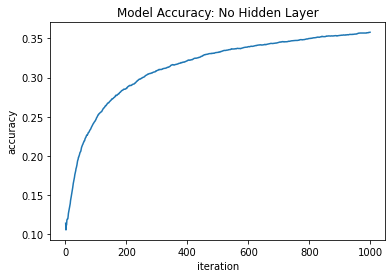

In [ ]:
# plot training history
fig = plt.plot(figsize=(12, 4))
iteration = list(range(1,1000))

# History for accuracy
plt.plot(iteration, acc_h_no_hidden_01)
plt.title('Model Accuracy: No Hidden Layer')
plt.ylabel('accuracy')
plt.xlabel('iteration')

plt.savefig("no_hidden.png")

### 1 hidden layer

In [ ]:
def objective(trial):
    # Define the search space for the hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    #L2_lambda = trial.suggest_float("L2_lambda", 1e-6, 1e-2, log=True)

    # Create the MLP_2 model with the given hyperparameters
    model_1_hidden = MLP_2(M=[256], n_hidden = 1, L2_lambda = 0)
    optimizer = GradientDescent(learning_rate=learning_rate, max_iters=5)

    # Train the model and compute its validation accuracy
    yh_1_hidden = model_1_hidden.fit(train_images, train_labels, optimizer)
    val_acc = yh_1_hidden.acc_history[-1]

    return val_acc

# Define the search method and run the optimization process
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Print the best hyperparameters found by Optuna
print("Best hyperparameters: ", study.best_params)

[I 2023-03-09 04:04:45,675] A new study created in memory with name: no-name-3938db92-831d-44ef-bc23-719dc1f3b2d3


1
[[0.04381377 0.08894714 0.08647979 ... 0.19978088 0.0344322  0.10642588]
 [0.02588378 0.10114429 0.07701044 ... 0.25338585 0.04632022 0.0864478 ]
 [0.05956821 0.10913692 0.0488354  ... 0.12149403 0.01943657 0.03321046]
 ...
 [0.05724458 0.11457848 0.03602979 ... 0.05503665 0.03685204 0.05001709]
 [0.04387548 0.09870862 0.07222124 ... 0.16840251 0.01409921 0.05245664]
 [0.07319337 0.08727538 0.06754767 ... 0.19073955 0.02339225 0.07641346]]
acc: 0.1034


2
[[0.04409367 0.08916717 0.08673996 ... 0.19927475 0.03469631 0.10695098]
 [0.02609133 0.10142729 0.07727109 ... 0.25259954 0.04678027 0.08699097]
 [0.0602652  0.10984476 0.04915994 ... 0.12160094 0.01970451 0.03355403]
 ...
 [0.05771167 0.11514786 0.03620099 ... 0.05505545 0.03722131 0.05040384]
 [0.0445126  0.09950749 0.0728171  ... 0.16837321 0.01433582 0.05313576]
 [0.0739233  0.08764148 0.06791779 ... 0.19043716 0.02365365 0.07704011]]
acc: 0.1037


3
[[0.04437157 0.08938017 0.08699476 ... 0.19876235 0.03495939 0.10746736]
 [0.0

[I 2023-03-09 04:05:07,660] Trial 0 finished with value: 0.1032 and parameters: {'learning_rate': 0.00018121321415369375}. Best is trial 0 with value: 0.1032.


1
[[0.05082991 0.08759573 0.18958973 ... 0.12925511 0.05018509 0.10141285]
 [0.14140125 0.12930048 0.19463825 ... 0.11286009 0.02122922 0.09652048]
 [0.0426961  0.04866599 0.09910643 ... 0.43300888 0.02369812 0.08905241]
 ...
 [0.1161724  0.09478971 0.07837999 ... 0.18905764 0.03596524 0.07023679]
 [0.05384206 0.09285391 0.09949023 ... 0.22200757 0.02432702 0.10670547]
 [0.03811006 0.07329987 0.14067933 ... 0.13820482 0.04160471 0.18455778]]
acc: 0.1082


2
[[0.05340641 0.09090516 0.18267085 ... 0.12225386 0.05299863 0.10143754]
 [0.150991   0.13484227 0.18438179 ... 0.10444995 0.02278005 0.09661703]
 [0.04754634 0.05274273 0.09719074 ... 0.40624914 0.02662817 0.09369344]
 ...
 [0.12280136 0.09807528 0.07535016 ... 0.17701903 0.03827452 0.07111186]
 [0.05979274 0.09890565 0.09396751 ... 0.20274621 0.0271268  0.10889897]
 [0.04099414 0.0766641  0.13453252 ... 0.12801951 0.04473719 0.18645607]]
acc: 0.1065


3
[[0.05585688 0.09376424 0.17656127 ... 0.11659595 0.05569597 0.10107912]
 [0.1

[I 2023-03-09 04:05:35,727] Trial 1 finished with value: 0.1062 and parameters: {'learning_rate': 0.0023902363196717986}. Best is trial 1 with value: 0.1062.


1
[[0.131415   0.04080654 0.02043879 ... 0.13730112 0.18293571 0.0175629 ]
 [0.13023023 0.0536514  0.01844705 ... 0.09177474 0.25607341 0.0117545 ]
 [0.12820259 0.02298801 0.01824785 ... 0.15196368 0.47347215 0.00788584]
 ...
 [0.14590393 0.06289796 0.02390825 ... 0.13392074 0.3330962  0.01727162]
 [0.12094282 0.02620866 0.00904583 ... 0.10779735 0.27777944 0.00532692]
 [0.13198844 0.07295506 0.02151419 ... 0.14209632 0.31281777 0.02266287]]
acc: 0.1053


2
[[0.13144485 0.04085539 0.02047152 ... 0.13733286 0.18282066 0.01759116]
 [0.13029064 0.05374334 0.01848756 ... 0.09181434 0.25588988 0.01178159]
 [0.12829701 0.0230335  0.01829167 ... 0.15204902 0.47311361 0.00790703]
 ...
 [0.14596481 0.06298188 0.02394918 ... 0.13396185 0.33287338 0.01730428]
 [0.12107118 0.02627609 0.00907558 ... 0.10789448 0.27762625 0.00534501]
 [0.13203278 0.0730691  0.02155708 ... 0.14214098 0.31251156 0.02271123]]
acc: 0.1051


3
[[0.13147441 0.04090421 0.02050427 ... 0.13736436 0.1827058  0.01761943]
 [0.1

[I 2023-03-09 04:06:03,278] Trial 2 finished with value: 0.105 and parameters: {'learning_rate': 3.232327444622383e-05}. Best is trial 1 with value: 0.1062.


1
[[0.0227928  0.03372624 0.02521392 ... 0.05802965 0.17480301 0.04574539]
 [0.04523411 0.07968033 0.04652683 ... 0.05902361 0.05465523 0.02723364]
 [0.03235428 0.01847803 0.04876282 ... 0.11261047 0.03482927 0.01517081]
 ...
 [0.03185903 0.07276928 0.05150317 ... 0.09292595 0.03832187 0.0256723 ]
 [0.02766717 0.02510607 0.01553525 ... 0.09150252 0.05335718 0.01718123]
 [0.01659785 0.03013719 0.06583201 ... 0.08936352 0.0499201  0.06010865]]
acc: 0.1079


2
[[0.0265827  0.03839276 0.02886888 ... 0.06339641 0.1967391  0.05212334]
 [0.05513641 0.09408595 0.05485624 ... 0.06564916 0.06334927 0.03222117]
 [0.04034705 0.02196435 0.05779026 ... 0.12558975 0.04128275 0.01828531]
 ...
 [0.03717831 0.08205274 0.0577875  ... 0.09984161 0.04326684 0.02930294]
 [0.03658843 0.0316775  0.01940956 ... 0.10801075 0.06719155 0.02195822]
 [0.02053981 0.03562949 0.07751242 ... 0.09977305 0.05836357 0.07129595]]
acc: 0.1073


3
[[0.03007517 0.04241856 0.03213414 ... 0.0671857  0.21308747 0.0575751 ]
 [0.0

[I 2023-03-09 04:06:31,419] Trial 3 finished with value: 0.1069 and parameters: {'learning_rate': 0.002318031361811139}. Best is trial 3 with value: 0.1069.


1
[[0.05301992 0.22889344 0.06091799 ... 0.09816702 0.21295664 0.16967075]
 [0.04036789 0.1755024  0.09468586 ... 0.0718346  0.3280896  0.1112023 ]
 [0.05597812 0.11655783 0.19940867 ... 0.22950832 0.0849165  0.18931434]
 ...
 [0.03157144 0.15432071 0.14724938 ... 0.13379919 0.08420776 0.20022292]
 [0.02834738 0.15261986 0.13446716 ... 0.17746145 0.19306593 0.1635843 ]
 [0.04171122 0.09201306 0.14206604 ... 0.09736622 0.29484426 0.12330676]]
acc: 0.1060


2
[[0.07495294 0.22998623 0.06672789 ... 0.1055795  0.14855003 0.14962953]
 [0.0670628  0.17537837 0.1088163  ... 0.0804158  0.21467736 0.10147635]
 [0.08875991 0.10408982 0.20527267 ... 0.23385245 0.0489394  0.15831481]
 ...
 [0.04514713 0.14200296 0.14917097 ... 0.13530308 0.05506194 0.17520399]
 [0.0526352  0.14507933 0.15314019 ... 0.19462841 0.10483181 0.13415632]
 [0.06822906 0.09051914 0.15779514 ... 0.10772175 0.18544392 0.10938827]]
acc: 0.0926


3
[[0.09081946 0.21406305 0.06531507 ... 0.10248295 0.13516364 0.13727578]
 [0.0

[I 2023-03-09 04:06:56,624] Trial 4 finished with value: 0.095 and parameters: {'learning_rate': 0.010034531400692253}. Best is trial 3 with value: 0.1069.


1
[[0.20623728 0.30495014 0.07176644 ... 0.05015503 0.03956223 0.08116581]
 [0.15541532 0.37354453 0.08209905 ... 0.04017899 0.04659786 0.12047706]
 [0.09538154 0.34086086 0.08168298 ... 0.04076734 0.02268529 0.07371863]
 ...
 [0.10685166 0.31517169 0.1023419  ... 0.04761743 0.03180928 0.08279938]
 [0.16063598 0.40313709 0.04554404 ... 0.02912451 0.02111123 0.0718834 ]
 [0.16720032 0.26860018 0.05618921 ... 0.03617638 0.02675216 0.18838208]]
acc: 0.0914


2
[[0.20629855 0.30018301 0.0726527  ... 0.05095746 0.0402958  0.08140214]
 [0.15593944 0.36736868 0.08333264 ... 0.04097432 0.04776903 0.12135557]
 [0.09580803 0.3340744  0.08325184 ... 0.04174543 0.02334276 0.0744379 ]
 ...
 [0.10714268 0.30993258 0.10369482 ... 0.04840469 0.03247677 0.08328349]
 [0.16207078 0.39461234 0.04681455 ... 0.03007077 0.02195014 0.07286113]
 [0.16746173 0.26301957 0.05704892 ... 0.03689986 0.02741525 0.1892931 ]]
acc: 0.0912


3
[[0.20628273 0.29562757 0.07351437 ... 0.0517473  0.0410268  0.08160878]
 [0.1

[I 2023-03-09 04:07:23,734] Trial 5 finished with value: 0.0912 and parameters: {'learning_rate': 0.0004339564061137447}. Best is trial 3 with value: 0.1069.


1
[[0.14977493 0.06887529 0.06653856 ... 0.03037344 0.09652059 0.11055767]
 [0.09866143 0.05622139 0.05151752 ... 0.02686937 0.14729163 0.16545349]
 [0.06715114 0.04264012 0.04288659 ... 0.04827706 0.21224109 0.2031803 ]
 ...
 [0.07074902 0.08130441 0.04234631 ... 0.07438044 0.11488814 0.15640051]
 [0.05173689 0.03267368 0.03508272 ... 0.02266056 0.14913163 0.22980718]
 [0.09679556 0.0358757  0.03326124 ... 0.05913929 0.06980302 0.13265187]]
acc: 0.1259


2
[[0.16985835 0.09137013 0.08913506 ... 0.05033893 0.11011066 0.08797576]
 [0.12476616 0.08216484 0.07451708 ... 0.05032723 0.17956627 0.13268349]
 [0.08219196 0.06308488 0.06089625 ... 0.08932425 0.25553339 0.16575334]
 ...
 [0.0853679  0.10867602 0.05555773 ... 0.11481015 0.13290548 0.13593956]
 [0.07482992 0.05699372 0.06041096 ... 0.05516799 0.20726822 0.18405081]
 [0.12184249 0.05271752 0.04990711 ... 0.11329634 0.08644672 0.11050039]]
acc: 0.1405


3
[[0.16189838 0.09594623 0.09353966 ... 0.06352836 0.10203148 0.08473522]
 [0.1

[I 2023-03-09 04:07:47,729] Trial 6 finished with value: 0.1558 and parameters: {'learning_rate': 0.020726090290530144}. Best is trial 6 with value: 0.1558.


1
[[0.17684319 0.12192601 0.03477182 ... 0.04408054 0.09969093 0.03948885]
 [0.08105087 0.07570659 0.02761552 ... 0.05827775 0.12755566 0.03897405]
 [0.15972022 0.04624394 0.04879826 ... 0.1036375  0.12308395 0.04813179]
 ...
 [0.14499039 0.06069949 0.0388763  ... 0.09553697 0.11052114 0.04377181]
 [0.26604696 0.08988602 0.02051118 ... 0.04304688 0.11540562 0.01897219]
 [0.13785431 0.08338963 0.05017531 ... 0.10559789 0.12376278 0.05143299]]
acc: 0.0800


2
[[0.1767529  0.12214022 0.03489843 ... 0.04417845 0.09965842 0.03961715]
 [0.08102469 0.0759295  0.02774755 ... 0.0584567  0.1276058  0.03914325]
 [0.159679   0.04636419 0.04900657 ... 0.10392832 0.12306226 0.04834336]
 ...
 [0.1449901  0.0608344  0.03901679 ... 0.09576057 0.11053642 0.04393662]
 [0.26623274 0.09026602 0.02065829 ... 0.04324607 0.11552678 0.01909734]
 [0.13784004 0.08359737 0.05038455 ... 0.10586829 0.12373259 0.05163047]]
acc: 0.0801


3
[[0.17666143 0.1223524  0.03502481 ... 0.04427585 0.09962508 0.03974509]
 [0.0

[I 2023-03-09 04:08:12,480] Trial 7 finished with value: 0.0802 and parameters: {'learning_rate': 0.00012528415047852496}. Best is trial 6 with value: 0.1558.


1
[[0.10071761 0.04798397 0.07908667 ... 0.09547801 0.15788001 0.09656838]
 [0.05978065 0.0578328  0.11772888 ... 0.18940878 0.10961731 0.12197089]
 [0.14151032 0.07589207 0.05554351 ... 0.1373302  0.16330178 0.12111192]
 ...
 [0.13354518 0.17985797 0.04983925 ... 0.16956986 0.0881342  0.12191902]
 [0.09114797 0.06517477 0.05972669 ... 0.29623068 0.11426693 0.10531929]
 [0.13239481 0.05900102 0.04372981 ... 0.10775909 0.07514622 0.1591013 ]]
acc: 0.1106


2
[[0.10988059 0.0655229  0.12611731 ... 0.07245396 0.15210208 0.10331597]
 [0.0628722  0.08233752 0.17691909 ... 0.11202539 0.10518413 0.12853146]
 [0.1637751  0.11432119 0.09021709 ... 0.0865148  0.161054   0.14303136]
 ...
 [0.14459652 0.22615297 0.06161349 ... 0.10880082 0.08234646 0.1274785 ]
 [0.11412345 0.11263285 0.11728478 ... 0.17463031 0.121324   0.12546267]
 [0.14398511 0.08827173 0.07228969 ... 0.07098322 0.07264628 0.17907579]]
acc: 0.1045


3
[[0.09889532 0.06583954 0.12442674 ... 0.07414869 0.1303768  0.09259892]
 [0.0

[I 2023-03-09 04:08:35,976] Trial 8 finished with value: 0.1287 and parameters: {'learning_rate': 0.022285629122374292}. Best is trial 6 with value: 0.1558.


1
[[0.18251763 0.16166056 0.12203849 ... 0.02880194 0.1005243  0.11724904]
 [0.04413988 0.26369235 0.0812625  ... 0.01841877 0.0477868  0.26284557]
 [0.05261648 0.14384776 0.10667232 ... 0.0442862  0.05039273 0.08156441]
 ...
 [0.10551945 0.19125743 0.09806405 ... 0.03691349 0.04904381 0.1722636 ]
 [0.05293418 0.19107783 0.11546227 ... 0.00999448 0.03123251 0.25159041]
 [0.09012415 0.18195967 0.06689297 ... 0.01656302 0.07981038 0.11989356]]
acc: 0.0952


2
[[0.18254812 0.16161693 0.12204076 ... 0.0288146  0.10054697 0.11722273]
 [0.04415698 0.26363962 0.08127316 ... 0.01843228 0.04780809 0.26281703]
 [0.05263755 0.14381805 0.10668437 ... 0.04431643 0.05041438 0.08155832]
 ...
 [0.10554595 0.19121738 0.09806668 ... 0.0369301  0.04905782 0.17224173]
 [0.05296461 0.19103927 0.11549066 ... 0.01000443 0.03125318 0.25157019]
 [0.09015836 0.18191933 0.06690245 ... 0.01657464 0.07984403 0.11988117]]
acc: 0.0952


3
[[0.18257856 0.16157333 0.12204301 ... 0.02882726 0.10056964 0.11719643]
 [0.0

[I 2023-03-09 04:09:00,068] Trial 9 finished with value: 0.0952 and parameters: {'learning_rate': 1.3645015069016556e-05}. Best is trial 6 with value: 0.1558.


1
[[0.04202068 0.11140791 0.09613747 ... 0.12273914 0.19244901 0.08262394]
 [0.0239006  0.09090288 0.05195304 ... 0.14231032 0.35975368 0.07701798]
 [0.02588148 0.19509431 0.06685063 ... 0.06420063 0.17558332 0.18121546]
 ...
 [0.04271894 0.17314931 0.07885871 ... 0.08923844 0.20006944 0.09461844]
 [0.02102972 0.13868385 0.04612509 ... 0.06254963 0.31432034 0.09813987]
 [0.02680219 0.13968863 0.07706093 ... 0.05836424 0.31032704 0.1035006 ]]
acc: 0.1117


2
[[0.27059813 0.05104187 0.1635635  ... 0.08613484 0.00495442 0.08304196]
 [0.37575137 0.03454238 0.11761387 ... 0.10092056 0.00327672 0.10534282]
 [0.31966985 0.05702912 0.09156641 ... 0.03236624 0.00080986 0.2707737 ]
 ...
 [0.30422281 0.07044171 0.11554155 ... 0.05156485 0.00357563 0.1352881 ]
 [0.51736299 0.02750535 0.09884329 ... 0.02778506 0.00063491 0.14653794]
 [0.36344027 0.04275338 0.14277902 ... 0.03655467 0.00234528 0.14939565]]
acc: 0.1092


3
[[0.00424685 0.1562635  0.03099771 ... 0.18897451 0.03257888 0.05873   ]
 [0.0

[I 2023-03-09 04:09:34,076] Trial 10 finished with value: 0.1661 and parameters: {'learning_rate': 0.07127323344128282}. Best is trial 10 with value: 0.1661.


1
[[0.03978284 0.20391711 0.06076007 ... 0.17934982 0.11748708 0.1156858 ]
 [0.0439582  0.32819508 0.11550889 ... 0.19695629 0.11624496 0.04880054]
 [0.01988519 0.1669308  0.16136743 ... 0.19991785 0.18192097 0.05562877]
 ...
 [0.02156723 0.25308644 0.19596125 ... 0.1700872  0.09033436 0.04160233]
 [0.01137812 0.53065299 0.12578178 ... 0.10512449 0.06554515 0.03110419]
 [0.02828198 0.27744238 0.14619958 ... 0.15255347 0.11559318 0.11088608]]
acc: 0.0925


2
[[1.39165219e-01 4.46863721e-04 2.52251144e-02 ... 4.81299537e-02
  6.30677230e-02 1.68107563e-01]
 [2.56640374e-01 3.04870963e-04 3.91660104e-02 ... 4.69508893e-02
  9.54635274e-02 1.23596259e-01]
 [1.93809382e-01 7.77001106e-05 3.43999189e-02 ... 2.58433567e-02
  1.42278940e-01 1.51622241e-01]
 ...
 [1.68699350e-01 8.18452462e-04 5.34740815e-02 ... 4.70891227e-02
  1.08570249e-01 1.16215166e-01]
 [2.40114782e-01 3.51400661e-05 2.90222628e-02 ... 1.70917335e-02
  7.13584285e-02 1.47925200e-01]
 [2.03676350e-01 1.89950052e-04 3.5199

[I 2023-03-09 04:09:57,873] Trial 11 finished with value: 0.1673 and parameters: {'learning_rate': 0.09692919232851104}. Best is trial 11 with value: 0.1673.


1
[[0.03937133 0.02029501 0.12157118 ... 0.09734425 0.04524677 0.0429782 ]
 [0.05550568 0.01796903 0.09329355 ... 0.2009238  0.0645207  0.07149578]
 [0.03581527 0.02467964 0.07805264 ... 0.19226497 0.0361766  0.07309441]
 ...
 [0.07043986 0.04764894 0.09181021 ... 0.24456609 0.04622154 0.07178305]
 [0.02499995 0.01863664 0.06848989 ... 0.21787853 0.02579761 0.04431413]
 [0.01996909 0.03497383 0.19201802 ... 0.22764168 0.02980872 0.03017026]]
acc: 0.0957


2
[[0.26380221 0.11825886 0.02072561 ... 0.01381507 0.14836426 0.17326091]
 [0.28138199 0.07064069 0.00723103 ... 0.0094671  0.1455779  0.33274893]
 [0.16639606 0.09733187 0.00638719 ... 0.0103933  0.11018741 0.30532224]
 ...
 [0.21032349 0.14127579 0.01278626 ... 0.02402031 0.12853874 0.25104489]
 [0.22241802 0.10697341 0.00280296 ... 0.0051371  0.15181206 0.2746747 ]
 [0.18679922 0.18396446 0.02263813 ... 0.01850278 0.16815965 0.19424821]]
acc: 0.1160


3
[[0.00328435 0.08830668 0.15792296 ... 0.09431837 0.06682647 0.03526493]
 [0.0

[I 2023-03-09 04:10:19,795] Trial 12 finished with value: 0.1427 and parameters: {'learning_rate': 0.09298428379139029}. Best is trial 11 with value: 0.1673.


1
[[0.19116839 0.10905943 0.10137095 ... 0.14351209 0.09617365 0.0410512 ]
 [0.09142294 0.15909157 0.07332342 ... 0.1803672  0.09527951 0.03012738]
 [0.13998658 0.14826077 0.09097613 ... 0.1721578  0.08898399 0.04566845]
 ...
 [0.11482115 0.17718873 0.10169292 ... 0.12982018 0.10005713 0.0633485 ]
 [0.14611639 0.2033895  0.11188495 ... 0.16282673 0.0676161  0.03239099]
 [0.1866876  0.18337388 0.09038503 ... 0.19662893 0.06290267 0.01925113]]
acc: 0.1089


2
[[0.07379839 0.03854878 0.08256098 ... 0.03966193 0.12050987 0.16706231]
 [0.02777142 0.03917652 0.0449359  ... 0.02989815 0.13767209 0.16194351]
 [0.03528565 0.03381671 0.05718673 ... 0.02718765 0.14884992 0.3342085 ]
 ...
 [0.0404969  0.05445266 0.06273471 ... 0.02817465 0.14696299 0.29037472]
 [0.0279001  0.02666705 0.05692484 ... 0.01572826 0.12169862 0.34141972]
 [0.06289869 0.05426563 0.07320249 ... 0.04457091 0.12122854 0.15104757]]
acc: 0.1165


3
[[0.22353435 0.12472339 0.12142767 ... 0.15981454 0.04899624 0.0114844 ]
 [0.1

[I 2023-03-09 04:10:41,811] Trial 13 finished with value: 0.1225 and parameters: {'learning_rate': 0.06979248272607559}. Best is trial 11 with value: 0.1673.


1
[[0.06583746 0.08466828 0.14237976 ... 0.04106813 0.16526484 0.11915264]
 [0.07130657 0.06203272 0.0897888  ... 0.02941767 0.10614207 0.15658683]
 [0.02094211 0.25885326 0.05808674 ... 0.01515634 0.0728574  0.10161956]
 ...
 [0.03956758 0.22527223 0.05591781 ... 0.03455991 0.1052614  0.07973794]
 [0.02953211 0.15068847 0.03616238 ... 0.00904504 0.1343803  0.06883307]
 [0.03269052 0.22156906 0.06782647 ... 0.01954385 0.20829191 0.08369319]]
acc: 0.0626


2
[[0.3210167  0.01825175 0.10096444 ... 0.2132352  0.01071213 0.08868704]
 [0.48465043 0.00702805 0.06353656 ... 0.17609249 0.004226   0.08865978]
 [0.33020156 0.0294093  0.06790562 ... 0.18532795 0.00392742 0.11379419]
 ...
 [0.33677089 0.04638383 0.06014394 ... 0.23072357 0.01250341 0.08921122]
 [0.51637749 0.00851938 0.02882007 ... 0.13302004 0.00240647 0.05086776]
 [0.37924315 0.02676169 0.07613952 ... 0.18256162 0.007661   0.08989311]]
acc: 0.1079


3
[[4.48859866e-04 1.08251821e-01 2.23501882e-01 ... 3.40978605e-02
  1.45550520

[I 2023-03-09 04:11:05,380] Trial 14 finished with value: 0.1389 and parameters: {'learning_rate': 0.09945536032785612}. Best is trial 11 with value: 0.1673.


1
[[0.07981332 0.03946944 0.04051152 ... 0.04999547 0.0724098  0.09863888]
 [0.01729436 0.02041765 0.03739685 ... 0.02001895 0.03268038 0.04454378]
 [0.03007425 0.07954256 0.03698178 ... 0.01557808 0.04289056 0.03165213]
 ...
 [0.04191733 0.06149947 0.03584254 ... 0.01948795 0.04736649 0.04041072]
 [0.01735368 0.01626181 0.01766538 ... 0.02351262 0.03616412 0.03349357]
 [0.10256921 0.01466003 0.0279208  ... 0.02623002 0.05118238 0.06012379]]
acc: 0.1028


2
[[0.10599888 0.05482545 0.05162105 ... 0.06716508 0.0918406  0.12590389]
 [0.03253808 0.04133609 0.06670134 ... 0.0367847  0.0573991  0.07944748]
 [0.04774966 0.13406252 0.05239235 ... 0.02408722 0.06273617 0.04622727]
 ...
 [0.06035403 0.09152804 0.04761279 ... 0.02806292 0.06555406 0.05605769]
 [0.04021332 0.04111502 0.03599281 ... 0.05320261 0.07523227 0.07000657]
 [0.16992978 0.02548426 0.04114388 ... 0.04144914 0.07822901 0.09199364]]
acc: 0.1050


3
[[0.12001522 0.06369836 0.05769804 ... 0.07751433 0.09966553 0.13610945]
 [0.0

[I 2023-03-09 04:11:27,142] Trial 15 finished with value: 0.0978 and parameters: {'learning_rate': 0.006045586699061326}. Best is trial 11 with value: 0.1673.


1
[[0.15294195 0.10490865 0.07834923 ... 0.08379508 0.11738131 0.09662444]
 [0.06421821 0.07562313 0.06094493 ... 0.13834005 0.094313   0.14390115]
 [0.17588841 0.10397408 0.01775111 ... 0.06665065 0.098373   0.0966399 ]
 ...
 [0.1719722  0.10148091 0.03640466 ... 0.06171992 0.09395194 0.15879776]
 [0.14864859 0.13238597 0.02320131 ... 0.07201774 0.12358077 0.10125508]
 [0.15650418 0.12524103 0.03003046 ... 0.13290761 0.12284055 0.10231455]]
acc: 0.0732


2
[[0.09976798 0.08342615 0.13517547 ... 0.12031273 0.10305929 0.09840158]
 [0.03894445 0.05266718 0.11020499 ... 0.19726664 0.08109507 0.15088913]
 [0.15173116 0.09340451 0.04955304 ... 0.11984625 0.11304401 0.15464178]
 ...
 [0.13035029 0.07933731 0.06746455 ... 0.08438833 0.09175909 0.19721949]
 [0.10131639 0.101053   0.06741832 ... 0.12946207 0.13107328 0.1431322 ]
 [0.11495308 0.0963886  0.06666197 ... 0.21885837 0.11146905 0.1271805 ]]
acc: 0.1299


3
[[0.10190522 0.09316274 0.13480059 ... 0.1072098  0.10003092 0.08337697]
 [0.0

[I 2023-03-09 04:11:50,048] Trial 16 finished with value: 0.1271 and parameters: {'learning_rate': 0.030322566820092375}. Best is trial 11 with value: 0.1673.


1
[[0.19222014 0.08527913 0.03930992 ... 0.12200435 0.084961   0.14490843]
 [0.17023485 0.20527971 0.0183142  ... 0.08300747 0.0749344  0.19698601]
 [0.21724698 0.18530231 0.01859158 ... 0.15788208 0.06015156 0.11206419]
 ...
 [0.18913069 0.14629866 0.04454984 ... 0.11714101 0.05522979 0.22720814]
 [0.24369506 0.18707254 0.01163079 ... 0.097712   0.04064455 0.2223583 ]
 [0.23503966 0.18952211 0.02205886 ... 0.10660058 0.05573598 0.18290183]]
acc: 0.1083


2
[[0.15739241 0.08052884 0.04780018 ... 0.12061091 0.09667584 0.13355147]
 [0.13406468 0.19304663 0.02395261 ... 0.083758   0.09290329 0.18054555]
 [0.17146783 0.17403886 0.02563123 ... 0.16105944 0.07763046 0.10746792]
 ...
 [0.15862606 0.13880546 0.05593167 ... 0.11809125 0.06660407 0.21976727]
 [0.18776552 0.17884401 0.01764691 ... 0.10455758 0.05770695 0.21259655]
 [0.18588038 0.18015037 0.03047731 ... 0.11026992 0.07215101 0.17472354]]
acc: 0.1045


3
[[0.14164718 0.07546289 0.05561422 ... 0.11614768 0.10382971 0.12415367]
 [0.1

[I 2023-03-09 04:12:12,863] Trial 17 finished with value: 0.1068 and parameters: {'learning_rate': 0.006369679351950708}. Best is trial 11 with value: 0.1673.


1
[[0.03055258 0.05754598 0.05014448 ... 0.09489152 0.1993518  0.03701772]
 [0.0156852  0.09943768 0.03748677 ... 0.08929786 0.1537978  0.08219495]
 [0.02939593 0.10411483 0.02074301 ... 0.07764577 0.16542153 0.07392875]
 ...
 [0.04235267 0.19569377 0.04780995 ... 0.06310656 0.11205613 0.06917432]
 [0.0197133  0.09069082 0.03006185 ... 0.06408356 0.14199564 0.0784268 ]
 [0.02852885 0.10126674 0.03528345 ... 0.06235606 0.15102301 0.05013488]]
acc: 0.0926


2
[[0.11388751 0.05690507 0.10812586 ... 0.1102071  0.12575276 0.06654158]
 [0.09890178 0.08869632 0.11681196 ... 0.12599624 0.11532509 0.2071443 ]
 [0.12517246 0.0753316  0.0559537  ... 0.09987897 0.10812543 0.1704804 ]
 ...
 [0.14493564 0.14027797 0.11302016 ... 0.07575667 0.08693696 0.12759999]
 [0.15255895 0.0668699  0.11187338 ... 0.09428579 0.07813376 0.19511707]
 [0.16296543 0.08752111 0.10993171 ... 0.08771103 0.09788898 0.11956743]]
acc: 0.1178


3
[[0.14666104 0.08340331 0.10398592 ... 0.10289169 0.15627166 0.05613381]
 [0.1

[I 2023-03-09 04:12:36,172] Trial 18 finished with value: 0.1331 and parameters: {'learning_rate': 0.03438346854280217}. Best is trial 11 with value: 0.1673.


1
[[0.05309633 0.09097679 0.05229864 ... 0.06573495 0.14658303 0.04463898]
 [0.04817704 0.08300814 0.05381258 ... 0.07731041 0.11294879 0.03530724]
 [0.04892037 0.04072129 0.07990632 ... 0.04979233 0.05280532 0.05267736]
 ...
 [0.09176557 0.07543075 0.0689226  ... 0.05926158 0.07584891 0.04737447]
 [0.03376083 0.03476815 0.0660388  ... 0.0400761  0.12227066 0.04980591]
 [0.06412835 0.04166266 0.05475914 ... 0.04808117 0.09588332 0.08016309]]
acc: 0.1001


2
[[0.13638914 0.15811016 0.11246675 ... 0.10899362 0.14035975 0.07502497]
 [0.16321375 0.15741097 0.12544014 ... 0.14025311 0.1213059  0.06813156]
 [0.22548135 0.08609168 0.20061258 ... 0.10797625 0.06509653 0.12582486]
 ...
 [0.26312315 0.11826735 0.13254293 ... 0.10264418 0.08972454 0.08954083]
 [0.19080036 0.0869061  0.2019566  ... 0.10072735 0.13196564 0.12289157]
 [0.24086787 0.07317245 0.13637161 ... 0.09957086 0.09606676 0.15227338]]
acc: 0.1132


3
[[0.03864579 0.1113671  0.05387842 ... 0.09159493 0.16158796 0.05833095]
 [0.0

[I 2023-03-09 04:12:58,997] Trial 19 finished with value: 0.1275 and parameters: {'learning_rate': 0.04530873298189404}. Best is trial 11 with value: 0.1673.


1
[[0.06336336 0.08246247 0.3632889  ... 0.03030832 0.07640592 0.1229389 ]
 [0.09446987 0.0832643  0.24150517 ... 0.02724922 0.03672713 0.24448548]
 [0.10322339 0.17875    0.16832006 ... 0.03706102 0.03756572 0.1447673 ]
 ...
 [0.12692763 0.12917304 0.12010686 ... 0.03844483 0.02631519 0.23277213]
 [0.03961747 0.12520799 0.2844178  ... 0.03658295 0.02693487 0.11977606]
 [0.08454374 0.15895777 0.18037888 ... 0.09177453 0.02876723 0.11519656]]
acc: 0.1087


2
[[0.09316763 0.09128095 0.19692777 ... 0.05081766 0.14107252 0.09997724]
 [0.1519629  0.09536677 0.10661743 ... 0.04972526 0.07705064 0.1863592 ]
 [0.15858368 0.18392856 0.07079432 ... 0.0638491  0.07497059 0.10351018]
 ...
 [0.17482096 0.13172328 0.05850168 ... 0.05634442 0.04611689 0.17478882]
 [0.07584421 0.14327541 0.10464853 ... 0.07973108 0.0721263  0.08669356]
 [0.12274011 0.15159415 0.06989671 ... 0.1531179  0.05565369 0.07811087]]
acc: 0.0976


3
[[0.08516385 0.08134919 0.18742427 ... 0.05173182 0.17182189 0.08671456]
 [0.1

[I 2023-03-09 04:13:24,707] Trial 20 finished with value: 0.105 and parameters: {'learning_rate': 0.01765034122125258}. Best is trial 11 with value: 0.1673.


1
[[0.08998537 0.07965299 0.23423064 ... 0.03179176 0.04340688 0.13535609]
 [0.11216685 0.10117663 0.10026044 ... 0.02584718 0.03541857 0.1709303 ]
 [0.13920981 0.09450099 0.07403436 ... 0.01379663 0.12869039 0.13171041]
 ...
 [0.14428168 0.06318273 0.04799175 ... 0.02880355 0.11102964 0.22746918]
 [0.11302671 0.06583254 0.1131147  ... 0.00862924 0.04493317 0.19704184]
 [0.185569   0.08326033 0.09277298 ... 0.01794749 0.04041902 0.17404238]]
acc: 0.1019


2
[[0.10587458 0.09710604 0.16274856 ... 0.10669883 0.13293676 0.07773275]
 [0.15271855 0.13327374 0.06370555 ... 0.10820533 0.15607257 0.08656914]
 [0.13049173 0.10158566 0.03257693 ... 0.05075941 0.46695771 0.05596003]
 ...
 [0.15379045 0.07275551 0.02763934 ... 0.08417079 0.35887595 0.12407634]
 [0.16544299 0.09640944 0.06283097 ... 0.05959729 0.29209813 0.08394225]
 [0.22678392 0.11042    0.05583118 ... 0.07608046 0.16546662 0.09363957]]
acc: 0.1328


3
[[0.06628844 0.08914955 0.21931499 ... 0.08543638 0.04438081 0.11193954]
 [0.0

[I 2023-03-09 04:13:47,364] Trial 21 finished with value: 0.1538 and parameters: {'learning_rate': 0.038396229579539774}. Best is trial 11 with value: 0.1673.


1
[[0.13353117 0.03340762 0.05090698 ... 0.20311711 0.07291834 0.15045274]
 [0.11099227 0.01554359 0.03541214 ... 0.26985535 0.14568444 0.10703013]
 [0.14243623 0.03138683 0.05105446 ... 0.19197757 0.04859665 0.14254978]
 ...
 [0.08513509 0.03473061 0.07464512 ... 0.35689277 0.0811435  0.11539178]
 [0.24473741 0.02716361 0.02844324 ... 0.18493921 0.08626639 0.17093113]
 [0.2164127  0.03648462 0.06112976 ... 0.2030393  0.08774742 0.08421404]]
acc: 0.0859


2
[[0.1170753  0.05577744 0.07885845 ... 0.09566811 0.09381412 0.12872181]
 [0.09840406 0.03104585 0.06283935 ... 0.1031457  0.21376999 0.09633326]
 [0.12901074 0.07117259 0.09380905 ... 0.06501191 0.07491288 0.1268699 ]
 ...
 [0.08896053 0.06926974 0.12779584 ... 0.16422663 0.11864073 0.11516261]
 [0.22425973 0.06883265 0.065391   ... 0.05077555 0.14673416 0.14044808]
 [0.19612308 0.07250994 0.11110327 ... 0.07845977 0.13067622 0.07208537]]
acc: 0.1030


3
[[0.1034554  0.06973123 0.08316783 ... 0.10183665 0.08586366 0.1175142 ]
 [0.0

[I 2023-03-09 04:14:09,550] Trial 22 finished with value: 0.1227 and parameters: {'learning_rate': 0.020509541562871554}. Best is trial 11 with value: 0.1673.


1
[[0.02855618 0.0879212  0.12887155 ... 0.19608418 0.05318032 0.06126647]
 [0.01030796 0.13121068 0.18749369 ... 0.09003829 0.04123716 0.04275715]
 [0.010324   0.19662823 0.15215603 ... 0.08270874 0.11210314 0.09087454]
 ...
 [0.01571096 0.260795   0.10429798 ... 0.08563035 0.09376549 0.0857464 ]
 [0.00834087 0.23541958 0.0976861  ... 0.08311649 0.05323247 0.06668327]
 [0.00942466 0.232651   0.09393753 ... 0.17244252 0.0547827  0.07420659]]
acc: 0.1010


2
[[0.24886939 0.03961368 0.05180838 ... 0.05618548 0.18321844 0.13357629]
 [0.19870449 0.06147886 0.07340139 ... 0.02670362 0.22442975 0.15083574]
 [0.14345754 0.04451351 0.03409217 ... 0.00987008 0.43330072 0.18901912]
 ...
 [0.15744533 0.09219269 0.0371014  ... 0.01881357 0.31254225 0.19292605]
 [0.24385503 0.04120698 0.0158128  ... 0.00636512 0.35598928 0.17885167]
 [0.18858038 0.08227806 0.03373254 ... 0.03307359 0.29253854 0.21251534]]
acc: 0.0991


3
[[0.02045226 0.07280614 0.13885201 ... 0.27494798 0.00416625 0.01515088]
 [0.0

[I 2023-03-09 04:14:33,218] Trial 23 finished with value: 0.1504 and parameters: {'learning_rate': 0.06433752578338407}. Best is trial 11 with value: 0.1673.


1
[[0.37751144 0.06025173 0.04479358 ... 0.10093022 0.03049205 0.09865089]
 [0.34023994 0.07050614 0.02717725 ... 0.10367451 0.03249105 0.09573495]
 [0.50487218 0.05564147 0.02669703 ... 0.07965678 0.02656841 0.10633525]
 ...
 [0.41936187 0.09210193 0.04120905 ... 0.06507039 0.07333614 0.06707876]
 [0.60056846 0.04406232 0.00904071 ... 0.07733576 0.01545032 0.07872758]
 [0.52349424 0.05315605 0.04012981 ... 0.0811277  0.03734353 0.09426212]]
acc: 0.1004


2
[[0.12625334 0.09028631 0.07449958 ... 0.12059494 0.05743208 0.12040796]
 [0.08203157 0.10919701 0.04772835 ... 0.12225991 0.07024442 0.10844158]
 [0.12667726 0.1126824  0.05823333 ... 0.12038683 0.07563513 0.15675021]
 ...
 [0.13641226 0.14549339 0.0658051  ... 0.08269737 0.1495466  0.08382543]
 [0.13177175 0.1106929  0.0272123  ... 0.13068723 0.0601573  0.14034341]
 [0.14434368 0.10453129 0.08809419 ... 0.11452312 0.09792547 0.14251243]]
acc: 0.1075


3
[[0.13058853 0.09428696 0.08550095 ... 0.11796353 0.06815703 0.10491536]
 [0.0

[I 2023-03-09 04:14:55,459] Trial 24 finished with value: 0.1285 and parameters: {'learning_rate': 0.013102339310398446}. Best is trial 11 with value: 0.1673.


1
[[0.04294449 0.03404364 0.01886839 ... 0.21925131 0.32955282 0.04385748]
 [0.04549018 0.02880687 0.01997929 ... 0.23334997 0.27644833 0.04437512]
 [0.02997387 0.06361243 0.02163603 ... 0.17206241 0.33555159 0.04705834]
 ...
 [0.0641618  0.06465769 0.02560943 ... 0.21995152 0.21153831 0.05467988]
 [0.0205806  0.01786736 0.00828089 ... 0.29160725 0.36586325 0.02855638]
 [0.02491104 0.0474825  0.02188459 ... 0.22057824 0.26446419 0.03753579]]
acc: 0.1061


2
[[0.15703798 0.10122796 0.08058158 ... 0.01438456 0.04109107 0.17636462]
 [0.19758672 0.08576572 0.08328574 ... 0.00506405 0.02083284 0.18531847]
 [0.15620839 0.19897167 0.10480654 ... 0.00235751 0.0174031  0.21158861]
 ...
 [0.21940329 0.1573166  0.08738649 ... 0.00726368 0.01849344 0.17165151]
 [0.23685592 0.10698733 0.08429876 ... 0.00204169 0.01471033 0.25061541]
 [0.1479477  0.15114592 0.11169874 ... 0.00475651 0.01737357 0.19075297]]
acc: 0.1186


3
[[0.05007636 0.11170556 0.06709645 ... 0.05914403 0.15975468 0.03311255]
 [0.0

[I 2023-03-09 04:15:18,086] Trial 25 finished with value: 0.1461 and parameters: {'learning_rate': 0.04765586361551475}. Best is trial 11 with value: 0.1673.


1
[[0.06173892 0.10254336 0.1510976  ... 0.06272519 0.072574   0.07547715]
 [0.05105672 0.06357572 0.11498979 ... 0.03412841 0.06783695 0.03765457]
 [0.01620963 0.03052435 0.03918504 ... 0.05972059 0.03952159 0.01640874]
 ...
 [0.03870159 0.04449121 0.06591784 ... 0.04424616 0.10330939 0.01858119]
 [0.01056324 0.02342439 0.06719639 ... 0.0354126  0.0581811  0.02292468]
 [0.02704685 0.0417902  0.079954   ... 0.05549397 0.05306019 0.06078423]]
acc: 0.0938


2
[[0.0877567  0.11710592 0.1694674  ... 0.07385025 0.08942917 0.0946093 ]
 [0.09135477 0.08492233 0.1520867  ... 0.0461727  0.10065068 0.05750327]
 [0.03832533 0.05626061 0.06552832 ... 0.10083476 0.07658438 0.0335931 ]
 ...
 [0.06997369 0.06421279 0.08863456 ... 0.06214319 0.15617089 0.02927982]
 [0.02960325 0.04329086 0.11740342 ... 0.06302022 0.1234555  0.04878635]
 [0.05415471 0.06136734 0.11197055 ... 0.0833747  0.0884964  0.10196986]]
acc: 0.0847


3
[[0.10721897 0.12107997 0.16521738 ... 0.0773908  0.09172974 0.10616044]
 [0.1

[I 2023-03-09 04:15:41,944] Trial 26 finished with value: 0.0929 and parameters: {'learning_rate': 0.008687391003256509}. Best is trial 11 with value: 0.1673.


1
[[0.14630551 0.08582264 0.07796372 ... 0.09997037 0.05623022 0.10032116]
 [0.14726554 0.0780366  0.15167419 ... 0.07062575 0.04382807 0.12271412]
 [0.24330674 0.11730548 0.08050962 ... 0.22887731 0.02666904 0.0425174 ]
 ...
 [0.20501764 0.07951666 0.10923151 ... 0.14259617 0.02974768 0.07558002]
 [0.25820481 0.09218738 0.0573337  ... 0.05441973 0.02319543 0.07209313]
 [0.14158024 0.04218393 0.16724929 ... 0.16355751 0.02769691 0.05192907]]
acc: 0.1099


2
[[0.00696484 0.12370066 0.04215575 ... 0.06019166 0.26997686 0.06474332]
 [0.00337093 0.10041301 0.05776647 ... 0.03189873 0.46795198 0.06422085]
 [0.00695493 0.19784662 0.03442105 ... 0.1283745  0.3484874  0.03942303]
 ...
 [0.01552585 0.13483293 0.05769799 ... 0.09367548 0.27715847 0.08065905]
 [0.00213556 0.14059326 0.01732622 ... 0.0213717  0.54780315 0.0404534 ]
 [0.00479697 0.0733437  0.08032012 ... 0.09852343 0.3733286  0.04221817]]
acc: 0.1028


3
[[8.35871010e-02 4.39440461e-02 2.05041305e-01 ... 1.01130481e-01
  8.68571373

[I 2023-03-09 04:16:04,872] Trial 27 finished with value: 0.1613 and parameters: {'learning_rate': 0.08840916649658576}. Best is trial 11 with value: 0.1673.


1
[[0.16571773 0.08205845 0.05431832 ... 0.06695137 0.24208298 0.07395847]
 [0.15385821 0.041818   0.07071647 ... 0.11673022 0.25250278 0.08708093]
 [0.11500136 0.03544795 0.06721728 ... 0.21676999 0.08352909 0.14265883]
 ...
 [0.11256962 0.02876164 0.0621463  ... 0.23495909 0.07374964 0.12817452]
 [0.12174065 0.03717817 0.05111906 ... 0.12789438 0.23480446 0.14870195]
 [0.23910867 0.0414836  0.04953959 ... 0.1446975  0.16234483 0.08253088]]
acc: 0.0821


2
[[0.01969035 0.18532364 0.14793679 ... 0.00898567 0.01981238 0.05159564]
 [0.02111861 0.13405981 0.22273454 ... 0.00995785 0.01916135 0.06762477]
 [0.01054774 0.10836798 0.17614848 ... 0.01057968 0.00531092 0.09381105]
 ...
 [0.02092295 0.07910492 0.14849335 ... 0.0226687  0.01089904 0.10931974]
 [0.00631518 0.14965327 0.17355777 ... 0.00335254 0.00698953 0.07324305]
 [0.02488147 0.11428381 0.16303004 ... 0.01156547 0.0100954  0.066819  ]]
acc: 0.0905


3
[[0.29888429 0.04449815 0.01372005 ... 0.06619697 0.25496512 0.07895117]
 [0.2

[I 2023-03-09 04:16:26,760] Trial 28 finished with value: 0.1322 and parameters: {'learning_rate': 0.08239522007703513}. Best is trial 11 with value: 0.1673.


1
[[0.0353632  0.16358666 0.17060747 ... 0.07891982 0.06955976 0.13835294]
 [0.06758191 0.11720573 0.25406945 ... 0.03373348 0.07410008 0.2065133 ]
 [0.04579895 0.08933417 0.2575753  ... 0.01972157 0.07749277 0.22919666]
 ...
 [0.0802279  0.08723294 0.13140553 ... 0.04561197 0.07894898 0.2502626 ]
 [0.05462818 0.02914939 0.39418286 ... 0.0273121  0.04224553 0.26620877]
 [0.04651927 0.09469283 0.13807828 ... 0.06520829 0.14148342 0.22574412]]
acc: 0.1138


2
[[0.08236597 0.15523861 0.00877036 ... 0.16340815 0.11463573 0.04971416]
 [0.23119192 0.11319619 0.00456983 ... 0.09960471 0.15855897 0.05161297]
 [0.15258002 0.08782685 0.00456877 ... 0.06123424 0.21275496 0.06522868]
 ...
 [0.19581825 0.08644425 0.0049844  ... 0.10365664 0.15548722 0.08729574]
 [0.3070559  0.03274683 0.00272047 ... 0.12884401 0.14298245 0.05375047]
 [0.12923574 0.07580032 0.00205144 ... 0.16706807 0.24584561 0.05146982]]
acc: 0.1170


3
[[0.04357496 0.14247517 0.03869739 ... 0.13264371 0.04180435 0.11972324]
 [0.1

[I 2023-03-09 04:16:50,201] Trial 29 finished with value: 0.1372 and parameters: {'learning_rate': 0.0482411389794254}. Best is trial 11 with value: 0.1673.


1
[[0.0193696  0.22041625 0.10286907 ... 0.08097123 0.01919735 0.03417474]
 [0.02275609 0.26506162 0.07618804 ... 0.05417038 0.01896993 0.02437268]
 [0.00641144 0.20042303 0.15827031 ... 0.013794   0.02597295 0.01584696]
 ...
 [0.01861629 0.16655801 0.20056403 ... 0.02057593 0.02641312 0.03093374]
 [0.00542082 0.30877282 0.08930881 ... 0.01102899 0.01301143 0.00835212]
 [0.01229448 0.31237394 0.07690198 ... 0.02701475 0.03075168 0.02993624]]
acc: 0.0874


2
[[4.12017210e-01 6.65143828e-04 5.88257769e-02 ... 1.29824713e-01
  1.42203155e-01 1.34471416e-01]
 [5.38629109e-01 1.43529270e-04 2.85038210e-02 ... 6.00769869e-02
  1.70601641e-01 1.23806706e-01]
 [2.65520021e-01 5.35042528e-05 4.44308729e-02 ... 2.98816794e-02
  3.50477926e-01 2.49473935e-01]
 ...
 [3.79925411e-01 2.99880040e-04 6.54956141e-02 ... 3.67374652e-02
  1.91283518e-01 2.02283840e-01]
 [5.72868323e-01 8.75488762e-06 1.73050338e-02 ... 1.75550920e-02
  2.51829443e-01 9.57465385e-02]
 [4.90195431e-01 6.47341300e-05 1.8187

[I 2023-03-09 04:17:12,367] Trial 30 finished with value: 0.1573 and parameters: {'learning_rate': 0.09648938308605196}. Best is trial 11 with value: 0.1673.


1
[[0.07833841 0.11855501 0.10338805 ... 0.23709453 0.13860116 0.02155562]
 [0.10338197 0.29395367 0.14555504 ... 0.17003884 0.07489744 0.01888471]
 [0.19322059 0.26676228 0.07043712 ... 0.17555186 0.07167971 0.01331406]
 ...
 [0.0921557  0.27639808 0.15973774 ... 0.1081943  0.09490431 0.02029725]
 [0.10515594 0.37906494 0.09368966 ... 0.12731204 0.04974939 0.00835967]
 [0.14290959 0.22341735 0.11084002 ... 0.14396136 0.08049422 0.01816776]]
acc: 0.1067


2
[[6.77234945e-02 1.64883714e-03 4.78306338e-02 ... 1.65005560e-02
  1.57032626e-01 2.21808577e-01]
 [8.88067361e-02 1.19880769e-03 4.54146198e-02 ... 5.99400916e-03
  1.05309296e-01 4.24991483e-01]
 [1.17316096e-01 5.05652177e-04 1.61694546e-02 ... 3.34263933e-03
  9.55567342e-02 3.59859996e-01]
 ...
 [7.21877060e-02 2.29661611e-03 5.35576690e-02 ... 5.13954954e-03
  1.40567984e-01 2.94454973e-01]
 [7.29602524e-02 2.52932792e-04 1.68940747e-02 ... 1.54601099e-03
  6.78103004e-02 3.58862702e-01]
 [1.01580971e-01 8.73053882e-04 3.3491

[I 2023-03-09 04:17:34,063] Trial 31 finished with value: 0.1393 and parameters: {'learning_rate': 0.09388121771032698}. Best is trial 11 with value: 0.1673.


1
[[0.09946175 0.13420773 0.11741742 ... 0.044552   0.19684226 0.08387144]
 [0.0951624  0.18664694 0.07512368 ... 0.03200581 0.26673364 0.09313135]
 [0.0991992  0.1004257  0.30621498 ... 0.02866479 0.24235553 0.05905893]
 ...
 [0.12028864 0.09239327 0.1173887  ... 0.0267755  0.23205771 0.1001394 ]
 [0.06671534 0.14871189 0.14261941 ... 0.01042839 0.33779985 0.04945472]
 [0.06805237 0.18303446 0.26012525 ... 0.03527182 0.15452349 0.06035665]]
acc: 0.1219


2
[[0.07533557 0.06159083 0.10013945 ... 0.11734869 0.07165268 0.10625382]
 [0.08485919 0.08292718 0.06362892 ... 0.11412846 0.09510194 0.15825594]
 [0.09831519 0.04505792 0.26261408 ... 0.11670026 0.08952982 0.11992255]
 ...
 [0.11487106 0.04938641 0.09656693 ... 0.07412013 0.1015012  0.16941029]
 [0.069697   0.05536278 0.13720232 ... 0.07198049 0.10198644 0.12202312]
 [0.05942301 0.07536078 0.21561283 ... 0.13568415 0.05002584 0.10702096]]
acc: 0.1292


3
[[0.08088854 0.08814701 0.09056216 ... 0.11713057 0.10435322 0.06455258]
 [0.0

[I 2023-03-09 04:17:56,879] Trial 32 finished with value: 0.1716 and parameters: {'learning_rate': 0.033409127005751396}. Best is trial 32 with value: 0.1716.


1
[[0.05016886 0.12561254 0.14691371 ... 0.09733407 0.08904412 0.13326427]
 [0.02271943 0.11661592 0.26868028 ... 0.10579593 0.09538751 0.11600717]
 [0.04789655 0.11880607 0.19351035 ... 0.07130284 0.04879266 0.08890714]
 ...
 [0.03610935 0.06313559 0.15392801 ... 0.10999829 0.06059336 0.10282338]
 [0.03163518 0.10368373 0.24869926 ... 0.1120465  0.04466184 0.15560209]
 [0.04762795 0.10256003 0.26496254 ... 0.08430219 0.0479682  0.07158155]]
acc: 0.1039


2
[[0.11867328 0.1137126  0.03094481 ... 0.10353374 0.15419772 0.11176945]
 [0.07734251 0.11928859 0.03720022 ... 0.12744746 0.24217905 0.1040287 ]
 [0.1465971  0.10637637 0.02269238 ... 0.07840721 0.11944631 0.08612554]
 ...
 [0.08771805 0.06069811 0.029877   ... 0.11431545 0.13314259 0.09155757]
 [0.15405038 0.0949312  0.01755422 ... 0.1280125  0.1542827  0.12651345]
 [0.1661731  0.10154335 0.03627659 ... 0.09787659 0.11717784 0.06078261]]
acc: 0.1111


3
[[0.119785   0.11810905 0.06327128 ... 0.10300671 0.10239    0.1200338 ]
 [0.0

[I 2023-03-09 04:18:18,838] Trial 33 finished with value: 0.1289 and parameters: {'learning_rate': 0.03270963143111921}. Best is trial 32 with value: 0.1716.


1
[[0.14810309 0.09457865 0.08890217 ... 0.10199251 0.10275415 0.20837835]
 [0.13414973 0.03945307 0.04222435 ... 0.05880806 0.1557683  0.36130218]
 [0.23621326 0.03831139 0.0601105  ... 0.03460984 0.07018323 0.30284965]
 ...
 [0.21266266 0.05177667 0.06727265 ... 0.05596728 0.10663322 0.22490765]
 [0.18581688 0.05173961 0.0283982  ... 0.03407244 0.08332137 0.39627858]
 [0.13408829 0.04257903 0.075462   ... 0.05049098 0.11621443 0.34121357]]
acc: 0.1088


2
[[0.14006648 0.10144564 0.09834424 ... 0.11046047 0.10487492 0.17083313]
 [0.13200846 0.04597419 0.05072415 ... 0.06862668 0.17101779 0.29162603]
 [0.2309266  0.04491703 0.07094438 ... 0.04048904 0.07628569 0.2449919 ]
 ...
 [0.20459594 0.0576914  0.07532281 ... 0.06161175 0.1119499  0.18601268]
 [0.18611296 0.06395777 0.03671896 ... 0.04241699 0.09571065 0.31000792]
 [0.13085267 0.04897347 0.08980622 ... 0.05889902 0.12557812 0.27452108]]
acc: 0.1147


3
[[0.13143847 0.10670401 0.1055913  ... 0.11666934 0.1046859  0.1475815 ]
 [0.1

[I 2023-03-09 04:18:40,518] Trial 34 finished with value: 0.1202 and parameters: {'learning_rate': 0.0035974184374920333}. Best is trial 32 with value: 0.1716.


1
[[0.0243737  0.12509672 0.05579474 ... 0.15587235 0.08593377 0.21931528]
 [0.026262   0.17028892 0.0488213  ... 0.06546663 0.13778961 0.30026576]
 [0.02862663 0.20183952 0.04371181 ... 0.08917197 0.11035192 0.21065717]
 ...
 [0.04504979 0.17455561 0.06002872 ... 0.10481952 0.13451973 0.22073788]
 [0.02527694 0.16082043 0.03647907 ... 0.060954   0.05879443 0.4344367 ]
 [0.02792971 0.10665113 0.04056289 ... 0.09731614 0.11437207 0.37402092]]
acc: 0.1027


2
[[0.03822315 0.11335351 0.07876035 ... 0.17335158 0.09243812 0.1376425 ]
 [0.04872008 0.15824872 0.07828583 ... 0.07710892 0.15699319 0.17425722]
 [0.05316884 0.17734026 0.06815224 ... 0.10578183 0.13032276 0.12605206]
 ...
 [0.07264999 0.15520811 0.08153661 ... 0.11700323 0.15185654 0.14673751]
 [0.06652835 0.15558501 0.07505751 ... 0.08671368 0.08303723 0.23578656]
 [0.05666787 0.10233353 0.06756639 ... 0.12039894 0.13756394 0.22522973]]
acc: 0.0976


3
[[0.05014793 0.09698611 0.09290292 ... 0.16932959 0.08794716 0.12148025]
 [0.0

[I 2023-03-09 04:19:02,784] Trial 35 finished with value: 0.0999 and parameters: {'learning_rate': 0.012895990174650518}. Best is trial 32 with value: 0.1716.


1
[[0.09230766 0.21929167 0.06328164 ... 0.12221038 0.04459459 0.17467961]
 [0.19507915 0.18495301 0.06610438 ... 0.10579329 0.02054563 0.16377813]
 [0.12157696 0.23618619 0.06652528 ... 0.05552684 0.02880192 0.30500702]
 ...
 [0.14729606 0.23235187 0.09744707 ... 0.03659079 0.04152659 0.19508936]
 [0.17388377 0.17572416 0.07942455 ... 0.03943281 0.01898524 0.35453762]
 [0.12023459 0.30013486 0.06023969 ... 0.04383262 0.03106523 0.2522521 ]]
acc: 0.1077


2
[[0.07066677 0.0324784  0.09178575 ... 0.21263168 0.11878845 0.0273815 ]
 [0.16831057 0.01794698 0.10108754 ... 0.1971558  0.08933058 0.01568493]
 [0.11458065 0.01948678 0.1181734  ... 0.15292943 0.2016811  0.02961458]
 ...
 [0.14191812 0.03295444 0.15997002 ... 0.06985359 0.18265122 0.02885202]
 [0.18915608 0.00889024 0.17128862 ... 0.1121819  0.18268829 0.01790024]
 [0.12782486 0.02903349 0.133468   ... 0.12509065 0.19693295 0.02910035]]
acc: 0.1253


3
[[0.08129632 0.12826297 0.05378335 ... 0.08573266 0.06138758 0.12516694]
 [0.1

[I 2023-03-09 04:19:24,234] Trial 36 finished with value: 0.1441 and parameters: {'learning_rate': 0.05515982285758821}. Best is trial 32 with value: 0.1716.


1
[[0.26508759 0.22423762 0.02081937 ... 0.0822975  0.04272816 0.06447311]
 [0.26017806 0.18814391 0.00887053 ... 0.07716046 0.03476359 0.06985873]
 [0.26139476 0.20149958 0.01703443 ... 0.06267673 0.0203337  0.09976843]
 ...
 [0.19350692 0.12877016 0.02798203 ... 0.05446546 0.04505646 0.10407246]
 [0.27440108 0.1399112  0.00516893 ... 0.0503284  0.03621148 0.09699266]
 [0.32441869 0.17827087 0.01852184 ... 0.04449667 0.05338759 0.06588385]]
acc: 0.1080


2
[[0.10813621 0.15341125 0.04852765 ... 0.1440951  0.08682059 0.08391622]
 [0.08334378 0.1117905  0.0268996  ... 0.15966811 0.09347376 0.10088778]
 [0.07627152 0.12666391 0.05130619 ... 0.13098854 0.06012263 0.15565158]
 ...
 [0.06834226 0.08145587 0.06372425 ... 0.0897552  0.10286541 0.13924408]
 [0.06048183 0.06971555 0.01953701 ... 0.1270525  0.12186953 0.15893528]
 [0.10870394 0.10864744 0.05575916 ... 0.0985256  0.14118336 0.09774027]]
acc: 0.1092


3
[[0.13881663 0.1462355  0.07378616 ... 0.12461782 0.0907192  0.07340399]
 [0.1

[I 2023-03-09 04:19:46,720] Trial 37 finished with value: 0.1351 and parameters: {'learning_rate': 0.02585139205320116}. Best is trial 32 with value: 0.1716.


1
[[0.06651395 0.03615846 0.16063262 ... 0.10986862 0.12162728 0.07562932]
 [0.09374404 0.04837342 0.10267874 ... 0.13741917 0.0696231  0.07368982]
 [0.04453169 0.042064   0.15251902 ... 0.11855825 0.05337732 0.14230749]
 ...
 [0.07828839 0.04957287 0.16781859 ... 0.10958251 0.04462004 0.05901125]
 [0.06531359 0.02020343 0.12649752 ... 0.08282665 0.05312553 0.09720515]
 [0.08565709 0.04100871 0.11982297 ... 0.09335657 0.03928712 0.07864982]]
acc: 0.0986


2
[[0.06838049 0.03742871 0.15993    ... 0.11042783 0.12564191 0.07700599]
 [0.09820426 0.05098366 0.10315618 ... 0.13915872 0.07315823 0.07595243]
 [0.04734126 0.04486421 0.15373163 ... 0.12088236 0.05704714 0.1480927 ]
 ...
 [0.08199965 0.05205828 0.16811487 ... 0.11067804 0.04682712 0.06093653]
 [0.07120378 0.02214087 0.12939253 ... 0.08588321 0.0582111  0.10299001]
 [0.0906585  0.04356804 0.12099386 ... 0.09524192 0.04163084 0.0816584 ]]
acc: 0.0982


3
[[0.07000012 0.03862515 0.15884222 ... 0.11065553 0.12927466 0.07814053]
 [0.1

[I 2023-03-09 04:20:10,825] Trial 38 finished with value: 0.0972 and parameters: {'learning_rate': 0.0014009840752302052}. Best is trial 32 with value: 0.1716.


1
[[0.25222232 0.06709155 0.10445323 ... 0.03690646 0.04522041 0.07554773]
 [0.30494744 0.04002338 0.05256368 ... 0.04375733 0.04607903 0.17589135]
 [0.2942073  0.0443202  0.07651275 ... 0.02306855 0.02358704 0.25698686]
 ...
 [0.13996309 0.0658338  0.0516027  ... 0.07150137 0.03264579 0.31398713]
 [0.29286347 0.03763429 0.02609838 ... 0.02067513 0.02739363 0.20655494]
 [0.2208258  0.04202632 0.08237033 ... 0.03319262 0.03090328 0.22084894]]
acc: 0.1137


2
[[0.00657004 0.1864708  0.13246547 ... 0.09552667 0.13967115 0.01483542]
 [0.00244446 0.1623852  0.07432374 ... 0.15106159 0.24084064 0.0208324 ]
 [0.00342605 0.24018565 0.1183636  ... 0.11888632 0.22099786 0.03698788]
 ...
 [0.002765   0.19999659 0.06385727 ... 0.1963278  0.1806001  0.04976502]
 [0.00073384 0.2349985  0.03898869 ... 0.11087756 0.30990617 0.01057855]
 [0.00183899 0.17409139 0.10807365 ... 0.1363552  0.18647691 0.02397192]]
acc: 0.0927


3
[[0.05581876 0.05190663 0.14491957 ... 0.07227181 0.04985804 0.07278907]
 [0.0

[I 2023-03-09 04:20:33,343] Trial 39 finished with value: 0.1531 and parameters: {'learning_rate': 0.05566362712868967}. Best is trial 32 with value: 0.1716.


1
[[0.0286532  0.2531862  0.06008031 ... 0.07985344 0.02372062 0.06406454]
 [0.01624562 0.26543036 0.01422262 ... 0.10187928 0.02459269 0.06165486]
 [0.04872698 0.22321001 0.06771811 ... 0.06034921 0.0275693  0.04627954]
 ...
 [0.05188756 0.29031711 0.0359347  ... 0.07051634 0.03841621 0.06167563]
 [0.01405211 0.39732079 0.02967332 ... 0.12772014 0.01401335 0.03199079]
 [0.02745709 0.26324335 0.0594702  ... 0.1276739  0.01437199 0.04146542]]
acc: 0.1050


2
[[0.0585302  0.09325353 0.11597401 ... 0.10070527 0.05578867 0.10594867]
 [0.04136508 0.08227313 0.03104138 ... 0.14066037 0.07480282 0.12547513]
 [0.12104916 0.05956882 0.15460041 ... 0.0782236  0.09055605 0.09726923]
 ...
 [0.10871272 0.11190347 0.0697768  ... 0.09057824 0.10042543 0.11158248]
 [0.05162309 0.08903441 0.09556223 ... 0.20891976 0.07174664 0.0892253 ]
 [0.06603127 0.07074775 0.13655975 ... 0.16940816 0.04338447 0.08104993]]
acc: 0.1148


3
[[0.07662905 0.10441912 0.11913503 ... 0.08066914 0.08229067 0.09169887]
 [0.0

[I 2023-03-09 04:20:54,313] Trial 40 finished with value: 0.1432 and parameters: {'learning_rate': 0.015435548290374563}. Best is trial 32 with value: 0.1716.


1
[[0.01974711 0.02380272 0.06494024 ... 0.02854927 0.05883786 0.0576452 ]
 [0.01585328 0.02071278 0.03917359 ... 0.0336031  0.04085519 0.06550764]
 [0.00406924 0.02894841 0.08605372 ... 0.01493899 0.03860316 0.06443532]
 ...
 [0.01285239 0.05483411 0.08182236 ... 0.01141982 0.05199934 0.07516121]
 [0.00242735 0.00787127 0.0314637  ... 0.00914524 0.02076591 0.02525343]
 [0.00697815 0.02396761 0.03858831 ... 0.02002369 0.03205077 0.04080794]]
acc: 0.0997


2
[[0.21295752 0.145692   0.08706422 ... 0.09002444 0.20631095 0.04664136]
 [0.35197039 0.16619562 0.04829804 ... 0.11324114 0.18928538 0.03996076]
 [0.21229139 0.23230272 0.14162994 ... 0.05702255 0.1569827  0.08562255]
 ...
 [0.25332244 0.27490699 0.09738158 ... 0.03822165 0.14216394 0.09429353]
 [0.36185783 0.18196061 0.09908456 ... 0.04613285 0.17876946 0.03158775]
 [0.24905488 0.21159736 0.08094139 ... 0.07797253 0.14242222 0.04668464]]
acc: 0.1067


3
[[4.54835396e-04 1.62669636e-02 1.09765527e-01 ... 1.66350468e-01
  2.00401410

[I 2023-03-09 04:21:16,765] Trial 41 finished with value: 0.1294 and parameters: {'learning_rate': 0.09915775544520901}. Best is trial 32 with value: 0.1716.


1
[[0.08331157 0.03003494 0.06340304 ... 0.09879219 0.08269978 0.33663855]
 [0.04995264 0.01928032 0.17538986 ... 0.11352395 0.13387229 0.25858943]
 [0.07154705 0.01531104 0.12424802 ... 0.07104495 0.06840268 0.48559801]
 ...
 [0.0744552  0.02799076 0.10699748 ... 0.06441946 0.08690133 0.36856785]
 [0.04594832 0.01177253 0.1195679  ... 0.0682705  0.06863559 0.49399679]
 [0.13069639 0.01585843 0.10831073 ... 0.06085611 0.12161199 0.21102253]]
acc: 0.1014


2
[[0.16440514 0.07757274 0.04386832 ... 0.13327925 0.09860039 0.02104693]
 [0.11434533 0.06537616 0.11182673 ... 0.16891573 0.17082778 0.01009589]
 [0.24773916 0.0751769  0.0910009  ... 0.12519748 0.11524375 0.01457   ]
 ...
 [0.17495844 0.09769738 0.07683481 ... 0.09236128 0.12004871 0.02316005]
 [0.19911986 0.07072542 0.06976509 ... 0.11045475 0.10642294 0.00519167]
 [0.27680337 0.04555891 0.05355031 ... 0.07009456 0.12075231 0.0048081 ]]
acc: 0.1100


3
[[0.088184   0.10371905 0.05419919 ... 0.13866896 0.0765728  0.05538891]
 [0.0

[I 2023-03-09 04:21:37,787] Trial 42 finished with value: 0.1313 and parameters: {'learning_rate': 0.030521765372782384}. Best is trial 32 with value: 0.1716.


1
[[0.10458634 0.03809085 0.06138035 ... 0.11081434 0.0843753  0.04762342]
 [0.19347118 0.03044881 0.02040118 ... 0.15948524 0.04166075 0.02318428]
 [0.16982876 0.04016667 0.03565748 ... 0.11062985 0.09315818 0.0992427 ]
 ...
 [0.21246149 0.05612649 0.05275803 ... 0.12243145 0.11597535 0.0567655 ]
 [0.17245701 0.01357499 0.01707512 ... 0.07053122 0.07436627 0.03079454]
 [0.15941801 0.02060935 0.0346558  ... 0.07113025 0.18953222 0.05978056]]
acc: 0.1024


2
[[0.08533254 0.13320025 0.18683731 ... 0.07458396 0.06846743 0.08928673]
 [0.21309586 0.21025696 0.14819676 ... 0.11741465 0.06015443 0.08343802]
 [0.1075361  0.22392407 0.14379131 ... 0.05048327 0.08214858 0.23216878]
 ...
 [0.14210494 0.22335676 0.16658354 ... 0.06461366 0.11496845 0.10457201]
 [0.19065882 0.17553891 0.1806262  ... 0.04622489 0.11203496 0.11971278]
 [0.11472913 0.11705035 0.1804579  ... 0.04727578 0.19516254 0.16441248]]
acc: 0.1301


3
[[0.0754366  0.04337223 0.03148214 ... 0.17762418 0.07943785 0.08214671]
 [0.1

[I 2023-03-09 04:22:00,387] Trial 43 finished with value: 0.1428 and parameters: {'learning_rate': 0.06588132799689127}. Best is trial 32 with value: 0.1716.


1
[[0.03362438 0.0573492  0.13911952 ... 0.09629457 0.0379303  0.0612405 ]
 [0.03985924 0.06467153 0.06554696 ... 0.1203067  0.03927011 0.05409059]
 [0.0699235  0.0176501  0.05324106 ... 0.20342346 0.03293415 0.06139928]
 ...
 [0.06436433 0.03768723 0.07607494 ... 0.16834405 0.04642061 0.06783185]
 [0.0503578  0.031906   0.0371181  ... 0.20337952 0.02917694 0.07833812]
 [0.06638703 0.0346881  0.08469502 ... 0.10036135 0.02181884 0.07929544]]
acc: 0.1019


2
[[0.06545025 0.10817448 0.20965501 ... 0.1043972  0.07413441 0.08768823]
 [0.09365647 0.14229009 0.1082434  ... 0.13038493 0.09967759 0.08184823]
 [0.18200157 0.04525563 0.08640827 ... 0.21192204 0.09580162 0.10454238]
 ...
 [0.13298242 0.07287812 0.10416619 ... 0.16649135 0.09701006 0.09928301]
 [0.15324289 0.08470089 0.06791048 ... 0.20346648 0.09394361 0.13540622]
 [0.16573937 0.07849005 0.1495677  ... 0.11109362 0.05589244 0.12802052]]
acc: 0.0974


3
[[0.06222317 0.11369479 0.17604252 ... 0.08334408 0.09389153 0.09015461]
 [0.0

[I 2023-03-09 04:22:22,382] Trial 44 finished with value: 0.1329 and parameters: {'learning_rate': 0.022764880587534078}. Best is trial 32 with value: 0.1716.


1
[[0.09923689 0.22876436 0.06634543 ... 0.14410614 0.0854694  0.10656643]
 [0.06781974 0.2527288  0.05541661 ... 0.13746917 0.15427727 0.04468057]
 [0.05880552 0.18028867 0.04887778 ... 0.20988427 0.14460852 0.05673117]
 ...
 [0.08953437 0.23426006 0.07866136 ... 0.11618113 0.09073096 0.05677812]
 [0.04263143 0.25120021 0.06513523 ... 0.23727708 0.10377968 0.03880246]
 [0.06054363 0.20262748 0.06577835 ... 0.219493   0.08254092 0.04917133]]
acc: 0.0928


2
[[0.23324261 0.01326477 0.08426387 ... 0.02358098 0.05348797 0.18703739]
 [0.2691875  0.00585216 0.08031189 ... 0.01335706 0.10038612 0.10804164]
 [0.22333142 0.00353466 0.06058041 ... 0.01827868 0.09458799 0.13983299]
 ...
 [0.27823148 0.01068619 0.09127501 ... 0.0167578  0.06616286 0.11856308]
 [0.2883939  0.00174858 0.10319988 ... 0.01205219 0.06927401 0.1175666 ]
 [0.25499091 0.00536891 0.09705864 ... 0.02466732 0.05838573 0.13324419]]
acc: 0.1084


3
[[0.02208585 0.09139772 0.07592346 ... 0.16427905 0.08804222 0.1072105 ]
 [0.0

[I 2023-03-09 04:22:43,388] Trial 45 finished with value: 0.1375 and parameters: {'learning_rate': 0.05918869004085373}. Best is trial 32 with value: 0.1716.


1
[[0.08756269 0.07235175 0.0999466  ... 0.13640859 0.19405824 0.12909162]
 [0.08419351 0.04279768 0.0612855  ... 0.12725134 0.32236643 0.18514853]
 [0.04088213 0.06848821 0.02681899 ... 0.26443112 0.1222322  0.09690334]
 ...
 [0.05008941 0.07300887 0.03357406 ... 0.18344231 0.19215243 0.05295805]
 [0.03071354 0.03213522 0.02042083 ... 0.14075731 0.33233607 0.06310734]
 [0.0429833  0.07017409 0.0361334  ... 0.19515353 0.21348776 0.10299741]]
acc: 0.0867


2
[[0.18733846 0.11615269 0.22386231 ... 0.04429178 0.02877161 0.10697922]
 [0.27056567 0.08542535 0.1881317  ... 0.03316988 0.04237715 0.17816034]
 [0.15788466 0.18691051 0.10244909 ... 0.06409188 0.01592132 0.11930401]
 ...
 [0.16039345 0.16114863 0.09826699 ... 0.06984798 0.05058563 0.07367644]
 [0.23778245 0.13876802 0.15968027 ... 0.03608788 0.03131424 0.1067089 ]
 [0.15271883 0.15413945 0.13884714 ... 0.04693707 0.02269604 0.10481187]]
acc: 0.1329


3
[[0.07049212 0.06389885 0.10964465 ... 0.11292313 0.10640887 0.086194  ]
 [0.0

[I 2023-03-09 04:23:05,379] Trial 46 finished with value: 0.1501 and parameters: {'learning_rate': 0.038566678122030795}. Best is trial 32 with value: 0.1716.


1
[[0.01256772 0.17800559 0.04940355 ... 0.0595028  0.03347737 0.0705226 ]
 [0.01058513 0.17982957 0.04817871 ... 0.07420915 0.03527707 0.05400371]
 [0.00852617 0.09831196 0.07454402 ... 0.04091019 0.02230989 0.07028896]
 ...
 [0.01217052 0.1266049  0.0580765  ... 0.04701722 0.05768324 0.06218122]
 [0.0025817  0.13580862 0.04280573 ... 0.04776498 0.02209679 0.02203401]
 [0.00567757 0.10178921 0.07503469 ... 0.1036909  0.0285166  0.06788984]]
acc: 0.1043


2
[[0.18097532 0.05806802 0.13226819 ... 0.04808018 0.25445387 0.12196498]
 [0.20588314 0.03317889 0.0962411  ... 0.03339884 0.48593657 0.07707564]
 [0.19766945 0.0202307  0.12198535 ... 0.02075549 0.39399807 0.15254447]
 ...
 [0.1373936  0.03520411 0.07836493 ... 0.02429603 0.50062679 0.13367424]
 [0.12591328 0.01479841 0.0936669  ... 0.01391326 0.64692646 0.05155386]
 [0.10994904 0.02146446 0.15001614 ... 0.06945162 0.37448289 0.1399761 ]]
acc: 0.1033


3
[[3.55397983e-02 2.22866688e-01 7.18666670e-02 ... 1.99995049e-01
  4.53119392

[I 2023-03-09 04:23:27,191] Trial 47 finished with value: 0.1301 and parameters: {'learning_rate': 0.07356248957122259}. Best is trial 32 with value: 0.1716.


1
[[0.01762797 0.11609022 0.19491187 ... 0.05024485 0.13249677 0.07729663]
 [0.01510709 0.13727616 0.15959115 ... 0.03972594 0.19192826 0.04784393]
 [0.01991526 0.09247966 0.24617215 ... 0.03509512 0.07504641 0.07055716]
 ...
 [0.04555115 0.12234082 0.15611893 ... 0.05856629 0.06193135 0.13875847]
 [0.00911116 0.10514394 0.23937545 ... 0.02950616 0.06916964 0.05913618]
 [0.01236479 0.10699679 0.2253084  ... 0.03421401 0.11667428 0.05196316]]
acc: 0.1047


2
[[0.04282222 0.11860964 0.09028337 ... 0.07483595 0.1641346  0.12163429]
 [0.04340533 0.13613987 0.05921123 ... 0.06329773 0.2648463  0.08727859]
 [0.0762073  0.10601584 0.09469427 ... 0.06316952 0.11709879 0.16185486]
 ...
 [0.11061326 0.11821705 0.06550953 ... 0.07797196 0.07181808 0.22616121]
 [0.04845301 0.12558567 0.07568185 ... 0.06083383 0.12801643 0.15438919]
 [0.04343989 0.11849632 0.08627611 ... 0.05987219 0.16809026 0.11207668]]
acc: 0.1308


3
[[0.0665061  0.0998137  0.11321948 ... 0.08258242 0.13421504 0.10616899]
 [0.0

[I 2023-03-09 04:23:48,815] Trial 48 finished with value: 0.1632 and parameters: {'learning_rate': 0.02439948273343579}. Best is trial 32 with value: 0.1716.


1
[[0.2790356  0.07578971 0.02507512 ... 0.15103068 0.13903367 0.03129314]
 [0.34365415 0.04011978 0.02869468 ... 0.28001309 0.05311752 0.02536231]
 [0.49408951 0.01039657 0.01808722 ... 0.17497258 0.11532145 0.00671743]
 ...
 [0.21943711 0.03243625 0.04903136 ... 0.33037402 0.11200586 0.0216681 ]
 [0.4494668  0.01680604 0.02249126 ... 0.2097535  0.14428772 0.00971327]
 [0.39237098 0.03561716 0.03325962 ... 0.23547697 0.10264348 0.02016135]]
acc: 0.0931


2
[[0.09878417 0.14694606 0.05477938 ... 0.05469682 0.15547374 0.0637138 ]
 [0.11554457 0.1273438  0.09298448 ... 0.08281439 0.07566345 0.07797456]
 [0.16950713 0.0485222  0.08085491 ... 0.05269117 0.19770903 0.03247723]
 ...
 [0.08229892 0.0902055  0.13219025 ... 0.10632294 0.14550582 0.06298636]
 [0.11130573 0.08354247 0.11553386 ... 0.04391428 0.24782858 0.04929892]
 [0.11736913 0.12123296 0.12301419 ... 0.06388717 0.14798772 0.07306998]]
acc: 0.0973


3
[[0.12908397 0.15318461 0.06173873 ... 0.06825553 0.10804712 0.0886077 ]
 [0.1

[I 2023-03-09 04:24:10,503] Trial 49 finished with value: 0.1145 and parameters: {'learning_rate': 0.022936736099566174}. Best is trial 32 with value: 0.1716.


1
[[0.13552869 0.1074302  0.03389926 ... 0.14971322 0.2129896  0.08311649]
 [0.07267074 0.15623149 0.03836418 ... 0.15766133 0.12175598 0.07400372]
 [0.02284694 0.20724074 0.02497078 ... 0.04277686 0.05908232 0.09532298]
 ...
 [0.03052386 0.26909684 0.06417609 ... 0.05798786 0.06282678 0.070237  ]
 [0.02850231 0.26043896 0.01573101 ... 0.10687034 0.15675029 0.07812738]
 [0.09124311 0.20747492 0.01508944 ... 0.07973403 0.07418246 0.13405989]]
acc: 0.0724


2
[[0.16703495 0.070879   0.051155   ... 0.15243923 0.18396159 0.08891969]
 [0.10035354 0.09819142 0.06646881 ... 0.16709327 0.11120767 0.08363823]
 [0.03542626 0.12949704 0.04729782 ... 0.04817848 0.05793869 0.11822087]
 ...
 [0.04359317 0.194301   0.10478915 ... 0.06395384 0.06330204 0.08280228]
 [0.05085703 0.15486077 0.03600878 ... 0.13297072 0.15557969 0.10512225]
 [0.13284582 0.12335482 0.02765731 ... 0.08629787 0.06592724 0.15541099]]
acc: 0.0776


3
[[0.17119813 0.06415952 0.06683323 ... 0.14725706 0.16630984 0.08829322]
 [0.1

[I 2023-03-09 04:24:31,633] Trial 50 finished with value: 0.0943 and parameters: {'learning_rate': 0.011119135343773711}. Best is trial 32 with value: 0.1716.


1
[[0.08016821 0.11147038 0.09651473 ... 0.05676795 0.16881658 0.09118549]
 [0.06804069 0.07767414 0.08228921 ... 0.04246495 0.14854211 0.06566302]
 [0.17317155 0.11762931 0.07219526 ... 0.08784245 0.12926967 0.04136056]
 ...
 [0.15108025 0.14671558 0.07296103 ... 0.08205936 0.13261366 0.07336804]
 [0.12499895 0.0618782  0.06867385 ... 0.0866075  0.11208441 0.06222293]
 [0.13879638 0.14336249 0.08454237 ... 0.05106392 0.12156204 0.07740908]]
acc: 0.0771


2
[[0.09300512 0.0801152  0.06050021 ... 0.09181126 0.01788684 0.21946883]
 [0.07886429 0.07881591 0.05421236 ... 0.09322728 0.01163087 0.29967277]
 [0.17134196 0.12294243 0.05052787 ... 0.14561504 0.01002284 0.28446084]
 ...
 [0.15075381 0.15535879 0.05800418 ... 0.11610101 0.02374955 0.29313076]
 [0.11163461 0.04044042 0.02428852 ... 0.11982959 0.00324416 0.37253437]
 [0.13148211 0.12012825 0.04532095 ... 0.08566892 0.00841909 0.35651458]]
acc: 0.1243


3
[[0.0834085  0.20540622 0.14635204 ... 0.0425337  0.17133168 0.00454756]
 [0.0

[I 2023-03-09 04:24:52,764] Trial 51 finished with value: 0.1219 and parameters: {'learning_rate': 0.09826494452819756}. Best is trial 32 with value: 0.1716.


1
[[0.0470476  0.1250341  0.14249025 ... 0.06320894 0.1376319  0.0721452 ]
 [0.02615421 0.09557631 0.16763147 ... 0.07811804 0.20901995 0.0416397 ]
 [0.07312201 0.11722384 0.19329507 ... 0.03031453 0.07258567 0.05626336]
 ...
 [0.04687912 0.13507441 0.2454896  ... 0.04416499 0.10080189 0.09005804]
 [0.05142127 0.09867519 0.30795344 ... 0.02508348 0.10357727 0.06168177]
 [0.05706415 0.12227283 0.14464988 ... 0.02966267 0.14695816 0.06843322]]
acc: 0.1055


2
[[0.1190588  0.07184425 0.06906952 ... 0.13536164 0.08450283 0.09905394]
 [0.09221547 0.04735229 0.05992334 ... 0.20307031 0.1287277  0.06562634]
 [0.24788651 0.06372494 0.07092107 ... 0.07892433 0.04527959 0.09813302]
 ...
 [0.13320559 0.08703373 0.11463346 ... 0.09960623 0.07523728 0.1416654 ]
 [0.24296931 0.04681177 0.09660377 ... 0.09337102 0.06361523 0.11353034]
 [0.18368595 0.06689332 0.05209569 ... 0.08197561 0.07843033 0.11495553]]
acc: 0.1103


3
[[0.06267771 0.10435179 0.09493732 ... 0.10294027 0.12456229 0.07622444]
 [0.0

[I 2023-03-09 04:25:14,712] Trial 52 finished with value: 0.1301 and parameters: {'learning_rate': 0.04280413212512685}. Best is trial 32 with value: 0.1716.


1
[[0.18445923 0.02125803 0.0256117  ... 0.14239805 0.17290477 0.03031641]
 [0.08871766 0.05933504 0.01422418 ... 0.08282494 0.26771258 0.0562463 ]
 [0.11003017 0.02572478 0.01313704 ... 0.07105403 0.15916541 0.06723849]
 ...
 [0.08562704 0.02852237 0.02093771 ... 0.08662078 0.20328757 0.07407012]
 [0.09705363 0.01552974 0.00804931 ... 0.10202432 0.27585921 0.02846391]
 [0.16452304 0.01262568 0.02208005 ... 0.12035534 0.18203115 0.06715865]]
acc: 0.0870


2
[[0.16916638 0.05743426 0.07484213 ... 0.16551144 0.06096306 0.07700637]
 [0.07672996 0.17312462 0.05012288 ... 0.10124079 0.07011401 0.17701947]
 [0.11872183 0.09623097 0.05540898 ... 0.10045257 0.04897541 0.25505498]
 ...
 [0.09207153 0.08030203 0.06305389 ... 0.10207028 0.08006869 0.20574745]
 [0.11790954 0.08992722 0.05646855 ... 0.17219579 0.06693094 0.17028836]
 [0.15154735 0.03892069 0.07546682 ... 0.15105333 0.05168178 0.19809196]]
acc: 0.1371


3
[[0.15361684 0.06400236 0.09371861 ... 0.13475447 0.09258259 0.04984174]
 [0.0

[I 2023-03-09 04:25:35,789] Trial 53 finished with value: 0.1644 and parameters: {'learning_rate': 0.029960339091601132}. Best is trial 32 with value: 0.1716.


1
[[0.08922145 0.05783027 0.08238615 ... 0.11446004 0.03924997 0.07804067]
 [0.05589243 0.03102431 0.15415088 ... 0.09545932 0.05519101 0.04552454]
 [0.05117088 0.01720155 0.08035101 ... 0.10485945 0.07148587 0.01924772]
 ...
 [0.05510385 0.0172718  0.12288385 ... 0.09340601 0.07796571 0.02660845]
 [0.05065706 0.01437571 0.11764348 ... 0.11834866 0.04436612 0.03116859]
 [0.071751   0.02450084 0.12481725 ... 0.15210118 0.03063873 0.04497244]]
acc: 0.1002


2
[[0.16694026 0.12104634 0.08547129 ... 0.10741278 0.07002197 0.14936912]
 [0.12617689 0.07960856 0.14753239 ... 0.077657   0.14373577 0.10217835]
 [0.12511607 0.04932519 0.06637678 ... 0.07795206 0.1701416  0.04469556]
 ...
 [0.10618462 0.0396445  0.1018759  ... 0.07646927 0.14552222 0.04877211]
 [0.1349234  0.05037374 0.10278398 ... 0.0812505  0.11671047 0.08089348]
 [0.15423805 0.06249774 0.10306097 ... 0.12062568 0.06687331 0.09806795]]
acc: 0.1095


3
[[0.13035817 0.14300017 0.09022122 ... 0.12118447 0.08386274 0.14145308]
 [0.0

[I 2023-03-09 04:25:57,594] Trial 54 finished with value: 0.1327 and parameters: {'learning_rate': 0.028941907954298133}. Best is trial 32 with value: 0.1716.


1
[[0.11707923 0.07792734 0.05982864 ... 0.14414511 0.04442222 0.12172567]
 [0.07956502 0.08097366 0.07288777 ... 0.23463896 0.05552095 0.09061003]
 [0.07511414 0.11775141 0.07719734 ... 0.20384501 0.03778016 0.08970041]
 ...
 [0.05183246 0.12221446 0.07767322 ... 0.23539183 0.04161915 0.09355342]
 [0.07918949 0.07779676 0.08494426 ... 0.27496689 0.04482146 0.0723881 ]
 [0.10150939 0.0826559  0.05129544 ... 0.12581719 0.03161026 0.09629646]]
acc: 0.0917


2
[[0.13378925 0.07827643 0.07563666 ... 0.10624992 0.06311206 0.11989805]
 [0.10329541 0.08569326 0.10101192 ... 0.16038496 0.09750235 0.09518134]
 [0.09672929 0.12146952 0.10589384 ... 0.12908432 0.06736261 0.09645326]
 ...
 [0.06454429 0.12850966 0.10246111 ... 0.16852873 0.06800666 0.10271431]
 [0.10911373 0.07853265 0.1286116  ... 0.15770552 0.09002707 0.07707548]
 [0.12523814 0.0855818  0.0697027  ... 0.0859473  0.05321576 0.10016256]]
acc: 0.1096


3
[[0.12837839 0.07722907 0.08276656 ... 0.10183932 0.07873317 0.11535408]
 [0.1

[I 2023-03-09 04:26:19,398] Trial 55 finished with value: 0.1193 and parameters: {'learning_rate': 0.01715181282018504}. Best is trial 32 with value: 0.1716.


1
[[0.09530353 0.04157807 0.11260871 ... 0.07481776 0.05290783 0.15727159]
 [0.05232813 0.05524864 0.22116172 ... 0.13540257 0.0415992  0.13072466]
 [0.07831856 0.06163358 0.20329116 ... 0.15736309 0.05613559 0.18697599]
 ...
 [0.06854224 0.04216682 0.31001452 ... 0.12535056 0.07698982 0.12210579]
 [0.11607425 0.02382127 0.30004779 ... 0.18231509 0.03176355 0.12388825]
 [0.04674654 0.03912256 0.1995394  ... 0.08723788 0.05795647 0.2749368 ]]
acc: 0.1153


2
[[0.12307191 0.08643715 0.05481283 ... 0.05882013 0.10727572 0.06599434]
 [0.08036657 0.13412355 0.08758354 ... 0.0895156  0.11791374 0.04767151]
 [0.1252965  0.17357185 0.07414399 ... 0.10008055 0.18378962 0.07744595]
 ...
 [0.11253051 0.0995479  0.13996654 ... 0.08823234 0.20445934 0.06236643]
 [0.2328587  0.09346661 0.08686481 ... 0.10636439 0.16133964 0.03651223]
 [0.07655996 0.11056749 0.08382281 ... 0.06587875 0.18780086 0.10251232]]
acc: 0.1487


3
[[0.09079699 0.09097208 0.08358638 ... 0.07701784 0.06090415 0.10548035]
 [0.0

[I 2023-03-09 04:26:40,253] Trial 56 finished with value: 0.1747 and parameters: {'learning_rate': 0.03693411330075842}. Best is trial 56 with value: 0.1747.


1
[[0.13417128 0.15803335 0.12153866 ... 0.02327536 0.0650142  0.07774614]
 [0.04318941 0.23924653 0.05844766 ... 0.01279502 0.07666388 0.09560149]
 [0.05795796 0.15001622 0.03085119 ... 0.02797152 0.04833414 0.06679288]
 ...
 [0.087638   0.22179805 0.05759342 ... 0.0366862  0.08955092 0.06673479]
 [0.10917422 0.17830786 0.04098949 ... 0.01269523 0.02756954 0.06161469]
 [0.08168332 0.12270571 0.05366084 ... 0.02076641 0.03405443 0.0913392 ]]
acc: 0.1124


2
[[0.15424558 0.13400113 0.14404338 ... 0.03253665 0.08981858 0.08362159]
 [0.05318357 0.20309422 0.07470744 ... 0.02046216 0.12462802 0.1115263 ]
 [0.0768497  0.13982564 0.04371107 ... 0.04888487 0.08653529 0.08970968]
 ...
 [0.10150676 0.19178965 0.06939711 ... 0.05291574 0.13161184 0.07842939]
 [0.1687869  0.16484968 0.06611948 ... 0.02740054 0.06217587 0.08609393]
 [0.11079662 0.11281912 0.0762112  ... 0.0370999  0.0587868  0.1183012 ]]
acc: 0.1002


3
[[0.15608358 0.11490366 0.15659968 ... 0.0390685  0.10203153 0.08112307]
 [0.0

[I 2023-03-09 04:27:02,297] Trial 57 finished with value: 0.1151 and parameters: {'learning_rate': 0.009370544787695962}. Best is trial 56 with value: 0.1747.


1
[[0.1201611  0.17658241 0.08560826 ... 0.10884224 0.09665344 0.07569827]
 [0.12895699 0.264714   0.06005476 ... 0.14022304 0.04822165 0.06608251]
 [0.25828083 0.26052741 0.04950616 ... 0.13484894 0.03296812 0.023027  ]
 ...
 [0.15501112 0.19704813 0.06951839 ... 0.09732077 0.02267759 0.05316939]
 [0.20332464 0.184667   0.06034347 ... 0.12463159 0.02489268 0.06993094]
 [0.09755033 0.20681114 0.05504942 ... 0.14009327 0.04818973 0.07821049]]
acc: 0.1120


2
[[0.10703106 0.09101347 0.12679179 ... 0.09563246 0.14007595 0.09895827]
 [0.12846675 0.13261393 0.10280447 ... 0.12358045 0.0866606  0.10111023]
 [0.26441808 0.13022289 0.0961081  ... 0.12635731 0.06749356 0.04247244]
 ...
 [0.15324688 0.10985562 0.10892126 ... 0.08902869 0.03857371 0.08183948]
 [0.18746169 0.06843178 0.12362537 ... 0.10252963 0.05366334 0.12664963]
 [0.09202926 0.09568391 0.09513822 ... 0.12114285 0.08434206 0.12181859]]
acc: 0.1127


3
[[0.09357493 0.08988052 0.13667616 ... 0.08711035 0.15790982 0.09036078]
 [0.1

[I 2023-03-09 04:27:23,640] Trial 58 finished with value: 0.1118 and parameters: {'learning_rate': 0.01839732708731093}. Best is trial 56 with value: 0.1747.


1
[[0.27819151 0.03085297 0.02892216 ... 0.2427835  0.05205612 0.07358395]
 [0.36845313 0.01641782 0.02041318 ... 0.13455357 0.03536967 0.07642822]
 [0.24539885 0.03406022 0.03479093 ... 0.1853316  0.08791332 0.12331185]
 ...
 [0.15009115 0.04992301 0.08138234 ... 0.1481763  0.08517396 0.1227622 ]
 [0.19727534 0.01753655 0.03589855 ... 0.10085255 0.05937743 0.1105344 ]
 [0.24841791 0.03007032 0.03758471 ... 0.19290766 0.07593081 0.10900639]]
acc: 0.0903


2
[[0.05712499 0.08907163 0.11627631 ... 0.05063366 0.13665397 0.10674672]
 [0.06128453 0.06329712 0.09909059 ... 0.02044697 0.11489924 0.13276711]
 [0.02295128 0.10001094 0.12343019 ... 0.01882177 0.23119117 0.18072835]
 ...
 [0.02331682 0.10517939 0.18907591 ... 0.02257048 0.17299997 0.13955711]
 [0.01109061 0.0621734  0.19447926 ... 0.00540337 0.17658063 0.14115984]
 [0.03001076 0.09454828 0.16192063 ... 0.02303261 0.18377303 0.15320859]]
acc: 0.1494


3
[[0.16296276 0.13149782 0.0512124  ... 0.16329959 0.06500742 0.06516892]
 [0.2

[I 2023-03-09 04:27:45,281] Trial 59 finished with value: 0.1655 and parameters: {'learning_rate': 0.04357073227742504}. Best is trial 56 with value: 0.1747.


1
[[0.04107098 0.04912072 0.02229248 ... 0.05087205 0.1011144  0.22036053]
 [0.03950539 0.05760476 0.04158507 ... 0.03013762 0.25624727 0.1832511 ]
 [0.02538043 0.04182165 0.03521682 ... 0.01794968 0.16472797 0.20892844]
 ...
 [0.04055956 0.06005579 0.05117963 ... 0.02536801 0.20669178 0.09972424]
 [0.01398403 0.02721231 0.02145386 ... 0.0156637  0.13190001 0.23320035]
 [0.02176048 0.04588835 0.02878676 ... 0.02083347 0.09303441 0.21005593]]
acc: 0.0923


2
[[0.1436316  0.12405058 0.07044014 ... 0.13101803 0.10426329 0.0614509 ]
 [0.1729088  0.1367067  0.13485537 ... 0.07821794 0.20159299 0.03016149]
 [0.16329148 0.13320989 0.16039176 ... 0.06953908 0.14197611 0.04331426]
 ...
 [0.16065831 0.15180414 0.14140348 ... 0.06420514 0.16768328 0.02892851]
 [0.1637361  0.14005022 0.14893755 ... 0.09429206 0.1527882  0.04154585]
 [0.13940502 0.14015841 0.10714    ... 0.08769858 0.08395179 0.05078904]]
acc: 0.1330


3
[[0.06561679 0.09259166 0.04784535 ... 0.12122214 0.09239065 0.14056882]
 [0.0

[I 2023-03-09 04:28:07,097] Trial 60 finished with value: 0.1564 and parameters: {'learning_rate': 0.04073756098833508}. Best is trial 56 with value: 0.1747.


1
[[0.23487479 0.05894985 0.02771978 ... 0.1019214  0.04195012 0.06631659]
 [0.08366351 0.06552952 0.06176447 ... 0.1181123  0.03781315 0.06506089]
 [0.04562564 0.08662194 0.01949038 ... 0.10254177 0.01129757 0.18171921]
 ...
 [0.05455206 0.08258118 0.06325121 ... 0.12948368 0.01275898 0.12065014]
 [0.10308187 0.03446435 0.02385144 ... 0.2659396  0.01141479 0.09046609]
 [0.06796261 0.08862797 0.02202765 ... 0.11255224 0.01347171 0.20623883]]
acc: 0.0999


2
[[0.29087847 0.09073801 0.06656141 ... 0.10162504 0.12857677 0.08375292]
 [0.12034803 0.10398008 0.18811544 ... 0.10205952 0.16164817 0.08298887]
 [0.09303673 0.19050464 0.06996263 ... 0.10775831 0.07200054 0.30107425]
 ...
 [0.0972565  0.15079146 0.17238661 ... 0.13060119 0.06041968 0.19131656]
 [0.21316968 0.08741367 0.10581903 ... 0.22964639 0.09870766 0.14703181]
 [0.11367055 0.15672071 0.07438618 ... 0.11538366 0.0695709  0.28917695]]
acc: 0.1010


3
[[0.1635181  0.0825754  0.07686126 ... 0.08692563 0.16267307 0.05297003]
 [0.0

[I 2023-03-09 04:28:27,675] Trial 61 finished with value: 0.1298 and parameters: {'learning_rate': 0.027417860048193278}. Best is trial 56 with value: 0.1747.


1
[[0.0292618  0.05256462 0.05692828 ... 0.04859688 0.14007099 0.09502011]
 [0.03528314 0.04065465 0.05987568 ... 0.03094836 0.09321962 0.15537784]
 [0.04723376 0.02561205 0.04866176 ... 0.05191687 0.08411212 0.18694672]
 ...
 [0.05419221 0.02832712 0.10125949 ... 0.03701092 0.10201904 0.16563412]
 [0.03527551 0.02398363 0.0424294  ... 0.0185604  0.05385405 0.16424675]
 [0.02211269 0.05898888 0.03453408 ... 0.02457195 0.09055893 0.20775146]]
acc: 0.0968


2
[[0.13705496 0.11480733 0.13691549 ... 0.13239409 0.13669902 0.03479794]
 [0.28611272 0.12202359 0.14943086 ... 0.10282679 0.09107038 0.04743545]
 [0.35012731 0.0761666  0.11485006 ... 0.14974127 0.09167744 0.04607854]
 ...
 [0.28362621 0.07087898 0.16422968 ... 0.09663611 0.11706899 0.06823262]
 [0.4957869  0.08851271 0.10965549 ... 0.08088584 0.04594125 0.03138969]
 [0.20683846 0.19607648 0.10649276 ... 0.09341586 0.09483056 0.06310243]]
acc: 0.1148


3
[[0.00992617 0.07056458 0.13229595 ... 0.11183212 0.14953282 0.07550706]
 [0.0

[I 2023-03-09 04:28:49,318] Trial 62 finished with value: 0.1406 and parameters: {'learning_rate': 0.05626398733030822}. Best is trial 56 with value: 0.1747.


1
[[0.10763716 0.13799117 0.02774463 ... 0.17158074 0.05348903 0.09459307]
 [0.10414406 0.13044113 0.01241037 ... 0.17123795 0.06066969 0.11779759]
 [0.08657029 0.06248579 0.01378613 ... 0.16553919 0.03897614 0.04184062]
 ...
 [0.08421408 0.06022514 0.01985517 ... 0.17635419 0.09971716 0.04738033]
 [0.08311952 0.10983006 0.00589422 ... 0.11756242 0.04784818 0.05979352]
 [0.11578653 0.14440955 0.01032182 ... 0.27884516 0.03994824 0.04128598]]
acc: 0.0988


2
[[0.14755802 0.08947628 0.08943693 ... 0.08645178 0.10453768 0.12107728]
 [0.19817233 0.08187041 0.06470795 ... 0.06826064 0.18006636 0.17704706]
 [0.18897817 0.04708203 0.09210658 ... 0.07021631 0.14253843 0.09795589]
 ...
 [0.13570351 0.04359259 0.07583118 ... 0.08503064 0.25654202 0.08338463]
 [0.21665075 0.07009704 0.0546314  ... 0.04730416 0.21564358 0.12694896]
 [0.20010701 0.0893555  0.0506785  ... 0.1138487  0.10511124 0.07157084]]
acc: 0.1164


3
[[0.05775375 0.10149001 0.13501364 ... 0.1250989  0.06298208 0.13491907]
 [0.0

[I 2023-03-09 04:29:09,999] Trial 63 finished with value: 0.128 and parameters: {'learning_rate': 0.035681763409032154}. Best is trial 56 with value: 0.1747.


1
[[0.03336482 0.06291172 0.06222609 ... 0.11269752 0.04430337 0.10678019]
 [0.02156596 0.02304578 0.06087946 ... 0.09128513 0.03624667 0.11937854]
 [0.02937341 0.01142129 0.03734681 ... 0.23384478 0.04285881 0.08699392]
 ...
 [0.02920936 0.01655233 0.07857962 ... 0.22090191 0.05680665 0.11820137]
 [0.01441092 0.0080141  0.05838598 ... 0.18248175 0.01826969 0.21769034]
 [0.02213533 0.01412942 0.04372239 ... 0.16894682 0.05469087 0.0649478 ]]
acc: 0.1083


2
[[0.20638163 0.22641899 0.12092028 ... 0.0273548  0.15772019 0.04843916]
 [0.29326238 0.13181006 0.14494211 ... 0.01189087 0.22747239 0.05309735]
 [0.39886848 0.07059017 0.08954172 ... 0.0229258  0.27269768 0.04780573]
 ...
 [0.26168335 0.08613228 0.12739841 ... 0.03286785 0.27223159 0.07227053]
 [0.46114129 0.06864412 0.13925573 ... 0.0093544  0.19075803 0.06233832]
 [0.31097531 0.08343174 0.10613485 ... 0.02242756 0.28852927 0.03101741]]
acc: 0.1085


3
[[1.85008614e-03 1.83308543e-01 6.29854194e-02 ... 8.28998416e-02
  2.47251639

[I 2023-03-09 04:29:31,245] Trial 64 finished with value: 0.1486 and parameters: {'learning_rate': 0.06708974491914393}. Best is trial 56 with value: 0.1747.


1
[[0.13616168 0.08526881 0.06452163 ... 0.11452764 0.09815304 0.0972201 ]
 [0.0876094  0.09819227 0.03110206 ... 0.02730745 0.1064109  0.13495455]
 [0.09208791 0.06205522 0.100968   ... 0.02703818 0.16811376 0.17046589]
 ...
 [0.10841538 0.05283384 0.09215291 ... 0.02727449 0.12016428 0.16519387]
 [0.10841499 0.04314944 0.05928863 ... 0.0507038  0.15470068 0.18308477]
 [0.09057465 0.0738663  0.1095     ... 0.0513466  0.12080376 0.12401243]]
acc: 0.0926


2
[[0.15873224 0.08969647 0.09330617 ... 0.22037548 0.08692027 0.03686295]
 [0.15732155 0.15833717 0.06912109 ... 0.0863485  0.14704421 0.05913264]
 [0.15394124 0.09018547 0.1648758  ... 0.07202765 0.21012453 0.07248998]
 ...
 [0.17760685 0.07648233 0.14969216 ... 0.06392529 0.15262298 0.0906909 ]
 [0.17838102 0.05624062 0.1102481  ... 0.15926578 0.18660954 0.0473666 ]
 [0.13292844 0.09046986 0.17408553 ... 0.13467993 0.12266612 0.04322353]]
acc: 0.1166


3
[[0.11382906 0.09204799 0.05917007 ... 0.09929165 0.07951426 0.07498825]
 [0.0

[I 2023-03-09 04:29:53,078] Trial 65 finished with value: 0.1384 and parameters: {'learning_rate': 0.04433584108343993}. Best is trial 56 with value: 0.1747.


1
[[0.07932164 0.03426839 0.03776286 ... 0.02677584 0.2559173  0.08718194]
 [0.05860228 0.0157597  0.01820141 ... 0.01872168 0.26741685 0.07664368]
 [0.0628721  0.0473013  0.09446224 ... 0.02719648 0.1420488  0.07316896]
 ...
 [0.06599713 0.043749   0.05635622 ... 0.0458157  0.11460013 0.18661164]
 [0.07028397 0.02028616 0.02909411 ... 0.01658848 0.25299531 0.08136103]
 [0.07827772 0.02175505 0.07097391 ... 0.03255887 0.22186458 0.16815522]]
acc: 0.0950


2
[[0.14347495 0.066836   0.07493622 ... 0.05878381 0.09280123 0.12813215]
 [0.14888664 0.04142136 0.0502736  ... 0.05728429 0.08797886 0.14453161]
 [0.11338258 0.09501481 0.18560565 ... 0.0669885  0.03106895 0.10141928]
 ...
 [0.10515907 0.07304738 0.09643802 ... 0.09224505 0.03324041 0.24130058]
 [0.20312255 0.05969814 0.08943155 ... 0.06565746 0.04575952 0.15389957]
 [0.14902278 0.04479444 0.15311772 ... 0.08479522 0.04879005 0.24269234]]
acc: 0.1241


3
[[0.11478494 0.08273893 0.077152   ... 0.0705081  0.12159426 0.10408407]
 [0.1

[I 2023-03-09 04:30:14,295] Trial 66 finished with value: 0.136 and parameters: {'learning_rate': 0.02089190562273057}. Best is trial 56 with value: 0.1747.


1
[[0.01141077 0.0594842  0.07340663 ... 0.05867462 0.09835673 0.06853342]
 [0.00526642 0.03288044 0.05050064 ... 0.04232869 0.06356338 0.07196123]
 [0.003691   0.0630218  0.07495242 ... 0.12481463 0.07770605 0.04067967]
 ...
 [0.00797924 0.0819322  0.11064464 ... 0.05496008 0.08767739 0.0464282 ]
 [0.00408788 0.04062121 0.08288226 ... 0.05697317 0.10522167 0.06257593]
 [0.00740112 0.05823767 0.06361794 ... 0.08907649 0.08526062 0.06518581]]
acc: 0.0998


2
[[0.0989962  0.10700137 0.14016752 ... 0.05214016 0.12210787 0.19512806]
 [0.12501915 0.05437953 0.11532312 ... 0.03495138 0.08739132 0.35448783]
 [0.09865111 0.17607753 0.11847434 ... 0.06399364 0.1402863  0.24845661]
 ...
 [0.13434483 0.17485272 0.16002601 ... 0.03327783 0.12642864 0.17456206]
 [0.19223525 0.06369849 0.13014518 ... 0.02240213 0.16485821 0.3013667 ]
 [0.16400479 0.09874452 0.10423006 ... 0.04782697 0.11163412 0.33512722]]
acc: 0.1079


3
[[0.0266471  0.09001088 0.09326087 ... 0.2033117  0.04922634 0.00542403]
 [0.0

[I 2023-03-09 04:30:36,722] Trial 67 finished with value: 0.1376 and parameters: {'learning_rate': 0.0726834165437815}. Best is trial 56 with value: 0.1747.


1
[[0.22984915 0.14671812 0.1330395  ... 0.01405244 0.14502928 0.0495125 ]
 [0.32170933 0.07416894 0.12982648 ... 0.01603416 0.13423672 0.02516917]
 [0.38041883 0.10109309 0.09403862 ... 0.01744989 0.07887901 0.01495194]
 ...
 [0.31194411 0.05117308 0.11719216 ... 0.02787583 0.08394454 0.01589682]
 [0.44671835 0.04281467 0.08031386 ... 0.01731824 0.07176451 0.01631273]
 [0.33817116 0.07170053 0.08257396 ... 0.03418589 0.1153999  0.02316995]]
acc: 0.0907


2
[[0.12483264 0.16896126 0.1183507  ... 0.02402691 0.14416736 0.07842351]
 [0.15465104 0.09757937 0.12039769 ... 0.03242818 0.15711769 0.0500409 ]
 [0.18001594 0.14570242 0.09035134 ... 0.04230874 0.09884812 0.03639555]
 ...
 [0.18281622 0.06590893 0.11707812 ... 0.05197997 0.09902906 0.02995118]
 [0.19405763 0.07395597 0.084018   ... 0.0579421  0.10449605 0.05114392]
 [0.1651651  0.09755109 0.07912057 ... 0.07813701 0.13230317 0.05064613]]
acc: 0.0939


3
[[0.12020807 0.153858   0.10530235 ... 0.0323512  0.13078446 0.10040701]
 [0.1

[I 2023-03-09 04:30:57,826] Trial 68 finished with value: 0.095 and parameters: {'learning_rate': 0.013844469193119265}. Best is trial 56 with value: 0.1747.


1
[[0.11694342 0.03077137 0.16800012 ... 0.06993845 0.1182413  0.04308644]
 [0.07287004 0.0169343  0.08284067 ... 0.04662888 0.23977679 0.05024151]
 [0.07784901 0.00875173 0.14233306 ... 0.02631327 0.27952249 0.08376585]
 ...
 [0.11605911 0.01318699 0.17272179 ... 0.05487853 0.19887274 0.06753587]
 [0.09972695 0.0050347  0.07793952 ... 0.03347308 0.39841333 0.0459781 ]
 [0.08332803 0.00945338 0.15138596 ... 0.04905747 0.22919229 0.06501851]]
acc: 0.1241


2
[[0.13614997 0.0757452  0.14224248 ... 0.11390971 0.03850228 0.06479216]
 [0.10670491 0.06259509 0.07792375 ... 0.09627787 0.07302329 0.10007759]
 [0.11976256 0.03598911 0.13614392 ... 0.054273   0.08042243 0.18798794]
 ...
 [0.15882486 0.03794576 0.15326191 ... 0.092705   0.07141053 0.12192403]
 [0.19301697 0.03010649 0.08117103 ... 0.09743915 0.08728317 0.12961162]
 [0.11988318 0.03271104 0.13607571 ... 0.09788557 0.05541777 0.12072142]]
acc: 0.1345


3
[[0.09488345 0.13270552 0.1253469  ... 0.10940765 0.06366579 0.05833383]
 [0.0

[I 2023-03-09 04:31:19,294] Trial 69 finished with value: 0.1717 and parameters: {'learning_rate': 0.03297433552988407}. Best is trial 56 with value: 0.1747.


1
[[0.13595834 0.09280133 0.13037703 ... 0.04954636 0.15526048 0.08770688]
 [0.09782722 0.09868844 0.11868157 ... 0.08231799 0.12408185 0.18098178]
 [0.16455955 0.14664515 0.06076241 ... 0.0669556  0.07019056 0.12879691]
 ...
 [0.2046116  0.14235516 0.08478771 ... 0.04280582 0.07370701 0.13578939]
 [0.12221211 0.08912612 0.17784287 ... 0.03472921 0.13663817 0.1064039 ]
 [0.2515258  0.13525567 0.1248484  ... 0.0471123  0.05898905 0.08125662]]
acc: 0.1079


2
[[0.127687   0.09044575 0.12336715 ... 0.05533134 0.15308908 0.08666754]
 [0.09028533 0.09536391 0.10908163 ... 0.09490521 0.12474617 0.17853503]
 [0.15171603 0.14409835 0.0556892  ... 0.07786501 0.07170704 0.13251839]
 ...
 [0.19253608 0.14095782 0.07925131 ... 0.04826997 0.07558265 0.13845254]
 [0.1127478  0.08707988 0.16162402 ... 0.04243034 0.1400362  0.1086258 ]
 [0.23423841 0.13175742 0.11635341 ... 0.05545199 0.06058128 0.08332425]]
acc: 0.1054


3
[[0.12209289 0.08824835 0.11881856 ... 0.06035159 0.14968173 0.08498301]
 [0.0

[I 2023-03-09 04:31:40,518] Trial 70 finished with value: 0.1041 and parameters: {'learning_rate': 0.007237947239955967}. Best is trial 56 with value: 0.1747.


1
[[0.11287731 0.07135929 0.06795295 ... 0.05329177 0.0587137  0.15666752]
 [0.12511442 0.09151347 0.02921897 ... 0.03630751 0.04148228 0.14597244]
 [0.17512135 0.03143017 0.11997682 ... 0.0160479  0.06991705 0.06175705]
 ...
 [0.18491764 0.07023627 0.05763857 ... 0.03326353 0.0707059  0.14995242]
 [0.1396558  0.0358767  0.08175649 ... 0.01845991 0.04829975 0.12874165]
 [0.09434457 0.0708595  0.11883799 ... 0.03576623 0.04649976 0.14745254]]
acc: 0.0958


2
[[0.10482096 0.09565852 0.11362584 ... 0.10956723 0.1131406  0.10403048]
 [0.15189538 0.15502391 0.07092116 ... 0.10449595 0.13957009 0.09503611]
 [0.17377958 0.05120208 0.22379966 ... 0.04468762 0.2042022  0.0395314 ]
 ...
 [0.19877126 0.10652252 0.09679213 ... 0.07020752 0.18162306 0.10296821]
 [0.15175026 0.0613108  0.20669599 ... 0.06170294 0.18794924 0.06337089]
 [0.09674324 0.10118643 0.22549378 ... 0.09665548 0.12732697 0.08139651]]
acc: 0.1254


3
[[0.09145044 0.10116344 0.06786718 ... 0.1271814  0.07510584 0.11925703]
 [0.1

[I 2023-03-09 04:32:00,715] Trial 71 finished with value: 0.1338 and parameters: {'learning_rate': 0.03324544361970439}. Best is trial 56 with value: 0.1747.


1
[[0.13542313 0.03292168 0.03811239 ... 0.10014518 0.03082085 0.03073745]
 [0.33414241 0.02098788 0.04297786 ... 0.05743517 0.02420202 0.02830847]
 [0.27954996 0.02053861 0.03340949 ... 0.08479447 0.07261247 0.04197009]
 ...
 [0.17795721 0.03848095 0.05582461 ... 0.06698731 0.11049958 0.04722725]
 [0.2762614  0.02267344 0.03846842 ... 0.06464077 0.03319385 0.01946928]
 [0.20124609 0.02231729 0.04409257 ... 0.1131313  0.02999479 0.01543865]]
acc: 0.1298


2
[[0.03404315 0.09729866 0.13509788 ... 0.0849683  0.06708394 0.09670087]
 [0.05924447 0.08955296 0.20202847 ... 0.04710682 0.07812243 0.1279502 ]
 [0.03192361 0.08334644 0.13147102 ... 0.06187154 0.20954245 0.20359474]
 ...
 [0.03462247 0.09938405 0.15367012 ... 0.05254364 0.25399871 0.16215559]
 [0.02547358 0.12459445 0.25177838 ... 0.05667719 0.13833376 0.12643318]
 [0.03588529 0.11299647 0.24948012 ... 0.11399739 0.10575763 0.09265056]]
acc: 0.1146


3
[[0.11162234 0.11779921 0.04730351 ... 0.09478593 0.06296726 0.08696462]
 [0.2

[I 2023-03-09 04:32:22,331] Trial 72 finished with value: 0.1547 and parameters: {'learning_rate': 0.04632998631350724}. Best is trial 56 with value: 0.1747.


1
[[0.02599403 0.08700553 0.15157659 ... 0.15668623 0.02790308 0.14678295]
 [0.0210456  0.10656994 0.17442021 ... 0.15019778 0.03481401 0.19072096]
 [0.01267276 0.0514895  0.06066729 ... 0.1358516  0.04671972 0.23217611]
 ...
 [0.02037292 0.10282929 0.06990205 ... 0.11595834 0.06804483 0.23315232]
 [0.01189191 0.10956255 0.10473121 ... 0.18862796 0.02151613 0.18245706]
 [0.02429401 0.11976282 0.1542244  ... 0.10189361 0.03078946 0.16283401]]
acc: 0.0821


2
[[0.06229364 0.09897376 0.17412168 ... 0.1185807  0.05752166 0.06338543]
 [0.06481817 0.12152665 0.20716502 ... 0.0985364  0.09189033 0.06391404]
 [0.0462088  0.06914319 0.08352211 ... 0.106161   0.14464144 0.09783956]
 ...
 [0.05771966 0.12420208 0.0865147  ... 0.09174601 0.16537779 0.1101547 ]
 [0.05868397 0.14171471 0.14329858 ... 0.12611939 0.08676219 0.05062826]
 [0.07336418 0.13957132 0.19394567 ... 0.07337896 0.07868621 0.06090768]]
acc: 0.1007


3
[[0.09460734 0.09250637 0.13613167 ... 0.11550906 0.0639729  0.0769082 ]
 [0.1

[I 2023-03-09 04:32:43,448] Trial 73 finished with value: 0.1326 and parameters: {'learning_rate': 0.023553157248552878}. Best is trial 56 with value: 0.1747.


1
[[0.24053583 0.01278074 0.04346836 ... 0.04378161 0.30855274 0.05129946]
 [0.15372699 0.01318738 0.02630557 ... 0.01953273 0.56041105 0.04738318]
 [0.10087893 0.02587598 0.07919141 ... 0.02150531 0.55660577 0.03469764]
 ...
 [0.13933437 0.02296029 0.12884542 ... 0.03426834 0.33590084 0.06466267]
 [0.16030079 0.00876533 0.04908912 ... 0.01245339 0.69703734 0.0142671 ]
 [0.12380715 0.01478666 0.09777872 ... 0.01609833 0.53990274 0.03891822]]
acc: 0.0997


2
[[5.44227169e-02 6.51849536e-02 6.02352001e-02 ... 1.80301597e-01
  3.20270781e-05 1.24155100e-01]
 [3.96508994e-02 1.09555045e-01 5.16772578e-02 ... 1.95096266e-01
  9.48844542e-06 2.04549976e-01]
 [3.49262434e-02 1.62710002e-01 9.53524320e-02 ... 1.45156758e-01
  7.95930068e-06 1.80217884e-01]
 ...
 [4.23077785e-02 8.92248442e-02 1.27982207e-01 ... 1.36582288e-01
  2.92577532e-05 1.92062937e-01]
 [3.32367367e-02 1.77679678e-01 1.29582771e-01 ... 2.35227838e-01
  7.32430379e-07 1.47100329e-01]
 [3.62620200e-02 1.12003002e-01 1.3521

[I 2023-03-09 04:33:04,703] Trial 74 finished with value: 0.1372 and parameters: {'learning_rate': 0.07274046359492653}. Best is trial 56 with value: 0.1747.


1
[[0.20348366 0.0502045  0.11030933 ... 0.04511604 0.12284072 0.23582166]
 [0.15909693 0.08197944 0.15701794 ... 0.02483984 0.17236114 0.18665844]
 [0.20344501 0.06169576 0.06103341 ... 0.03088422 0.12957482 0.08883865]
 ...
 [0.21677425 0.08162533 0.08050902 ... 0.08549847 0.11603044 0.1176694 ]
 [0.19966192 0.04162872 0.1195733  ... 0.03808386 0.15867149 0.12205925]
 [0.19332277 0.0261421  0.06586387 ... 0.02543511 0.1556659  0.10084197]]
acc: 0.0875


2
[[0.08151094 0.15662426 0.0512788  ... 0.15794805 0.02702209 0.09434348]
 [0.04999108 0.29821028 0.05445747 ... 0.10631362 0.02950162 0.06033252]
 [0.06849462 0.27586891 0.02092151 ... 0.13858419 0.02360597 0.03706853]
 ...
 [0.08191407 0.2253395  0.03022676 ... 0.21763386 0.02825576 0.05054154]
 [0.0427804  0.20028338 0.02989403 ... 0.184427   0.01674255 0.03041814]
 [0.06839559 0.11868148 0.02537649 ... 0.12262207 0.02752337 0.04039784]]
acc: 0.1334


3
[[0.22201156 0.0339182  0.14829978 ... 0.04094534 0.1096095  0.18396586]
 [0.1

[I 2023-03-09 04:33:26,465] Trial 75 finished with value: 0.1241 and parameters: {'learning_rate': 0.05394924651529415}. Best is trial 56 with value: 0.1747.


1
[[0.06155636 0.09069632 0.04501561 ... 0.05271587 0.08495764 0.19849992]
 [0.05608969 0.02951536 0.03263548 ... 0.07332397 0.06731    0.1769768 ]
 [0.10213257 0.01872179 0.06235021 ... 0.02912031 0.04774918 0.29981412]
 ...
 [0.11279864 0.0584705  0.03937233 ... 0.05119496 0.08733585 0.25613018]
 [0.04887165 0.02505273 0.05221976 ... 0.0354056  0.0610219  0.34071372]
 [0.10315343 0.03398052 0.0305626  ... 0.01606465 0.06584355 0.2090139 ]]
acc: 0.1021


2
[[0.08981161 0.13715484 0.06459104 ... 0.08678287 0.11931804 0.11935119]
 [0.09545109 0.0527247  0.05265207 ... 0.13624775 0.11327376 0.09199655]
 [0.19887063 0.03644452 0.10443689 ... 0.05758648 0.09307324 0.1745831 ]
 ...
 [0.16726208 0.090427   0.05353003 ... 0.0798478  0.13155742 0.15047015]
 [0.10958979 0.05592603 0.10005482 ... 0.08632055 0.13269133 0.16916435]
 [0.19254881 0.06440193 0.05176918 ... 0.03318985 0.11756861 0.12291226]]
acc: 0.1124


3
[[0.09250278 0.15804987 0.07379082 ... 0.09773145 0.11449201 0.10558245]
 [0.1

[I 2023-03-09 04:33:47,472] Trial 76 finished with value: 0.1156 and parameters: {'learning_rate': 0.015010309234964497}. Best is trial 56 with value: 0.1747.


1
[[0.11580826 0.07286453 0.0864     ... 0.41582867 0.11926907 0.07309128]
 [0.11255897 0.05561707 0.0834806  ... 0.47377177 0.10667621 0.075151  ]
 [0.12150329 0.06128456 0.03496571 ... 0.4754276  0.11159572 0.11386007]
 ...
 [0.12302535 0.09383136 0.06039681 ... 0.37775313 0.08847915 0.09719156]
 [0.10161177 0.03553003 0.04153811 ... 0.55507971 0.14960835 0.06134708]
 [0.08594178 0.0598783  0.06639687 ... 0.46234498 0.10399598 0.08711923]]
acc: 0.0998


2
[[0.08933925 0.13030551 0.16116132 ... 0.01652475 0.11179709 0.13503204]
 [0.10521201 0.12056273 0.17515058 ... 0.00978036 0.0975962  0.16322336]
 [0.11338368 0.14024179 0.08553753 ... 0.00737796 0.10087442 0.26461334]
 ...
 [0.10081722 0.1456594  0.10300583 ... 0.01353526 0.07578944 0.17963527]
 [0.10553273 0.11267871 0.11930503 ... 0.00343209 0.15890375 0.1910469 ]
 [0.07185827 0.10356274 0.138343   ... 0.00709456 0.07994004 0.16564397]]
acc: 0.1006


3
[[0.10400733 0.10713726 0.151712   ... 0.04066585 0.14053898 0.05509418]
 [0.1

[I 2023-03-09 04:34:10,273] Trial 77 finished with value: 0.1226 and parameters: {'learning_rate': 0.030642788177753514}. Best is trial 56 with value: 0.1747.


1
[[0.1616954  0.14254163 0.07748875 ... 0.02865539 0.06719558 0.0216561 ]
 [0.16188993 0.13135843 0.06155877 ... 0.02369109 0.08218682 0.02246304]
 [0.16678437 0.05816778 0.26101577 ... 0.02188104 0.04140824 0.01812948]
 ...
 [0.08870999 0.08933427 0.14168449 ... 0.0322687  0.06919725 0.01198168]
 [0.10742201 0.13710095 0.16968885 ... 0.01995719 0.03891124 0.01219058]
 [0.13563333 0.1118209  0.26120289 ... 0.02121254 0.0460948  0.01285616]]
acc: 0.1003


2
[[0.12772645 0.15740172 0.07023861 ... 0.04893933 0.09717962 0.04363649]
 [0.11862738 0.15360342 0.05168438 ... 0.04592937 0.13977485 0.05750081]
 [0.14324584 0.07659405 0.23440804 ... 0.05118348 0.07946478 0.05642495]
 ...
 [0.08118815 0.11313027 0.12995612 ... 0.06271733 0.12332649 0.03097721]
 [0.08570821 0.19998271 0.15440313 ... 0.05471709 0.09173513 0.04861861]
 [0.11109859 0.1414532  0.23465913 ... 0.04445029 0.08041806 0.03618519]]
acc: 0.0904


3
[[0.11968661 0.13890189 0.06598321 ... 0.06736961 0.10186234 0.06241042]
 [0.1

[I 2023-03-09 04:34:32,103] Trial 78 finished with value: 0.1075 and parameters: {'learning_rate': 0.019241973921645235}. Best is trial 56 with value: 0.1747.


1
[[0.08106955 0.22543    0.06006602 ... 0.07093582 0.0932879  0.12916671]
 [0.04263049 0.1904891  0.05987808 ... 0.09235587 0.03779291 0.15096505]
 [0.05305428 0.16301958 0.0595212  ... 0.05892788 0.02501241 0.19777984]
 ...
 [0.03884881 0.14287028 0.04494222 ... 0.05111199 0.07317358 0.14345746]
 [0.09945809 0.27823436 0.07056656 ... 0.07145317 0.01720409 0.10033022]
 [0.0824073  0.17579934 0.02846547 ... 0.06381993 0.02732633 0.18431144]]
acc: 0.0914


2
[[0.16588982 0.07612984 0.10799017 ... 0.09634355 0.20250519 0.06801464]
 [0.1173504  0.04612292 0.13727579 ... 0.165111   0.13804823 0.07519806]
 [0.15888732 0.03257753 0.14554643 ... 0.09420039 0.08645913 0.1040166 ]
 ...
 [0.09510991 0.03866458 0.09020109 ... 0.07752045 0.20605199 0.09032596]
 [0.33114693 0.0300174  0.19260182 ... 0.11833837 0.07029317 0.03513194]
 [0.21998731 0.04117326 0.06285463 ... 0.10022666 0.0789921  0.08788889]]
acc: 0.1191


3
[[0.08590799 0.13556702 0.07682588 ... 0.07902664 0.15757286 0.0977652 ]
 [0.0

[I 2023-03-09 04:34:53,145] Trial 79 finished with value: 0.1378 and parameters: {'learning_rate': 0.04000076776022567}. Best is trial 56 with value: 0.1747.


1
[[0.02452835 0.11476807 0.0810954  ... 0.08367133 0.07102885 0.02781653]
 [0.01577412 0.14893996 0.03457496 ... 0.07498729 0.05046927 0.0288813 ]
 [0.0097619  0.12794718 0.06128588 ... 0.07114938 0.1073121  0.06841624]
 ...
 [0.02126878 0.16551419 0.09682133 ... 0.08215684 0.10746888 0.05404065]
 [0.01439616 0.11666295 0.05792712 ... 0.08549342 0.0572891  0.02640965]
 [0.03255101 0.14394373 0.06674661 ... 0.0806976  0.09884054 0.04504838]]
acc: 0.1002


2
[[0.06488469 0.08620525 0.12685949 ... 0.15974406 0.11757336 0.04668346]
 [0.06986887 0.1296796  0.06828206 ... 0.18864681 0.12819985 0.06703355]
 [0.04218288 0.09078057 0.10124912 ... 0.16256122 0.23728759 0.1436309 ]
 ...
 [0.06157712 0.12288521 0.1352778  ... 0.12776463 0.19043582 0.08562424]
 [0.08790312 0.0715859  0.12423013 ... 0.22643761 0.15425318 0.0650812 ]
 [0.12454226 0.09247317 0.11725692 ... 0.17123776 0.17737617 0.08523427]]
acc: 0.1161


3
[[0.06643002 0.07880201 0.08568855 ... 0.12234354 0.09737909 0.0562977 ]
 [0.0

[I 2023-03-09 04:35:15,450] Trial 80 finished with value: 0.1528 and parameters: {'learning_rate': 0.02699070834914737}. Best is trial 56 with value: 0.1747.


1
[[0.05865295 0.04830392 0.15678327 ... 0.21159305 0.10563289 0.07728358]
 [0.05114165 0.04641048 0.15479433 ... 0.3446982  0.08434918 0.03061792]
 [0.03235234 0.15391529 0.05271634 ... 0.27292975 0.04596505 0.05882212]
 ...
 [0.04387943 0.14095363 0.05039141 ... 0.24969182 0.06224257 0.05667968]
 [0.0191792  0.07659446 0.0643739  ... 0.55152162 0.03848062 0.04389673]
 [0.02751094 0.09908516 0.11530095 ... 0.31374353 0.07575813 0.02798837]]
acc: 0.1001


2
[[0.15309397 0.04722672 0.11031015 ... 0.00205084 0.16849793 0.16493259]
 [0.1920418  0.05784413 0.12122774 ... 0.00099801 0.20681931 0.0869137 ]
 [0.15095558 0.16892109 0.03396809 ... 0.00047089 0.10459637 0.20978347]
 ...
 [0.15798511 0.15625787 0.03625173 ... 0.00158303 0.12901297 0.14933727]
 [0.16170729 0.1190913  0.06423266 ... 0.00029473 0.14417752 0.20057016]
 [0.14325584 0.1273719  0.08764664 ... 0.00073795 0.17702453 0.10780417]]
acc: 0.1165


3
[[0.03345465 0.07235828 0.21931358 ... 0.01495953 0.09901675 0.09683155]
 [0.0

[I 2023-03-09 04:35:36,950] Trial 81 finished with value: 0.1357 and parameters: {'learning_rate': 0.05640724161747988}. Best is trial 56 with value: 0.1747.


1
[[0.04950528 0.05763883 0.28522498 ... 0.06361721 0.23149817 0.13158627]
 [0.03810293 0.07518629 0.25389152 ... 0.08450994 0.29000899 0.08544657]
 [0.03848254 0.02118419 0.48532857 ... 0.02553111 0.27294795 0.04353078]
 ...
 [0.04848698 0.05471323 0.44195328 ... 0.05269909 0.1805313  0.0392732 ]
 [0.02889502 0.02025911 0.30902427 ... 0.03177147 0.43650352 0.03583611]
 [0.02883628 0.03123346 0.21111517 ... 0.03855313 0.49925497 0.08134726]]
acc: 0.0947


2
[[1.70467654e-01 1.10526283e-01 9.39627770e-04 ... 8.76460119e-02
  1.39273530e-03 9.70416428e-02]
 [1.54062436e-01 1.42872368e-01 3.34808097e-04 ... 1.37416789e-01
  7.96309372e-04 5.74653600e-02]
 [2.74407813e-01 9.42419472e-02 3.92233932e-04 ... 4.33221951e-02
  7.78426958e-04 6.26972320e-02]
 ...
 [2.23714878e-01 1.58569295e-01 1.53381110e-03 ... 7.69798864e-02
  1.84035313e-03 4.91870861e-02]
 [2.55624409e-01 7.25844334e-02 4.34029263e-05 ... 4.78318292e-02
  1.97553380e-04 3.20959403e-02]
 [1.96144989e-01 1.27540141e-01 2.1390

[I 2023-03-09 04:35:57,669] Trial 82 finished with value: 0.1493 and parameters: {'learning_rate': 0.0758433411408298}. Best is trial 56 with value: 0.1747.


1
[[0.01623086 0.04871361 0.16168055 ... 0.1134701  0.05571563 0.14068365]
 [0.01609278 0.06634371 0.12546778 ... 0.09368762 0.05091126 0.19329606]
 [0.01477941 0.0804537  0.09235436 ... 0.18889528 0.08377    0.20090974]
 ...
 [0.02671536 0.07450575 0.0755531  ... 0.10502646 0.06762817 0.14448408]
 [0.00642148 0.08805589 0.11638189 ... 0.16804887 0.07180376 0.16225244]
 [0.01133531 0.04465171 0.14300331 ... 0.11642307 0.08611437 0.22762655]]
acc: 0.1233


2
[[0.23536603 0.14453553 0.01968401 ... 0.02934643 0.10261083 0.02351729]
 [0.36119315 0.19766224 0.00738737 ... 0.01118491 0.10203628 0.01876793]
 [0.33770579 0.24393949 0.00524176 ... 0.02424683 0.18517923 0.0235233 ]
 ...
 [0.30363241 0.20231169 0.00864167 ... 0.02163231 0.13288138 0.02761276]
 [0.34484931 0.29776686 0.00303375 ... 0.00820808 0.14307643 0.00683115]
 [0.34768946 0.17234713 0.00760254 ... 0.01838366 0.17246217 0.02361952]]
acc: 0.1064


3
[[1.02366262e-03 2.41918860e-02 1.21610569e-01 ... 1.45327003e-01
  4.31610636

[I 2023-03-09 04:36:19,150] Trial 83 finished with value: 0.1347 and parameters: {'learning_rate': 0.08833683056383065}. Best is trial 56 with value: 0.1747.


1
[[0.06827295 0.06698128 0.02194712 ... 0.2381612  0.134272   0.04867381]
 [0.05385626 0.01104467 0.02438006 ... 0.14248963 0.12453235 0.03470077]
 [0.01638713 0.0149895  0.01164864 ... 0.14474321 0.08987137 0.08684002]
 ...
 [0.02968773 0.02234531 0.01036486 ... 0.09509309 0.14568311 0.07527509]
 [0.01109602 0.01193545 0.00472715 ... 0.24211653 0.15086835 0.06706791]
 [0.04117299 0.01655824 0.01749313 ... 0.16898522 0.18256409 0.06894982]]
acc: 0.0981


2
[[0.23785128 0.18569796 0.09199094 ... 0.04835535 0.12813609 0.07164934]
 [0.33644608 0.04884265 0.15709754 ... 0.01722164 0.12953236 0.06007212]
 [0.1486686  0.09348514 0.11042155 ... 0.02733611 0.14783198 0.25250777]
 ...
 [0.1813122  0.09913949 0.0649862  ... 0.02429448 0.2221073  0.17418917]
 [0.16475572 0.10688843 0.07702327 ... 0.01858894 0.23719523 0.19082233]
 [0.26919502 0.06984378 0.11931081 ... 0.0235049  0.16977649 0.11423919]]
acc: 0.1198


3
[[0.04761793 0.13976515 0.08074472 ... 0.16752052 0.11195286 0.06003253]
 [0.0

[I 2023-03-09 04:36:39,699] Trial 84 finished with value: 0.1401 and parameters: {'learning_rate': 0.05139080331227397}. Best is trial 56 with value: 0.1747.


1
[[0.05332257 0.07900702 0.07352142 ... 0.06054152 0.0190123  0.06627724]
 [0.05561276 0.07196467 0.09692352 ... 0.05078152 0.01443118 0.0322794 ]
 [0.07807071 0.07474019 0.05275557 ... 0.10373422 0.00968384 0.01990747]
 ...
 [0.08967839 0.08211144 0.10424152 ... 0.09581537 0.02584627 0.0494387 ]
 [0.04829933 0.0656162  0.05103331 ... 0.05954468 0.00868769 0.01346497]
 [0.05084002 0.08701152 0.09213978 ... 0.04416541 0.01284772 0.01767563]]
acc: 0.0895


2
[[0.18028319 0.10677487 0.08866679 ... 0.16325732 0.15163408 0.22689117]
 [0.3284469  0.07437931 0.09118565 ... 0.13413766 0.1643316  0.16794729]
 [0.39282053 0.05898991 0.04344103 ... 0.22272359 0.14065674 0.12213082]
 ...
 [0.28990395 0.05195732 0.07372616 ... 0.165476   0.19643325 0.19551313]
 [0.4080411  0.05367544 0.04736064 ... 0.16390966 0.20940043 0.1072804 ]
 [0.29733587 0.09775462 0.10653487 ... 0.13828308 0.19228306 0.12547871]]
acc: 0.1150


3
[[0.00574886 0.11701486 0.20979099 ... 0.02638027 0.01467032 0.09871704]
 [0.0

[I 2023-03-09 04:37:01,348] Trial 85 finished with value: 0.1522 and parameters: {'learning_rate': 0.07713980200753058}. Best is trial 56 with value: 0.1747.


1
[[0.16669176 0.06983916 0.03350214 ... 0.07430361 0.21128717 0.08771909]
 [0.15345826 0.10395363 0.04266836 ... 0.04705841 0.23488981 0.12141545]
 [0.17633205 0.08159966 0.02231581 ... 0.14040225 0.20765737 0.09918246]
 ...
 [0.13022687 0.1793524  0.02733546 ... 0.09857828 0.23588293 0.08757398]
 [0.12462654 0.06745171 0.01845647 ... 0.03234067 0.31192353 0.08679648]
 [0.13222772 0.08160684 0.03169985 ... 0.045599   0.21363228 0.0754075 ]]
acc: 0.1094


2
[[0.12158242 0.13549033 0.0786977  ... 0.09904218 0.03908657 0.09598421]
 [0.09996106 0.21101761 0.11776642 ... 0.05871474 0.02808134 0.13232176]
 [0.10752901 0.18208043 0.06775506 ... 0.17892476 0.01845398 0.12781995]
 ...
 [0.09053471 0.32966241 0.0616616  ... 0.11634701 0.03600505 0.10276927]
 [0.07341131 0.20076328 0.07954857 ... 0.04848497 0.01627351 0.11147801]
 [0.08172442 0.17977092 0.08416309 ... 0.06157413 0.02083025 0.08648245]]
acc: 0.1055


3
[[0.15024739 0.08459839 0.10371693 ... 0.10773655 0.0965104  0.0622201 ]
 [0.1

[I 2023-03-09 04:37:22,306] Trial 86 finished with value: 0.1325 and parameters: {'learning_rate': 0.03699496818446536}. Best is trial 56 with value: 0.1747.


1
[[0.13783756 0.08215529 0.05538911 ... 0.08788808 0.06765116 0.186787  ]
 [0.1083142  0.1180471  0.03953541 ... 0.07443165 0.07228501 0.24680672]
 [0.10047028 0.07667188 0.03985632 ... 0.11326491 0.06689246 0.36253836]
 ...
 [0.0480878  0.12878239 0.07888418 ... 0.18696044 0.06915287 0.21140971]
 [0.06563416 0.06694815 0.03842567 ... 0.16517044 0.05468801 0.35814339]
 [0.14602184 0.09008095 0.04145624 ... 0.08744245 0.07288401 0.19558438]]
acc: 0.1098


2
[[0.05344783 0.11666681 0.18463513 ... 0.06940649 0.11494225 0.00499988]
 [0.03742725 0.21878243 0.1668422  ... 0.05836681 0.17057158 0.00263056]
 [0.0395036  0.17044975 0.16213058 ... 0.11321134 0.21572125 0.00403075]
 ...
 [0.01920062 0.21789875 0.21782993 ... 0.13298869 0.15422406 0.00502085]
 [0.01933588 0.14053495 0.20763428 ... 0.1129712  0.19960977 0.00106259]
 [0.04289909 0.16674888 0.15946989 ... 0.06293779 0.15587803 0.00186045]]
acc: 0.1301


3
[[0.25486273 0.0352673  0.05038808 ... 0.15292623 0.02480696 0.05481374]
 [0.3

[I 2023-03-09 04:37:44,082] Trial 87 finished with value: 0.1581 and parameters: {'learning_rate': 0.06269923247782935}. Best is trial 56 with value: 0.1747.


1
[[0.34752626 0.19055238 0.02901463 ... 0.060216   0.06585276 0.02736684]
 [0.2775078  0.30880087 0.0246521  ... 0.05856937 0.08438267 0.01103836]
 [0.51338033 0.14217762 0.03918124 ... 0.07048523 0.06074833 0.00783187]
 ...
 [0.29675694 0.23540435 0.05591267 ... 0.07895022 0.1190407  0.01200283]
 [0.40312643 0.30810324 0.0119399  ... 0.06805171 0.04116412 0.00330263]
 [0.24909667 0.20965032 0.02696323 ... 0.08271745 0.10054685 0.01466952]]
acc: 0.1121


2
[[0.19257164 0.12037145 0.05053578 ... 0.09022442 0.0893949  0.05929457]
 [0.13631272 0.1741723  0.04837363 ... 0.09169285 0.13259415 0.02897941]
 [0.28388289 0.0890065  0.08521846 ... 0.123592   0.10363274 0.02454025]
 ...
 [0.15925983 0.14102685 0.09677014 ... 0.11330148 0.16896273 0.02798796]
 [0.19810916 0.17753676 0.03697237 ... 0.14843509 0.08845909 0.01481978]
 [0.10696352 0.10485414 0.04859695 ... 0.12035132 0.13634927 0.03651812]]
acc: 0.1007


3
[[0.16820416 0.10101499 0.06142729 ... 0.09369187 0.08667442 0.08434492]
 [0.1

[I 2023-03-09 04:38:06,385] Trial 88 finished with value: 0.1125 and parameters: {'learning_rate': 0.011564597457483602}. Best is trial 56 with value: 0.1747.


1
[[0.07534787 0.04363987 0.03316309 ... 0.05249776 0.35593256 0.14206136]
 [0.05195632 0.06858878 0.0714648  ... 0.03707077 0.35915027 0.1033474 ]
 [0.1107488  0.12870715 0.05911386 ... 0.02823192 0.25760153 0.11548873]
 ...
 [0.08117183 0.09640589 0.07462863 ... 0.02800098 0.16708726 0.19412489]
 [0.05311281 0.05520134 0.04131562 ... 0.01959386 0.40209794 0.13212022]
 [0.0447443  0.08346966 0.02576668 ... 0.04624321 0.43585923 0.08569919]]
acc: 0.1044


2
[[0.16022641 0.08953962 0.08409206 ... 0.13117564 0.00399844 0.12634832]
 [0.1305984  0.12954524 0.15342841 ... 0.11021816 0.00142471 0.07695445]
 [0.24937755 0.2243722  0.12200696 ... 0.06490154 0.00059452 0.09630923]
 ...
 [0.18208457 0.16808695 0.13033037 ... 0.0566292  0.00121247 0.14364498]
 [0.21895093 0.14109838 0.12811261 ... 0.08100264 0.00031264 0.10592187]
 [0.13898608 0.20522008 0.08273704 ... 0.14898588 0.00153094 0.09838002]]
acc: 0.1199


3
[[0.06650702 0.05402492 0.04691899 ... 0.18872827 0.02606834 0.1222154 ]
 [0.0

[I 2023-03-09 04:38:26,790] Trial 89 finished with value: 0.122 and parameters: {'learning_rate': 0.048653435213678146}. Best is trial 56 with value: 0.1747.


1
[[0.16199858 0.0993797  0.04512227 ... 0.17160724 0.07087667 0.03947006]
 [0.11671364 0.11029158 0.07601557 ... 0.20359529 0.048965   0.0407504 ]
 [0.23882878 0.17368573 0.09442483 ... 0.10786225 0.04069051 0.00697201]
 ...
 [0.19068105 0.14886015 0.0864571  ... 0.14530314 0.05335934 0.01573461]
 [0.1930463  0.2766174  0.02568132 ... 0.1648562  0.02421948 0.00388962]
 [0.14121139 0.14830562 0.05199371 ... 0.14531321 0.05191498 0.0199057 ]]
acc: 0.1018


2
[[0.14062357 0.07286837 0.06741433 ... 0.12490958 0.11876607 0.08025947]
 [0.10129034 0.07223487 0.13078077 ... 0.13285079 0.10170466 0.11874834]
 [0.21639599 0.11139197 0.15771948 ... 0.06662303 0.08860881 0.0231311 ]
 ...
 [0.20504529 0.12270358 0.14624643 ... 0.11774312 0.11642759 0.04535465]
 [0.18419685 0.18826158 0.06249373 ... 0.10877895 0.08121454 0.02045967]
 [0.13785105 0.10605304 0.0976284  ... 0.10210068 0.11785341 0.0659957 ]]
acc: 0.0971


3
[[0.10853269 0.0731276  0.07152637 ... 0.11830436 0.10639448 0.10022355]
 [0.0

[I 2023-03-09 04:38:48,320] Trial 90 finished with value: 0.1127 and parameters: {'learning_rate': 0.02487668591316758}. Best is trial 56 with value: 0.1747.


1
[[0.02847209 0.03509661 0.02280582 ... 0.17983165 0.10227235 0.05491778]
 [0.05265787 0.03585335 0.02253221 ... 0.15976103 0.15762773 0.02657443]
 [0.03485036 0.03911078 0.0317606  ... 0.10685579 0.111375   0.02508358]
 ...
 [0.05093911 0.05156377 0.04181832 ... 0.17262672 0.1486302  0.026536  ]
 [0.06635275 0.05799179 0.017828   ... 0.06557704 0.1056925  0.02299436]
 [0.05964992 0.0283754  0.0371906  ... 0.17645706 0.1062452  0.03842579]]
acc: 0.1112


2
[[0.13837019 0.10939822 0.18729991 ... 0.05854504 0.10693979 0.22427464]
 [0.34434809 0.10153718 0.17833431 ... 0.03227092 0.12986507 0.11374746]
 [0.2404535  0.11826291 0.27213948 ... 0.01921533 0.10562652 0.14654056]
 ...
 [0.23930355 0.12746838 0.20196651 ... 0.03793711 0.15340493 0.11281976]
 [0.44849216 0.13450844 0.19172971 ... 0.004477   0.06821602 0.10792374]
 [0.28783488 0.07047389 0.29498961 ... 0.02794052 0.08380861 0.14579613]]
acc: 0.1077


3
[[0.00362906 0.07577086 0.02266858 ... 0.32340212 0.10907207 0.01337778]
 [0.0

[I 2023-03-09 04:39:08,874] Trial 91 finished with value: 0.1079 and parameters: {'learning_rate': 0.06141260419259622}. Best is trial 56 with value: 0.1747.


1
[[0.09673903 0.04307111 0.06316501 ... 0.20019998 0.07822967 0.05335283]
 [0.14172474 0.02004038 0.06614624 ... 0.33764604 0.05474092 0.05015735]
 [0.20456722 0.02130559 0.02666334 ... 0.20890828 0.01829252 0.02047854]
 ...
 [0.17419294 0.02142098 0.06265733 ... 0.23110241 0.05274042 0.02858009]
 [0.20047722 0.00915722 0.026616   ... 0.36097015 0.06194578 0.02609652]
 [0.23384457 0.02311912 0.02935455 ... 0.18981989 0.03003285 0.04878746]]
acc: 0.0970


2
[[8.76397558e-03 1.93199663e-01 1.14824436e-01 ... 2.58456085e-03
  1.51138054e-01 2.24684417e-01]
 [6.92107205e-03 1.71336858e-01 1.31870563e-01 ... 1.59489015e-03
  1.65342474e-01 3.42225515e-01]
 [1.10810226e-02 2.66405592e-01 6.94619494e-02 ... 5.32353266e-04
  1.17147131e-01 3.19721341e-01]
 ...
 [1.50757552e-02 1.50516729e-01 1.30559185e-01 ... 1.71208706e-03
  2.23623631e-01 2.40927384e-01]
 [3.87714389e-03 1.18618361e-01 6.66081479e-02 ... 2.07294009e-04
  2.85255862e-01 3.76461387e-01]
 [1.18967164e-02 1.89436768e-01 7.3794

[I 2023-03-09 04:39:29,793] Trial 92 finished with value: 0.1095 and parameters: {'learning_rate': 0.08262079849847331}. Best is trial 56 with value: 0.1747.


1
[[0.18493852 0.05797488 0.19718694 ... 0.09309172 0.05253967 0.11769932]
 [0.13616357 0.05264519 0.37224759 ... 0.03522821 0.05594439 0.08018614]
 [0.07585569 0.18408076 0.28065947 ... 0.07547998 0.10662288 0.08584944]
 ...
 [0.12607062 0.12673845 0.30842372 ... 0.06458022 0.07235091 0.05696842]
 [0.12422108 0.13576054 0.32468632 ... 0.04074334 0.0481664  0.04947372]
 [0.13962138 0.1051402  0.29780282 ... 0.0506106  0.05057561 0.08535689]]
acc: 0.1029


2
[[0.17333066 0.09380511 0.0192527  ... 0.14709233 0.0877409  0.12454629]
 [0.1624201  0.12276205 0.0243659  ... 0.07903849 0.15174471 0.10635538]
 [0.06911285 0.28211325 0.0114637  ... 0.12025471 0.22252882 0.10389986]
 ...
 [0.13052407 0.18397686 0.02772143 ... 0.09150402 0.13701459 0.07069526]
 [0.1271112  0.30085464 0.00793829 ... 0.0912397  0.13670333 0.0674957 ]
 [0.15051636 0.20066825 0.01667005 ... 0.09331719 0.10535895 0.108228  ]]
acc: 0.0964


3
[[0.17180761 0.05620376 0.05483086 ... 0.15777402 0.05931173 0.12405828]
 [0.1

[I 2023-03-09 04:39:51,278] Trial 93 finished with value: 0.1315 and parameters: {'learning_rate': 0.037281663443466354}. Best is trial 56 with value: 0.1747.


1
[[0.11403309 0.07974204 0.04758742 ... 0.1822142  0.14176987 0.07985497]
 [0.11397026 0.13025917 0.04328806 ... 0.17671167 0.09738368 0.0885052 ]
 [0.04088327 0.07052792 0.03979983 ... 0.09217445 0.08797913 0.05827911]
 ...
 [0.0371986  0.06269936 0.04787615 ... 0.12895004 0.14709443 0.08312901]
 [0.04587987 0.08353001 0.04446619 ... 0.12445046 0.13136151 0.07440423]
 [0.07195759 0.06571505 0.02417993 ... 0.14114921 0.05824799 0.05362838]]
acc: 0.0865


2
[[0.36017297 0.04171567 0.10365484 ... 0.0237187  0.07143691 0.08887427]
 [0.52182749 0.04642715 0.09253113 ... 0.0122182  0.0449819  0.0841196 ]
 [0.24836174 0.04591385 0.13885038 ... 0.01018103 0.08433329 0.15486479]
 ...
 [0.17715997 0.04659125 0.13112039 ... 0.0245206  0.16072834 0.17881569]
 [0.37826724 0.02611024 0.14616672 ... 0.00482277 0.0614264  0.11448281]
 [0.43810333 0.03531756 0.08992353 ... 0.01414589 0.04229546 0.09655153]]
acc: 0.1161


3
[[9.68815173e-04 2.00299234e-01 4.22305402e-02 ... 2.27729470e-01
  2.03223694

[I 2023-03-09 04:40:12,327] Trial 94 finished with value: 0.1273 and parameters: {'learning_rate': 0.09783787832929408}. Best is trial 56 with value: 0.1747.


1
[[0.07427025 0.04850366 0.06741716 ... 0.05544013 0.06815583 0.10063068]
 [0.09708423 0.02768105 0.04344046 ... 0.06690799 0.03510809 0.17880607]
 [0.05103042 0.05800752 0.02208373 ... 0.01985651 0.02804106 0.18190286]
 ...
 [0.07697146 0.05560299 0.03079113 ... 0.02855941 0.04132315 0.12388551]
 [0.12769666 0.03431006 0.01590743 ... 0.01967854 0.01440382 0.107663  ]
 [0.12785308 0.04693274 0.02724667 ... 0.02066384 0.03054462 0.16172942]]
acc: 0.1003


2
[[0.07443618 0.12126486 0.15370251 ... 0.12604531 0.19541811 0.03823083]
 [0.076179   0.10425471 0.12151809 ... 0.19494571 0.16521389 0.04964178]
 [0.04441288 0.25235946 0.08836477 ... 0.07680855 0.16539443 0.05383401]
 ...
 [0.07991107 0.19814158 0.08563522 ... 0.08092036 0.16984241 0.07632581]
 [0.1525847  0.22986953 0.08880069 ... 0.10754236 0.13647677 0.02835255]
 [0.13861681 0.18422668 0.12820519 ... 0.07913493 0.14554895 0.04623329]]
acc: 0.0969


3
[[0.11380207 0.05568942 0.13029864 ... 0.08528774 0.11340398 0.09562973]
 [0.1

[I 2023-03-09 04:40:34,140] Trial 95 finished with value: 0.1372 and parameters: {'learning_rate': 0.06333821434104286}. Best is trial 56 with value: 0.1747.


1
[[0.0351665  0.09491981 0.19467592 ... 0.18823628 0.01907558 0.07610071]
 [0.01646921 0.07437558 0.1705377  ... 0.12471549 0.01655036 0.03833419]
 [0.02237307 0.27215988 0.14954645 ... 0.06599047 0.02187396 0.06412076]
 ...
 [0.02307253 0.19790451 0.08986316 ... 0.1138226  0.0526641  0.07460334]
 [0.01389942 0.08956529 0.23091175 ... 0.06934983 0.014627   0.04622542]
 [0.03220075 0.14236287 0.22998369 ... 0.12004896 0.04221412 0.06447472]]
acc: 0.1048


2
[[0.1738217  0.08051427 0.09320009 ... 0.16412828 0.06328127 0.14808532]
 [0.15579467 0.06088414 0.06025477 ... 0.12271943 0.08979753 0.11218378]
 [0.16582844 0.1624913  0.04291527 ... 0.05712858 0.09906703 0.16906522]
 ...
 [0.11117118 0.13327896 0.03321366 ... 0.09670433 0.15102275 0.1548405 ]
 [0.21284806 0.05378128 0.05284913 ... 0.05720564 0.12320651 0.17569093]
 [0.19196774 0.07748862 0.06298838 ... 0.09391528 0.16781815 0.1523647 ]]
acc: 0.1023


3
[[0.06650356 0.06714179 0.15688868 ... 0.1927893  0.06502907 0.0752712 ]
 [0.0

[I 2023-03-09 04:40:55,675] Trial 96 finished with value: 0.1314 and parameters: {'learning_rate': 0.04575771096729843}. Best is trial 56 with value: 0.1747.


1
[[0.06573801 0.05498549 0.0583592  ... 0.06609639 0.40561113 0.05892646]
 [0.11762019 0.03478221 0.0272258  ... 0.0962005  0.39314576 0.06304578]
 [0.08461802 0.08626848 0.03141924 ... 0.0731993  0.38972913 0.07913509]
 ...
 [0.13777078 0.07366533 0.0267146  ... 0.06738344 0.31948414 0.06873446]
 [0.12065789 0.04113704 0.01722071 ... 0.03868481 0.55472045 0.05897859]
 [0.07673958 0.09379215 0.04557661 ... 0.06115505 0.37491859 0.10949974]]
acc: 0.1002


2
[[0.09328905 0.10093804 0.14315312 ... 0.11276097 0.05905818 0.07849394]
 [0.19078525 0.07495728 0.07664456 ... 0.17071911 0.03556791 0.09879241]
 [0.13588562 0.17106383 0.08758828 ... 0.12614447 0.03311868 0.11652442]
 ...
 [0.20589358 0.13049175 0.05917058 ... 0.10097699 0.0488792  0.09974415]
 [0.24852732 0.12476159 0.08218958 ... 0.11580063 0.02476597 0.11714912]
 [0.11360651 0.1694169  0.11293625 ... 0.11037877 0.02888511 0.1430224 ]]
acc: 0.0984


3
[[0.07309211 0.06896627 0.12666367 ... 0.10094286 0.10977425 0.06334937]
 [0.1

[I 2023-03-09 04:41:18,280] Trial 97 finished with value: 0.1441 and parameters: {'learning_rate': 0.030406384075956878}. Best is trial 56 with value: 0.1747.


1
[[0.13911426 0.03529475 0.02649087 ... 0.06442151 0.09628335 0.043985  ]
 [0.10842295 0.04032279 0.02371849 ... 0.07163567 0.10096268 0.03272963]
 [0.18526477 0.02109596 0.03137901 ... 0.06981432 0.06893697 0.04473109]
 ...
 [0.11089059 0.02996258 0.02029212 ... 0.06857156 0.06750072 0.04989403]
 [0.09077192 0.02823539 0.01587902 ... 0.05511347 0.07713008 0.02199705]
 [0.06712056 0.05258059 0.0356864  ... 0.11809686 0.07871046 0.0405908 ]]
acc: 0.0895


2
[[0.15372361 0.06265657 0.05453827 ... 0.10127959 0.13990945 0.07511777]
 [0.12749032 0.0873954  0.05927409 ... 0.12408145 0.18323302 0.06455216]
 [0.23318718 0.04991381 0.07827304 ... 0.11996318 0.12873125 0.09814609]
 ...
 [0.14901407 0.06814445 0.0479402  ... 0.11932777 0.12875415 0.10290271]
 [0.13956091 0.09373558 0.06068973 ... 0.11921509 0.2078424  0.06574402]
 [0.07663573 0.11208914 0.08472951 ... 0.18206036 0.1335771  0.07650725]]
acc: 0.1286


3
[[0.13890098 0.06401267 0.06814669 ... 0.09305784 0.12612772 0.08121462]
 [0.1

[I 2023-03-09 04:41:39,281] Trial 98 finished with value: 0.1307 and parameters: {'learning_rate': 0.018591374917581255}. Best is trial 56 with value: 0.1747.


1
[[0.02458209 0.14162977 0.13888834 ... 0.0544304  0.14146778 0.12637053]
 [0.00701208 0.09575137 0.04244533 ... 0.09390112 0.25110369 0.08419747]
 [0.01055876 0.14158366 0.04367321 ... 0.03429288 0.24580938 0.03511124]
 ...
 [0.00838547 0.12001602 0.05970645 ... 0.0596378  0.27451139 0.06619205]
 [0.00868542 0.09998804 0.03501307 ... 0.08451253 0.16917028 0.08001005]
 [0.01230271 0.10067779 0.06745065 ... 0.10553177 0.12892273 0.0716123 ]]
acc: 0.1183


2
[[0.2715655  0.05979141 0.25835946 ... 0.08875285 0.02297797 0.07912228]
 [0.21242526 0.03414653 0.14209534 ... 0.16695837 0.03540916 0.06227005]
 [0.43800387 0.05322995 0.14318133 ... 0.06677524 0.03390928 0.03691064]
 ...
 [0.20322236 0.06135985 0.17689593 ... 0.11270119 0.07187873 0.07612809]
 [0.51041822 0.01547924 0.10021707 ... 0.10356408 0.00844337 0.03457868]
 [0.41486287 0.029198   0.1798106  ... 0.1564649  0.01439066 0.04348063]]
acc: 0.1047


3
[[5.78026035e-04 1.57073461e-01 8.56180733e-02 ... 4.94441493e-02
  1.50345418

[I 2023-03-09 04:41:59,187] Trial 99 finished with value: 0.1137 and parameters: {'learning_rate': 0.06597728907292075}. Best is trial 56 with value: 0.1747.


Best hyperparameters:  {'learning_rate': 0.03693411330075842}


1000 iterations, lr = 0.02

In [ ]:
model_1_hidden_02 = MLP_2(M=[256], n_hidden = 1, L2_lambda = 0)
optimizer = GradientDescent(learning_rate=.02, max_iters=1000)

In [ ]:
yh_1_hidden_02 = model_1_hidden_02.fit(train_images, train_labels, optimizer)

Streaming output truncated to the last 5000 lines.
 [0.08036925 0.09167951 0.00467782 ... 0.00463504 0.38368395 0.41708643]
 [0.11473071 0.0346183  0.0363681  ... 0.02157056 0.59800602 0.12219073]
 [0.11270438 0.07534939 0.06570348 ... 0.15980837 0.07481288 0.18473064]]
acc: 0.3850


546
[[0.00211028 0.06448432 0.04830774 ... 0.0668908  0.00211489 0.0134224 ]
 [0.05346801 0.41638786 0.04460709 ... 0.0478073  0.14200704 0.14265565]
 [0.05043119 0.11598052 0.00877634 ... 0.02880695 0.16871166 0.55759033]
 ...
 [0.08033958 0.09169444 0.00467521 ... 0.00463247 0.38365027 0.41715286]
 [0.11474477 0.03464031 0.036367   ... 0.02156339 0.59800646 0.12219939]
 [0.11272311 0.07537954 0.06568766 ... 0.15976337 0.07477708 0.1847354 ]]
acc: 0.3851


547
[[0.00211098 0.06452131 0.04828615 ... 0.0669037  0.0021134  0.01341859]
 [0.05345553 0.41669315 0.0445684  ... 0.04777578 0.14189715 0.14267871]
 [0.05038529 0.11593471 0.00876345 ... 0.02878165 0.16877166 0.55766589]
 ...
 [0.08030774 0.09170844 0

In [ ]:
yh_1_hidden = model_1_hidden_02.predict(test_images)

In [ ]:
yh = decoding_labels(yh_1_hidden)

In [ ]:
yh

array([3., 9., 8., ..., 5., 5., 7.])

In [ ]:
y = np.argmax(test_labels, axis=1)

In [ ]:
y

array([3, 8, 8, ..., 5, 1, 7])

In [ ]:
acc = accuracy (yh, y)

In [ ]:
acc

0.4101

In [ ]:
acc_h_1_hidden_02 = model_1_hidden_02.acc_history
len(acc_h_1_hidden_02)

999

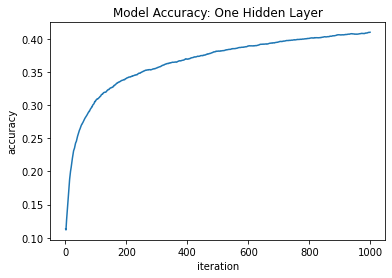

In [ ]:
# plot training history
fig = plt.plot(figsize=(12, 4))
iteration = list(range(1,1000))

# History for accuracy
plt.plot(iteration, acc_h_1_hidden_02)
plt.title('Model Accuracy: One Hidden Layer')
plt.ylabel('accuracy')
plt.xlabel('iteration')

plt.savefig("one_hidden.png")

500 iterations

In [ ]:
model_1_hidden = MLP_2(M=[256], n_hidden = 1, L2_lambda = 0)
optimizer = GradientDescent(learning_rate=.05, max_iters=500)

In [ ]:
yh_1_hidden = model_1_hidden.fit(train_images, train_labels, optimizer)

1
[[0.19133696 0.06080404 0.10221976 ... 0.15205873 0.13512575 0.03677204]
 [0.13270392 0.07677783 0.12678209 ... 0.2519153  0.05681102 0.03245227]
 [0.08887325 0.03693604 0.10682772 ... 0.06821636 0.03025111 0.04647897]
 ...
 [0.12591765 0.06521953 0.11367803 ... 0.08017223 0.03539668 0.0802874 ]
 [0.16063085 0.03446943 0.0881114  ... 0.11462756 0.08715634 0.02207307]
 [0.17166037 0.07114931 0.11507405 ... 0.11135612 0.0716107  0.0286018 ]]
2
[[0.14617019 0.09299171 0.08191551 ... 0.06245241 0.1841289  0.10924755]
 [0.11591653 0.1498489  0.09852021 ... 0.08372758 0.11390713 0.15434523]
 [0.07523009 0.07646342 0.07281453 ... 0.0227485  0.06324078 0.26950056]
 ...
 [0.09801189 0.10268746 0.07061714 ... 0.02775748 0.06188984 0.29529765]
 [0.1284074  0.07781077 0.06173555 ... 0.02730467 0.21798572 0.16524495]
 [0.13194222 0.13482325 0.08042695 ... 0.03445094 0.12733721 0.13995609]]
3
[[0.18493109 0.06253626 0.10356018 ... 0.14009597 0.06722503 0.04686988]
 [0.15589359 0.08625689 0.1193484

In [ ]:
yh_1_hidden = model_1_hidden.predict(test_images)

In [ ]:
yh = decoding_labels(yh_1_hidden)

In [ ]:
yh

array([3., 9., 8., ..., 5., 6., 7.])

In [ ]:
y = np.argmax(test_labels, axis=1)

In [ ]:
y

array([3, 8, 8, ..., 5, 1, 7])

In [ ]:
acc = accuracy (yh, y)

In [ ]:
acc

0.4028

1000 iterations, lr = 0.05

In [ ]:
model_1_hidden = MLP_2(M=[256], n_hidden = 1, L2_lambda = 0)
optimizer = GradientDescent(learning_rate=.05, max_iters=1000)

In [ ]:
yh_1_hidden = model_1_hidden.fit(train_images, train_labels, optimizer)

Streaming output truncated to the last 5000 lines.
acc: 0.4185


iteration: 549
[[0.00718124 0.09583058 0.04778857 ... 0.05463954 0.00411187 0.02041833]
 [0.0422009  0.53332324 0.0216497  ... 0.00653566 0.2735677  0.04873945]
 [0.03544665 0.16564917 0.00383332 ... 0.01183153 0.31215915 0.43806345]
 ...
 [0.10253679 0.17080387 0.00478623 ... 0.00445552 0.23058257 0.47842475]
 [0.19072087 0.05251281 0.03244546 ... 0.00973816 0.58492744 0.08830871]
 [0.09983831 0.11571025 0.09131085 ... 0.07419086 0.0971492  0.2366626 ]]
acc: 0.4120


iteration: 550
[[0.00640401 0.08079984 0.04746521 ... 0.12826361 0.00211363 0.02617392]
 [0.0488026  0.5375333  0.03006212 ... 0.02208229 0.15956359 0.0963309 ]
 [0.03169575 0.1135021  0.00356665 ... 0.03491414 0.1300816  0.65071664]
 ...
 [0.08427637 0.13295607 0.00461814 ... 0.00853027 0.11293212 0.64788842]
 [0.25356442 0.05983112 0.05433747 ... 0.05315892 0.2890709  0.21658809]
 [0.0741572  0.07086696 0.07355996 ... 0.21016318 0.03572626 0.28231511]]
acc

In [ ]:
yh_1_hidden = model_1_hidden.predict(test_images)

In [ ]:
yh = decoding_labels(yh_1_hidden)

In [ ]:
yh

array([3., 9., 8., ..., 5., 6., 7.])

In [ ]:
y = np.argmax(test_labels, axis=1)

In [ ]:
y

array([3, 8, 8, ..., 5, 1, 7])

In [ ]:
acc_history = model_1_hidden.acc_history
len(acc_history)

2047

In [ ]:
acc = accuracy (yh, y)

In [ ]:
acc

0.4436

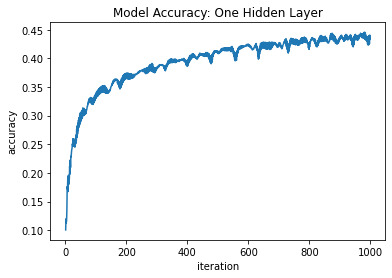

In [ ]:
# plot training history
fig = plt.plot(figsize=(12, 4))
iteration = list(range(1,1000))

# History for accuracy
plt.plot(iteration, acc_history[1048:2047])
plt.title('Model Accuracy: One Hidden Layer')
plt.ylabel('accuracy')
plt.xlabel('iteration')

plt.savefig("one_hidden.png")

### 2 Hidden layers

In [ ]:
def objective(trial):
    # Define the search space for the hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    #L2_lambda = trial.suggest_float("L2_lambda", 1e-6, 1e-2, log=True)

    # Create the MLP_2 model with the given hyperparameters
    model_2_hidden = MLP_2(M=[256, 256], n_hidden = 2, L2_lambda = 0)
    optimizer = GradientDescent(learning_rate=learning_rate, max_iters=5)

    # Train the model and compute its validation accuracy
    yh_2_hidden = model_2_hidden.fit(train_images, train_labels, optimizer)
    val_acc = yh_2_hidden.acc_history[-1]

    return val_acc

# Define the search method and run the optimization process
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Print the best hyperparameters found by Optuna
print("Best hyperparameters: ", study.best_params)

[I 2023-03-09 05:05:44,842] A new study created in memory with name: no-name-44e0b50f-d67e-4a7a-a92a-ed4bd76bfa4f


1
[[0.08396035 0.14322481 0.10087216 ... 0.18069659 0.06747878 0.07545715]
 [0.09387445 0.13833701 0.08451464 ... 0.22806584 0.10831239 0.04141696]
 [0.07013131 0.18667233 0.12190502 ... 0.14761426 0.04903968 0.05054678]
 ...
 [0.07531251 0.17015556 0.15004452 ... 0.11839505 0.09315254 0.04809348]
 [0.08558449 0.1874842  0.10787109 ... 0.17845955 0.06801669 0.04163675]
 [0.09124805 0.13270748 0.11021964 ... 0.17448378 0.06053279 0.04938226]]
acc: 0.1027


2
[[0.09531981 0.12603682 0.10488318 ... 0.1549796  0.07513989 0.08363612]
 [0.11069639 0.12005809 0.09125652 ... 0.190588   0.12727021 0.04743729]
 [0.08332972 0.16146427 0.12976894 ... 0.12388504 0.05769403 0.06038371]
 ...
 [0.08567798 0.15129677 0.15363302 ... 0.10187426 0.10535094 0.05393856]
 [0.10688392 0.15453979 0.1159892  ... 0.14331603 0.0824367  0.05104066]
 [0.10658746 0.11528267 0.11495971 ... 0.14479672 0.07049094 0.05790091]]
acc: 0.1019


3
[[0.10220027 0.11513464 0.10486587 ... 0.14073697 0.08075949 0.08938039]
 [0.1

[I 2023-03-09 05:06:23,234] Trial 0 finished with value: 0.113 and parameters: {'learning_rate': 0.013473654585613384}. Best is trial 0 with value: 0.113.


1
[[0.07000672 0.10253419 0.10422565 ... 0.04577192 0.09429888 0.08058867]
 [0.07396259 0.09589185 0.07534608 ... 0.03128721 0.09229543 0.06583779]
 [0.05360401 0.0795093  0.06709566 ... 0.05527906 0.09557662 0.0927718 ]
 ...
 [0.06127877 0.11385616 0.08921353 ... 0.04519703 0.09154037 0.08953096]
 [0.05386169 0.09220897 0.06536123 ... 0.04576152 0.09543675 0.07126613]
 [0.06548574 0.08495733 0.07907807 ... 0.03851828 0.07966881 0.08573794]]
acc: 0.0951


2
[[0.07015067 0.10256308 0.10432063 ... 0.04587775 0.09432953 0.08067627]
 [0.07420068 0.0959719  0.07546844 ... 0.03139082 0.09240171 0.06595034]
 [0.05376512 0.07954846 0.06719344 ... 0.055461   0.09574285 0.09295595]
 ...
 [0.06138971 0.11388449 0.08927973 ... 0.04529318 0.0916312  0.08964051]
 [0.05409109 0.09223383 0.06549107 ... 0.04596135 0.09558836 0.07142194]
 [0.06567728 0.08499589 0.07916232 ... 0.03863941 0.07978192 0.08591396]]
acc: 0.0950


3
[[0.07029625 0.1025918  0.10441253 ... 0.04598447 0.09436023 0.08076264]
 [0.0

[I 2023-03-09 05:07:01,344] Trial 1 finished with value: 0.0951 and parameters: {'learning_rate': 0.0002021877030653436}. Best is trial 0 with value: 0.113.


1
[[0.09957125 0.06827388 0.05356627 ... 0.11740093 0.0777254  0.17298205]
 [0.12600333 0.04707479 0.04366606 ... 0.06320706 0.0538019  0.13426915]
 [0.15376675 0.06327946 0.04008953 ... 0.08779543 0.05258105 0.11625953]
 ...
 [0.11570775 0.0707309  0.04104722 ... 0.08035891 0.06168777 0.15969247]
 [0.13112472 0.04967603 0.04848574 ... 0.0700713  0.05663905 0.14057375]
 [0.13076834 0.04569379 0.04336199 ... 0.09591203 0.06236247 0.11731467]]
acc: 0.0839


2
[[0.09957958 0.06829666 0.0536019  ... 0.11742215 0.07775588 0.17294667]
 [0.12602699 0.04711272 0.04371009 ... 0.06323683 0.05384061 0.13426111]
 [0.15378701 0.06332446 0.04012616 ... 0.08782231 0.05261691 0.11624499]
 ...
 [0.1157102  0.07076401 0.04107515 ... 0.08037416 0.0617213  0.15968217]
 [0.13114793 0.04971848 0.04854875 ... 0.07011066 0.05668693 0.14053704]
 [0.13081004 0.04572818 0.04340639 ... 0.09594412 0.06240802 0.11730352]]
acc: 0.0840


3
[[0.09958785 0.06831939 0.0536375  ... 0.1174433  0.07778631 0.1729113 ]
 [0.1

[I 2023-03-09 05:07:43,731] Trial 2 finished with value: 0.0841 and parameters: {'learning_rate': 6.33439217997391e-05}. Best is trial 0 with value: 0.113.


1
[[0.09364586 0.09502001 0.0786156  ... 0.09172984 0.10298107 0.0851212 ]
 [0.08371215 0.10756323 0.07405192 ... 0.15872367 0.10665944 0.09395841]
 [0.10149822 0.07013852 0.07677809 ... 0.19338413 0.13855    0.05856587]
 ...
 [0.10036256 0.09745211 0.09365972 ... 0.14508115 0.12476663 0.07478656]
 [0.08496401 0.08748398 0.07874682 ... 0.21060584 0.10283245 0.08625387]
 [0.09764221 0.09595495 0.05772325 ... 0.1683987  0.10545822 0.06995683]]
acc: 0.0965


2
[[0.09376301 0.09506265 0.07869932 ... 0.0915133  0.10301978 0.08521368]
 [0.08387318 0.10766225 0.07416994 ... 0.15830142 0.10674545 0.09414996]
 [0.10175959 0.07021654 0.07692021 ... 0.1928417  0.1386815  0.05872323]
 ...
 [0.10055482 0.09751265 0.09376171 ... 0.14470325 0.12482889 0.07492322]
 [0.08524163 0.08763551 0.07893534 ... 0.20997706 0.10298739 0.08652182]
 [0.09786041 0.09602771 0.05782468 ... 0.16790534 0.10551688 0.07011512]]
acc: 0.0967


3
[[0.09387925 0.09510471 0.07878235 ... 0.09129855 0.1030577  0.08530549]
 [0.0

[I 2023-03-09 05:08:23,756] Trial 3 finished with value: 0.0964 and parameters: {'learning_rate': 0.0002042499375328751}. Best is trial 0 with value: 0.113.


1
[[0.07903736 0.18828905 0.0766455  ... 0.08730305 0.09789268 0.12296534]
 [0.0701078  0.26010116 0.06237264 ... 0.08636941 0.07295081 0.10105599]
 [0.04742535 0.26413527 0.04453718 ... 0.08513408 0.0661085  0.146462  ]
 ...
 [0.06157627 0.18404485 0.05125014 ... 0.10202204 0.09036305 0.13299762]
 [0.05529781 0.25560215 0.05703407 ... 0.08709991 0.07722487 0.12858135]
 [0.0587404  0.28067682 0.04967744 ... 0.08983827 0.08032948 0.13511455]]
acc: 0.0993


2
[[0.08136984 0.1805619  0.0784284  ... 0.08792697 0.10011297 0.12184006]
 [0.07349949 0.24812729 0.06454325 ... 0.08754396 0.07573696 0.10099062]
 [0.04977206 0.25228319 0.04625703 ... 0.08651177 0.06906893 0.14669356]
 ...
 [0.0640693  0.17550374 0.05268636 ... 0.10262539 0.09314629 0.13267703]
 [0.05894111 0.24065334 0.05977885 ... 0.08895757 0.08115574 0.12871316]
 [0.0616708  0.26748965 0.05167214 ... 0.09109767 0.08347196 0.13525568]]
acc: 0.0990


3
[[0.08355148 0.17378446 0.08007508 ... 0.08843191 0.10212783 0.12066742]
 [0.0

[I 2023-03-09 05:09:01,866] Trial 4 finished with value: 0.0996 and parameters: {'learning_rate': 0.0026341110605657796}. Best is trial 0 with value: 0.113.


1
[[0.11682331 0.06653124 0.11880649 ... 0.08453647 0.11174169 0.10342525]
 [0.14375779 0.07039013 0.11117579 ... 0.09173933 0.14152647 0.08868076]
 [0.10468551 0.05982109 0.1194313  ... 0.06904905 0.15357104 0.06153154]
 ...
 [0.12286583 0.07542563 0.13895189 ... 0.07978905 0.1304744  0.05717733]
 [0.13107209 0.06804998 0.12547549 ... 0.08410921 0.13211815 0.06142676]
 [0.1458141  0.07756275 0.10431531 ... 0.08077222 0.09545323 0.08284084]]
acc: 0.1131


2
[[0.11662888 0.0667494  0.11869089 ... 0.08460932 0.11158464 0.10366602]
 [0.14356802 0.07065157 0.11103842 ... 0.09181005 0.14139456 0.08894411]
 [0.10455321 0.06009786 0.11930068 ... 0.06911522 0.15348808 0.06184171]
 ...
 [0.12283472 0.07569442 0.1387746  ... 0.07980935 0.13047326 0.05741281]
 [0.13092546 0.06835932 0.12530379 ... 0.08416712 0.13206356 0.06170614]
 [0.14557311 0.0778569  0.10418621 ... 0.08081671 0.09535993 0.0831158 ]]
acc: 0.1128


3
[[0.11643628 0.06696599 0.11857613 ... 0.0846811  0.11142891 0.10390381]
 [0.1

[I 2023-03-09 05:09:40,702] Trial 5 finished with value: 0.1133 and parameters: {'learning_rate': 0.000543435838523484}. Best is trial 5 with value: 0.1133.


1
[[0.10775072 0.18843596 0.08258467 ... 0.05864843 0.05314848 0.14526234]
 [0.08211835 0.3055805  0.05745538 ... 0.07537692 0.04789424 0.12734147]
 [0.07489273 0.27521726 0.07921492 ... 0.05751764 0.04789635 0.14857312]
 ...
 [0.05640005 0.30822448 0.07217848 ... 0.06738933 0.05247695 0.12173321]
 [0.07609306 0.31091372 0.05833663 ... 0.07576888 0.04761003 0.14190071]
 [0.09094775 0.22849708 0.0831533  ... 0.08326665 0.05233279 0.11759728]]
acc: 0.1009


2
[[0.10777241 0.18830256 0.08261034 ... 0.05866102 0.05316907 0.14524255]
 [0.08215187 0.30535721 0.05748414 ... 0.07540824 0.04792777 0.12733373]
 [0.07492548 0.27500762 0.07925213 ... 0.05753922 0.04793195 0.14856583]
 ...
 [0.05641997 0.30803133 0.07220946 ... 0.06741161 0.05251048 0.12173454]
 [0.07613681 0.31062176 0.05837558 ... 0.07580602 0.04765056 0.14190797]
 [0.09097478 0.22830538 0.08318818 ... 0.08329639 0.05236219 0.11759006]]
acc: 0.1009


3
[[0.10779406 0.18816942 0.08263598 ... 0.0586736  0.05318965 0.14522275]
 [0.0

[I 2023-03-09 05:10:18,712] Trial 6 finished with value: 0.1009 and parameters: {'learning_rate': 3.0422719922591682e-05}. Best is trial 5 with value: 0.1133.


1
[[0.05067459 0.0580943  0.12364636 ... 0.13885338 0.11425829 0.17027276]
 [0.05460502 0.05068064 0.14357494 ... 0.12023898 0.10149753 0.16716235]
 [0.03457493 0.03587888 0.1053771  ... 0.14321217 0.06250615 0.27302822]
 ...
 [0.03560718 0.04812378 0.1381224  ... 0.14777276 0.06925694 0.18557783]
 [0.0268653  0.0228587  0.13879833 ... 0.15418091 0.07301739 0.31295586]
 [0.04645434 0.05103922 0.10766581 ... 0.14260125 0.11419785 0.23385727]]
acc: 0.1010


2
[[0.05077056 0.05818535 0.12361608 ... 0.13877436 0.11433819 0.16985757]
 [0.05473605 0.05079521 0.14353744 ... 0.12014778 0.10160152 0.16664445]
 [0.03467349 0.03598071 0.10540018 ... 0.14318354 0.06260019 0.27238001]
 ...
 [0.03567205 0.04820837 0.13806436 ... 0.14771264 0.06932603 0.18523827]
 [0.02696804 0.02294704 0.13882018 ... 0.15422217 0.07318524 0.31205665]
 [0.04656662 0.05116556 0.10766947 ... 0.14253364 0.1143135  0.2332796 ]]
acc: 0.1005


3
[[0.05086635 0.05827613 0.12358556 ... 0.13869529 0.11441749 0.16944519]
 [0.0

[I 2023-03-09 05:10:57,029] Trial 7 finished with value: 0.1004 and parameters: {'learning_rate': 0.00012757963161017096}. Best is trial 5 with value: 0.1133.


1
[[0.06160332 0.06508983 0.06531024 ... 0.16979015 0.1686145  0.09884379]
 [0.04960328 0.05419138 0.06843499 ... 0.12973666 0.20078604 0.10040993]
 [0.04385138 0.07045956 0.05037321 ... 0.13291688 0.19167984 0.13275223]
 ...
 [0.07983355 0.06028365 0.06225831 ... 0.20545646 0.11940068 0.1207773 ]
 [0.04325305 0.03992981 0.06326673 ... 0.14821898 0.16741969 0.11850736]
 [0.04712761 0.06516069 0.06204062 ... 0.1728686  0.12944657 0.13523845]]
acc: 0.1227


2
[[0.06162855 0.06510902 0.06533527 ... 0.16973858 0.16857499 0.09884105]
 [0.04962927 0.05421198 0.0684679  ... 0.12968903 0.20073278 0.10041407]
 [0.04387853 0.07048476 0.05039623 ... 0.13286034 0.19164024 0.1327703 ]
 ...
 [0.07987279 0.06030107 0.06228055 ... 0.20538117 0.11937716 0.12078695]
 [0.04328533 0.03994738 0.06330585 ... 0.14815466 0.16737556 0.11851675]
 [0.04715334 0.06518383 0.06207074 ... 0.17280606 0.12941163 0.13524354]]
acc: 0.1227


3
[[0.06165377 0.0651282  0.06536028 ... 0.16968706 0.16853552 0.0988383 ]
 [0.0

[I 2023-03-09 05:11:37,184] Trial 8 finished with value: 0.1227 and parameters: {'learning_rate': 3.242264094678208e-05}. Best is trial 8 with value: 0.1227.


1
[[0.10774981 0.14884346 0.10854958 ... 0.09928259 0.05987311 0.1284084 ]
 [0.08315127 0.17841888 0.10277709 ... 0.07845367 0.07463106 0.10860897]
 [0.07188136 0.17725905 0.12683119 ... 0.08742675 0.05172845 0.11551235]
 ...
 [0.07897696 0.18242508 0.11368698 ... 0.1181691  0.06250592 0.10255783]
 [0.07141081 0.29170077 0.10090263 ... 0.08413638 0.04168393 0.09748254]
 [0.12830728 0.18220548 0.09374708 ... 0.09579595 0.06509674 0.10893188]]
acc: 0.0976


2
[[0.12503469 0.07167901 0.09194305 ... 0.11614049 0.08516917 0.11585397]
 [0.10623789 0.0774747  0.08321797 ... 0.0911336  0.12566207 0.1002554 ]
 [0.09035083 0.07009336 0.10179541 ... 0.10102555 0.09936969 0.11996518]
 ...
 [0.0968555  0.09293959 0.09245644 ... 0.13670036 0.10243207 0.10841932]
 [0.11112616 0.09394546 0.08299449 ... 0.11889392 0.10124633 0.09756522]
 [0.15874503 0.07181474 0.07669243 ... 0.11514374 0.10829549 0.09952359]]
acc: 0.1212


3
[[0.11542508 0.08819207 0.10410639 ... 0.10743738 0.08153545 0.11114909]
 [0.1

[I 2023-03-09 05:12:16,935] Trial 9 finished with value: 0.151 and parameters: {'learning_rate': 0.05916000919921959}. Best is trial 9 with value: 0.151.


1
[[0.09993537 0.0790689  0.05462158 ... 0.0836801  0.15309595 0.11580567]
 [0.09571728 0.07037141 0.07833993 ... 0.06039299 0.1540137  0.12190636]
 [0.07411463 0.09022621 0.04893845 ... 0.03828111 0.14069429 0.14286608]
 ...
 [0.10648317 0.10371633 0.0428965  ... 0.05022968 0.12822602 0.10997923]
 [0.09620311 0.10110071 0.04041411 ... 0.03519044 0.14582255 0.13607931]
 [0.11322433 0.1147808  0.04826083 ... 0.04678777 0.17866201 0.11520658]]
acc: 0.0784


2
[[0.13385596 0.08320334 0.10399194 ... 0.14511343 0.08269629 0.08760335]
 [0.14188951 0.07849081 0.14669076 ... 0.12018466 0.10152452 0.07908971]
 [0.14806613 0.11593222 0.12765938 ... 0.10235094 0.09467504 0.1155097 ]
 ...
 [0.16570916 0.12283006 0.08107124 ... 0.10075232 0.09476035 0.09902747]
 [0.1869188  0.11395516 0.12705348 ... 0.10347702 0.08605365 0.09394366]
 [0.16569696 0.12055418 0.10622438 ... 0.10681173 0.11039027 0.08991168]]
acc: 0.0953


3
[[0.10032204 0.08940915 0.07884138 ... 0.1051239  0.0977052  0.09611525]
 [0.1

[I 2023-03-09 05:12:55,501] Trial 10 finished with value: 0.1572 and parameters: {'learning_rate': 0.08853831761883373}. Best is trial 10 with value: 0.1572.


1
[[0.10862497 0.07366363 0.20643218 ... 0.07358621 0.07150525 0.11175524]
 [0.09505735 0.09986933 0.29084275 ... 0.0704458  0.05357007 0.06976331]
 [0.08393055 0.08989505 0.29249674 ... 0.08742788 0.06027589 0.06491224]
 ...
 [0.09160348 0.08144199 0.27811347 ... 0.10430947 0.05920232 0.09479099]
 [0.09554892 0.12301966 0.28182501 ... 0.0743632  0.04608232 0.05236193]
 [0.12154768 0.10717937 0.27644731 ... 0.07258877 0.0536759  0.07288669]]
acc: 0.1004


2
[[0.12248104 0.0836788  0.05738456 ... 0.11388749 0.11239392 0.13226956]
 [0.1231457  0.11453066 0.04631268 ... 0.13116487 0.11008813 0.10057929]
 [0.11683216 0.12611227 0.04695298 ... 0.14640093 0.12337929 0.10473613]
 ...
 [0.1158244  0.10139261 0.06233101 ... 0.15166919 0.10980227 0.13553084]
 [0.12080579 0.15850617 0.02657151 ... 0.15258179 0.12075125 0.08205173]
 [0.14235476 0.1294483  0.04813662 ... 0.12365348 0.10407332 0.10870776]]
acc: 0.0914


3
[[0.1232799  0.07418665 0.08605339 ... 0.08498683 0.10445467 0.13775326]
 [0.1

[I 2023-03-09 05:13:33,282] Trial 11 finished with value: 0.1291 and parameters: {'learning_rate': 0.05984267250645135}. Best is trial 10 with value: 0.1572.


1
[[0.1096608  0.10867669 0.06764344 ... 0.14186298 0.06940192 0.12167479]
 [0.11677831 0.12337075 0.0991593  ... 0.17059329 0.04239777 0.09497086]
 [0.12447223 0.06883819 0.08621239 ... 0.11696294 0.0482236  0.16439742]
 ...
 [0.12627227 0.08566691 0.08312461 ... 0.17113683 0.05387176 0.12702147]
 [0.15141969 0.0690354  0.07998605 ... 0.14525141 0.05202156 0.13944186]
 [0.11732111 0.09264779 0.108586   ... 0.12526309 0.04925701 0.15194094]]
acc: 0.1093


2
[[0.11677053 0.11275886 0.07656878 ... 0.08139165 0.11547697 0.08915427]
 [0.15519991 0.12708447 0.11446531 ... 0.07999745 0.10017095 0.06892902]
 [0.14845777 0.07354071 0.10090141 ... 0.05529453 0.12971774 0.12232712]
 ...
 [0.14632251 0.09589559 0.09685377 ... 0.08919914 0.1203862  0.1004124 ]
 [0.18965637 0.06918974 0.09375322 ... 0.05230605 0.16287463 0.08883763]
 [0.14138201 0.09180055 0.12309962 ... 0.0621847  0.12280273 0.10590828]]
acc: 0.1221


3
[[0.07946104 0.10897049 0.07608523 ... 0.13207608 0.09353095 0.09732459]
 [0.0

[I 2023-03-09 05:14:10,794] Trial 12 finished with value: 0.1405 and parameters: {'learning_rate': 0.08900556302027159}. Best is trial 10 with value: 0.1572.


1
[[0.11093216 0.12977759 0.07734268 ... 0.05513771 0.05364357 0.11539555]
 [0.0719714  0.17711004 0.0607117  ... 0.02889549 0.05627683 0.12646424]
 [0.07125313 0.15697623 0.06119358 ... 0.03000558 0.03888243 0.17407415]
 ...
 [0.08492681 0.16373787 0.05716565 ... 0.03965868 0.06269097 0.1421764 ]
 [0.08405231 0.17696261 0.05030592 ... 0.02769729 0.04107354 0.18720965]
 [0.06788697 0.20997939 0.06341096 ... 0.02167346 0.03898713 0.1036208 ]]
acc: 0.1156


2
[[0.12349771 0.10550398 0.08483938 ... 0.07013176 0.0677139  0.11106753]
 [0.09137511 0.13898102 0.07043166 ... 0.04260977 0.0840161  0.13115833]
 [0.09496454 0.12501242 0.07233539 ... 0.04531579 0.05857461 0.18987668]
 ...
 [0.10142346 0.13417793 0.06437011 ... 0.05377529 0.08352865 0.15429216]
 [0.11443122 0.13075586 0.06121175 ... 0.04484919 0.06672489 0.19827281]
 [0.08910487 0.17075402 0.07690409 ... 0.03277837 0.0588766  0.1120659 ]]
acc: 0.1277


3
[[0.12457434 0.09516918 0.08902167 ... 0.08094395 0.07717374 0.10200444]
 [0.0

[I 2023-03-09 05:14:49,027] Trial 13 finished with value: 0.1272 and parameters: {'learning_rate': 0.018152474511319072}. Best is trial 10 with value: 0.1572.


1
[[0.04129214 0.09988619 0.15828395 ... 0.10490215 0.06651706 0.11868219]
 [0.03969565 0.13617406 0.14366892 ... 0.12440983 0.06382341 0.12957808]
 [0.03966111 0.15597741 0.24242062 ... 0.07920183 0.05501326 0.13122785]
 ...
 [0.04909804 0.11761229 0.20856368 ... 0.08726733 0.06453823 0.12873442]
 [0.03043474 0.14950217 0.23291077 ... 0.0716481  0.038131   0.11436008]
 [0.02192942 0.14129938 0.25563556 ... 0.10441279 0.0520897  0.08638548]]
acc: 0.1044


2
[[0.04494781 0.0993502  0.13969996 ... 0.10671748 0.07096314 0.11822424]
 [0.04535444 0.13562443 0.12260141 ... 0.12751812 0.06999306 0.12809279]
 [0.04591509 0.15797389 0.21052114 ... 0.08229691 0.06152912 0.13474163]
 ...
 [0.05456697 0.11805738 0.18561718 ... 0.08931695 0.07065473 0.13078352]
 [0.0363964  0.15035314 0.19393469 ... 0.07565241 0.04390803 0.11670493]
 [0.02554819 0.14125638 0.22047493 ... 0.11033274 0.05913575 0.08855295]]
acc: 0.1076


3
[[0.04830038 0.0980679  0.12694164 ... 0.10789474 0.07490409 0.11705842]
 [0.0

[I 2023-03-09 05:15:28,102] Trial 14 finished with value: 0.1205 and parameters: {'learning_rate': 0.004628508690110586}. Best is trial 10 with value: 0.1572.


1
[[0.1202611  0.10960647 0.09939473 ... 0.08541551 0.12970992 0.05361838]
 [0.12905798 0.1283993  0.11327904 ... 0.07612133 0.14165874 0.0424329 ]
 [0.11631631 0.14086979 0.10459197 ... 0.05758181 0.1665942  0.04089294]
 ...
 [0.10877154 0.12774369 0.10643437 ... 0.06835306 0.15582583 0.0401306 ]
 [0.11416344 0.16423735 0.08402479 ... 0.07091255 0.12628166 0.01816425]
 [0.09739837 0.13303163 0.12478082 ... 0.07127674 0.14118073 0.04864782]]
acc: 0.0938


2
[[0.12802724 0.07433875 0.0945056  ... 0.10722403 0.07639569 0.15677888]
 [0.14621681 0.08603069 0.11232988 ... 0.08341158 0.08074762 0.15653536]
 [0.13929455 0.08490141 0.10314099 ... 0.07045939 0.09485021 0.20773689]
 ...
 [0.12181549 0.08981338 0.11790997 ... 0.0772547  0.10710817 0.14443707]
 [0.16276217 0.0996232  0.09400851 ... 0.08630335 0.06537175 0.14242162]
 [0.11369796 0.08400921 0.12385069 ... 0.08497247 0.07824066 0.19152458]]
acc: 0.1014


3
[[0.09191238 0.09552971 0.08844004 ... 0.12151111 0.10881408 0.05018119]
 [0.1

[I 2023-03-09 05:16:06,797] Trial 15 finished with value: 0.135 and parameters: {'learning_rate': 0.09375218755090924}. Best is trial 10 with value: 0.1572.


1
[[0.12550963 0.16071357 0.08954727 ... 0.08822259 0.05197021 0.14629741]
 [0.11708171 0.1816958  0.09782093 ... 0.13545813 0.04546208 0.12195117]
 [0.12296595 0.13326536 0.08257467 ... 0.13090832 0.04677398 0.07738097]
 ...
 [0.12773312 0.16131539 0.06872975 ... 0.16279645 0.03860694 0.08399313]
 [0.10936495 0.15780629 0.07410844 ... 0.17784516 0.03163663 0.13585554]
 [0.12633554 0.11878361 0.07537882 ... 0.15479578 0.05746183 0.10736531]]
acc: 0.0836


2
[[0.12075711 0.13599895 0.10305317 ... 0.08037738 0.0722997  0.13205951]
 [0.11592486 0.1453971  0.11640486 ... 0.11641486 0.07199601 0.10756489]
 [0.12344243 0.10606858 0.1001638  ... 0.11282595 0.07240946 0.07076593]
 ...
 [0.12664    0.14071141 0.07939569 ... 0.14485472 0.05617326 0.08242935]
 [0.10990428 0.12257425 0.09571933 ... 0.15018663 0.05841507 0.12222289]
 [0.12438021 0.09510688 0.09026425 ... 0.13451855 0.0868798  0.09469589]]
acc: 0.1010


3
[[0.114273   0.12710511 0.10764173 ... 0.075996   0.08519526 0.12419039]
 [0.1

[I 2023-03-09 05:16:45,036] Trial 16 finished with value: 0.1145 and parameters: {'learning_rate': 0.02458992301328759}. Best is trial 10 with value: 0.1572.


1
[[0.03741281 0.09046709 0.10818119 ... 0.10129912 0.08247817 0.09376349]
 [0.0331966  0.07865879 0.12183024 ... 0.09033468 0.06502873 0.10493472]
 [0.04350082 0.07267376 0.07445683 ... 0.09979447 0.0766695  0.05724145]
 ...
 [0.06422194 0.10951323 0.09655605 ... 0.11310739 0.08823645 0.07753555]
 [0.02821253 0.0796302  0.09314393 ... 0.09042621 0.0723928  0.06112955]
 [0.04072514 0.08493271 0.08700929 ... 0.1027918  0.08585082 0.06916093]]
acc: 0.0996


2
[[0.04105261 0.09374301 0.10815473 ... 0.10144241 0.08750536 0.09769405]
 [0.03765973 0.08308533 0.12321417 ... 0.0918788  0.070506   0.1117051 ]
 [0.05034362 0.07771373 0.07618347 ... 0.10245816 0.08360973 0.06238424]
 ...
 [0.07097092 0.11381085 0.09583235 ... 0.11469658 0.09373693 0.08155273]
 [0.03403668 0.08621271 0.09679011 ... 0.09455612 0.08290475 0.0676737 ]
 [0.04712912 0.08992454 0.08921717 ... 0.10456855 0.09316344 0.07444213]]
acc: 0.0994


3
[[0.04432203 0.09604961 0.10786343 ... 0.10121467 0.09146567 0.1007098 ]
 [0.0

[I 2023-03-09 05:17:22,518] Trial 17 finished with value: 0.0983 and parameters: {'learning_rate': 0.00559836101834581}. Best is trial 10 with value: 0.1572.


1
[[0.10261571 0.10907934 0.07853171 ... 0.04885485 0.1071627  0.09188346]
 [0.10215293 0.16776486 0.04989892 ... 0.02987354 0.09642959 0.10333928]
 [0.20549849 0.17411042 0.06940251 ... 0.03562487 0.0932537  0.07078441]
 ...
 [0.23438885 0.15911904 0.06964304 ... 0.03276625 0.08696066 0.07872125]
 [0.23277729 0.13180713 0.05029719 ... 0.02746685 0.11999501 0.10811401]
 [0.19264944 0.11356725 0.05450625 ... 0.03338027 0.11539995 0.09765827]]
acc: 0.1233


2
[[0.08265023 0.09615384 0.10473794 ... 0.06925276 0.1131435  0.09199004]
 [0.08978275 0.14243301 0.07943448 ... 0.05034302 0.11214685 0.1135837 ]
 [0.1779943  0.14665428 0.11102803 ... 0.06065615 0.1141218  0.07919835]
 ...
 [0.20530246 0.13675326 0.09974237 ... 0.05190924 0.10250283 0.08896   ]
 [0.19093867 0.11211431 0.09010398 ... 0.05253182 0.1482172  0.12192589]
 [0.15979917 0.10185346 0.08374414 ... 0.05547701 0.13345685 0.10914699]]
acc: 0.1282


3
[[0.07385744 0.0916269  0.10812616 ... 0.08328654 0.10746349 0.0872176 ]
 [0.0

[I 2023-03-09 05:17:59,728] Trial 18 finished with value: 0.1375 and parameters: {'learning_rate': 0.033897280246673676}. Best is trial 10 with value: 0.1572.


1
[[0.1399534  0.04796258 0.04593577 ... 0.12600142 0.10118475 0.08641899]
 [0.16272685 0.0545227  0.06675549 ... 0.15064909 0.07899834 0.0700619 ]
 [0.16652329 0.07959122 0.05253968 ... 0.10937532 0.0679126  0.061641  ]
 ...
 [0.15404796 0.06707174 0.07563963 ... 0.12151828 0.0774864  0.10228673]
 [0.19270238 0.05612272 0.04588167 ... 0.10231923 0.08363009 0.05966568]
 [0.19521811 0.08868651 0.05042476 ... 0.07037494 0.07833449 0.08002915]]
acc: 0.1160


2
[[0.13994467 0.04796657 0.04594076 ... 0.126003   0.10118674 0.0864245 ]
 [0.16271618 0.05452827 0.06676358 ... 0.15064883 0.07900146 0.07006778]
 [0.16651467 0.07959984 0.05254676 ... 0.10937806 0.06791613 0.06164733]
 ...
 [0.15404106 0.06707742 0.07564645 ... 0.12151807 0.07748944 0.10229464]
 [0.19269206 0.05613035 0.04588966 ... 0.10232114 0.08363548 0.05967402]
 [0.19520593 0.0886968  0.05043171 ... 0.07037599 0.07833819 0.08003773]]
acc: 0.1160


3
[[0.13993594 0.04797056 0.04594574 ... 0.12600458 0.10118874 0.08643001]
 [0.1

[I 2023-03-09 05:18:37,814] Trial 19 finished with value: 0.116 and parameters: {'learning_rate': 1.0509270583927313e-05}. Best is trial 10 with value: 0.1572.


1
[[0.05620231 0.13437674 0.09909273 ... 0.16167071 0.04971188 0.06559434]
 [0.03106004 0.14212878 0.11407378 ... 0.19682287 0.03126717 0.06612984]
 [0.03478955 0.19241375 0.09954575 ... 0.14797846 0.03027734 0.07965854]
 ...
 [0.04332983 0.14160878 0.08098688 ... 0.117209   0.04639964 0.09493791]
 [0.03352108 0.14959256 0.11756427 ... 0.1571783  0.02895169 0.08048955]
 [0.03654172 0.15932692 0.10550463 ... 0.12883239 0.04043858 0.0643675 ]]
acc: 0.1051


2
[[0.09370124 0.08791249 0.11179731 ... 0.10728724 0.07957829 0.07822944]
 [0.06389967 0.08808699 0.12905466 ... 0.12763597 0.06693112 0.08936002]
 [0.08267664 0.11087714 0.11325262 ... 0.09019376 0.06779448 0.10704946]
 ...
 [0.07924353 0.09393671 0.08682534 ... 0.0780837  0.08422933 0.115097  ]
 [0.08274449 0.07343269 0.13134199 ... 0.09002139 0.06988181 0.10912127]
 [0.08115862 0.09365393 0.11826315 ... 0.08402179 0.0783306  0.08108918]]
acc: 0.1021


3
[[0.10773124 0.08901655 0.11348188 ... 0.10554978 0.09674181 0.07674804]
 [0.0

[I 2023-03-09 05:19:17,818] Trial 20 finished with value: 0.1422 and parameters: {'learning_rate': 0.04216855363990709}. Best is trial 10 with value: 0.1572.


1
[[0.1076083  0.05211367 0.1249392  ... 0.07969811 0.18561393 0.13600065]
 [0.13708005 0.057594   0.11517537 ... 0.05914857 0.14483665 0.11162562]
 [0.10194505 0.0532058  0.13657537 ... 0.04461432 0.17716574 0.11124144]
 ...
 [0.12245453 0.05548823 0.11547331 ... 0.06114211 0.12230069 0.12107303]
 [0.11445871 0.04070125 0.10458444 ... 0.07934237 0.15677992 0.13650889]
 [0.12213122 0.05876396 0.12753953 ... 0.10178799 0.10782205 0.12248732]]
acc: 0.0943


2
[[0.11349068 0.08928594 0.11179079 ... 0.12074259 0.11533641 0.10514058]
 [0.15130311 0.10683232 0.09319079 ... 0.09074903 0.09316067 0.08785882]
 [0.11676648 0.10934241 0.1252211  ... 0.07675027 0.11396044 0.09797889]
 ...
 [0.13689099 0.09407566 0.10361898 ... 0.08895294 0.08467223 0.10403145]
 [0.12944521 0.09351851 0.08713855 ... 0.14328512 0.08621386 0.10678043]
 [0.13461675 0.09955763 0.10482669 ... 0.14596905 0.06327262 0.08516536]]
acc: 0.1082


3
[[0.10465711 0.09082981 0.10553153 ... 0.10058848 0.12913824 0.11133557]
 [0.1

[I 2023-03-09 05:19:55,862] Trial 21 finished with value: 0.1482 and parameters: {'learning_rate': 0.04696642024308047}. Best is trial 10 with value: 0.1572.


1
[[0.10149367 0.09433932 0.07307704 ... 0.06058558 0.14240349 0.12901802]
 [0.10720823 0.07456546 0.0507252  ... 0.05435611 0.13979422 0.14785745]
 [0.07668434 0.07843172 0.07937401 ... 0.07644301 0.08142507 0.17641709]
 ...
 [0.09879178 0.08800064 0.08263045 ... 0.0651886  0.08911317 0.18468512]
 [0.09652359 0.07767158 0.06771794 ... 0.05952659 0.11120944 0.16550803]
 [0.07467975 0.10507066 0.06971478 ... 0.08278067 0.07452396 0.15403743]]
acc: 0.1223


2
[[0.13009767 0.09288247 0.11436393 ... 0.09405805 0.16224803 0.06666758]
 [0.16546258 0.07096698 0.09547222 ... 0.09475528 0.17392546 0.06299584]
 [0.12091326 0.07972544 0.14299764 ... 0.13401211 0.12240515 0.08923381]
 ...
 [0.13997825 0.09196356 0.13058658 ... 0.10353141 0.11297678 0.10523288]
 [0.16974278 0.07050458 0.13152113 ... 0.12431267 0.15268829 0.05414257]
 [0.11219772 0.1050485  0.13340353 ... 0.16051839 0.09993153 0.07467424]]
acc: 0.1118


3
[[0.07260386 0.1056237  0.08570511 ... 0.09553739 0.11657515 0.12567226]
 [0.0

[I 2023-03-09 05:20:34,334] Trial 22 finished with value: 0.1147 and parameters: {'learning_rate': 0.09849738395888402}. Best is trial 10 with value: 0.1572.


1
[[0.10859972 0.09374033 0.06576769 ... 0.11859877 0.06356202 0.06594922]
 [0.15747987 0.09839829 0.05667231 ... 0.11259638 0.06240536 0.05746766]
 [0.16159137 0.08425326 0.06208266 ... 0.13179769 0.08361011 0.0507333 ]
 ...
 [0.1841034  0.07073507 0.05049701 ... 0.1296023  0.09740134 0.07780841]
 [0.18209    0.09377279 0.05236004 ... 0.15496603 0.04899732 0.04462998]
 [0.12775075 0.10427458 0.03893071 ... 0.12890691 0.06904577 0.07238197]]
acc: 0.1256


2
[[0.10145689 0.09565493 0.0703156  ... 0.11299802 0.06872779 0.0743172 ]
 [0.14744323 0.10144128 0.06126791 ... 0.10759052 0.07047631 0.06675268]
 [0.14932704 0.08751469 0.06646967 ... 0.1252327  0.09547296 0.06030596]
 ...
 [0.1734925  0.07277836 0.05276609 ... 0.12300407 0.10734251 0.08856535]
 [0.16965162 0.09874256 0.05838877 ... 0.14808112 0.05799512 0.0556593 ]
 [0.11802823 0.10804643 0.04196092 ... 0.12033646 0.0780471  0.08523327]]
acc: 0.1267


3
[[0.0968739  0.09626005 0.07445793 ... 0.1084827  0.07282404 0.08121087]
 [0.1

[I 2023-03-09 05:21:11,913] Trial 23 finished with value: 0.1318 and parameters: {'learning_rate': 0.01320888451732735}. Best is trial 10 with value: 0.1572.


1
[[0.04161891 0.1263938  0.12213168 ... 0.05238093 0.12372773 0.10016169]
 [0.04900874 0.11357581 0.13283911 ... 0.03744694 0.09352798 0.08935054]
 [0.08703431 0.11121507 0.17150882 ... 0.041855   0.08582522 0.05510537]
 ...
 [0.07128029 0.09977691 0.15351139 ... 0.04977638 0.09369915 0.07124692]
 [0.04192372 0.09726544 0.16219715 ... 0.02750552 0.08781327 0.04729796]
 [0.0477227  0.15034832 0.10309356 ... 0.03288423 0.10535888 0.05690662]]
acc: 0.1006


2
[[0.09174603 0.12558869 0.09481208 ... 0.09907417 0.12610305 0.1292437 ]
 [0.13136793 0.1082072  0.10938737 ... 0.08146667 0.10105327 0.12660836]
 [0.22298555 0.09146566 0.12851691 ... 0.0844619  0.08885922 0.07970042]
 ...
 [0.1569728  0.09147061 0.11946869 ... 0.08737366 0.10475047 0.10442592]
 [0.16756936 0.08796341 0.12082663 ... 0.08063811 0.10357743 0.08382328]
 [0.13889749 0.13308738 0.08658756 ... 0.07808434 0.10674361 0.08374106]]
acc: 0.1164


3
[[0.07846772 0.11032122 0.09799388 ... 0.09973116 0.1221935  0.12088767]
 [0.1

[I 2023-03-09 05:21:54,472] Trial 24 finished with value: 0.1242 and parameters: {'learning_rate': 0.04392528418126029}. Best is trial 10 with value: 0.1572.


1
[[0.12346193 0.07350195 0.07054188 ... 0.0439798  0.13347349 0.0848596 ]
 [0.1086225  0.06733496 0.06661699 ... 0.04541076 0.10905274 0.07001469]
 [0.12411075 0.07474062 0.0787101  ... 0.02563336 0.11000966 0.06328785]
 ...
 [0.12487708 0.08091013 0.06634198 ... 0.03269259 0.0957548  0.07406119]
 [0.15791194 0.06202592 0.06211677 ... 0.02646256 0.10580798 0.05014019]
 [0.16221767 0.05116529 0.08061881 ... 0.0432073  0.10190231 0.06924323]]
acc: 0.0986


2
[[0.10132528 0.11285871 0.10408113 ... 0.08309057 0.11715009 0.11180742]
 [0.08530622 0.12514264 0.10704971 ... 0.10167531 0.11081769 0.09617002]
 [0.0969078  0.15288972 0.13597903 ... 0.06494481 0.12111266 0.11014775]
 ...
 [0.10465126 0.14320744 0.10426745 ... 0.06383198 0.10148203 0.11700995]
 [0.12269312 0.1608956  0.14083879 ... 0.08640018 0.11027314 0.0955662 ]
 [0.13127836 0.0881665  0.14908689 ... 0.09912459 0.10080982 0.10499113]]
acc: 0.1095


3
[[0.10657802 0.09762921 0.07986283 ... 0.09481489 0.11904729 0.09887289]
 [0.0

[I 2023-03-09 05:22:31,984] Trial 25 finished with value: 0.1589 and parameters: {'learning_rate': 0.03907876497282444}. Best is trial 25 with value: 0.1589.


1
[[0.07358887 0.14798014 0.08838781 ... 0.12653763 0.12509736 0.12212148]
 [0.12525679 0.11670599 0.07625932 ... 0.12668796 0.21248546 0.09804717]
 [0.1252195  0.10584607 0.09350775 ... 0.08624638 0.20754884 0.08748331]
 ...
 [0.13964119 0.09201888 0.08528185 ... 0.07254431 0.21033582 0.09611392]
 [0.15642933 0.11304282 0.08649592 ... 0.07965269 0.286653   0.08097376]
 [0.10346762 0.11011902 0.07087776 ... 0.13062343 0.2053909  0.10600451]]
acc: 0.1050


2
[[0.07109575 0.14434147 0.09769763 ... 0.11780444 0.0961585  0.11911523]
 [0.12814533 0.11587748 0.09325614 ... 0.12555578 0.15463754 0.09790708]
 [0.12700981 0.10322707 0.1070826  ... 0.08562453 0.15234893 0.09014509]
 ...
 [0.14478168 0.08990635 0.09581742 ... 0.07124171 0.1655958  0.09676469]
 [0.16571325 0.11431119 0.11265586 ... 0.0809405  0.19249081 0.08755722]
 [0.10436184 0.10939322 0.08363097 ... 0.1312636  0.14358383 0.11121514]]
acc: 0.1068


3
[[0.07077873 0.13837227 0.10071503 ... 0.11164369 0.08702325 0.11454207]
 [0.1

[I 2023-03-09 05:23:11,529] Trial 26 finished with value: 0.1196 and parameters: {'learning_rate': 0.021108449414016954}. Best is trial 25 with value: 0.1589.


1
[[0.11954062 0.16611064 0.06006095 ... 0.0619664  0.12511756 0.07928557]
 [0.11325758 0.13899533 0.0454049  ... 0.05580125 0.12210221 0.05331526]
 [0.09165978 0.17120473 0.07233278 ... 0.04295334 0.15461944 0.05223758]
 ...
 [0.10858508 0.16947877 0.08259516 ... 0.05515791 0.17344694 0.04574112]
 [0.1251585  0.16064024 0.0471054  ... 0.04259908 0.14674733 0.04733329]
 [0.13225245 0.16859731 0.05831105 ... 0.03782585 0.12604384 0.08210025]]
acc: 0.0833


2
[[0.12056148 0.14991319 0.06393383 ... 0.06865984 0.12130816 0.08695314]
 [0.11778356 0.12385686 0.05082214 ... 0.06540812 0.1208763  0.0612478 ]
 [0.09437532 0.15053663 0.08121324 ... 0.0506962  0.15407713 0.06158378]
 ...
 [0.11147702 0.15320362 0.08868873 ... 0.06141077 0.17172277 0.05103504]
 [0.13176809 0.13862667 0.05450456 ... 0.05288203 0.14369438 0.05861757]
 [0.13556369 0.14985171 0.06387295 ... 0.0432992  0.12354858 0.09453124]]
acc: 0.0879


3
[[0.12063948 0.13845424 0.06682018 ... 0.07445537 0.11779151 0.09234512]
 [0.1

[I 2023-03-09 05:23:49,774] Trial 27 finished with value: 0.0983 and parameters: {'learning_rate': 0.01010648768290679}. Best is trial 25 with value: 0.1589.


1
[[0.17928669 0.10186888 0.09909903 ... 0.11166189 0.0564561  0.06164563]
 [0.25616395 0.09636194 0.06934334 ... 0.14098662 0.03560141 0.03638495]
 [0.33040521 0.08692448 0.06500879 ... 0.12441355 0.03671233 0.02629729]
 ...
 [0.21508695 0.14351949 0.06161609 ... 0.16275295 0.04148147 0.050225  ]
 [0.32445598 0.09255047 0.06493074 ... 0.15080913 0.03738611 0.02888451]
 [0.276773   0.09029752 0.08777508 ... 0.10819255 0.03816869 0.03515021]]
acc: 0.1000


2
[[0.10868397 0.09980716 0.10823722 ... 0.11155852 0.07489191 0.07899648]
 [0.15253012 0.10312479 0.08391344 ... 0.14408266 0.05247758 0.05207371]
 [0.18487635 0.0969416  0.08045869 ... 0.13588135 0.06267242 0.04506718]
 ...
 [0.1285015  0.1479946  0.069227   ... 0.1663781  0.06214326 0.07131037]
 [0.14746424 0.10104368 0.08295826 ... 0.16934327 0.07257539 0.05284401]
 [0.14516506 0.09598868 0.1023786  ... 0.1189129  0.06290855 0.05439502]]
acc: 0.1202


3
[[0.09662213 0.09458393 0.1098247  ... 0.10466195 0.08628145 0.09133338]
 [0.1

[I 2023-03-09 05:24:28,243] Trial 28 finished with value: 0.1304 and parameters: {'learning_rate': 0.027135621977412882}. Best is trial 25 with value: 0.1589.


1
[[0.08584133 0.18926078 0.08376179 ... 0.1346346  0.09712066 0.07079762]
 [0.08544306 0.15583773 0.08018317 ... 0.12875731 0.1045286  0.06554398]
 [0.05083527 0.15535647 0.09995459 ... 0.19699335 0.12557864 0.07888199]
 ...
 [0.071692   0.17480763 0.08220709 ... 0.12345559 0.14082976 0.06954336]
 [0.07132433 0.20818322 0.07404    ... 0.14760928 0.1039797  0.08293263]
 [0.0719621  0.1617476  0.09383292 ... 0.15321023 0.10178563 0.08237655]]
acc: 0.0917


2
[[0.09269685 0.17039433 0.08670132 ... 0.1262783  0.09998759 0.07451152]
 [0.09265784 0.13598452 0.08358995 ... 0.11969159 0.10914323 0.06930478]
 [0.05705683 0.13716345 0.10522339 ... 0.18136448 0.13283824 0.08617047]
 ...
 [0.07692701 0.15910443 0.08514846 ... 0.11577826 0.14632275 0.07423553]
 [0.08408132 0.17511576 0.08046272 ... 0.13212859 0.11281418 0.09148443]
 [0.07980385 0.14127209 0.09816682 ... 0.14314378 0.10697488 0.0871708 ]]
acc: 0.0963


3
[[0.09797999 0.15749745 0.08873243 ... 0.12041953 0.10163219 0.07692999]
 [0.0

[I 2023-03-09 05:25:06,590] Trial 29 finished with value: 0.1089 and parameters: {'learning_rate': 0.010153876126512326}. Best is trial 25 with value: 0.1589.


1
[[0.1152025  0.12874413 0.10028895 ... 0.08148064 0.08282969 0.01576971]
 [0.06931919 0.14569769 0.12026307 ... 0.05348391 0.06945075 0.02124114]
 [0.07115337 0.14819035 0.12878702 ... 0.06813844 0.10691167 0.02674162]
 ...
 [0.06332548 0.12016957 0.14439648 ... 0.07690763 0.07968347 0.03408016]
 [0.07450973 0.12578218 0.12771646 ... 0.04899547 0.10130154 0.01451487]
 [0.07615452 0.10906687 0.09810846 ... 0.05962499 0.12098459 0.01969885]]
acc: 0.1001


2
[[0.15186227 0.10803271 0.08262593 ... 0.12305914 0.10336297 0.03757669]
 [0.0980642  0.13391322 0.09689632 ... 0.08425867 0.10112251 0.05862156]
 [0.10340451 0.12829893 0.09105103 ... 0.10870485 0.16976541 0.08674019]
 ...
 [0.09450165 0.10776181 0.11123648 ... 0.10918013 0.11741796 0.08756903]
 [0.12419774 0.10818715 0.09443025 ... 0.08804618 0.1679214  0.05506496]
 [0.11266104 0.08559607 0.07010261 ... 0.09931677 0.17179199 0.05172197]]
acc: 0.1224


3
[[0.13290882 0.11294593 0.08797951 ... 0.11922428 0.08215701 0.05462112]
 [0.0

[I 2023-03-09 05:25:43,929] Trial 30 finished with value: 0.1638 and parameters: {'learning_rate': 0.05422739686380107}. Best is trial 30 with value: 0.1638.


1
[[0.05932131 0.1167862  0.07269983 ... 0.12900003 0.1835399  0.0354594 ]
 [0.0638102  0.11709915 0.05581807 ... 0.15520596 0.15540156 0.03410794]
 [0.03835347 0.10901395 0.04655769 ... 0.14781182 0.13683553 0.03130012]
 ...
 [0.04786923 0.1248929  0.06328768 ... 0.13207159 0.14953293 0.04278066]
 [0.05466049 0.12550093 0.03164523 ... 0.16564564 0.15079046 0.03597776]
 [0.06173867 0.09461249 0.04191253 ... 0.17055384 0.14689884 0.03090795]]
acc: 0.0776


2
[[0.09782954 0.12881962 0.1030465  ... 0.08649133 0.12474838 0.06063321]
 [0.11894171 0.1250384  0.08651625 ... 0.09461768 0.1069376  0.06705076]
 [0.08154778 0.12769397 0.07305977 ... 0.08937181 0.09412462 0.07007098]
 ...
 [0.07984066 0.13969577 0.08804155 ... 0.08926279 0.11615412 0.08086048]
 [0.12516463 0.1390943  0.05833454 ... 0.0874206  0.08558064 0.09170561]
 [0.1302177  0.108007   0.07026618 ... 0.09723755 0.09311941 0.06989987]]
acc: 0.0964


3
[[0.09638157 0.10194835 0.11346743 ... 0.09387097 0.13167326 0.06585428]
 [0.1

[I 2023-03-09 05:26:21,278] Trial 31 finished with value: 0.1347 and parameters: {'learning_rate': 0.05523944982803061}. Best is trial 30 with value: 0.1638.


1
[[0.09392129 0.10429252 0.0823958  ... 0.07294305 0.10879067 0.13361597]
 [0.08681631 0.15975381 0.07933203 ... 0.05085968 0.10446546 0.13337192]
 [0.07416632 0.11217922 0.11105393 ... 0.05724392 0.1744207  0.11414664]
 ...
 [0.10223209 0.09413378 0.12828705 ... 0.06343122 0.11870485 0.14646777]
 [0.08783053 0.16512996 0.09913629 ... 0.05167592 0.16280467 0.13977596]
 [0.06347178 0.1424596  0.08451819 ... 0.05990728 0.16313573 0.12000694]]
acc: 0.1161


2
[[0.11670666 0.08181155 0.08968887 ... 0.08138091 0.09461489 0.11680157]
 [0.11902741 0.12127518 0.08826636 ... 0.06143101 0.08884852 0.12004195]
 [0.10274518 0.08199715 0.12367795 ... 0.06947424 0.14697024 0.1047648 ]
 ...
 [0.12993029 0.07219781 0.13405559 ... 0.07301546 0.10148055 0.13389763]
 [0.13812988 0.10670246 0.11422205 ... 0.06390035 0.12786172 0.12256733]
 [0.08890474 0.10616602 0.09576041 ... 0.07114823 0.1330837  0.10788027]]
acc: 0.1127


3
[[0.12562079 0.0769953  0.08952265 ... 0.08727644 0.08905449 0.10731058]
 [0.1

[I 2023-03-09 05:27:01,149] Trial 32 finished with value: 0.1022 and parameters: {'learning_rate': 0.02800064010121441}. Best is trial 30 with value: 0.1638.


1
[[0.10004513 0.0888417  0.10980637 ... 0.04816645 0.15525956 0.07757611]
 [0.10106435 0.09182588 0.09506847 ... 0.04673352 0.10993287 0.05099478]
 [0.08260493 0.1731217  0.09101284 ... 0.02835017 0.1389968  0.07698199]
 ...
 [0.09482719 0.18866457 0.06765157 ... 0.04541635 0.12889768 0.07450572]
 [0.15685228 0.13613542 0.07393716 ... 0.03222064 0.1150919  0.07581351]
 [0.11239864 0.10789498 0.07825592 ... 0.04120667 0.11874185 0.07940135]]
acc: 0.0983


2
[[0.11663282 0.08856919 0.15192953 ... 0.08413342 0.12209896 0.09809813]
 [0.13859836 0.0943012  0.13749578 ... 0.10475398 0.08921977 0.08703021]
 [0.11938816 0.15255416 0.12999578 ... 0.05647042 0.11319314 0.12001436]
 ...
 [0.11768849 0.16990585 0.09413076 ... 0.08564771 0.1123376  0.11136261]
 [0.1953205  0.11821073 0.12198179 ... 0.07918745 0.08513469 0.12020893]
 [0.16948078 0.09303775 0.11813301 ... 0.08274635 0.09283967 0.1110349 ]]
acc: 0.1284


3
[[0.08684838 0.07785458 0.12535682 ... 0.10129695 0.12151267 0.10407675]
 [0.1

[I 2023-03-09 05:27:39,634] Trial 33 finished with value: 0.1503 and parameters: {'learning_rate': 0.06049845705997182}. Best is trial 30 with value: 0.1638.


1
[[0.10054737 0.09357816 0.06165072 ... 0.0842107  0.06433039 0.17403968]
 [0.08868226 0.09624291 0.05836582 ... 0.06594528 0.04930183 0.14039573]
 [0.0835456  0.05584929 0.12468031 ... 0.09379789 0.0477257  0.11697562]
 ...
 [0.09720503 0.06604921 0.09874013 ... 0.07184958 0.07201858 0.12756003]
 [0.08628894 0.05676759 0.10652444 ... 0.07738555 0.04392053 0.1516646 ]
 [0.08670819 0.06955798 0.06774874 ... 0.07855354 0.03626607 0.14109461]]
acc: 0.0960


2
[[0.13434927 0.09685193 0.09426169 ... 0.09439452 0.15445957 0.0710484 ]
 [0.16106725 0.10130261 0.10044532 ... 0.06901075 0.14379945 0.05625562]
 [0.14507788 0.05760243 0.16489081 ... 0.08663308 0.17437139 0.05731508]
 ...
 [0.16204333 0.06704981 0.12122711 ... 0.07622461 0.20155159 0.07583914]
 [0.17680406 0.05413167 0.14149115 ... 0.08122537 0.22742355 0.04968653]
 [0.1714165  0.08052575 0.1209594  ... 0.0845955  0.12260608 0.06339886]]
acc: 0.1138


3
[[0.06543839 0.12055915 0.08996935 ... 0.10208838 0.06855155 0.14809591]
 [0.0

[I 2023-03-09 05:28:18,293] Trial 34 finished with value: 0.1074 and parameters: {'learning_rate': 0.09912068576367013}. Best is trial 30 with value: 0.1638.


1
[[0.10331844 0.11897789 0.05931184 ... 0.11186228 0.06117648 0.16503559]
 [0.08682552 0.10864039 0.04721611 ... 0.10059093 0.071791   0.19800495]
 [0.07910879 0.19313564 0.03840512 ... 0.11616009 0.0561881  0.154802  ]
 ...
 [0.09891965 0.16539537 0.04297201 ... 0.12061665 0.07937882 0.12353612]
 [0.08444041 0.13621208 0.04232239 ... 0.1310346  0.0400935  0.21515201]
 [0.08413486 0.08891619 0.04002816 ... 0.11870688 0.06017584 0.20043767]]
acc: 0.0936


2
[[0.10793441 0.1142823  0.0684535  ... 0.1097892  0.07176275 0.13939483]
 [0.09463929 0.1043641  0.05615037 ... 0.09911669 0.0865855  0.16586225]
 [0.08929746 0.18459814 0.04558962 ... 0.11632646 0.07047358 0.12736214]
 ...
 [0.10598612 0.15646659 0.04862515 ... 0.11804384 0.09249037 0.10620391]
 [0.096086   0.13429367 0.05353819 ... 0.1279851  0.05184684 0.17396138]
 [0.09185692 0.08659758 0.04751825 ... 0.11650571 0.07465102 0.16353401]]
acc: 0.0824


3
[[0.10916254 0.10903525 0.07568927 ... 0.10840727 0.08057861 0.12544851]
 [0.0

[I 2023-03-09 05:28:55,638] Trial 35 finished with value: 0.0829 and parameters: {'learning_rate': 0.014502123868968271}. Best is trial 30 with value: 0.1638.


1
[[0.07250628 0.06712653 0.07163267 ... 0.15979224 0.12748355 0.09176364]
 [0.05749949 0.05342898 0.05796532 ... 0.22233419 0.08357815 0.11753995]
 [0.07105188 0.07790302 0.09193301 ... 0.15268651 0.14354693 0.12154208]
 ...
 [0.08344821 0.07518222 0.08161949 ... 0.17329874 0.0822204  0.12089811]
 [0.06393336 0.06340292 0.07064197 ... 0.20011849 0.12184781 0.10410386]
 [0.05456445 0.06895225 0.06770167 ... 0.2122265  0.12036557 0.08232867]]
acc: 0.0914


2
[[0.104024   0.09171481 0.08248518 ... 0.10527489 0.1315735  0.08669103]
 [0.09622462 0.07752751 0.06774046 ... 0.1346122  0.08768074 0.11600228]
 [0.11230235 0.11258774 0.10833629 ... 0.09349598 0.14010438 0.11838529]
 ...
 [0.11976514 0.09333576 0.09200425 ... 0.11961841 0.08426633 0.11554032]
 [0.12455485 0.10167898 0.08396234 ... 0.10507244 0.13045439 0.09722271]
 [0.09047071 0.10284445 0.07867748 ... 0.12799537 0.12763835 0.0802399 ]]
acc: 0.0898


3
[[0.11002779 0.09370459 0.08488258 ... 0.0969153  0.12264527 0.083844  ]
 [0.1

[I 2023-03-09 05:29:32,991] Trial 36 finished with value: 0.1191 and parameters: {'learning_rate': 0.03217185410405068}. Best is trial 30 with value: 0.1638.


1
[[0.05384574 0.10696041 0.12751286 ... 0.09071073 0.12904482 0.08645908]
 [0.04240305 0.12514766 0.14619259 ... 0.09236001 0.09856054 0.10959669]
 [0.04478699 0.12981151 0.11188201 ... 0.1029447  0.13953699 0.10052989]
 ...
 [0.04641886 0.13026657 0.11138176 ... 0.10677333 0.08778428 0.10132967]
 [0.03628099 0.12032389 0.12387696 ... 0.12904324 0.1369669  0.10499128]
 [0.03147614 0.09866297 0.12874068 ... 0.11029685 0.12667337 0.09335239]]
acc: 0.1011


2
[[0.06400233 0.10599726 0.12321802 ... 0.08944615 0.12348305 0.08602172]
 [0.05334162 0.1230624  0.14092917 ... 0.092314   0.09632369 0.10963346]
 [0.057431   0.12684085 0.1046851  ... 0.10279603 0.1375114  0.10514457]
 ...
 [0.05753608 0.12785208 0.10670021 ... 0.10729851 0.08696731 0.10442658]
 [0.05139673 0.11720107 0.11772521 ... 0.12969433 0.13276861 0.10710702]
 [0.04008269 0.09678537 0.12349193 ... 0.11017297 0.12314577 0.0949194 ]]
acc: 0.1043


3
[[0.07314544 0.10450819 0.11972297 ... 0.0876177  0.11891946 0.08470087]
 [0.0

[I 2023-03-09 05:30:12,977] Trial 37 finished with value: 0.1146 and parameters: {'learning_rate': 0.01754172337406159}. Best is trial 30 with value: 0.1638.


1
[[0.08240718 0.0605598  0.05676579 ... 0.2232254  0.11002129 0.07488332]
 [0.08982375 0.07164883 0.05798631 ... 0.21496726 0.10080495 0.07290092]
 [0.09768596 0.05841475 0.0753722  ... 0.17907056 0.1147139  0.08725465]
 ...
 [0.1056134  0.07636125 0.06795898 ... 0.14351993 0.13170667 0.08837786]
 [0.09164316 0.05359491 0.04965085 ... 0.24864099 0.09674006 0.07108662]
 [0.09702987 0.0540012  0.04091277 ... 0.19491809 0.12551549 0.07485852]]
acc: 0.1005


2
[[0.11131642 0.09056687 0.08855454 ... 0.11966894 0.10891711 0.09322102]
 [0.12787321 0.11600129 0.10127427 ... 0.08740836 0.10622204 0.10056058]
 [0.14441876 0.09226552 0.13868546 ... 0.06150096 0.10593201 0.12742965]
 ...
 [0.14014555 0.10216487 0.10511552 ... 0.06716367 0.12806677 0.11319733]
 [0.1641472  0.09854181 0.10064018 ... 0.07331593 0.10174453 0.11356875]
 [0.14316792 0.08042595 0.07007661 ... 0.08472045 0.12642242 0.10387317]]
acc: 0.1042


3
[[0.10327166 0.09478289 0.09179947 ... 0.12974193 0.10725405 0.08511856]
 [0.1

[I 2023-03-09 05:30:51,433] Trial 38 finished with value: 0.1237 and parameters: {'learning_rate': 0.05195792478482574}. Best is trial 30 with value: 0.1638.


1
[[0.09052472 0.25143595 0.15773959 ... 0.05184603 0.02208534 0.05209146]
 [0.05529219 0.2243901  0.20959654 ... 0.04756607 0.01624047 0.06620341]
 [0.04831249 0.23578284 0.20911764 ... 0.04939149 0.01120707 0.05443199]
 ...
 [0.05620955 0.25443966 0.15805718 ... 0.05710803 0.02134268 0.05117772]
 [0.02955321 0.38927918 0.16291848 ... 0.02383951 0.00730934 0.03293895]
 [0.05035457 0.26921559 0.1967595  ... 0.05815355 0.01886772 0.04805719]]
acc: 0.0953


2
[[0.09440692 0.23871326 0.15693688 ... 0.05374489 0.0231861  0.05452748]
 [0.05823753 0.21006715 0.20876686 ... 0.04959088 0.01727837 0.06991307]
 [0.05129135 0.2205049  0.20909288 ... 0.05176265 0.01203302 0.05817846]
 ...
 [0.05874411 0.24123193 0.15780942 ... 0.05922763 0.02255031 0.0536277 ]
 [0.03225814 0.36396859 0.16613839 ... 0.02590948 0.00818672 0.03640604]
 [0.05345887 0.25261757 0.19709443 ... 0.06106983 0.02018358 0.0511497 ]]
acc: 0.0940


3
[[0.09804881 0.22763472 0.15582282 ... 0.05551806 0.02426453 0.05681699]
 [0.0

[I 2023-03-09 05:31:29,673] Trial 39 finished with value: 0.0917 and parameters: {'learning_rate': 0.0016174452289848952}. Best is trial 30 with value: 0.1638.


1
[[0.06695128 0.09547834 0.08045373 ... 0.07624033 0.05320748 0.09283908]
 [0.05147273 0.0983645  0.06401749 ... 0.09748295 0.04209568 0.105909  ]
 [0.05081733 0.07528036 0.0931635  ... 0.12714599 0.04128607 0.09097193]
 ...
 [0.05378114 0.09601556 0.11615779 ... 0.09667228 0.04435596 0.10036077]
 [0.03785044 0.07181958 0.06515048 ... 0.10098767 0.02748062 0.08306977]
 [0.05265351 0.09284542 0.08399138 ... 0.07985988 0.03083035 0.10599889]]
acc: 0.1002


2
[[0.07011759 0.09454954 0.08259248 ... 0.07803282 0.05655499 0.0936146 ]
 [0.05485567 0.0983221  0.06587724 ... 0.10110977 0.04604922 0.10698937]
 [0.05449805 0.07489059 0.09534889 ... 0.13019253 0.04582822 0.09218006]
 ...
 [0.05697514 0.09613746 0.11802155 ... 0.09891252 0.04756057 0.10130902]
 [0.04190568 0.0719846  0.06830783 ... 0.10566029 0.03145907 0.08496983]
 [0.05673765 0.09226509 0.08693415 ... 0.08270826 0.03423003 0.10833559]]
acc: 0.1002


3
[[0.07307115 0.09366091 0.08444841 ... 0.07954346 0.05974244 0.09414062]
 [0.0

[I 2023-03-09 05:32:06,958] Trial 40 finished with value: 0.1011 and parameters: {'learning_rate': 0.007250024164006793}. Best is trial 30 with value: 0.1638.


1
[[0.05967702 0.05443125 0.06428957 ... 0.090717   0.12796986 0.10087683]
 [0.088543   0.06201892 0.04548411 ... 0.07987738 0.11228657 0.10650555]
 [0.0519579  0.04711417 0.05022746 ... 0.05972647 0.16830044 0.09589126]
 ...
 [0.05663946 0.06790101 0.0642025  ... 0.08102551 0.1388826  0.10469177]
 [0.07905286 0.05690222 0.04603698 ... 0.07591396 0.15465184 0.0972177 ]
 [0.05596172 0.0543615  0.05821357 ... 0.07352888 0.182238   0.09623528]]
acc: 0.0999


2
[[0.10149748 0.09826583 0.09999205 ... 0.13193399 0.08818048 0.09205017]
 [0.16229134 0.1128403  0.06695617 ... 0.12009577 0.08066994 0.10508245]
 [0.10177785 0.10346799 0.09661211 ... 0.10737121 0.1146408  0.10553202]
 ...
 [0.08997618 0.12979964 0.09168363 ... 0.12125135 0.09780949 0.10401847]
 [0.1691     0.12049046 0.08470018 ... 0.13290055 0.08681863 0.09370441]
 [0.10009051 0.1118583  0.10465804 ... 0.12178196 0.12543422 0.10191475]]
acc: 0.1248


3
[[0.0855756  0.09479563 0.11253324 ... 0.11170537 0.10037006 0.09839246]
 [0.1

[I 2023-03-09 05:32:45,070] Trial 41 finished with value: 0.1495 and parameters: {'learning_rate': 0.06061893631528592}. Best is trial 30 with value: 0.1638.


1
[[0.1019326  0.06299306 0.07141913 ... 0.14958406 0.11468552 0.07946377]
 [0.08077947 0.06522475 0.09499678 ... 0.14300034 0.13604598 0.10454064]
 [0.11702627 0.05243834 0.07267024 ... 0.12898222 0.08633801 0.11316354]
 ...
 [0.08424031 0.10178734 0.07833385 ... 0.10505051 0.09764566 0.10921624]
 [0.12131158 0.04567293 0.09973266 ... 0.14318419 0.11159352 0.10999138]
 [0.07833945 0.05180217 0.08545579 ... 0.16733897 0.1305383  0.09155235]]
acc: 0.0995


2
[[0.1016819  0.0957719  0.08094255 ... 0.07678975 0.12841153 0.08849035]
 [0.08117248 0.10865734 0.11157135 ... 0.06260519 0.1621045  0.12204334]
 [0.11638043 0.09286076 0.08514524 ... 0.05935729 0.1044159  0.14401641]
 ...
 [0.08361794 0.14942076 0.08724769 ... 0.05625857 0.11278    0.12588964]
 [0.12084144 0.08844299 0.11298359 ... 0.04932577 0.14138754 0.13169739]
 [0.07967275 0.09186046 0.1033016  ... 0.07674269 0.15054133 0.10652411]]
acc: 0.1268


3
[[0.10592827 0.09442176 0.08341802 ... 0.10705152 0.10908076 0.07222366]
 [0.0

[I 2023-03-09 05:33:23,800] Trial 42 finished with value: 0.166 and parameters: {'learning_rate': 0.0644856825277339}. Best is trial 42 with value: 0.166.


1
[[0.08768161 0.08452861 0.04521937 ... 0.12810183 0.06880148 0.12214181]
 [0.06540772 0.08245065 0.02853746 ... 0.14537469 0.05239593 0.13577169]
 [0.09030864 0.05079401 0.02960772 ... 0.14005191 0.06466852 0.10282583]
 ...
 [0.0732065  0.07642089 0.04271169 ... 0.09890442 0.05724615 0.14428361]
 [0.07499001 0.07165027 0.03097486 ... 0.11069901 0.06549764 0.14596679]
 [0.0745221  0.06676746 0.0294716  ... 0.1123965  0.05720802 0.13715153]]
acc: 0.1011


2
[[0.11030326 0.10174622 0.06446351 ... 0.14488217 0.09360506 0.09784371]
 [0.09904707 0.11209298 0.04785274 ... 0.17368842 0.07984547 0.11259395]
 [0.13450741 0.07306524 0.05020508 ... 0.158887   0.10320655 0.09848786]
 ...
 [0.09769348 0.09914981 0.06389046 ... 0.10473883 0.08312346 0.13721048]
 [0.12602358 0.10479572 0.05813404 ... 0.13374622 0.1123461  0.12074905]
 [0.11024064 0.09727218 0.04897496 ... 0.12207272 0.08963699 0.12179946]]
acc: 0.1089


3
[[0.10978004 0.10324893 0.07471023 ... 0.12940572 0.09707043 0.09225708]
 [0.1

[I 2023-03-09 05:34:03,857] Trial 43 finished with value: 0.1406 and parameters: {'learning_rate': 0.031123093134303885}. Best is trial 42 with value: 0.166.


1
[[0.08571176 0.15545071 0.09051332 ... 0.11476164 0.10406198 0.08074595]
 [0.04908554 0.23911407 0.08641803 ... 0.06428065 0.10538797 0.10996225]
 [0.05248545 0.17242185 0.13950058 ... 0.07499815 0.06447065 0.08414333]
 ...
 [0.0706185  0.14325826 0.11474054 ... 0.07148602 0.08733892 0.08582952]
 [0.05855439 0.25359327 0.13946409 ... 0.06537423 0.053546   0.09321829]
 [0.05773959 0.19822318 0.13290375 ... 0.05741443 0.08614077 0.08463074]]
acc: 0.0991


2
[[0.15089199 0.06453237 0.06352805 ... 0.13658893 0.13504954 0.07925508]
 [0.12562474 0.07740613 0.05431284 ... 0.09656366 0.18798387 0.11384155]
 [0.13588827 0.06195664 0.0896585  ... 0.11605176 0.13562517 0.10093248]
 ...
 [0.14479473 0.06121937 0.07619868 ... 0.09251641 0.14981296 0.09216447]
 [0.18556148 0.05627251 0.08135035 ... 0.10773694 0.14042687 0.11442573]
 [0.13721356 0.06738402 0.09112301 ... 0.08743244 0.15625513 0.09273543]]
acc: 0.1079


3
[[0.11816279 0.10437407 0.08634782 ... 0.09530663 0.10169667 0.08260731]
 [0.0

[I 2023-03-09 05:34:42,417] Trial 44 finished with value: 0.1382 and parameters: {'learning_rate': 0.06452380168246495}. Best is trial 42 with value: 0.166.


1
[[0.12592054 0.11766411 0.0866715  ... 0.10609921 0.09928856 0.13097894]
 [0.09618221 0.12106773 0.05647149 ... 0.15077953 0.0919984  0.14336773]
 [0.10046226 0.09994299 0.10290729 ... 0.10390705 0.08889954 0.1468052 ]
 ...
 [0.11799284 0.09339937 0.09098346 ... 0.11345515 0.07433908 0.14769149]
 [0.12145172 0.11563785 0.05934332 ... 0.12318463 0.10023343 0.17374354]
 [0.08758512 0.16723345 0.05987686 ... 0.10661637 0.11043123 0.12994106]]
acc: 0.0895


2
[[0.13046064 0.10578452 0.0963518  ... 0.10051267 0.10415949 0.12330987]
 [0.10177245 0.1068027  0.06391397 ... 0.1422876  0.10243313 0.13509718]
 [0.10959523 0.08628244 0.11923615 ... 0.09539973 0.10032673 0.14004968]
 ...
 [0.12605988 0.08576844 0.10118241 ... 0.10544108 0.08213075 0.14213011]
 [0.13255487 0.09652575 0.07354919 ... 0.11280982 0.11662367 0.16131966]
 [0.09524257 0.14932727 0.06884983 ... 0.1009469  0.12112246 0.1277004 ]]
acc: 0.0913


3
[[0.13036399 0.09914196 0.10172846 ... 0.0983723  0.10431634 0.11661842]
 [0.1

[I 2023-03-09 05:35:20,990] Trial 45 finished with value: 0.1139 and parameters: {'learning_rate': 0.020256656030736002}. Best is trial 42 with value: 0.166.


1
[[0.05747656 0.04418787 0.17488703 ... 0.12482799 0.16524887 0.08529872]
 [0.06099771 0.03326241 0.10162893 ... 0.08152912 0.27046192 0.09903618]
 [0.04749552 0.02906653 0.15002942 ... 0.13932088 0.10780909 0.09358272]
 ...
 [0.07437914 0.02889784 0.12665866 ... 0.10862111 0.1176112  0.09566471]
 [0.06078633 0.01785374 0.15671796 ... 0.08796886 0.1883391  0.08680836]
 [0.04832379 0.02638187 0.15097353 ... 0.10419415 0.2124984  0.08880716]]
acc: 0.0618


2
[[0.15295995 0.10378252 0.11085657 ... 0.12602299 0.07241787 0.08975976]
 [0.23847826 0.09765416 0.06419517 ... 0.0948297  0.10013256 0.10482615]
 [0.19745123 0.09477945 0.08486858 ... 0.13023042 0.03920602 0.12002769]
 ...
 [0.22965548 0.07214983 0.07239197 ... 0.10183308 0.05241465 0.10469779]
 [0.35649811 0.06844341 0.07170786 ... 0.08229798 0.03772745 0.09948674]
 [0.21251738 0.0885525  0.10072964 ... 0.12152239 0.06533024 0.10451646]]
acc: 0.1064


3
[[0.05313397 0.10452813 0.12376168 ... 0.12090338 0.13222416 0.06852384]
 [0.0

[I 2023-03-09 05:35:59,733] Trial 46 finished with value: 0.1502 and parameters: {'learning_rate': 0.0744298125129423}. Best is trial 42 with value: 0.166.


1
[[0.15068716 0.0866865  0.16388074 ... 0.15708194 0.04193658 0.10470643]
 [0.14153918 0.09615233 0.1200802  ... 0.15115623 0.04141032 0.17246884]
 [0.19035115 0.07352246 0.09421125 ... 0.19000401 0.04103139 0.13322185]
 ...
 [0.14751663 0.09662545 0.09179454 ... 0.19775703 0.06547079 0.12569664]
 [0.21158545 0.06245458 0.11701737 ... 0.21543065 0.02928702 0.12301111]
 [0.16141581 0.07878924 0.11308131 ... 0.18074068 0.04051588 0.15370273]]
acc: 0.1102


2
[[0.10268631 0.10713783 0.14185858 ... 0.10129558 0.0799586  0.09525933]
 [0.08434441 0.11620829 0.09954446 ... 0.09367651 0.09095606 0.15695202]
 [0.10909539 0.09450851 0.08581787 ... 0.11631974 0.10282703 0.12897764]
 ...
 [0.09589967 0.11661447 0.07331214 ... 0.13415167 0.12717968 0.12342145]
 [0.11608422 0.09260671 0.1081307  ... 0.12604283 0.08253444 0.1217846 ]
 [0.0948627  0.10027042 0.09185285 ... 0.10916127 0.09967762 0.14485598]]
acc: 0.1169


3
[[0.10687461 0.10175476 0.12753582 ... 0.0934883  0.09038482 0.08028893]
 [0.0

[I 2023-03-09 05:36:36,620] Trial 47 finished with value: 0.1461 and parameters: {'learning_rate': 0.038702090893378525}. Best is trial 42 with value: 0.166.


1
[[0.05086771 0.08244784 0.09516537 ... 0.11682418 0.17041298 0.05126937]
 [0.03401654 0.09316193 0.10644434 ... 0.11384188 0.11952899 0.04571887]
 [0.05061915 0.17016067 0.06115363 ... 0.11953552 0.12819995 0.04570494]
 ...
 [0.05247065 0.15406292 0.06426478 ... 0.09854853 0.1098888  0.07101725]
 [0.03297841 0.13339451 0.06477235 ... 0.12010792 0.13559674 0.05034805]
 [0.03578534 0.11925653 0.07111867 ... 0.11292198 0.14530182 0.0458329 ]]
acc: 0.0987


2
[[0.12050647 0.06899532 0.11447272 ... 0.08407184 0.13188731 0.09127297]
 [0.13127928 0.07550124 0.13053259 ... 0.06943058 0.08994695 0.09820941]
 [0.15419324 0.13497539 0.06186349 ... 0.07746036 0.09392033 0.113027  ]
 ...
 [0.13816266 0.12950369 0.06841495 ... 0.06741656 0.08555495 0.12829642]
 [0.16320265 0.09718176 0.0751043  ... 0.06410076 0.0955036  0.1198837 ]
 [0.12736192 0.09483345 0.08119998 ... 0.07127434 0.09821302 0.10742781]]
acc: 0.1214


3
[[0.07710877 0.08530851 0.12303483 ... 0.11139482 0.13913564 0.0827295 ]
 [0.0

[I 2023-03-09 05:37:14,817] Trial 48 finished with value: 0.1319 and parameters: {'learning_rate': 0.07521494358390929}. Best is trial 42 with value: 0.166.


1
[[0.07930858 0.1224992  0.11623793 ... 0.04621817 0.10314409 0.12529833]
 [0.07126216 0.14844632 0.10906917 ... 0.05755249 0.06253287 0.15711166]
 [0.0690816  0.10413135 0.1339928  ... 0.07695941 0.06662789 0.19722443]
 ...
 [0.05752535 0.10501159 0.13145273 ... 0.08489174 0.07391434 0.17903629]
 [0.06620593 0.13382886 0.12751311 ... 0.04574366 0.0604495  0.24098484]
 [0.07067507 0.10607316 0.11534935 ... 0.04581442 0.05719735 0.20188653]]
acc: 0.1139


2
[[0.11076449 0.10141055 0.11528877 ... 0.07077705 0.15480243 0.06328478]
 [0.10945182 0.12724433 0.10538492 ... 0.10563579 0.11264555 0.06744348]
 [0.11940799 0.08626696 0.12144054 ... 0.14568738 0.13277073 0.08855336]
 ...
 [0.08814768 0.09247254 0.1237371  ... 0.13955696 0.125087   0.09806918]
 [0.13697918 0.10532225 0.11832873 ... 0.1001832  0.14330382 0.09143356]
 [0.12006217 0.08803218 0.1109864  ... 0.08935758 0.10894334 0.09801752]]
acc: 0.1173


3
[[0.10990883 0.09833934 0.10642209 ... 0.07700463 0.14024781 0.06952072]
 [0.1

[I 2023-03-09 05:37:54,590] Trial 49 finished with value: 0.1484 and parameters: {'learning_rate': 0.0384463743905519}. Best is trial 42 with value: 0.166.


1
[[0.15308693 0.12683989 0.0782226  ... 0.09088254 0.09196319 0.0800073 ]
 [0.17336358 0.14218582 0.04482911 ... 0.10270693 0.08606221 0.04021152]
 [0.2330143  0.10983451 0.07563992 ... 0.08978254 0.05875962 0.05106935]
 ...
 [0.21366122 0.09292357 0.05670338 ... 0.07860801 0.07655077 0.05694687]
 [0.19698351 0.09933368 0.03873186 ... 0.08865761 0.06841333 0.0444527 ]
 [0.1464709  0.13169479 0.05857994 ... 0.09078881 0.08560957 0.04600842]]
acc: 0.0957


2
[[0.13040276 0.11348721 0.08863944 ... 0.09610381 0.10892621 0.09835621]
 [0.15809207 0.13044284 0.05689104 ... 0.11737964 0.11751315 0.05814461]
 [0.20588351 0.10842413 0.09478947 ... 0.10050528 0.08600087 0.07657546]
 ...
 [0.20269258 0.09119873 0.07026022 ... 0.08913325 0.1077336  0.08000448]
 [0.18027195 0.08910277 0.05625848 ... 0.10099356 0.11034131 0.07375396]
 [0.13227911 0.12406687 0.07674977 ... 0.10290521 0.12116786 0.07100905]]
acc: 0.1075


3
[[0.11607061 0.10604624 0.09570145 ... 0.09537638 0.10704424 0.1041789 ]
 [0.1

[I 2023-03-09 05:38:33,349] Trial 50 finished with value: 0.1051 and parameters: {'learning_rate': 0.022773414440853967}. Best is trial 42 with value: 0.166.


1
[[0.06184923 0.12762825 0.07759644 ... 0.12801025 0.05455145 0.07227409]
 [0.07234851 0.12148466 0.09558728 ... 0.16466327 0.04056139 0.06359606]
 [0.08692988 0.17832275 0.07928238 ... 0.10715285 0.05504518 0.06598299]
 ...
 [0.09049027 0.12353947 0.09328    ... 0.10869547 0.07243157 0.06435082]
 [0.05289933 0.17823834 0.05658323 ... 0.10052166 0.03817382 0.04033871]
 [0.04039527 0.24543098 0.04885258 ... 0.10034588 0.03966667 0.04165207]]
acc: 0.0911


2
[[0.10668355 0.05621283 0.12171996 ... 0.14400248 0.11872483 0.11588275]
 [0.13296268 0.04347613 0.15846877 ... 0.17831773 0.09774451 0.12069164]
 [0.17164412 0.05464447 0.12436633 ... 0.10263565 0.13991215 0.16053825]
 ...
 [0.15562178 0.0538774  0.11963199 ... 0.09948502 0.15043181 0.11646732]
 [0.16174186 0.04295804 0.11093163 ... 0.1254326  0.16902391 0.12522395]
 [0.10607044 0.09568076 0.10210673 ... 0.12066361 0.13356778 0.11206253]]
acc: 0.1323


3
[[0.08468062 0.08787951 0.09600744 ... 0.10610268 0.08998776 0.09278676]
 [0.1

[I 2023-03-09 05:39:11,755] Trial 51 finished with value: 0.1454 and parameters: {'learning_rate': 0.06626377107625085}. Best is trial 42 with value: 0.166.


1
[[0.07514738 0.12686991 0.08014499 ... 0.08798345 0.11903244 0.05867774]
 [0.05819543 0.10849664 0.07674338 ... 0.07872067 0.12347836 0.07731626]
 [0.06368416 0.08349174 0.07544314 ... 0.08255059 0.08989129 0.07362127]
 ...
 [0.06982935 0.08987256 0.08057607 ... 0.09973938 0.0834227  0.07193973]
 [0.04260508 0.13720642 0.03770619 ... 0.08616957 0.10670815 0.05616559]
 [0.07296206 0.13002168 0.06141821 ... 0.08830091 0.07171245 0.08332607]]
acc: 0.0938


2
[[0.11811736 0.0902806  0.15373673 ... 0.08725012 0.15566749 0.11724374]
 [0.11530684 0.06998618 0.13948948 ... 0.07396838 0.17574654 0.17848315]
 [0.12420278 0.0551582  0.15332758 ... 0.09341545 0.12157923 0.1952157 ]
 ...
 [0.12581777 0.06038491 0.14223186 ... 0.10146144 0.11550671 0.15104283]
 [0.11379064 0.07538219 0.1072953  ... 0.09182872 0.19976314 0.17351161]
 [0.1598446  0.07471037 0.12524972 ... 0.08579567 0.11539817 0.20517244]]
acc: 0.1175


3
[[0.11352223 0.13516392 0.08804535 ... 0.11419479 0.0823833  0.04948822]
 [0.1

[I 2023-03-09 05:39:48,606] Trial 52 finished with value: 0.1583 and parameters: {'learning_rate': 0.09875397921407893}. Best is trial 42 with value: 0.166.


1
[[0.06782495 0.06520506 0.14657454 ... 0.1086072  0.11575402 0.10776412]
 [0.07110498 0.05186038 0.0951008  ... 0.11727349 0.12307861 0.09846627]
 [0.04967418 0.06683337 0.16894336 ... 0.11216059 0.09718056 0.08565557]
 ...
 [0.0730144  0.06378057 0.14169413 ... 0.10910431 0.11417339 0.07238979]
 [0.04513462 0.05211211 0.18129104 ... 0.15914655 0.0732786  0.11157403]
 [0.0746397  0.05890742 0.14531875 ... 0.17322391 0.09305773 0.08258931]]
acc: 0.1043


2
[[0.14875699 0.09189916 0.06590405 ... 0.08477769 0.13056903 0.11219866]
 [0.20101001 0.07482238 0.02690544 ... 0.07062037 0.14394808 0.11717401]
 [0.15416959 0.1124703  0.04767378 ... 0.08440044 0.14545023 0.10791695]
 ...
 [0.18572974 0.09287594 0.04834895 ... 0.07755884 0.1359774  0.09158063]
 [0.18284332 0.09196266 0.04349684 ... 0.08741127 0.11158534 0.14209018]
 [0.20105145 0.09213557 0.04578431 ... 0.11496909 0.10838391 0.0942918 ]]
acc: 0.1029


3
[[0.03440573 0.0995618  0.17792364 ... 0.0916252  0.11646407 0.11812705]
 [0.0

[I 2023-03-09 05:40:26,545] Trial 53 finished with value: 0.1138 and parameters: {'learning_rate': 0.09556582478497763}. Best is trial 42 with value: 0.166.


1
[[0.11638796 0.1851303  0.12712344 ... 0.07027474 0.07035735 0.07395957]
 [0.18330222 0.19979306 0.16895687 ... 0.04934651 0.04538156 0.06217749]
 [0.15521756 0.17836172 0.10724394 ... 0.06277076 0.06564113 0.06191917]
 ...
 [0.13680179 0.19574356 0.09392703 ... 0.07938387 0.05521197 0.06926449]
 [0.19681034 0.29529305 0.09717648 ... 0.04641799 0.03530405 0.05950693]
 [0.15623071 0.17518669 0.14919353 ... 0.04843982 0.05029533 0.07949529]]
acc: 0.0908


2
[[0.08948257 0.08231748 0.107349   ... 0.08798955 0.11434666 0.09054201]
 [0.14379863 0.0775141  0.15267457 ... 0.07520952 0.10336576 0.09071837]
 [0.12626907 0.06289645 0.0799638  ... 0.10131728 0.15602709 0.09797801]
 ...
 [0.11351217 0.08442367 0.07748368 ... 0.10619371 0.11266611 0.10126292]
 [0.15572767 0.09245741 0.08503106 ... 0.09103314 0.10980917 0.1058723 ]
 [0.12690379 0.06443299 0.11373049 ... 0.07589856 0.107724   0.1147762 ]]
acc: 0.1203


3
[[0.08605379 0.09225035 0.10414694 ... 0.09272196 0.11363132 0.08825746]
 [0.1

[I 2023-03-09 05:41:04,792] Trial 54 finished with value: 0.1419 and parameters: {'learning_rate': 0.04543880333802232}. Best is trial 42 with value: 0.166.


1
[[0.13971103 0.0764743  0.11178674 ... 0.07586511 0.13745605 0.09276402]
 [0.14851653 0.07216612 0.1151071  ... 0.06558901 0.15981238 0.07264794]
 [0.1876445  0.06793681 0.08655332 ... 0.06252802 0.13307363 0.06262347]
 ...
 [0.17472795 0.08149353 0.08243446 ... 0.06869418 0.13733424 0.06407078]
 [0.21863012 0.0535462  0.10095579 ... 0.05473245 0.17818681 0.05450947]
 [0.17672854 0.05100951 0.10876207 ... 0.06708641 0.16927786 0.04799007]]
acc: 0.0879


2
[[0.07852794 0.11732069 0.11660551 ... 0.11187096 0.0927158  0.13849915]
 [0.07560869 0.1324186  0.1097508  ... 0.10119131 0.11022506 0.14326195]
 [0.08563027 0.13697517 0.09179807 ... 0.1060322  0.09710278 0.13862631]
 ...
 [0.09869905 0.14212718 0.08154615 ... 0.10997109 0.10566632 0.13152285]
 [0.09500982 0.12323357 0.10799921 ... 0.10758928 0.11607403 0.13834744]
 [0.08413984 0.09623549 0.10614919 ... 0.11865602 0.11900015 0.09168797]]
acc: 0.1188


3
[[0.11870222 0.09450958 0.10953695 ... 0.11138348 0.09398429 0.09826856]
 [0.1

[I 2023-03-09 05:41:44,863] Trial 55 finished with value: 0.1544 and parameters: {'learning_rate': 0.09992454444715432}. Best is trial 42 with value: 0.166.


1
[[0.06601161 0.08223829 0.10389872 ... 0.07586904 0.10606917 0.08858945]
 [0.06773776 0.0470721  0.09841574 ... 0.06448059 0.15575981 0.15189056]
 [0.06134377 0.0656924  0.08655434 ... 0.07754421 0.19078885 0.12443751]
 ...
 [0.06998139 0.06035083 0.10502053 ... 0.08895455 0.16322318 0.10946485]
 [0.06370085 0.0472376  0.08263058 ... 0.06217802 0.14516649 0.18904909]
 [0.08871512 0.09513946 0.0942953  ... 0.08255219 0.14399836 0.09641599]]
acc: 0.1240


2
[[0.13374509 0.09549148 0.10465529 ... 0.11682289 0.08520497 0.07084379]
 [0.17965884 0.06006177 0.10222126 ... 0.10325752 0.13049904 0.11929001]
 [0.19371034 0.07936759 0.08817513 ... 0.10860837 0.15278169 0.10826628]
 ...
 [0.17159725 0.0765197  0.10468858 ... 0.12152608 0.13432916 0.10433844]
 [0.23017664 0.06541701 0.08673245 ... 0.1026962  0.12203532 0.1266405 ]
 [0.21230218 0.11239623 0.09026257 ... 0.12381909 0.11241614 0.07448061]]
acc: 0.1135


3
[[0.05213675 0.09215149 0.10665067 ... 0.09230333 0.07941586 0.05875346]
 [0.0

[I 2023-03-09 05:42:23,722] Trial 56 finished with value: 0.1507 and parameters: {'learning_rate': 0.09915759410807375}. Best is trial 42 with value: 0.166.


1
[[0.15278166 0.06225902 0.09453966 ... 0.07506575 0.10233748 0.09271878]
 [0.13821517 0.07893566 0.1282616  ... 0.11365426 0.09426442 0.08105944]
 [0.16003528 0.06888521 0.08041956 ... 0.09374677 0.1485329  0.06805227]
 ...
 [0.20388128 0.07305053 0.09719734 ... 0.08159785 0.12460489 0.05798294]
 [0.1888906  0.08192511 0.1027829  ... 0.07017619 0.09773755 0.08016242]
 [0.19995577 0.07011958 0.08812253 ... 0.05367407 0.12227404 0.06734487]]
acc: 0.0974


2
[[0.11845299 0.07287078 0.09638223 ... 0.08397962 0.09476188 0.09932175]
 [0.10462498 0.09703682 0.1284284  ... 0.12624012 0.09155087 0.09521287]
 [0.12284477 0.08949484 0.08902015 ... 0.10727563 0.14663312 0.08837841]
 ...
 [0.16447205 0.09205916 0.10750235 ... 0.09115266 0.12478534 0.0724867 ]
 [0.13345263 0.10875732 0.11234458 ... 0.08417308 0.09670383 0.09893467]
 [0.14948959 0.08861412 0.09469421 ... 0.06489975 0.1174088  0.0822475 ]]
acc: 0.1115


3
[[0.11279757 0.07866745 0.09598828 ... 0.0846075  0.0890612  0.09722766]
 [0.1

[I 2023-03-09 05:43:04,299] Trial 57 finished with value: 0.1328 and parameters: {'learning_rate': 0.033702472862036766}. Best is trial 42 with value: 0.166.


1
[[0.04519346 0.09922932 0.04426068 ... 0.19807866 0.07947458 0.16246016]
 [0.04875441 0.09395841 0.04258416 ... 0.28483919 0.06773654 0.13442379]
 [0.03943807 0.06083159 0.05287652 ... 0.31171508 0.06569603 0.10707597]
 ...
 [0.0484096  0.07625032 0.0725738  ... 0.19985901 0.07656229 0.11227806]
 [0.03066429 0.08080565 0.04298372 ... 0.32651951 0.05207145 0.12660445]
 [0.04930113 0.07039545 0.05259389 ... 0.26125195 0.06035969 0.16921593]]
acc: 0.0990


2
[[0.09436459 0.11621421 0.07347526 ... 0.03894805 0.14993041 0.06249824]
 [0.1383963  0.12436545 0.08994939 ... 0.0366165  0.17206025 0.04285763]
 [0.10588508 0.07945795 0.12147163 ... 0.04536227 0.18181127 0.04225623]
 ...
 [0.11741682 0.09492257 0.12010767 ... 0.04120463 0.15266407 0.05350294]
 [0.12703026 0.10726332 0.11668381 ... 0.01856875 0.17487278 0.03081175]
 [0.12842924 0.08256066 0.10132762 ... 0.03458371 0.14269036 0.05315731]]
acc: 0.1249


3
[[0.10337813 0.08959043 0.06763384 ... 0.08417107 0.09810911 0.11856564]
 [0.1

[I 2023-03-09 05:43:42,719] Trial 58 finished with value: 0.1677 and parameters: {'learning_rate': 0.07519291599271546}. Best is trial 58 with value: 0.1677.


1
[[0.13391179 0.10109279 0.06516441 ... 0.14171307 0.07080191 0.14300065]
 [0.11072552 0.14910607 0.03717275 ... 0.2103041  0.08031366 0.12151009]
 [0.09928319 0.0985746  0.03744912 ... 0.18307571 0.06448651 0.15588374]
 ...
 [0.08624025 0.12995234 0.04162505 ... 0.16966975 0.0702944  0.10405497]
 [0.11862402 0.10213436 0.03503581 ... 0.21307543 0.0610484  0.17384881]
 [0.13156515 0.13011892 0.04434107 ... 0.16567777 0.05747903 0.14157544]]
acc: 0.0940


2
[[0.11244988 0.07350273 0.11303769 ... 0.04745332 0.11576764 0.09909511]
 [0.10082226 0.1000383  0.0898346  ... 0.05051562 0.17036399 0.089017  ]
 [0.0987049  0.05992756 0.09302444 ... 0.03811779 0.12532446 0.12721175]
 ...
 [0.08093042 0.09351123 0.08987246 ... 0.05262264 0.12095    0.09291769]
 [0.10673454 0.06155042 0.10965613 ... 0.0327662  0.14800164 0.12457289]
 [0.11395042 0.08155718 0.09842236 ... 0.04152916 0.11188687 0.10953013]]
acc: 0.1237


3
[[0.12545708 0.0836786  0.10908616 ... 0.0881042  0.08850408 0.0911791 ]
 [0.1

[I 2023-03-09 05:44:20,719] Trial 59 finished with value: 0.165 and parameters: {'learning_rate': 0.07027229034154231}. Best is trial 58 with value: 0.1677.


1
[[0.08459949 0.09609503 0.12370926 ... 0.06362804 0.1317281  0.07406347]
 [0.08428702 0.08916392 0.07840611 ... 0.09377573 0.13840874 0.05637454]
 [0.05007487 0.07029541 0.05261804 ... 0.09430957 0.17279611 0.06696605]
 ...
 [0.06528043 0.10201073 0.04123064 ... 0.09098629 0.21323578 0.07827456]
 [0.05945743 0.08282103 0.04845252 ... 0.10097621 0.21085593 0.04215439]
 [0.06485722 0.06440153 0.05407915 ... 0.09773269 0.22150472 0.06625436]]
acc: 0.1173


2
[[0.10510108 0.10391878 0.15404567 ... 0.07024398 0.1031295  0.08891198]
 [0.12074033 0.09587073 0.11050043 ... 0.10154484 0.09978586 0.07558925]
 [0.08322814 0.08525693 0.07831988 ... 0.11449951 0.12804629 0.10564894]
 ...
 [0.09938163 0.11761884 0.05740134 ... 0.10080707 0.16989002 0.10755582]
 [0.11075116 0.10252465 0.08496688 ... 0.13108718 0.15176144 0.06981869]
 [0.10451148 0.07561544 0.08283993 ... 0.11752175 0.16142706 0.09581824]]
acc: 0.1321


3
[[0.10583352 0.10360948 0.15568718 ... 0.07506258 0.09799179 0.09105665]
 [0.1

[I 2023-03-09 05:44:58,186] Trial 60 finished with value: 0.1596 and parameters: {'learning_rate': 0.04735074657739335}. Best is trial 58 with value: 0.1677.


1
[[0.08960803 0.11924647 0.06398441 ... 0.19925555 0.11560573 0.13141961]
 [0.1038016  0.12694914 0.04556277 ... 0.20515631 0.07941695 0.17045351]
 [0.09251986 0.12532607 0.04922127 ... 0.22685708 0.03731698 0.14762603]
 ...
 [0.10464184 0.12135987 0.07029795 ... 0.17945153 0.04564715 0.17091965]
 [0.08406561 0.09921937 0.04149718 ... 0.34772311 0.03232573 0.19531428]
 [0.04982253 0.10879174 0.03280728 ... 0.28316714 0.05804385 0.13810974]]
acc: 0.1022


2
[[0.11515679 0.09953905 0.10980227 ... 0.03720636 0.1607892  0.07141503]
 [0.14700267 0.10403024 0.10091114 ... 0.03261238 0.13154353 0.09045025]
 [0.15017349 0.10327513 0.10647846 ... 0.02341022 0.07437514 0.07550546]
 ...
 [0.14340541 0.10439607 0.12825636 ... 0.03373958 0.07831317 0.09973359]
 [0.16703    0.09260015 0.12770943 ... 0.02530694 0.09274896 0.09084394]
 [0.09109398 0.08888446 0.08685926 ... 0.0345678  0.12051061 0.07511597]]
acc: 0.1018


3
[[0.10827118 0.12433007 0.07960041 ... 0.08054621 0.13930102 0.09472365]
 [0.1

[I 2023-03-09 05:45:38,108] Trial 61 finished with value: 0.1348 and parameters: {'learning_rate': 0.05145736530631433}. Best is trial 58 with value: 0.1677.


1
[[0.08044167 0.05210803 0.07655517 ... 0.06863476 0.20960686 0.13398944]
 [0.06757669 0.07222074 0.07866808 ... 0.06242767 0.24741315 0.16390306]
 [0.05973707 0.05024475 0.08788216 ... 0.04626584 0.14470746 0.26067833]
 ...
 [0.07091349 0.06889193 0.10499004 ... 0.05240371 0.15167594 0.2213842 ]
 [0.0626928  0.06186456 0.08625669 ... 0.03977982 0.17840689 0.21856704]
 [0.08094413 0.06383603 0.07083832 ... 0.05502383 0.18317846 0.18447008]]
acc: 0.1168


2
[[0.10127063 0.06203088 0.09769086 ... 0.08803971 0.16337443 0.10608491]
 [0.10317191 0.09469712 0.11224862 ... 0.0811822  0.18565858 0.11368028]
 [0.09493434 0.06752679 0.12705524 ... 0.0652757  0.1203606  0.19699647]
 ...
 [0.10238524 0.08395343 0.13392503 ... 0.06408846 0.12693911 0.17571505]
 [0.10757571 0.08333886 0.13703499 ... 0.05831579 0.12755987 0.14440552]
 [0.11427883 0.08508858 0.09983944 ... 0.07432291 0.1385035  0.13959642]]
acc: 0.1123


3
[[0.10084668 0.06732857 0.09782032 ... 0.09785359 0.14716554 0.09807768]
 [0.1

[I 2023-03-09 05:46:16,586] Trial 62 finished with value: 0.1354 and parameters: {'learning_rate': 0.02661073663246304}. Best is trial 58 with value: 0.1677.


1
[[0.10606421 0.1095377  0.09622045 ... 0.13227034 0.09514269 0.06085254]
 [0.1147134  0.11899152 0.07177065 ... 0.13991299 0.10298692 0.06056475]
 [0.0746785  0.17336245 0.11278188 ... 0.09579039 0.11541172 0.08705854]
 ...
 [0.06840277 0.18709632 0.08884632 ... 0.12429922 0.10095308 0.06852703]
 [0.07409077 0.12540923 0.09128226 ... 0.12588851 0.12648784 0.07827192]
 [0.07733586 0.1333165  0.07831411 ... 0.1342318  0.15115055 0.06146175]]
acc: 0.1160


2
[[0.16175798 0.08709252 0.10365662 ... 0.10015702 0.08612994 0.0866135 ]
 [0.19338197 0.08068339 0.07960468 ... 0.10186593 0.0974652  0.10407526]
 [0.1343308  0.11540691 0.11251672 ... 0.06330749 0.10803385 0.15737292]
 ...
 [0.11177301 0.13765503 0.09461509 ... 0.09142623 0.09408872 0.12306051]
 [0.14365734 0.07538646 0.0937677  ... 0.08063743 0.11786528 0.14513565]
 [0.1383469  0.09259405 0.08676926 ... 0.09965746 0.13460518 0.10486839]]
acc: 0.1259


3
[[0.10276951 0.11015099 0.08420362 ... 0.12294777 0.08873    0.06510649]
 [0.1

[I 2023-03-09 05:46:55,078] Trial 63 finished with value: 0.1535 and parameters: {'learning_rate': 0.07271422748339523}. Best is trial 58 with value: 0.1677.


1
[[0.1896257  0.06487562 0.08124365 ... 0.04920113 0.08743535 0.14028152]
 [0.13529655 0.07049257 0.04785549 ... 0.03758859 0.12284922 0.14752686]
 [0.17147956 0.07897571 0.08833239 ... 0.04180859 0.12654742 0.11044763]
 ...
 [0.17799877 0.09139876 0.08368115 ... 0.05935086 0.10638335 0.10092972]
 [0.1829875  0.10377535 0.04420854 ... 0.03015031 0.09351705 0.0744902 ]
 [0.19982404 0.08149179 0.06276769 ... 0.0499801  0.11550578 0.10314995]]
acc: 0.0936


2
[[0.13463031 0.0762994  0.12925464 ... 0.08206908 0.10133891 0.13840699]
 [0.09216102 0.09068028 0.09004609 ... 0.07591657 0.1567283  0.14561564]
 [0.13160583 0.09567358 0.13383817 ... 0.08150403 0.15378804 0.11890719]
 ...
 [0.14493081 0.10754731 0.11870999 ... 0.10070477 0.13156491 0.09802807]
 [0.14833163 0.15323498 0.10381896 ... 0.0805035  0.13400932 0.09350904]
 [0.14159756 0.0986483  0.11146662 ... 0.09377379 0.13566861 0.10414416]]
acc: 0.1130


3
[[0.11881408 0.08180041 0.11170353 ... 0.08740297 0.09524379 0.12342402]
 [0.0

[I 2023-03-09 05:47:33,826] Trial 64 finished with value: 0.1416 and parameters: {'learning_rate': 0.04534951811477933}. Best is trial 58 with value: 0.1677.


1
[[0.09744585 0.09311971 0.05730784 ... 0.09984528 0.17269756 0.10548813]
 [0.09313061 0.08942785 0.05370437 ... 0.06352847 0.19975194 0.12880403]
 [0.09579507 0.08763041 0.06804437 ... 0.06138132 0.19182176 0.09987686]
 ...
 [0.14330458 0.08260366 0.0643005  ... 0.06203058 0.15787438 0.10269383]
 [0.10493214 0.07724547 0.0586351  ... 0.05725607 0.23272252 0.08035207]
 [0.084581   0.07074523 0.07956311 ... 0.07674665 0.17810224 0.09427719]]
acc: 0.1102


2
[[0.10502542 0.10262583 0.07529261 ... 0.11659995 0.11597543 0.1065457 ]
 [0.10702516 0.10215632 0.08032147 ... 0.07773231 0.12361709 0.13857498]
 [0.11096916 0.10051488 0.10003176 ... 0.07790938 0.11527259 0.11082997]
 ...
 [0.15425989 0.09352888 0.08571925 ... 0.07352681 0.10613939 0.10802349]
 [0.12740021 0.09386856 0.09577453 ... 0.07651573 0.13033556 0.08753943]
 [0.09911109 0.08111534 0.11641885 ... 0.09657089 0.10125989 0.10235896]]
acc: 0.1294


3
[[0.10247648 0.10256915 0.08006559 ... 0.1187446  0.11411401 0.10207558]
 [0.1

[I 2023-03-09 05:48:11,416] Trial 65 finished with value: 0.1455 and parameters: {'learning_rate': 0.03788997852709251}. Best is trial 58 with value: 0.1677.


1
[[0.06123257 0.05796856 0.04469176 ... 0.0890488  0.1996744  0.12820541]
 [0.05960203 0.03422696 0.03811992 ... 0.08234748 0.19304515 0.15342425]
 [0.07454715 0.06193049 0.02729497 ... 0.09626707 0.1501334  0.19202693]
 ...
 [0.0615018  0.05979449 0.04606574 ... 0.07845891 0.1821799  0.20341827]
 [0.05338591 0.03611992 0.02490718 ... 0.10720271 0.18394401 0.18217229]
 [0.08252939 0.0485642  0.04211404 ... 0.09787685 0.17632289 0.15913936]]
acc: 0.1081


2
[[0.13641154 0.10306314 0.11654229 ... 0.10100586 0.09720558 0.06346142]
 [0.15131447 0.06797198 0.11552836 ... 0.08775387 0.08393624 0.06938657]
 [0.21114964 0.1204521  0.10425744 ... 0.08546832 0.06079823 0.083233  ]
 ...
 [0.14302491 0.10368151 0.12746196 ... 0.07251943 0.0954429  0.10644892]
 [0.21702334 0.10311031 0.12571135 ... 0.10238993 0.06654275 0.06287917]
 [0.19705191 0.09128384 0.1507246  ... 0.09309353 0.07131831 0.06378133]]
acc: 0.1141


3
[[0.05665034 0.07383434 0.08518963 ... 0.09175077 0.17712693 0.07390117]
 [0.0

[I 2023-03-09 05:48:49,631] Trial 66 finished with value: 0.1572 and parameters: {'learning_rate': 0.07170588698712697}. Best is trial 58 with value: 0.1677.


1
[[0.08041357 0.04194112 0.15484451 ... 0.10428012 0.13470705 0.15129759]
 [0.0924763  0.04290215 0.13125866 ... 0.10351217 0.12794179 0.15453166]
 [0.09239594 0.04675115 0.11601688 ... 0.11528687 0.18433651 0.13597111]
 ...
 [0.08704678 0.06181168 0.10864976 ... 0.13171645 0.14100044 0.13450602]
 [0.08035699 0.03095348 0.14613073 ... 0.11935156 0.1702824  0.16242726]
 [0.07619808 0.04729628 0.15526825 ... 0.10312277 0.1368003  0.17940233]]
acc: 0.1063


2
[[0.09305648 0.0546776  0.13267755 ... 0.10809706 0.12359539 0.1274988 ]
 [0.1122816  0.06041747 0.11223349 ... 0.10491    0.11979814 0.13135709]
 [0.11556009 0.06634441 0.09372237 ... 0.12114781 0.17142205 0.11824556]
 ...
 [0.10312931 0.07936717 0.09050894 ... 0.13262971 0.13191005 0.11778497]
 [0.11266522 0.05199965 0.11849914 ... 0.12754801 0.16257415 0.13157151]
 [0.09482508 0.0678229  0.12641011 ... 0.1086579  0.12920699 0.15193955]]
acc: 0.1316


3
[[0.0967405  0.06283754 0.12328211 ... 0.1054578  0.11561641 0.11765599]
 [0.1

[I 2023-03-09 05:49:29,495] Trial 67 finished with value: 0.151 and parameters: {'learning_rate': 0.023407066379789704}. Best is trial 58 with value: 0.1677.


1
[[0.0980426  0.21906628 0.07770927 ... 0.06741629 0.04462414 0.08074397]
 [0.1101508  0.2679508  0.07102335 ... 0.07819369 0.03686517 0.08137131]
 [0.13528728 0.36092507 0.04686254 ... 0.06020435 0.03512926 0.05499697]
 ...
 [0.13082583 0.28565911 0.08919703 ... 0.06136957 0.04240391 0.06247661]
 [0.11692351 0.33515987 0.0453001  ... 0.06516614 0.02689012 0.05391528]
 [0.09943031 0.2939776  0.04998769 ... 0.07689784 0.04146169 0.06494811]]
acc: 0.1082


2
[[0.11626182 0.07416771 0.09590761 ... 0.0868873  0.07750013 0.12055423]
 [0.13737914 0.06662881 0.10126332 ... 0.10102619 0.07660101 0.14243701]
 [0.20973137 0.09346055 0.08130536 ... 0.0806445  0.08260497 0.11092953]
 ...
 [0.18016935 0.10220489 0.12985393 ... 0.07182242 0.07422396 0.10447647]
 [0.19343816 0.05795509 0.08578462 ... 0.09455439 0.07057225 0.13087885]
 [0.14227772 0.06967942 0.07642654 ... 0.10546699 0.08191718 0.12484212]]
acc: 0.1139


3
[[0.09369645 0.0889394  0.09339599 ... 0.088676   0.09742401 0.10597706]
 [0.1

[I 2023-03-09 05:50:07,539] Trial 68 finished with value: 0.1423 and parameters: {'learning_rate': 0.05313355489886597}. Best is trial 58 with value: 0.1677.


1
[[0.11569251 0.18461928 0.06444531 ... 0.16267975 0.0654711  0.08275945]
 [0.12147654 0.18193124 0.04602067 ... 0.19590528 0.05558451 0.07845956]
 [0.12435374 0.21090693 0.03753855 ... 0.14133655 0.08075731 0.06438666]
 ...
 [0.10589448 0.20807322 0.0434147  ... 0.17178249 0.10251731 0.05929388]
 [0.13753353 0.18655244 0.03780584 ... 0.24638094 0.06208435 0.05064314]
 [0.11441794 0.19912674 0.03028784 ... 0.17312166 0.06021771 0.04621839]]
acc: 0.0874


2
[[0.11967853 0.13492444 0.0786649  ... 0.14281813 0.08101063 0.10395742]
 [0.13066327 0.12852306 0.05650481 ... 0.16957787 0.07347749 0.10493352]
 [0.13237134 0.15177227 0.04715051 ... 0.12875576 0.10961869 0.09044154]
 ...
 [0.11272708 0.15707741 0.05190275 ... 0.15811023 0.13025589 0.0753657 ]
 [0.15314397 0.11906132 0.05463713 ... 0.21286395 0.09052354 0.07928631]
 [0.12757242 0.14327716 0.04097989 ... 0.15743278 0.08239754 0.06822508]]
acc: 0.0914


3
[[0.11525232 0.11872915 0.08861816 ... 0.12769198 0.08765243 0.11227989]
 [0.1

[I 2023-03-09 05:50:46,207] Trial 69 finished with value: 0.1084 and parameters: {'learning_rate': 0.017587061874955654}. Best is trial 58 with value: 0.1677.


1
[[0.1373833  0.0857093  0.12385301 ... 0.06835427 0.07263148 0.14422533]
 [0.13577025 0.08002613 0.13994608 ... 0.07265982 0.06692864 0.15228402]
 [0.17900943 0.08371128 0.12703586 ... 0.07876514 0.0495028  0.14589647]
 ...
 [0.1589364  0.09058554 0.12570457 ... 0.07830515 0.05780994 0.12402863]
 [0.17564955 0.07990389 0.11760041 ... 0.06123961 0.05734405 0.19857894]
 [0.16943471 0.0806211  0.11513034 ... 0.06918029 0.05311809 0.15307282]]
acc: 0.1232


2
[[0.11483936 0.09214643 0.1112251  ... 0.0759272  0.09085901 0.12403858]
 [0.10984381 0.08900445 0.12149881 ... 0.08257332 0.08978197 0.12741163]
 [0.14599147 0.09638739 0.11100596 ... 0.09103796 0.06982251 0.12971262]
 ...
 [0.13622    0.1000121  0.10917756 ... 0.08675098 0.07483813 0.11137187]
 [0.13861355 0.09285675 0.09777828 ... 0.07449708 0.08986093 0.1618594 ]
 [0.13828805 0.09010554 0.10098039 ... 0.07960234 0.0729909  0.13052595]]
acc: 0.1461


3
[[0.10797373 0.09571585 0.1052381  ... 0.07926037 0.10117915 0.11517771]
 [0.1

[I 2023-03-09 05:51:24,246] Trial 70 finished with value: 0.1616 and parameters: {'learning_rate': 0.03005557499191059}. Best is trial 58 with value: 0.1677.


1
[[0.11617417 0.05530533 0.12219244 ... 0.07867287 0.0474041  0.07357519]
 [0.10156833 0.05223818 0.11285101 ... 0.11651381 0.03069537 0.04556728]
 [0.10838783 0.04915793 0.13292769 ... 0.07573403 0.05497126 0.03933639]
 ...
 [0.11695522 0.0770348  0.10063798 ... 0.09072324 0.07759207 0.0607961 ]
 [0.09091019 0.03983491 0.16314781 ... 0.058762   0.04570806 0.05398014]
 [0.10155782 0.04760623 0.17840276 ... 0.07432529 0.06169637 0.0548251 ]]
acc: 0.0990


2
[[0.12950444 0.08244083 0.10832162 ... 0.10707279 0.07817362 0.11546994]
 [0.12547784 0.09653522 0.10420103 ... 0.18851406 0.06577082 0.09953828]
 [0.1392146  0.09082526 0.12019857 ... 0.12758019 0.11360004 0.08692927]
 ...
 [0.13470305 0.11237458 0.08598882 ... 0.12551033 0.11570249 0.09932388]
 [0.11988005 0.08046693 0.14409131 ... 0.10407638 0.10545516 0.12813101]
 [0.11480309 0.07735372 0.15760082 ... 0.11484356 0.11343658 0.10927577]]
acc: 0.0875


3
[[0.12813097 0.08611644 0.09935622 ... 0.09423279 0.08358529 0.11055534]
 [0.1

[I 2023-03-09 05:52:01,915] Trial 71 finished with value: 0.1032 and parameters: {'learning_rate': 0.03306629002033785}. Best is trial 58 with value: 0.1677.


1
[[0.13410488 0.10977645 0.13950945 ... 0.10742564 0.07979689 0.06546942]
 [0.07261639 0.06196258 0.25054903 ... 0.07565634 0.07448672 0.07078497]
 [0.08205373 0.1255929  0.25138414 ... 0.03883093 0.08628445 0.06827598]
 ...
 [0.05440313 0.11221987 0.19101875 ... 0.06656068 0.09612071 0.1121987 ]
 [0.06809549 0.09584053 0.26721864 ... 0.05740459 0.08253336 0.07521014]
 [0.07128316 0.10352539 0.19100262 ... 0.0891659  0.07766807 0.07713239]]
acc: 0.1022


2
[[0.21818977 0.13201749 0.03443556 ... 0.11857532 0.10389115 0.09124472]
 [0.16119024 0.08258283 0.04406201 ... 0.08948076 0.12069717 0.15925549]
 [0.18590528 0.16083604 0.0331327  ... 0.0438781  0.14643387 0.15822526]
 ...
 [0.10958297 0.13370231 0.03758997 ... 0.06814612 0.14373635 0.20935519]
 [0.19944201 0.13349206 0.01937621 ... 0.06918314 0.12673503 0.18595121]
 [0.15481969 0.13588687 0.02890801 ... 0.10188527 0.11059248 0.15609296]]
acc: 0.1192


3
[[0.09421824 0.09177521 0.09404677 ... 0.11863976 0.09643382 0.06988969]
 [0.0

[I 2023-03-09 05:52:40,611] Trial 72 finished with value: 0.1456 and parameters: {'learning_rate': 0.0757711355655025}. Best is trial 58 with value: 0.1677.


1
[[0.06231756 0.09456286 0.09297798 ... 0.16911093 0.13067993 0.08579898]
 [0.05546465 0.10690891 0.0698827  ... 0.12258692 0.17769268 0.11464349]
 [0.10771239 0.07321302 0.11087081 ... 0.12966245 0.11448793 0.05356689]
 ...
 [0.09216314 0.08762825 0.09366413 ... 0.12209777 0.11615857 0.08390966]
 [0.08596919 0.09073997 0.09190097 ... 0.13638023 0.1168932  0.05368014]
 [0.08329178 0.10543693 0.11187591 ... 0.1460523  0.10855125 0.08893719]]
acc: 0.0955


2
[[0.09104806 0.0980422  0.11389415 ... 0.10563142 0.13054373 0.11025095]
 [0.08202007 0.10837575 0.08345715 ... 0.06943153 0.17717243 0.15563493]
 [0.19399406 0.07191834 0.13310226 ... 0.07089585 0.12479505 0.08991763]
 ...
 [0.14491329 0.08569298 0.112781   ... 0.0750342  0.12383208 0.11431624]
 [0.1768318  0.09153242 0.12685808 ... 0.06438475 0.12396951 0.09487895]
 [0.13640222 0.09660691 0.13696988 ... 0.08594876 0.10686713 0.1214816 ]]
acc: 0.1178


3
[[0.06975559 0.101497   0.09653067 ... 0.12750326 0.11716724 0.10132887]
 [0.0

[I 2023-03-09 05:53:21,015] Trial 73 finished with value: 0.1503 and parameters: {'learning_rate': 0.05404104862946514}. Best is trial 58 with value: 0.1677.


1
[[0.10445387 0.07905673 0.09621323 ... 0.14666899 0.10076428 0.07130883]
 [0.13174829 0.10493248 0.05623282 ... 0.1714446  0.06885825 0.07534194]
 [0.12749578 0.09763621 0.12348465 ... 0.12452899 0.08778233 0.06669804]
 ...
 [0.12312306 0.07934314 0.10042115 ... 0.12471712 0.09936853 0.07596939]
 [0.14502192 0.06796177 0.08752413 ... 0.1215799  0.11817291 0.06518798]
 [0.14215075 0.07552345 0.08683232 ... 0.106554   0.11226883 0.08121681]]
acc: 0.1151


2
[[0.09041814 0.09501173 0.11064489 ... 0.12756908 0.09980945 0.08022336]
 [0.11463509 0.13171439 0.06732199 ... 0.14007576 0.07467467 0.09338601]
 [0.11599181 0.11799519 0.13900228 ... 0.10327344 0.09224022 0.08352388]
 ...
 [0.11497184 0.09332596 0.11005055 ... 0.10467709 0.10747547 0.09251211]
 [0.11959985 0.08951985 0.10928905 ... 0.09610353 0.12990368 0.08913772]
 [0.12335432 0.09269178 0.10298282 ... 0.09019746 0.11683166 0.1009019 ]]
acc: 0.1137


3
[[0.08627834 0.09981509 0.1124994  ... 0.12180955 0.09323582 0.08348192]
 [0.1

[I 2023-03-09 05:53:59,274] Trial 74 finished with value: 0.137 and parameters: {'learning_rate': 0.04071374197115354}. Best is trial 58 with value: 0.1677.


1
[[0.21754666 0.10165332 0.09409608 ... 0.05368509 0.08685076 0.11088346]
 [0.18734701 0.0711172  0.08662693 ... 0.06365592 0.12231605 0.07713508]
 [0.22062256 0.09002544 0.08026377 ... 0.08037651 0.08183519 0.08512756]
 ...
 [0.19451274 0.10324144 0.08362041 ... 0.10466547 0.09539921 0.07709646]
 [0.24004591 0.09490896 0.08118897 ... 0.06994806 0.11903261 0.07117595]
 [0.19977233 0.07146279 0.08159498 ... 0.08292373 0.11018576 0.08491116]]
acc: 0.1042


2
[[0.15953618 0.10736436 0.09715263 ... 0.06258442 0.09240268 0.11712651]
 [0.12546321 0.07939997 0.0857419  ... 0.0763901  0.13803582 0.08306478]
 [0.15372226 0.10064107 0.08079007 ... 0.09683772 0.09244872 0.09728622]
 ...
 [0.14922001 0.11022076 0.08278502 ... 0.11859642 0.10333    0.08407436]
 [0.15444976 0.10918071 0.0833226  ... 0.09007718 0.13606798 0.08145248]
 [0.13722055 0.07783772 0.08159554 ... 0.10053162 0.12127169 0.09183763]]
acc: 0.1108


3
[[0.14825442 0.10575752 0.09816582 ... 0.06465633 0.09164165 0.11882894]
 [0.1

[I 2023-03-09 05:54:37,959] Trial 75 finished with value: 0.1237 and parameters: {'learning_rate': 0.025719361589477543}. Best is trial 58 with value: 0.1677.


1
[[0.0951745  0.10974903 0.15821417 ... 0.12183108 0.08031166 0.13864132]
 [0.10593194 0.07529055 0.17791492 ... 0.11379369 0.1056938  0.11169306]
 [0.07221313 0.07304442 0.17786779 ... 0.10220782 0.09269231 0.13651883]
 ...
 [0.07046474 0.09123045 0.10256568 ... 0.11483101 0.10205369 0.14253393]
 [0.07035598 0.07386917 0.17936077 ... 0.1132964  0.07583195 0.16243199]
 [0.06867107 0.06461524 0.17042639 ... 0.12162657 0.09686556 0.09505514]]
acc: 0.1058


2
[[0.1081135  0.13221715 0.06018664 ... 0.10612691 0.09111238 0.1106291 ]
 [0.13739762 0.10236186 0.05334767 ... 0.11025841 0.12983141 0.08635463]
 [0.10591667 0.10330757 0.04788001 ... 0.09737455 0.12013155 0.11039811]
 ...
 [0.09303202 0.10973944 0.0337806  ... 0.09695048 0.12467804 0.10944744]
 [0.10301455 0.09899451 0.03731141 ... 0.10091849 0.10635085 0.11529091]
 [0.09674821 0.08446812 0.05574286 ... 0.11268401 0.12350136 0.07603667]]
acc: 0.0965


3
[[0.12517055 0.0971664  0.12007024 ... 0.10520869 0.10688482 0.12497138]
 [0.1

[I 2023-03-09 05:55:16,002] Trial 76 finished with value: 0.1357 and parameters: {'learning_rate': 0.08054522556559562}. Best is trial 58 with value: 0.1677.


1
[[0.09308616 0.07822677 0.05767839 ... 0.11554713 0.08241113 0.07314303]
 [0.10170019 0.07218591 0.04801671 ... 0.1342749  0.09178484 0.04531504]
 [0.0569741  0.10024893 0.0514935  ... 0.25426833 0.06324607 0.03021843]
 ...
 [0.10028119 0.08136736 0.06420631 ... 0.2038783  0.07375731 0.05461542]
 [0.08556471 0.07110282 0.05117064 ... 0.15443642 0.07163854 0.03941642]
 [0.10424942 0.06381431 0.07010246 ... 0.14680514 0.06696137 0.05185993]]
acc: 0.1247


2
[[0.09679892 0.08316981 0.06535039 ... 0.10414184 0.0885213  0.08176658]
 [0.10874088 0.07776064 0.05360608 ... 0.11909766 0.10120095 0.05311503]
 [0.0620516  0.11052021 0.06095633 ... 0.23176886 0.07196604 0.03706893]
 ...
 [0.10576764 0.08665444 0.07087342 ... 0.18389092 0.08055281 0.0638371 ]
 [0.09458401 0.07854118 0.06146592 ... 0.13445884 0.08242962 0.04865002]
 [0.11311546 0.06832017 0.08061875 ... 0.13092332 0.07333338 0.0610953 ]]
acc: 0.1263


3
[[0.09877063 0.08662334 0.07125288 ... 0.09708843 0.09249842 0.08816172]
 [0.1

[I 2023-03-09 05:55:53,145] Trial 77 finished with value: 0.1373 and parameters: {'learning_rate': 0.01466116711814193}. Best is trial 58 with value: 0.1677.


1
[[0.05174624 0.1144535  0.12373875 ... 0.12002341 0.08854978 0.09793119]
 [0.05445898 0.0778904  0.18263579 ... 0.11639739 0.08400698 0.10551193]
 [0.0460977  0.07473395 0.23056136 ... 0.13111152 0.05012715 0.06596905]
 ...
 [0.04198373 0.07449298 0.19687417 ... 0.13123141 0.08736003 0.09784829]
 [0.03473663 0.08972081 0.17674272 ... 0.13175306 0.06489126 0.11278451]
 [0.03713213 0.1112387  0.20177386 ... 0.11514194 0.0665768  0.08000812]]
acc: 0.1047


2
[[0.13534858 0.10302434 0.0445419  ... 0.0827275  0.1390161  0.10252128]
 [0.19343674 0.0619609  0.04303289 ... 0.06672407 0.18019685 0.1100014 ]
 [0.1704892  0.06790033 0.05653754 ... 0.08817945 0.12337317 0.08530995]
 ...
 [0.11369887 0.06647333 0.07239588 ... 0.10407871 0.17444153 0.11316144]
 [0.17259325 0.06368551 0.02966882 ... 0.065623   0.18768598 0.1181881 ]
 [0.159835   0.09153621 0.05087667 ... 0.07916925 0.14522579 0.09677302]]
acc: 0.1124


3
[[0.06803357 0.12804769 0.09833918 ... 0.1113611  0.07772553 0.09492249]
 [0.0

[I 2023-03-09 05:56:32,286] Trial 78 finished with value: 0.134 and parameters: {'learning_rate': 0.06221028883362629}. Best is trial 58 with value: 0.1677.


1
[[0.14574058 0.08652733 0.08726186 ... 0.10833962 0.05143114 0.05835094]
 [0.17113851 0.10408985 0.09257734 ... 0.10931369 0.04465538 0.06030787]
 [0.13496592 0.06982707 0.10410256 ... 0.09047463 0.04434147 0.05861503]
 ...
 [0.15975435 0.07595738 0.11028401 ... 0.11464946 0.06875109 0.06034834]
 [0.16747424 0.0832953  0.09549679 ... 0.10042411 0.05024224 0.04717401]
 [0.18373046 0.0909858  0.08295207 ... 0.14375097 0.03921072 0.05421395]]
acc: 0.1013


2
[[0.12136248 0.0974649  0.08774014 ... 0.1103072  0.06858068 0.07261764]
 [0.13947209 0.12004955 0.09214706 ... 0.10712378 0.0709307  0.082713  ]
 [0.11045123 0.08302254 0.1053574  ... 0.09027893 0.07336159 0.0862897 ]
 ...
 [0.13356461 0.08453908 0.1066471  ... 0.11661122 0.10379895 0.0823486 ]
 [0.13098678 0.10133659 0.09683561 ... 0.10336471 0.08859457 0.07536761]
 [0.15256972 0.10549608 0.08551207 ... 0.14649868 0.06075137 0.07599637]]
acc: 0.1077


3
[[0.11372249 0.09976737 0.08764788 ... 0.10760684 0.07912093 0.07933193]
 [0.1

[I 2023-03-09 05:57:11,763] Trial 79 finished with value: 0.1297 and parameters: {'learning_rate': 0.030060335841722838}. Best is trial 58 with value: 0.1677.


1
[[0.08326902 0.162707   0.10629555 ... 0.0881546  0.10482265 0.17221753]
 [0.09446865 0.15336749 0.11687243 ... 0.08068109 0.10717294 0.20142247]
 [0.08620904 0.15103386 0.10045942 ... 0.10716907 0.10874595 0.15750866]
 ...
 [0.08657226 0.1099683  0.1078504  ... 0.10853361 0.112655   0.15458452]
 [0.08362098 0.17495831 0.12975226 ... 0.09358322 0.08715197 0.17491576]
 [0.09725017 0.13204956 0.12175763 ... 0.0800004  0.08254964 0.2024431 ]]
acc: 0.0993


2
[[0.11098334 0.12568113 0.09389947 ... 0.10740106 0.11347498 0.09294795]
 [0.13513043 0.11318369 0.10172465 ... 0.10436065 0.12998094 0.09282708]
 [0.12859946 0.11093488 0.0861633  ... 0.12393135 0.12515808 0.08203234]
 ...
 [0.12011087 0.08860981 0.09404507 ... 0.11894376 0.12502928 0.09254118]
 [0.15332937 0.11705967 0.09982478 ... 0.12082475 0.10715474 0.06439772]
 [0.14050792 0.10486354 0.10730848 ... 0.1010583  0.09499374 0.09945742]]
acc: 0.1148


3
[[0.09989892 0.11417066 0.09116414 ... 0.10375808 0.10279212 0.1013908 ]
 [0.1

[I 2023-03-09 05:57:50,431] Trial 80 finished with value: 0.1545 and parameters: {'learning_rate': 0.046286377640050905}. Best is trial 58 with value: 0.1677.


1
[[0.06917784 0.06856423 0.0512586  ... 0.13879885 0.19823747 0.11870339]
 [0.03960623 0.06140372 0.03683918 ... 0.17676482 0.16664477 0.13722848]
 [0.05527834 0.04207707 0.03520789 ... 0.15982431 0.1511211  0.09266796]
 ...
 [0.06722872 0.0519748  0.04533731 ... 0.18163643 0.13219818 0.11150615]
 [0.03241795 0.04753011 0.03680453 ... 0.17199367 0.16442213 0.11674517]
 [0.05376263 0.05894648 0.04657686 ... 0.14232403 0.12020188 0.12134305]]
acc: 0.0851


2
[[0.16935784 0.10179331 0.15236224 ... 0.05408531 0.07986954 0.11027057]
 [0.13678143 0.10537293 0.10671653 ... 0.07058417 0.06777374 0.15633759]
 [0.17846057 0.0874738  0.1172494  ... 0.06172182 0.06143065 0.11772793]
 ...
 [0.16870683 0.0836422  0.11261802 ... 0.08123158 0.06361335 0.14156266]
 [0.16472824 0.10790293 0.16315082 ... 0.04493206 0.0446208  0.13016768]
 [0.16152372 0.10118578 0.15039595 ... 0.04705948 0.04456271 0.13094245]]
acc: 0.1117


3
[[0.10664643 0.10159971 0.0982328  ... 0.08985815 0.14359571 0.09694147]
 [0.0

[I 2023-03-09 05:58:29,086] Trial 81 finished with value: 0.1433 and parameters: {'learning_rate': 0.07594053795741049}. Best is trial 58 with value: 0.1677.


1
[[0.11021779 0.07471814 0.16380148 ... 0.11552148 0.10080096 0.16555808]
 [0.10460959 0.0870851  0.24164667 ... 0.10288028 0.07867514 0.130076  ]
 [0.13943447 0.07751141 0.24320211 ... 0.08263538 0.09983317 0.09014612]
 ...
 [0.11840278 0.08628471 0.23211589 ... 0.07756987 0.09812644 0.11953661]
 [0.10058825 0.07249277 0.22121068 ... 0.09870171 0.07620098 0.16043999]
 [0.10042427 0.07748393 0.22289137 ... 0.1119759  0.08419285 0.12664807]]
acc: 0.0995


2
[[0.11867114 0.08044066 0.04910397 ... 0.1129361  0.15443888 0.13149087]
 [0.13050393 0.09784179 0.05258414 ... 0.09761407 0.1740845  0.11619522]
 [0.16216375 0.09585496 0.04757014 ... 0.08276482 0.2124033  0.08065581]
 ...
 [0.13452638 0.10221354 0.06067027 ... 0.0776078  0.18432442 0.11177997]
 [0.12752074 0.07906318 0.02853132 ... 0.09758379 0.21679445 0.11740564]
 [0.11552627 0.09629884 0.04761505 ... 0.11071056 0.16085403 0.11607394]]
acc: 0.1148


3
[[0.12102504 0.10618305 0.08674044 ... 0.10819691 0.07192742 0.12968804]
 [0.1

[I 2023-03-09 05:59:07,378] Trial 82 finished with value: 0.1495 and parameters: {'learning_rate': 0.06262582736147042}. Best is trial 58 with value: 0.1677.


1
[[0.09545369 0.12839144 0.04476046 ... 0.10174883 0.13755826 0.0900946 ]
 [0.08517425 0.12928892 0.06058629 ... 0.09105534 0.10985872 0.11617597]
 [0.24364416 0.09179323 0.0526415  ... 0.10667219 0.14578169 0.05793218]
 ...
 [0.18654341 0.07690226 0.09017319 ... 0.10528872 0.12808762 0.10582534]
 [0.11741007 0.11581943 0.05104086 ... 0.06954499 0.16276336 0.13964901]
 [0.1354025  0.09240518 0.06436318 ... 0.08308883 0.15367136 0.06250568]]
acc: 0.1007


2
[[0.1009732  0.08062667 0.08655562 ... 0.11071493 0.11548674 0.09937745]
 [0.09513467 0.08078415 0.11937141 ... 0.09514218 0.0972417  0.12873335]
 [0.23484943 0.06149098 0.09879624 ... 0.11282218 0.1242855  0.08660972]
 ...
 [0.18079995 0.05299129 0.1397737  ... 0.10407127 0.10891466 0.13136266]
 [0.12792821 0.06072346 0.12735994 ... 0.06945978 0.12669255 0.16876754]
 [0.14356265 0.05519222 0.12919204 ... 0.08591554 0.12960727 0.07682424]]
acc: 0.1330


3
[[0.08335667 0.12151363 0.06433352 ... 0.10672314 0.10263439 0.09252166]
 [0.0

[I 2023-03-09 05:59:44,158] Trial 83 finished with value: 0.1623 and parameters: {'learning_rate': 0.08283831353862031}. Best is trial 58 with value: 0.1677.


1
[[0.06944099 0.05666598 0.09149699 ... 0.08168744 0.12203221 0.07761823]
 [0.06310691 0.04397033 0.08127055 ... 0.10050692 0.09425227 0.06649886]
 [0.08029428 0.03810959 0.08901384 ... 0.09784124 0.08906085 0.09372893]
 ...
 [0.07337796 0.05571247 0.08186192 ... 0.11686035 0.0855806  0.091727  ]
 [0.04520482 0.04046572 0.07663477 ... 0.07959409 0.10930756 0.08020393]
 [0.05130785 0.03645337 0.07440725 ... 0.0750749  0.13137727 0.08723839]]
acc: 0.0947


2
[[0.11289519 0.08564097 0.10532844 ... 0.08998406 0.11634871 0.08334948]
 [0.12478987 0.07919893 0.10262887 ... 0.12124599 0.10197021 0.07675748]
 [0.16156268 0.07078946 0.10601327 ... 0.10994452 0.09975693 0.12128445]
 ...
 [0.12646382 0.09310614 0.09360054 ... 0.13335064 0.09356927 0.10869153]
 [0.11868586 0.09806514 0.09898744 ... 0.10470524 0.12209548 0.0979078 ]
 [0.11609434 0.07185003 0.09427619 ... 0.09411543 0.14023628 0.11122404]]
acc: 0.1309


3
[[0.09955623 0.08270911 0.10872028 ... 0.08783741 0.11676726 0.0839502 ]
 [0.1

[I 2023-03-09 06:00:24,550] Trial 84 finished with value: 0.1531 and parameters: {'learning_rate': 0.04854411566357405}. Best is trial 58 with value: 0.1677.


1
[[0.07237558 0.05086531 0.0768556  ... 0.18623595 0.11009853 0.04352896]
 [0.08733994 0.03143925 0.04947769 ... 0.22461659 0.11277003 0.04315991]
 [0.10297012 0.04674351 0.05313446 ... 0.25689298 0.15969838 0.03569847]
 ...
 [0.10338794 0.0445678  0.06014681 ... 0.24475064 0.16161257 0.05675845]
 [0.07914432 0.03606767 0.0451988  ... 0.34861416 0.1206214  0.03381612]
 [0.08614007 0.04940142 0.0508852  ... 0.27832507 0.13208703 0.04967909]]
acc: 0.1030


2
[[0.13310008 0.10539988 0.10125112 ... 0.02464394 0.06748831 0.08251272]
 [0.17883531 0.09645384 0.09362441 ... 0.01861017 0.0734028  0.09933892]
 [0.18871638 0.14941404 0.08790332 ... 0.01918718 0.08465197 0.08993921]
 ...
 [0.17773091 0.10940701 0.10295901 ... 0.03053565 0.10959094 0.13058925]
 [0.19158483 0.14271169 0.0885048  ... 0.01408777 0.06704864 0.09628923]
 [0.15835874 0.16480299 0.07856344 ... 0.02176948 0.07745555 0.11475776]]
acc: 0.1248


3
[[0.06878845 0.07303571 0.11933619 ... 0.06830509 0.11018915 0.07603274]
 [0.0

[I 2023-03-09 06:01:02,696] Trial 85 finished with value: 0.1327 and parameters: {'learning_rate': 0.0845053405729141}. Best is trial 58 with value: 0.1677.


1
[[0.09404395 0.09127447 0.11369567 ... 0.10505759 0.11588324 0.07390633]
 [0.10623209 0.06493381 0.11008221 ... 0.08927136 0.1258866  0.08393127]
 [0.10086706 0.04723051 0.15629109 ... 0.10768114 0.08423902 0.08711197]
 ...
 [0.10704965 0.06696531 0.12816873 ... 0.12098707 0.10397736 0.0939841 ]
 [0.08646165 0.071591   0.11164595 ... 0.11587427 0.08373161 0.10107152]
 [0.06581754 0.07343332 0.09373549 ... 0.11076962 0.10843926 0.10965966]]
acc: 0.0806


2
[[0.10169652 0.10436276 0.09585745 ... 0.10172964 0.12727236 0.07971684]
 [0.11766403 0.07473323 0.09215014 ... 0.08473418 0.14608364 0.09314874]
 [0.12436228 0.06265884 0.13529525 ... 0.11019657 0.11197836 0.10982621]
 ...
 [0.12054044 0.07978076 0.10852537 ... 0.1219493  0.12957536 0.10818849]
 [0.11040577 0.1007519  0.08920329 ... 0.11356234 0.114724   0.12672482]
 [0.07723828 0.09025003 0.07572243 ... 0.10950782 0.12592526 0.12658245]]
acc: 0.1123


3
[[0.10061041 0.10466389 0.0993603  ... 0.09591952 0.12191983 0.08038652]
 [0.1

[I 2023-03-09 06:01:40,927] Trial 86 finished with value: 0.1333 and parameters: {'learning_rate': 0.03685191705853929}. Best is trial 58 with value: 0.1677.


1
[[0.07888991 0.0867734  0.11193229 ... 0.13892501 0.03720732 0.07488093]
 [0.0824088  0.07928546 0.13629828 ... 0.21942171 0.0304374  0.05089412]
 [0.11791922 0.07707402 0.15879431 ... 0.12998015 0.01996883 0.06274547]
 ...
 [0.10022908 0.07658488 0.13335201 ... 0.16328996 0.03157148 0.06604352]
 [0.08097493 0.08464154 0.11317838 ... 0.17723915 0.01942862 0.06189704]
 [0.11595799 0.06518428 0.15218583 ... 0.13319304 0.02898851 0.06644725]]
acc: 0.0817


2
[[0.10003937 0.11419805 0.08300288 ... 0.07682241 0.08448667 0.09952318]
 [0.11378362 0.12314546 0.0940225  ... 0.09737803 0.10092312 0.07847372]
 [0.18021192 0.11262196 0.10728936 ... 0.06176359 0.06112173 0.10646691]
 ...
 [0.1480536  0.11082374 0.09722905 ... 0.08639331 0.08420959 0.10004272]
 [0.13913602 0.15029179 0.07084987 ... 0.06523109 0.08926358 0.10420936]
 [0.16391048 0.09374804 0.11112976 ... 0.0638593  0.08964979 0.10315799]]
acc: 0.1160


3
[[0.08561446 0.09792834 0.09090493 ... 0.08845888 0.10612264 0.09597425]
 [0.0

[I 2023-03-09 06:02:19,310] Trial 87 finished with value: 0.1554 and parameters: {'learning_rate': 0.05933509597463778}. Best is trial 58 with value: 0.1677.


1
[[0.07604299 0.0858121  0.12990899 ... 0.04957606 0.0841911  0.07131619]
 [0.08222817 0.04549874 0.06181792 ... 0.04727953 0.05776165 0.08426798]
 [0.05844303 0.03850284 0.07821138 ... 0.06541087 0.06110349 0.06791249]
 ...
 [0.06836763 0.05174096 0.07504003 ... 0.05459975 0.07749982 0.06829508]
 [0.06054492 0.04140453 0.07682941 ... 0.04305547 0.0563041  0.06716133]
 [0.070733   0.06749967 0.06428432 ... 0.03879501 0.06757017 0.07759887]]
acc: 0.0987


2
[[0.09414804 0.10835495 0.15338397 ... 0.06975847 0.10386513 0.08291914]
 [0.11449574 0.06704848 0.0843325  ... 0.07549518 0.07908605 0.10845679]
 [0.08417823 0.0608293  0.10189929 ... 0.11242324 0.09328843 0.09618192]
 ...
 [0.09422444 0.07552879 0.09200312 ... 0.08113967 0.10557327 0.08882753]
 [0.09634017 0.0767626  0.11550804 ... 0.08149493 0.10038094 0.09616577]
 [0.09366365 0.09883404 0.08271886 ... 0.06398365 0.10060455 0.10470767]]
acc: 0.1015


3
[[0.09557636 0.11137645 0.14679664 ... 0.07709392 0.11142513 0.08271999]
 [0.1

[I 2023-03-09 06:02:57,833] Trial 88 finished with value: 0.1431 and parameters: {'learning_rate': 0.027288615347299233}. Best is trial 58 with value: 0.1677.


1
[[0.03365633 0.1445772  0.10305005 ... 0.08560727 0.14638273 0.13847175]
 [0.05841038 0.12395634 0.06444075 ... 0.07743387 0.20853153 0.17029424]
 [0.05672048 0.14117176 0.12804034 ... 0.07669474 0.15543449 0.11254932]
 ...
 [0.0583822  0.15820585 0.08555998 ... 0.0808182  0.14472921 0.15354566]
 [0.04040956 0.16544658 0.10022343 ... 0.08304182 0.15718757 0.12546178]
 [0.03936847 0.13949639 0.09665582 ... 0.07121652 0.15050792 0.1357283 ]]
acc: 0.1097


2
[[0.04122264 0.12319324 0.11063893 ... 0.09380289 0.12304385 0.13161244]
 [0.07932535 0.10158799 0.07384411 ... 0.08766771 0.17029426 0.15810612]
 [0.08432795 0.10802653 0.13733693 ... 0.08668942 0.11974899 0.11074065]
 ...
 [0.07792162 0.12528678 0.08914589 ... 0.08837423 0.11806474 0.15044963]
 [0.06340422 0.1274139  0.10964082 ... 0.0982534  0.11859813 0.12358935]
 [0.05368086 0.11163367 0.10093182 ... 0.07956482 0.11907993 0.13049635]]
acc: 0.1036


3
[[0.04669297 0.11404589 0.11262308 ... 0.09776044 0.11491448 0.12461246]
 [0.0

[I 2023-03-09 06:03:35,310] Trial 89 finished with value: 0.113 and parameters: {'learning_rate': 0.020692452203287196}. Best is trial 58 with value: 0.1677.


1
[[0.1054874  0.08185451 0.05189075 ... 0.07030364 0.09014477 0.10131295]
 [0.08545825 0.06442864 0.03336022 ... 0.04531167 0.07975478 0.10199497]
 [0.09183358 0.07727665 0.03386594 ... 0.0599299  0.09561407 0.10032589]
 ...
 [0.09211361 0.09329634 0.04582428 ... 0.07151434 0.10047991 0.11167252]
 [0.06836413 0.06151291 0.03510557 ... 0.03854454 0.07345699 0.0827354 ]
 [0.07142301 0.05389261 0.04868609 ... 0.04783706 0.07056222 0.07309232]]
acc: 0.1001


2
[[0.11987601 0.11505708 0.07081447 ... 0.08399644 0.11673318 0.1227892 ]
 [0.14191953 0.10242983 0.05239298 ... 0.06182152 0.15353178 0.12719105]
 [0.13732109 0.13042201 0.04631125 ... 0.06560698 0.16400821 0.15089519]
 ...
 [0.12553887 0.12696325 0.05044981 ... 0.07820317 0.15892608 0.13688168]
 [0.13780687 0.1153612  0.05985623 ... 0.05058837 0.19403815 0.1414355 ]
 [0.11331769 0.10410283 0.07426223 ... 0.06908345 0.12937908 0.12833943]]
acc: 0.1406


3
[[0.09119899 0.12767553 0.09657685 ... 0.11155033 0.08201699 0.1062318 ]
 [0.1

[I 2023-03-09 06:04:15,379] Trial 90 finished with value: 0.1803 and parameters: {'learning_rate': 0.07923151814290075}. Best is trial 90 with value: 0.1803.


1
[[0.05168355 0.17111073 0.05341378 ... 0.09244372 0.16989797 0.11041421]
 [0.05047708 0.16773475 0.08686326 ... 0.09337976 0.10662106 0.10023676]
 [0.04304675 0.18081732 0.06829228 ... 0.17577138 0.13584549 0.05669235]
 ...
 [0.04139622 0.17745088 0.05984271 ... 0.11038345 0.12924252 0.10041913]
 [0.03250446 0.23597431 0.06056267 ... 0.10734298 0.1385473  0.09072489]
 [0.04349785 0.16790865 0.06426067 ... 0.11947322 0.13260121 0.09559341]]
acc: 0.0888


2
[[0.1568972  0.03646348 0.10845344 ... 0.08115876 0.08180265 0.11420163]
 [0.15638244 0.02604586 0.16590336 ... 0.06913775 0.04460599 0.10690336]
 [0.19775497 0.02289318 0.15423933 ... 0.14066181 0.05643836 0.07137487]
 ...
 [0.13417519 0.04673891 0.12582982 ... 0.09419905 0.06932746 0.11996604]
 [0.17574266 0.02074058 0.19571988 ... 0.06880979 0.040194   0.10514089]
 [0.18642476 0.02253397 0.14914433 ... 0.09717622 0.04799486 0.10377795]]
acc: 0.1065


3
[[0.07269436 0.10141301 0.05370502 ... 0.0872355  0.1676409  0.106089  ]
 [0.0

[I 2023-03-09 06:04:53,660] Trial 91 finished with value: 0.144 and parameters: {'learning_rate': 0.08561621187059308}. Best is trial 90 with value: 0.1803.


1
[[0.0606887  0.111454   0.09216747 ... 0.09003007 0.10336191 0.03777385]
 [0.04497437 0.10947305 0.06036266 ... 0.09533274 0.11209453 0.02391084]
 [0.06294938 0.14287972 0.04019736 ... 0.09221935 0.18047289 0.01117126]
 ...
 [0.0534127  0.16397466 0.05236589 ... 0.06590826 0.1561687  0.02416698]
 [0.04950282 0.11933857 0.03828507 ... 0.05802503 0.1217325  0.01371827]
 [0.04786814 0.08924039 0.04274088 ... 0.07562286 0.13928342 0.0229564 ]]
acc: 0.0994


2
[[0.09702861 0.10459642 0.14041848 ... 0.09404426 0.11011011 0.05944267]
 [0.0919051  0.1077214  0.12389676 ... 0.11382785 0.14144775 0.0536709 ]
 [0.13278841 0.13452075 0.09206681 ... 0.11016796 0.22054544 0.03157209]
 ...
 [0.09532884 0.15309397 0.10280865 ... 0.08387558 0.18531062 0.05193869]
 [0.14162003 0.10162232 0.11670788 ... 0.08283154 0.18942778 0.04521259]
 [0.10314159 0.08204343 0.09398888 ... 0.09650164 0.16368136 0.05709   ]]
acc: 0.1167


3
[[0.10296335 0.10845565 0.12930098 ... 0.09095802 0.08421366 0.07291732]
 [0.0

[I 2023-03-09 06:05:32,086] Trial 92 finished with value: 0.1388 and parameters: {'learning_rate': 0.04286775603686477}. Best is trial 90 with value: 0.1803.


1
[[0.05869278 0.16281963 0.12234948 ... 0.08623001 0.11572545 0.0923901 ]
 [0.07586144 0.14689613 0.11835338 ... 0.0851724  0.15649941 0.08832472]
 [0.05277117 0.22220607 0.14206474 ... 0.07969762 0.12732148 0.05838801]
 ...
 [0.06967375 0.17149373 0.1255364  ... 0.08740602 0.13684445 0.07690097]
 [0.04367211 0.23758255 0.09338825 ... 0.09303637 0.13578441 0.07378923]
 [0.05022544 0.19423032 0.11613999 ... 0.10267551 0.10754064 0.11243858]]
acc: 0.0989


2
[[0.09973533 0.07285279 0.09303003 ... 0.08665407 0.1149239  0.09527079]
 [0.1458135  0.05323499 0.09059327 ... 0.08437496 0.14318709 0.09785245]
 [0.11554194 0.08198428 0.11473571 ... 0.0866572  0.1304609  0.08054807]
 ...
 [0.12636135 0.0771461  0.10861282 ... 0.0881872  0.13245483 0.0938027 ]
 [0.11400504 0.06684783 0.07377698 ... 0.1049014  0.13216489 0.09963005]
 [0.10071448 0.06891317 0.08933138 ... 0.11338806 0.10330369 0.13224121]]
acc: 0.1297


3
[[0.10136053 0.09310312 0.09359644 ... 0.08727775 0.11094023 0.09983448]
 [0.1

[I 2023-03-09 06:06:10,410] Trial 93 finished with value: 0.1574 and parameters: {'learning_rate': 0.05590981762124104}. Best is trial 90 with value: 0.1803.


1
[[0.06798221 0.13500894 0.11668067 ... 0.08176783 0.10922091 0.11491426]
 [0.05482812 0.12631725 0.12456432 ... 0.09804279 0.10320166 0.11708833]
 [0.04113277 0.10321598 0.13219374 ... 0.10451367 0.1057217  0.13054186]
 ...
 [0.05724442 0.09948118 0.09148227 ... 0.12991496 0.12721603 0.10479133]
 [0.03686014 0.14089809 0.11161173 ... 0.09029445 0.1134073  0.12236613]
 [0.0390556  0.11286846 0.12288039 ... 0.07352385 0.1306806  0.13805587]]
acc: 0.0959


2
[[0.19098988 0.09894892 0.07746259 ... 0.11370004 0.08416818 0.08183292]
 [0.24503678 0.07798881 0.07466012 ... 0.14385096 0.08303114 0.08360466]
 [0.21625688 0.0575562  0.07320428 ... 0.142123   0.09370117 0.10722093]
 ...
 [0.19883831 0.06640595 0.06127648 ... 0.16101399 0.11799371 0.0865576 ]
 [0.26362906 0.06827811 0.06731833 ... 0.1263215  0.1017384  0.08572978]
 [0.1775872  0.06329377 0.08063838 ... 0.1124871  0.11011994 0.10829355]]
acc: 0.1035


3
[[0.04481375 0.10624003 0.10969303 ... 0.06798926 0.09999892 0.10735307]
 [0.0

[I 2023-03-09 06:06:48,855] Trial 94 finished with value: 0.1399 and parameters: {'learning_rate': 0.09888000669982765}. Best is trial 90 with value: 0.1803.


1
[[0.08016738 0.14914146 0.10385504 ... 0.06700408 0.18104279 0.11385149]
 [0.0598195  0.11365119 0.13273225 ... 0.05525196 0.23766602 0.11043701]
 [0.05611409 0.08145354 0.09413242 ... 0.04300737 0.28825404 0.14646554]
 ...
 [0.07475229 0.0742331  0.09097071 ... 0.06683151 0.23383872 0.14088524]
 [0.04384949 0.09952665 0.12096056 ... 0.03621909 0.26204493 0.1494281 ]
 [0.05861127 0.10220328 0.10120114 ... 0.04531416 0.22661124 0.11790642]]
acc: 0.1025


2
[[0.11207149 0.15825497 0.09224668 ... 0.10794347 0.0582292  0.08287647]
 [0.11248945 0.13041669 0.1242655  ... 0.10510057 0.06065941 0.0772252 ]
 [0.11958086 0.11283717 0.08200238 ... 0.08978936 0.07580592 0.11435614]
 ...
 [0.12864163 0.08161423 0.08296699 ... 0.10649325 0.08482715 0.11886341]
 [0.10321943 0.12361276 0.11253897 ... 0.08718273 0.05167366 0.11205821]
 [0.11092982 0.11605168 0.09247907 ... 0.09020957 0.05615269 0.08798012]]
acc: 0.0996


3
[[0.09877715 0.14163673 0.09300275 ... 0.10954913 0.09600279 0.08015466]
 [0.0

[I 2023-03-09 06:07:26,778] Trial 95 finished with value: 0.1597 and parameters: {'learning_rate': 0.06939895567613678}. Best is trial 90 with value: 0.1803.


1
[[0.08658994 0.08259652 0.14934744 ... 0.07734824 0.11332848 0.08984223]
 [0.06976914 0.0863126  0.10848685 ... 0.13048254 0.16506763 0.13304483]
 [0.05964203 0.0848348  0.09062191 ... 0.08678364 0.19964149 0.14796336]
 ...
 [0.07875967 0.10391916 0.10742425 ... 0.12439435 0.15867198 0.14120337]
 [0.03793047 0.08707937 0.09040245 ... 0.10645034 0.20906297 0.13636297]
 [0.0615586  0.08541498 0.12638635 ... 0.11550181 0.20110268 0.12330137]]
acc: 0.1052


2
[[0.14981908 0.0828819  0.14441124 ... 0.07069204 0.04611406 0.05421815]
 [0.1636023  0.09536396 0.11049199 ... 0.12109145 0.06289589 0.07868226]
 [0.1653375  0.10442128 0.0896794  ... 0.0868391  0.06436671 0.09839095]
 ...
 [0.16916787 0.11734618 0.10460203 ... 0.11819707 0.06352489 0.09826261]
 [0.12893089 0.11086297 0.09684977 ... 0.10316102 0.05975583 0.07768841]
 [0.16000337 0.10141655 0.1302176  ... 0.11710201 0.0722354  0.0742065 ]]
acc: 0.1310


3
[[0.11915851 0.08107041 0.11949995 ... 0.07016635 0.09513636 0.06951476]
 [0.1

[I 2023-03-09 06:08:05,592] Trial 96 finished with value: 0.1523 and parameters: {'learning_rate': 0.06882490290704452}. Best is trial 90 with value: 0.1803.


1
[[0.07157745 0.10840177 0.10807465 ... 0.10479023 0.09679587 0.08021236]
 [0.06391494 0.11535978 0.14737517 ... 0.09755181 0.06866926 0.07828872]
 [0.03557835 0.09175677 0.15968787 ... 0.13928333 0.06960136 0.05292524]
 ...
 [0.04453017 0.11929037 0.14823489 ... 0.11130775 0.05755244 0.08131938]
 [0.04178375 0.07777597 0.14483627 ... 0.12406347 0.06825844 0.04365237]
 [0.05350884 0.09917613 0.14623109 ... 0.13262737 0.07361662 0.05326922]]
acc: 0.1009


2
[[0.10794466 0.09910845 0.10588243 ... 0.08974585 0.11921831 0.10563803]
 [0.1038859  0.10815893 0.14507115 ... 0.07935594 0.09483121 0.11020766]
 [0.08056049 0.09568501 0.15912831 ... 0.11892197 0.13354485 0.09703763]
 ...
 [0.08412831 0.11883039 0.14457145 ... 0.09470354 0.09101433 0.13144416]
 [0.10649412 0.0785613  0.14530368 ... 0.10122474 0.13382305 0.08508804]
 [0.10409236 0.09888263 0.14126301 ... 0.11326499 0.11410238 0.09079004]]
acc: 0.1007


3
[[0.11353285 0.09793545 0.09862067 ... 0.08989331 0.1193817  0.10306963]
 [0.1

[I 2023-03-09 06:08:43,889] Trial 97 finished with value: 0.1368 and parameters: {'learning_rate': 0.03443767546347267}. Best is trial 90 with value: 0.1803.


1
[[0.07748174 0.10047848 0.08227532 ... 0.13663517 0.05116194 0.09767947]
 [0.06075506 0.10764461 0.10582726 ... 0.11514095 0.01648109 0.13094795]
 [0.05897416 0.10649013 0.09431713 ... 0.09465413 0.03216517 0.09878387]
 ...
 [0.05270246 0.12528151 0.09380234 ... 0.10167608 0.04011843 0.09830166]
 [0.05481313 0.11282962 0.10105362 ... 0.11836067 0.02140315 0.08288876]
 [0.0385552  0.10718055 0.08371259 ... 0.1009127  0.02228583 0.08442624]]
acc: 0.1062


2
[[0.13612568 0.08464277 0.08418471 ... 0.12620601 0.10661064 0.09216937]
 [0.12272744 0.10156904 0.11316766 ... 0.1191669  0.04640204 0.12949362]
 [0.12232215 0.09246942 0.09831798 ... 0.0924439  0.08689271 0.09669833]
 ...
 [0.08789515 0.11284994 0.09708218 ... 0.10823193 0.09292779 0.10723888]
 [0.14766677 0.08987665 0.11599546 ... 0.11065706 0.07911797 0.07710779]
 [0.07755762 0.0947814  0.09184427 ... 0.10089063 0.06163677 0.08009207]]
acc: 0.1149


3
[[0.1133619  0.08506471 0.0759826  ... 0.13104065 0.13793166 0.08921775]
 [0.1

[I 2023-03-09 06:09:22,398] Trial 98 finished with value: 0.1392 and parameters: {'learning_rate': 0.04763012990597942}. Best is trial 90 with value: 0.1803.


1
[[0.07813779 0.125884   0.07995853 ... 0.10896655 0.10265808 0.1026645 ]
 [0.06387966 0.12583811 0.08876339 ... 0.10284475 0.08961343 0.13054948]
 [0.04396444 0.12976326 0.09490893 ... 0.17265826 0.08883114 0.07930491]
 ...
 [0.06662156 0.09709903 0.07945624 ... 0.16749785 0.09269513 0.11428009]
 [0.05741482 0.15394256 0.10831786 ... 0.11172508 0.12281919 0.0810211 ]
 [0.07409688 0.13038019 0.10885836 ... 0.09482676 0.1419149  0.07798655]]
acc: 0.0825


2
[[0.11753366 0.09855498 0.08900013 ... 0.09191274 0.11115941 0.1044503 ]
 [0.11351453 0.09805647 0.10127388 ... 0.07933177 0.10600067 0.13704411]
 [0.0863128  0.10707578 0.11105009 ... 0.13855474 0.10617319 0.09408655]
 ...
 [0.11452479 0.08184    0.08888357 ... 0.13303727 0.10632979 0.12568544]
 [0.12256912 0.10609607 0.13019449 ... 0.08233285 0.14820101 0.09067502]
 [0.13391618 0.09907741 0.12617426 ... 0.07402492 0.15158806 0.08417396]]
acc: 0.1056


3
[[0.11911354 0.10439605 0.0825438  ... 0.09560831 0.10184099 0.10247933]
 [0.1

[I 2023-03-09 06:10:00,702] Trial 99 finished with value: 0.1308 and parameters: {'learning_rate': 0.06538837259721766}. Best is trial 90 with value: 0.1803.


Best hyperparameters:  {'learning_rate': 0.07923151814290075}


1000 iterations, lr = 0.03

In [ ]:
model_2_hidden_03 = MLP_2(M=[256, 256], n_hidden = 2, L2_lambda = 0)
optimizer = GradientDescent(learning_rate=.03, max_iters=1000)

In [ ]:
yh_2_hidden_03 = model_2_hidden_03.fit(train_images, train_labels, optimizer)

Streaming output truncated to the last 5000 lines.
 [0.07689583 0.1254954  0.00905174 ... 0.00904397 0.23702887 0.51240336]
 [0.20457613 0.05773581 0.03144463 ... 0.0329794  0.4882294  0.14205451]
 [0.09356083 0.11263859 0.03774744 ... 0.187459   0.05375824 0.31888705]]
acc: 0.3846


546
[[0.00272357 0.04244949 0.04786384 ... 0.06097454 0.00255336 0.01476712]
 [0.05870875 0.1865156  0.10102084 ... 0.02186205 0.29600722 0.08309015]
 [0.09113385 0.08606583 0.01328513 ... 0.01580626 0.30026507 0.39439649]
 ...
 [0.08689458 0.08561654 0.01740227 ... 0.0069182  0.39738637 0.35924258]
 [0.15293284 0.01838848 0.06816674 ... 0.01187535 0.62197411 0.0536562 ]
 [0.09048086 0.06449716 0.08849838 ... 0.10661922 0.07770157 0.19627821]]
acc: 0.3815


547
[[0.00412638 0.09428117 0.03972892 ... 0.13656315 0.00280769 0.02788401]
 [0.07363311 0.33586406 0.05289222 ... 0.03509602 0.22435277 0.13709236]
 [0.06693203 0.12675054 0.00466403 ... 0.02138334 0.14686408 0.58883708]
 ...
 [0.07800627 0.12431111 0

In [ ]:
yh_2_hidden= model_2_hidden_03.predict(test_images)

In [ ]:
yh = decoding_labels(yh_2_hidden)

In [ ]:
yh

array([3., 9., 8., ..., 5., 6., 7.])

In [ ]:
y = np.argmax(test_labels, axis=1)

In [ ]:
y

array([3, 8, 8, ..., 5, 1, 7])

In [ ]:
acc = accuracy (yh, y)

In [ ]:
acc

0.4188

In [ ]:
acc_h_2_hidden_03 = model_2_hidden_03.acc_history
len(acc_h_2_hidden_03)

999

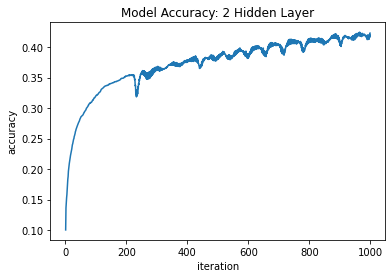

In [ ]:
# plot training history
fig = plt.plot(figsize=(12, 4))
iteration = list(range(1,1000))

# History for accuracy
plt.plot(iteration, acc_h_2_hidden_03)
plt.title('Model Accuracy: 2 Hidden Layer')
plt.ylabel('accuracy')
plt.xlabel('iteration')

plt.savefig("two_hidden.png")

### Testing accuracy comparison plot: 0, 1, 2 Hidden Layer(s)

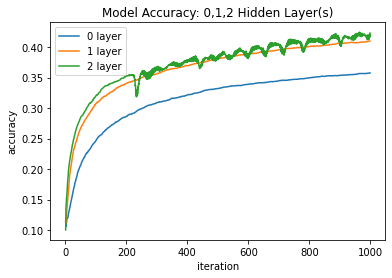

In [ ]:
# plot training history
fig = plt.plot(figsize=(12, 4))
iteration = list(range(1,1000))

# History for accuracy
plt.plot(iteration, acc_h_no_hidden_01, label='0 layer')
plt.plot(iteration, acc_h_1_hidden_02, label='1 layer')
plt.plot(iteration, acc_h_2_hidden_03, label='2 layer')
plt.legend()
plt.title('Model Accuracy: 0,1,2 Hidden Layer(s)')
plt.ylabel('accuracy')
plt.xlabel('iteration')

plt.savefig("no_one_two_hidden.png")

500 iterations

In [ ]:
model_2_hidden = MLP_2(M=[256, 256], n_hidden = 2, L2_lambda = 0)
optimizer = GradientDescent(learning_rate=.05, max_iters=500)

In [ ]:
yh_2_hidden = model_2_hidden.fit(train_images, train_labels, optimizer)

1
[[0.17994061 0.05477525 0.07429917 ... 0.07662373 0.11192886 0.073271  ]
 [0.1400068  0.05081222 0.07184705 ... 0.08962063 0.10641668 0.10941276]
 [0.10932244 0.09253675 0.07073735 ... 0.09544244 0.11394177 0.08843555]
 ...
 [0.13520956 0.07225641 0.08877095 ... 0.10857699 0.09521492 0.07410517]
 [0.13545401 0.07956931 0.05736756 ... 0.08707568 0.11117064 0.13685255]
 [0.148025   0.09846569 0.0442271  ... 0.07994506 0.0753595  0.09984264]]
2
[[0.11358805 0.07746209 0.13233785 ... 0.10883688 0.13792261 0.10450569]
 [0.08788248 0.06648545 0.12687671 ... 0.12208544 0.13903113 0.15349975]
 [0.06930554 0.10005971 0.12352391 ... 0.13224116 0.15572568 0.15265663]
 ...
 [0.09559372 0.08399211 0.12196826 ... 0.14329164 0.13166176 0.10642916]
 [0.06917117 0.092744   0.10025927 ... 0.12289993 0.14900676 0.19619104]
 [0.09489574 0.12710725 0.08181934 ... 0.11674704 0.11078243 0.14359879]]
3
[[0.15280158 0.07872895 0.11833682 ... 0.09688325 0.11091299 0.08047118]
 [0.1377968  0.07180646 0.1149125

In [ ]:
yh_2_hidden = model_2_hidden.predict(test_images)

In [ ]:
yh = decoding_labels(yh_2_hidden)

In [ ]:
yh

array([3., 9., 8., ..., 3., 6., 7.])

In [ ]:
y = np.argmax(test_labels, axis=1)

In [ ]:
y

array([3, 8, 8, ..., 5, 1, 7])

In [ ]:
acc = accuracy (yh, y)

In [ ]:
acc

0.4018

40.18 for 500 iterations!

## Task3.2

### tanh

In [ ]:
def objective(trial):
    # Define the search space for the hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    #L2_lambda = trial.suggest_float("L2_lambda", 1e-6, 1e-2, log=True)

    # Create the MLP_2 model with the given hyperparameters
    model_tanh = MLP_2(M=[256, 256], n_hidden = 2, L2_lambda = 0, activation = tanh)
    optimizer = GradientDescent(learning_rate=learning_rate, max_iters=5)

    # Train the model and compute its validation accuracy
    yh_tanh = model_tanh.fit(train_images, train_labels, optimizer)
    val_acc = yh_tanh.acc_history[-1]

    return val_acc

# Define the search method and run the optimization process
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print the best hyperparameters found by Optuna
print("Best hyperparameters: ", study.best_params)

[I 2023-03-09 05:46:14,028] A new study created in memory with name: no-name-7a67fca3-8b36-4218-8477-a86e53731fd2


1
[[0.08279865 0.09631696 0.11721693 ... 0.09552075 0.09694419 0.09354001]
 [0.08743225 0.07812142 0.10917957 ... 0.10493646 0.10319337 0.09545758]
 [0.06953154 0.09003437 0.10587686 ... 0.09734288 0.10802316 0.09981603]
 ...
 [0.0756053  0.09120516 0.10744422 ... 0.09633128 0.11222165 0.09618594]
 [0.07177125 0.09038044 0.11319777 ... 0.09966948 0.10252764 0.09180768]
 [0.07189635 0.0867774  0.12225427 ... 0.09968299 0.10848871 0.09797071]]
acc: 0.0880


2
[[0.08280544 0.09631885 0.11721368 ... 0.09552056 0.09694556 0.09354142]
 [0.08744152 0.07812372 0.10917595 ... 0.10493559 0.10319664 0.09546   ]
 [0.06953984 0.09003647 0.10587339 ... 0.09734317 0.10802716 0.09982054]
 ...
 [0.07561326 0.09120726 0.1074409  ... 0.09633105 0.11222575 0.09618952]
 [0.07178091 0.09038321 0.11319379 ... 0.09966903 0.1025317  0.09181139]
 [0.07190454 0.08677953 0.12225043 ... 0.09968297 0.10849166 0.09797395]]
acc: 0.0880


3
[[0.08281224 0.09632074 0.11721044 ... 0.09552038 0.09694693 0.09354283]
 [0.0

[I 2023-03-09 05:46:48,794] Trial 0 finished with value: 0.088 and parameters: {'learning_rate': 3.563937468005635e-05}. Best is trial 0 with value: 0.088.


1
[[0.10352296 0.1136762  0.11916183 ... 0.09180314 0.11121415 0.06876181]
 [0.0960719  0.10189843 0.13201059 ... 0.09132302 0.09628066 0.0787404 ]
 [0.10820021 0.11000666 0.09706148 ... 0.0972062  0.13532131 0.06675671]
 ...
 [0.10103984 0.11166397 0.11184334 ... 0.08999537 0.12618344 0.0724116 ]
 [0.10392638 0.10739855 0.11822407 ... 0.08847129 0.12875198 0.07731326]
 [0.09061366 0.11024046 0.11702773 ... 0.08852508 0.12540106 0.06307635]]
acc: 0.1041


2
[[0.10360207 0.11367949 0.11905859 ... 0.09182125 0.11116993 0.06886628]
 [0.09617779 0.10191395 0.13186967 ... 0.09133766 0.09626911 0.0788958 ]
 [0.10834549 0.11002388 0.09693245 ... 0.09721328 0.13531418 0.06691689]
 ...
 [0.10115779 0.11168411 0.11171799 ... 0.08999808 0.12619154 0.07256384]
 [0.10406723 0.10741127 0.11807083 ... 0.08848468 0.12873089 0.07749842]
 [0.09072122 0.11024959 0.116909   ... 0.0885389  0.12536553 0.06320969]]
acc: 0.1041


3
[[0.10368057 0.11368247 0.11895613 ... 0.0918393  0.11112576 0.06897035]
 [0.0

[I 2023-03-09 05:47:22,939] Trial 1 finished with value: 0.1042 and parameters: {'learning_rate': 0.0007368255859216216}. Best is trial 1 with value: 0.1042.


1
[[0.11289407 0.10095343 0.08436372 ... 0.10088886 0.09907034 0.08198048]
 [0.1057335  0.0898873  0.09528586 ... 0.09951007 0.10327637 0.08746916]
 [0.11013742 0.08606401 0.08443962 ... 0.09390688 0.08966559 0.10020583]
 ...
 [0.11642258 0.08053175 0.08002147 ... 0.11167995 0.08995097 0.10748395]
 [0.10516212 0.08891426 0.08705311 ... 0.0974856  0.10052613 0.09929346]
 [0.1019433  0.10253441 0.08878287 ... 0.10498475 0.08004291 0.09407448]]
acc: 0.1066


2
[[0.11289499 0.10095347 0.0843655  ... 0.10088814 0.09907341 0.08198211]
 [0.10573529 0.08988727 0.0952881  ... 0.09950882 0.10328131 0.08747175]
 [0.11013959 0.08606408 0.08444163 ... 0.09390562 0.08967029 0.10021066]
 ...
 [0.11642473 0.08053194 0.080023   ... 0.11167823 0.08995575 0.10748844]
 [0.10516431 0.08891405 0.08705543 ... 0.09748417 0.10053228 0.09929756]
 [0.10194505 0.10253436 0.08878514 ... 0.10498414 0.08004653 0.09407791]]
acc: 0.1066


3
[[0.11289591 0.1009535  0.08436728 ... 0.10088741 0.09907648 0.08198375]
 [0.1

[I 2023-03-09 05:47:56,585] Trial 2 finished with value: 0.1064 and parameters: {'learning_rate': 2.823008841883712e-05}. Best is trial 2 with value: 0.1064.


1
[[0.10779951 0.0940688  0.09697565 ... 0.13163458 0.09143088 0.07874433]
 [0.11446094 0.08476212 0.08619267 ... 0.13944312 0.09359622 0.07305716]
 [0.08873944 0.09019686 0.10934533 ... 0.14297722 0.11170514 0.08418344]
 ...
 [0.10579131 0.09282872 0.10366278 ... 0.13196957 0.10709033 0.08354134]
 [0.09802775 0.08231013 0.09627337 ... 0.1447894  0.09996894 0.08257318]
 [0.08879045 0.09077656 0.09875939 ... 0.1403921  0.1049487  0.07685079]]
acc: 0.0991


2
[[0.10808734 0.09427349 0.09705278 ... 0.13082791 0.0916262  0.07903948]
 [0.114912   0.08501903 0.0862615  ... 0.13843614 0.09393085 0.07342652]
 [0.08912876 0.09047036 0.10938694 ... 0.14187773 0.11218028 0.08475382]
 ...
 [0.10620761 0.09308415 0.10368881 ... 0.13103794 0.10748774 0.08402093]
 [0.09852302 0.08259705 0.09636863 ... 0.14358681 0.10044352 0.08313406]
 [0.08917952 0.09103323 0.0988246  ... 0.13941376 0.10530124 0.07729095]]
acc: 0.0990


3
[[0.10836726 0.09447025 0.09712664 ... 0.13004605 0.09181451 0.07932838]
 [0.1

[I 2023-03-09 05:48:31,327] Trial 3 finished with value: 0.0985 and parameters: {'learning_rate': 0.0026902019904025344}. Best is trial 2 with value: 0.1064.


1
[[0.09732147 0.09906098 0.0911332  ... 0.10233966 0.10641552 0.11214542]
 [0.0988097  0.0949707  0.08692868 ... 0.09382548 0.12981995 0.11726825]
 [0.11022447 0.10041181 0.08129093 ... 0.08991019 0.13028505 0.11707304]
 ...
 [0.10735076 0.10729297 0.08225315 ... 0.08882819 0.12879534 0.10093292]
 [0.10141458 0.09667347 0.08255427 ... 0.09697695 0.13020114 0.11161322]
 [0.11363518 0.09317815 0.10434781 ... 0.0992196  0.11516757 0.098183  ]]
acc: 0.1118


2
[[0.09749315 0.09907217 0.09134713 ... 0.10229703 0.10608828 0.11210485]
 [0.09911415 0.09501749 0.08714325 ... 0.09378173 0.12960754 0.11732045]
 [0.11057496 0.10044488 0.08145494 ... 0.08987334 0.1300535  0.11734673]
 ...
 [0.10768081 0.10733338 0.08240963 ... 0.0887886  0.12868844 0.10114065]
 [0.10178309 0.09670298 0.08277278 ... 0.0969239  0.12999387 0.11174665]
 [0.11397078 0.09318877 0.10463342 ... 0.09918832 0.11486158 0.09828804]]
acc: 0.1132


3
[[0.09765415 0.09908121 0.09155502 ... 0.10225377 0.10576684 0.11206099]
 [0.0

[I 2023-03-09 05:49:04,483] Trial 4 finished with value: 0.1178 and parameters: {'learning_rate': 0.003085738854952908}. Best is trial 4 with value: 0.1178.


1
[[0.1291908  0.09916603 0.10743429 ... 0.08048817 0.09029786 0.08740128]
 [0.12273734 0.09090288 0.12087858 ... 0.0751104  0.095236   0.10175152]
 [0.13024191 0.09911419 0.11726139 ... 0.08298025 0.09517424 0.09405096]
 ...
 [0.13062609 0.11339593 0.10943648 ... 0.0777569  0.09578429 0.08727142]
 [0.1192755  0.09139593 0.10929736 ... 0.08778796 0.09780169 0.09415634]
 [0.13227347 0.1080841  0.11321687 ... 0.06901804 0.0971397  0.0912471 ]]
acc: 0.1291


2
[[0.12894984 0.09916301 0.10732008 ... 0.08080448 0.0904648  0.08756138]
 [0.12252735 0.09092134 0.12071033 ... 0.07543237 0.09552371 0.10202073]
 [0.1300528  0.09915398 0.11707307 ... 0.08334641 0.09549405 0.09441384]
 ...
 [0.13048907 0.113434   0.10926754 ... 0.07803574 0.0960839  0.0875844 ]
 [0.1190513  0.09141018 0.10909234 ... 0.08823881 0.09815514 0.09446914]
 [0.13205621 0.10809002 0.11304967 ... 0.06936502 0.09741988 0.09153969]]
acc: 0.1288


3
[[0.1287122  0.09915965 0.10720652 ... 0.08111642 0.0906286  0.0877176 ]
 [0.1

[I 2023-03-09 05:49:38,588] Trial 5 finished with value: 0.1283 and parameters: {'learning_rate': 0.002050524345265065}. Best is trial 5 with value: 0.1283.


1
[[0.13010161 0.10448778 0.0965596  ... 0.10096391 0.06634516 0.09521832]
 [0.13853574 0.09669268 0.10824268 ... 0.10531118 0.0697663  0.09460423]
 [0.13207162 0.10433851 0.09922105 ... 0.09346277 0.07374918 0.10433722]
 ...
 [0.13890347 0.10346919 0.10178643 ... 0.0934954  0.07860696 0.10412267]
 [0.14669202 0.1039571  0.10014308 ... 0.10000937 0.06753836 0.09745617]
 [0.11766823 0.10991473 0.10260065 ... 0.10321301 0.06415103 0.11107062]]
acc: 0.1044


2
[[0.13009868 0.10448763 0.09655966 ... 0.10096413 0.06634705 0.09521857]
 [0.1385328  0.0966927  0.1082429  ... 0.10531122 0.06976899 0.09460501]
 [0.13206914 0.10433841 0.09922115 ... 0.09346274 0.07375207 0.10433873]
 ...
 [0.1389014  0.1034692  0.10178648 ... 0.0934953  0.07860975 0.10412399]
 [0.14668893 0.10395701 0.10014334 ... 0.10000945 0.06754141 0.09745745]
 [0.11766578 0.10991451 0.10260078 ... 0.10321325 0.06415328 0.11107178]]
acc: 0.1044


3
[[0.13009576 0.10448748 0.09655973 ... 0.10096434 0.06634894 0.09521881]
 [0.1

[I 2023-03-09 05:50:11,435] Trial 6 finished with value: 0.1044 and parameters: {'learning_rate': 1.2870437788672636e-05}. Best is trial 5 with value: 0.1283.


1
[[0.10202814 0.09346856 0.09800079 ... 0.10066551 0.08791683 0.10492485]
 [0.10192343 0.08488235 0.08624854 ... 0.10685131 0.08857959 0.12094143]
 [0.08615131 0.07956745 0.09267367 ... 0.10835248 0.09658789 0.11822066]
 ...
 [0.08744945 0.08728337 0.10173809 ... 0.10613326 0.08839214 0.12739701]
 [0.08538409 0.07881999 0.0852748  ... 0.11523841 0.09176345 0.12504177]
 [0.09633237 0.07753085 0.09388343 ... 0.11011553 0.08917208 0.12438617]]
acc: 0.1208


2
[[0.10204192 0.09347824 0.09800898 ... 0.10065707 0.08792734 0.10491235]
 [0.10194379 0.08489343 0.08625646 ... 0.10683924 0.08859617 0.12092951]
 [0.08617052 0.07957705 0.09268107 ... 0.10833985 0.0966076  0.11821846]
 ...
 [0.08746757 0.08729267 0.10174472 ... 0.10612147 0.08840867 0.12739422]
 [0.08540626 0.07883057 0.085285   ... 0.11522467 0.09178494 0.12503241]
 [0.09635184 0.07754013 0.09389289 ... 0.11010431 0.08918749 0.12437685]]
acc: 0.1208


3
[[0.10205569 0.09348791 0.09801716 ... 0.10064863 0.08793783 0.10489986]
 [0.1

[I 2023-03-09 05:50:45,956] Trial 7 finished with value: 0.1208 and parameters: {'learning_rate': 0.0001197222522943633}. Best is trial 5 with value: 0.1283.


1
[[0.08862772 0.12150679 0.08877818 ... 0.09907872 0.07787302 0.08550967]
 [0.08571542 0.12257618 0.08587583 ... 0.09938005 0.07720301 0.0896667 ]
 [0.08679189 0.13734186 0.07812333 ... 0.08242413 0.08025106 0.09412449]
 ...
 [0.08955249 0.11323053 0.06512318 ... 0.08534248 0.09099671 0.09463492]
 [0.08655235 0.12397118 0.08344023 ... 0.0929779  0.07879141 0.08930169]
 [0.09537217 0.10918274 0.07849312 ... 0.09481224 0.07847947 0.08245175]]
acc: 0.0939


2
[[0.0886434  0.12148562 0.08878547 ... 0.09908359 0.07788923 0.08551728]
 [0.08573756 0.12255256 0.08588449 ... 0.09938446 0.0772268  0.08967995]
 [0.08681654 0.13731859 0.0781312  ... 0.08242864 0.08027783 0.09414368]
 ...
 [0.08957534 0.11321259 0.06512799 ... 0.08534551 0.09102368 0.09465215]
 [0.08657935 0.1239459  0.08344964 ... 0.09298335 0.07882002 0.08931795]
 [0.09539874 0.10916075 0.07850098 ... 0.09481798 0.07850292 0.08246442]]
acc: 0.0939


3
[[0.08865906 0.12146448 0.08879275 ... 0.09908845 0.07790542 0.08552488]
 [0.0

[I 2023-03-09 05:51:19,597] Trial 8 finished with value: 0.0939 and parameters: {'learning_rate': 0.00010373397792448308}. Best is trial 5 with value: 0.1283.


1
[[0.08392262 0.10144866 0.10812307 ... 0.10714929 0.09995505 0.097325  ]
 [0.08543689 0.10277559 0.10580036 ... 0.10542969 0.10812954 0.09924124]
 [0.09751725 0.10609086 0.10304308 ... 0.12643306 0.09100691 0.09322994]
 ...
 [0.09297712 0.10804203 0.10046603 ... 0.11841816 0.09242057 0.10355314]
 [0.08944082 0.1054098  0.10319702 ... 0.11719951 0.10768197 0.1026532 ]
 [0.0961023  0.1104404  0.10300935 ... 0.11010843 0.0898492  0.11154601]]
acc: 0.0971


2
[[0.09293122 0.09792875 0.10514685 ... 0.09868893 0.10441959 0.09421709]
 [0.09776224 0.10022745 0.10154337 ... 0.0941569  0.11798099 0.09738855]
 [0.1133528  0.10401184 0.09823022 ... 0.11415102 0.10171554 0.09560741]
 ...
 [0.10667914 0.10654062 0.0960245  ... 0.10769828 0.10279253 0.10568183]
 [0.10469874 0.10185415 0.09873168 ... 0.10372986 0.11974312 0.10209484]
 [0.11064543 0.10650377 0.09916107 ... 0.09987385 0.09742884 0.11067022]]
acc: 0.1303


3
[[0.09637517 0.09543205 0.1040188  ... 0.09651571 0.10416034 0.0925256 ]
 [0.1

[I 2023-03-09 05:51:52,602] Trial 9 finished with value: 0.1467 and parameters: {'learning_rate': 0.06787679658192045}. Best is trial 9 with value: 0.1467.


1
[[0.08812726 0.09641382 0.07564669 ... 0.09664974 0.11661665 0.10872477]
 [0.08634575 0.09226114 0.07197899 ... 0.09239869 0.11826153 0.11073537]
 [0.07877105 0.11689716 0.07280195 ... 0.10203766 0.10959855 0.09890164]
 ...
 [0.07754996 0.1232972  0.08575484 ... 0.08959227 0.09520621 0.10694012]
 [0.07707277 0.10020647 0.07519465 ... 0.09442605 0.1183945  0.11027636]
 [0.08287004 0.10074995 0.06905261 ... 0.1037356  0.11482857 0.10539799]]
acc: 0.0904


2
[[0.09712748 0.09624248 0.08280939 ... 0.10086538 0.1082784  0.10644258]
 [0.09832609 0.09327378 0.07928694 ... 0.09586532 0.11327585 0.11110321]
 [0.09054347 0.11803997 0.07984337 ... 0.10404206 0.10623595 0.10286228]
 ...
 [0.08778926 0.12414083 0.09207515 ... 0.09082937 0.09364362 0.11081573]
 [0.08988464 0.10057397 0.08367789 ... 0.09790094 0.11304487 0.11153848]
 [0.09461495 0.10084981 0.07608518 ... 0.10803365 0.10786707 0.10652887]]
acc: 0.0926


3
[[0.10136461 0.09541959 0.08797204 ... 0.10351067 0.10383403 0.10368091]
 [0.1

[I 2023-03-09 05:52:26,722] Trial 10 finished with value: 0.1118 and parameters: {'learning_rate': 0.06698279111032508}. Best is trial 9 with value: 0.1467.


1
[[0.11024776 0.11427142 0.09876373 ... 0.10261651 0.07785553 0.09141455]
 [0.11990865 0.11200589 0.10464345 ... 0.09600312 0.06676772 0.0904895 ]
 [0.11356189 0.09235631 0.10393943 ... 0.10793421 0.09859701 0.06881795]
 ...
 [0.13470401 0.08826358 0.09111604 ... 0.09812226 0.08783792 0.0804133 ]
 [0.12483398 0.09766302 0.10146498 ... 0.10288161 0.07766248 0.0785557 ]
 [0.117753   0.09604259 0.10452938 ... 0.09365116 0.09462627 0.07559773]]
acc: 0.1308


2
[[0.10458711 0.11136174 0.09893741 ... 0.09748594 0.09172609 0.10238766]
 [0.11528215 0.11139631 0.10275073 ... 0.08916907 0.08363957 0.10637819]
 [0.11095104 0.09316035 0.10261988 ... 0.10001346 0.12613206 0.08382034]
 ...
 [0.1327135  0.08888971 0.08995552 ... 0.09162784 0.11096819 0.09679799]
 [0.12123971 0.09714537 0.10035561 ... 0.094155   0.10290706 0.09529289]
 [0.11423462 0.09492563 0.10422416 ... 0.08804886 0.11738096 0.08905993]]
acc: 0.1437


3
[[0.10277616 0.10991004 0.0992288  ... 0.10057605 0.09288645 0.1034957 ]
 [0.1

[I 2023-03-09 05:53:00,661] Trial 11 finished with value: 0.1519 and parameters: {'learning_rate': 0.09892457424399226}. Best is trial 11 with value: 0.1519.


1
[[0.08373067 0.08661636 0.10926633 ... 0.10153507 0.09475699 0.09883408]
 [0.0813921  0.08160201 0.13828705 ... 0.1087167  0.09787872 0.10237076]
 [0.0894384  0.07777315 0.11396991 ... 0.09877914 0.08201559 0.11390341]
 ...
 [0.08796462 0.08241183 0.12364481 ... 0.09831319 0.08510243 0.13149721]
 [0.08782956 0.08100938 0.1341417  ... 0.09337328 0.08294435 0.11206376]
 [0.08642778 0.08206565 0.11170706 ... 0.08883955 0.08676061 0.09864421]]
acc: 0.1053


2
[[0.09197556 0.0918741  0.10103841 ... 0.10261024 0.10078901 0.09522605]
 [0.09222653 0.08769775 0.12663405 ... 0.10965461 0.10768636 0.10003787]
 [0.10284195 0.08455144 0.10291955 ... 0.10053501 0.09085544 0.11491912]
 ...
 [0.09985284 0.08860326 0.11271969 ... 0.09910238 0.09396719 0.13215652]
 [0.10240619 0.08821437 0.12083215 ... 0.0952805  0.09359757 0.11068973]
 [0.09897318 0.08834067 0.10182627 ... 0.09071288 0.09494438 0.09728399]]
acc: 0.0994


3
[[0.09476966 0.09460745 0.09759168 ... 0.10191574 0.10376852 0.09261915]
 [0.0

[I 2023-03-09 05:53:33,666] Trial 12 finished with value: 0.1357 and parameters: {'learning_rate': 0.06213373853196388}. Best is trial 11 with value: 0.1519.


1
[[0.13498448 0.09105735 0.0993128  ... 0.10785998 0.10543895 0.06477473]
 [0.13131957 0.09254328 0.08181163 ... 0.11355657 0.12088497 0.06441099]
 [0.11232125 0.12383419 0.08824021 ... 0.11547058 0.13047564 0.06466056]
 ...
 [0.10356711 0.1169215  0.08591423 ... 0.12302534 0.1310099  0.06508778]
 [0.13420176 0.10282534 0.08691171 ... 0.12334306 0.11042906 0.06129181]
 [0.12664483 0.1128622  0.09061071 ... 0.11034101 0.12113979 0.06312087]]
acc: 0.1112


2
[[0.13161196 0.0897522  0.10155925 ... 0.10609611 0.10510709 0.06799168]
 [0.12823893 0.09130806 0.08383946 ... 0.11106367 0.1216448  0.06848427]
 [0.11010086 0.12259296 0.09034447 ... 0.11310062 0.13157334 0.06941321]
 ...
 [0.10171995 0.11611801 0.0876665  ... 0.12061855 0.13225835 0.06927376]
 [0.13109785 0.10148716 0.0896065  ... 0.12041998 0.11128131 0.06607621]
 [0.12386206 0.11133785 0.09294964 ... 0.10824426 0.1213892  0.06744325]]
acc: 0.1183


3
[[0.12877514 0.0886731  0.1033889  ... 0.10460378 0.10467826 0.07087995]
 [0.1

[I 2023-03-09 05:54:06,754] Trial 13 finished with value: 0.1267 and parameters: {'learning_rate': 0.021618226922477266}. Best is trial 11 with value: 0.1519.


1
[[0.10656279 0.10422799 0.1144018  ... 0.07938721 0.08482895 0.09379231]
 [0.09234694 0.10754329 0.1106759  ... 0.07980503 0.08893481 0.08572366]
 [0.09560132 0.09281562 0.10947008 ... 0.0957194  0.08231606 0.09774371]
 ...
 [0.09056761 0.09801973 0.11233892 ... 0.07836899 0.08985991 0.11323671]
 [0.09906244 0.09648162 0.11096839 ... 0.08095978 0.08293915 0.08846927]
 [0.10750313 0.09030561 0.10150196 ... 0.08605165 0.08433292 0.09669912]]
acc: 0.0991


2
[[0.10737873 0.10365771 0.11408973 ... 0.08112138 0.08654328 0.09563909]
 [0.09359496 0.10702342 0.1103246  ... 0.08149242 0.09183479 0.08809023]
 [0.09717577 0.09244816 0.10878183 ... 0.09759587 0.08521478 0.10167012]
 ...
 [0.09188869 0.097642   0.11173383 ... 0.07961263 0.09288971 0.11700487]
 [0.10101424 0.09614696 0.11057958 ... 0.08316144 0.08631107 0.09165316]
 [0.10895708 0.08971179 0.10091772 ... 0.08810935 0.08674753 0.09985945]]
acc: 0.1000


3
[[0.10795836 0.10302592 0.11363778 ... 0.08264998 0.08792218 0.09703892]
 [0.0

[I 2023-03-09 05:54:40,557] Trial 14 finished with value: 0.1094 and parameters: {'learning_rate': 0.017428855216252207}. Best is trial 11 with value: 0.1519.


1
[[0.08686112 0.10669013 0.11967454 ... 0.1172744  0.09807237 0.10159839]
 [0.08232795 0.11002685 0.11581285 ... 0.11421803 0.0961409  0.1052107 ]
 [0.07829234 0.11543106 0.11934423 ... 0.11119028 0.10329858 0.09919267]
 ...
 [0.07861049 0.12098088 0.10331017 ... 0.10564138 0.10430529 0.10722678]
 [0.07801565 0.11353873 0.12087721 ... 0.11515115 0.0880694  0.10562829]
 [0.07805335 0.12905151 0.11676338 ... 0.12527835 0.09336636 0.09921517]]
acc: 0.0938


2
[[0.09775314 0.09876386 0.10815748 ... 0.10749533 0.10274894 0.10134477]
 [0.09620539 0.10141036 0.1027323  ... 0.10318875 0.10488243 0.10749576]
 [0.09215866 0.10596875 0.10510437 ... 0.10108542 0.115263   0.10808085]
 ...
 [0.09110613 0.11229382 0.09207013 ... 0.09634546 0.11527588 0.11480044]
 [0.09447983 0.10321029 0.10494887 ... 0.10244804 0.09912421 0.11178785]
 [0.09249962 0.11837605 0.10391229 ... 0.11469439 0.1012774  0.10396714]]
acc: 0.1139


3
[[0.10301817 0.09546381 0.10531047 ... 0.10379569 0.10338034 0.09916803]
 [0.1

[I 2023-03-09 05:55:13,838] Trial 15 finished with value: 0.1561 and parameters: {'learning_rate': 0.08192914747860244}. Best is trial 15 with value: 0.1561.


1
[[0.09856993 0.09858933 0.10821558 ... 0.08363913 0.09422465 0.09531674]
 [0.08737818 0.10716729 0.10578749 ... 0.09622512 0.08820109 0.10248604]
 [0.07459113 0.10090078 0.09748743 ... 0.09041518 0.09579193 0.11837838]
 ...
 [0.08819277 0.10519096 0.100305   ... 0.09068955 0.08297858 0.1106967 ]
 [0.07360423 0.11067245 0.10736305 ... 0.08387125 0.08436221 0.1100679 ]
 [0.08125442 0.10562339 0.10334462 ... 0.0924227  0.09368287 0.10807502]]
acc: 0.1070


2
[[0.10073447 0.09826746 0.10766328 ... 0.08462309 0.09550087 0.09455735]
 [0.09001503 0.10708542 0.10518787 ... 0.0974473  0.09020461 0.10179572]
 [0.07706643 0.10098631 0.09690107 ... 0.09173443 0.09826504 0.11837875]
 ...
 [0.09075636 0.1053287  0.0996627  ... 0.09168153 0.08497987 0.11076225]
 [0.07629821 0.11057885 0.10690389 ... 0.08535617 0.08679909 0.10949549]
 [0.08373153 0.10529665 0.10275406 ... 0.0937609  0.09554484 0.10743502]]
acc: 0.1062


3
[[0.1026935  0.09792826 0.10714229 ... 0.08550176 0.09662269 0.09387585]
 [0.0

[I 2023-03-09 05:55:47,877] Trial 16 finished with value: 0.1097 and parameters: {'learning_rate': 0.014104446255833934}. Best is trial 15 with value: 0.1561.


1
[[0.09413594 0.09517225 0.12332479 ... 0.12822711 0.11219559 0.10308525]
 [0.09545996 0.08650261 0.12936358 ... 0.12985029 0.11992835 0.09692733]
 [0.08939907 0.09544898 0.11728862 ... 0.11292236 0.12297995 0.0986735 ]
 ...
 [0.09267393 0.09813603 0.11912887 ... 0.10564927 0.11740104 0.09785395]
 [0.08801627 0.09333474 0.13478786 ... 0.11057157 0.13373603 0.10495249]
 [0.09478889 0.09890141 0.12476039 ... 0.12842059 0.12650951 0.0924835 ]]
acc: 0.1204


2
[[0.09539553 0.0952603  0.12145566 ... 0.12688892 0.11137992 0.10312842]
 [0.09715663 0.08680972 0.12712284 ... 0.12808689 0.11946211 0.09717368]
 [0.09118824 0.0958408  0.11515278 ... 0.11137928 0.12261829 0.09942742]
 ...
 [0.09430396 0.09851796 0.11716213 ... 0.10429272 0.11726834 0.0985072 ]
 [0.09000066 0.09363099 0.13204886 ... 0.10885032 0.13328696 0.10541277]
 [0.09662908 0.09909284 0.1225521  ... 0.12687595 0.12571282 0.09282778]]
acc: 0.1239


3
[[0.09656296 0.09533658 0.11977168 ... 0.12565294 0.11058281 0.10315298]
 [0.0

[I 2023-03-09 05:56:21,933] Trial 17 finished with value: 0.1284 and parameters: {'learning_rate': 0.009662866972043474}. Best is trial 15 with value: 0.1561.


1
[[0.10694134 0.13188661 0.08851661 ... 0.0899663  0.09947343 0.09594738]
 [0.11268988 0.14186896 0.07759956 ... 0.09730279 0.09137557 0.08778726]
 [0.11239789 0.10776706 0.08885535 ... 0.10220693 0.09419075 0.07725714]
 ...
 [0.12072706 0.10893857 0.09029424 ... 0.09125485 0.09764141 0.07350337]
 [0.10087276 0.12601446 0.08151052 ... 0.09589265 0.09502922 0.07926464]
 [0.11234659 0.12190515 0.07983028 ... 0.09566022 0.08683972 0.07585917]]
acc: 0.0892


2
[[0.11171096 0.11152161 0.09781738 ... 0.09118475 0.10868428 0.10855804]
 [0.12205867 0.1179749  0.08639073 ... 0.09790181 0.10480559 0.10413142]
 [0.12230199 0.08941733 0.09848627 ... 0.10261655 0.11064783 0.09707662]
 ...
 [0.13159837 0.09328913 0.09772165 ... 0.09100747 0.11269575 0.09006904]
 [0.11217769 0.10122586 0.09286932 ... 0.0971879  0.11403849 0.09894449]
 [0.12194908 0.10112163 0.08924039 ... 0.09786549 0.10024378 0.09255959]]
acc: 0.1243


3
[[0.11000107 0.10734154 0.1016991  ... 0.09278472 0.10897933 0.11031838]
 [0.1

[I 2023-03-09 05:56:59,326] Trial 18 finished with value: 0.1393 and parameters: {'learning_rate': 0.0902334658797667}. Best is trial 15 with value: 0.1561.


1
[[0.09441322 0.12328993 0.08723731 ... 0.08271493 0.09984004 0.12357753]
 [0.08191286 0.10556624 0.09066035 ... 0.10529815 0.09865225 0.11984467]
 [0.08730934 0.12594713 0.10495775 ... 0.10206283 0.10176358 0.09187602]
 ...
 [0.08450281 0.11560572 0.10273556 ... 0.11943716 0.1093837  0.095107  ]
 [0.08989273 0.1129593  0.0871857  ... 0.11221759 0.11004708 0.1156813 ]
 [0.09088627 0.10913625 0.09546962 ... 0.1025951  0.098483   0.11642969]]
acc: 0.0734


2
[[0.09859485 0.1185243  0.08902477 ... 0.08402187 0.10150983 0.11913889]
 [0.08654885 0.10111297 0.0921428  ... 0.1062818  0.10180558 0.11628821]
 [0.09290054 0.12073264 0.10649015 ... 0.10360588 0.1059771  0.09092578]
 ...
 [0.08933379 0.11141149 0.1037775  ... 0.12047426 0.11368439 0.09442789]
 [0.09596843 0.10700937 0.08869984 ... 0.11381663 0.1145267  0.11259513]
 [0.09648028 0.10412304 0.09718873 ... 0.10447467 0.10144375 0.11320927]]
acc: 0.0870


3
[[0.1017404  0.11525121 0.09036256 ... 0.08470377 0.10220459 0.11577847]
 [0.0

[I 2023-03-09 05:57:34,873] Trial 19 finished with value: 0.1157 and parameters: {'learning_rate': 0.036881528656071576}. Best is trial 15 with value: 0.1561.


1
[[0.10976284 0.10991989 0.11352016 ... 0.07042684 0.10777907 0.08356227]
 [0.12298914 0.12220735 0.1010285  ... 0.0775075  0.12810181 0.07769185]
 [0.10099476 0.13977322 0.11461723 ... 0.08812704 0.13764736 0.08424966]
 ...
 [0.10594606 0.12009869 0.0957977  ... 0.08881936 0.13008598 0.09719004]
 [0.11283142 0.12366087 0.1112486  ... 0.08759036 0.13289686 0.08666623]
 [0.10959972 0.10777352 0.11847347 ... 0.09160172 0.14013593 0.08940817]]
acc: 0.1145


2
[[0.10985048 0.1087045  0.11304358 ... 0.07113247 0.10739876 0.08424143]
 [0.12338639 0.12066808 0.10050229 ... 0.07843516 0.12803664 0.0785866 ]
 [0.10155997 0.13799945 0.11398458 ... 0.0892189  0.13779796 0.08554389]
 ...
 [0.10644331 0.118759   0.09528498 ... 0.08967103 0.1301714  0.09839511]
 [0.11344651 0.12170149 0.11053706 ... 0.08884793 0.13285661 0.08789297]
 [0.10997942 0.10626656 0.11782976 ... 0.09273501 0.1398703  0.09049554]]
acc: 0.1165


3
[[0.10990286 0.10758862 0.11259383 ... 0.07179126 0.1070177  0.08487158]
 [0.1

[I 2023-03-09 05:58:14,326] Trial 20 finished with value: 0.1199 and parameters: {'learning_rate': 0.007574047467571798}. Best is trial 15 with value: 0.1561.


1
[[0.09035207 0.12655634 0.09810489 ... 0.09216904 0.08410935 0.12171421]
 [0.10132601 0.11894567 0.09226358 ... 0.08936313 0.08518538 0.11120992]
 [0.09044188 0.12040581 0.0998983  ... 0.08284107 0.0828114  0.13119571]
 ...
 [0.09896962 0.09929824 0.09812842 ... 0.09439408 0.0880112  0.10747231]
 [0.08931435 0.12668301 0.09056023 ... 0.08394397 0.0755153  0.13134577]
 [0.0958872  0.11233702 0.10295869 ... 0.08982996 0.08171159 0.14132972]]
acc: 0.0977


2
[[0.09662988 0.1095578  0.10032284 ... 0.09881058 0.09860277 0.10522604]
 [0.11213028 0.10239135 0.0949304  ... 0.09526763 0.1049425  0.09707747]
 [0.10347779 0.10333011 0.10369938 ... 0.08878051 0.10473356 0.12175614]
 ...
 [0.11124661 0.08704646 0.10025029 ... 0.09898354 0.10795612 0.10017488]
 [0.10250848 0.10615173 0.09483506 ... 0.09200856 0.09911257 0.11576675]
 [0.10768735 0.09533199 0.10646508 ... 0.09796522 0.10024594 0.12557718]]
acc: 0.1141


3
[[0.09840541 0.10542512 0.09974846 ... 0.10055218 0.10150872 0.09963004]
 [0.1

[I 2023-03-09 05:58:52,443] Trial 21 finished with value: 0.1556 and parameters: {'learning_rate': 0.09026481244590676}. Best is trial 15 with value: 0.1561.


1
[[0.13585808 0.1079487  0.09208601 ... 0.07480586 0.08747685 0.09677744]
 [0.13823307 0.11929832 0.09009784 ... 0.0613978  0.08111238 0.09142184]
 [0.09983914 0.10631296 0.11260645 ... 0.07874062 0.11067667 0.09989679]
 ...
 [0.11308693 0.11881527 0.10164992 ... 0.07329978 0.09196796 0.09734394]
 [0.11631085 0.11322531 0.09636679 ... 0.06428874 0.1077413  0.10455155]
 [0.10918142 0.10748076 0.09740866 ... 0.07209354 0.09968485 0.10841083]]
acc: 0.1208


2
[[0.13641938 0.10520358 0.09302239 ... 0.08120968 0.08998712 0.09739625]
 [0.14082362 0.11641533 0.09125866 ... 0.0676044  0.08563726 0.09339515]
 [0.10133204 0.10370875 0.11362735 ... 0.08699516 0.11670544 0.10460815]
 ...
 [0.11527959 0.11663013 0.10248944 ... 0.0794307  0.0967452  0.1012577 ]
 [0.11903934 0.10933754 0.09788506 ... 0.07216457 0.11444188 0.10801802]
 [0.1108327  0.10441948 0.0989125  ... 0.07969481 0.10409039 0.11148698]]
acc: 0.1244


3
[[0.13590461 0.10283814 0.0933221  ... 0.08590518 0.0914192  0.0971746 ]
 [0.1

[I 2023-03-09 05:59:26,665] Trial 22 finished with value: 0.1226 and parameters: {'learning_rate': 0.03608749629197381}. Best is trial 15 with value: 0.1561.


1
[[0.10011795 0.10523605 0.10891163 ... 0.1162482  0.10164485 0.09166891]
 [0.09973652 0.12790671 0.10580192 ... 0.12282921 0.09442924 0.08922658]
 [0.09982679 0.11215489 0.10831791 ... 0.10653346 0.09156644 0.08650139]
 ...
 [0.09970069 0.10738947 0.11487672 ... 0.09977582 0.09602709 0.0887814 ]
 [0.1070738  0.11304363 0.11547771 ... 0.11978833 0.09173436 0.08992706]
 [0.1148897  0.10602928 0.1047333  ... 0.11824779 0.08422548 0.08928357]]
acc: 0.1063


2
[[0.10038231 0.09694226 0.10423683 ... 0.10658352 0.10983453 0.09636759]
 [0.10338017 0.11883589 0.10000592 ... 0.11063947 0.10657319 0.09635551]
 [0.10479825 0.10538505 0.10114417 ... 0.09623266 0.10556742 0.0984905 ]
 ...
 [0.10439348 0.10225396 0.10767281 ... 0.09074765 0.10919921 0.09921371]
 [0.11254224 0.10311531 0.10753801 ... 0.10660445 0.10686504 0.09984011]
 [0.11902876 0.09751398 0.09870364 ... 0.10772858 0.09443602 0.09811649]]
acc: 0.1324


3
[[0.09962126 0.09364705 0.10271927 ... 0.10323807 0.1116295  0.09684136]
 [0.1

[I 2023-03-09 06:00:01,603] Trial 23 finished with value: 0.1523 and parameters: {'learning_rate': 0.09949607236078623}. Best is trial 15 with value: 0.1561.


1
[[0.09153266 0.08594692 0.10195067 ... 0.11496931 0.11189284 0.07799715]
 [0.09211637 0.08773445 0.09928927 ... 0.11578203 0.11175833 0.09103809]
 [0.07983799 0.11045051 0.10497811 ... 0.11148923 0.11259725 0.09813646]
 ...
 [0.08923427 0.11576937 0.0953124  ... 0.10152711 0.0931514  0.12430856]
 [0.08906588 0.09377358 0.10648914 ... 0.10891247 0.1215981  0.10023526]
 [0.09269737 0.09494554 0.10566449 ... 0.10726963 0.11560622 0.08509815]]
acc: 0.1203


2
[[0.09543164 0.08650063 0.10107778 ... 0.11294537 0.1104188  0.08076557]
 [0.09741602 0.08834155 0.09780556 ... 0.11265614 0.11136561 0.09610586]
 [0.08516292 0.11102588 0.10308742 ... 0.10834222 0.1130353  0.10528881]
 ...
 [0.09450134 0.11606533 0.09339102 ... 0.09856353 0.0934612  0.1317881 ]
 [0.0957961  0.09413698 0.10450415 ... 0.10564662 0.12143561 0.10727318]
 [0.09872244 0.0954298  0.10418102 ... 0.1049213  0.11487321 0.09060861]]
acc: 0.1275


3
[[0.0983167  0.08689171 0.10045876 ... 0.11139911 0.10904221 0.08252699]
 [0.1

[I 2023-03-09 06:00:37,365] Trial 24 finished with value: 0.1356 and parameters: {'learning_rate': 0.030167400350311385}. Best is trial 15 with value: 0.1561.


1
[[0.09870667 0.10019418 0.10670507 ... 0.08629028 0.10041486 0.08079565]
 [0.10843263 0.101413   0.10296474 ... 0.08536127 0.08012556 0.07588578]
 [0.1134868  0.10732936 0.11037647 ... 0.08886227 0.07850063 0.08251318]
 ...
 [0.11606323 0.10030328 0.11362587 ... 0.09419877 0.08298488 0.08422008]
 [0.10920628 0.11368298 0.10211376 ... 0.08329944 0.07780756 0.0761537 ]
 [0.10860592 0.11189109 0.11703129 ... 0.08524891 0.08477252 0.07444683]]
acc: 0.0982


2
[[0.09976574 0.0990708  0.10500474 ... 0.09124398 0.1039788  0.08424006]
 [0.11144284 0.10131949 0.10171705 ... 0.0912722  0.08467503 0.07998185]
 [0.11686432 0.10688628 0.10818108 ... 0.09502398 0.08298876 0.08815668]
 ...
 [0.1196806  0.10021131 0.11112139 ... 0.09947262 0.08730022 0.08918016]
 [0.11301483 0.11376717 0.10083616 ... 0.09015096 0.08367521 0.08120479]
 [0.1116397  0.11175024 0.11519493 ... 0.09143427 0.08917024 0.07913324]]
acc: 0.1001


3
[[0.10025413 0.09789594 0.10328018 ... 0.09394354 0.10637177 0.08677407]
 [0.1

[I 2023-03-09 06:01:11,749] Trial 25 finished with value: 0.1265 and parameters: {'learning_rate': 0.03634290808765679}. Best is trial 15 with value: 0.1561.


1
[[0.09956111 0.07025854 0.10696199 ... 0.13716389 0.10954574 0.10401622]
 [0.1108191  0.06827101 0.10391512 ... 0.12640698 0.10978509 0.10000605]
 [0.12349225 0.06766689 0.09815665 ... 0.11111329 0.14739126 0.08140116]
 ...
 [0.12289678 0.06539185 0.09404712 ... 0.116034   0.14110685 0.08031863]
 [0.12243188 0.06849841 0.09876268 ... 0.12040942 0.13309552 0.09926651]
 [0.12474463 0.0736622  0.09530993 ... 0.13838096 0.11043741 0.10583532]]
acc: 0.1270


2
[[0.09898757 0.08494272 0.10798703 ... 0.1184314  0.0971041  0.10792908]
 [0.11350353 0.08522162 0.10443718 ... 0.10614105 0.09859963 0.10732664]
 [0.13070209 0.08587517 0.09907392 ... 0.09309859 0.13510703 0.0923491 ]
 ...
 [0.12986993 0.08014076 0.09415589 ... 0.09962109 0.13346567 0.08970876]
 [0.12869646 0.08905782 0.09957516 ... 0.09841496 0.11899289 0.11036196]
 [0.12842047 0.09224356 0.09610194 ... 0.11750082 0.09722795 0.11514657]]
acc: 0.1211


3
[[0.09427935 0.09112604 0.10622543 ... 0.11396052 0.09379601 0.10642583]
 [0.1

[I 2023-03-09 06:01:47,204] Trial 26 finished with value: 0.1425 and parameters: {'learning_rate': 0.09786925628105303}. Best is trial 15 with value: 0.1561.


1
[[0.08508415 0.09571013 0.0970297  ... 0.08779976 0.10284501 0.11756944]
 [0.08493726 0.08025169 0.09934451 ... 0.0935106  0.10903306 0.11089473]
 [0.09058367 0.07464374 0.09545348 ... 0.10844956 0.11549883 0.11103851]
 ...
 [0.08509518 0.08135396 0.10024333 ... 0.10131229 0.10940374 0.10769268]
 [0.08994829 0.07228703 0.10188755 ... 0.10329623 0.10628239 0.10962425]
 [0.08191265 0.08394945 0.10330232 ... 0.09372253 0.12417912 0.10034365]]
acc: 0.0882


2
[[0.08608274 0.0961725  0.09703969 ... 0.08789582 0.10287754 0.11711996]
 [0.08629065 0.08080921 0.09929792 ... 0.09357473 0.10954225 0.11054746]
 [0.09212082 0.07518575 0.0953402  ... 0.10841143 0.11622714 0.1110584 ]
 ...
 [0.08640506 0.08189492 0.1001243  ... 0.10119102 0.110142   0.10772426]
 [0.09172433 0.07287236 0.10188603 ... 0.10336975 0.10696752 0.10934694]
 [0.08325238 0.08443439 0.10333416 ... 0.09384031 0.12458115 0.1001556 ]]
acc: 0.0863


3
[[0.08702817 0.09660592 0.09704948 ... 0.08799211 0.10287662 0.11668141]
 [0.0

[I 2023-03-09 06:02:23,533] Trial 27 finished with value: 0.086 and parameters: {'learning_rate': 0.00703497142919896}. Best is trial 15 with value: 0.1561.


1
[[0.1014309  0.08591215 0.11827779 ... 0.10060533 0.11433663 0.11166007]
 [0.09677262 0.09170643 0.11588442 ... 0.11287707 0.12149776 0.0977456 ]
 [0.09945836 0.08317461 0.1414803  ... 0.11021599 0.10209445 0.10301655]
 ...
 [0.09754487 0.08063878 0.12660645 ... 0.10716823 0.11301948 0.10330592]
 [0.10270783 0.08586578 0.13068272 ... 0.09781668 0.12745364 0.10013269]
 [0.10127934 0.07497472 0.12930115 ... 0.09666986 0.11736698 0.1012087 ]]
acc: 0.1048


2
[[0.1043528  0.08864776 0.11186734 ... 0.10120093 0.11170587 0.11038863]
 [0.10075498 0.09528842 0.10788316 ... 0.11254494 0.11980272 0.09719315]
 [0.10463885 0.08716197 0.13190106 ... 0.11079925 0.10140376 0.10480106]
 ...
 [0.10255499 0.08403709 0.11867082 ... 0.10701099 0.11318926 0.10496129]
 [0.10876335 0.09011121 0.12033733 ... 0.09819083 0.12660076 0.10065721]
 [0.10638061 0.07777651 0.12059258 ... 0.09744171 0.11558663 0.10168841]]
acc: 0.1041


3
[[0.10591773 0.09009133 0.10797313 ... 0.10148596 0.10934508 0.10906018]
 [0.1

[I 2023-03-09 06:02:57,964] Trial 28 finished with value: 0.1183 and parameters: {'learning_rate': 0.040707349796419934}. Best is trial 15 with value: 0.1561.


1
[[0.09775073 0.10227133 0.08826434 ... 0.10498101 0.06468885 0.0815977 ]
 [0.1056017  0.09666642 0.07273093 ... 0.09739429 0.06664274 0.08090978]
 [0.08882286 0.09190952 0.08062496 ... 0.11134602 0.0878576  0.08981623]
 ...
 [0.08600064 0.09252193 0.07628871 ... 0.09797119 0.08531091 0.08548855]
 [0.08149544 0.08847347 0.07987451 ... 0.11386451 0.06696096 0.07764099]
 [0.0891978  0.09345508 0.09798965 ... 0.10791531 0.0757702  0.07532339]]
acc: 0.0926


2
[[0.10040062 0.10297506 0.09053017 ... 0.1041196  0.06832696 0.08404357]
 [0.10959967 0.09769337 0.07470331 ... 0.09629382 0.07151048 0.08438705]
 [0.09245904 0.09271356 0.08268146 ... 0.10997192 0.09508363 0.09482547]
 ...
 [0.08920745 0.09333646 0.0780925  ... 0.09694028 0.0917382  0.08973477]
 [0.08571259 0.08953952 0.08277237 ... 0.11279673 0.07342283 0.08192381]
 [0.09291543 0.09413004 0.10071674 ... 0.10694344 0.08134084 0.07893751]]
acc: 0.0943


3
[[0.10252895 0.10343991 0.09236636 ... 0.10323863 0.07152686 0.0860609 ]
 [0.1

[I 2023-03-09 06:03:31,307] Trial 29 finished with value: 0.0945 and parameters: {'learning_rate': 0.01945860558438553}. Best is trial 15 with value: 0.1561.


1
[[0.10987266 0.10562552 0.10465244 ... 0.10284969 0.11197088 0.08703381]
 [0.11430733 0.10225718 0.11023691 ... 0.10350003 0.0967954  0.09667386]
 [0.11994955 0.11082824 0.10639378 ... 0.10892104 0.10317089 0.09122267]
 ...
 [0.11138378 0.10304522 0.1191815  ... 0.10700364 0.09765009 0.10252712]
 [0.10752792 0.10067812 0.10828851 ... 0.10746461 0.11276202 0.09425144]
 [0.11986739 0.10092445 0.10611456 ... 0.09596909 0.10552669 0.08679377]]
acc: 0.1046


2
[[0.10668091 0.10274779 0.10261483 ... 0.10143071 0.11190039 0.09097442]
 [0.11216468 0.09935804 0.10751437 ... 0.10148056 0.09851414 0.10318891]
 [0.11795485 0.10711329 0.10338958 ... 0.10607036 0.10592973 0.10078224]
 ...
 [0.11023755 0.10030566 0.11620495 ... 0.10432028 0.10058131 0.11186801]
 [0.10532145 0.09667475 0.10501852 ... 0.10448092 0.11558186 0.10282283]
 [0.11759501 0.09742317 0.10336178 ... 0.09421519 0.10686102 0.09416113]]
acc: 0.1135


3
[[0.1048574  0.10120939 0.1014679  ... 0.10101915 0.11100942 0.09214457]
 [0.1

[I 2023-03-09 06:04:05,226] Trial 30 finished with value: 0.1198 and parameters: {'learning_rate': 0.05080321987512628}. Best is trial 15 with value: 0.1561.


1
[[0.10495512 0.09838363 0.09534474 ... 0.09270548 0.13221212 0.09939991]
 [0.1149601  0.10266111 0.08820735 ... 0.08788694 0.13250263 0.07577417]
 [0.10677281 0.09926865 0.08886959 ... 0.08270969 0.13438396 0.08557427]
 ...
 [0.10438143 0.10091655 0.08956725 ... 0.07635332 0.13076472 0.08491412]
 [0.10905232 0.10493627 0.09210431 ... 0.08605681 0.13923248 0.08325639]
 [0.11027222 0.10297581 0.08811345 ... 0.07824262 0.12152678 0.09233361]]
acc: 0.1017


2
[[0.10911754 0.09744949 0.10267982 ... 0.10137363 0.11514816 0.10603405]
 [0.1228667  0.10207676 0.09553691 ... 0.09672505 0.11577595 0.0832052 ]
 [0.1155967  0.09817324 0.09647342 ... 0.09190061 0.11909334 0.09875302]
 ...
 [0.11245965 0.0998627  0.09586717 ... 0.08274516 0.1192962  0.09639465]
 [0.11939679 0.10318338 0.10167524 ... 0.09753346 0.11986808 0.09440218]
 [0.11891942 0.10157185 0.09610083 ... 0.08753313 0.10511193 0.10260834]]
acc: 0.1061


3
[[0.1071649  0.09596315 0.10302901 ... 0.10524121 0.11055698 0.1075493 ]
 [0.1

[I 2023-03-09 06:04:38,538] Trial 31 finished with value: 0.1241 and parameters: {'learning_rate': 0.09087611865906915}. Best is trial 15 with value: 0.1561.


1
[[0.10802953 0.1023862  0.10144832 ... 0.11270375 0.08469255 0.11781125]
 [0.09256395 0.09742085 0.10333415 ... 0.12981285 0.08266903 0.11431769]
 [0.10697567 0.09974447 0.09370935 ... 0.1092589  0.09254113 0.10916693]
 ...
 [0.09611496 0.1043449  0.09391536 ... 0.11072116 0.10165144 0.10017701]
 [0.11742248 0.10528222 0.0931039  ... 0.11836661 0.08135841 0.12386502]
 [0.10707017 0.10678525 0.0904833  ... 0.11631258 0.08875321 0.10994656]]
acc: 0.0837


2
[[0.11010004 0.09586672 0.103012   ... 0.10170641 0.09604375 0.11030151]
 [0.09805405 0.0907816  0.10577667 ... 0.11445808 0.10103598 0.10966872]
 [0.11562145 0.09239413 0.09455587 ... 0.09623722 0.11376917 0.1086654 ]
 ...
 [0.10291339 0.09765644 0.09451565 ... 0.09848014 0.12305285 0.09986611]
 [0.12839448 0.09484654 0.09539416 ... 0.10286865 0.10325272 0.11893496]
 [0.11444411 0.09803991 0.09211466 ... 0.10326101 0.10617309 0.10647242]]
acc: 0.1100


3
[[0.10802237 0.09611223 0.10251251 ... 0.09879797 0.09784858 0.10478145]
 [0.0

[I 2023-03-09 06:05:12,930] Trial 32 finished with value: 0.1451 and parameters: {'learning_rate': 0.09367318509253218}. Best is trial 15 with value: 0.1561.


1
[[0.09596889 0.08616598 0.11793218 ... 0.08544707 0.09468621 0.12061092]
 [0.09320312 0.06804733 0.12800632 ... 0.08234959 0.11054572 0.10685376]
 [0.09913204 0.0707865  0.12284828 ... 0.07938854 0.09632774 0.11073852]
 ...
 [0.0905089  0.07794365 0.1319754  ... 0.08483009 0.09017473 0.10639551]
 [0.08601775 0.08146345 0.13630304 ... 0.07802233 0.10034033 0.11092941]
 [0.09046193 0.0843446  0.11476066 ... 0.08989425 0.09313732 0.10953748]]
acc: 0.1079


2
[[0.10177017 0.09016979 0.10966204 ... 0.09244107 0.09896186 0.11786249]
 [0.10163728 0.07241629 0.11716898 ... 0.08966613 0.11966583 0.10614409]
 [0.10916263 0.076077   0.11184895 ... 0.08722168 0.1050181  0.11221132]
 ...
 [0.09877093 0.08308681 0.12170651 ... 0.0914545  0.09763606 0.10810269]
 [0.09557102 0.08763958 0.1227063  ... 0.08695421 0.11082707 0.11033231]
 [0.09851909 0.08946833 0.10526224 ... 0.09852356 0.09969634 0.10858978]]
acc: 0.1076


3
[[0.10500519 0.09225823 0.10538207 ... 0.09690598 0.10045302 0.11478556]
 [0.1

[I 2023-03-09 06:05:46,774] Trial 33 finished with value: 0.1335 and parameters: {'learning_rate': 0.047116674329441416}. Best is trial 15 with value: 0.1561.


1
[[0.11521417 0.08100187 0.08784983 ... 0.0940989  0.10414142 0.10273621]
 [0.09791346 0.08383158 0.08717177 ... 0.10171995 0.107554   0.09139308]
 [0.1011494  0.09295009 0.09736747 ... 0.10844823 0.09890568 0.09320817]
 ...
 [0.10731263 0.09286636 0.10298348 ... 0.10224899 0.09471612 0.08727188]
 [0.11657975 0.0785041  0.08797213 ... 0.0909727  0.10145342 0.09434389]
 [0.11373054 0.08145866 0.08845624 ... 0.09016939 0.09178209 0.10672842]]
acc: 0.0682


2
[[0.11615435 0.08340652 0.08845366 ... 0.09476088 0.10419935 0.10364332]
 [0.09984059 0.08717375 0.08786982 ... 0.10265032 0.10886153 0.09295745]
 [0.10352353 0.09680886 0.09772288 ... 0.10959116 0.10080461 0.09606344]
 ...
 [0.10969622 0.09628955 0.10333039 ... 0.10299509 0.09648111 0.08956885]
 [0.11976782 0.08200458 0.08869164 ... 0.09200072 0.10330026 0.09674449]
 [0.1161927  0.08458969 0.08914803 ... 0.09119566 0.09254426 0.10903959]]
acc: 0.0584


3
[[0.11661324 0.08533076 0.08900197 ... 0.09520087 0.10401537 0.10422813]
 [0.1

[I 2023-03-09 06:06:20,458] Trial 34 finished with value: 0.0833 and parameters: {'learning_rate': 0.02435933856850141}. Best is trial 15 with value: 0.1561.


1
[[0.09250389 0.09774222 0.09788879 ... 0.11096705 0.09455491 0.09755579]
 [0.09032572 0.10260178 0.09600184 ... 0.08992611 0.09626523 0.11409448]
 [0.0995105  0.08986414 0.08624948 ... 0.08532452 0.09193537 0.10787891]
 ...
 [0.09515998 0.09658337 0.08857311 ... 0.08456855 0.08878257 0.11479101]
 [0.08325806 0.09675544 0.08859499 ... 0.0833042  0.09206262 0.1236223 ]
 [0.08666922 0.09689361 0.08231355 ... 0.08103344 0.08745783 0.11385222]]
acc: 0.1028


2
[[0.09461105 0.09731906 0.09901123 ... 0.11157182 0.09571065 0.09652291]
 [0.09304417 0.10217159 0.09724348 ... 0.09039513 0.09840152 0.11323095]
 [0.10285936 0.0895634  0.08748263 ... 0.08578192 0.09444445 0.1078878 ]
 ...
 [0.09803064 0.09634092 0.0896368  ... 0.08487113 0.09108167 0.11493621]
 [0.08652193 0.09639327 0.0901649  ... 0.0839155  0.09472191 0.122924  ]
 [0.08939211 0.09660121 0.08355756 ... 0.08171711 0.08932286 0.11337   ]]
acc: 0.1047


3
[[0.09644267 0.09694326 0.09994546 ... 0.11208696 0.09669886 0.09559927]
 [0.0

[I 2023-03-09 06:06:54,262] Trial 35 finished with value: 0.1049 and parameters: {'learning_rate': 0.013593667663254084}. Best is trial 15 with value: 0.1561.


1
[[0.09929907 0.08948087 0.09379342 ... 0.1166968  0.12737079 0.1129263 ]
 [0.09667216 0.09532056 0.11435656 ... 0.10669534 0.13697765 0.10552522]
 [0.08938633 0.10771963 0.11672556 ... 0.12775074 0.1235256  0.09898543]
 ...
 [0.08566467 0.1121456  0.11039146 ... 0.14173315 0.10882972 0.0994083 ]
 [0.11202092 0.09692383 0.1022718  ... 0.14275344 0.11169004 0.10480787]
 [0.09429389 0.09294586 0.1201413  ... 0.12640565 0.11837686 0.10242041]]
acc: 0.0734


2
[[0.10102487 0.09081989 0.09064837 ... 0.11011338 0.12095062 0.10995443]
 [0.09979972 0.09713669 0.1101459  ... 0.09952488 0.1324451  0.10356549]
 [0.09324607 0.10970128 0.11211328 ... 0.11967932 0.120831   0.10013291]
 ...
 [0.08897643 0.11401752 0.10684835 ... 0.13347819 0.10766993 0.10030206]
 [0.11741864 0.09874235 0.09784695 ... 0.13197492 0.10792522 0.1033822 ]
 [0.09824003 0.0943521  0.11575994 ... 0.11879896 0.11320853 0.10158191]]
acc: 0.0813


3
[[0.10200057 0.09156025 0.08860432 ... 0.10590976 0.11696677 0.10760516]
 [0.1

[I 2023-03-09 06:07:28,178] Trial 36 finished with value: 0.112 and parameters: {'learning_rate': 0.05152667069949373}. Best is trial 15 with value: 0.1561.


1
[[0.10380407 0.08653985 0.10720003 ... 0.09547891 0.10354835 0.09777428]
 [0.1028814  0.07820064 0.11320997 ... 0.08569464 0.10182823 0.08675081]
 [0.09874093 0.07920911 0.10077799 ... 0.07759873 0.10064705 0.10044339]
 ...
 [0.09240517 0.07897454 0.11137139 ... 0.08892233 0.09887109 0.09588185]
 [0.09884651 0.07343637 0.12713683 ... 0.08780945 0.09299807 0.08590257]
 [0.09834884 0.08762433 0.10978743 ... 0.08613963 0.09939462 0.10484986]]
acc: 0.1012


2
[[0.10693184 0.09020609 0.1036845  ... 0.09778395 0.10443753 0.09891922]
 [0.10838102 0.08299255 0.10877945 ... 0.08819588 0.10463926 0.08926314]
 [0.10425947 0.08421496 0.09625491 ... 0.07939846 0.10380242 0.10482329]
 ...
 [0.09714861 0.08316923 0.10716373 ... 0.09060668 0.10207734 0.09983305]
 [0.10554018 0.07883977 0.12146608 ... 0.09065794 0.09669929 0.08971393]
 [0.10366441 0.09267895 0.10521568 ... 0.08858948 0.10133802 0.10787792]]
acc: 0.0980


3
[[0.1088273  0.09241722 0.10138648 ... 0.09963631 0.10467118 0.0990051 ]
 [0.1

[I 2023-03-09 06:08:00,477] Trial 37 finished with value: 0.0966 and parameters: {'learning_rate': 0.02577736959217256}. Best is trial 15 with value: 0.1561.


1
[[0.08355154 0.10397509 0.10997705 ... 0.0975184  0.12683363 0.07769529]
 [0.10199598 0.11536806 0.12135761 ... 0.08254206 0.12379289 0.08398847]
 [0.10355835 0.09765063 0.11802898 ... 0.08022732 0.11479924 0.07665013]
 ...
 [0.11223049 0.09260989 0.12093025 ... 0.08254838 0.10892505 0.07966796]
 [0.09456864 0.10966762 0.11692332 ... 0.08627957 0.12443066 0.07006306]
 [0.0994579  0.10760497 0.1088919  ... 0.09109757 0.12737458 0.06333003]]
acc: 0.0862


2
[[0.09532742 0.09339675 0.09751062 ... 0.10482464 0.10828004 0.08729431]
 [0.1218948  0.10343456 0.10703754 ... 0.08734901 0.10832612 0.09948294]
 [0.12601588 0.0886657  0.10466498 ... 0.08441685 0.10324093 0.09589184]
 ...
 [0.13299006 0.08516076 0.10958083 ... 0.08487559 0.10185621 0.09725475]
 [0.11813015 0.09667666 0.10056592 ... 0.09267158 0.10787761 0.08787156]
 [0.1201892  0.09587906 0.09529149 ... 0.09785665 0.11021002 0.07678617]]
acc: 0.1062


3
[[0.09627218 0.09230485 0.09722229 ... 0.10504624 0.10506    0.09102653]
 [0.1

[I 2023-03-09 06:08:34,438] Trial 38 finished with value: 0.1337 and parameters: {'learning_rate': 0.0977050120017465}. Best is trial 15 with value: 0.1561.


1
[[0.08370364 0.10241198 0.10554934 ... 0.07933076 0.09698466 0.06757741]
 [0.0994963  0.07297165 0.11048885 ... 0.07827452 0.09166606 0.06450968]
 [0.11448675 0.07812221 0.09821761 ... 0.07562102 0.08147335 0.07666056]
 ...
 [0.11767199 0.07259537 0.10028705 ... 0.06899118 0.07912429 0.07845883]
 [0.11123904 0.07296877 0.09849451 ... 0.06965604 0.09451736 0.07070852]
 [0.12063947 0.07604435 0.09109867 ... 0.07302306 0.09986927 0.07337698]]
acc: 0.0958


2
[[0.08399239 0.10282384 0.10562738 ... 0.07977345 0.09730005 0.06799188]
 [0.10000885 0.07340042 0.11061386 ... 0.07877696 0.09222174 0.06502572]
 [0.1151444  0.07856436 0.09837863 ... 0.07608313 0.08205887 0.07747969]
 ...
 [0.11831028 0.07297048 0.10041587 ... 0.06935387 0.07967458 0.07918522]
 [0.11194849 0.07342844 0.09867376 ... 0.07011737 0.09523012 0.0714357 ]
 [0.12123355 0.07644602 0.09120976 ... 0.07351711 0.10042311 0.07404394]]
acc: 0.0960


3
[[0.0842689  0.10321879 0.105698   ... 0.08020548 0.09759974 0.06839904]
 [0.1

[I 2023-03-09 06:09:07,179] Trial 39 finished with value: 0.0967 and parameters: {'learning_rate': 0.0036329496732888916}. Best is trial 15 with value: 0.1561.


1
[[0.07986536 0.10674008 0.09945893 ... 0.1070541  0.08985691 0.12494768]
 [0.07613859 0.10103652 0.09898496 ... 0.11683985 0.08257038 0.12984968]
 [0.08669657 0.11016532 0.1108685  ... 0.11296423 0.09103684 0.1076384 ]
 ...
 [0.0905986  0.11549082 0.12024886 ... 0.11206034 0.08358143 0.10318876]
 [0.0820624  0.1083359  0.095377   ... 0.11847313 0.08605508 0.1163023 ]
 [0.07611605 0.11563181 0.10002131 ... 0.11874835 0.08858093 0.11556879]]
acc: 0.0775


2
[[0.08004464 0.10669832 0.0994466  ... 0.10688251 0.08998255 0.12482396]
 [0.0763651  0.10100886 0.09896794 ... 0.11660624 0.08273931 0.12975184]
 [0.08697683 0.11012863 0.1108481  ... 0.11272243 0.09124551 0.10759848]
 ...
 [0.09085723 0.11545934 0.12023054 ... 0.1118418  0.08375237 0.1031586 ]
 [0.08236543 0.10828782 0.09536668 ... 0.11818529 0.08626646 0.11621947]
 [0.07634993 0.11557994 0.10001283 ... 0.11852115 0.08874732 0.11548816]]
acc: 0.0779


3
[[0.08022256 0.1066568  0.0994343  ... 0.10671316 0.09010711 0.12470064]
 [0.0

[I 2023-03-09 06:09:41,055] Trial 40 finished with value: 0.0778 and parameters: {'learning_rate': 0.001105730230622179}. Best is trial 15 with value: 0.1561.


1
[[0.08389836 0.09677387 0.14670939 ... 0.08929708 0.09818672 0.10991422]
 [0.08187991 0.10324886 0.14979096 ... 0.08277267 0.09561932 0.11320716]
 [0.08400292 0.1009364  0.13345646 ... 0.0835713  0.09781433 0.11574773]
 ...
 [0.07510078 0.11153242 0.11523241 ... 0.08098968 0.09830562 0.1258977 ]
 [0.07134267 0.11045347 0.13968871 ... 0.08256631 0.09381925 0.11887431]
 [0.0762036  0.10900262 0.14814525 ... 0.08302021 0.09391123 0.11252508]]
acc: 0.0980


2
[[0.09393461 0.09529109 0.12492731 ... 0.09734735 0.10501668 0.10822061]
 [0.09523846 0.10196353 0.12333495 ... 0.09056518 0.10610883 0.11362216]
 [0.09823361 0.09901329 0.10933743 ... 0.09160616 0.10963064 0.1185909 ]
 ...
 [0.08657947 0.11047827 0.09648318 ... 0.08752581 0.10894017 0.12800039]
 [0.08590706 0.10849376 0.11126321 ... 0.09218017 0.10693845 0.11995448]
 [0.08929188 0.10710284 0.12237878 ... 0.09182542 0.10422884 0.11387275]]
acc: 0.1148


3
[[0.09904133 0.09326273 0.11777706 ... 0.10118761 0.10625286 0.10464791]
 [0.1

[I 2023-03-09 06:10:16,497] Trial 41 finished with value: 0.1408 and parameters: {'learning_rate': 0.05900961133662303}. Best is trial 15 with value: 0.1561.


1
[[0.11278205 0.09676543 0.09729863 ... 0.08142468 0.13246243 0.07037199]
 [0.10836794 0.09618296 0.10850291 ... 0.07836722 0.12276445 0.07279245]
 [0.10511564 0.11083366 0.11099964 ... 0.07077542 0.12419022 0.06876163]
 ...
 [0.09775934 0.10776933 0.11765914 ... 0.07887501 0.10999268 0.07803289]
 [0.1085914  0.10381543 0.11379755 ... 0.07927047 0.12370345 0.06934465]
 [0.10859468 0.10152648 0.11449546 ... 0.07685771 0.11672907 0.07110818]]
acc: 0.0963


2
[[0.11341028 0.09674113 0.09419581 ... 0.08779162 0.12302778 0.08079589]
 [0.1100978  0.09712258 0.10422032 ... 0.08487729 0.11570267 0.08679901]
 [0.10773084 0.11196466 0.10603315 ... 0.07742163 0.11824586 0.08464534]
 ...
 [0.10030793 0.10846177 0.11298103 ... 0.08479456 0.10567691 0.09335478]
 [0.1116163  0.10499106 0.10896969 ... 0.08723532 0.11533457 0.08658141]
 [0.11109835 0.10161429 0.10979932 ... 0.08433238 0.10876614 0.08618874]]
acc: 0.0960


3
[[0.11318737 0.09624582 0.09257332 ... 0.09153789 0.11741494 0.08654065]
 [0.1

[I 2023-03-09 06:10:49,623] Trial 42 finished with value: 0.1239 and parameters: {'learning_rate': 0.05864997814685088}. Best is trial 15 with value: 0.1561.


1
[[0.09617182 0.10900819 0.10479431 ... 0.09257328 0.12260597 0.09462916]
 [0.09001543 0.10379014 0.10958273 ... 0.09965491 0.11923804 0.08461882]
 [0.10939418 0.10614459 0.10941303 ... 0.10063927 0.09632216 0.11015434]
 ...
 [0.1100577  0.10703366 0.10131873 ... 0.09807051 0.09835663 0.11107491]
 [0.10379474 0.11293794 0.11538499 ... 0.09666389 0.11882953 0.09123218]
 [0.10696289 0.11406909 0.11022523 ... 0.0934407  0.12460163 0.08150964]]
acc: 0.0900


2
[[0.10097358 0.10482851 0.10187779 ... 0.09569296 0.11387359 0.0979843 ]
 [0.09603785 0.1001875  0.10581497 ... 0.10255965 0.11220653 0.08920622]
 [0.11635335 0.10178725 0.10500291 ... 0.10249277 0.0917643  0.11933243]
 ...
 [0.11637071 0.10373282 0.09755312 ... 0.09944291 0.09507438 0.1192401 ]
 [0.11272945 0.10748895 0.11082744 ... 0.09989755 0.11205109 0.09784649]
 [0.11533662 0.10923736 0.10624404 ... 0.09702483 0.11626476 0.08668256]]
acc: 0.1083


3
[[0.10197926 0.10203227 0.10025646 ... 0.09690414 0.10943649 0.10009188]
 [0.0

[I 2023-03-09 06:11:23,377] Trial 43 finished with value: 0.1328 and parameters: {'learning_rate': 0.06510402560345395}. Best is trial 15 with value: 0.1561.


1
[[0.1165804  0.08574395 0.10184314 ... 0.09139806 0.11196222 0.0965655 ]
 [0.12169372 0.07960119 0.09272077 ... 0.08918978 0.09418433 0.10474601]
 [0.13082067 0.06633596 0.08026942 ... 0.09516732 0.11934686 0.10402989]
 ...
 [0.11638556 0.07148726 0.08477216 ... 0.09133202 0.11823265 0.11291544]
 [0.12746587 0.07506145 0.08138606 ... 0.09180875 0.11025643 0.10950198]
 [0.13016653 0.07747385 0.08086446 ... 0.08286136 0.11078286 0.1055608 ]]
acc: 0.0955


2
[[0.11472053 0.08972042 0.10381365 ... 0.09342966 0.11174892 0.09741497]
 [0.12009749 0.0841233  0.09472778 ... 0.09131935 0.09522014 0.1070034 ]
 [0.12936944 0.07034925 0.08184367 ... 0.09772766 0.1215969  0.1077366 ]
 ...
 [0.11521245 0.07504526 0.08594734 ... 0.09306562 0.12063441 0.11640495]
 [0.12640177 0.07988312 0.08317509 ... 0.09480092 0.11224288 0.11253581]
 [0.12872542 0.08198683 0.08296032 ... 0.08570079 0.1113826  0.10806778]]
acc: 0.0877


3
[[0.11298423 0.09263823 0.10538003 ... 0.09502152 0.11100471 0.09748916]
 [0.1

[I 2023-03-09 06:11:56,722] Trial 44 finished with value: 0.1004 and parameters: {'learning_rate': 0.028584276556326584}. Best is trial 15 with value: 0.1561.


1
[[0.08006444 0.09854374 0.10696936 ... 0.08086385 0.07564648 0.10616108]
 [0.06983681 0.10598496 0.12798205 ... 0.08387352 0.06981048 0.09930318]
 [0.07690618 0.10947304 0.11738382 ... 0.0849887  0.07146258 0.08642767]
 ...
 [0.07651523 0.10072265 0.1241032  ... 0.08534765 0.07330714 0.08602616]
 [0.06781939 0.11568486 0.13460675 ... 0.08884307 0.05787793 0.08471402]
 [0.07668656 0.11328852 0.12383705 ... 0.08200802 0.0712951  0.0978849 ]]
acc: 0.0993


2
[[0.1045822  0.0920872  0.09561807 ... 0.08578655 0.08848165 0.10765871]
 [0.09701592 0.09941331 0.11239831 ... 0.08917252 0.08592722 0.10382912]
 [0.10819119 0.10263377 0.10124634 ... 0.0893558  0.08965422 0.09358462]
 ...
 [0.10469253 0.09586494 0.10931569 ... 0.08911833 0.0897354  0.09197621]
 [0.10096945 0.10748046 0.11586093 ... 0.095314   0.07468018 0.0902249 ]
 [0.10760285 0.10454476 0.1079636  ... 0.08760442 0.08682272 0.10240509]]
acc: 0.1036


3
[[0.11479659 0.0892502  0.09317759 ... 0.08951233 0.09462608 0.10569125]
 [0.1

[I 2023-03-09 06:12:29,344] Trial 45 finished with value: 0.1124 and parameters: {'learning_rate': 0.0704937219105384}. Best is trial 15 with value: 0.1561.


1
[[0.09402717 0.09799895 0.10041809 ... 0.09811413 0.11401107 0.09170629]
 [0.10486513 0.10225871 0.09494242 ... 0.08328141 0.11198832 0.08749475]
 [0.10088681 0.10193046 0.08101557 ... 0.10230067 0.10312248 0.10190554]
 ...
 [0.1051268  0.10040048 0.08652467 ... 0.08870895 0.11058207 0.10422333]
 [0.0978428  0.10636357 0.09901462 ... 0.08943234 0.11310658 0.09425783]
 [0.10127769 0.09955025 0.0959914  ... 0.0901244  0.10475783 0.1017659 ]]
acc: 0.1066


2
[[0.09558704 0.09865547 0.10225905 ... 0.10071826 0.1117043  0.09108314]
 [0.10841235 0.10342774 0.09675233 ... 0.08541182 0.11090486 0.08797599]
 [0.10439978 0.1030758  0.08232286 ... 0.10480623 0.1030687  0.10489782]
 ...
 [0.10879925 0.10129985 0.08757075 ... 0.09022451 0.11097285 0.10678543]
 [0.10174415 0.10732204 0.10140793 ... 0.09241533 0.11251748 0.09554555]
 [0.10474711 0.10006924 0.09783133 ... 0.09297408 0.10333313 0.1032672 ]]
acc: 0.1190


3
[[0.09637021 0.09888722 0.10335746 ... 0.10246486 0.10981453 0.09028323]
 [0.1

[I 2023-03-09 06:13:02,978] Trial 46 finished with value: 0.1361 and parameters: {'learning_rate': 0.04369518234157624}. Best is trial 15 with value: 0.1561.


1
[[0.09731757 0.13152494 0.11946577 ... 0.08828014 0.08377734 0.0706488 ]
 [0.10506998 0.14497237 0.13139948 ... 0.08248501 0.08399388 0.07497689]
 [0.09049629 0.18892673 0.12684157 ... 0.07947309 0.08375275 0.07511377]
 ...
 [0.09798269 0.16943027 0.12720567 ... 0.09197834 0.09025487 0.07987269]
 [0.09483778 0.17603849 0.13400738 ... 0.07846441 0.0818959  0.07228635]
 [0.09716057 0.16313534 0.14117667 ... 0.07303522 0.08466326 0.06787047]]
acc: 0.0981


2
[[0.09831272 0.12095019 0.11601144 ... 0.09194436 0.0859756  0.0739226 ]
 [0.10694755 0.13242108 0.12693516 ... 0.08657823 0.08756303 0.07966599]
 [0.09255162 0.17365337 0.12319199 ... 0.08382107 0.08787147 0.08076882]
 ...
 [0.09979438 0.15726898 0.12362103 ... 0.09597377 0.09427352 0.08488501]
 [0.09745104 0.15970739 0.12939942 ... 0.08321588 0.08623778 0.07782548]
 [0.09943532 0.14881599 0.13712693 ... 0.07715851 0.08839004 0.07264704]]
acc: 0.0986


3
[[0.09903798 0.11325831 0.11297772 ... 0.09482442 0.08771365 0.0766873 ]
 [0.1

[I 2023-03-09 06:13:36,383] Trial 47 finished with value: 0.1034 and parameters: {'learning_rate': 0.020249274847900525}. Best is trial 15 with value: 0.1561.


1
[[0.12080711 0.08870475 0.09206313 ... 0.11070659 0.10065138 0.08240325]
 [0.1429774  0.07844619 0.08814686 ... 0.12196376 0.09253768 0.06521561]
 [0.1324838  0.10616994 0.0833159  ... 0.10828109 0.0991994  0.08002425]
 ...
 [0.12938925 0.09436916 0.09056669 ... 0.11192712 0.09356437 0.08195996]
 [0.13278872 0.08537622 0.09232907 ... 0.1226285  0.08649055 0.08143149]
 [0.13174377 0.09606172 0.08956165 ... 0.12466585 0.09559617 0.07477122]]
acc: 0.1045


2
[[0.10631278 0.09207295 0.09476665 ... 0.10453599 0.10910157 0.0906948 ]
 [0.12596053 0.08289785 0.09064696 ... 0.1139189  0.1047555  0.07414033]
 [0.11786417 0.11243226 0.08449039 ... 0.10047559 0.11265369 0.09494198]
 ...
 [0.11718473 0.09940847 0.09139536 ... 0.10408371 0.10573443 0.09529694]
 [0.11567455 0.09079384 0.09453316 ... 0.11329291 0.10029214 0.09654967]
 [0.11697565 0.10060972 0.09252141 ... 0.11731289 0.10730438 0.08626896]]
acc: 0.1134


3
[[0.10173816 0.09313624 0.09697106 ... 0.10180292 0.11025245 0.09433556]
 [0.1

[I 2023-03-09 06:14:12,805] Trial 48 finished with value: 0.1349 and parameters: {'learning_rate': 0.06878411406953784}. Best is trial 15 with value: 0.1561.


1
[[0.098808   0.10673319 0.11919114 ... 0.09484821 0.12133743 0.08608399]
 [0.10297859 0.11130043 0.12701047 ... 0.09579781 0.11408378 0.08613848]
 [0.11537862 0.1133379  0.12074796 ... 0.0917188  0.10756618 0.08279163]
 ...
 [0.10994106 0.11920306 0.12210556 ... 0.09986286 0.10272643 0.08185422]
 [0.10313878 0.10763299 0.13263591 ... 0.09534157 0.11385446 0.08201261]
 [0.10235761 0.10538797 0.12449407 ... 0.10545397 0.11100029 0.08847329]]
acc: 0.0853


2
[[0.09990744 0.10574148 0.11693843 ... 0.09505782 0.12034122 0.08734603]
 [0.10464508 0.11023305 0.12405211 ... 0.09608993 0.1137487  0.08790819]
 [0.11749659 0.11221901 0.117571   ... 0.0920102  0.10755467 0.08516418]
 ...
 [0.11178755 0.11827285 0.11934902 ... 0.10014418 0.10287592 0.08382651]
 [0.10526802 0.10636785 0.12897507 ... 0.0956393  0.11368132 0.08420531]
 [0.1040686  0.10434325 0.12152774 ... 0.10583533 0.11050267 0.09050947]]
acc: 0.0826


3
[[0.10083961 0.10482741 0.11498202 ... 0.09522528 0.1194022  0.08846248]
 [0.1

[I 2023-03-09 06:14:46,780] Trial 49 finished with value: 0.0801 and parameters: {'learning_rate': 0.013799283775843383}. Best is trial 15 with value: 0.1561.


Best hyperparameters:  {'learning_rate': 0.08192914747860244}


In [ ]:
model_tanh = MLP_2(M=[256, 256], n_hidden = 2, L2_lambda = 0, activation = tanh)
optimizer = GradientDescent(learning_rate=.025, max_iters=1000)

In [ ]:
yh_tanh = model_tanh.fit(train_images, train_labels, optimizer)

Streaming output truncated to the last 5000 lines.
 [0.14539235 0.09304342 0.01363701 ... 0.01106912 0.36038713 0.35171867]
 [0.22092152 0.05635869 0.05517021 ... 0.03438631 0.4497844  0.09044702]
 [0.10945063 0.07123111 0.09514644 ... 0.17274116 0.06243457 0.18493024]]
acc: 0.3559


546
[[0.0021431  0.04541054 0.05072603 ... 0.07713631 0.00231831 0.01577936]
 [0.08137663 0.2942102  0.04600086 ... 0.03412784 0.24433444 0.11036163]
 [0.08163142 0.09504509 0.02337167 ... 0.02958753 0.17255822 0.53642651]
 ...
 [0.14532455 0.09305874 0.01362389 ... 0.01105904 0.36027802 0.35191476]
 [0.22086584 0.0563237  0.05514675 ... 0.03438439 0.44992731 0.09046247]
 [0.10945516 0.07124435 0.09505909 ... 0.17267014 0.0624696  0.18505606]]
acc: 0.3558


547
[[0.00214073 0.04541497 0.05067158 ... 0.07711517 0.00231581 0.01578461]
 [0.08132114 0.29445283 0.0459475  ... 0.03409804 0.24435814 0.11039559]
 [0.08160237 0.09498864 0.02335066 ... 0.02955129 0.17259374 0.53651137]
 ...
 [0.14525672 0.09307428 0

In [ ]:
yh_tanh = model_tanh.predict(test_images)

In [ ]:
yh = decoding_labels(yh_tanh)

In [ ]:
yh

array([5., 9., 8., ..., 5., 5., 7.])

In [ ]:
y = np.argmax(test_labels, axis=1)

In [ ]:
y

array([3, 8, 8, ..., 5, 1, 7])

In [ ]:
acc = accuracy (yh, y)

In [ ]:
acc

0.3776

In [ ]:
acc_history_tanh = model_tanh.acc_history
len(acc_history_tanh)

999

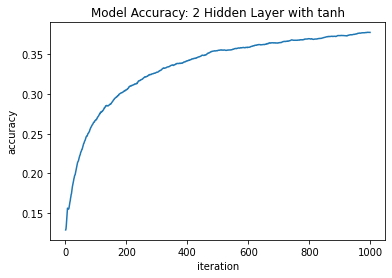

In [ ]:
# plot training history
fig = plt.plot(figsize=(12, 4))
iteration = list(range(1,1000))

# History for accuracy
plt.plot(iteration, acc_history_tanh)
plt.title('Model Accuracy: 2 Hidden Layer with tanh')
plt.ylabel('accuracy')
plt.xlabel('iteration')

plt.savefig("two_hidden_tanh.png")

### Leaky-ReLU

In [ ]:
def objective(trial):
    # Define the search space for the hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    #L2_lambda = trial.suggest_float("L2_lambda", 1e-6, 1e-2, log=True)

    # Create the MLP_2 model with the given hyperparameters
    model_leaky = MLP_2(M=[256, 256], n_hidden = 2, L2_lambda = 0, activation = leaky)
    optimizer = GradientDescent(learning_rate=learning_rate, max_iters=5)

    # Train the model and compute its validation accuracy
    yh_leaky = model_leaky.fit(train_images, train_labels, optimizer)
    val_acc = yh_leaky.acc_history[-1]

    return val_acc

# Define the search method and run the optimization process
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Print the best hyperparameters found by Optuna
print("Best hyperparameters: ", study.best_params)

[I 2023-03-09 04:37:41,816] A new study created in memory with name: no-name-2548f3e8-36b1-455d-a758-84be6685503e


1
[[0.11731062 0.09349255 0.19896355 ... 0.05811469 0.10081559 0.0665276 ]
 [0.09149046 0.08523796 0.21551261 ... 0.05171734 0.074808   0.13780733]
 [0.09270521 0.05890772 0.24823795 ... 0.03552434 0.10069361 0.09882496]
 ...
 [0.09952011 0.06355007 0.16589862 ... 0.06612938 0.08923874 0.1156328 ]
 [0.09993651 0.06927667 0.29638182 ... 0.03029392 0.08168261 0.10707109]
 [0.08991476 0.07354215 0.22102653 ... 0.05201172 0.08765019 0.09558057]]
acc: 0.0998


2
[[0.131301   0.10646263 0.01915634 ... 0.09510429 0.13673485 0.04980249]
 [0.11355898 0.10289409 0.01096443 ... 0.09989797 0.12929981 0.08922259]
 [0.12370038 0.08256835 0.00734892 ... 0.06332807 0.21951329 0.07290677]
 ...
 [0.11190166 0.08220703 0.01215042 ... 0.10738758 0.16289962 0.09580817]
 [0.1442798  0.09515466 0.00467586 ... 0.06088084 0.19239525 0.06470364]
 [0.11535952 0.0921424  0.00742718 ... 0.09367451 0.15072573 0.08206441]]
acc: 0.1269


3
[[0.11629297 0.12173528 0.06438672 ... 0.11762414 0.08457856 0.07646513]
 [0.0

[I 2023-03-09 04:38:15,807] Trial 0 finished with value: 0.1736 and parameters: {'learning_rate': 0.08249603551844904}. Best is trial 0 with value: 0.1736.


1
[[0.0899865  0.08965179 0.03125538 ... 0.09610797 0.04827867 0.14939378]
 [0.10572032 0.09199624 0.02720483 ... 0.07545206 0.03995359 0.10848119]
 [0.0983271  0.08325945 0.04169457 ... 0.09719808 0.03129908 0.11241638]
 ...
 [0.09111725 0.10107311 0.04476709 ... 0.0718202  0.04685961 0.12427711]
 [0.08695261 0.07339072 0.03231729 ... 0.09236108 0.03407777 0.09804211]
 [0.07573192 0.09095554 0.0305201  ... 0.11973586 0.04235443 0.14019946]]
acc: 0.0993


2
[[0.09062321 0.0898911  0.0315456  ... 0.0964589  0.04876766 0.14947454]
 [0.10695192 0.09247341 0.02756621 ... 0.07583921 0.04060047 0.10873361]
 [0.09981345 0.08372997 0.04230947 ... 0.0977078  0.0318396  0.1126618 ]
 ...
 [0.09198446 0.10144697 0.04524102 ... 0.07205624 0.04743035 0.12444383]
 [0.08867469 0.0739861  0.0329644  ... 0.09325375 0.03494832 0.09849703]
 [0.07668057 0.09147658 0.03095312 ... 0.12035472 0.04301528 0.14059162]]
acc: 0.0995


3
[[0.09123351 0.09011839 0.03183186 ... 0.09679343 0.04925104 0.14953084]
 [0.1

[I 2023-03-09 04:38:48,738] Trial 1 finished with value: 0.0992 and parameters: {'learning_rate': 0.0005224781642084607}. Best is trial 0 with value: 0.1736.


1
[[0.05283236 0.05831972 0.16387104 ... 0.08588908 0.07357386 0.11112483]
 [0.03819523 0.06445634 0.12256896 ... 0.12136729 0.07227173 0.08006176]
 [0.05361618 0.06184676 0.14525894 ... 0.12841867 0.06910506 0.10170689]
 ...
 [0.06185215 0.07451155 0.13125591 ... 0.10805351 0.07762894 0.09689187]
 [0.03326149 0.03620802 0.16791447 ... 0.14376763 0.07730929 0.07703552]
 [0.05736341 0.06947984 0.18697656 ... 0.09123035 0.05991482 0.11537384]]
acc: 0.0959


2
[[0.05283851 0.05832597 0.16386421 ... 0.08588715 0.07358026 0.11112838]
 [0.03820217 0.06446633 0.12256125 ... 0.12136335 0.07228145 0.08006636]
 [0.05362545 0.06185621 0.14524974 ... 0.1284157  0.06911537 0.1017156 ]
 ...
 [0.06186173 0.07452131 0.13124908 ... 0.10805094 0.07763866 0.09689722]
 [0.03326967 0.0362152  0.16790284 ... 0.14376239 0.07732384 0.07704312]
 [0.05737262 0.06948992 0.18696709 ... 0.09122903 0.0599227  0.11538257]]
acc: 0.0958


3
[[0.05284465 0.05833221 0.16385738 ... 0.08588522 0.07358667 0.11113192]
 [0.0

[I 2023-03-09 04:39:22,335] Trial 2 finished with value: 0.0958 and parameters: {'learning_rate': 1.1664276344265486e-05}. Best is trial 0 with value: 0.1736.


1
[[0.10383521 0.1987473  0.06392775 ... 0.11663726 0.0709415  0.06509856]
 [0.15972462 0.21084468 0.03766814 ... 0.12406675 0.06048874 0.06208546]
 [0.15715646 0.2489967  0.04150614 ... 0.08113549 0.05742315 0.04853807]
 ...
 [0.13457425 0.20352425 0.05221328 ... 0.09701514 0.05861266 0.08863219]
 [0.17627005 0.25102219 0.03314524 ... 0.07210481 0.05363028 0.04636007]
 [0.17481681 0.222881   0.06032181 ... 0.08089933 0.0573913  0.0705943 ]]
acc: 0.0885


2
[[0.10386472 0.1985981  0.06396362 ... 0.11664118 0.07096609 0.06511807]
 [0.15978828 0.21063068 0.0376944  ... 0.12408454 0.06052554 0.06211455]
 [0.15723959 0.24871651 0.0415448  ... 0.08114964 0.05746765 0.04856816]
 ...
 [0.13461606 0.20333977 0.05224652 ... 0.09702284 0.05864443 0.08866979]
 [0.17639049 0.25070219 0.03317984 ... 0.07212298 0.05367829 0.04639378]
 [0.17488706 0.22262215 0.06037127 ... 0.08091127 0.05742513 0.07062964]]
acc: 0.0885


3
[[0.10389414 0.19844925 0.06399946 ... 0.11664506 0.07099066 0.06513755]
 [0.1

[I 2023-03-09 04:39:54,469] Trial 3 finished with value: 0.0885 and parameters: {'learning_rate': 3.045365501273611e-05}. Best is trial 0 with value: 0.1736.


1
[[0.11406168 0.12119955 0.068199   ... 0.05000081 0.07349403 0.11557409]
 [0.09122618 0.15959239 0.06242198 ... 0.05530878 0.06466292 0.10075753]
 [0.1187804  0.13344313 0.08764366 ... 0.07765439 0.08264691 0.06930073]
 ...
 [0.1188636  0.14451005 0.07905943 ... 0.07204637 0.07756064 0.0641313 ]
 [0.0670905  0.18314184 0.05748464 ... 0.05422578 0.06921153 0.08432714]
 [0.08744118 0.24414434 0.07600695 ... 0.04796827 0.06691286 0.08554646]]
acc: 0.0781


2
[[0.14234095 0.06164237 0.0817394  ... 0.07987918 0.11328211 0.11135793]
 [0.13768663 0.06678012 0.08005356 ... 0.09850056 0.12026698 0.10399845]
 [0.16864785 0.0574025  0.09867601 ... 0.12935115 0.14877319 0.07765206]
 ...
 [0.15811105 0.07562674 0.09242569 ... 0.11520198 0.12670639 0.07015462]
 [0.12913895 0.06124014 0.0823542  ... 0.12488182 0.16041004 0.09876199]
 [0.14078516 0.10475791 0.09724496 ... 0.09458764 0.12185133 0.09624122]]
acc: 0.0945


3
[[0.11521325 0.08192294 0.08791425 ... 0.06404458 0.09947503 0.11408661]
 [0.1

[I 2023-03-09 04:40:26,982] Trial 4 finished with value: 0.1222 and parameters: {'learning_rate': 0.05728976617997867}. Best is trial 0 with value: 0.1736.


1
[[0.11341739 0.1332818  0.06861248 ... 0.06154364 0.12453566 0.08776657]
 [0.11694645 0.17913614 0.05475331 ... 0.06374508 0.13665767 0.06394836]
 [0.17450458 0.15158099 0.03323106 ... 0.03290033 0.22171171 0.1007784 ]
 ...
 [0.1494479  0.14777438 0.04347412 ... 0.03589297 0.1960622  0.09810249]
 [0.14028396 0.17694158 0.03967515 ... 0.04467555 0.20518326 0.07939351]
 [0.14033917 0.17600893 0.04263549 ... 0.05052753 0.16928737 0.08290926]]
acc: 0.1276


2
[[0.11067116 0.11192578 0.08185058 ... 0.07106186 0.10858529 0.09307048]
 [0.11674657 0.15048461 0.06678365 ... 0.07602982 0.11845027 0.07065467]
 [0.17617407 0.12604016 0.04255937 ... 0.04152177 0.19888177 0.11844345]
 ...
 [0.15221073 0.13067607 0.051699   ... 0.04237942 0.18021178 0.10868768]
 [0.14273951 0.14096777 0.0526139  ... 0.05667325 0.17563836 0.09387377]
 [0.14391255 0.14617477 0.05554094 ... 0.0620455  0.14620554 0.09317982]]
acc: 0.1414


3
[[0.10660494 0.10183431 0.09154897 ... 0.07799042 0.10008201 0.09567091]
 [0.1

[I 2023-03-09 04:40:58,359] Trial 5 finished with value: 0.1585 and parameters: {'learning_rate': 0.01881629503592432}. Best is trial 0 with value: 0.1736.


1
[[0.07396775 0.09338752 0.09406301 ... 0.07799654 0.1431409  0.12380599]
 [0.08057469 0.09203843 0.10571795 ... 0.08828635 0.12464462 0.10481394]
 [0.08117225 0.1380456  0.13853173 ... 0.07339901 0.10611938 0.08827887]
 ...
 [0.09158947 0.13487542 0.14659639 ... 0.05791206 0.12207027 0.09773202]
 [0.07593671 0.09752391 0.09818272 ... 0.06226334 0.14235457 0.14706637]
 [0.06887728 0.10267942 0.10231665 ... 0.07489949 0.12188436 0.11181286]]
acc: 0.0848


2
[[0.09073076 0.09847486 0.09863785 ... 0.09387612 0.12295453 0.11244131]
 [0.1073694  0.10028967 0.11466218 ... 0.11724577 0.10409315 0.09298913]
 [0.11391272 0.1444813  0.14758274 ... 0.09147095 0.0930774  0.08353243]
 ...
 [0.12094524 0.14276689 0.15361889 ... 0.06903272 0.10961338 0.09366499]
 [0.11481774 0.10924185 0.11537006 ... 0.08867666 0.1144905  0.13012889]
 [0.09957556 0.10580456 0.11071384 ... 0.10304194 0.10108208 0.09851053]]
acc: 0.1090


3
[[0.09253095 0.09496059 0.08971362 ... 0.09648558 0.1203255  0.10859609]
 [0.1

[I 2023-03-09 04:41:32,483] Trial 6 finished with value: 0.1363 and parameters: {'learning_rate': 0.05244077442191398}. Best is trial 0 with value: 0.1736.


1
[[0.09045    0.11218113 0.11301279 ... 0.12430164 0.11574958 0.10854207]
 [0.0798755  0.06875708 0.17820313 ... 0.10973071 0.07959554 0.13275741]
 [0.08966499 0.08118359 0.12652908 ... 0.11730885 0.08363225 0.2452238 ]
 ...
 [0.10403649 0.08727866 0.1319795  ... 0.09480948 0.06551348 0.23640276]
 [0.08715614 0.0819425  0.16895737 ... 0.11650162 0.08319675 0.17607868]
 [0.11731787 0.08161172 0.19499918 ... 0.10082635 0.05243643 0.15354844]]
acc: 0.1316


2
[[0.07958513 0.1193707  0.0455377  ... 0.08647429 0.13749463 0.04648967]
 [0.09384734 0.10063391 0.07319381 ... 0.07136182 0.14745202 0.05481158]
 [0.10997048 0.11606172 0.04794906 ... 0.07007538 0.16766401 0.11910616]
 ...
 [0.1212039  0.11272516 0.05639985 ... 0.06491462 0.11624837 0.12864576]
 [0.10739551 0.12173566 0.04992612 ... 0.07225932 0.18249851 0.06230976]
 [0.15159113 0.11846656 0.07560213 ... 0.07491288 0.10337903 0.07573575]]
acc: 0.1414


3
[[0.11775367 0.06958158 0.1103954  ... 0.10449559 0.07127526 0.10356162]
 [0.1

[I 2023-03-09 04:42:03,938] Trial 7 finished with value: 0.1351 and parameters: {'learning_rate': 0.07958150674686469}. Best is trial 0 with value: 0.1736.


1
[[0.13456611 0.04708558 0.09691104 ... 0.1306967  0.11561091 0.06741247]
 [0.11776333 0.03989006 0.15236497 ... 0.16677912 0.05374862 0.03801093]
 [0.08961113 0.02473116 0.08667864 ... 0.26118536 0.04105626 0.05086015]
 ...
 [0.09234341 0.04566557 0.14237654 ... 0.20934923 0.04394428 0.04361908]
 [0.11294687 0.03036154 0.11831398 ... 0.2350663  0.05376817 0.0387132 ]
 [0.12732481 0.05217336 0.10942443 ... 0.20956898 0.06658062 0.04062426]]
acc: 0.1001


2
[[0.13485281 0.04780071 0.09640664 ... 0.12796831 0.11693378 0.06840291]
 [0.1187705  0.04093768 0.1516344  ... 0.16273883 0.0548058  0.03888209]
 [0.09052113 0.02550972 0.0864471  ... 0.25465926 0.04202009 0.05238861]
 ...
 [0.09317412 0.04678452 0.14181461 ... 0.20462669 0.0447798  0.04469953]
 [0.11449829 0.03145388 0.11773977 ... 0.22766621 0.05527931 0.04000511]
 [0.12853646 0.05349696 0.10881013 ... 0.20428312 0.06777408 0.0415775 ]]
acc: 0.0987


3
[[0.13507288 0.04850173 0.09589829 ... 0.12548882 0.11818103 0.06935712]
 [0.1

[I 2023-03-09 04:42:36,775] Trial 8 finished with value: 0.0966 and parameters: {'learning_rate': 0.0011263584592230062}. Best is trial 0 with value: 0.1736.


1
[[0.03596944 0.03689165 0.10708295 ... 0.12400935 0.1680935  0.10909188]
 [0.02976464 0.04335423 0.06806874 ... 0.11533974 0.24034543 0.07800593]
 [0.01930596 0.04105626 0.04958874 ... 0.13939906 0.18644051 0.11009114]
 ...
 [0.03028366 0.06676545 0.08074006 ... 0.11148591 0.17619031 0.11073666]
 [0.01554663 0.02886259 0.05476076 ... 0.13900444 0.28738038 0.0959735 ]
 [0.0255216  0.03456066 0.05564404 ... 0.13806511 0.22254726 0.11027101]]
acc: 0.1062


2
[[0.03604965 0.03694402 0.10716069 ... 0.12396278 0.16789188 0.10911857]
 [0.02985336 0.04343659 0.06813705 ... 0.11528658 0.24007473 0.07803754]
 [0.01937004 0.0411371  0.04964414 ... 0.13934443 0.1861976  0.11017601]
 ...
 [0.03034991 0.06685961 0.08078726 ... 0.11145085 0.17598418 0.1108056 ]
 [0.01561903 0.02894569 0.0548482  ... 0.13895884 0.2869603  0.09607906]
 [0.02560451 0.03463415 0.05571003 ... 0.13800734 0.22224537 0.11035685]]
acc: 0.1062


3
[[0.0361299  0.03699636 0.10723821 ... 0.12391625 0.16769107 0.10914503]
 [0.0

[I 2023-03-09 04:43:07,903] Trial 9 finished with value: 0.1067 and parameters: {'learning_rate': 9.438721229018497e-05}. Best is trial 0 with value: 0.1736.


1
[[0.12057593 0.2225692  0.0641944  ... 0.09126999 0.09402231 0.04166992]
 [0.15366311 0.21533578 0.06899902 ... 0.06151111 0.08437164 0.02555148]
 [0.17915125 0.25196991 0.05183527 ... 0.06392216 0.06204498 0.02851623]
 ...
 [0.15798334 0.17988816 0.06589604 ... 0.0692768  0.09958178 0.04330791]
 [0.1169355  0.30372984 0.06236858 ... 0.05800648 0.09143486 0.02393113]
 [0.12083904 0.24842453 0.05900717 ... 0.04680238 0.08821484 0.03236487]]
acc: 0.0927


2
[[0.12854594 0.18028162 0.07293372 ... 0.10236159 0.10584511 0.04994644]
 [0.166133   0.17146606 0.07995542 ... 0.07011073 0.0947125  0.03220554]
 [0.20013986 0.19297622 0.06098371 ... 0.07394137 0.0705015  0.0379325 ]
 ...
 [0.16713476 0.14355217 0.07311545 ... 0.07674131 0.11000297 0.05254348]
 [0.13832361 0.22325969 0.0779462  ... 0.0717837  0.11159423 0.03371022]
 [0.13756688 0.19710555 0.06932964 ... 0.05469392 0.10147729 0.04211565]]
acc: 0.0969


3
[[0.12975618 0.15754636 0.07871651 ... 0.10899421 0.11223981 0.05712448]
 [0.1

[I 2023-03-09 04:43:40,290] Trial 10 finished with value: 0.1127 and parameters: {'learning_rate': 0.006357087623180898}. Best is trial 0 with value: 0.1736.


1
[[0.12793493 0.13258064 0.06331945 ... 0.1439381  0.11139679 0.08416695]
 [0.13144581 0.11632259 0.0611267  ... 0.18439442 0.0994859  0.11544817]
 [0.07084843 0.09243713 0.07830177 ... 0.16553295 0.17009952 0.0657149 ]
 ...
 [0.08995054 0.09954492 0.07914013 ... 0.16618492 0.1482754  0.07590917]
 [0.13782645 0.12906703 0.06394416 ... 0.14012542 0.11863508 0.10750298]
 [0.10206409 0.15597641 0.05275163 ... 0.14987035 0.12197157 0.07259302]]
acc: 0.0922


2
[[0.13618164 0.12044428 0.06978278 ... 0.12902596 0.1067591  0.08951339]
 [0.14293823 0.10520988 0.06904266 ... 0.16262374 0.09610509 0.1244935 ]
 [0.0786156  0.08383475 0.08830293 ... 0.14509453 0.16199364 0.07353905]
 ...
 [0.09689725 0.09220701 0.08621949 ... 0.14986605 0.14328909 0.08242281]
 [0.1531541  0.1123946  0.07424982 ... 0.11675209 0.11105479 0.12017904]
 [0.11278812 0.14008654 0.05959174 ... 0.13312553 0.1174469  0.07997081]]
acc: 0.0914


3
[[0.14021654 0.11261761 0.07475295 ... 0.11995632 0.10376439 0.09231416]
 [0.1

[I 2023-03-09 04:44:11,762] Trial 11 finished with value: 0.0977 and parameters: {'learning_rate': 0.012282177062329414}. Best is trial 0 with value: 0.1736.


1
[[0.14302643 0.0566626  0.20303644 ... 0.07325798 0.07965616 0.09851078]
 [0.14945968 0.03590143 0.24661838 ... 0.05686815 0.08120979 0.09731913]
 [0.09007568 0.03991836 0.202814   ... 0.09392616 0.07307666 0.08515848]
 ...
 [0.08216414 0.07340821 0.14805611 ... 0.12110694 0.06904304 0.10134007]
 [0.09376618 0.02748278 0.25069622 ... 0.06438605 0.07802347 0.10624877]
 [0.09234818 0.04440366 0.24046264 ... 0.07494425 0.08209916 0.11364531]]
acc: 0.0992


2
[[0.1461017  0.06960179 0.1613096  ... 0.08479071 0.08651967 0.10152685]
 [0.16149139 0.04938499 0.185191   ... 0.0676457  0.09473492 0.1036227 ]
 [0.09960936 0.05642109 0.15315297 ... 0.11360562 0.08656634 0.0930926 ]
 ...
 [0.08472484 0.09085895 0.11483071 ... 0.1347128  0.07789197 0.10420312]
 [0.10704786 0.04225738 0.18041154 ... 0.08166051 0.09754309 0.11846367]
 [0.10125111 0.06069623 0.18165862 ... 0.09003477 0.09514567 0.12215223]]
acc: 0.0964


3
[[0.14409079 0.07888451 0.14240596 ... 0.09152842 0.08945699 0.10131766]
 [0.1

[I 2023-03-09 04:44:44,354] Trial 12 finished with value: 0.1038 and parameters: {'learning_rate': 0.012218737045315077}. Best is trial 0 with value: 0.1736.


1
[[0.07064574 0.09848233 0.13961806 ... 0.06913    0.19118406 0.05587283]
 [0.05654902 0.07141287 0.21562318 ... 0.06983758 0.14283283 0.06512983]
 [0.04385794 0.08278636 0.1724402  ... 0.07781492 0.22687508 0.08996822]
 ...
 [0.05344402 0.10478444 0.1905255  ... 0.07914231 0.17268122 0.08600691]
 [0.04390613 0.06926667 0.18543733 ... 0.05079863 0.27593737 0.06693592]
 [0.06975411 0.11855199 0.13767749 ... 0.05643008 0.21730174 0.04940856]]
acc: 0.1068


2
[[0.12387138 0.10840674 0.06105237 ... 0.10509613 0.07439958 0.10294471]
 [0.11238599 0.08334901 0.07971127 ... 0.10941557 0.05706119 0.14374219]
 [0.09840384 0.09952955 0.05361064 ... 0.13939051 0.06623842 0.22666148]
 ...
 [0.10546968 0.11766528 0.0746202  ... 0.12044318 0.0721247  0.18392878]
 [0.12206852 0.08692018 0.05342682 ... 0.10790526 0.07677294 0.20045055]
 [0.14159133 0.13396602 0.05359255 ... 0.09920408 0.07401279 0.11438   ]]
acc: 0.1295


3
[[0.09130093 0.09885655 0.09682824 ... 0.08777179 0.12836392 0.06437775]
 [0.0

[I 2023-03-09 04:45:16,617] Trial 13 finished with value: 0.1564 and parameters: {'learning_rate': 0.09091823406333305}. Best is trial 0 with value: 0.1736.


1
[[0.06409978 0.10788252 0.13315563 ... 0.10506152 0.08905364 0.18853805]
 [0.05241841 0.08243732 0.13139481 ... 0.0846123  0.08977923 0.27225235]
 [0.05636667 0.05631893 0.13657689 ... 0.06701159 0.07666612 0.35992899]
 ...
 [0.05607743 0.07622658 0.12857568 ... 0.08636867 0.07086645 0.24767796]
 [0.04067077 0.10236886 0.11696652 ... 0.10491424 0.07794273 0.28985011]
 [0.05389796 0.0658188  0.16871522 ... 0.08517609 0.09496152 0.23709623]]
acc: 0.1001


2
[[0.08930466 0.11340478 0.12047794 ... 0.12580072 0.09673537 0.10405364]
 [0.08233459 0.0928183  0.13071696 ... 0.10477498 0.10740316 0.13891373]
 [0.10887673 0.06968483 0.13072565 ... 0.09109644 0.10185555 0.18707812]
 ...
 [0.08468802 0.08824826 0.11756183 ... 0.09802971 0.08611281 0.1482833 ]
 [0.07635928 0.12344727 0.11287828 ... 0.13876183 0.1032825  0.11984995]
 [0.09194281 0.07389721 0.15513134 ... 0.11083347 0.11034805 0.11623127]]
acc: 0.0921


3
[[0.10032468 0.11229162 0.11170737 ... 0.125672   0.09674054 0.09178201]
 [0.0

[I 2023-03-09 04:45:48,382] Trial 14 finished with value: 0.1047 and parameters: {'learning_rate': 0.019129169873525708}. Best is trial 0 with value: 0.1736.


1
[[0.07414979 0.054555   0.07274579 ... 0.13684441 0.09399353 0.12327321]
 [0.08130493 0.04340546 0.07373579 ... 0.15494865 0.10870721 0.09529508]
 [0.07809683 0.04636421 0.09244459 ... 0.10237165 0.0753096  0.16370977]
 ...
 [0.1028405  0.04040837 0.07806046 ... 0.10684589 0.08656665 0.11786533]
 [0.07361939 0.04205476 0.07859005 ... 0.09259845 0.10341835 0.14860516]
 [0.07255143 0.04003353 0.04980067 ... 0.12772688 0.102231   0.11977149]]
acc: 0.0982


2
[[0.07700169 0.05665305 0.07551575 ... 0.13705782 0.09570112 0.12293975]
 [0.08590501 0.04576778 0.07703216 ... 0.1558809  0.11183643 0.09566006]
 [0.08256082 0.0492532  0.09619231 ... 0.10285617 0.07749615 0.16496523]
 ...
 [0.10792034 0.04257498 0.08033392 ... 0.10737069 0.08883507 0.1188269 ]
 [0.07957705 0.04543317 0.08354972 ... 0.09371593 0.10860552 0.14958556]
 [0.07659375 0.04235228 0.05202738 ... 0.12934763 0.10456662 0.12059199]]
acc: 0.0961


3
[[0.07960968 0.05867897 0.07790696 ... 0.13693892 0.09707633 0.12256589]
 [0.0

[I 2023-03-09 04:46:19,743] Trial 15 finished with value: 0.0979 and parameters: {'learning_rate': 0.0033873070371599344}. Best is trial 0 with value: 0.1736.


1
[[0.06672453 0.08754645 0.05942446 ... 0.08208151 0.14770575 0.15110996]
 [0.04830948 0.04690937 0.06735388 ... 0.09302244 0.16942111 0.14030701]
 [0.03358985 0.03236604 0.06275033 ... 0.09167322 0.15837009 0.08058606]
 ...
 [0.04112774 0.04260238 0.09331117 ... 0.10741826 0.19705572 0.09123495]
 [0.06254283 0.02418395 0.05943242 ... 0.09459397 0.16285176 0.11937208]
 [0.05434475 0.04506646 0.07252542 ... 0.12096514 0.14416076 0.13210629]]
acc: 0.1022


2
[[0.08693739 0.10647642 0.06469998 ... 0.08036762 0.13662446 0.14927353]
 [0.07211392 0.06230905 0.07549902 ... 0.091041   0.15727948 0.14649545]
 [0.05289866 0.04388827 0.07393527 ... 0.09613578 0.1609172  0.08905985]
 ...
 [0.05577286 0.05347652 0.10530304 ... 0.10897057 0.19136617 0.09587213]
 [0.10365947 0.03437955 0.07234493 ... 0.09421465 0.15383472 0.12932755]
 [0.0774009  0.05916947 0.08309003 ... 0.11987292 0.13404208 0.13700161]]
acc: 0.1146


3
[[0.09812684 0.11944303 0.0682994  ... 0.07829613 0.12645658 0.14300716]
 [0.0

[I 2023-03-09 04:46:51,012] Trial 16 finished with value: 0.1283 and parameters: {'learning_rate': 0.019521506658704037}. Best is trial 0 with value: 0.1736.


1
[[0.09727345 0.16306784 0.04302889 ... 0.05259039 0.05698706 0.13234698]
 [0.09323496 0.13330206 0.04726712 ... 0.05091447 0.05284359 0.10926403]
 [0.06671754 0.27854828 0.02459212 ... 0.02804691 0.06019448 0.18082052]
 ...
 [0.08876792 0.25378986 0.02621032 ... 0.02558821 0.0794932  0.14143768]
 [0.10076902 0.20357319 0.01834591 ... 0.02874107 0.04484634 0.16214261]
 [0.08619607 0.18250858 0.02409901 ... 0.03852759 0.0761629  0.15605075]]
acc: 0.1127


2
[[0.10990214 0.13623101 0.06618739 ... 0.07657664 0.07155847 0.12195642]
 [0.11460201 0.10809597 0.08935091 ... 0.08362522 0.08005292 0.10490362]
 [0.09492644 0.20495227 0.05068227 ... 0.05498921 0.0981258  0.18495454]
 ...
 [0.11379707 0.1945791  0.04602923 ... 0.04440624 0.11383462 0.13619686]
 [0.14510736 0.15291046 0.04251739 ... 0.06335299 0.08479022 0.15977523]
 [0.10775145 0.13616869 0.04518323 ... 0.06932116 0.11398441 0.14361271]]
acc: 0.1204


3
[[0.10626934 0.12349196 0.08258291 ... 0.08546476 0.0754093  0.10527514]
 [0.1

[I 2023-03-09 04:47:22,998] Trial 17 finished with value: 0.1502 and parameters: {'learning_rate': 0.032773691473026445}. Best is trial 0 with value: 0.1736.


1
[[0.05967639 0.07357606 0.12210882 ... 0.14073626 0.15242264 0.10939208]
 [0.0421243  0.10799977 0.07340944 ... 0.13745831 0.12037984 0.11213269]
 [0.0547785  0.08243636 0.10012631 ... 0.11946259 0.15814264 0.09371435]
 ...
 [0.0592329  0.087911   0.11032456 ... 0.10259599 0.10461328 0.0986174 ]
 [0.04319452 0.08702542 0.09924514 ... 0.14248524 0.150553   0.09249005]
 [0.05802521 0.08286961 0.13485757 ... 0.13865691 0.10247831 0.10893436]]
acc: 0.1031


2
[[0.06252348 0.07464531 0.12183011 ... 0.13978236 0.15089134 0.10852648]
 [0.0448022  0.10986325 0.07297282 ... 0.13676965 0.11983808 0.11063913]
 [0.05938953 0.08509962 0.09904909 ... 0.11843627 0.15844616 0.09426542]
 ...
 [0.06257178 0.08937849 0.10931919 ... 0.10180648 0.10469529 0.09918151]
 [0.04766152 0.08987246 0.09830771 ... 0.14138531 0.15136811 0.09231966]
 [0.06210421 0.08456211 0.13403189 ... 0.1376421  0.10212079 0.10812761]]
acc: 0.1080


3
[[0.06522185 0.07554622 0.12154457 ... 0.13876385 0.14925138 0.1076407 ]
 [0.0

[I 2023-03-09 04:47:55,245] Trial 18 finished with value: 0.116 and parameters: {'learning_rate': 0.004355359971734457}. Best is trial 0 with value: 0.1736.


1
[[0.14178318 0.05908135 0.09883401 ... 0.11881084 0.0684267  0.1147069 ]
 [0.1451123  0.07776152 0.09077752 ... 0.09959335 0.04823633 0.08794853]
 [0.14088365 0.08776245 0.11568031 ... 0.14112377 0.04835645 0.13675741]
 ...
 [0.12323482 0.08312431 0.10541991 ... 0.16345434 0.07072483 0.09089463]
 [0.15043408 0.06533084 0.12313561 ... 0.1019031  0.04677225 0.13803111]
 [0.12965233 0.05646265 0.09829384 ... 0.11090155 0.04799244 0.12193819]]
acc: 0.0995


2
[[0.12882075 0.0674618  0.09821244 ... 0.12309015 0.09230167 0.09445538]
 [0.13347687 0.09219343 0.09055468 ... 0.1052355  0.07185959 0.07291288]
 [0.13059104 0.10934897 0.1142716  ... 0.14264939 0.07715454 0.11365291]
 ...
 [0.1169093  0.09580101 0.10217449 ... 0.16418188 0.09812617 0.07995034]
 [0.13999042 0.08343702 0.12296018 ... 0.10609228 0.0800056  0.10864482]
 [0.11834392 0.06871724 0.09761889 ... 0.11740836 0.07140006 0.09791363]]
acc: 0.1326


3
[[0.12701416 0.07061456 0.09502585 ... 0.12166997 0.10707792 0.09016684]
 [0.1

[I 2023-03-09 04:48:35,871] Trial 19 finished with value: 0.1545 and parameters: {'learning_rate': 0.03096971837167303}. Best is trial 0 with value: 0.1736.


1
[[0.08959589 0.05864295 0.10194876 ... 0.092809   0.22302878 0.04529102]
 [0.07010208 0.06082016 0.0681944  ... 0.11618182 0.26661934 0.04890017]
 [0.08455515 0.06276136 0.07149254 ... 0.12885683 0.25594459 0.07200875]
 ...
 [0.05897355 0.06194792 0.07736618 ... 0.09320574 0.27942993 0.07198921]
 [0.0495393  0.04830043 0.05503088 ... 0.12985316 0.36098908 0.03822802]
 [0.07430818 0.07254701 0.08808179 ... 0.08997119 0.24603067 0.07453929]]
acc: 0.1029


2
[[0.19088836 0.07024813 0.15149212 ... 0.07099006 0.00758163 0.14032717]
 [0.21832893 0.08761042 0.10900457 ... 0.06526362 0.00388498 0.21119929]
 [0.21086533 0.05984397 0.10176944 ... 0.06781232 0.00257105 0.31525438]
 ...
 [0.16263283 0.08052767 0.10832034 ... 0.06378196 0.00937158 0.26926085]
 [0.24634335 0.05966405 0.10136632 ... 0.06105545 0.00126475 0.27435822]
 [0.17844355 0.08350908 0.13043491 ... 0.04810503 0.00393568 0.27200358]]
acc: 0.1062


3
[[0.05158358 0.08546202 0.12588595 ... 0.1024126  0.04166192 0.02368404]
 [0.0

[I 2023-03-09 04:49:08,419] Trial 20 finished with value: 0.1127 and parameters: {'learning_rate': 0.09722216155891958}. Best is trial 0 with value: 0.1736.


1
[[0.12185314 0.08600908 0.11658791 ... 0.05408075 0.13191065 0.05387062]
 [0.11853806 0.10391121 0.10480338 ... 0.05540417 0.12005642 0.04902341]
 [0.12763943 0.06422296 0.12431649 ... 0.08282396 0.11766815 0.0584101 ]
 ...
 [0.13178244 0.06979963 0.10531695 ... 0.07939838 0.09133438 0.05872579]
 [0.11720057 0.07734768 0.08845184 ... 0.09282526 0.14067081 0.03227809]
 [0.06715051 0.09178316 0.09153905 ... 0.07861097 0.14186465 0.05374926]]
acc: 0.0703


2
[[0.1262515  0.09822807 0.11041621 ... 0.06289973 0.11870056 0.08251682]
 [0.1240502  0.12423765 0.09541921 ... 0.06463998 0.11264042 0.08996598]
 [0.13874168 0.08072841 0.10911766 ... 0.09787539 0.11509746 0.11150926]
 ...
 [0.1436401  0.08674046 0.09957458 ... 0.09236063 0.09574491 0.10342583]
 [0.12999551 0.10263254 0.08358554 ... 0.11812623 0.13441498 0.07651849]
 [0.06861176 0.1133223  0.08369854 ... 0.09526281 0.13417732 0.10167706]]
acc: 0.1073


3
[[0.11980035 0.09494349 0.1109009  ... 0.06713972 0.11910469 0.08669656]
 [0.1

[I 2023-03-09 04:49:40,374] Trial 21 finished with value: 0.1318 and parameters: {'learning_rate': 0.042350190980684516}. Best is trial 0 with value: 0.1736.


1
[[0.11155122 0.04245369 0.12447951 ... 0.14126346 0.09079031 0.10489864]
 [0.09483151 0.03969151 0.13369046 ... 0.12496113 0.13053851 0.11805467]
 [0.08661237 0.02483739 0.1266242  ... 0.19390583 0.11637647 0.0617799 ]
 ...
 [0.09751026 0.04307231 0.11844872 ... 0.19698253 0.12140225 0.08270275]
 [0.09864841 0.02518762 0.14982499 ... 0.24154362 0.10368238 0.07041914]
 [0.1029751  0.02270629 0.09846896 ... 0.19523739 0.12824373 0.10235717]]
acc: 0.1003


2
[[0.13892669 0.10180104 0.11750361 ... 0.04235381 0.08905807 0.09913288]
 [0.13805006 0.11966284 0.10714301 ... 0.0277862  0.13684536 0.10451763]
 [0.16468232 0.09805533 0.11597943 ... 0.03786192 0.12453337 0.09030551]
 ...
 [0.16156622 0.12575508 0.09923223 ... 0.05104438 0.1235158  0.10450075]
 [0.17924869 0.11763375 0.12549993 ... 0.02786659 0.11841391 0.07946125]
 [0.17958608 0.07745477 0.09678574 ... 0.0397051  0.13357359 0.12353885]]
acc: 0.1217


3
[[0.0802007  0.10221403 0.10971002 ... 0.08803092 0.06617238 0.09728537]
 [0.0

[I 2023-03-09 04:50:12,864] Trial 22 finished with value: 0.1398 and parameters: {'learning_rate': 0.09805684807062454}. Best is trial 0 with value: 0.1736.


1
[[0.10913504 0.17858342 0.10885768 ... 0.07686028 0.12639272 0.04368549]
 [0.08685207 0.1531232  0.08333923 ... 0.06272267 0.11608762 0.03882333]
 [0.05021989 0.1010022  0.06044111 ... 0.08391093 0.16889436 0.05764431]
 ...
 [0.05702837 0.11025183 0.07036907 ... 0.10456447 0.14518321 0.05605033]
 [0.04197288 0.2082551  0.05872739 ... 0.08129673 0.12499119 0.04229968]
 [0.08065001 0.0904974  0.07263401 ... 0.09415288 0.15015716 0.05243759]]
acc: 0.0887


2
[[0.14675494 0.12220676 0.11728635 ... 0.08880605 0.10913396 0.06085117]
 [0.12775901 0.10645462 0.09514048 ... 0.07738244 0.09821831 0.05997025]
 [0.08058245 0.06763494 0.07324204 ... 0.10197095 0.14576874 0.09944098]
 ...
 [0.08156754 0.08496741 0.07945013 ... 0.11724757 0.13279089 0.08462306]
 [0.07586518 0.12838591 0.07307072 ... 0.10529124 0.10814902 0.08198841]
 [0.1240339  0.05767273 0.08142964 ... 0.11571004 0.12496785 0.08698118]]
acc: 0.0945


3
[[0.15374633 0.1162282  0.11633568 ... 0.0912271  0.09959001 0.06948963]
 [0.1

[I 2023-03-09 04:50:44,200] Trial 23 finished with value: 0.1213 and parameters: {'learning_rate': 0.03226288396859828}. Best is trial 0 with value: 0.1736.


1
[[0.07645644 0.09703062 0.11518861 ... 0.12998267 0.08913841 0.08904923]
 [0.06386156 0.08049099 0.11678027 ... 0.17718898 0.07922933 0.07381774]
 [0.06557516 0.08432698 0.09109035 ... 0.13250214 0.1096181  0.0691962 ]
 ...
 [0.07354102 0.05671591 0.09088813 ... 0.12937279 0.09614565 0.06710411]
 [0.0469068  0.05422123 0.1030112  ... 0.16366571 0.0959655  0.05428143]
 [0.05552656 0.08362835 0.17217146 ... 0.13556087 0.09423663 0.08301675]]
acc: 0.1034


2
[[0.0824166  0.09977369 0.11289117 ... 0.12389162 0.09078477 0.09562815]
 [0.07236592 0.08458688 0.11720101 ... 0.16410532 0.08464532 0.08252263]
 [0.07515584 0.08870308 0.09180671 ... 0.12555192 0.11820051 0.08053759]
 ...
 [0.08162974 0.05847107 0.09174715 ... 0.12463923 0.10240435 0.07433322]
 [0.05729019 0.05904838 0.10532002 ... 0.15623577 0.10782158 0.06584604]
 [0.06132471 0.08621469 0.17243127 ... 0.12682141 0.09815298 0.09282781]]
acc: 0.0992


3
[[0.0872387  0.10115649 0.11057755 ... 0.11848559 0.09175252 0.10035684]
 [0.0

[I 2023-03-09 04:51:16,898] Trial 24 finished with value: 0.099 and parameters: {'learning_rate': 0.009741981661911247}. Best is trial 0 with value: 0.1736.


1
[[0.13839908 0.07937239 0.04085222 ... 0.13239841 0.07996491 0.1085973 ]
 [0.13543934 0.11153337 0.03799056 ... 0.13280575 0.06526037 0.12945058]
 [0.09405508 0.09910778 0.05020775 ... 0.09727294 0.07779527 0.18602333]
 ...
 [0.1258047  0.09579526 0.04379386 ... 0.09435576 0.08037305 0.14381784]
 [0.1354338  0.08766157 0.01938775 ... 0.08894765 0.0581785  0.14531759]
 [0.10738704 0.05513319 0.03934802 ... 0.10119928 0.08712995 0.14340402]]
acc: 0.1176


2
[[0.11560639 0.08937813 0.10475566 ... 0.13036272 0.12725641 0.0848869 ]
 [0.11266502 0.12499068 0.11157342 ... 0.11951297 0.14113049 0.09964664]
 [0.08779369 0.12305178 0.14023713 ... 0.08802117 0.16249993 0.13821884]
 ...
 [0.12612425 0.11154471 0.1115335  ... 0.09454279 0.15319564 0.12473156]
 [0.12552048 0.11744899 0.09683189 ... 0.08410812 0.17157365 0.10750131]
 [0.09200176 0.06700247 0.11809562 ... 0.09600965 0.16677251 0.11113233]]
acc: 0.1181


3
[[0.10347384 0.09229326 0.0920955  ... 0.12137067 0.07825407 0.08921938]
 [0.1

[I 2023-03-09 04:51:48,769] Trial 25 finished with value: 0.168 and parameters: {'learning_rate': 0.08884330955625759}. Best is trial 0 with value: 0.1736.


1
[[0.05988966 0.06253122 0.05401079 ... 0.08453333 0.21301403 0.13609969]
 [0.07139551 0.06948752 0.05848675 ... 0.10740069 0.17359436 0.16105326]
 [0.05405875 0.07016031 0.04033614 ... 0.18813998 0.1490571  0.15254066]
 ...
 [0.06379538 0.08719939 0.04569124 ... 0.15151576 0.12970772 0.11240533]
 [0.06378416 0.05359032 0.03984757 ... 0.12069388 0.17003244 0.24284464]
 [0.05490397 0.06198354 0.04333344 ... 0.10097343 0.17236962 0.1938666 ]]
acc: 0.0959


2
[[0.08365076 0.07544367 0.0730205  ... 0.08155721 0.15919626 0.10990999]
 [0.10644637 0.08439775 0.08236549 ... 0.09588669 0.12102214 0.12454519]
 [0.08791536 0.09279665 0.06188494 ... 0.16587213 0.10318413 0.12604152]
 ...
 [0.09280015 0.10799449 0.06291605 ... 0.13236597 0.09604438 0.09502134]
 [0.11359483 0.07036126 0.06628433 ... 0.10843541 0.11010319 0.18171532]
 [0.0874592  0.07724288 0.06501984 ... 0.09290209 0.11755382 0.15155   ]]
acc: 0.0891


3
[[0.0934749  0.0809974  0.08394858 ... 0.07901324 0.14613038 0.0977465 ]
 [0.1

[I 2023-03-09 04:52:22,664] Trial 26 finished with value: 0.1207 and parameters: {'learning_rate': 0.024545366246818214}. Best is trial 0 with value: 0.1736.


1
[[0.10045169 0.11782082 0.09362786 ... 0.05483685 0.04958569 0.09316913]
 [0.08904044 0.12222371 0.09623908 ... 0.03351174 0.03693685 0.0818138 ]
 [0.08308706 0.107823   0.15401451 ... 0.03415218 0.04770713 0.06842282]
 ...
 [0.09631863 0.07876939 0.19369913 ... 0.03899906 0.06059715 0.0688373 ]
 [0.08059975 0.09572858 0.14259933 ... 0.01921808 0.03427268 0.07201281]
 [0.07443399 0.09923145 0.18188687 ... 0.03148717 0.03224811 0.05570406]]
acc: 0.1008


2
[[0.11562067 0.08736547 0.08121935 ... 0.10163539 0.09498379 0.11368316]
 [0.1283912  0.10786614 0.10196096 ... 0.08514957 0.1087221  0.1225546 ]
 [0.11927829 0.09305796 0.12451752 ... 0.08678957 0.13254585 0.10665787]
 ...
 [0.11099926 0.05925945 0.1556818  ... 0.07404996 0.12902546 0.09283335]
 [0.14579278 0.07665393 0.13101616 ... 0.07064758 0.13938482 0.13113088]
 [0.11953605 0.08102706 0.15650437 ... 0.09061649 0.09373948 0.09686973]]
acc: 0.1375


3
[[0.09247067 0.12290739 0.07496199 ... 0.10138929 0.10602073 0.10843282]
 [0.0

[I 2023-03-09 04:52:55,236] Trial 27 finished with value: 0.1661 and parameters: {'learning_rate': 0.04800111383220362}. Best is trial 0 with value: 0.1736.


1
[[0.07141584 0.06898896 0.22718316 ... 0.06131205 0.06636397 0.10307647]
 [0.07940434 0.05988336 0.24501887 ... 0.06778474 0.0579842  0.05939494]
 [0.0458933  0.06715449 0.1910252  ... 0.06095318 0.07559886 0.11863123]
 ...
 [0.06929164 0.06766851 0.15837775 ... 0.11235935 0.06402603 0.1174671 ]
 [0.03867792 0.03871138 0.29738642 ... 0.05007803 0.04474338 0.1028405 ]
 [0.05163342 0.04398793 0.22090053 ... 0.074744   0.07610725 0.1073165 ]]
acc: 0.0996


2
[[0.10647683 0.10079064 0.09071944 ... 0.10020786 0.09840185 0.12559587]
 [0.13436405 0.10469429 0.06897714 ... 0.12834736 0.10077736 0.08105426]
 [0.078945   0.11570219 0.04810404 ... 0.11285555 0.12514    0.17833782]
 ...
 [0.10499452 0.0941794  0.0498278  ... 0.15223732 0.09450201 0.15351118]
 [0.0934488  0.08755188 0.04704088 ... 0.1315504  0.09633769 0.17905638]
 [0.087817   0.07573407 0.0584774  ... 0.13914284 0.11816499 0.14893347]]
acc: 0.1078


3
[[0.11937879 0.10260189 0.11419077 ... 0.07981949 0.09287643 0.10320004]
 [0.1

[I 2023-03-09 04:53:26,713] Trial 28 finished with value: 0.1605 and parameters: {'learning_rate': 0.048121216505684454}. Best is trial 0 with value: 0.1736.


1
[[0.07463484 0.09317808 0.10581743 ... 0.08766335 0.07277744 0.13752584]
 [0.06640583 0.08123791 0.08152873 ... 0.07900637 0.07760001 0.1589585 ]
 [0.05566557 0.1005352  0.0652774  ... 0.07298163 0.06331973 0.11415299]
 ...
 [0.05185138 0.11702174 0.07638045 ... 0.06141454 0.07779852 0.1368759 ]
 [0.04646201 0.07171712 0.0656149  ... 0.07821534 0.05389377 0.19432635]
 [0.04840175 0.07334603 0.06343501 ... 0.06169856 0.09889437 0.16176376]]
acc: 0.0779


2
[[0.07603025 0.09364533 0.10658259 ... 0.0883819  0.07362515 0.13572869]
 [0.0682956  0.08200285 0.08241789 ... 0.07993903 0.07909802 0.15694671]
 [0.05754487 0.10165706 0.06629682 ... 0.07408776 0.06469123 0.11302446]
 ...
 [0.0532085  0.11800987 0.07718035 ... 0.06208844 0.07922838 0.13579138]
 [0.04839868 0.07260971 0.06682025 ... 0.0799454  0.0553841  0.19150312]
 [0.04990482 0.07389711 0.06427573 ... 0.06259823 0.10078114 0.15963205]]
acc: 0.0774


3
[[0.0773739  0.09407553 0.1072819  ... 0.0890732  0.07442512 0.1340136 ]
 [0.0

[I 2023-03-09 04:53:59,206] Trial 29 finished with value: 0.0768 and parameters: {'learning_rate': 0.001950821032642693}. Best is trial 0 with value: 0.1736.


1
[[0.09521994 0.10411887 0.0875863  ... 0.0815906  0.09859717 0.08020901]
 [0.08562964 0.11210564 0.08698419 ... 0.07815106 0.10950373 0.07683118]
 [0.06628701 0.10870805 0.07756297 ... 0.0816297  0.16981604 0.04833396]
 ...
 [0.05540087 0.09241515 0.08300922 ... 0.07716399 0.14357867 0.04988844]
 [0.05946341 0.14589092 0.07104808 ... 0.06200985 0.12699806 0.06022217]
 [0.08616389 0.11718096 0.07637411 ... 0.06963804 0.11019074 0.06975849]]
acc: 0.1017


2
[[0.10214604 0.10333419 0.09185227 ... 0.08507923 0.09763249 0.08221457]
 [0.09462412 0.11267675 0.0931209  ... 0.08153312 0.11001417 0.08153816]
 [0.07420668 0.10954635 0.08396491 ... 0.0861653  0.17178635 0.05268133]
 ...
 [0.06195657 0.0939722  0.08792491 ... 0.0806064  0.14583285 0.05385166]
 [0.06836688 0.14781354 0.07863481 ... 0.0671137  0.12931303 0.06553031]
 [0.09585692 0.11798667 0.08167253 ... 0.07409421 0.11079055 0.07409098]]
acc: 0.1052


3
[[0.10735058 0.10185138 0.09480254 ... 0.08777686 0.09647534 0.0837424 ]
 [0.1

[I 2023-03-09 04:54:32,473] Trial 30 finished with value: 0.1085 and parameters: {'learning_rate': 0.009789547743732438}. Best is trial 0 with value: 0.1736.


1
[[0.12578039 0.05002714 0.14306699 ... 0.09896507 0.12232948 0.19458694]
 [0.16701145 0.05631226 0.08314934 ... 0.12635203 0.1445715  0.12493326]
 [0.17653716 0.0511785  0.06444053 ... 0.14923852 0.1510565  0.12096999]
 ...
 [0.19976164 0.05379316 0.10259625 ... 0.12724745 0.13330489 0.12681557]
 [0.16436117 0.05506721 0.06156893 ... 0.12781858 0.20343407 0.12963522]
 [0.15918955 0.06676484 0.07112747 ... 0.10691681 0.19136279 0.10160637]]
acc: 0.0933


2
[[0.1089356  0.07192647 0.14596725 ... 0.09529826 0.09218426 0.1402181 ]
 [0.13575464 0.08751478 0.07970181 ... 0.11734156 0.1076281  0.0806561 ]
 [0.14637699 0.08525348 0.06457413 ... 0.13368886 0.11058072 0.08530558]
 ...
 [0.17444269 0.08228242 0.10326768 ... 0.11745859 0.10798163 0.09750552]
 [0.13359467 0.1031284  0.0622515  ... 0.11560685 0.13708959 0.07698839]
 [0.12881426 0.10472136 0.07005751 ... 0.09674488 0.12878057 0.06824363]]
acc: 0.1121


3
[[0.10824535 0.07472156 0.14176369 ... 0.08496242 0.09174892 0.14172778]
 [0.1

[I 2023-03-09 04:55:06,379] Trial 31 finished with value: 0.1417 and parameters: {'learning_rate': 0.04485387267139835}. Best is trial 0 with value: 0.1736.


1
[[0.11764333 0.04678074 0.04743623 ... 0.15264027 0.10513774 0.09430163]
 [0.11566022 0.05849049 0.03327971 ... 0.12873555 0.13547833 0.09734893]
 [0.07778233 0.07026536 0.0331515  ... 0.08999278 0.15159968 0.0630085 ]
 ...
 [0.12533675 0.06522409 0.0334972  ... 0.13105069 0.12635452 0.07033875]
 [0.08634739 0.03424648 0.02744455 ... 0.11932248 0.19115222 0.06259965]
 [0.10241306 0.04342594 0.04734453 ... 0.14245784 0.15151342 0.08174073]]
acc: 0.0993


2
[[0.17650657 0.09566867 0.09792405 ... 0.13554557 0.06488779 0.13089803]
 [0.18638957 0.12372943 0.08095592 ... 0.09713429 0.07187218 0.13572971]
 [0.13848172 0.15901069 0.08270812 ... 0.07389494 0.08775089 0.10763796]
 ...
 [0.18753207 0.12702746 0.06760345 ... 0.11512554 0.07940118 0.10433107]
 [0.18875368 0.10869639 0.09810857 ... 0.0930833  0.10338143 0.12047831]
 [0.17321163 0.10067255 0.11804716 ... 0.11808068 0.08931742 0.13373778]]
acc: 0.1012


3
[[0.08637912 0.08757524 0.09569679 ... 0.13080396 0.09240694 0.11359442]
 [0.0

[I 2023-03-09 04:55:39,538] Trial 32 finished with value: 0.1287 and parameters: {'learning_rate': 0.057695510255077465}. Best is trial 0 with value: 0.1736.


1
[[0.11087832 0.11278275 0.14494464 ... 0.08000902 0.16113654 0.04986912]
 [0.0863551  0.06688281 0.2210258  ... 0.05913073 0.22156416 0.03710258]
 [0.12295216 0.05616582 0.13643793 ... 0.10036361 0.21013622 0.05249043]
 ...
 [0.11165349 0.05540294 0.1561017  ... 0.077262   0.23887508 0.06732773]
 [0.1418818  0.04989141 0.16349351 ... 0.06267584 0.23692868 0.02812544]
 [0.12310832 0.05536264 0.15142067 ... 0.08138428 0.2179582  0.03912224]]
acc: 0.0978


2
[[0.10455486 0.14196306 0.07798401 ... 0.11583011 0.0731204  0.08047809]
 [0.09557291 0.10488384 0.1044102  ... 0.1104725  0.0866026  0.07118759]
 [0.12661472 0.0848905  0.06997988 ... 0.15843565 0.08812317 0.10365652]
 ...
 [0.11565184 0.08870261 0.08499952 ... 0.13056432 0.11601921 0.1209083 ]
 [0.1604662  0.08916657 0.07331054 ... 0.14340105 0.06735481 0.0733453 ]
 [0.1326002  0.08213829 0.07794547 ... 0.14535117 0.08926362 0.08153568]]
acc: 0.1184


3
[[0.09083976 0.12636784 0.09747191 ... 0.08890105 0.09729345 0.09708599]
 [0.0

[I 2023-03-09 04:56:12,839] Trial 33 finished with value: 0.1604 and parameters: {'learning_rate': 0.05045854114685869}. Best is trial 0 with value: 0.1736.


1
[[0.07128296 0.18843574 0.13224284 ... 0.15454382 0.03993287 0.06640983]
 [0.043698   0.16696967 0.08886764 ... 0.20689757 0.02647784 0.06841967]
 [0.03944461 0.09945578 0.14075865 ... 0.24888548 0.03699021 0.09689268]
 ...
 [0.04589236 0.10587969 0.17064497 ... 0.2337714  0.02974706 0.08436193]
 [0.04126364 0.13504897 0.13596281 ... 0.27117373 0.02151569 0.06756438]
 [0.04779954 0.08836812 0.09700058 ... 0.196495   0.03045757 0.13100869]]
acc: 0.1069


2
[[0.10618981 0.14761967 0.11778047 ... 0.10573998 0.06329487 0.07537643]
 [0.0762771  0.12042357 0.07967532 ... 0.12939051 0.0527174  0.08538772]
 [0.06776355 0.07737521 0.11883481 ... 0.15018578 0.07133614 0.12811779]
 ...
 [0.07392323 0.08611797 0.15104051 ... 0.15335048 0.05288613 0.10965643]
 [0.08148324 0.09662183 0.1139068  ... 0.15039006 0.05265285 0.09752426]
 [0.0762928  0.06990362 0.0841236  ... 0.12454222 0.05772743 0.14623564]]
acc: 0.0961


3
[[0.12064075 0.13644938 0.11409415 ... 0.09951916 0.07951902 0.07241688]
 [0.0

[I 2023-03-09 04:56:45,277] Trial 34 finished with value: 0.1256 and parameters: {'learning_rate': 0.02790200367583468}. Best is trial 0 with value: 0.1736.


1
[[0.04535539 0.16035696 0.13850759 ... 0.05804971 0.10037314 0.06364119]
 [0.03151673 0.21101711 0.14116033 ... 0.040244   0.13028423 0.05548644]
 [0.05096569 0.17204922 0.16495633 ... 0.04737342 0.11722314 0.04839806]
 ...
 [0.05419396 0.1748318  0.16961782 ... 0.06149012 0.11630917 0.05589107]
 [0.02931644 0.2438689  0.16832415 ... 0.02370864 0.16081811 0.03912598]
 [0.03912355 0.15465626 0.11716073 ... 0.04638553 0.17989894 0.04858702]]
acc: 0.0947


2
[[0.12219692 0.04214823 0.09971473 ... 0.11385157 0.0738932  0.08450205]
 [0.11582715 0.04802452 0.10633465 ... 0.11566175 0.10589399 0.08404448]
 [0.1822667  0.03855    0.10215384 ... 0.11780354 0.09621681 0.07884627]
 ...
 [0.15126937 0.05384946 0.11464642 ... 0.12848033 0.10809093 0.08413734]
 [0.16236329 0.04078134 0.10876614 ... 0.09433621 0.12154094 0.07837629]
 [0.13695501 0.03605735 0.0798179  ... 0.11332831 0.12281853 0.07525891]]
acc: 0.1410


3
[[0.0915131  0.08767821 0.11497807 ... 0.11620642 0.08390105 0.09353978]
 [0.0

[I 2023-03-09 04:57:19,156] Trial 35 finished with value: 0.1522 and parameters: {'learning_rate': 0.0634951733656109}. Best is trial 0 with value: 0.1736.


1
[[0.10687338 0.06205558 0.13227828 ... 0.17512276 0.11257517 0.04100241]
 [0.09920598 0.03929029 0.13483787 ... 0.27927723 0.10918822 0.04053719]
 [0.09690401 0.04192321 0.15796576 ... 0.17144288 0.13931545 0.04942275]
 ...
 [0.0827621  0.05035657 0.18062797 ... 0.16190943 0.1193533  0.04452147]
 [0.07814233 0.03070533 0.13711342 ... 0.26699104 0.10526788 0.03582246]
 [0.08866936 0.0427305  0.13732873 ... 0.1903917  0.14800384 0.04165186]]
acc: 0.1013


2
[[0.1158981  0.07864222 0.1215434  ... 0.12751407 0.11643554 0.04880316]
 [0.11586171 0.05532819 0.12749873 ... 0.20579547 0.12504603 0.05336113]
 [0.10925288 0.05793182 0.14151541 ... 0.11786916 0.15250519 0.06476181]
 ...
 [0.09226676 0.06531582 0.16691957 ... 0.12088624 0.13001296 0.05619885]
 [0.09759365 0.04583088 0.128358   ... 0.17705294 0.12103799 0.05176443]
 [0.1025412  0.05866776 0.12531536 ... 0.13330614 0.15896284 0.05435395]]
acc: 0.1048


3
[[0.11887365 0.09106235 0.11221203 ... 0.11232812 0.10999295 0.05559543]
 [0.1

[I 2023-03-09 04:57:50,430] Trial 36 finished with value: 0.1113 and parameters: {'learning_rate': 0.01577286450736688}. Best is trial 0 with value: 0.1736.


1
[[0.11666584 0.09040419 0.12814521 ... 0.08362958 0.09833595 0.04644825]
 [0.14874333 0.06246058 0.08797702 ... 0.13120077 0.0780096  0.04016243]
 [0.1211574  0.05280868 0.1148518  ... 0.17745255 0.12374866 0.05753047]
 ...
 [0.13397073 0.04914932 0.10696152 ... 0.14181897 0.09609738 0.07430044]
 [0.11468681 0.06967512 0.09893307 ... 0.16376229 0.12459467 0.03864265]
 [0.12968366 0.06488239 0.1092132  ... 0.09415102 0.16246811 0.05583158]]
acc: 0.0899


2
[[0.10411305 0.12242518 0.12779498 ... 0.07444471 0.09061443 0.07084657]
 [0.14446277 0.09982368 0.09023893 ... 0.11044322 0.08019373 0.07267898]
 [0.12167376 0.08124764 0.11049088 ... 0.14989557 0.12895861 0.11616591]
 ...
 [0.13223916 0.07073338 0.10435354 ... 0.11891569 0.10247601 0.12902505]
 [0.1145684  0.11961514 0.10153637 ... 0.1298914  0.1289385  0.0824024 ]
 [0.12506019 0.09654097 0.10846662 ... 0.08038048 0.1597179  0.10268977]]
acc: 0.1149


3
[[0.09153785 0.10541109 0.1241333  ... 0.076895   0.07960529 0.07577588]
 [0.1

[I 2023-03-09 04:58:22,940] Trial 37 finished with value: 0.1509 and parameters: {'learning_rate': 0.05522375504018252}. Best is trial 0 with value: 0.1736.


1
[[0.13525473 0.11833814 0.1577645  ... 0.08757489 0.08578593 0.0827737 ]
 [0.16407201 0.21903481 0.11962631 ... 0.05493554 0.07640654 0.06391722]
 [0.23779415 0.13508718 0.07526946 ... 0.06828459 0.08141464 0.13735714]
 ...
 [0.23389823 0.12916011 0.08955065 ... 0.05401951 0.08761854 0.11646692]
 [0.19628961 0.19237922 0.10232067 ... 0.07485889 0.09491479 0.12398659]
 [0.12836386 0.15830106 0.09392699 ... 0.0783019  0.11033025 0.15021954]]
acc: 0.1112


2
[[0.11022286 0.10813996 0.15841226 ... 0.09665075 0.09220257 0.0822157 ]
 [0.13404138 0.19383052 0.12149429 ... 0.06410575 0.09180165 0.06773201]
 [0.20325391 0.11979904 0.07453372 ... 0.08016015 0.09702053 0.15127525]
 ...
 [0.20136758 0.1171487  0.08837797 ... 0.0606079  0.09904659 0.12436562]
 [0.15031887 0.1624505  0.10717293 ... 0.09397441 0.1201584  0.13405438]
 [0.10393234 0.13571012 0.0916098  ... 0.09269428 0.12767691 0.15647872]]
acc: 0.1141


3
[[0.10096681 0.10155606 0.15451728 ... 0.09893946 0.09350587 0.08038545]
 [0.1

[I 2023-03-09 04:58:54,296] Trial 38 finished with value: 0.1336 and parameters: {'learning_rate': 0.02049135826275399}. Best is trial 0 with value: 0.1736.


1
[[0.09381535 0.10845762 0.07783184 ... 0.12327395 0.11753396 0.13191341]
 [0.07894078 0.06735073 0.10000138 ... 0.12211704 0.1335512  0.12408548]
 [0.06211353 0.09621646 0.07973355 ... 0.11119876 0.10198137 0.12411899]
 ...
 [0.0511075  0.095664   0.09772457 ... 0.08583948 0.1114592  0.13961409]
 [0.06598374 0.08366872 0.09191233 ... 0.12240653 0.14392442 0.16078689]
 [0.07698561 0.13973265 0.10374481 ... 0.07153155 0.11586943 0.12120987]]
acc: 0.1063


2
[[0.14774342 0.10262898 0.09982502 ... 0.09099618 0.09096116 0.09291749]
 [0.14668623 0.06677623 0.12312908 ... 0.08713426 0.10150926 0.08792962]
 [0.12366346 0.10130125 0.10097466 ... 0.07652451 0.08504365 0.09712132]
 ...
 [0.08946005 0.10095981 0.11489362 ... 0.06534005 0.1000506  0.11667445]
 [0.16420915 0.0806411  0.12659942 ... 0.08003871 0.10792175 0.0974994 ]
 [0.16058245 0.13075316 0.12803959 ... 0.05314979 0.08627431 0.08414143]]
acc: 0.1067


3
[[0.07788226 0.10110428 0.07839582 ... 0.1139025  0.10415921 0.11193254]
 [0.0

[I 2023-03-09 04:59:28,199] Trial 39 finished with value: 0.1299 and parameters: {'learning_rate': 0.09949879773596752}. Best is trial 0 with value: 0.1736.


1
[[0.10735635 0.10478161 0.09693171 ... 0.07962748 0.08622273 0.06107269]
 [0.12767411 0.09716184 0.08870248 ... 0.05880832 0.06692329 0.04037646]
 [0.0855076  0.08858844 0.09436416 ... 0.07370821 0.06926408 0.052746  ]
 ...
 [0.0971021  0.10172869 0.08518102 ... 0.08013526 0.06897809 0.06594647]
 [0.08565877 0.09371379 0.10578927 ... 0.0883836  0.05304311 0.04828896]
 [0.1020534  0.07275754 0.08915694 ... 0.07847239 0.08495092 0.05003941]]
acc: 0.1075


2
[[0.11650028 0.11113485 0.11016988 ... 0.08680434 0.1151753  0.08959556]
 [0.15853141 0.10758207 0.10767093 ... 0.0709697  0.10655732 0.07284697]
 [0.10950175 0.09774662 0.1046068  ... 0.08753912 0.12177288 0.10052693]
 ...
 [0.11914967 0.10714773 0.09210885 ... 0.09193841 0.10901979 0.11402085]
 [0.12055392 0.10114114 0.12195949 ... 0.11625503 0.10153955 0.10282334]
 [0.12038895 0.07691833 0.09375893 ... 0.09291697 0.13983006 0.09648072]]
acc: 0.1155


3
[[0.11028358 0.12018852 0.10581775 ... 0.08318393 0.10917783 0.08753334]
 [0.1

[I 2023-03-09 04:59:59,633] Trial 40 finished with value: 0.1462 and parameters: {'learning_rate': 0.04268211799455296}. Best is trial 0 with value: 0.1736.


1
[[0.14369109 0.14545453 0.08051755 ... 0.13285324 0.13184193 0.06408403]
 [0.1417453  0.19007539 0.06752386 ... 0.14541196 0.13231559 0.05894014]
 [0.12044741 0.12647983 0.14172503 ... 0.09788585 0.1422117  0.04404963]
 ...
 [0.13327701 0.13981302 0.11322122 ... 0.09473752 0.14294337 0.05788289]
 [0.17385074 0.17454578 0.1161345  ... 0.10107287 0.17258352 0.04167705]
 [0.16289049 0.14677006 0.10868225 ... 0.14787587 0.13696803 0.04358581]]
acc: 0.1022


2
[[0.09078027 0.07727213 0.08856894 ... 0.09916957 0.10873246 0.10767319]
 [0.08321004 0.08367434 0.07292916 ... 0.10626633 0.12162887 0.11998187]
 [0.07169847 0.05240853 0.13764188 ... 0.0629445  0.11807894 0.1017471 ]
 ...
 [0.08777327 0.06656899 0.11146028 ... 0.06825627 0.12626454 0.11657923]
 [0.09007336 0.05575753 0.13460494 ... 0.0635639  0.15194309 0.11707108]
 [0.09448697 0.0623678  0.12080335 ... 0.1025217  0.12040801 0.09644352]]
acc: 0.1466


3
[[0.12376821 0.11158735 0.06771116 ... 0.11803806 0.11034439 0.09323636]
 [0.1

[I 2023-03-09 05:00:31,905] Trial 41 finished with value: 0.1684 and parameters: {'learning_rate': 0.06225523769217534}. Best is trial 0 with value: 0.1736.


1
[[0.07530091 0.12747813 0.05723145 ... 0.1803756  0.17386041 0.07266348]
 [0.08484494 0.08622417 0.05941273 ... 0.22042145 0.15409869 0.06839351]
 [0.0744811  0.10661854 0.09102803 ... 0.26160735 0.1271771  0.07678365]
 ...
 [0.10185329 0.0894678  0.07089555 ... 0.22720437 0.12046239 0.0833206 ]
 [0.08198586 0.09830495 0.04379336 ... 0.2822596  0.15952966 0.05933377]
 [0.05685944 0.08530574 0.05936001 ... 0.28292049 0.13486431 0.08148037]]
acc: 0.0957


2
[[0.11389389 0.11159895 0.10474329 ... 0.04804147 0.09673455 0.11441562]
 [0.14855946 0.0679704  0.1171404  ... 0.03768318 0.07075538 0.12572091]
 [0.13186057 0.09094771 0.17251337 ... 0.04649839 0.06654817 0.14661138]
 ...
 [0.16202147 0.07598323 0.11903004 ... 0.05395338 0.07059442 0.1392777 ]
 [0.1641373  0.07635066 0.12309217 ... 0.03010411 0.06415291 0.13888515]
 [0.09527509 0.07622589 0.12647284 ... 0.05237416 0.0696122  0.15001378]]
acc: 0.1401


3
[[0.1062306  0.11816349 0.08353117 ... 0.07883327 0.12828421 0.09754636]
 [0.1

[I 2023-03-09 05:01:03,507] Trial 42 finished with value: 0.1415 and parameters: {'learning_rate': 0.0603996544649313}. Best is trial 0 with value: 0.1736.


1
[[0.12428207 0.08801958 0.08208154 ... 0.0990112  0.10972478 0.07551729]
 [0.12298212 0.08687123 0.08445409 ... 0.15441061 0.1202821  0.0660756 ]
 [0.09498008 0.05942407 0.08300436 ... 0.13033863 0.13074687 0.06504907]
 ...
 [0.08259835 0.07044878 0.10130964 ... 0.13880368 0.09411703 0.06464644]
 [0.13819497 0.0632824  0.05430105 ... 0.11986993 0.09841875 0.06143128]
 [0.13068472 0.08686439 0.06167617 ... 0.15619263 0.12944974 0.07767233]]
acc: 0.1017


2
[[0.12362217 0.09886707 0.10287088 ... 0.09584434 0.10083063 0.12810498]
 [0.12518509 0.09964701 0.10516762 ... 0.13884001 0.1214682  0.12741405]
 [0.09608887 0.07724064 0.09327263 ... 0.11532486 0.13567615 0.14380428]
 ...
 [0.08420409 0.08433639 0.1099582  ... 0.12921431 0.10220889 0.12249554]
 [0.14246701 0.08934766 0.07538842 ... 0.10332657 0.09935247 0.1504071 ]
 [0.12530388 0.09551407 0.07472396 ... 0.13464237 0.11455059 0.14941167]]
acc: 0.1010


3
[[0.11810349 0.10374264 0.11828706 ... 0.0865725  0.08855414 0.07517648]
 [0.1

[I 2023-03-09 05:01:36,481] Trial 43 finished with value: 0.157 and parameters: {'learning_rate': 0.06878863863543487}. Best is trial 0 with value: 0.1736.


1
[[0.12454556 0.11621102 0.10692836 ... 0.08859437 0.05103468 0.13983331]
 [0.1626845  0.09850895 0.06889228 ... 0.06172974 0.04242743 0.12387746]
 [0.13200957 0.11444005 0.0911784  ... 0.10838396 0.05533    0.12441853]
 ...
 [0.12536657 0.0939253  0.09267026 ... 0.09723891 0.06162253 0.11921729]
 [0.15383291 0.13179567 0.08924428 ... 0.09755678 0.03960679 0.11959827]
 [0.10197877 0.14585844 0.08621661 ... 0.15429011 0.04683568 0.10036132]]
acc: 0.1007


2
[[0.11214095 0.09903108 0.12632488 ... 0.09756428 0.07822067 0.12616803]
 [0.14538699 0.08818054 0.08813445 ... 0.0750094  0.07666804 0.11431   ]
 [0.11886799 0.09502665 0.10267373 ... 0.12581589 0.09761777 0.11528111]
 ...
 [0.11398359 0.08030747 0.10439822 ... 0.1059186  0.09587939 0.11321869]
 [0.1375119  0.10495819 0.11210068 ... 0.11355037 0.08281117 0.10584388]
 [0.08955483 0.11968243 0.0996357  ... 0.17351488 0.07991975 0.09033299]]
acc: 0.1306


3
[[0.10407143 0.09251897 0.12258776 ... 0.09502959 0.09486171 0.11733549]
 [0.1

[I 2023-03-09 05:02:08,788] Trial 44 finished with value: 0.1465 and parameters: {'learning_rate': 0.03416228720554573}. Best is trial 0 with value: 0.1736.


1
[[0.13050037 0.0949619  0.07007656 ... 0.12683432 0.0885526  0.1627472 ]
 [0.11719101 0.10800233 0.07359722 ... 0.15262317 0.0954906  0.14998953]
 [0.19611861 0.10532968 0.10076493 ... 0.16427218 0.03739042 0.16921181]
 ...
 [0.15368723 0.08814866 0.0735495  ... 0.14394879 0.06487621 0.16960405]
 [0.1510685  0.12852944 0.07630908 ... 0.13814033 0.08259783 0.18287075]
 [0.12501836 0.10271294 0.08447236 ... 0.15823355 0.08723355 0.16098679]]
acc: 0.1043


2
[[0.13015948 0.09491693 0.07020878 ... 0.12665019 0.08870311 0.16223975]
 [0.11688642 0.10784445 0.07378947 ... 0.15229726 0.0957649  0.14952618]
 [0.1956974  0.10533636 0.10108577 ... 0.1639195  0.03754377 0.16890536]
 ...
 [0.15346683 0.08814679 0.07367971 ... 0.14371397 0.06504494 0.16930222]
 [0.15069166 0.12841977 0.07657941 ... 0.13782918 0.08291044 0.18231807]
 [0.12469814 0.10261235 0.08468984 ... 0.15793472 0.087449   0.16059301]]
acc: 0.1045


3
[[0.12982209 0.09487148 0.07033935 ... 0.12646723 0.08885165 0.16173778]
 [0.1

[I 2023-03-09 05:02:43,104] Trial 45 finished with value: 0.1053 and parameters: {'learning_rate': 0.00047751547058313835}. Best is trial 0 with value: 0.1736.


1
[[0.06471265 0.08566873 0.07595661 ... 0.05624206 0.17411112 0.10903384]
 [0.07644526 0.09103733 0.07589335 ... 0.04513316 0.15918518 0.10204062]
 [0.10577154 0.06010789 0.07058395 ... 0.07958746 0.15376315 0.09311862]
 ...
 [0.10192886 0.07147084 0.09090421 ... 0.07508574 0.13009906 0.08825697]
 [0.08465246 0.09322295 0.05557251 ... 0.05333744 0.20272252 0.08278113]
 [0.06483826 0.09552504 0.0497591  ... 0.09340488 0.10558317 0.08122992]]
acc: 0.1062


2
[[0.08307743 0.09179831 0.08535929 ... 0.06743072 0.13170013 0.11858466]
 [0.10043883 0.09962862 0.08838711 ... 0.05424543 0.12121497 0.11672414]
 [0.13758289 0.06911504 0.07821658 ... 0.09002233 0.11246417 0.1124294 ]
 ...
 [0.12950214 0.07628393 0.10205986 ... 0.084215   0.10183964 0.1016085 ]
 [0.12956507 0.11303901 0.06802912 ... 0.06687441 0.13623323 0.10486695]
 [0.08712941 0.10556244 0.05681483 ... 0.11131943 0.07937361 0.09049856]]
acc: 0.1081


3
[[0.09154539 0.09216829 0.09300519 ... 0.07364799 0.11911655 0.11984311]
 [0.1

[I 2023-03-09 05:03:16,255] Trial 46 finished with value: 0.1107 and parameters: {'learning_rate': 0.02355067857814469}. Best is trial 0 with value: 0.1736.


1
[[0.0563465  0.14859221 0.19722063 ... 0.07544898 0.11082754 0.07506214]
 [0.06138605 0.14599252 0.26961072 ... 0.07883766 0.05992772 0.03927805]
 [0.07759023 0.23017009 0.21137354 ... 0.0849774  0.03302991 0.04988311]
 ...
 [0.08768767 0.16447107 0.21488083 ... 0.08131998 0.03414217 0.04082987]
 [0.04143614 0.18191813 0.28339245 ... 0.07445847 0.04854904 0.02747284]
 [0.06590943 0.15403478 0.22627431 ... 0.07987926 0.09118525 0.06551069]]
acc: 0.1023


2
[[0.10242599 0.05300315 0.0138079  ... 0.07213317 0.14831312 0.16191308]
 [0.15749682 0.04016273 0.00963402 ... 0.07910384 0.11589155 0.12499453]
 [0.19954383 0.08156385 0.00949827 ... 0.08915094 0.07794293 0.16422234]
 ...
 [0.18434372 0.06459004 0.01698256 ... 0.08972708 0.07467532 0.11173285]
 [0.13783689 0.0434019  0.00579407 ... 0.07543973 0.13407859 0.12639192]
 [0.16059413 0.05424744 0.00931947 ... 0.08087845 0.15151185 0.15771275]]
acc: 0.1047


3
[[0.09825529 0.09271355 0.05683874 ... 0.118298   0.14318435 0.092026  ]
 [0.1

[I 2023-03-09 05:03:48,002] Trial 47 finished with value: 0.1445 and parameters: {'learning_rate': 0.07480961817480213}. Best is trial 0 with value: 0.1736.


1
[[0.30718746 0.07652971 0.0490062  ... 0.04642863 0.09559463 0.06489962]
 [0.22136069 0.10255837 0.07404165 ... 0.04976127 0.11127871 0.10976972]
 [0.22413844 0.11538739 0.03710869 ... 0.03129678 0.1223122  0.10222372]
 ...
 [0.14319445 0.09904123 0.0794117  ... 0.02930535 0.14764012 0.15440097]
 [0.3155755  0.08331267 0.03841357 ... 0.02989793 0.09962395 0.08978962]
 [0.30915462 0.08755481 0.04370705 ... 0.04035828 0.10048349 0.07282566]]
acc: 0.1001


2
[[0.19042535 0.08980691 0.05880267 ... 0.05695035 0.11019416 0.07762084]
 [0.12380988 0.11814894 0.08562957 ... 0.05948854 0.12708341 0.12272767]
 [0.1188491  0.13099977 0.04454323 ... 0.03834045 0.13995999 0.12174112]
 ...
 [0.08360823 0.10615984 0.08830253 ... 0.03361878 0.16009745 0.17014814]
 [0.14374468 0.10582041 0.0511023  ... 0.03957173 0.12469271 0.11752137]
 [0.16312847 0.1076293  0.0563281  ... 0.0526968  0.11997992 0.08964802]]
acc: 0.1110


3
[[0.16851057 0.08892715 0.0657365  ... 0.06433697 0.1097063  0.08040257]
 [0.1

[I 2023-03-09 05:04:19,208] Trial 48 finished with value: 0.1175 and parameters: {'learning_rate': 0.01533256650599146}. Best is trial 0 with value: 0.1736.


1
[[0.15933849 0.18037858 0.12613544 ... 0.08399749 0.07426523 0.07993211]
 [0.17697911 0.11838833 0.1195571  ... 0.08881291 0.12035471 0.06102959]
 [0.26175172 0.12274739 0.09568684 ... 0.09241449 0.09181385 0.08796253]
 ...
 [0.22732411 0.13295135 0.10353088 ... 0.0757051  0.11479365 0.08181123]
 [0.21671416 0.12769479 0.12402464 ... 0.0786578  0.09020688 0.10851016]
 [0.18702119 0.13845165 0.11599626 ... 0.09469221 0.08312625 0.10109808]]
acc: 0.1091


2
[[0.08880493 0.15477899 0.10836367 ... 0.09551845 0.08089367 0.08643682]
 [0.0925085  0.09274267 0.10271349 ... 0.09693877 0.13760483 0.06675946]
 [0.14861108 0.10877453 0.08657559 ... 0.10794655 0.11479256 0.10835766]
 ...
 [0.14677973 0.11684854 0.09411176 ... 0.08490191 0.13941998 0.09504224]
 [0.09665107 0.09510663 0.10117974 ... 0.09238247 0.1220341  0.12859556]
 [0.09773134 0.10914181 0.09748445 ... 0.11258415 0.1003619  0.11284016]]
acc: 0.1279


3
[[0.09382017 0.14545967 0.10659022 ... 0.09207015 0.08343662 0.0841927 ]
 [0.1

[I 2023-03-09 05:04:51,489] Trial 49 finished with value: 0.1481 and parameters: {'learning_rate': 0.0402424296080329}. Best is trial 0 with value: 0.1736.


1
[[0.08599928 0.10759676 0.12651753 ... 0.04021234 0.14929262 0.09833074]
 [0.0625607  0.16582609 0.12941392 ... 0.03483913 0.14243462 0.06318973]
 [0.08011497 0.13545563 0.05232803 ... 0.02562875 0.1929876  0.08218839]
 ...
 [0.06312866 0.13084539 0.08254047 ... 0.04124165 0.17520383 0.09132384]
 [0.05329708 0.14051201 0.07657028 ... 0.03096767 0.18681565 0.072928  ]
 [0.07940433 0.13536235 0.08508283 ... 0.03397498 0.14693658 0.0940472 ]]
acc: 0.1017


2
[[0.12219385 0.06959673 0.1149038  ... 0.09312979 0.07366419 0.113843  ]
 [0.1301418  0.11163511 0.13021713 ... 0.10430378 0.0772435  0.08172536]
 [0.1737204  0.10081021 0.05738364 ... 0.07455983 0.09206306 0.13307884]
 ...
 [0.12124871 0.0997151  0.07471773 ... 0.08136905 0.10325504 0.12102506]
 [0.16026803 0.08730941 0.0797218  ... 0.11673754 0.07885892 0.1193432 ]
 [0.16247432 0.0829282  0.07646861 ... 0.10443728 0.06096612 0.13919597]]
acc: 0.1261


3
[[0.09497434 0.06773147 0.11882803 ... 0.086587   0.11576411 0.10092018]
 [0.0

[I 2023-03-09 05:05:22,707] Trial 50 finished with value: 0.1559 and parameters: {'learning_rate': 0.07251112691486196}. Best is trial 0 with value: 0.1736.


1
[[0.08540277 0.13730346 0.07840549 ... 0.15392173 0.13570669 0.07968844]
 [0.09539278 0.16371731 0.09954279 ... 0.17273966 0.1071328  0.03905523]
 [0.10182722 0.19074033 0.1096054  ... 0.10977585 0.07314996 0.05728568]
 ...
 [0.08921258 0.18598845 0.10550328 ... 0.12208157 0.07972683 0.05274332]
 [0.09685638 0.1986425  0.06834906 ... 0.13354964 0.10157237 0.03836057]
 [0.1025017  0.19568914 0.07490689 ... 0.11929968 0.12310781 0.0758908 ]]
acc: 0.0966


2
[[0.10992461 0.05670995 0.09397267 ... 0.11650057 0.15139305 0.11800351]
 [0.13237646 0.056855   0.1392824  ... 0.13182691 0.12962592 0.06674102]
 [0.14272325 0.06772888 0.14024751 ... 0.08565685 0.10384053 0.10468833]
 ...
 [0.11879891 0.07977928 0.12986968 ... 0.09847216 0.10415254 0.08762246]
 [0.16707196 0.04911174 0.10702969 ... 0.08653004 0.1659722  0.08015315]
 [0.14813685 0.0695219  0.09845124 ... 0.08883471 0.15606525 0.12537865]]
acc: 0.0904


3
[[0.09472639 0.07267245 0.08119481 ... 0.11897247 0.12155362 0.12905299]
 [0.1

[I 2023-03-09 05:05:54,984] Trial 51 finished with value: 0.1295 and parameters: {'learning_rate': 0.037817672039035514}. Best is trial 0 with value: 0.1736.


1
[[0.1663169  0.17813755 0.06004795 ... 0.02626842 0.15211717 0.10996885]
 [0.24048972 0.20103423 0.07271486 ... 0.03171885 0.12602422 0.08883961]
 [0.29965906 0.15519573 0.06078379 ... 0.01270194 0.09236074 0.0940283 ]
 ...
 [0.23452842 0.14247808 0.06043879 ... 0.01769428 0.114308   0.11291329]
 [0.28206893 0.20484497 0.05391874 ... 0.0151516  0.11414852 0.0903631 ]
 [0.2180399  0.2123903  0.05205638 ... 0.0177233  0.11541227 0.1101172 ]]
acc: 0.1084


2
[[0.0433203  0.08168227 0.0894035  ... 0.07535622 0.12777916 0.16153872]
 [0.05032445 0.07204164 0.1196318  ... 0.10816581 0.09557856 0.15205293]
 [0.04804865 0.04837135 0.11287637 ... 0.07332248 0.0765511  0.20892619]
 ...
 [0.05174687 0.04951412 0.09927046 ... 0.0622988  0.09925698 0.20228473]
 [0.02892427 0.05181371 0.11848607 ... 0.09164393 0.09293153 0.20408046]
 [0.03745058 0.07181623 0.09216665 ... 0.08302204 0.09316002 0.21204005]]
acc: 0.1050


3
[[0.1002919  0.11197828 0.11157336 ... 0.08473733 0.13161521 0.07621841]
 [0.1

[I 2023-03-09 05:06:28,066] Trial 52 finished with value: 0.1336 and parameters: {'learning_rate': 0.05605830130991045}. Best is trial 0 with value: 0.1736.


1
[[0.22842838 0.07581812 0.09521243 ... 0.08300124 0.11283776 0.05735359]
 [0.21842219 0.06629032 0.10211789 ... 0.08136969 0.14572607 0.0528208 ]
 [0.13807319 0.1463171  0.08848853 ... 0.15965699 0.10545361 0.0646941 ]
 ...
 [0.13697405 0.11326068 0.1199527  ... 0.13982094 0.08229037 0.08717352]
 [0.19300706 0.10429949 0.10442614 ... 0.13049179 0.12210742 0.06152848]
 [0.22992081 0.11064865 0.08675021 ... 0.09007332 0.12442909 0.04298249]]
acc: 0.0987


2
[[0.17290249 0.0800297  0.10345143 ... 0.087094   0.11668372 0.06994893]
 [0.16095572 0.07152153 0.10691923 ... 0.07857394 0.15717077 0.06744367]
 [0.09977403 0.14969772 0.09098995 ... 0.15399243 0.11456658 0.08519512]
 ...
 [0.10543758 0.11806217 0.12265488 ... 0.13106474 0.08916298 0.10703929]
 [0.12713949 0.11214994 0.11029282 ... 0.12590708 0.13381475 0.08634171]
 [0.15824963 0.11678796 0.09724992 ... 0.09187623 0.13539247 0.05855687]]
acc: 0.0987


3
[[0.15737881 0.07822581 0.10567025 ... 0.08595035 0.11432872 0.07704386]
 [0.1

[I 2023-03-09 05:06:59,944] Trial 53 finished with value: 0.1201 and parameters: {'learning_rate': 0.02610780566461636}. Best is trial 0 with value: 0.1736.


1
[[0.09227342 0.08649932 0.13373632 ... 0.06023502 0.13589915 0.12639252]
 [0.09053403 0.06902863 0.11396799 ... 0.06810279 0.16483411 0.13462796]
 [0.08016001 0.07887586 0.12778111 ... 0.0634637  0.18235031 0.12211373]
 ...
 [0.07801303 0.07302586 0.1365476  ... 0.08089014 0.17843475 0.15708102]
 [0.08040886 0.08224558 0.16638529 ... 0.046439   0.14585044 0.13632574]
 [0.10136426 0.08121831 0.14732415 ... 0.05947764 0.12068561 0.11445888]]
acc: 0.1159


2
[[0.14655669 0.12455574 0.07906641 ... 0.10234443 0.04515554 0.07386074]
 [0.15749732 0.11012781 0.06494292 ... 0.13140907 0.04847633 0.0800128 ]
 [0.16001432 0.1344137  0.07086659 ... 0.1674062  0.05333538 0.08379247]
 ...
 [0.14240943 0.11394737 0.09134879 ... 0.15456226 0.07746981 0.12302876]
 [0.17418597 0.13482575 0.08026113 ... 0.12196424 0.02910145 0.067382  ]
 [0.18030627 0.11205469 0.08313562 ... 0.12236197 0.03183664 0.06491703]]
acc: 0.1309


3
[[0.05759803 0.09757972 0.12757196 ... 0.0814481  0.16034754 0.11802504]
 [0.0

[I 2023-03-09 05:07:31,283] Trial 54 finished with value: 0.1364 and parameters: {'learning_rate': 0.0982582483670279}. Best is trial 0 with value: 0.1736.


1
[[0.11256093 0.03530186 0.13686591 ... 0.10121552 0.07031217 0.09479122]
 [0.09016677 0.02719935 0.16420707 ... 0.09755112 0.04731385 0.08327765]
 [0.12853165 0.02802659 0.2431145  ... 0.07545626 0.14433907 0.07575455]
 ...
 [0.10462472 0.06658015 0.16263872 ... 0.06918604 0.1215605  0.05914626]
 [0.0970099  0.02942871 0.22871601 ... 0.09104328 0.08050394 0.0700297 ]
 [0.12403875 0.03876654 0.15617465 ... 0.07949695 0.11419072 0.08797682]]
acc: 0.1031


2
[[0.13635396 0.06899889 0.08833365 ... 0.10946498 0.10178571 0.13253002]
 [0.12737839 0.06219807 0.0972165  ... 0.11482609 0.08519055 0.14108479]
 [0.16597739 0.06183298 0.1226499  ... 0.07882573 0.21208098 0.11744776]
 ...
 [0.11711361 0.11986678 0.09568455 ... 0.0717557  0.15945883 0.08077829]
 [0.14910608 0.07818021 0.10185768 ... 0.09927061 0.14697632 0.12831893]
 [0.16663873 0.08366558 0.08454962 ... 0.08637904 0.16521377 0.13308463]]
acc: 0.1325


3
[[0.10974726 0.07460445 0.08803318 ... 0.10658054 0.084457   0.11697394]
 [0.1

[I 2023-03-09 05:08:03,695] Trial 55 finished with value: 0.1634 and parameters: {'learning_rate': 0.04751562845586884}. Best is trial 0 with value: 0.1736.


1
[[0.11462441 0.132496   0.08550617 ... 0.08556127 0.09001541 0.09956343]
 [0.10633698 0.17935252 0.08831366 ... 0.0666398  0.06557047 0.07802756]
 [0.12104234 0.2049107  0.06342764 ... 0.05210476 0.11509026 0.03576529]
 ...
 [0.11079274 0.20862906 0.05683996 ... 0.0575388  0.12014852 0.03985541]
 [0.13012882 0.22209721 0.061678   ... 0.04893689 0.11000204 0.03297666]
 [0.102493   0.23612669 0.07806398 ... 0.05233509 0.09612468 0.04456928]]
acc: 0.0813


2
[[0.09104563 0.04138496 0.11372079 ... 0.11916395 0.09482655 0.19953098]
 [0.08987591 0.04629661 0.13677288 ... 0.11139944 0.07492282 0.21020645]
 [0.10560603 0.05087815 0.12200962 ... 0.10641982 0.13737537 0.14721844]
 ...
 [0.10064345 0.07430475 0.09326448 ... 0.09471189 0.14990099 0.11724599]
 [0.10784909 0.03654314 0.13388248 ... 0.1130194  0.13148929 0.1482549 ]
 [0.08822335 0.05416024 0.14676917 ... 0.1009656  0.11891444 0.16150765]]
acc: 0.1086


3
[[0.12240336 0.08326726 0.08164886 ... 0.11608382 0.09969899 0.09664488]
 [0.1

[I 2023-03-09 05:08:35,262] Trial 56 finished with value: 0.1512 and parameters: {'learning_rate': 0.07237268517101825}. Best is trial 0 with value: 0.1736.


1
[[0.11149642 0.06686601 0.08165053 ... 0.04744492 0.09906432 0.15530034]
 [0.10609799 0.05891566 0.04600266 ... 0.03805707 0.12308988 0.095938  ]
 [0.12122572 0.04321208 0.03667829 ... 0.02997769 0.07989716 0.18708663]
 ...
 [0.1029181  0.07426221 0.03230686 ... 0.0492627  0.09155709 0.14418439]
 [0.1526989  0.03589237 0.02970822 ... 0.03200199 0.10820531 0.14526247]
 [0.12396821 0.04279351 0.04314554 ... 0.04009232 0.10096169 0.17482191]]
acc: 0.0984


2
[[0.117342   0.07934903 0.09835254 ... 0.0610547  0.10241081 0.13690018]
 [0.12356496 0.07647175 0.06034239 ... 0.05418208 0.13825631 0.08501734]
 [0.15684831 0.06226855 0.05148966 ... 0.04801699 0.09396766 0.16504982]
 ...
 [0.11963865 0.09726404 0.03995127 ... 0.07026168 0.10457729 0.12547512]
 [0.18752885 0.05427062 0.04191358 ... 0.05416443 0.12561066 0.11742866]
 [0.15043443 0.05660646 0.05587845 ... 0.05780547 0.11108529 0.14748646]]
acc: 0.1252


3
[[0.11157723 0.08389171 0.10846416 ... 0.07032964 0.1017062  0.12720248]
 [0.1

[I 2023-03-09 05:09:08,744] Trial 57 finished with value: 0.1384 and parameters: {'learning_rate': 0.01583234003929529}. Best is trial 0 with value: 0.1736.


1
[[0.09406144 0.04820081 0.13311547 ... 0.16531915 0.07950127 0.07058195]
 [0.08665839 0.05048087 0.12368806 ... 0.11113517 0.07397842 0.06077757]
 [0.14142331 0.06490724 0.13596922 ... 0.17897441 0.08658258 0.06056641]
 ...
 [0.11588873 0.06656427 0.10316821 ... 0.15493216 0.08726364 0.0799461 ]
 [0.12571408 0.05070285 0.10506667 ... 0.151407   0.07245467 0.05417492]
 [0.13378124 0.05028296 0.11907374 ... 0.15037277 0.0623982  0.07433415]]
acc: 0.0853


2
[[0.09511045 0.07142044 0.12278064 ... 0.1346629  0.0967399  0.08749717]
 [0.0945796  0.0821464  0.11665288 ... 0.0911348  0.09414111 0.08111991]
 [0.1481276  0.10737782 0.12463224 ... 0.13468621 0.10610896 0.08516491]
 ...
 [0.12504211 0.10323939 0.09271922 ... 0.12272268 0.10593217 0.10154027]
 [0.13201667 0.09756807 0.09728582 ... 0.10827455 0.09769414 0.07967918]
 [0.14012539 0.08218369 0.11089911 ... 0.12342602 0.08063495 0.09631652]]
acc: 0.1278


3
[[0.09107421 0.08151618 0.11433426 ... 0.12401965 0.10090793 0.09704051]
 [0.0

[I 2023-03-09 05:09:41,591] Trial 58 finished with value: 0.1526 and parameters: {'learning_rate': 0.031193771930707576}. Best is trial 0 with value: 0.1736.


1
[[0.0938943  0.07676906 0.11755433 ... 0.15469323 0.13048969 0.06013716]
 [0.08402793 0.08394964 0.10783505 ... 0.1178986  0.103379   0.07032976]
 [0.0960107  0.10852843 0.11339261 ... 0.10323327 0.12606757 0.05195402]
 ...
 [0.08584971 0.09798702 0.08635797 ... 0.10342326 0.13618982 0.04861593]
 [0.11606261 0.09811907 0.09316548 ... 0.19317708 0.09501538 0.06606635]
 [0.10404671 0.08987664 0.09977054 ... 0.13532821 0.12763065 0.05055277]]
acc: 0.0866


2
[[0.10320519 0.08721599 0.12552724 ... 0.10940693 0.12168843 0.08473545]
 [0.09791566 0.09465155 0.11650196 ... 0.07632699 0.09726298 0.11177396]
 [0.1163017  0.12505348 0.12625957 ... 0.06636057 0.11898413 0.08847338]
 ...
 [0.099985   0.11082333 0.09549849 ... 0.0738208  0.13396832 0.07751122]
 [0.14459068 0.1167167  0.10436991 ... 0.11250211 0.08859694 0.12318186]
 [0.12369292 0.10183617 0.10989005 ... 0.08521665 0.11969292 0.08368236]]
acc: 0.1124


3
[[0.09229578 0.08759355 0.11735001 ... 0.1140202  0.12131218 0.08727551]
 [0.0

[I 2023-03-09 05:10:15,982] Trial 59 finished with value: 0.1341 and parameters: {'learning_rate': 0.046234736902149444}. Best is trial 0 with value: 0.1736.


1
[[0.12582451 0.11093448 0.1094494  ... 0.09133519 0.07879194 0.11023923]
 [0.16350837 0.15739109 0.11046872 ... 0.05272703 0.09193503 0.07975136]
 [0.1238909  0.16281748 0.10193926 ... 0.05396003 0.05413679 0.09462889]
 ...
 [0.13101358 0.13564139 0.10312443 ... 0.06885957 0.05575063 0.08935032]
 [0.15573006 0.12883219 0.11512417 ... 0.04949708 0.05594544 0.09171041]
 [0.12037893 0.09430343 0.10792303 ... 0.05253083 0.07744828 0.1111009 ]]
acc: 0.1057


2
[[0.11946946 0.10512416 0.11114565 ... 0.10202335 0.09077963 0.10709773]
 [0.1558819  0.14909381 0.11404376 ... 0.06107485 0.11362756 0.0781038 ]
 [0.12249832 0.16159875 0.10478673 ... 0.06263443 0.07029215 0.09795742]
 ...
 [0.13030931 0.13224253 0.10455909 ... 0.07692018 0.06749825 0.09155679]
 [0.15088082 0.12446182 0.12059971 ... 0.06388538 0.07647212 0.09384942]
 [0.11748662 0.09009314 0.11090206 ... 0.06283097 0.09457328 0.10977448]]
acc: 0.1231


3
[[0.11384289 0.10034134 0.11127693 ... 0.10793924 0.09869766 0.103698  ]
 [0.1

[I 2023-03-09 05:10:49,282] Trial 60 finished with value: 0.1298 and parameters: {'learning_rate': 0.020717086558640865}. Best is trial 0 with value: 0.1736.


1
[[0.16091475 0.06349733 0.15995654 ... 0.16116257 0.07644078 0.04900844]
 [0.09440286 0.10079287 0.18985194 ... 0.12782345 0.07743672 0.0389379 ]
 [0.10770246 0.0478122  0.30507496 ... 0.10721345 0.07693231 0.0668032 ]
 ...
 [0.08853171 0.05781355 0.26314746 ... 0.10687483 0.09797188 0.07421307]
 [0.07824473 0.0423473  0.3737731  ... 0.12494315 0.06225881 0.04400913]
 [0.10149789 0.06913514 0.24233609 ... 0.12693628 0.0899872  0.0677131 ]]
acc: 0.0957


2
[[0.15789731 0.08199203 0.04718467 ... 0.12538169 0.08637075 0.09205233]
 [0.10034433 0.14243026 0.04122984 ... 0.08469863 0.09700783 0.08622057]
 [0.12197257 0.07585494 0.0526974  ... 0.07687439 0.10778753 0.1822697 ]
 ...
 [0.10401486 0.07845912 0.06292559 ... 0.08235393 0.12249449 0.16887526]
 [0.10722134 0.07072807 0.04180088 ... 0.09163774 0.09370251 0.15238913]
 [0.10344349 0.09366258 0.04716362 ... 0.09175177 0.10198338 0.16262846]]
acc: 0.0969


3
[[0.13762861 0.09010692 0.07546295 ... 0.13462754 0.09715799 0.08325858]
 [0.0

[I 2023-03-09 05:11:21,772] Trial 61 finished with value: 0.1231 and parameters: {'learning_rate': 0.04822914604217583}. Best is trial 0 with value: 0.1736.


1
[[0.07878283 0.07577854 0.17743524 ... 0.09381259 0.09575992 0.07225588]
 [0.04126406 0.0609887  0.25371724 ... 0.08357777 0.07091894 0.08870668]
 [0.08132167 0.09287405 0.24063605 ... 0.12085145 0.0715915  0.07263192]
 ...
 [0.06802566 0.11093146 0.18012828 ... 0.12203156 0.08599374 0.06857729]
 [0.07932994 0.06853042 0.24566532 ... 0.13566355 0.07253993 0.08552864]
 [0.10402    0.094466   0.19172059 ... 0.13313683 0.07378484 0.05673776]]
acc: 0.1014


2
[[0.12127575 0.08716853 0.03351762 ... 0.06125108 0.14629933 0.08318085]
 [0.08259857 0.08292688 0.02509586 ... 0.04300376 0.14712068 0.10077316]
 [0.14482508 0.123018   0.02231412 ... 0.06376948 0.16060256 0.10665456]
 ...
 [0.1167099  0.13016897 0.02595517 ... 0.06793649 0.15175533 0.08907779]
 [0.16193585 0.09783655 0.01178311 ... 0.0609348  0.17423849 0.10313316]
 [0.20402837 0.11423585 0.01747867 ... 0.07026884 0.13113574 0.06892962]]
acc: 0.1371


3
[[0.10755009 0.07737885 0.09135637 ... 0.10022918 0.09757755 0.10130578]
 [0.0

[I 2023-03-09 05:11:55,126] Trial 62 finished with value: 0.1476 and parameters: {'learning_rate': 0.07101520984660939}. Best is trial 0 with value: 0.1736.


1
[[0.10610981 0.0962577  0.0756522  ... 0.08468492 0.12878615 0.16821357]
 [0.12600813 0.07445585 0.08298105 ... 0.06138226 0.0851884  0.20455525]
 [0.1476755  0.11660335 0.10610428 ... 0.05977953 0.08244804 0.13110067]
 ...
 [0.10915781 0.08732345 0.12263892 ... 0.05968224 0.07388769 0.11917304]
 [0.10804661 0.07075658 0.1142716  ... 0.0744339  0.05381977 0.16777774]
 [0.09342622 0.07794246 0.08738365 ... 0.07501344 0.08784097 0.15363643]]
acc: 0.0820


2
[[0.10914364 0.09868634 0.08072791 ... 0.10292379 0.13801365 0.12710187]
 [0.13402712 0.08047801 0.09213206 ... 0.07893326 0.10301376 0.14812102]
 [0.1534725  0.12175978 0.11119503 ... 0.07593912 0.0992077  0.09761837]
 ...
 [0.11551    0.09156603 0.13070094 ... 0.07240007 0.08738146 0.09642423]
 [0.12067387 0.07449471 0.13076735 ... 0.1005453  0.06877068 0.11139153]
 [0.098768   0.08127054 0.09698157 ... 0.09703603 0.1032163  0.11291168]]
acc: 0.1007


3
[[0.10547729 0.09849673 0.08109321 ... 0.11177584 0.13111981 0.12136846]
 [0.1

[I 2023-03-09 05:12:27,681] Trial 63 finished with value: 0.1172 and parameters: {'learning_rate': 0.03448362249103767}. Best is trial 0 with value: 0.1736.


1
[[0.11575928 0.09415273 0.0728136  ... 0.08477498 0.08792935 0.12795875]
 [0.13966079 0.09065724 0.08741646 ... 0.05705209 0.08622028 0.14858699]
 [0.17533578 0.07389994 0.08665387 ... 0.01869413 0.09633134 0.11657111]
 ...
 [0.1249435  0.10113492 0.09566649 ... 0.03461966 0.0795902  0.10786826]
 [0.14660983 0.09777751 0.07383287 ... 0.04188588 0.09245669 0.15367315]
 [0.21423666 0.06673997 0.07062475 ... 0.03776881 0.09580567 0.10142929]]
acc: 0.1050


2
[[0.07123433 0.10403234 0.07901395 ... 0.16630753 0.10082179 0.08577152]
 [0.06664393 0.10389722 0.09601344 ... 0.15581762 0.12143296 0.08645719]
 [0.09506705 0.10446562 0.10015091 ... 0.05869258 0.17477193 0.08590452]
 ...
 [0.07884991 0.13413653 0.1082549  ... 0.08458411 0.13110281 0.08984515]
 [0.06584326 0.11668176 0.090724   ... 0.13730475 0.17203165 0.08608661]
 [0.11576282 0.08368891 0.07555827 ... 0.10684592 0.12935144 0.07222969]]
acc: 0.1226


3
[[0.12646774 0.08777579 0.08935738 ... 0.10161671 0.07849655 0.11143403]
 [0.1

[I 2023-03-09 05:13:01,162] Trial 64 finished with value: 0.154 and parameters: {'learning_rate': 0.09989485282834422}. Best is trial 0 with value: 0.1736.


1
[[0.04936818 0.13782494 0.12259909 ... 0.08330068 0.05866129 0.10604771]
 [0.04948827 0.15041866 0.14863638 ... 0.07782991 0.07017272 0.09885078]
 [0.0269387  0.10166692 0.136591   ... 0.06104745 0.0734814  0.09016503]
 ...
 [0.04425428 0.12249462 0.11778494 ... 0.06348203 0.0831577  0.0943055 ]
 [0.02968338 0.1294909  0.13785854 ... 0.06481131 0.07063673 0.10484128]
 [0.04630498 0.09013973 0.11391857 ... 0.06337252 0.08034607 0.12678943]]
acc: 0.0877


2
[[0.10467473 0.11010047 0.10501572 ... 0.10428921 0.08458746 0.11098237]
 [0.13947905 0.11800743 0.12194444 ... 0.09610651 0.11730279 0.10913938]
 [0.11057288 0.0815747  0.10665237 ... 0.09120745 0.15530695 0.12313067]
 ...
 [0.1263267  0.09913806 0.10085908 ... 0.08370871 0.1386124  0.11249524]
 [0.13343506 0.09242787 0.10352414 ... 0.09699772 0.14543841 0.12662911]
 [0.14125178 0.06496032 0.09059637 ... 0.09160776 0.12987775 0.14034913]]
acc: 0.1104


3
[[0.08774695 0.12152977 0.11309586 ... 0.09204454 0.0836914  0.08347947]
 [0.1

[I 2023-03-09 05:13:33,274] Trial 65 finished with value: 0.1598 and parameters: {'learning_rate': 0.053502714347102714}. Best is trial 0 with value: 0.1736.


1
[[0.21137119 0.07203232 0.06687758 ... 0.06026676 0.11827968 0.08884457]
 [0.22904274 0.05793848 0.07692409 ... 0.06907025 0.13499715 0.06312893]
 [0.10881901 0.07292121 0.05312449 ... 0.08711288 0.2279439  0.08506346]
 ...
 [0.10551413 0.06378251 0.0812722  ... 0.07878001 0.17644451 0.09342564]
 [0.15466004 0.05210582 0.05616294 ... 0.05237429 0.18110421 0.07233609]
 [0.12460576 0.0755069  0.04897929 ... 0.06916797 0.20444204 0.06342211]]
acc: 0.0872


2
[[0.1686718  0.09544042 0.08874865 ... 0.07230267 0.08640541 0.11019408]
 [0.18266792 0.08232751 0.1113995  ... 0.08092668 0.09874865 0.08460209]
 [0.0849658  0.10548369 0.07472407 ... 0.10591096 0.16130711 0.12043854]
 ...
 [0.0883628  0.08286512 0.09965967 ... 0.08969136 0.13037767 0.11852146]
 [0.1155571  0.08317086 0.09428587 ... 0.07138505 0.12494399 0.11458096]
 [0.10200589 0.11351433 0.07309355 ... 0.09039439 0.14999864 0.08689046]]
acc: 0.1060


3
[[0.15627686 0.10137751 0.093996   ... 0.07732582 0.07785362 0.11044002]
 [0.1

[I 2023-03-09 05:14:06,975] Trial 66 finished with value: 0.116 and parameters: {'learning_rate': 0.028713248748552984}. Best is trial 0 with value: 0.1736.


1
[[0.08268376 0.09273415 0.14046794 ... 0.04309275 0.11362794 0.10838941]
 [0.07252207 0.08422451 0.1808966  ... 0.04189931 0.11403465 0.16769521]
 [0.0656519  0.0802817  0.22878219 ... 0.04563702 0.088037   0.13033423]
 ...
 [0.06782375 0.08660932 0.16540783 ... 0.06141396 0.09547634 0.13692102]
 [0.06256713 0.08408118 0.2429998  ... 0.03132693 0.09711065 0.1500288 ]
 [0.07531968 0.08347155 0.19891918 ... 0.05050557 0.09521845 0.13916906]]
acc: 0.0994


2
[[0.10690011 0.10047144 0.06556391 ... 0.07529051 0.09987909 0.06472256]
 [0.11689885 0.08971115 0.07273255 ... 0.08885811 0.11686589 0.10059598]
 [0.10701176 0.09697764 0.09974181 ... 0.08782656 0.10192211 0.08486502]
 ...
 [0.09814669 0.09211758 0.08317482 ... 0.09682446 0.11196223 0.09646325]
 [0.12178295 0.10004358 0.08139938 ... 0.07110549 0.11525955 0.08379084]
 [0.11369321 0.09139322 0.08818787 ... 0.09649789 0.09983052 0.08438189]]
acc: 0.1194


3
[[0.11334153 0.10768147 0.08219511 ... 0.08468197 0.08968584 0.08066613]
 [0.1

[I 2023-03-09 05:14:38,584] Trial 67 finished with value: 0.167 and parameters: {'learning_rate': 0.07737094400097196}. Best is trial 0 with value: 0.1736.


1
[[0.08239666 0.12238516 0.1449759  ... 0.0952536  0.13201629 0.10162027]
 [0.07839983 0.08931562 0.13018592 ... 0.11965158 0.19922957 0.11174584]
 [0.05223376 0.10054186 0.11981326 ... 0.07718807 0.1724163  0.08978194]
 ...
 [0.0648927  0.13032438 0.10031052 ... 0.10072607 0.16459959 0.08061068]
 [0.05661337 0.10366442 0.12606363 ... 0.08119936 0.23089964 0.10170414]
 [0.06777484 0.09256811 0.11787627 ... 0.07484022 0.19603326 0.11360136]]
acc: 0.1109


2
[[0.14552346 0.12992191 0.07520211 ... 0.10191937 0.05357885 0.10115728]
 [0.16975927 0.09622112 0.05287151 ... 0.11637333 0.06661039 0.12007086]
 [0.1288758  0.10764614 0.04948856 ... 0.08899215 0.05604876 0.11066566]
 ...
 [0.11915106 0.13545086 0.05613275 ... 0.11436794 0.07940534 0.0923132 ]
 [0.16687326 0.09985868 0.04491741 ... 0.09568122 0.06273918 0.11343774]
 [0.1459316  0.09673994 0.05369897 ... 0.08401249 0.07070061 0.1131866 ]]
acc: 0.0950


3
[[0.08238955 0.14416503 0.136686   ... 0.10928993 0.08470259 0.10256223]
 [0.0

[I 2023-03-09 05:15:10,891] Trial 68 finished with value: 0.1319 and parameters: {'learning_rate': 0.0752270193344201}. Best is trial 0 with value: 0.1736.


1
[[0.08675173 0.14169665 0.09719337 ... 0.13086301 0.10719159 0.15858163]
 [0.09800013 0.18333356 0.06686887 ... 0.15885513 0.09331513 0.16521831]
 [0.07306233 0.18202006 0.11581669 ... 0.11505862 0.0628042  0.15807927]
 ...
 [0.09583198 0.15723918 0.14323804 ... 0.11283917 0.07344499 0.11096065]
 [0.07843778 0.20555309 0.086329   ... 0.12553695 0.08862671 0.178207  ]
 [0.06667288 0.20297135 0.09540208 ... 0.11460099 0.0849469  0.14259739]]
acc: 0.0966


2
[[0.14337905 0.07221437 0.1002638  ... 0.10093626 0.1236721  0.10046669]
 [0.1827566  0.08777873 0.06807402 ... 0.11991042 0.11932831 0.10064258]
 [0.14034541 0.08700862 0.11044468 ... 0.08646155 0.08410126 0.10533824]
 ...
 [0.15664982 0.08144584 0.13775396 ... 0.08328673 0.09023911 0.07607557]
 [0.19163012 0.07475479 0.08375226 ... 0.08375535 0.12850711 0.09467226]
 [0.13475117 0.09254733 0.09699641 ... 0.08700624 0.10900775 0.0935921 ]]
acc: 0.1121


3
[[0.10360826 0.08211351 0.11427033 ... 0.10471777 0.12165337 0.11433949]
 [0.1

[I 2023-03-09 05:15:42,294] Trial 69 finished with value: 0.1342 and parameters: {'learning_rate': 0.04136712455091448}. Best is trial 0 with value: 0.1736.


1
[[0.17241476 0.11636144 0.07412237 ... 0.0962089  0.07962228 0.12052786]
 [0.2095945  0.08689843 0.06059538 ... 0.10647393 0.1175742  0.07735443]
 [0.30469602 0.09155137 0.05564194 ... 0.06901076 0.10628771 0.05970981]
 ...
 [0.18057447 0.11490829 0.06002012 ... 0.11336397 0.14249962 0.04355214]
 [0.26881853 0.11125865 0.06484989 ... 0.07600615 0.09561961 0.07796153]
 [0.23821229 0.08636319 0.03809997 ... 0.08245225 0.12890873 0.09083437]]
acc: 0.1027


2
[[0.05013147 0.09587836 0.12411605 ... 0.11193013 0.06903608 0.13530142]
 [0.0516983  0.07471689 0.1023976  ... 0.13157192 0.1139745  0.10154739]
 [0.06396768 0.09016492 0.11718578 ... 0.10439834 0.11193281 0.10877079]
 ...
 [0.04937097 0.09717055 0.09786839 ... 0.1403543  0.13273012 0.07098185]
 [0.04062902 0.08955341 0.14302927 ... 0.10586648 0.09192603 0.13191839]
 [0.05068655 0.07928544 0.0761698  ... 0.11954007 0.11024857 0.14069181]]
acc: 0.1005


3
[[0.10889415 0.10198075 0.10143311 ... 0.09490335 0.08235303 0.09437094]
 [0.1

[I 2023-03-09 05:16:15,093] Trial 70 finished with value: 0.1504 and parameters: {'learning_rate': 0.07838664356110209}. Best is trial 0 with value: 0.1736.


1
[[0.07800587 0.10995521 0.11999113 ... 0.09997777 0.2090649  0.07182464]
 [0.05732854 0.13466086 0.09585784 ... 0.06214729 0.2514691  0.08950298]
 [0.0807172  0.14890974 0.10969193 ... 0.10242864 0.14609104 0.08492329]
 ...
 [0.08907062 0.12649324 0.13436926 ... 0.07335629 0.15763595 0.08239816]
 [0.06203119 0.13903578 0.12249736 ... 0.09247297 0.22263575 0.09876734]
 [0.06469737 0.13802689 0.1072026  ... 0.08481761 0.20599492 0.0999002 ]]
acc: 0.1075


2
[[0.1461481  0.08163393 0.09554411 ... 0.1168139  0.10146269 0.08021286]
 [0.12185041 0.10310554 0.07488643 ... 0.07973061 0.12150773 0.11720929]
 [0.17844539 0.09440852 0.0720565  ... 0.12019882 0.06124448 0.11484173]
 ...
 [0.17261873 0.09062273 0.09580812 ... 0.0842966  0.08030564 0.10746261]
 [0.17422057 0.08752023 0.08371651 ... 0.11838113 0.07863111 0.14054515]
 [0.15071478 0.09228856 0.07589386 ... 0.1089524  0.08844544 0.13782672]]
acc: 0.1107


3
[[0.08341379 0.09040313 0.11579466 ... 0.09660137 0.13983873 0.0718364 ]
 [0.0

[I 2023-03-09 05:16:46,640] Trial 71 finished with value: 0.1367 and parameters: {'learning_rate': 0.0515887618265084}. Best is trial 0 with value: 0.1736.


1
[[0.23102789 0.19487873 0.0752211  ... 0.06126933 0.04302426 0.05360569]
 [0.27456023 0.17583841 0.08720017 ... 0.05576851 0.03882437 0.04671891]
 [0.20651788 0.18290154 0.13414395 ... 0.04978479 0.03757231 0.05297614]
 ...
 [0.17503139 0.21363582 0.12452074 ... 0.04393828 0.04234087 0.06188535]
 [0.2380504  0.23284196 0.11824544 ... 0.02757132 0.02687563 0.04939735]
 [0.21326152 0.17781701 0.10899481 ... 0.04220159 0.06177259 0.04756569]]
acc: 0.1068


2
[[0.10300645 0.10744136 0.07650472 ... 0.11870273 0.09792465 0.09370285]
 [0.11778164 0.09011843 0.08270102 ... 0.11294563 0.10408303 0.09485187]
 [0.07700902 0.08156528 0.11167376 ... 0.11161438 0.11140913 0.10754612]
 ...
 [0.0829721  0.11076439 0.11281606 ... 0.08230353 0.10237451 0.11562939]
 [0.07532299 0.08626143 0.10044578 ... 0.08103759 0.10150496 0.12346362]
 [0.08800897 0.08358111 0.09756748 ... 0.09312972 0.14950034 0.09217626]]
acc: 0.0963


3
[[0.12575752 0.11577687 0.07740971 ... 0.10850052 0.09119216 0.09571674]
 [0.1

[I 2023-03-09 05:17:20,373] Trial 72 finished with value: 0.127 and parameters: {'learning_rate': 0.05724276859996465}. Best is trial 0 with value: 0.1736.


1
[[0.06796562 0.18878127 0.13347279 ... 0.03408788 0.1587383  0.12497145]
 [0.05507947 0.14897449 0.1337241  ... 0.03062183 0.18880043 0.09058851]
 [0.03961452 0.10333661 0.23630121 ... 0.0108396  0.25833694 0.05180712]
 ...
 [0.06485436 0.11557577 0.17912121 ... 0.01873997 0.25608093 0.06031597]
 [0.03754762 0.12742847 0.21080496 ... 0.01435075 0.24079427 0.08560324]
 [0.06271019 0.15279526 0.18504141 ... 0.01988633 0.21505119 0.07204473]]
acc: 0.1211


2
[[0.11020118 0.16056035 0.08631193 ... 0.05418485 0.09652714 0.1458834 ]
 [0.10246883 0.13480147 0.08023792 ... 0.05435393 0.10021071 0.11667042]
 [0.08709071 0.10076098 0.15333809 ... 0.02584902 0.14973222 0.08672284]
 ...
 [0.11196475 0.10970425 0.12103431 ... 0.03605151 0.16120306 0.08385741]
 [0.08853241 0.11089627 0.12337793 ... 0.03372487 0.12232693 0.13409208]
 [0.12403862 0.13088912 0.11020625 ... 0.04003576 0.11434776 0.1081985 ]]
acc: 0.0871


3
[[0.12193885 0.14259095 0.08085609 ... 0.0685422  0.09446022 0.13509643]
 [0.1

[I 2023-03-09 05:17:51,898] Trial 73 finished with value: 0.1218 and parameters: {'learning_rate': 0.02650101327094675}. Best is trial 0 with value: 0.1736.


1
[[0.08775002 0.08394025 0.05338185 ... 0.12186833 0.10041932 0.04213441]
 [0.09993828 0.06910013 0.05712513 ... 0.15142148 0.08469432 0.03399481]
 [0.07987799 0.0626226  0.04699595 ... 0.19488592 0.12338525 0.04592062]
 ...
 [0.11681706 0.064103   0.04439866 ... 0.17383563 0.11467399 0.05852625]
 [0.08650103 0.06949331 0.03092075 ... 0.17657957 0.12207026 0.02396754]
 [0.07547154 0.08815231 0.0523906  ... 0.18479788 0.0924963  0.04024258]]
acc: 0.1052


2
[[0.11404227 0.07852623 0.10319511 ... 0.06168346 0.07598674 0.1199055 ]
 [0.15639266 0.07838847 0.1365406  ... 0.04981576 0.06539347 0.1554368 ]
 [0.11641451 0.07143739 0.10008572 ... 0.04582285 0.08608966 0.24893863]
 ...
 [0.15498065 0.06524432 0.08929429 ... 0.05060964 0.09976404 0.22468771]
 [0.16240442 0.06189855 0.09545876 ... 0.03489253 0.08953445 0.18768847]
 [0.1090541  0.08518344 0.114667   ... 0.0659283  0.07118525 0.18072032]]
acc: 0.1325


3
[[0.10384163 0.138529   0.09030862 ... 0.11220417 0.12738013 0.05577015]
 [0.1

[I 2023-03-09 05:18:24,689] Trial 74 finished with value: 0.1613 and parameters: {'learning_rate': 0.08414318617451358}. Best is trial 0 with value: 0.1736.


1
[[0.09517451 0.07510128 0.05450856 ... 0.07508458 0.04234676 0.08428447]
 [0.07275877 0.04981228 0.05719196 ... 0.07381976 0.04691953 0.0926117 ]
 [0.06189614 0.04622435 0.04335484 ... 0.07151006 0.02619658 0.09241212]
 ...
 [0.07804528 0.069673   0.06924234 ... 0.07767988 0.0450478  0.11923351]
 [0.07109218 0.04475481 0.04617203 ... 0.05459622 0.02914103 0.10304303]
 [0.05505702 0.05832841 0.05080597 ... 0.0884143  0.05195749 0.10552093]]
acc: 0.0945


2
[[0.14780491 0.11214727 0.10222857 ... 0.08617546 0.118773   0.10231744]
 [0.13319031 0.09853918 0.12713635 ... 0.09387582 0.15435313 0.12037897]
 [0.15213218 0.10164831 0.11848693 ... 0.09598568 0.13903696 0.16804861]
 ...
 [0.14715945 0.09666699 0.12006647 ... 0.08902606 0.14624429 0.15522932]
 [0.16799994 0.08576707 0.12873155 ... 0.07239088 0.16811965 0.15437037]
 [0.10833234 0.10498631 0.12040484 ... 0.1262617  0.19661493 0.12532343]]
acc: 0.1126


3
[[0.11245094 0.13173203 0.0808009  ... 0.09455722 0.06481536 0.07622198]
 [0.1

[I 2023-03-09 05:18:56,281] Trial 75 finished with value: 0.1412 and parameters: {'learning_rate': 0.07832392852899317}. Best is trial 0 with value: 0.1736.


1
[[0.06807458 0.07294874 0.15792209 ... 0.05818521 0.07908107 0.16580882]
 [0.05409615 0.06476863 0.11533669 ... 0.0539239  0.07623414 0.1576201 ]
 [0.09869102 0.05405657 0.11083874 ... 0.03415559 0.10517897 0.14998041]
 ...
 [0.10233601 0.07055607 0.12458304 ... 0.05794461 0.1204356  0.09597835]
 [0.06505145 0.07454424 0.14518207 ... 0.03824914 0.10128956 0.16339372]
 [0.07810561 0.05256936 0.13234224 ... 0.06603568 0.10774777 0.1555642 ]]
acc: 0.0802


2
[[0.12692458 0.12398944 0.09906371 ... 0.12282865 0.10443072 0.06510486]
 [0.1238743  0.12875629 0.06829962 ... 0.14780298 0.11372656 0.05289059]
 [0.22716769 0.11640268 0.05003251 ... 0.10585292 0.15956215 0.0464378 ]
 ...
 [0.19457908 0.11346869 0.07229324 ... 0.11532725 0.16638003 0.04228781]
 [0.16482838 0.1738191  0.06631262 ... 0.12212909 0.15580653 0.03471779]
 [0.16680177 0.09959597 0.07056537 ... 0.16578093 0.13995058 0.04535395]]
acc: 0.1282


3
[[0.06317117 0.05629833 0.15820084 ... 0.07906158 0.06107943 0.13522841]
 [0.0

[I 2023-03-09 05:19:29,428] Trial 76 finished with value: 0.148 and parameters: {'learning_rate': 0.09943369285442046}. Best is trial 0 with value: 0.1736.


1
[[0.08615783 0.08967158 0.09077844 ... 0.11331995 0.09586168 0.11476855]
 [0.12481911 0.06452801 0.14316103 ... 0.08254076 0.10113768 0.109123  ]
 [0.06411592 0.07471833 0.11262334 ... 0.06134601 0.08088409 0.12143474]
 ...
 [0.1125332  0.07968045 0.09905432 ... 0.07769697 0.09497626 0.10921046]
 [0.08582892 0.06362027 0.0777986  ... 0.08675357 0.10429256 0.15009091]
 [0.10106128 0.07395942 0.13432001 ... 0.10702867 0.08817064 0.10291596]]
acc: 0.0964


2
[[0.09357044 0.09689374 0.0869436  ... 0.12981712 0.10022172 0.10053842]
 [0.14391371 0.07269342 0.13693984 ... 0.09695535 0.11166977 0.0978704 ]
 [0.0800667  0.09295922 0.10817032 ... 0.07839205 0.09390404 0.11927021]
 ...
 [0.12860178 0.09040585 0.09295766 ... 0.0888098  0.10257129 0.10922567]
 [0.11268753 0.07589377 0.07264815 ... 0.11323322 0.12539842 0.13373532]
 [0.12203599 0.08558743 0.12540238 ... 0.1290314  0.09524896 0.09324904]]
acc: 0.1272


3
[[0.09018383 0.10042947 0.08609607 ... 0.12852651 0.09673765 0.09133008]
 [0.1

[I 2023-03-09 05:20:01,540] Trial 77 finished with value: 0.1414 and parameters: {'learning_rate': 0.03723739295198694}. Best is trial 0 with value: 0.1736.


1
[[0.09664189 0.07206511 0.21912512 ... 0.0370541  0.07599094 0.07146838]
 [0.08687602 0.09293645 0.26789803 ... 0.03355048 0.12395612 0.06362409]
 [0.22286481 0.05132843 0.16748191 ... 0.02964066 0.12216677 0.04830383]
 ...
 [0.21046162 0.08049257 0.10949791 ... 0.0400392  0.1423545  0.06752033]
 [0.14382328 0.08047382 0.24707744 ... 0.03121845 0.1278259  0.04973804]
 [0.16192538 0.07506719 0.25575985 ... 0.02903971 0.1002298  0.05040447]]
acc: 0.1016


2
[[0.09445964 0.1096868  0.03764799 ... 0.07388858 0.09238125 0.13168368]
 [0.08344142 0.15885276 0.0271551  ... 0.07644525 0.16752112 0.13285244]
 [0.19675037 0.08851029 0.01659258 ... 0.07360845 0.19415526 0.11191914]
 ...
 [0.18349486 0.11465042 0.01634188 ... 0.07272366 0.18491282 0.11784546]
 [0.12725191 0.13881522 0.01463275 ... 0.08266048 0.19610051 0.1266862 ]
 [0.14543682 0.13127801 0.03303062 ... 0.07195755 0.13753308 0.11877528]]
acc: 0.1465


3
[[0.07713944 0.08798916 0.0866573  ... 0.10622065 0.0633016  0.09192925]
 [0.0

[I 2023-03-09 05:20:33,944] Trial 78 finished with value: 0.1715 and parameters: {'learning_rate': 0.06194285695258439}. Best is trial 0 with value: 0.1736.


1
[[0.06625708 0.08481737 0.23327612 ... 0.07272107 0.08574537 0.08307761]
 [0.06283916 0.13637509 0.2375377  ... 0.04994621 0.05830483 0.05533209]
 [0.05715448 0.06998743 0.27157824 ... 0.05781577 0.04136067 0.07641736]
 ...
 [0.05227028 0.10597583 0.23944616 ... 0.05777956 0.04505506 0.07448162]
 [0.05772781 0.08657361 0.3429249  ... 0.03794758 0.0395719  0.04446157]
 [0.09182494 0.09837705 0.27103196 ... 0.07284489 0.07300597 0.04787778]]
acc: 0.0956


2
[[0.1174795  0.09320153 0.04740826 ... 0.14208305 0.14045373 0.1231372 ]
 [0.12696497 0.17281421 0.03027885 ... 0.11860901 0.11137548 0.11300627]
 [0.15753105 0.08851349 0.03317299 ... 0.15159625 0.09947794 0.17531645]
 ...
 [0.121832   0.12030909 0.04045677 ... 0.11361226 0.09397485 0.15001678]
 [0.189306   0.13237695 0.02635905 ... 0.1210015  0.1347624  0.13404373]
 [0.17873963 0.11192281 0.02786203 ... 0.17499482 0.1426394  0.09505892]]
acc: 0.1301


3
[[0.09426922 0.0821569  0.08320355 ... 0.08575479 0.12199852 0.10299679]
 [0.0

[I 2023-03-09 05:21:06,557] Trial 79 finished with value: 0.1399 and parameters: {'learning_rate': 0.06668841515466824}. Best is trial 0 with value: 0.1736.


1
[[0.0394145  0.05630497 0.29676332 ... 0.10055081 0.16091079 0.08308179]
 [0.02995514 0.05066211 0.39369327 ... 0.07378988 0.11902722 0.05937037]
 [0.03193179 0.02953927 0.34548833 ... 0.0605845  0.11002388 0.15258817]
 ...
 [0.04356376 0.0500082  0.34250519 ... 0.0719522  0.1029748  0.10721029]
 [0.01909738 0.02243703 0.45235893 ... 0.07369244 0.12784269 0.06998527]
 [0.03650729 0.03857991 0.37646889 ... 0.06595204 0.13999135 0.09471552]]
acc: 0.0997


2
[[0.08183559 0.11021412 0.07162782 ... 0.13392617 0.16805521 0.11156578]
 [0.08052297 0.13009671 0.08278076 ... 0.1263179  0.13678852 0.09919106]
 [0.08052448 0.07193541 0.06427874 ... 0.09623262 0.12201208 0.24276529]
 ...
 [0.09171693 0.0938435  0.09092221 ... 0.10019534 0.111127   0.16060875]
 [0.07739738 0.07357701 0.06080726 ... 0.16024535 0.1631705  0.1382691 ]
 [0.09618577 0.09239446 0.06793905 ... 0.10131054 0.15237416 0.15118195]]
acc: 0.0898


3
[[0.10223481 0.10993518 0.09200861 ... 0.11603606 0.13920645 0.08525704]
 [0.1

[I 2023-03-09 05:21:39,400] Trial 80 finished with value: 0.1102 and parameters: {'learning_rate': 0.023249546961237093}. Best is trial 0 with value: 0.1736.


1
[[0.15830311 0.0344233  0.08898831 ... 0.11060345 0.1054993  0.09796162]
 [0.1512964  0.03301723 0.1122779  ... 0.14707343 0.09713179 0.09271733]
 [0.15239176 0.03969322 0.09338992 ... 0.14632367 0.08845687 0.11625266]
 ...
 [0.16882729 0.04934599 0.0961534  ... 0.13759982 0.07704959 0.10283613]
 [0.19155263 0.01817973 0.08136971 ... 0.16517166 0.07018524 0.0789159 ]
 [0.16978372 0.03309822 0.08542824 ... 0.10709611 0.0796073  0.07778132]]
acc: 0.1200


2
[[0.08514184 0.06616711 0.1084615  ... 0.10521987 0.14419992 0.12003149]
 [0.07432308 0.07024216 0.12320539 ... 0.12431312 0.14785821 0.11120884]
 [0.07561028 0.08102304 0.09787908 ... 0.12586996 0.13722126 0.14588339]
 ...
 [0.09709134 0.08386545 0.09808334 ... 0.12317512 0.11749698 0.12787313]
 [0.07294048 0.0549501  0.09443547 ... 0.15591343 0.15708757 0.13784139]
 [0.08981523 0.07312493 0.1044584  ... 0.10814716 0.13167363 0.09810034]]
acc: 0.0972


3
[[0.10216958 0.08379519 0.11483487 ... 0.09723243 0.11316352 0.09821908]
 [0.0

[I 2023-03-09 05:22:10,686] Trial 81 finished with value: 0.1463 and parameters: {'learning_rate': 0.04433432219742512}. Best is trial 0 with value: 0.1736.


1
[[0.22437178 0.11122379 0.06571092 ... 0.0405089  0.12917811 0.11705139]
 [0.24709718 0.08744595 0.04291134 ... 0.03745936 0.17405793 0.0933453 ]
 [0.11225844 0.16657049 0.04794566 ... 0.02987839 0.19955267 0.13228813]
 ...
 [0.09676798 0.15182874 0.05732011 ... 0.04034487 0.21287966 0.11487376]
 [0.19956187 0.09891604 0.03980841 ... 0.02134366 0.19018603 0.15001191]
 [0.13672221 0.15963316 0.06029482 ... 0.04429722 0.17237083 0.11903944]]
acc: 0.1147


2
[[0.09748033 0.08620893 0.12035299 ... 0.11139586 0.04337482 0.08143198]
 [0.09853496 0.06489683 0.09222549 ... 0.13782688 0.04598289 0.05546648]
 [0.05543025 0.12855771 0.11138111 ... 0.13035963 0.05937121 0.09765165]
 ...
 [0.05808944 0.11657441 0.10558837 ... 0.12444544 0.08575778 0.0845069 ]
 [0.07380719 0.06744722 0.12354477 ... 0.13784722 0.04328908 0.1011741 ]
 [0.05869202 0.11519734 0.11742957 ... 0.16350514 0.04357542 0.07743232]]
acc: 0.1139


3
[[0.12255803 0.12195654 0.09051746 ... 0.08658138 0.11238269 0.0937629 ]
 [0.1

[I 2023-03-09 05:22:43,263] Trial 82 finished with value: 0.134 and parameters: {'learning_rate': 0.08270724704658114}. Best is trial 0 with value: 0.1736.


1
[[0.09925234 0.11373655 0.11987662 ... 0.11583815 0.05090043 0.07033213]
 [0.14229615 0.08874177 0.16595247 ... 0.10274796 0.04272688 0.06633227]
 [0.15942198 0.05689656 0.19255045 ... 0.1482129  0.04825973 0.08979743]
 ...
 [0.16744261 0.06164541 0.15735042 ... 0.13525757 0.05951271 0.07145944]
 [0.1409323  0.07697327 0.23913157 ... 0.15325226 0.04110836 0.05755796]
 [0.10308228 0.09417469 0.1459322  ... 0.18305498 0.04702958 0.05592076]]
acc: 0.0918


2
[[0.08124208 0.10807953 0.0639987  ... 0.08995499 0.09020568 0.11030417]
 [0.11552944 0.08857434 0.0754414  ... 0.08230023 0.09280256 0.13485741]
 [0.12770467 0.05962943 0.07291722 ... 0.11486897 0.12141587 0.20101126]
 ...
 [0.14496267 0.06277915 0.07449203 ... 0.10787711 0.11708414 0.13510025]
 [0.11814955 0.08525151 0.07698049 ... 0.11669088 0.1235428  0.14860264]
 [0.08510028 0.09664395 0.06167919 ... 0.13844415 0.11484934 0.11928652]]
acc: 0.1112


3
[[0.08746774 0.10845136 0.08705579 ... 0.08394398 0.07595714 0.09276038]
 [0.1

[I 2023-03-09 05:23:14,520] Trial 83 finished with value: 0.1415 and parameters: {'learning_rate': 0.058282845829331784}. Best is trial 0 with value: 0.1736.


1
[[0.10247803 0.1051452  0.08776368 ... 0.11059639 0.08377483 0.12570699]
 [0.10066309 0.1139311  0.06959169 ... 0.13863407 0.08423956 0.14872811]
 [0.10397687 0.11672392 0.05832894 ... 0.1396536  0.09772519 0.09086564]
 ...
 [0.09770202 0.11834753 0.05158511 ... 0.14904956 0.11750372 0.11322519]
 [0.09768698 0.10971968 0.07199053 ... 0.13092086 0.07485299 0.1252009 ]
 [0.1023669  0.14734439 0.05690129 ... 0.11739775 0.06502021 0.12733485]]
acc: 0.0966


2
[[0.115018   0.10594451 0.09909493 ... 0.10875452 0.10227363 0.12207435]
 [0.11851419 0.11574172 0.08063551 ... 0.12956054 0.10687444 0.14383739]
 [0.12944609 0.11958119 0.06849052 ... 0.13039332 0.13175193 0.09768264]
 ...
 [0.11174037 0.11968163 0.05779216 ... 0.13690235 0.14322721 0.11715401]
 [0.126905   0.10961482 0.08627518 ... 0.12623025 0.11342077 0.12640967]
 [0.12969033 0.14802591 0.06505923 ... 0.11171928 0.08782202 0.13195492]]
acc: 0.1043


3
[[0.11090793 0.09796438 0.10561272 ... 0.10263943 0.10034089 0.11125348]
 [0.1

[I 2023-03-09 05:23:48,190] Trial 84 finished with value: 0.1352 and parameters: {'learning_rate': 0.03331923961705722}. Best is trial 0 with value: 0.1736.


1
[[0.08931796 0.12471602 0.15915364 ... 0.06021992 0.07252822 0.20737807]
 [0.07987095 0.07658201 0.19209101 ... 0.04004382 0.08781665 0.26203059]
 [0.16825322 0.11331697 0.21183709 ... 0.02888648 0.08595467 0.15253509]
 ...
 [0.07712518 0.08494497 0.27364662 ... 0.04371585 0.10932305 0.14872919]
 [0.12791101 0.0924437  0.24110706 ... 0.02678374 0.06604981 0.25275467]
 [0.13713539 0.07499167 0.28898007 ... 0.03866605 0.0739455  0.16234888]]
acc: 0.0802


2
[[0.11276948 0.14920372 0.05183845 ... 0.11280813 0.10605519 0.06248982]
 [0.12447114 0.0918736  0.03886652 ... 0.09273149 0.18532067 0.05712418]
 [0.25189949 0.1256539  0.03965946 ... 0.05832522 0.15373029 0.03213593]
 ...
 [0.11842203 0.10161343 0.06835811 ... 0.08804476 0.20116113 0.04228225]
 [0.22876542 0.12123598 0.03185936 ... 0.07557525 0.16812341 0.03928229]
 [0.20576082 0.10244727 0.06413795 ... 0.094368   0.13522812 0.03790994]]
acc: 0.1216


3
[[0.06622599 0.13095368 0.08867348 ... 0.12407983 0.07866565 0.10359408]
 [0.0

[I 2023-03-09 05:24:19,108] Trial 85 finished with value: 0.1461 and parameters: {'learning_rate': 0.0588639342423795}. Best is trial 0 with value: 0.1736.


1
[[0.08641384 0.10118297 0.1481131  ... 0.08513214 0.20754241 0.06130579]
 [0.07624898 0.1082982  0.15457177 ... 0.08837244 0.24035342 0.03941778]
 [0.09184641 0.08516344 0.16711215 ... 0.0645396  0.20719504 0.0489077 ]
 ...
 [0.07624452 0.11752506 0.14216342 ... 0.07365885 0.16513153 0.04451675]
 [0.06673505 0.07852119 0.23849058 ... 0.05716398 0.1946489  0.03368919]
 [0.09759914 0.08838366 0.16322064 ... 0.07766065 0.2024908  0.03482874]]
acc: 0.1017


2
[[0.1260596  0.13076699 0.06062361 ... 0.11849165 0.04438593 0.14142479]
 [0.14047587 0.14177463 0.0517251  ... 0.13187298 0.04229949 0.13894058]
 [0.16766478 0.10511184 0.05205909 ... 0.0947848  0.03400159 0.20169018]
 ...
 [0.12129669 0.13932559 0.05336202 ... 0.10562937 0.0493585  0.14017649]
 [0.13833103 0.12558226 0.05194101 ... 0.10208573 0.02196921 0.16945697]
 [0.17368151 0.12312731 0.05013275 ... 0.1116414  0.02867913 0.13344807]]
acc: 0.1360


3
[[0.08860616 0.0809736  0.11609213 ... 0.10167332 0.11810014 0.08756393]
 [0.0

[I 2023-03-09 05:24:51,940] Trial 86 finished with value: 0.1644 and parameters: {'learning_rate': 0.07941407264290644}. Best is trial 0 with value: 0.1736.


1
[[0.08192867 0.08402088 0.05975813 ... 0.05830383 0.20912953 0.12589783]
 [0.06077721 0.08982359 0.04937842 ... 0.03777984 0.24491735 0.13075009]
 [0.04953832 0.06645006 0.03596445 ... 0.05704381 0.29789428 0.11585867]
 ...
 [0.04903878 0.07081631 0.05268277 ... 0.06687602 0.24237821 0.08646977]
 [0.04149571 0.0578632  0.03554157 ... 0.03398743 0.31477313 0.1485657 ]
 [0.06774313 0.07579788 0.05810273 ... 0.05067648 0.20464426 0.15072937]]
acc: 0.1040


2
[[0.19997911 0.107514   0.14677924 ... 0.08508383 0.03106791 0.07127391]
 [0.21371657 0.12799732 0.16340666 ... 0.06369872 0.01728839 0.06087186]
 [0.18442163 0.10258098 0.11698923 ... 0.09840119 0.02801639 0.07057361]
 ...
 [0.15111704 0.09912012 0.131855   ... 0.10476165 0.03638344 0.0587114 ]
 [0.20727834 0.10301579 0.17848297 ... 0.06568783 0.0148574  0.0607512 ]
 [0.20977287 0.11035572 0.17071365 ... 0.07564783 0.01962498 0.06303508]]
acc: 0.1011


3
[[0.04782035 0.08261803 0.0717131  ... 0.15381224 0.11927487 0.12096033]
 [0.0

[I 2023-03-09 05:25:23,385] Trial 87 finished with value: 0.1524 and parameters: {'learning_rate': 0.08677941813091282}. Best is trial 0 with value: 0.1736.


1
[[0.06434592 0.10731753 0.11567278 ... 0.10563661 0.2365332  0.0732505 ]
 [0.07386951 0.09716493 0.08507469 ... 0.11229863 0.3078896  0.05269693]
 [0.07139448 0.10520834 0.08915669 ... 0.07779449 0.27029563 0.05632458]
 ...
 [0.09424457 0.09221604 0.10028358 ... 0.0796967  0.18383448 0.05491651]
 [0.06468485 0.09333698 0.06985374 ... 0.08022431 0.32859027 0.03608254]
 [0.07477198 0.10390336 0.08664449 ... 0.08844577 0.24764909 0.05869464]]
acc: 0.1002


2
[[0.1157221  0.11942484 0.11366312 ... 0.11627403 0.04844997 0.12290342]
 [0.17044334 0.11909012 0.08545411 ... 0.13233422 0.03870198 0.11871875]
 [0.18001825 0.11727867 0.08563638 ... 0.07627425 0.02615464 0.14102381]
 ...
 [0.18436759 0.10227655 0.08933963 ... 0.07776973 0.02760265 0.10347598]
 [0.21780159 0.11771393 0.07150889 ... 0.08702492 0.02153787 0.10192305]
 [0.16227728 0.11843581 0.08446481 ... 0.08982054 0.03299525 0.11605594]]
acc: 0.1097


3
[[0.06433938 0.09175505 0.10529964 ... 0.12012889 0.09922919 0.11658893]
 [0.0

[I 2023-03-09 05:25:55,924] Trial 88 finished with value: 0.1352 and parameters: {'learning_rate': 0.0668682183479196}. Best is trial 0 with value: 0.1736.


1
[[0.09392867 0.12107464 0.10673901 ... 0.14013527 0.0939727  0.07862831]
 [0.09817741 0.09768621 0.10203737 ... 0.1537634  0.09742919 0.08951994]
 [0.07180885 0.17758687 0.09594306 ... 0.14486387 0.12525321 0.07623698]
 ...
 [0.07915717 0.14138488 0.0993246  ... 0.14153447 0.09798797 0.06805868]
 [0.07743333 0.12690278 0.10308159 ... 0.16540912 0.1726742  0.06511688]
 [0.08743722 0.16354648 0.11566389 ... 0.14008381 0.09835996 0.07230108]]
acc: 0.1026


2
[[0.10646589 0.10583128 0.1002926  ... 0.1250134  0.10064284 0.08283746]
 [0.11265915 0.08366343 0.09565309 ... 0.13147464 0.10919375 0.09719855]
 [0.08705015 0.15350744 0.08888298 ... 0.12422771 0.14876607 0.089803  ]
 ...
 [0.09303065 0.12747315 0.09430544 ... 0.12374248 0.11301806 0.07869748]
 [0.09986529 0.10218832 0.09318072 ... 0.13359518 0.20890037 0.07426339]
 [0.1074945  0.13735944 0.11093783 ... 0.12241376 0.109018   0.08200948]]
acc: 0.1283


3
[[0.11006384 0.09918543 0.09694956 ... 0.11737647 0.09957148 0.08534952]
 [0.1

[I 2023-03-09 05:26:27,515] Trial 89 finished with value: 0.15 and parameters: {'learning_rate': 0.03954560919731329}. Best is trial 0 with value: 0.1736.


1
[[0.05888887 0.11094788 0.1241185  ... 0.14447846 0.05492382 0.0953974 ]
 [0.04533552 0.101536   0.09835641 ... 0.19944046 0.05797508 0.09990208]
 [0.03234693 0.12834736 0.12781652 ... 0.18194957 0.06715196 0.07592689]
 ...
 [0.04776212 0.10614918 0.1257852  ... 0.18079705 0.09510024 0.07685435]
 [0.0409053  0.09986387 0.10589466 ... 0.24028342 0.07294941 0.07330921]
 [0.04300228 0.08351785 0.11382596 ... 0.21338565 0.10401379 0.09108618]]
acc: 0.0996


2
[[0.12903623 0.11446792 0.10354383 ... 0.05309283 0.08273631 0.11117491]
 [0.11593552 0.1127134  0.08782658 ... 0.06169455 0.10933799 0.12781939]
 [0.10662425 0.13469747 0.09783753 ... 0.04559207 0.13397043 0.12756832]
 ...
 [0.11445109 0.1217673  0.10086681 ... 0.05718377 0.15835887 0.1133951 ]
 [0.14676535 0.11677716 0.08438756 ... 0.04664648 0.15281209 0.11505816]
 [0.10601143 0.09221459 0.09588006 ... 0.06326417 0.18827642 0.12025823]]
acc: 0.1277


3
[[0.10907331 0.09544158 0.10438768 ... 0.10328483 0.0588688  0.07511686]
 [0.1

[I 2023-03-09 05:27:00,301] Trial 90 finished with value: 0.1676 and parameters: {'learning_rate': 0.08678821734998265}. Best is trial 0 with value: 0.1736.


1
[[0.10871434 0.11829611 0.13435745 ... 0.09697904 0.05517532 0.08458833]
 [0.12560155 0.19469419 0.1323575  ... 0.10763678 0.06298694 0.05424682]
 [0.35980809 0.10392624 0.07432353 ... 0.10889825 0.03999288 0.04211821]
 ...
 [0.25725721 0.14561964 0.09569358 ... 0.09336863 0.05125385 0.0414819 ]
 [0.19766676 0.15697517 0.12915571 ... 0.1165944  0.039904   0.03461747]
 [0.21987175 0.14667925 0.09970854 ... 0.10970493 0.06342506 0.04929481]]
acc: 0.1209


2
[[0.02699156 0.08807852 0.09873367 ... 0.08460025 0.07758039 0.12994438]
 [0.02416478 0.14554738 0.08720374 ... 0.08929728 0.11059321 0.11094886]
 [0.06960956 0.09055699 0.06834941 ... 0.11749609 0.08986563 0.13353709]
 ...
 [0.0827098  0.11707409 0.08287732 ... 0.09010276 0.09654016 0.10463302]
 [0.02534374 0.1014757  0.08240595 ... 0.09878851 0.09070179 0.11552971]
 [0.04171322 0.11368371 0.08163624 ... 0.09665416 0.11787855 0.11817044]]
acc: 0.1017


3
[[0.08108094 0.09087772 0.1219628  ... 0.10064794 0.09694428 0.10088105]
 [0.1

[I 2023-03-09 05:27:31,778] Trial 91 finished with value: 0.1386 and parameters: {'learning_rate': 0.08421562116797822}. Best is trial 0 with value: 0.1736.


1
[[0.14568841 0.06447888 0.08487586 ... 0.12835008 0.07488826 0.21435023]
 [0.1405749  0.05363348 0.07427227 ... 0.12474523 0.08104479 0.19346903]
 [0.11990778 0.06327355 0.06780083 ... 0.15401337 0.12131453 0.18063473]
 ...
 [0.11387347 0.05255144 0.05682101 ... 0.17158662 0.09713555 0.16220807]
 [0.12178217 0.04087707 0.06691834 ... 0.21875426 0.07974529 0.18974483]
 [0.10303106 0.06338317 0.07603138 ... 0.19806461 0.09095525 0.19707196]]
acc: 0.0922


2
[[0.1384935  0.08759277 0.11884692 ... 0.08058478 0.09598321 0.10945769]
 [0.13653846 0.0758025  0.10841618 ... 0.06620496 0.10937311 0.0869145 ]
 [0.1193046  0.09005981 0.10016576 ... 0.0796082  0.17685132 0.08837898]
 ...
 [0.11617204 0.07434864 0.08246214 ... 0.10196897 0.1344573  0.08883313]
 [0.12658089 0.06326357 0.11029394 ... 0.09999588 0.13117335 0.06625856]
 [0.10778774 0.08333807 0.11211819 ... 0.11006185 0.13008893 0.08972362]]
acc: 0.1113


3
[[0.12263857 0.10045641 0.10831421 ... 0.08612846 0.08689486 0.12301623]
 [0.1

[I 2023-03-09 05:28:04,492] Trial 92 finished with value: 0.1362 and parameters: {'learning_rate': 0.04814245086031014}. Best is trial 0 with value: 0.1736.


1
[[0.11191923 0.10073686 0.11637619 ... 0.08369192 0.03052102 0.05340971]
 [0.14007563 0.11264336 0.11996242 ... 0.09553898 0.03450044 0.04533109]
 [0.10585791 0.20085465 0.13899104 ... 0.09650799 0.02908113 0.03528557]
 ...
 [0.13749148 0.12318336 0.12696662 ... 0.09795636 0.03206096 0.04934521]
 [0.15156545 0.16684418 0.10711282 ... 0.0702347  0.02306706 0.02939836]
 [0.11616157 0.18562078 0.10575816 ... 0.08920283 0.0343132  0.03620139]]
acc: 0.1006


2
[[0.10447139 0.06492137 0.10642628 ... 0.12078949 0.08267541 0.09592858]
 [0.11282085 0.06783072 0.10867352 ... 0.13245061 0.12512405 0.09261462]
 [0.09936441 0.11077289 0.10092776 ... 0.15365507 0.12423097 0.10411869]
 ...
 [0.11982523 0.07658305 0.10852024 ... 0.13868875 0.10339749 0.09330902]
 [0.11724707 0.08421121 0.09145197 ... 0.14384509 0.15483108 0.07577382]
 [0.10011599 0.10004986 0.08453723 ... 0.14241007 0.11385562 0.07510464]]
acc: 0.1094


3
[[0.11635613 0.07677535 0.10474098 ... 0.07957896 0.07179114 0.114581  ]
 [0.1

[I 2023-03-09 05:28:37,428] Trial 93 finished with value: 0.1439 and parameters: {'learning_rate': 0.06385745910621285}. Best is trial 0 with value: 0.1736.


1
[[0.10887739 0.05798428 0.05292561 ... 0.11269669 0.07331774 0.06541733]
 [0.1475235  0.06207132 0.05019767 ... 0.07921021 0.10032484 0.0717723 ]
 [0.13150123 0.0283309  0.04990362 ... 0.08594492 0.08324258 0.03545817]
 ...
 [0.1176196  0.04208867 0.05340002 ... 0.08910505 0.11780238 0.05475919]
 [0.13213929 0.03549414 0.03773974 ... 0.06568722 0.08498237 0.02936503]
 [0.13097527 0.02969446 0.04393544 ... 0.07687184 0.06857693 0.04285348]]
acc: 0.0979


2
[[0.07020511 0.1513649  0.12546919 ... 0.14142504 0.12007541 0.11539075]
 [0.07886139 0.18311208 0.12087263 ... 0.08735021 0.23302416 0.12316573]
 [0.06926577 0.12850375 0.15530561 ... 0.09443312 0.23332115 0.10038933]
 ...
 [0.0729223  0.1303199  0.11327318 ... 0.09397685 0.25678105 0.11478668]
 [0.06340085 0.1801054  0.16006039 ... 0.07254409 0.28092193 0.07935307]
 [0.07867688 0.13177898 0.15374403 ... 0.11271259 0.17787417 0.10696348]]
acc: 0.1128


3
[[0.14398707 0.0509997  0.07210983 ... 0.13498247 0.04124477 0.09880138]
 [0.2

[I 2023-03-09 05:29:10,444] Trial 94 finished with value: 0.1291 and parameters: {'learning_rate': 0.08297283806554986}. Best is trial 0 with value: 0.1736.


1
[[0.14682688 0.10349903 0.06759435 ... 0.11979539 0.12664921 0.05979663]
 [0.15878087 0.07827441 0.08085989 ... 0.10119228 0.09500384 0.06461681]
 [0.1466311  0.05276889 0.05660345 ... 0.11678516 0.0968663  0.08062992]
 ...
 [0.15043893 0.05849741 0.09305934 ... 0.12767735 0.06872357 0.09952594]
 [0.12736916 0.06341554 0.07551564 ... 0.09989736 0.10907518 0.05210836]
 [0.147932   0.10617003 0.05351968 ... 0.11385046 0.08352022 0.05823691]]
acc: 0.0913


2
[[0.11929052 0.10456416 0.10151138 ... 0.09229423 0.13084759 0.09524145]
 [0.12718238 0.0835944  0.13895626 ... 0.07456046 0.11204795 0.11497486]
 [0.13665442 0.05897988 0.10294138 ... 0.08449916 0.12269547 0.17109261]
 ...
 [0.12512102 0.06623745 0.14072033 ... 0.09575329 0.08577573 0.17751571]
 [0.10298525 0.06977549 0.16269686 ... 0.06811324 0.13661964 0.12176332]
 [0.1252175  0.11019784 0.09208326 ... 0.08663883 0.10139714 0.10960485]]
acc: 0.0977


3
[[0.11733416 0.1125692  0.09206238 ... 0.10096706 0.11331355 0.09030079]
 [0.1

[I 2023-03-09 05:29:41,561] Trial 95 finished with value: 0.1324 and parameters: {'learning_rate': 0.050197810442620484}. Best is trial 0 with value: 0.1736.


1
[[0.06724673 0.12250747 0.08988869 ... 0.06749344 0.17276864 0.1393    ]
 [0.09442428 0.08135092 0.11029857 ... 0.08355594 0.16290057 0.11388432]
 [0.04370759 0.06540204 0.09977042 ... 0.09392899 0.09983355 0.1015814 ]
 ...
 [0.07622022 0.06775554 0.11400947 ... 0.10427068 0.12661859 0.091266  ]
 [0.10394572 0.08185827 0.09856069 ... 0.10264775 0.11564099 0.16466409]
 [0.08026036 0.1076303  0.11255633 ... 0.06756929 0.14121343 0.14092246]]
acc: 0.0727


2
[[0.10222094 0.13839666 0.08244829 ... 0.07414916 0.1287111  0.09857775]
 [0.14820837 0.09719058 0.09744841 ... 0.08746477 0.12780705 0.07718194]
 [0.08989432 0.08643831 0.08905342 ... 0.1067475  0.08026796 0.07807754]
 ...
 [0.12629676 0.08003472 0.10318938 ... 0.10717081 0.10313035 0.07111913]
 [0.20617537 0.10338339 0.07808343 ... 0.10875903 0.08244097 0.10408632]
 [0.14073633 0.13692759 0.10242301 ... 0.0742729  0.10584834 0.10256406]]
acc: 0.1214


3
[[0.07885635 0.12349744 0.08418656 ... 0.07736019 0.13556009 0.11419725]
 [0.1

[I 2023-03-09 05:30:14,040] Trial 96 finished with value: 0.1429 and parameters: {'learning_rate': 0.06571581882422751}. Best is trial 0 with value: 0.1736.


1
[[0.13994979 0.09958245 0.07960191 ... 0.10235614 0.06927077 0.11211079]
 [0.12959503 0.07489647 0.06794817 ... 0.12347916 0.11900056 0.14923854]
 [0.13054128 0.09567465 0.07392568 ... 0.08937072 0.09095455 0.11132728]
 ...
 [0.09347211 0.06939506 0.09581024 ... 0.09106338 0.0938299  0.12761232]
 [0.13914152 0.0703037  0.07084148 ... 0.11731625 0.08118209 0.16402891]
 [0.13101385 0.05845947 0.07956865 ... 0.10764836 0.06539001 0.11305249]]
acc: 0.1116


2
[[0.13427603 0.10568548 0.08718652 ... 0.09125795 0.08137636 0.11273315]
 [0.12192457 0.08017678 0.07478637 ... 0.10225692 0.14618081 0.14844726]
 [0.12403412 0.10474729 0.07998853 ... 0.07299035 0.1152318  0.12166878]
 ...
 [0.08980776 0.07367781 0.10240505 ... 0.07864051 0.11200723 0.13399546]
 [0.13400264 0.07769252 0.08139877 ... 0.09221395 0.1100783  0.16684388]
 [0.12597131 0.06433782 0.08992705 ... 0.09247807 0.08045639 0.11490976]]
acc: 0.1203


3
[[0.12894564 0.10683545 0.09238702 ... 0.08836639 0.08402531 0.10854872]
 [0.1

[I 2023-03-09 05:30:45,199] Trial 97 finished with value: 0.1282 and parameters: {'learning_rate': 0.0316814089570397}. Best is trial 0 with value: 0.1736.


1
[[0.18094362 0.1219979  0.06986676 ... 0.06734757 0.0719853  0.07704425]
 [0.16599509 0.15632056 0.0830457  ... 0.06169915 0.07777822 0.07437827]
 [0.14458477 0.12923308 0.07478129 ... 0.07359642 0.10484651 0.08505466]
 ...
 [0.10817747 0.11448763 0.08097789 ... 0.09300832 0.10277983 0.09455661]
 [0.22140742 0.09753405 0.07205997 ... 0.05577169 0.07151514 0.09278621]
 [0.23012803 0.09871184 0.07861676 ... 0.04455177 0.07618484 0.08344045]]
acc: 0.1037


2
[[0.05170898 0.09656895 0.09101618 ... 0.11629197 0.10539744 0.09475385]
 [0.0417527  0.10586166 0.10458941 ... 0.11689423 0.1152709  0.10141989]
 [0.03948715 0.09371664 0.08016106 ... 0.12044902 0.15908336 0.13672529]
 ...
 [0.04235973 0.09055636 0.09337139 ... 0.12350186 0.14284698 0.1265589 ]
 [0.03610613 0.07143397 0.09891033 ... 0.11846706 0.1324526  0.1469641 ]
 [0.0638148  0.07599712 0.10019774 ... 0.08833988 0.13019512 0.13471239]]
acc: 0.1259


3
[[0.11656045 0.1117968  0.09666332 ... 0.07923792 0.07878109 0.07248551]
 [0.1

[I 2023-03-09 05:31:17,656] Trial 98 finished with value: 0.161 and parameters: {'learning_rate': 0.0866080073925205}. Best is trial 0 with value: 0.1736.


1
[[0.09038938 0.07675559 0.0858021  ... 0.08208857 0.26767215 0.08789175]
 [0.07655725 0.07863568 0.07607466 ... 0.07905205 0.25773405 0.12092142]
 [0.07642509 0.07796187 0.07429487 ... 0.05938608 0.24976386 0.10549406]
 ...
 [0.06281913 0.08499757 0.07921876 ... 0.08548806 0.23933766 0.11624617]
 [0.05145123 0.07241958 0.06610164 ... 0.08876065 0.35338418 0.10187792]
 [0.08595249 0.10304087 0.09136866 ... 0.06749345 0.25783806 0.08860181]]
acc: 0.0996


2
[[0.13087661 0.09270161 0.08906301 ... 0.10630995 0.12037496 0.1027281 ]
 [0.11704064 0.08985355 0.07313623 ... 0.10952336 0.09822552 0.13894837]
 [0.1155833  0.09699386 0.07367611 ... 0.08480197 0.08769003 0.13342401]
 ...
 [0.09251176 0.10469862 0.08018175 ... 0.11553093 0.10568984 0.13924399]
 [0.09521256 0.09760784 0.07271299 ... 0.14677552 0.11200721 0.14415554]
 [0.13758007 0.11857435 0.09278716 ... 0.08871375 0.09427054 0.10872557]]
acc: 0.1163


3
[[0.1219365  0.0922078  0.09504754 ... 0.10801032 0.12958226 0.09234473]
 [0.1

[I 2023-03-09 05:31:49,070] Trial 99 finished with value: 0.1312 and parameters: {'learning_rate': 0.03952133359811425}. Best is trial 0 with value: 0.1736.


Best hyperparameters:  {'learning_rate': 0.08249603551844904}


In [ ]:
model_leaky = MLP_2(M=[256, 256], n_hidden = 2, L2_lambda = 0, activation = leaky)
optimizer = GradientDescent(learning_rate=.025, max_iters=1000)

In [ ]:
yh_leaky = model_leaky.fit(train_images, train_labels, optimizer)

Streaming output truncated to the last 5000 lines.
 [0.08084545 0.14024028 0.00479823 ... 0.00868072 0.29636062 0.45401991]
 [0.19911071 0.05031967 0.03939365 ... 0.01464936 0.513857   0.11577757]
 [0.0509417  0.12128473 0.02739834 ... 0.11803763 0.05698641 0.35725875]]
acc: 0.3890


546
[[0.00314027 0.04896429 0.05090301 ... 0.06888389 0.00149147 0.01048881]
 [0.10085273 0.37978309 0.06257313 ... 0.03445788 0.18301892 0.09801369]
 [0.08759805 0.11859477 0.01818189 ... 0.02943549 0.21965993 0.45740142]
 ...
 [0.11944395 0.11108588 0.00869415 ... 0.01308196 0.33801364 0.39001939]
 [0.29956663 0.02441968 0.08578293 ... 0.02473755 0.4218039  0.06299238]
 [0.07764523 0.0706409  0.05740264 ... 0.18895148 0.05645896 0.23337381]]
acc: 0.3854


547
[[0.0028521  0.08050931 0.03586854 ... 0.05827269 0.00174989 0.01507851]
 [0.05974671 0.5151891  0.02670856 ... 0.01838046 0.16406489 0.12174382]
 [0.04755009 0.16079053 0.00716596 ... 0.01548535 0.17490426 0.55018895]
 ...
 [0.08070716 0.14018828 0

In [ ]:
yh_leaky = model_leaky.predict(test_images)

In [ ]:
yh = decoding_labels(yh_leaky)

In [ ]:
yh

array([3., 9., 8., ..., 3., 6., 7.])

In [ ]:
y = np.argmax(test_labels, axis=1)

In [ ]:
y

array([3, 8, 8, ..., 5, 1, 7])

In [ ]:
acc = accuracy (yh, y)

In [ ]:
acc

0.4109

In [ ]:
acc_history_leaky = model_leaky.acc_history

In [ ]:
len(acc_history_leaky)

999

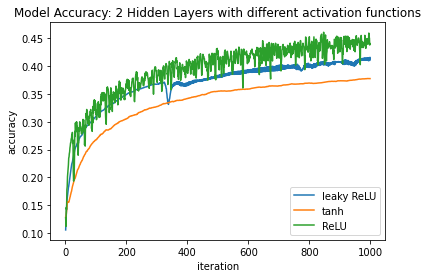

In [ ]:
# plot training history
fig = plt.plot(figsize=(12, 4))
iteration = list(range(1,1000))

# History for accuracy
plt.plot(iteration, acc_history_leaky, label = 'leaky ReLU')
plt.plot(iteration, acc_history_tanh, label = 'tanh')
plt.plot(iteration, acc_2_history, label = 'ReLU')
plt.title('Model Accuracy: 2 Hidden Layers with different activation functions')
plt.ylabel('accuracy')
plt.xlabel('iteration')
plt.legend()
plt.savefig("two_hidden_activations.png")

## Task3.3

### L2 regularization

In [ ]:
def objective(trial):
    # Define the search space for the hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    L2_lambda = trial.suggest_float("L2_lambda", 1e-6, 1e-2, log=True)

    # Create the MLP_2 model with the given hyperparameters
    model_2_hidden = MLP_2(M=[256, 256], n_hidden=2, L2_lambda=L2_lambda)
    optimizer = GradientDescent(learning_rate=learning_rate, max_iters=5)

    # Train the model and compute its validation accuracy
    yh_2_hidden = model_2_hidden.fit(train_images, train_labels, optimizer)
    val_acc = yh_2_hidden.acc_history[-1]

    return val_acc

# Define the search method and run the optimization process
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Print the best hyperparameters found by Optuna
print("Best hyperparameters: ", study.best_params)

[I 2023-03-09 02:52:17,043] A new study created in memory with name: no-name-66c63396-e79a-45f9-9bcd-6f3148448a0f


1
[[0.1559558  0.04170009 0.13741753 ... 0.10690511 0.09266127 0.0926088 ]
 [0.14616865 0.03507618 0.17205817 ... 0.09222479 0.1108024  0.07871703]
 [0.11775975 0.0315959  0.09203661 ... 0.10355726 0.08449877 0.10694638]
 ...
 [0.13351707 0.03279829 0.11307892 ... 0.07721154 0.10351648 0.08342142]
 [0.13899094 0.02686435 0.16671438 ... 0.08690193 0.06205974 0.07981665]
 [0.14785479 0.02891705 0.14737781 ... 0.10104489 0.07272228 0.09357923]]
acc: 0.0967


2
[[0.15501066 0.04273305 0.13615999 ... 0.10772242 0.09373766 0.09337914]
 [0.14541475 0.03617625 0.17060992 ... 0.09337048 0.11263996 0.07971999]
 [0.11745063 0.03289637 0.09125116 ... 0.10535206 0.08634586 0.10886682]
 ...
 [0.13305201 0.0337951  0.11204275 ... 0.07815153 0.10523293 0.08456608]
 [0.13857317 0.02817468 0.16495318 ... 0.08858596 0.06376611 0.08150747]
 [0.1472755  0.02995561 0.14602233 ... 0.1027319  0.07398193 0.09492244]]
acc: 0.0978


3
[[0.15407513 0.04375639 0.1349507  ... 0.10846546 0.09474978 0.09409283]
 [0.1

[I 2023-03-09 02:52:43,571] Trial 0 finished with value: 0.1003 and parameters: {'learning_rate': 0.0015705686863512333, 'L2_lambda': 0.0004899535634636036}. Best is trial 0 with value: 0.1003.


1
[[0.14400205 0.12116513 0.1182009  ... 0.12671668 0.09710505 0.06177642]
 [0.14155674 0.08583398 0.10562473 ... 0.18423872 0.09283341 0.06686035]
 [0.15754154 0.07466121 0.10655947 ... 0.16633375 0.07399909 0.05526344]
 ...
 [0.12266352 0.07015041 0.10301635 ... 0.19173654 0.05246293 0.07265925]
 [0.23577346 0.09600333 0.08385324 ... 0.14966887 0.08968194 0.05808095]
 [0.12318613 0.1067904  0.11868991 ... 0.18813902 0.06820654 0.0475318 ]]
acc: 0.1167


2
[[0.14391862 0.12117823 0.11821743 ... 0.12653635 0.09720501 0.06187226]
 [0.14150626 0.08585474 0.10565152 ... 0.1839278  0.0929596  0.0669718 ]
 [0.15749838 0.07470404 0.10658943 ... 0.16601106 0.07413888 0.05539081]
 ...
 [0.1226496  0.07017971 0.10303793 ... 0.19144952 0.05253969 0.07278548]
 [0.23568492 0.09606421 0.08389237 ... 0.14933332 0.08986611 0.05822693]
 [0.1231404  0.10685461 0.11873249 ... 0.18783007 0.06832212 0.0476257 ]]
acc: 0.1170


3
[[0.14383521 0.12119109 0.11823377 ... 0.12635703 0.09730453 0.06196786]
 [0.1

[I 2023-03-09 02:53:09,300] Trial 1 finished with value: 0.117 and parameters: {'learning_rate': 0.00013614449872119936, 'L2_lambda': 6.237852478085783e-05}. Best is trial 1 with value: 0.117.


1
[[0.09912092 0.07724237 0.09853212 ... 0.09087323 0.1253098  0.08706034]
 [0.09219191 0.09570804 0.0937299  ... 0.14289109 0.10784521 0.07603258]
 [0.06466359 0.08316552 0.11701339 ... 0.07852901 0.11257278 0.07379109]
 ...
 [0.05406035 0.11256766 0.12280182 ... 0.08794184 0.11097881 0.08446291]
 [0.07327042 0.10447385 0.10694819 ... 0.10866902 0.09828265 0.10381655]
 [0.0763583  0.11414294 0.09816636 ... 0.08634846 0.13686616 0.0842036 ]]
acc: 0.0906


2
[[0.12887059 0.08130188 0.09491158 ... 0.08783316 0.12062998 0.09778906]
 [0.14409935 0.10205796 0.09026481 ... 0.1321828  0.1063569  0.09832464]
 [0.11530241 0.09259493 0.11100374 ... 0.07652367 0.11902092 0.10376323]
 ...
 [0.08365985 0.12129806 0.11988438 ... 0.08102287 0.11804733 0.11214771]
 [0.12887422 0.10852961 0.09884902 ... 0.09480922 0.10965355 0.14785336]
 [0.11511906 0.11662046 0.09133202 ... 0.08232639 0.13585918 0.10953982]]
acc: 0.1097


3
[[0.11435552 0.07907389 0.09982338 ... 0.0879619  0.11304561 0.09235986]
 [0.1

[I 2023-03-09 02:53:34,710] Trial 2 finished with value: 0.1405 and parameters: {'learning_rate': 0.06266171397651721, 'L2_lambda': 3.4141474183563194e-05}. Best is trial 2 with value: 0.1405.


1
[[0.05671151 0.09504737 0.09392954 ... 0.16427676 0.12014485 0.0465922 ]
 [0.04384407 0.07929488 0.06913363 ... 0.0960219  0.09875613 0.03386967]
 [0.05922712 0.13140107 0.07703106 ... 0.10567036 0.12945308 0.06706494]
 ...
 [0.0467609  0.0901017  0.08932552 ... 0.09444036 0.14030077 0.06009685]
 [0.05288516 0.1190299  0.08191228 ... 0.10196917 0.10806385 0.03244846]
 [0.05311319 0.08604649 0.07998532 ... 0.09411375 0.12530421 0.06345277]]
acc: 0.0958


2
[[0.06380845 0.09934669 0.09613087 ... 0.16251935 0.12156492 0.05219375]
 [0.05257812 0.08362512 0.07340571 ... 0.0956451  0.10270933 0.04014456]
 [0.0699666  0.1364564  0.07890314 ... 0.10483347 0.1329912  0.08099471]
 ...
 [0.05429125 0.09278833 0.09316547 ... 0.09347007 0.14582966 0.07020756]
 [0.06746365 0.13025224 0.08812297 ... 0.10141228 0.11695229 0.04115179]
 [0.06306062 0.09030044 0.08316169 ... 0.09343439 0.12962196 0.07593945]]
acc: 0.0961


3
[[0.06988635 0.10130396 0.09762634 ... 0.15921675 0.1214284  0.05706092]
 [0.0

[I 2023-03-09 02:54:00,202] Trial 3 finished with value: 0.1192 and parameters: {'learning_rate': 0.011560495353772028, 'L2_lambda': 0.00012417370744414514}. Best is trial 2 with value: 0.1405.


1
[[0.17816361 0.07235718 0.34274741 ... 0.04973216 0.08504346 0.03003873]
 [0.1846237  0.06133321 0.31807299 ... 0.0531682  0.08250917 0.03064154]
 [0.21476269 0.04904608 0.34334112 ... 0.04697788 0.1144262  0.02261021]
 ...
 [0.16493219 0.05382715 0.29704573 ... 0.07335831 0.12784207 0.0306328 ]
 [0.19413467 0.04961457 0.41339347 ... 0.03048489 0.0951156  0.01318789]
 [0.1900105  0.05499519 0.32327712 ... 0.04242462 0.09635423 0.02136153]]
acc: 0.0994


2
[[0.17823963 0.07281003 0.34041471 ... 0.05003232 0.08526666 0.03027412]
 [0.18479565 0.06178913 0.31502376 ... 0.05352353 0.08275397 0.03096672]
 [0.21493371 0.04939069 0.34060357 ... 0.04732078 0.11493855 0.02286386]
 ...
 [0.16486515 0.05404837 0.29508905 ... 0.0737275  0.12820114 0.03087377]
 [0.19459885 0.05014169 0.40961457 ... 0.03084166 0.09575092 0.01339341]
 [0.19001668 0.05534294 0.32089142 ... 0.04268956 0.09663073 0.02156266]]
acc: 0.0994


3
[[0.17830372 0.07325786 0.33812229 ... 0.0503298  0.08548487 0.03050824]
 [0.1

[I 2023-03-09 02:54:26,203] Trial 4 finished with value: 0.0994 and parameters: {'learning_rate': 0.0002264556928037054, 'L2_lambda': 0.0001238910895280198}. Best is trial 2 with value: 0.1405.


1
[[0.10504085 0.09124631 0.14238443 ... 0.03620831 0.07964246 0.07188092]
 [0.10055806 0.09392165 0.16881832 ... 0.03562663 0.07786455 0.06943844]
 [0.07764113 0.11392503 0.16127477 ... 0.03257451 0.07468916 0.0637581 ]
 ...
 [0.09434734 0.11343624 0.1675991  ... 0.03517554 0.07573876 0.06877068]
 [0.09568268 0.09192178 0.19792312 ... 0.02787763 0.06810238 0.05711907]
 [0.1003647  0.128234   0.19094548 ... 0.03422049 0.08248573 0.06195048]]
acc: 0.1005


2
[[0.10504941 0.09124831 0.14235955 ... 0.03621658 0.07965074 0.07189024]
 [0.10056764 0.09392495 0.16878859 ... 0.03563603 0.07787803 0.06944975]
 [0.07765051 0.11392796 0.16124338 ... 0.03258366 0.07470264 0.06377234]
 ...
 [0.09435621 0.11343879 0.16757382 ... 0.03518279 0.07575011 0.06878269]
 [0.09569918 0.09192991 0.19787226 ... 0.0278881  0.06812081 0.05713619]
 [0.10037372 0.128235   0.19091091 ... 0.03422902 0.0824961  0.06196026]]
acc: 0.1005


3
[[0.10505797 0.09125031 0.14233468 ... 0.03622484 0.07965901 0.07189955]
 [0.1

[I 2023-03-09 02:54:52,761] Trial 5 finished with value: 0.1005 and parameters: {'learning_rate': 1.7106007056056103e-05, 'L2_lambda': 2.597913087399298e-06}. Best is trial 2 with value: 0.1405.


1
[[0.06945697 0.09462168 0.04034086 ... 0.11580388 0.10051272 0.12953379]
 [0.05540626 0.05910756 0.02755278 ... 0.1362747  0.10498841 0.15715554]
 [0.03981331 0.06169711 0.02320764 ... 0.11572789 0.07146558 0.12642274]
 ...
 [0.06208716 0.05361625 0.03017367 ... 0.11999413 0.07237491 0.09672657]
 [0.04043569 0.08930276 0.01345546 ... 0.11193958 0.085012   0.13223402]
 [0.0546297  0.06883455 0.02366978 ... 0.1244168  0.08896577 0.14658939]]
acc: 0.0858


2
[[0.07028374 0.09493879 0.04105376 ... 0.11552918 0.10095229 0.12961401]
 [0.05631263 0.05950754 0.02815974 ... 0.1359824  0.10588541 0.1575298 ]
 [0.04068788 0.06227992 0.02377788 ... 0.11547874 0.07228383 0.12727872]
 ...
 [0.06324133 0.05404048 0.03079381 ... 0.11992972 0.0731888  0.09719386]
 [0.04142404 0.09016562 0.01384865 ... 0.1116915  0.08610661 0.13296267]
 [0.05563653 0.06932039 0.02423207 ... 0.12427297 0.08968538 0.14710016]]
acc: 0.0842


3
[[0.07110012 0.09523966 0.0417695  ... 0.11525368 0.10137131 0.12966871]
 [0.0

[I 2023-03-09 02:55:18,040] Trial 6 finished with value: 0.0829 and parameters: {'learning_rate': 0.001044037171036049, 'L2_lambda': 6.97798931634478e-05}. Best is trial 2 with value: 0.1405.


1
[[0.16269938 0.0584046  0.15944227 ... 0.13081857 0.12439008 0.09427134]
 [0.1400233  0.07492338 0.2196939  ... 0.1494     0.10142555 0.0890085 ]
 [0.13738984 0.07872282 0.19191286 ... 0.10414844 0.12136236 0.09103826]
 ...
 [0.13055615 0.09224425 0.17047035 ... 0.11485441 0.12440246 0.08821335]
 [0.16982285 0.0643612  0.23335752 ... 0.09719633 0.12788827 0.08119679]
 [0.15495893 0.10260892 0.17005012 ... 0.15197281 0.07198534 0.0836514 ]]
acc: 0.0971


2
[[0.15242239 0.06070742 0.13827122 ... 0.13137142 0.12656306 0.09721934]
 [0.12910536 0.08061216 0.18716878 ... 0.15085048 0.10557133 0.09443427]
 [0.12645745 0.08535018 0.15970917 ... 0.10560286 0.127286   0.0967194 ]
 ...
 [0.12304057 0.0978166  0.14459673 ... 0.11683535 0.12889403 0.09282686]
 [0.15481847 0.06964123 0.18598531 ... 0.10218669 0.14032757 0.0897933 ]
 [0.14010073 0.10901269 0.14162922 ... 0.15344936 0.07587976 0.08850018]]
acc: 0.1133


3
[[0.14516448 0.06243083 0.12700606 ... 0.12851445 0.12597235 0.09843042]
 [0.1

[I 2023-03-09 02:55:43,066] Trial 7 finished with value: 0.1319 and parameters: {'learning_rate': 0.01569377599631102, 'L2_lambda': 2.204892695006582e-06}. Best is trial 2 with value: 0.1405.


1
[[0.05950577 0.13068221 0.10702546 ... 0.10316291 0.11139597 0.20332508]
 [0.0473456  0.09701993 0.13272739 ... 0.09586137 0.10388215 0.27232374]
 [0.05613709 0.11411353 0.15757752 ... 0.07383958 0.07615652 0.20883938]
 ...
 [0.06811866 0.11699514 0.12248341 ... 0.08994713 0.06929208 0.17267739]
 [0.03953    0.10968215 0.12892986 ... 0.09140871 0.10646479 0.23055028]
 [0.03703013 0.12957185 0.12507416 ... 0.09549697 0.10097719 0.18989111]]
acc: 0.0994


2
[[0.0599969  0.13055899 0.10659873 ... 0.103439   0.11186237 0.20100394]
 [0.04794319 0.09711879 0.13219708 ... 0.09636714 0.10462796 0.26871729]
 [0.0568259  0.11399215 0.15669499 ... 0.0741914  0.0766723  0.20621897]
 ...
 [0.06874712 0.11684487 0.12186184 ... 0.09014192 0.06958645 0.17082939]
 [0.04014148 0.10951242 0.12813027 ... 0.09186607 0.10746995 0.22671434]
 [0.03746659 0.12940666 0.12439378 ... 0.09597898 0.1016076  0.18706699]]
acc: 0.0998


3
[[0.06048165 0.13042433 0.10617687 ... 0.10370119 0.11231194 0.19876394]
 [0.0

[I 2023-03-09 02:56:08,898] Trial 8 finished with value: 0.0998 and parameters: {'learning_rate': 0.0007193187538808097, 'L2_lambda': 3.61422616479074e-06}. Best is trial 2 with value: 0.1405.


1
[[0.09019901 0.08361252 0.16788174 ... 0.16483409 0.05434207 0.04770378]
 [0.10585741 0.06231836 0.15634113 ... 0.1681031  0.06162151 0.04857916]
 [0.09930264 0.06502264 0.18319619 ... 0.20386629 0.02864435 0.06323097]
 ...
 [0.0915201  0.07450753 0.17891814 ... 0.17037896 0.04774494 0.05382807]
 [0.07085867 0.06357276 0.19528754 ... 0.25109789 0.03245328 0.05043166]
 [0.06893783 0.10102122 0.181481   ... 0.15672347 0.02884987 0.06652245]]
acc: 0.0959


2
[[0.0902052  0.08362049 0.16785794 ... 0.16481333 0.05435204 0.04771094]
 [0.10586517 0.06232434 0.15631582 ... 0.16807703 0.06163689 0.04858889]
 [0.09931944 0.06503205 0.18316603 ... 0.20382744 0.02865258 0.06324651]
 ...
 [0.09152899 0.07451575 0.17889391 ... 0.17035333 0.04775509 0.05383628]
 [0.07087068 0.06358224 0.19525747 ... 0.25105734 0.03246519 0.05044642]
 [0.06894442 0.10103524 0.18144838 ... 0.15669805 0.02885694 0.06653657]]
acc: 0.0959


3
[[0.09021139 0.08362845 0.16783415 ... 0.16479257 0.054362   0.0477181 ]
 [0.1

[I 2023-03-09 02:56:34,411] Trial 9 finished with value: 0.0959 and parameters: {'learning_rate': 1.4642651549051192e-05, 'L2_lambda': 1.2269605108965018e-06}. Best is trial 2 with value: 0.1405.


1
[[0.14660985 0.07745133 0.08180357 ... 0.06144001 0.12635461 0.0975825 ]
 [0.1439665  0.12400863 0.055823   ... 0.04366675 0.15326812 0.09137446]
 [0.11058576 0.06886318 0.08125196 ... 0.06571269 0.14769924 0.11052257]
 ...
 [0.12469481 0.11332249 0.04966115 ... 0.05774167 0.12011893 0.09937194]
 [0.13043599 0.09221529 0.06603146 ... 0.07559436 0.12677343 0.06839278]
 [0.12317404 0.07412434 0.07979721 ... 0.05594399 0.14808232 0.13634769]]
acc: 0.0980


2
[[0.0881144  0.10551935 0.12071321 ... 0.0945031  0.10141937 0.10795703]
 [0.07885005 0.18397421 0.08936671 ... 0.07232395 0.12346084 0.10749306]
 [0.0675706  0.09599021 0.12992997 ... 0.10219034 0.11452204 0.14410126]
 ...
 [0.09113267 0.15274501 0.07270882 ... 0.08247404 0.10749765 0.12089897]
 [0.06549703 0.14369343 0.11874533 ... 0.13242245 0.09186013 0.08561918]
 [0.06840224 0.1038581  0.13630964 ... 0.09338807 0.11196358 0.1580198 ]]
acc: 0.1116


3
[[0.16176194 0.08820379 0.09094184 ... 0.07150095 0.10891186 0.07931963]
 [0.1

[I 2023-03-09 02:56:59,883] Trial 10 finished with value: 0.14 and parameters: {'learning_rate': 0.08635791742572431, 'L2_lambda': 0.007164331071255105}. Best is trial 2 with value: 0.1405.


1
[[0.07795268 0.09875618 0.15210217 ... 0.07924124 0.09526909 0.0824606 ]
 [0.13069027 0.09606115 0.16782799 ... 0.08365231 0.09059499 0.04878096]
 [0.0941335  0.1181752  0.18173068 ... 0.05485379 0.07847031 0.05225214]
 ...
 [0.09259241 0.0898449  0.18134986 ... 0.08315603 0.11474112 0.07100554]
 [0.11426648 0.06882368 0.13989914 ... 0.05639229 0.11301595 0.04771899]
 [0.10409425 0.11316592 0.18098082 ... 0.06691957 0.07581295 0.05736665]]
acc: 0.0924


2
[[0.12368204 0.0828689  0.04217085 ... 0.15828525 0.07162559 0.1744532 ]
 [0.21637569 0.07908598 0.02667891 ... 0.19556981 0.06052574 0.1289164 ]
 [0.15680394 0.10158212 0.03119135 ... 0.15159838 0.06462584 0.17086192]
 ...
 [0.14974584 0.08770412 0.04322522 ... 0.14452289 0.09608018 0.1688222 ]
 [0.23488126 0.04851748 0.01570253 ... 0.15432259 0.07559296 0.17777086]
 [0.18026204 0.08311837 0.03537169 ... 0.14837069 0.05656881 0.16007338]]
acc: 0.1236


3
[[0.05071496 0.09323006 0.09386398 ... 0.06860031 0.16607633 0.06737806]
 [0.0

[I 2023-03-09 02:57:25,857] Trial 11 finished with value: 0.1415 and parameters: {'learning_rate': 0.09795351751236489, 'L2_lambda': 0.004056711734215065}. Best is trial 11 with value: 0.1415.


1
[[0.07304146 0.18793696 0.03979336 ... 0.04686506 0.06027229 0.12181312]
 [0.06497622 0.24825413 0.06245147 ... 0.02968944 0.06339619 0.0967987 ]
 [0.06573488 0.21829723 0.11226377 ... 0.04181848 0.03844118 0.13589789]
 ...
 [0.08556541 0.16596595 0.15428526 ... 0.03499706 0.04778745 0.10820248]
 [0.04583844 0.28666177 0.07039963 ... 0.02906662 0.03961662 0.1099378 ]
 [0.06123625 0.25494413 0.07692928 ... 0.05174216 0.03801291 0.09958594]]
acc: 0.1140


2
[[0.13447756 0.06059673 0.07624871 ... 0.08423791 0.1210238  0.0997529 ]
 [0.12993765 0.06955046 0.12383628 ... 0.05986525 0.16339789 0.08469398]
 [0.1289557  0.05631497 0.19308973 ... 0.07997798 0.13407324 0.12748999]
 ...
 [0.13035905 0.05517328 0.24022765 ... 0.05390095 0.10676686 0.10197099]
 [0.11329195 0.05301243 0.1789105  ... 0.07361651 0.16585011 0.11054964]
 [0.12036841 0.05569084 0.15815284 ... 0.10846918 0.1166173  0.09923033]]
acc: 0.1018


3
[[0.11225847 0.09429355 0.05466864 ... 0.09856751 0.09013377 0.10552338]
 [0.1

[I 2023-03-09 02:57:51,021] Trial 12 finished with value: 0.1676 and parameters: {'learning_rate': 0.06950045819104979, 'L2_lambda': 0.007882374195898705}. Best is trial 12 with value: 0.1676.


1
[[0.08851723 0.21797639 0.06660003 ... 0.08727189 0.08324814 0.11177934]
 [0.10040876 0.24802405 0.04315565 ... 0.07189823 0.07171853 0.08821961]
 [0.08958714 0.19562247 0.03444355 ... 0.04478234 0.08493795 0.10440574]
 ...
 [0.10772536 0.1288162  0.04817    ... 0.04984544 0.05750153 0.10802111]
 [0.148498   0.16079025 0.03076725 ... 0.05716888 0.09298134 0.08174049]
 [0.11008745 0.1686898  0.0421659  ... 0.06674808 0.1041689  0.09241744]]
acc: 0.1113


2
[[0.09236193 0.08445392 0.12776594 ... 0.12652151 0.11188761 0.12124266]
 [0.12063481 0.08481046 0.10254835 ... 0.11160347 0.13140024 0.09618728]
 [0.11494003 0.06353501 0.08200273 ... 0.06598727 0.18172081 0.13601368]
 ...
 [0.12409522 0.05886083 0.09871206 ... 0.06562772 0.10853438 0.13651869]
 [0.18421188 0.03176684 0.09216228 ... 0.08591162 0.21730427 0.09132094]
 [0.1273702  0.05795284 0.0916076  ... 0.10717927 0.16477186 0.10848154]]
acc: 0.1209


3
[[0.07135965 0.14701713 0.14208501 ... 0.1091379  0.06267832 0.10836468]
 [0.0

[I 2023-03-09 02:58:18,326] Trial 13 finished with value: 0.1496 and parameters: {'learning_rate': 0.09575566834663198, 'L2_lambda': 0.008513449400749579}. Best is trial 12 with value: 0.1676.


1
[[0.06678753 0.06293369 0.09377314 ... 0.0631201  0.08770168 0.09923595]
 [0.05260525 0.05439934 0.06264176 ... 0.05927875 0.08187018 0.11259767]
 [0.08926439 0.06815351 0.06773765 ... 0.05428547 0.05671316 0.09209795]
 ...
 [0.08957485 0.05039844 0.0589592  ... 0.04528605 0.07204402 0.10810788]
 [0.05870065 0.06720683 0.06243357 ... 0.05550963 0.06849826 0.09640784]
 [0.053787   0.05681937 0.08155691 ... 0.06093676 0.06170834 0.10113806]]
acc: 0.0999


2
[[0.09213069 0.0763138  0.10429326 ... 0.07974858 0.11060363 0.11138462]
 [0.07868985 0.06782619 0.07236755 ... 0.0788396  0.11054707 0.12904703]
 [0.13067868 0.08903585 0.08004891 ... 0.07574924 0.08027387 0.1111447 ]
 ...
 [0.12211867 0.06692076 0.06962421 ... 0.06071356 0.09388043 0.12437514]
 [0.10251855 0.09565092 0.07874676 ... 0.08055769 0.10570452 0.1227475 ]
 [0.08442654 0.07444542 0.09682021 ... 0.08421789 0.08336347 0.12796125]]
acc: 0.1020


3
[[0.09978097 0.08046473 0.10714916 ... 0.08419846 0.11535904 0.1074009 ]
 [0.0

[I 2023-03-09 02:58:44,371] Trial 14 finished with value: 0.1288 and parameters: {'learning_rate': 0.017423495543045484, 'L2_lambda': 0.002988844378798869}. Best is trial 12 with value: 0.1676.


1
[[0.06477721 0.15261931 0.10449763 ... 0.12695194 0.06858498 0.11006369]
 [0.07044683 0.19319932 0.09574558 ... 0.11299015 0.05368872 0.13398288]
 [0.06413098 0.20938469 0.07364992 ... 0.1480124  0.07300318 0.09643394]
 ...
 [0.05403432 0.19110475 0.07099251 ... 0.15382932 0.1161902  0.08076114]
 [0.05905113 0.26327687 0.0652535  ... 0.13869834 0.04370133 0.1310249 ]
 [0.06938861 0.17268482 0.08442807 ... 0.17312472 0.06206146 0.09755808]]
acc: 0.1032


2
[[0.06704794 0.14190456 0.10660419 ... 0.12514866 0.07234539 0.11062277]
 [0.07457159 0.17708911 0.09762894 ... 0.11007821 0.05832358 0.13606162]
 [0.06894086 0.19170197 0.07603144 ... 0.14253621 0.08010835 0.10063643]
 ...
 [0.05614693 0.17793979 0.07219198 ... 0.14960262 0.12430073 0.0833452 ]
 [0.06443009 0.23649854 0.06913025 ... 0.13555371 0.04931262 0.13691259]
 [0.07373126 0.15801158 0.08656182 ... 0.16855557 0.06735113 0.10047737]]
acc: 0.1046


3
[[0.06895605 0.13372252 0.10797653 ... 0.12327816 0.07563797 0.1108872 ]
 [0.0

[I 2023-03-09 02:59:10,064] Trial 15 finished with value: 0.104 and parameters: {'learning_rate': 0.0056497679162382675, 'L2_lambda': 0.009542649868638224}. Best is trial 12 with value: 0.1676.


1
[[0.14377668 0.06570061 0.07634988 ... 0.14872685 0.08380075 0.06042248]
 [0.1319933  0.05980878 0.09147113 ... 0.18211912 0.08591131 0.06488041]
 [0.14014102 0.06361187 0.05234658 ... 0.21230005 0.07271589 0.04754737]
 ...
 [0.10869919 0.04122732 0.10056224 ... 0.21365837 0.06000987 0.07367409]
 [0.11791416 0.0389704  0.06698646 ... 0.21394349 0.07230685 0.05426039]
 [0.14207115 0.05122374 0.06741099 ... 0.18227253 0.07881453 0.05407037]]
acc: 0.1007


2
[[0.13455632 0.09006523 0.0941232  ... 0.09947792 0.10329749 0.07714915]
 [0.12573946 0.0893987  0.11514839 ... 0.10807568 0.11775743 0.08999248]
 [0.14241105 0.09801447 0.06677016 ... 0.12852249 0.11129936 0.07505035]
 ...
 [0.11263951 0.05884294 0.12171124 ... 0.14360747 0.082258   0.10529598]
 [0.11930306 0.07008917 0.09509023 ... 0.11699062 0.12236296 0.08701144]
 [0.13592238 0.07445379 0.09143797 ... 0.11136459 0.10895254 0.07966297]]
acc: 0.1092


3
[[0.12885356 0.09866323 0.09831084 ... 0.0975047  0.10291328 0.0808492 ]
 [0.1

[I 2023-03-09 02:59:35,942] Trial 16 finished with value: 0.1306 and parameters: {'learning_rate': 0.036053223926951566, 'L2_lambda': 0.0013564241683924985}. Best is trial 12 with value: 0.1676.


1
[[0.12106666 0.11070287 0.03573542 ... 0.15110002 0.08363523 0.08111123]
 [0.14017121 0.13865489 0.03779752 ... 0.10593626 0.04985901 0.0936119 ]
 [0.18405573 0.10705357 0.03293598 ... 0.11802219 0.09044178 0.10493619]
 ...
 [0.13823004 0.10568111 0.0507426  ... 0.09908021 0.08825816 0.12042654]
 [0.21280735 0.10517926 0.01937166 ... 0.13175745 0.0489199  0.07845217]
 [0.16245037 0.11115428 0.02600538 ... 0.1166549  0.07579183 0.06399179]]
acc: 0.1131


2
[[0.10818828 0.11330084 0.05671051 ... 0.12481779 0.10097228 0.09830214]
 [0.1235122  0.14181623 0.06703986 ... 0.08489317 0.06649042 0.12151047]
 [0.15119072 0.10876327 0.05908599 ... 0.08964238 0.12312905 0.13841755]
 ...
 [0.1169983  0.10522225 0.08157965 ... 0.07836544 0.11240632 0.15040982]
 [0.18485578 0.11932096 0.0440055  ... 0.09941123 0.07748008 0.11916456]
 [0.14470543 0.12341612 0.04908012 ... 0.08851919 0.10011417 0.08317982]]
acc: 0.1356


3
[[0.10388318 0.11051762 0.0704553  ... 0.11853932 0.10613157 0.09890409]
 [0.1

[I 2023-03-09 03:00:01,451] Trial 17 finished with value: 0.1407 and parameters: {'learning_rate': 0.03076162843910296, 'L2_lambda': 0.0018218422834416765}. Best is trial 12 with value: 0.1676.


1
[[0.09165039 0.07490484 0.05721192 ... 0.06605846 0.1337198  0.12628246]
 [0.07337976 0.07608366 0.05581725 ... 0.05521867 0.13861923 0.21030781]
 [0.06166955 0.07556146 0.13264007 ... 0.04301139 0.14427166 0.17129873]
 ...
 [0.0691812  0.07563974 0.07040243 ... 0.04792778 0.12244925 0.10653565]
 [0.08010939 0.07440097 0.07770703 ... 0.03672114 0.16894783 0.18847066]
 [0.08629169 0.04806174 0.10485841 ... 0.05661849 0.16505574 0.18044555]]
acc: 0.0948


2
[[0.09573415 0.0789572  0.05947763 ... 0.0693022  0.12520612 0.12097028]
 [0.07959923 0.0814468  0.05959945 ... 0.05914124 0.12977645 0.20085443]
 [0.0670405  0.08100548 0.14148617 ... 0.04659281 0.13417571 0.16438752]
 ...
 [0.07408423 0.08036157 0.07460346 ... 0.05111242 0.11520657 0.10258307]
 [0.08886753 0.08119341 0.0843608  ... 0.04060055 0.15388018 0.17962337]
 [0.09332594 0.05148411 0.1112913  ... 0.06135264 0.15247372 0.17204535]]
acc: 0.0948


3
[[0.09905946 0.08235689 0.06114585 ... 0.07226852 0.11896197 0.11637314]
 [0.0

[I 2023-03-09 03:00:27,408] Trial 18 finished with value: 0.0992 and parameters: {'learning_rate': 0.006641966975880111, 'L2_lambda': 0.009111945723754155}. Best is trial 12 with value: 0.1676.


1
[[0.05555345 0.07245317 0.08134631 ... 0.22746445 0.09657484 0.06837042]
 [0.04424803 0.05367382 0.11729403 ... 0.22991903 0.09114453 0.07509162]
 [0.05720097 0.04388853 0.07934028 ... 0.28510755 0.08378953 0.07003331]
 ...
 [0.05034667 0.05729866 0.08761559 ... 0.30632354 0.07590149 0.05287606]
 [0.03455304 0.03870119 0.07539585 ... 0.35127662 0.0796085  0.04810334]
 [0.06832704 0.06103283 0.06116586 ... 0.21707243 0.10195566 0.06397435]]
acc: 0.1024


2
[[0.0950268  0.09068529 0.09792664 ... 0.1000607  0.11261561 0.09182022]
 [0.0824444  0.08320033 0.1416238  ... 0.08050324 0.1153431  0.10518031]
 [0.12600033 0.06956118 0.10351097 ... 0.092306   0.13060639 0.09958635]
 ...
 [0.10319714 0.08964191 0.1078401  ... 0.12308757 0.10862202 0.07566447]
 [0.10640253 0.07286827 0.11631842 ... 0.09096318 0.14159915 0.0749725 ]
 [0.13583117 0.08560932 0.07813591 ... 0.06829051 0.14626057 0.08898903]]
acc: 0.1138


3
[[0.09943062 0.09362567 0.09338389 ... 0.10819859 0.105453   0.09177021]
 [0.0

[I 2023-03-09 03:00:52,154] Trial 19 finished with value: 0.1358 and parameters: {'learning_rate': 0.04126172722134249, 'L2_lambda': 0.0008696404163823468}. Best is trial 12 with value: 0.1676.


1
[[0.08445712 0.08919561 0.03387204 ... 0.25953854 0.07126598 0.07084603]
 [0.07469925 0.10412842 0.03015681 ... 0.3000809  0.06329231 0.06553407]
 [0.0636258  0.08831243 0.03198588 ... 0.19563897 0.06043006 0.03425529]
 ...
 [0.08491735 0.10766875 0.04052518 ... 0.19410636 0.07410917 0.03737092]
 [0.06346718 0.08121709 0.02641708 ... 0.29074183 0.05089809 0.04087437]
 [0.0642333  0.08814265 0.04919463 ... 0.27057695 0.05885182 0.05062811]]
acc: 0.0995


2
[[0.16782485 0.08402103 0.07540729 ... 0.02617276 0.20261502 0.16348335]
 [0.18267512 0.08041504 0.06977288 ... 0.01411498 0.23514903 0.19344351]
 [0.18788457 0.09393431 0.07762735 ... 0.00915796 0.24344845 0.12884362]
 ...
 [0.19884645 0.10861811 0.07877739 ... 0.02066345 0.20835013 0.10387319]
 [0.2092544  0.06978117 0.0725969  ... 0.00602463 0.24892865 0.18425327]
 [0.16172658 0.07384206 0.11037518 ... 0.01574605 0.20110463 0.18178457]]
acc: 0.1065


3
[[0.09527003 0.09436433 0.11499041 ... 0.08996964 0.06909856 0.08461528]
 [0.1

[I 2023-03-09 03:01:17,259] Trial 20 finished with value: 0.1539 and parameters: {'learning_rate': 0.09049331977370527, 'L2_lambda': 0.0029824311410141624}. Best is trial 12 with value: 0.1676.


1
[[0.12259777 0.12420289 0.05672763 ... 0.07762902 0.07638678 0.23626845]
 [0.10971417 0.13448581 0.04459476 ... 0.08430745 0.05612766 0.23863318]
 [0.11933103 0.10868985 0.05779038 ... 0.15741616 0.0572695  0.16830414]
 ...
 [0.11306728 0.11555306 0.06102791 ... 0.13450398 0.05617605 0.1908688 ]
 [0.1032415  0.13222788 0.03703021 ... 0.11401232 0.04922765 0.26391439]
 [0.10098944 0.13261914 0.04628612 ... 0.11845217 0.0464622  0.22470272]]
acc: 0.0996


2
[[0.12481979 0.06275883 0.11888579 ... 0.07433219 0.21833421 0.03060546]
 [0.12341133 0.06338059 0.09167249 ... 0.07014881 0.26395871 0.01969294]
 [0.10462763 0.04438818 0.11213859 ... 0.11214506 0.26674297 0.01272524]
 ...
 [0.10966467 0.06646952 0.11395777 ... 0.12291855 0.18878625 0.03018773]
 [0.09988398 0.04329419 0.10217253 ... 0.08310882 0.3040103  0.01165147]
 [0.10497045 0.05910011 0.09968028 ... 0.10412946 0.18587105 0.0211497 ]]
acc: 0.0990


3
[[0.14647109 0.13130145 0.12030947 ... 0.07719539 0.02522646 0.1043273 ]
 [0.1

[I 2023-03-09 03:01:43,996] Trial 21 finished with value: 0.1399 and parameters: {'learning_rate': 0.09788279410725134, 'L2_lambda': 0.003959453363343354}. Best is trial 12 with value: 0.1676.


1
[[0.19426526 0.06675351 0.09270211 ... 0.10784803 0.0942241  0.10740586]
 [0.22037177 0.06324359 0.07388674 ... 0.09080529 0.08465811 0.10712544]
 [0.17140179 0.08397421 0.05947931 ... 0.05494873 0.13808873 0.08289683]
 ...
 [0.17517356 0.08715003 0.06641018 ... 0.08345765 0.12769327 0.0805205 ]
 [0.19751963 0.05775388 0.06456152 ... 0.07379789 0.10241481 0.10274175]
 [0.22551308 0.06382741 0.05999383 ... 0.0897828  0.1398185  0.08237925]]
acc: 0.0843


2
[[0.14422789 0.08017367 0.11075905 ... 0.12480197 0.09992239 0.11466156]
 [0.16752319 0.08728067 0.09045231 ... 0.11308024 0.10374233 0.11858159]
 [0.12518648 0.11575913 0.08102006 ... 0.07444902 0.17928015 0.10269867]
 ...
 [0.13364566 0.11166285 0.07994715 ... 0.09468043 0.14727557 0.09157415]
 [0.13742367 0.08936407 0.08378827 ... 0.09907088 0.1390179  0.12764966]
 [0.16016234 0.09092478 0.0820728  ... 0.11715736 0.15856301 0.09438333]]
acc: 0.0974


3
[[0.12798764 0.08435334 0.11521809 ... 0.12617553 0.09321026 0.11206743]
 [0.1

[I 2023-03-09 03:02:08,913] Trial 22 finished with value: 0.1202 and parameters: {'learning_rate': 0.031906514049123924, 'L2_lambda': 0.0032443115824774948}. Best is trial 12 with value: 0.1676.


1
[[0.06453377 0.21098586 0.0634537  ... 0.06627941 0.09370237 0.07098885]
 [0.07494857 0.18603863 0.05835701 ... 0.06279167 0.06949463 0.06794731]
 [0.04767417 0.29176943 0.06138177 ... 0.05849021 0.12299438 0.06642699]
 ...
 [0.09218753 0.22118607 0.07688038 ... 0.06724772 0.11219918 0.07297404]
 [0.05201062 0.28745506 0.04253079 ... 0.04453251 0.08702961 0.05662581]
 [0.05137304 0.23536266 0.04739729 ... 0.07286953 0.08934579 0.05387781]]
acc: 0.0980


2
[[0.10035012 0.08107273 0.09233519 ... 0.08498496 0.11173005 0.10910405]
 [0.12951583 0.05234053 0.09282911 ... 0.08463413 0.09314686 0.12671953]
 [0.08923332 0.08599561 0.10728217 ... 0.0872005  0.16993787 0.13648942]
 ...
 [0.14244636 0.07266466 0.11107795 ... 0.08394066 0.13768499 0.13214788]
 [0.11721585 0.0537988  0.09194793 ... 0.0687097  0.14402592 0.14357544]
 [0.09916876 0.06775044 0.08902584 ... 0.09930788 0.11610042 0.09373242]]
acc: 0.1381


3
[[0.09888195 0.09813905 0.08985771 ... 0.08527719 0.10411636 0.10780529]
 [0.1

[I 2023-03-09 03:02:34,282] Trial 23 finished with value: 0.1632 and parameters: {'learning_rate': 0.044552142978680966, 'L2_lambda': 0.009802925297745586}. Best is trial 12 with value: 0.1676.


1
[[0.04962011 0.13397962 0.08677075 ... 0.15810058 0.13134718 0.08871105]
 [0.05020062 0.11916602 0.08730039 ... 0.2052846  0.13915012 0.10379221]
 [0.04202433 0.12830961 0.07831065 ... 0.19877009 0.13268235 0.08293051]
 ...
 [0.05841587 0.10678323 0.09062653 ... 0.18221136 0.14847936 0.08689908]
 [0.0319039  0.12409574 0.08457322 ... 0.20198154 0.13526664 0.11584583]
 [0.04721926 0.15236818 0.06877751 ... 0.19548395 0.14712226 0.09380899]]
acc: 0.1049


2
[[0.06503183 0.12079916 0.1016579  ... 0.11407011 0.11080857 0.09344439]
 [0.07607117 0.10406112 0.10702861 ... 0.12981354 0.12638625 0.11544311]
 [0.06257345 0.115187   0.09603124 ... 0.12832018 0.11964138 0.09520602]
 ...
 [0.08085908 0.09929352 0.10617414 ... 0.12458054 0.14024563 0.09836299]
 [0.05511084 0.10618552 0.11174925 ... 0.11467888 0.12001462 0.13699621]
 [0.07143251 0.1407594  0.08622566 ... 0.12564865 0.13142184 0.10829615]]
acc: 0.1166


3
[[0.07725115 0.11457449 0.10251454 ... 0.10865377 0.10042552 0.0908889 ]
 [0.0

[I 2023-03-09 03:02:58,784] Trial 24 finished with value: 0.1441 and parameters: {'learning_rate': 0.03286577613320913, 'L2_lambda': 0.0006560518916686362}. Best is trial 12 with value: 0.1676.


1
[[0.06067554 0.11400198 0.09864743 ... 0.063293   0.1874285  0.05600096]
 [0.08239483 0.10257234 0.10232507 ... 0.02956409 0.27281661 0.07292712]
 [0.0618967  0.09778857 0.13669361 ... 0.02472939 0.21177055 0.11834922]
 ...
 [0.08191137 0.09023042 0.12046373 ... 0.04430659 0.18204056 0.09415071]
 [0.04375461 0.08277656 0.15418209 ... 0.02615559 0.2191566  0.0865734 ]
 [0.06540465 0.10703454 0.15609475 ... 0.03218285 0.21549927 0.08265789]]
acc: 0.1009


2
[[0.06492511 0.1100108  0.0991259  ... 0.07020424 0.1675541  0.05930071]
 [0.09204916 0.09974568 0.10419768 ... 0.03375986 0.23967106 0.079833  ]
 [0.06909011 0.09510244 0.1364319  ... 0.02853902 0.18236335 0.13068876]
 ...
 [0.08806475 0.08809148 0.12002049 ... 0.04869461 0.16245392 0.10103066]
 [0.05012079 0.07929418 0.15769992 ... 0.03099697 0.18290128 0.09745408]
 [0.07257277 0.10340214 0.15996652 ... 0.03677576 0.18436644 0.08991399]]
acc: 0.1027


3
[[0.06845469 0.10643663 0.09854223 ... 0.07651927 0.1545199  0.06176249]
 [0.1

[I 2023-03-09 03:03:23,938] Trial 25 finished with value: 0.1082 and parameters: {'learning_rate': 0.008092270278365182, 'L2_lambda': 0.004604904498997131}. Best is trial 12 with value: 0.1676.


1
[[0.10115789 0.06283652 0.11727492 ... 0.07389697 0.24227586 0.09892205]
 [0.10465059 0.05335261 0.14703605 ... 0.04980028 0.18928866 0.14984518]
 [0.08109103 0.06525184 0.0711818  ... 0.05035159 0.26609986 0.17659288]
 ...
 [0.10194071 0.06160611 0.08899189 ... 0.05523638 0.25171634 0.14177276]
 [0.12072425 0.05501371 0.06764601 ... 0.05138803 0.23953971 0.13500151]
 [0.09054221 0.0791682  0.07922765 ... 0.06297476 0.2818344  0.1131831 ]]
acc: 0.1011


2
[[0.11006557 0.06976082 0.11660778 ... 0.09092659 0.17072854 0.08710429]
 [0.1148903  0.06273234 0.1480947  ... 0.06232079 0.12331155 0.12845957]
 [0.10165246 0.08192949 0.07607243 ... 0.07206822 0.17362763 0.15998212]
 ...
 [0.11628142 0.072154   0.09305038 ... 0.06914633 0.18029462 0.13109483]
 [0.14789029 0.06832201 0.07061239 ... 0.07345143 0.14397763 0.11086474]
 [0.10784407 0.09358347 0.0815947  ... 0.08734032 0.18041363 0.09709546]]
acc: 0.1044


3
[[0.1081667  0.07332476 0.11369916 ... 0.09888768 0.15162112 0.08076867]
 [0.1

[I 2023-03-09 03:03:49,285] Trial 26 finished with value: 0.1312 and parameters: {'learning_rate': 0.023239831046515405, 'L2_lambda': 0.0016879023721011678}. Best is trial 12 with value: 0.1676.


1
[[0.05625704 0.09143084 0.19613758 ... 0.14523269 0.14462551 0.05339831]
 [0.0433046  0.08311063 0.15477658 ... 0.13154442 0.25376433 0.06112946]
 [0.03916825 0.11510084 0.11876213 ... 0.19359638 0.19407032 0.05104017]
 ...
 [0.04435867 0.09646867 0.11132476 ... 0.16084452 0.20553941 0.08741158]
 [0.03074849 0.07355359 0.20537287 ... 0.12718012 0.25770149 0.04763192]
 [0.05666615 0.07958312 0.17371081 ... 0.11501876 0.20999736 0.05727778]]
acc: 0.1194


2
[[0.10146114 0.12912057 0.12814614 ... 0.11177259 0.07746254 0.07258264]
 [0.10533913 0.14379915 0.09153734 ... 0.09117334 0.12366172 0.09375045]
 [0.0965206  0.19198427 0.06831573 ... 0.13461178 0.08890203 0.08151369]
 ...
 [0.08920212 0.1483382  0.07429234 ... 0.11032546 0.11757016 0.11976109]
 [0.11007021 0.14663711 0.1029225  ... 0.08519999 0.09829766 0.09158225]
 [0.15049623 0.1261594  0.09457753 ... 0.08090088 0.0875638  0.09130289]]
acc: 0.1118


3
[[0.10262131 0.10669752 0.12389301 ... 0.11469019 0.0882956  0.08281886]
 [0.1

[I 2023-03-09 03:04:14,834] Trial 27 finished with value: 0.1441 and parameters: {'learning_rate': 0.04558977372968606, 'L2_lambda': 0.002319598779567699}. Best is trial 12 with value: 0.1676.


1
[[0.14239895 0.03060529 0.12487285 ... 0.16128543 0.05928307 0.06888951]
 [0.14719763 0.03527135 0.10992941 ... 0.20393783 0.05109367 0.0693475 ]
 [0.19091126 0.02373346 0.14533858 ... 0.23682085 0.03307931 0.08362475]
 ...
 [0.15628578 0.02897875 0.09954442 ... 0.20150723 0.0423021  0.09007136]
 [0.14688161 0.02243411 0.13425483 ... 0.20502851 0.03381872 0.10065952]
 [0.14924167 0.03689872 0.10793822 ... 0.19063571 0.03567761 0.08254568]]
acc: 0.1078


2
[[0.13770549 0.03315835 0.124293   ... 0.15050999 0.06297639 0.07110713]
 [0.14336741 0.03922678 0.10988919 ... 0.18764671 0.05480165 0.07283696]
 [0.18754143 0.02654287 0.14610969 ... 0.21966238 0.03614377 0.08808922]
 ...
 [0.15382658 0.03146289 0.09955582 ... 0.18891615 0.04493695 0.09298408]
 [0.14349264 0.02544842 0.13434585 ... 0.18658453 0.03730409 0.10583921]
 [0.14620632 0.04096495 0.1078103  ... 0.17566716 0.03835783 0.08569221]]
acc: 0.1121


3
[[0.13371483 0.03560825 0.12341495 ... 0.14179074 0.06644744 0.07281163]
 [0.1

[I 2023-03-09 03:04:39,390] Trial 28 finished with value: 0.1194 and parameters: {'learning_rate': 0.0038115344229301337, 'L2_lambda': 0.005529590991171638}. Best is trial 12 with value: 0.1676.


1
[[0.09172155 0.09130719 0.25559303 ... 0.08777888 0.09336883 0.09805602]
 [0.1289079  0.08249742 0.25864426 ... 0.08618319 0.08963817 0.06614602]
 [0.13865923 0.1071067  0.26036982 ... 0.09568437 0.07314269 0.09700344]
 ...
 [0.15352952 0.0965566  0.2279488  ... 0.08429484 0.08083263 0.11348528]
 [0.14190821 0.07840919 0.3741232  ... 0.0755029  0.09476176 0.06644402]
 [0.11216852 0.09100263 0.24194556 ... 0.10201157 0.0911364  0.09102716]]
acc: 0.1001


2
[[0.0959776  0.10131873 0.16530634 ... 0.09575544 0.09995579 0.10700407]
 [0.1355336  0.09436487 0.15255924 ... 0.09836238 0.09855313 0.07530967]
 [0.14778273 0.13033429 0.1315001  ... 0.11168168 0.08503311 0.11532306]
 ...
 [0.15985477 0.11051799 0.13396228 ... 0.09318879 0.08944674 0.12783333]
 [0.16290638 0.10198546 0.19024587 ... 0.09749179 0.11947449 0.08717704]
 [0.11781365 0.10713395 0.13040007 ... 0.11473005 0.10074675 0.10254746]]
acc: 0.1052


3
[[0.09446786 0.09799141 0.14631774 ... 0.09682459 0.09693004 0.10994756]
 [0.1

[I 2023-03-09 03:05:05,362] Trial 29 finished with value: 0.1168 and parameters: {'learning_rate': 0.0173244263248935, 'L2_lambda': 0.0010309350971159565}. Best is trial 12 with value: 0.1676.


1
[[0.04840752 0.07692052 0.09458697 ... 0.09792669 0.12543023 0.08185927]
 [0.0464496  0.08840239 0.10901784 ... 0.09995135 0.11431753 0.07109324]
 [0.02841834 0.05597934 0.1111687  ... 0.12165227 0.08230493 0.0812284 ]
 ...
 [0.0373607  0.07607414 0.10812999 ... 0.11121913 0.09361417 0.10602221]
 [0.02784476 0.06564898 0.11366166 ... 0.14423584 0.10381518 0.08119571]
 [0.02796803 0.05355698 0.08160115 ... 0.14342501 0.10336016 0.07720179]]
acc: 0.0995


2
[[0.0941548  0.08937269 0.0969617  ... 0.09781147 0.14395872 0.0969323 ]
 [0.10708216 0.09982708 0.10792356 ... 0.10123236 0.14140634 0.08412789]
 [0.08762868 0.06939046 0.10465011 ... 0.1214407  0.10563814 0.11318511]
 ...
 [0.08219436 0.08642915 0.10212186 ... 0.10969503 0.11048305 0.12743437]
 [0.09307164 0.07728066 0.10701303 ... 0.14497921 0.14202401 0.10340321]
 [0.07512861 0.06334795 0.08097292 ... 0.13789892 0.12631619 0.10243061]]
acc: 0.1118


3
[[0.10318903 0.09270777 0.09709565 ... 0.09253684 0.13394118 0.09834177]
 [0.1

[I 2023-03-09 03:05:30,325] Trial 30 finished with value: 0.1496 and parameters: {'learning_rate': 0.05462979693788302, 'L2_lambda': 0.00033919582518016046}. Best is trial 12 with value: 0.1676.


1
[[0.06121357 0.08404666 0.1620683  ... 0.07385323 0.14582683 0.11708127]
 [0.05029836 0.07503158 0.2254965  ... 0.06185734 0.13749865 0.12741471]
 [0.06043226 0.08992167 0.19601063 ... 0.04715825 0.1033517  0.11264981]
 ...
 [0.0624939  0.10454036 0.15897307 ... 0.05520114 0.14041367 0.1044264 ]
 [0.05880919 0.10486462 0.15527673 ... 0.04333273 0.14186016 0.12251408]
 [0.07091583 0.07771595 0.13372338 ... 0.05775809 0.1406314  0.12464758]]
acc: 0.1078


2
[[0.11979661 0.10184363 0.08168129 ... 0.10432687 0.09353112 0.10006013]
 [0.1314603  0.09662274 0.08864573 ... 0.10122865 0.089293   0.09825564]
 [0.17544665 0.13443078 0.06376103 ... 0.07834215 0.05949582 0.09774214]
 ...
 [0.15173323 0.13554668 0.0603927  ... 0.08405031 0.09102827 0.09184305]
 [0.21266523 0.12914063 0.03641906 ... 0.07818163 0.06950005 0.09386861]
 [0.18347135 0.10549822 0.04681146 ... 0.09563834 0.06771877 0.10206434]]
acc: 0.1122


3
[[0.05752378 0.08539292 0.14589629 ... 0.09618685 0.11943479 0.09303041]
 [0.0

[I 2023-03-09 03:05:54,596] Trial 31 finished with value: 0.1305 and parameters: {'learning_rate': 0.0958762848452536, 'L2_lambda': 0.009569684616496541}. Best is trial 12 with value: 0.1676.


1
[[0.18717884 0.07090669 0.05931855 ... 0.13818221 0.12733033 0.11580574]
 [0.16344893 0.03923966 0.06199332 ... 0.19566118 0.1559485  0.09414589]
 [0.15808578 0.02509796 0.03428734 ... 0.2651833  0.15451422 0.0645907 ]
 ...
 [0.15428697 0.02587357 0.03732978 ... 0.2461135  0.16365787 0.07101598]
 [0.19358039 0.0311133  0.03342461 ... 0.27847003 0.16539537 0.06938953]
 [0.1672739  0.04161383 0.05499624 ... 0.17739833 0.15939415 0.10611584]]
acc: 0.0671


2
[[0.11718288 0.1173329  0.08726753 ... 0.06042688 0.08082447 0.15776753]
 [0.09911207 0.0769333  0.11756048 ... 0.06402256 0.08903091 0.15499367]
 [0.1030028  0.05961573 0.07000405 ... 0.09038237 0.09489265 0.12681904]
 ...
 [0.11167828 0.05216121 0.06962745 ... 0.1017078  0.11614709 0.12286268]
 [0.10881883 0.08872002 0.08955637 ... 0.06436086 0.09783984 0.17188916]
 [0.09867092 0.08256037 0.10368019 ... 0.05158154 0.08771377 0.1856789 ]]
acc: 0.0846


3
[[0.13957158 0.1332282  0.0852452  ... 0.09260627 0.08726881 0.09167817]
 [0.1

[I 2023-03-09 03:06:19,409] Trial 32 finished with value: 0.1238 and parameters: {'learning_rate': 0.05182751011802679, 'L2_lambda': 0.005586596330845626}. Best is trial 12 with value: 0.1676.


1
[[0.08296819 0.18976565 0.09903361 ... 0.10047539 0.04888333 0.07077472]
 [0.07206516 0.15580075 0.12974983 ... 0.12725339 0.04043147 0.06955429]
 [0.08374903 0.08840627 0.09649959 ... 0.23565243 0.0416796  0.04975401]
 ...
 [0.07342932 0.07651366 0.14261113 ... 0.16038607 0.07068164 0.05173547]
 [0.07726891 0.10209289 0.13583348 ... 0.17457871 0.0219127  0.03985784]
 [0.07163184 0.11066657 0.13886821 ... 0.14247853 0.03986451 0.05920181]]
acc: 0.1001


2
[[0.11867156 0.12904926 0.06107068 ... 0.06016347 0.12713272 0.12196611]
 [0.12170631 0.09861748 0.06521411 ... 0.06629089 0.14615463 0.1458571 ]
 [0.13076641 0.06905607 0.05613373 ... 0.12280721 0.15014161 0.11448783]
 ...
 [0.10427265 0.06001027 0.08066806 ... 0.08456613 0.19388436 0.09257827]
 [0.15779872 0.06949899 0.06678685 ... 0.0797256  0.1285234  0.11788365]
 [0.12047031 0.07146362 0.07971708 ... 0.07190698 0.15072001 0.14342477]]
acc: 0.1281


3
[[0.11006774 0.1394378  0.08801241 ... 0.08549986 0.09827066 0.08347298]
 [0.1

[I 2023-03-09 03:06:43,992] Trial 33 finished with value: 0.1632 and parameters: {'learning_rate': 0.062099616564743984, 'L2_lambda': 0.0027936029004805903}. Best is trial 12 with value: 0.1676.


1
[[0.11280425 0.06178819 0.11481263 ... 0.21161543 0.08375464 0.06595416]
 [0.09300355 0.04498276 0.12231484 ... 0.27775877 0.11015625 0.08747128]
 [0.07039127 0.06180311 0.10642226 ... 0.28042152 0.10550021 0.08489132]
 ...
 [0.10349772 0.07571715 0.09733426 ... 0.1847909  0.11597803 0.08644579]
 [0.0974084  0.03038976 0.0695014  ... 0.34575981 0.11138243 0.07786524]
 [0.08605832 0.05247676 0.07387508 ... 0.3233626  0.08619295 0.09019222]]
acc: 0.0992


2
[[0.11557846 0.07136929 0.11988036 ... 0.16563903 0.0882835  0.07238578]
 [0.10019739 0.05560401 0.13092768 ... 0.20653423 0.12191336 0.10035557]
 [0.07858444 0.07982919 0.11345197 ... 0.19929586 0.11891772 0.09944425]
 ...
 [0.10902372 0.08864437 0.09884383 ... 0.14020055 0.12266302 0.09529981]
 [0.11295164 0.04163028 0.0777014  ... 0.24183617 0.13399393 0.09647991]
 [0.09577267 0.06602062 0.07940417 ... 0.24080429 0.09761533 0.10674578]]
acc: 0.1065


3
[[0.11648231 0.07773419 0.1207514  ... 0.14449855 0.08907476 0.07592903]
 [0.1

[I 2023-03-09 03:07:08,759] Trial 34 finished with value: 0.1279 and parameters: {'learning_rate': 0.012560008401983831, 'L2_lambda': 0.0026713051661374403}. Best is trial 12 with value: 0.1676.


1
[[0.05929809 0.13479294 0.03440269 ... 0.10316749 0.14558357 0.09084064]
 [0.05318989 0.1757661  0.04624795 ... 0.0710962  0.12996143 0.1022463 ]
 [0.06337042 0.1112796  0.07466047 ... 0.05277964 0.15865818 0.08263048]
 ...
 [0.06620727 0.09294007 0.06603915 ... 0.05670008 0.14756992 0.07636495]
 [0.04672272 0.15565792 0.03007296 ... 0.06716775 0.16892248 0.07295455]
 [0.0524749  0.17066137 0.04050262 ... 0.07351479 0.08348973 0.10211006]]
acc: 0.0965


2
[[0.08678684 0.0933222  0.06349819 ... 0.13496355 0.1282374  0.10602708]
 [0.08760928 0.11379241 0.10266885 ... 0.11117103 0.1118229  0.13190182]
 [0.11457313 0.06651075 0.16408283 ... 0.08484701 0.15261229 0.11545811]
 ...
 [0.10263189 0.0660834  0.11111037 ... 0.08538355 0.14698443 0.10362897]
 [0.09996299 0.08340616 0.08666733 ... 0.1301416  0.15067029 0.11398915]
 [0.09334937 0.10232931 0.09535697 ... 0.12843246 0.07707175 0.14076912]]
acc: 0.1174


3
[[0.09156795 0.09550704 0.06618778 ... 0.11669283 0.12343743 0.08857147]
 [0.0

[I 2023-03-09 03:07:32,814] Trial 35 finished with value: 0.1527 and parameters: {'learning_rate': 0.04792090944359763, 'L2_lambda': 0.0015797648214390806}. Best is trial 12 with value: 0.1676.


1
[[0.08961761 0.13932587 0.1600059  ... 0.05990599 0.10139179 0.07770028]
 [0.10995127 0.15683513 0.11416801 ... 0.04850827 0.11188233 0.07281071]
 [0.10773008 0.18319405 0.0771899  ... 0.0569065  0.074722   0.07940728]
 ...
 [0.09058173 0.20620907 0.0830925  ... 0.047833   0.08397484 0.07506865]
 [0.0994355  0.21118316 0.08678848 ... 0.03759345 0.0775335  0.04976262]
 [0.10791047 0.21027608 0.10341841 ... 0.08014238 0.07339571 0.0554434 ]]
acc: 0.1030


2
[[0.09687573 0.11427568 0.16616888 ... 0.06758909 0.10935388 0.08281218]
 [0.12435357 0.12136506 0.11945085 ... 0.05929679 0.13031316 0.0806785 ]
 [0.12717781 0.13904315 0.08405216 ... 0.07017961 0.09102856 0.09452802]
 ...
 [0.10227134 0.16381332 0.089519   ... 0.05716296 0.09923592 0.08769164]
 [0.13110223 0.15008871 0.09812657 ... 0.05266562 0.1037262  0.06240391]
 [0.12295246 0.1630557  0.10786626 ... 0.09807309 0.0875449  0.0634488 ]]
acc: 0.1017


3
[[0.09845542 0.10398994 0.16541816 ... 0.07230341 0.11184433 0.08504171]
 [0.1

[I 2023-03-09 03:07:57,161] Trial 36 finished with value: 0.1279 and parameters: {'learning_rate': 0.020738167579584493, 'L2_lambda': 0.0004060739048056661}. Best is trial 12 with value: 0.1676.


1
[[0.07971214 0.02740981 0.12426284 ... 0.10417239 0.16970004 0.05644875]
 [0.08160036 0.02469131 0.16470694 ... 0.09264427 0.17453652 0.04803128]
 [0.05945116 0.03961664 0.14814868 ... 0.11544815 0.24548938 0.04702506]
 ...
 [0.07897671 0.04395082 0.10641367 ... 0.10544021 0.25516183 0.04916568]
 [0.0632971  0.0247719  0.1723067  ... 0.09872115 0.21379955 0.06256345]
 [0.0649858  0.05668346 0.10299171 ... 0.10180223 0.21640678 0.06899917]]
acc: 0.1082


2
[[0.10487506 0.04358357 0.11234843 ... 0.11224631 0.1236087  0.07460107]
 [0.12017851 0.0456569  0.13742505 ... 0.0974989  0.12088807 0.07202951]
 [0.08373933 0.07096674 0.12592863 ... 0.1295645  0.17163544 0.06968158]
 ...
 [0.10328224 0.0711272  0.09110406 ... 0.11316299 0.18864637 0.07003007]
 [0.1029312  0.05571156 0.13271521 ... 0.10247728 0.13392999 0.1019796 ]
 [0.09274846 0.10508341 0.08358793 ... 0.10181059 0.14160517 0.09859512]]
acc: 0.0988


3
[[0.11552953 0.05446588 0.10666645 ... 0.10981948 0.11220292 0.08097068]
 [0.1

[I 2023-03-09 03:08:22,937] Trial 37 finished with value: 0.1112 and parameters: {'learning_rate': 0.024535919315511672, 'L2_lambda': 0.00577768386721291}. Best is trial 12 with value: 0.1676.


1
[[0.09407752 0.07634364 0.13345002 ... 0.07856208 0.08467432 0.12390452]
 [0.1073743  0.09709628 0.12737237 ... 0.07261148 0.09445803 0.09977756]
 [0.07330259 0.05565989 0.11828848 ... 0.06541062 0.1061801  0.14594093]
 ...
 [0.07567535 0.0595628  0.10441662 ... 0.06092193 0.08918502 0.13622734]
 [0.06928667 0.07113343 0.14621234 ... 0.06087582 0.10178948 0.13954216]
 [0.06496104 0.08088261 0.10519163 ... 0.05520437 0.09391128 0.15321208]]
acc: 0.1100


2
[[0.12526251 0.09105477 0.13749052 ... 0.09869669 0.10112421 0.08365186]
 [0.14917188 0.12091705 0.1239254  ... 0.08861499 0.12447376 0.05946183]
 [0.11740801 0.07459891 0.11938135 ... 0.09060072 0.15389546 0.09961212]
 ...
 [0.10784348 0.07845342 0.1089086  ... 0.08000403 0.11502037 0.1056648 ]
 [0.11519406 0.08962197 0.14925164 ... 0.08342689 0.15222339 0.0746849 ]
 [0.10209731 0.10381508 0.10946098 ... 0.07492303 0.12427754 0.09443808]]
acc: 0.0973


3
[[0.11521812 0.09022743 0.12364354 ... 0.10497378 0.08342491 0.10136522]
 [0.1

[I 2023-03-09 03:08:47,141] Trial 38 finished with value: 0.1399 and parameters: {'learning_rate': 0.06149580347112208, 'L2_lambda': 0.0029624032938234644}. Best is trial 12 with value: 0.1676.


1
[[0.06711847 0.17519411 0.05117577 ... 0.10608219 0.07685686 0.1312263 ]
 [0.04914592 0.18221169 0.04680599 ... 0.14684016 0.06103656 0.09731102]
 [0.03871935 0.22174568 0.06929227 ... 0.12385716 0.04514668 0.07064514]
 ...
 [0.0424201  0.15940765 0.07931486 ... 0.12824548 0.05262657 0.07669761]
 [0.04307457 0.24260861 0.03089456 ... 0.13953372 0.04925099 0.05937051]
 [0.06093831 0.18147062 0.05638932 ... 0.12127397 0.06070852 0.0910006 ]]
acc: 0.1111


2
[[0.07131519 0.16553831 0.05408028 ... 0.10549377 0.07999986 0.13282332]
 [0.05308937 0.17238503 0.05021769 ... 0.14607389 0.06443534 0.09910771]
 [0.04231011 0.20955963 0.07457827 ... 0.12369144 0.047927   0.0730121 ]
 ...
 [0.0455964  0.15162819 0.08403697 ... 0.12710476 0.0553832  0.07836609]
 [0.04902033 0.22662318 0.03469781 ... 0.14060014 0.05408086 0.06181586]
 [0.06621401 0.17097065 0.06040584 ... 0.11991746 0.06442107 0.0939793 ]]
acc: 0.1122


3
[[0.07524923 0.15749071 0.05676379 ... 0.10484404 0.08275744 0.13394894]
 [0.0

[I 2023-03-09 03:09:12,705] Trial 39 finished with value: 0.1117 and parameters: {'learning_rate': 0.00277123913579522, 'L2_lambda': 0.0002596498609400483}. Best is trial 12 with value: 0.1676.


1
[[0.05860643 0.0830635  0.07950875 ... 0.13210311 0.14800191 0.10046567]
 [0.05922978 0.07839406 0.08115361 ... 0.13301287 0.16846064 0.11168164]
 [0.07968336 0.06832916 0.09804924 ... 0.15264894 0.17437755 0.12163073]
 ...
 [0.07282691 0.08518371 0.06099522 ... 0.15583325 0.22013728 0.11507702]
 [0.06057916 0.07130465 0.08522661 ... 0.15375703 0.199753   0.13865755]
 [0.07104006 0.08606348 0.09470952 ... 0.14931873 0.18806651 0.13987061]]
acc: 0.1127


2
[[0.06658761 0.08752667 0.08224939 ... 0.12224577 0.1344613  0.0985025 ]
 [0.06948182 0.08570197 0.08364698 ... 0.11987805 0.15195879 0.10920876]
 [0.0942855  0.0747467  0.10027474 ... 0.1381895  0.15780678 0.1218864 ]
 ...
 [0.08291812 0.09116845 0.06244327 ... 0.14424357 0.20518914 0.11586246]
 [0.07702462 0.07882994 0.09110947 ... 0.13760027 0.17852791 0.13667073]
 [0.08467507 0.0924814  0.09868714 ... 0.13460664 0.17055577 0.13734783]]
acc: 0.1119


3
[[0.07246608 0.08970065 0.08404174 ... 0.11557377 0.12582436 0.09621242]
 [0.0

[I 2023-03-09 03:09:37,633] Trial 40 finished with value: 0.1235 and parameters: {'learning_rate': 0.013368796476816288, 'L2_lambda': 0.0010171335648125773}. Best is trial 12 with value: 0.1676.


1
[[0.10531127 0.08211834 0.06618215 ... 0.04633401 0.05589212 0.14511147]
 [0.11088829 0.05536151 0.08390328 ... 0.05278856 0.06253503 0.1390042 ]
 [0.09259975 0.05124318 0.07598256 ... 0.04969806 0.08119938 0.11597237]
 ...
 [0.10736594 0.0725676  0.08808085 ... 0.06799612 0.09855144 0.09882827]
 [0.1130456  0.04041203 0.05335551 ... 0.03996873 0.06081679 0.140991  ]
 [0.0944184  0.05777134 0.06461393 ... 0.03582873 0.06265296 0.14417769]]
acc: 0.0988


2
[[0.14009523 0.11867902 0.09591018 ... 0.07239722 0.08508915 0.10985837]
 [0.16564678 0.08577903 0.10692789 ... 0.09050304 0.10924345 0.09710702]
 [0.12524691 0.0866477  0.11416555 ... 0.09321384 0.15492912 0.09060791]
 ...
 [0.12828748 0.0951247  0.11436654 ... 0.09729533 0.1473423  0.07670504]
 [0.19800671 0.07071544 0.08053299 ... 0.09040043 0.14483069 0.09949482]
 [0.15955641 0.10117768 0.0960046  ... 0.07370449 0.12423517 0.10219007]]
acc: 0.1153


3
[[0.11812206 0.12173517 0.0877863  ... 0.08290728 0.0731702  0.11293075]
 [0.1

[I 2023-03-09 03:10:03,420] Trial 41 finished with value: 0.1487 and parameters: {'learning_rate': 0.052005031425128315, 'L2_lambda': 0.0019931466215750066}. Best is trial 12 with value: 0.1676.


1
[[0.08119368 0.06990959 0.18954564 ... 0.08836006 0.11114994 0.09805622]
 [0.08320921 0.05211842 0.20698391 ... 0.10134404 0.13089847 0.09459611]
 [0.07734611 0.0624311  0.24789537 ... 0.14490946 0.09623548 0.08724591]
 ...
 [0.07809593 0.0646356  0.20275021 ... 0.1557526  0.11939973 0.08533717]
 [0.08645529 0.04137605 0.27713722 ... 0.13180031 0.08682669 0.10162447]
 [0.07633994 0.05590651 0.19837245 ... 0.14092329 0.088762   0.11393275]]
acc: 0.1001


2
[[0.11998991 0.11362651 0.05313329 ... 0.06849724 0.13171065 0.09731887]
 [0.13883001 0.08940226 0.03655657 ... 0.07022994 0.1927236  0.10961325]
 [0.12594483 0.11709725 0.04346477 ... 0.09877588 0.15051369 0.11759455]
 ...
 [0.11589229 0.10790909 0.04695749 ... 0.10598033 0.16965244 0.11020494]
 [0.15803992 0.08781997 0.0324975  ... 0.08280061 0.15454327 0.11909389]
 [0.12335477 0.10258603 0.04335307 ... 0.09165876 0.11710114 0.12541367]]
acc: 0.1413


3
[[0.09709257 0.10027173 0.09188935 ... 0.09387229 0.11300743 0.08765143]
 [0.1

[I 2023-03-09 03:10:29,557] Trial 42 finished with value: 0.1694 and parameters: {'learning_rate': 0.06751235998775626, 'L2_lambda': 0.0014814283008716131}. Best is trial 42 with value: 0.1694.


1
[[0.16921905 0.07540779 0.2108026  ... 0.06210088 0.13128672 0.1028209 ]
 [0.18485852 0.07998273 0.17274371 ... 0.06354563 0.16774968 0.0888478 ]
 [0.13179762 0.07331132 0.12327483 ... 0.09153266 0.1778583  0.11437468]
 ...
 [0.20677853 0.0562726  0.08863214 ... 0.06988094 0.11935088 0.11367865]
 [0.18621173 0.06480564 0.15105934 ... 0.08086494 0.15331927 0.10332153]
 [0.12227827 0.09959633 0.16761062 ... 0.08543635 0.14496201 0.13041565]]
acc: 0.1223


2
[[0.09305633 0.09882043 0.09153826 ... 0.09125745 0.0818021  0.11269657]
 [0.10756502 0.11423228 0.06030806 ... 0.10186344 0.10904337 0.09112905]
 [0.07394794 0.10652736 0.03555991 ... 0.1332756  0.09699445 0.11444976]
 ...
 [0.12926625 0.07558597 0.03443355 ... 0.09447605 0.07830638 0.11003062]
 [0.0982976  0.09667685 0.03412186 ... 0.12912142 0.07363914 0.10073314]
 [0.06261573 0.13160309 0.04791795 ... 0.12493372 0.07817875 0.13352295]]
acc: 0.1031


3
[[0.12823899 0.08179116 0.14252859 ... 0.0829828  0.09569439 0.09590602]
 [0.1

[I 2023-03-09 03:10:54,495] Trial 43 finished with value: 0.1667 and parameters: {'learning_rate': 0.0678958595605325, 'L2_lambda': 0.004970726307944929}. Best is trial 42 with value: 0.1694.


1
[[0.15221428 0.07457167 0.26182066 ... 0.07852025 0.08671246 0.09694916]
 [0.1389673  0.08580868 0.27052883 ... 0.07987398 0.07912507 0.08098378]
 [0.15537619 0.06424145 0.20512133 ... 0.10844495 0.06241892 0.08305934]
 ...
 [0.13211304 0.07304391 0.17474959 ... 0.09286784 0.08811491 0.07748708]
 [0.1363992  0.04680825 0.28870484 ... 0.08889537 0.05119661 0.09971781]
 [0.12087775 0.05843116 0.25722752 ... 0.09663091 0.0604952  0.09211743]]
acc: 0.0984


2
[[0.1731316  0.12375408 0.04500184 ... 0.08415995 0.13245514 0.08883123]
 [0.17742051 0.13448013 0.02423495 ... 0.08038818 0.15163792 0.07465088]
 [0.18773483 0.0917085  0.01616348 ... 0.08899613 0.13281923 0.08322537]
 ...
 [0.14722341 0.09663099 0.03014898 ... 0.08614849 0.15898902 0.07689264]
 [0.17912089 0.08610083 0.01940504 ... 0.08328486 0.14167563 0.10224513]
 [0.1353347  0.10699594 0.02363431 ... 0.10378127 0.12739685 0.10116493]]
acc: 0.1126


3
[[0.09730287 0.13182267 0.10203336 ... 0.10092924 0.09599649 0.09891   ]
 [0.0

[I 2023-03-09 03:11:19,022] Trial 44 finished with value: 0.1498 and parameters: {'learning_rate': 0.06534599546266598, 'L2_lambda': 0.005837166046452643}. Best is trial 42 with value: 0.1694.


1
[[0.06837982 0.04250424 0.18178153 ... 0.10843924 0.11880367 0.09546805]
 [0.06420073 0.03534343 0.19980565 ... 0.10112044 0.11890551 0.08607837]
 [0.08979495 0.01838634 0.21488951 ... 0.07413194 0.06523968 0.06791828]
 ...
 [0.08351343 0.03624849 0.18817166 ... 0.09190641 0.11328586 0.08686172]
 [0.06124574 0.01799371 0.2976589  ... 0.09200063 0.11653354 0.07749906]
 [0.07845458 0.02503537 0.26655288 ... 0.10192401 0.10155958 0.07186747]]
acc: 0.1015


2
[[0.07727979 0.04961951 0.15064543 ... 0.11359239 0.12539728 0.10066648]
 [0.07631446 0.04334447 0.1598008  ... 0.10630865 0.13173241 0.09325322]
 [0.11035077 0.02371831 0.16452395 ... 0.08280183 0.07431692 0.07639033]
 ...
 [0.09634813 0.04249047 0.153565   ... 0.09566742 0.12364917 0.09353944]
 [0.07940779 0.02432284 0.22103959 ... 0.10312993 0.14023077 0.08988963]
 [0.09617606 0.03182281 0.21070419 ... 0.11078421 0.11424527 0.0792402 ]]
acc: 0.1037


3
[[0.08335055 0.0557988  0.13444536 ... 0.1152594  0.12830178 0.10360185]
 [0.0

[I 2023-03-09 03:11:44,474] Trial 45 finished with value: 0.0953 and parameters: {'learning_rate': 0.009739525358125249, 'L2_lambda': 0.00444927355136991}. Best is trial 42 with value: 0.1694.


1
[[0.11305433 0.07520649 0.10207288 ... 0.08632891 0.07159239 0.0718807 ]
 [0.13891488 0.06759998 0.10249368 ... 0.06875221 0.05222749 0.06008162]
 [0.10281261 0.06765328 0.17171365 ... 0.04660393 0.04923834 0.05146995]
 ...
 [0.08829354 0.05496095 0.14280454 ... 0.06922062 0.04072181 0.03886463]
 [0.14560463 0.04957341 0.12919943 ... 0.06074878 0.04808583 0.04589095]
 [0.11549069 0.04303995 0.13821491 ... 0.1093705  0.06117635 0.04586586]]
acc: 0.1023


2
[[0.11064269 0.08991634 0.0912953  ... 0.09621195 0.08697056 0.08604299]
 [0.14129483 0.08920778 0.09152808 ... 0.08061277 0.0700622  0.07884374]
 [0.10745447 0.09533357 0.1518424  ... 0.05830495 0.07192318 0.07521558]
 ...
 [0.09294138 0.07362606 0.13173854 ... 0.08357901 0.05640151 0.05370504]
 [0.15268025 0.07210793 0.11021837 ... 0.07524819 0.07491664 0.06901624]
 [0.11736275 0.0575699  0.11838701 ... 0.13049277 0.08278663 0.06267975]]
acc: 0.1131


3
[[0.10581933 0.09866948 0.08547556 ... 0.10064689 0.09696176 0.09495674]
 [0.1

[I 2023-03-09 03:12:09,086] Trial 46 finished with value: 0.1194 and parameters: {'learning_rate': 0.020908649522160642, 'L2_lambda': 0.006627901675221752}. Best is trial 42 with value: 0.1694.


1
[[0.21001808 0.11838533 0.07476453 ... 0.08500932 0.03310231 0.05472578]
 [0.20912215 0.10966929 0.08292442 ... 0.09727161 0.04239398 0.05352488]
 [0.16284591 0.12092904 0.05618453 ... 0.07572877 0.04359715 0.06028514]
 ...
 [0.13919133 0.11390438 0.05259218 ... 0.09151145 0.0612905  0.0673519 ]
 [0.17454045 0.15411512 0.06508683 ... 0.09420536 0.03808075 0.05006137]
 [0.19354033 0.14314886 0.05325316 ... 0.12378245 0.04948132 0.04108225]]
acc: 0.0912


2
[[0.11037595 0.0912086  0.10962345 ... 0.10643499 0.07977617 0.10514877]
 [0.09467752 0.08007807 0.12736899 ... 0.11831005 0.12040611 0.1104191 ]
 [0.08073195 0.08682208 0.08446534 ... 0.09297489 0.13440786 0.13368812]
 ...
 [0.0786986  0.08481586 0.07221751 ... 0.09991274 0.14667701 0.13119401]
 [0.06534739 0.08703297 0.1052568  ... 0.1254008  0.16018365 0.14001289]
 [0.08994016 0.0959556  0.09019916 ... 0.15765711 0.14427098 0.08994384]]
acc: 0.1400


3
[[0.13666341 0.09064768 0.10350101 ... 0.09237529 0.0714425  0.09161896]
 [0.1

[I 2023-03-09 03:12:33,387] Trial 47 finished with value: 0.1421 and parameters: {'learning_rate': 0.06810664686396446, 'L2_lambda': 0.004281169934975997}. Best is trial 42 with value: 0.1694.


1
[[0.21947911 0.15939903 0.07811484 ... 0.11137022 0.0671339  0.06647894]
 [0.26099088 0.19531591 0.05044409 ... 0.08220073 0.06816298 0.04602121]
 [0.11331266 0.13284488 0.10717587 ... 0.1329015  0.08012766 0.14269068]
 ...
 [0.16164275 0.13049412 0.06080188 ... 0.10313268 0.07820879 0.08440498]
 [0.23257068 0.21343252 0.04099198 ... 0.08406171 0.0725407  0.04624657]
 [0.16427754 0.13773529 0.07619753 ... 0.12311024 0.05200276 0.09762954]]
acc: 0.1024


2
[[0.13624057 0.11641264 0.1093486  ... 0.11322085 0.09224095 0.09236927]
 [0.14215619 0.14418793 0.08297068 ... 0.08571881 0.11452047 0.07429538]
 [0.05901282 0.08137215 0.14573434 ... 0.12223729 0.10773762 0.19386217]
 ...
 [0.09690098 0.09099874 0.08413293 ... 0.10608025 0.10760011 0.11649483]
 [0.11559456 0.14013246 0.07337386 ... 0.08670064 0.12354482 0.08085829]
 [0.09561434 0.09098809 0.10922204 ... 0.11825818 0.06509796 0.1353702 ]]
acc: 0.1307


3
[[0.13101701 0.10819621 0.11177066 ... 0.10868713 0.09723    0.093313  ]
 [0.1

[I 2023-03-09 03:12:58,035] Trial 48 finished with value: 0.1495 and parameters: {'learning_rate': 0.03203329288411957, 'L2_lambda': 0.0022708819737185114}. Best is trial 42 with value: 0.1694.


1
[[0.17812696 0.14266949 0.09469828 ... 0.0776134  0.05104955 0.11439071]
 [0.16443651 0.14234009 0.10925723 ... 0.05300219 0.04888663 0.11262255]
 [0.08600834 0.1796661  0.09150486 ... 0.10863291 0.06442426 0.12446091]
 ...
 [0.12655314 0.13277293 0.06921772 ... 0.09362525 0.05170467 0.12436058]
 [0.13344071 0.20626557 0.08991422 ... 0.06557335 0.05448051 0.11081986]
 [0.15425005 0.14930479 0.09946615 ... 0.07904192 0.04826528 0.0965454 ]]
acc: 0.0762


2
[[0.1747108  0.12761152 0.09617758 ... 0.08134611 0.06041922 0.11188   ]
 [0.16124895 0.12319538 0.11068287 ... 0.05779335 0.06153012 0.10743684]
 [0.08439778 0.15207994 0.09244005 ... 0.11556074 0.0836127  0.11959257]
 ...
 [0.12479086 0.1154298  0.07100648 ... 0.09843344 0.06486589 0.12070439]
 [0.13348213 0.17006186 0.09362277 ... 0.07247979 0.07609185 0.10679526]
 [0.15184986 0.12851057 0.10058794 ... 0.08482535 0.06029736 0.09260683]]
acc: 0.0907


3
[[0.16968752 0.11968939 0.09688405 ... 0.08402453 0.06864663 0.1092757 ]
 [0.1

[I 2023-03-09 03:13:23,325] Trial 49 finished with value: 0.0981 and parameters: {'learning_rate': 0.011217952973224164, 'L2_lambda': 0.009618115614378031}. Best is trial 42 with value: 0.1694.


1
[[0.09344341 0.10129395 0.12488237 ... 0.13008861 0.12116796 0.09706775]
 [0.0822791  0.08290776 0.10890526 ... 0.15266218 0.09726106 0.11734447]
 [0.09203241 0.09110453 0.11366367 ... 0.10515135 0.09025376 0.16171092]
 ...
 [0.09910469 0.07937443 0.10752638 ... 0.12090324 0.07379664 0.16336163]
 [0.09520392 0.08242683 0.07639717 ... 0.11924637 0.09822772 0.16870769]
 [0.08916076 0.1028002  0.10460457 ... 0.10257373 0.07873991 0.15571582]]
acc: 0.1236


2
[[0.13029557 0.09767427 0.1077589  ... 0.10544788 0.13674646 0.08492008]
 [0.15256976 0.0821219  0.08936216 ... 0.12501909 0.12457127 0.10150067]
 [0.15828524 0.0938474  0.09113578 ... 0.0920364  0.11529067 0.15540658]
 ...
 [0.15987706 0.08148459 0.0893928  ... 0.1124871  0.09698611 0.15948383]
 [0.19806928 0.08105838 0.06242446 ... 0.1004687  0.12409703 0.14594783]
 [0.15166381 0.10186116 0.09732871 ... 0.09189003 0.09516765 0.14196196]]
acc: 0.1162


3
[[0.08578773 0.09225803 0.13142826 ... 0.11084431 0.11590404 0.0826967 ]
 [0.0

[I 2023-03-09 03:13:48,219] Trial 50 finished with value: 0.1462 and parameters: {'learning_rate': 0.07251041131636685, 'L2_lambda': 0.007016568180328568}. Best is trial 42 with value: 0.1694.


1
[[0.08639965 0.08378327 0.10468976 ... 0.10549439 0.11760749 0.08511216]
 [0.09184776 0.07266714 0.0911259  ... 0.14007279 0.1028047  0.08538586]
 [0.10682808 0.08251941 0.08572602 ... 0.12925709 0.07777331 0.09197463]
 ...
 [0.12361543 0.07065669 0.07108475 ... 0.12090546 0.1155167  0.1185023 ]
 [0.08667378 0.0762744  0.09995805 ... 0.13864149 0.07578232 0.0878797 ]
 [0.13897461 0.07569718 0.07986255 ... 0.13951464 0.1049478  0.0978945 ]]
acc: 0.0983


2
[[0.10359149 0.1027491  0.11998805 ... 0.07444377 0.11372767 0.08991807]
 [0.12799491 0.09967866 0.11657863 ... 0.08530409 0.11653117 0.10711404]
 [0.15045078 0.12113927 0.10711857 ... 0.08962512 0.08636469 0.13943392]
 ...
 [0.16735651 0.09195106 0.08352404 ... 0.08647503 0.12151028 0.1515382 ]
 [0.1357245  0.11235014 0.14233628 ... 0.07905103 0.08516543 0.12561199]
 [0.18390673 0.10251322 0.09805155 ... 0.09094521 0.10237779 0.13222834]]
acc: 0.1482


3
[[0.0845901  0.09248155 0.12003235 ... 0.10998033 0.10663904 0.07732397]
 [0.1

[I 2023-03-09 03:14:13,221] Trial 51 finished with value: 0.1737 and parameters: {'learning_rate': 0.07017899058159852, 'L2_lambda': 0.0028474940661731892}. Best is trial 51 with value: 0.1737.


1
[[0.14084668 0.08743097 0.07325256 ... 0.08724437 0.08876617 0.06361155]
 [0.11919105 0.07198181 0.06984446 ... 0.08654446 0.12820551 0.07442438]
 [0.09769091 0.03895686 0.06514287 ... 0.08601415 0.13630988 0.06732015]
 ...
 [0.0964239  0.07589821 0.0634392  ... 0.08692167 0.12504111 0.08584359]
 [0.15577682 0.04461098 0.04179069 ... 0.07016149 0.13132997 0.06317525]
 [0.11119069 0.04487141 0.04501885 ... 0.08979404 0.13765226 0.09483213]]
acc: 0.1174


2
[[0.12033834 0.12523186 0.08919193 ... 0.10559199 0.0810786  0.07888355]
 [0.09658954 0.11410842 0.08758831 ... 0.11062339 0.12311143 0.102186  ]
 [0.08347764 0.06500364 0.08763206 ... 0.11853445 0.14017278 0.09853225]
 ...
 [0.08419108 0.10862392 0.08078169 ... 0.10772646 0.12397644 0.11283716]
 [0.12791704 0.08598388 0.06512767 ... 0.10533771 0.13123493 0.1023511 ]
 [0.09426359 0.07141578 0.06079044 ... 0.11299993 0.13001326 0.13101434]]
acc: 0.1437


3
[[0.11734738 0.13466738 0.095661   ... 0.10532511 0.07728428 0.0805334 ]
 [0.0

[I 2023-03-09 03:14:39,088] Trial 52 finished with value: 0.1657 and parameters: {'learning_rate': 0.04283361813093305, 'L2_lambda': 0.0013090811383698073}. Best is trial 51 with value: 0.1737.


1
[[0.05914666 0.19600068 0.1269719  ... 0.13318702 0.11239897 0.08731373]
 [0.04211048 0.2110098  0.19599526 ... 0.09440427 0.11838161 0.05667894]
 [0.05110339 0.13979032 0.17508477 ... 0.08036407 0.08004536 0.07304501]
 ...
 [0.04749194 0.14234194 0.19476764 ... 0.08730951 0.06985051 0.07136383]
 [0.03769486 0.15798939 0.24351847 ... 0.06417645 0.08126191 0.0582214 ]
 [0.05191035 0.14765187 0.21448393 ... 0.08072321 0.09728825 0.07380108]]
acc: 0.1167


2
[[0.09718746 0.14801625 0.08787816 ... 0.14390778 0.11251616 0.0994111 ]
 [0.09059383 0.15925529 0.12097704 ... 0.1058061  0.12502724 0.0738452 ]
 [0.10942983 0.10055847 0.09670461 ... 0.09069153 0.09396273 0.102947  ]
 ...
 [0.09141096 0.10836741 0.12038585 ... 0.09589228 0.08143259 0.09889786]
 [0.10690298 0.11138815 0.11650982 ... 0.08174643 0.1027886  0.09540205]
 [0.10852898 0.0977312  0.12004104 ... 0.09239292 0.10931056 0.10398448]]
acc: 0.1033


3
[[0.10123314 0.1406885  0.08437392 ... 0.14015606 0.11189047 0.09904173]
 [0.0

[I 2023-03-09 03:15:05,025] Trial 53 finished with value: 0.1481 and parameters: {'learning_rate': 0.040265029687861054, 'L2_lambda': 0.0013840021590717359}. Best is trial 51 with value: 0.1737.


1
[[0.14425232 0.06182046 0.07771203 ... 0.08083094 0.06698432 0.13708773]
 [0.07572585 0.06701029 0.0573223  ... 0.07629652 0.05584506 0.22075409]
 [0.08974597 0.08356727 0.08438711 ... 0.08400143 0.06010967 0.1795386 ]
 ...
 [0.08284432 0.07490484 0.10094505 ... 0.08912245 0.08017448 0.12992603]
 [0.08592992 0.08089614 0.08092357 ... 0.08015093 0.03796837 0.18348652]
 [0.10684392 0.08263655 0.07241993 ... 0.06871332 0.06556831 0.15221399]]
acc: 0.0828


2
[[0.15701215 0.06941917 0.08994918 ... 0.09357455 0.07991495 0.1127367 ]
 [0.09103822 0.08290007 0.07376499 ... 0.094364   0.07648455 0.17720682]
 [0.10306464 0.09783843 0.10077706 ... 0.09943678 0.08042685 0.14692718]
 ...
 [0.09112258 0.08330736 0.11251488 ... 0.10023887 0.09668374 0.11319542]
 [0.1060511  0.10200706 0.10897428 ... 0.1036034  0.05571801 0.14147879]
 [0.12155712 0.0972607  0.09013738 ... 0.08445874 0.08508651 0.12364708]]
acc: 0.1040


3
[[0.15382356 0.07326061 0.09313524 ... 0.09819081 0.08762926 0.10293065]
 [0.0

[I 2023-03-09 03:15:30,733] Trial 54 finished with value: 0.1146 and parameters: {'learning_rate': 0.024102821593374155, 'L2_lambda': 0.003746059166252129}. Best is trial 51 with value: 0.1737.


1
[[0.08560155 0.12261595 0.05724507 ... 0.06390111 0.07293236 0.14014486]
 [0.10011768 0.09061599 0.03967342 ... 0.04035769 0.09312206 0.11499958]
 [0.07228765 0.12851384 0.04846723 ... 0.04461855 0.08013139 0.10810922]
 ...
 [0.06832904 0.0941924  0.05574638 ... 0.04969817 0.08348643 0.08832868]
 [0.06795524 0.11259285 0.05109617 ... 0.04044343 0.05228323 0.11468334]
 [0.07238702 0.16179603 0.03950322 ... 0.03292998 0.07530892 0.1348228 ]]
acc: 0.0837


2
[[0.09882982 0.11542525 0.07953433 ... 0.09516965 0.08113958 0.12428844]
 [0.12560133 0.09167907 0.05888578 ... 0.06302673 0.12166449 0.10559436]
 [0.09652235 0.13717232 0.07158104 ... 0.07204765 0.10921259 0.10081795]
 ...
 [0.09060297 0.09537357 0.07580894 ... 0.07643173 0.1126841  0.08818693]
 [0.10347121 0.1104479  0.08510605 ... 0.07747594 0.07033329 0.10125673]
 [0.10105515 0.15524325 0.06546232 ... 0.06119628 0.09893632 0.12963788]]
acc: 0.0913


3
[[0.09947558 0.10929594 0.08979253 ... 0.11095294 0.08399236 0.11362376]
 [0.1

[I 2023-03-09 03:15:53,982] Trial 55 finished with value: 0.1334 and parameters: {'learning_rate': 0.03846689912161474, 'L2_lambda': 0.0006541675869251781}. Best is trial 51 with value: 0.1737.


1
[[0.24422265 0.12846182 0.05593313 ... 0.09981875 0.07891738 0.06243773]
 [0.22753059 0.17652504 0.05986915 ... 0.09573815 0.09951236 0.05805968]
 [0.23259189 0.18599482 0.03635754 ... 0.12141106 0.07279695 0.03977277]
 ...
 [0.20601292 0.15123133 0.03801064 ... 0.10632961 0.10356814 0.068751  ]
 [0.29710539 0.16576094 0.03659128 ... 0.08860857 0.0734059  0.04073185]
 [0.25526289 0.17761106 0.04057899 ... 0.08033218 0.08677216 0.06041615]]
acc: 0.1038


2
[[0.06032541 0.05743502 0.13826443 ... 0.12146118 0.11109377 0.10230803]
 [0.04492339 0.07186253 0.15007406 ... 0.11208558 0.1672395  0.10588037]
 [0.04214542 0.07303475 0.11639199 ... 0.15155495 0.14571486 0.0801238 ]
 ...
 [0.05510834 0.07294749 0.08407507 ... 0.12262293 0.15524654 0.11492153]
 [0.040012   0.0544715  0.13983714 ... 0.11066064 0.15260206 0.09000294]
 [0.05039625 0.07496025 0.11522147 ... 0.09933642 0.13164504 0.10307583]]
acc: 0.1224


3
[[0.13781642 0.09813736 0.08576446 ... 0.08677736 0.08626378 0.10671184]
 [0.1

[I 2023-03-09 03:16:19,221] Trial 56 finished with value: 0.1503 and parameters: {'learning_rate': 0.07433527378718834, 'L2_lambda': 0.002012114519994262}. Best is trial 51 with value: 0.1737.


1
[[0.24437975 0.13479391 0.10600073 ... 0.08742424 0.05898745 0.05676827]
 [0.20388138 0.20254174 0.09531048 ... 0.07817342 0.04979642 0.0435683 ]
 [0.20356679 0.17179576 0.11857833 ... 0.07249771 0.09769054 0.04114099]
 ...
 [0.1175574  0.19404651 0.14236487 ... 0.0935712  0.11236316 0.0535557 ]
 [0.19196665 0.15986083 0.11267051 ... 0.08969938 0.09852186 0.03341066]
 [0.23078961 0.12632823 0.100905   ... 0.09632864 0.11755177 0.05044697]]
acc: 0.0960


2
[[0.16341192 0.10700903 0.1060254  ... 0.09798955 0.07590645 0.08648775]
 [0.13109142 0.15077355 0.09530824 ... 0.09250661 0.07360265 0.0735675 ]
 [0.12815639 0.13025671 0.11640494 ... 0.08293007 0.13986217 0.07279988]
 ...
 [0.08291626 0.1499108  0.13724904 ... 0.10282869 0.14650557 0.07915513]
 [0.10974555 0.11481021 0.11055848 ... 0.10209227 0.14791429 0.06159889]
 [0.14569005 0.09584849 0.09637218 ... 0.11000581 0.15772223 0.08302381]]
acc: 0.0909


3
[[0.15759146 0.09768901 0.10082258 ... 0.09700551 0.07377363 0.09722409]
 [0.1

[I 2023-03-09 03:16:43,609] Trial 57 finished with value: 0.1146 and parameters: {'learning_rate': 0.028520471801154294, 'L2_lambda': 0.007086150767861501}. Best is trial 51 with value: 0.1737.


1
[[0.06647405 0.05938816 0.14489574 ... 0.13680208 0.09924967 0.09202939]
 [0.04217577 0.05902286 0.12402741 ... 0.1735189  0.0920539  0.12241466]
 [0.06980288 0.06872221 0.13393444 ... 0.12853032 0.09644753 0.0730981 ]
 ...
 [0.06688775 0.08161194 0.12522221 ... 0.1248012  0.09149252 0.06165516]
 [0.06258083 0.05284767 0.15365421 ... 0.12457138 0.07878088 0.07157432]
 [0.07319352 0.07784872 0.12125643 ... 0.18681921 0.0937786  0.06877877]]
acc: 0.1094


2
[[0.07572316 0.06518205 0.13224816 ... 0.1263815  0.10401295 0.09444309]
 [0.0510746  0.06734822 0.11126762 ... 0.15693237 0.0989244  0.12697046]
 [0.0858444  0.07802297 0.11644723 ... 0.11668415 0.10342862 0.07916181]
 ...
 [0.07878823 0.09009023 0.11337525 ... 0.11370431 0.09656638 0.06529475]
 [0.08085474 0.06134338 0.13482647 ... 0.10873426 0.08551351 0.07689764]
 [0.08813762 0.08689013 0.10846072 ... 0.17000237 0.1002616  0.07382965]]
acc: 0.1072


3
[[0.0826289  0.06875647 0.12520433 ... 0.11991121 0.10683494 0.09561552]
 [0.0

[I 2023-03-09 03:17:08,093] Trial 58 finished with value: 0.1267 and parameters: {'learning_rate': 0.017734776853883343, 'L2_lambda': 0.009952872929910664}. Best is trial 51 with value: 0.1737.


1
[[0.06378246 0.14394158 0.12548664 ... 0.05926069 0.0635422  0.1883088 ]
 [0.08059145 0.22579164 0.05520885 ... 0.05503177 0.05261135 0.20396369]
 [0.05167123 0.15338095 0.05437573 ... 0.06083546 0.05334969 0.21813469]
 ...
 [0.07053459 0.14839152 0.05339536 ... 0.07502542 0.05678935 0.18430019]
 [0.0470699  0.16447188 0.05042703 ... 0.06802343 0.08654823 0.22673084]
 [0.07769372 0.18525422 0.07176466 ... 0.04381053 0.05089075 0.23836689]]
acc: 0.1000


2
[[0.08091516 0.10251256 0.16562931 ... 0.07860848 0.08527039 0.11183139]
 [0.1159009  0.16134735 0.08067367 ... 0.07844916 0.08224757 0.12216696]
 [0.08304807 0.11104453 0.08883595 ... 0.09670867 0.09952621 0.13025333]
 ...
 [0.09995391 0.11047776 0.07583749 ... 0.10289903 0.09675731 0.12006634]
 [0.07821886 0.09743643 0.089434   ... 0.10752436 0.16575538 0.11137477]
 [0.11767865 0.12514021 0.12286009 ... 0.07265347 0.0884695  0.12864032]]
acc: 0.1083


3
[[0.08776118 0.09843175 0.14959449 ... 0.08853464 0.08933179 0.10257938]
 [0.1

[I 2023-03-09 03:17:32,611] Trial 59 finished with value: 0.1586 and parameters: {'learning_rate': 0.04039561802025819, 'L2_lambda': 0.0035916891564343354}. Best is trial 51 with value: 0.1737.


1
[[0.09087392 0.12862194 0.15223387 ... 0.10899341 0.09583036 0.09317764]
 [0.0689589  0.18413766 0.15120016 ... 0.1444367  0.08818673 0.06410084]
 [0.07647658 0.15617638 0.19403209 ... 0.11443847 0.03917389 0.05507249]
 ...
 [0.06731646 0.18607275 0.16803774 ... 0.12994922 0.0625332  0.06108074]
 [0.0575634  0.2118353  0.13854352 ... 0.13683699 0.07300774 0.06207647]
 [0.10175138 0.11938176 0.17354916 ... 0.17981326 0.06097458 0.06582305]]
acc: 0.1082


2
[[0.14339146 0.04944151 0.05853301 ... 0.05446803 0.15107012 0.1368178 ]
 [0.16017824 0.05538648 0.04243142 ... 0.06519577 0.17367622 0.12322933]
 [0.19425723 0.04574616 0.0477148  ... 0.05238863 0.08805552 0.14640542]
 ...
 [0.14109756 0.0751562  0.05641421 ... 0.07549794 0.12622068 0.13157497]
 [0.16746887 0.04254083 0.02579178 ... 0.0453814  0.16423569 0.14305605]
 [0.21199793 0.03485187 0.04736233 ... 0.07766301 0.12612193 0.13849285]]
acc: 0.1028


3
[[0.07800312 0.10870068 0.12401054 ... 0.09782987 0.10554608 0.08942385]
 [0.0

[I 2023-03-09 03:17:56,997] Trial 60 finished with value: 0.13 and parameters: {'learning_rate': 0.09288566833966454, 'L2_lambda': 0.0013959460583484826}. Best is trial 51 with value: 0.1737.


1
[[0.14328108 0.25087655 0.05946022 ... 0.13555012 0.13375002 0.03455395]
 [0.16419717 0.24853868 0.04318246 ... 0.19524761 0.09468897 0.02288194]
 [0.18880357 0.26644975 0.0276247  ... 0.16438191 0.06957002 0.04928234]
 ...
 [0.17124829 0.23901732 0.03346547 ... 0.14243542 0.06131584 0.10385659]
 [0.17532286 0.27088285 0.02549632 ... 0.19153691 0.08653838 0.02746306]
 [0.16676456 0.2460402  0.04369524 ... 0.17017905 0.11629208 0.02980855]]
acc: 0.0968


2
[[0.09674613 0.08446181 0.11494725 ... 0.08926913 0.12753524 0.08854183]
 [0.11079059 0.05660298 0.10732435 ... 0.11278474 0.10724113 0.08580242]
 [0.1083016  0.05258159 0.06424965 ... 0.07650233 0.06943901 0.22586473]
 ...
 [0.10297293 0.05869991 0.06195271 ... 0.07130007 0.06382625 0.28723206]
 [0.09563977 0.03858441 0.08087277 ... 0.09187878 0.09153704 0.14753332]
 [0.11559187 0.05280309 0.10281779 ... 0.09408488 0.10888329 0.12503086]]
acc: 0.1181


3
[[0.10032217 0.10950316 0.11413311 ... 0.09078886 0.1212717  0.07388815]
 [0.1

[I 2023-03-09 03:18:21,365] Trial 61 finished with value: 0.1501 and parameters: {'learning_rate': 0.06365943723825862, 'L2_lambda': 0.0028010172780413875}. Best is trial 51 with value: 0.1737.


1
[[0.09275416 0.16585648 0.10270579 ... 0.08006399 0.11034743 0.09679774]
 [0.09863943 0.25014174 0.07828212 ... 0.09077197 0.10110264 0.08722118]
 [0.08257803 0.22768157 0.09155659 ... 0.05717848 0.20973742 0.08634755]
 ...
 [0.11022505 0.22872859 0.07732664 ... 0.06402965 0.17237497 0.09479306]
 [0.0676541  0.27236141 0.09376611 ... 0.04937201 0.17501672 0.09246859]
 [0.06658744 0.22281982 0.09107086 ... 0.09352294 0.15302027 0.0652072 ]]
acc: 0.0986


2
[[0.11352271 0.05050268 0.1115205  ... 0.10128223 0.08259537 0.10066664]
 [0.15211404 0.05694093 0.08501208 ... 0.11728235 0.07057271 0.10383609]
 [0.15666555 0.04537076 0.10044793 ... 0.08744116 0.1391182  0.12320206]
 ...
 [0.16711715 0.06061461 0.09316155 ... 0.08944366 0.13119558 0.12425676]
 [0.13478484 0.03650365 0.12059024 ... 0.08779785 0.11110832 0.13306494]
 [0.11342987 0.0454453  0.10417671 ... 0.13153935 0.10457259 0.09037369]]
acc: 0.1245


3
[[0.09602858 0.08650864 0.10807131 ... 0.10340139 0.08657907 0.09591263]
 [0.1

[I 2023-03-09 03:18:46,018] Trial 62 finished with value: 0.1482 and parameters: {'learning_rate': 0.06938436835955754, 'L2_lambda': 0.004690216391811838}. Best is trial 51 with value: 0.1737.


1
[[0.17799842 0.06333818 0.04629196 ... 0.07799012 0.07971785 0.07332854]
 [0.23926174 0.05091589 0.03552883 ... 0.06129886 0.07757254 0.05697627]
 [0.15860915 0.04148479 0.05630483 ... 0.05066054 0.05953504 0.122585  ]
 ...
 [0.17027692 0.05478552 0.0495587  ... 0.07181638 0.07000729 0.09541744]
 [0.21741098 0.04259952 0.02498742 ... 0.06342249 0.04973419 0.08787163]
 [0.22019356 0.03898648 0.03883592 ... 0.08024384 0.06621643 0.10253481]]
acc: 0.0883


2
[[0.08262504 0.10055136 0.07829463 ... 0.11827482 0.12894079 0.08856441]
 [0.09903273 0.10941029 0.07558966 ... 0.12208028 0.15694972 0.07825324]
 [0.0539272  0.09132004 0.12718323 ... 0.10230658 0.12298285 0.17932989]
 ...
 [0.07484362 0.1034589  0.09593284 ... 0.12430226 0.12541254 0.13741315]
 [0.06207506 0.10977446 0.07108521 ... 0.15231459 0.12399369 0.1373984 ]
 [0.07992875 0.07712712 0.07798443 ... 0.15101686 0.12624124 0.13740817]]
acc: 0.1285


3
[[0.11558575 0.09420745 0.09291037 ... 0.07898563 0.1158417  0.0683842 ]
 [0.1

[I 2023-03-09 03:19:10,304] Trial 63 finished with value: 0.1582 and parameters: {'learning_rate': 0.04983777426460371, 'L2_lambda': 0.0023460272284557267}. Best is trial 51 with value: 0.1737.


1
[[0.13931196 0.1394653  0.05021988 ... 0.09608183 0.07731542 0.18223832]
 [0.17439525 0.17351057 0.02887076 ... 0.08019431 0.06173174 0.18694074]
 [0.19360454 0.14328826 0.0457954  ... 0.07445086 0.05545719 0.1136159 ]
 ...
 [0.20833181 0.14161011 0.03823619 ... 0.06224152 0.05974944 0.12056866]
 [0.20242907 0.14776837 0.02432891 ... 0.08510844 0.04734707 0.19243482]
 [0.17095267 0.14002494 0.03286262 ... 0.06862403 0.0912239  0.149883  ]]
acc: 0.0805


2
[[0.12249113 0.11827045 0.07383525 ... 0.10093626 0.1014711  0.13236509]
 [0.15490338 0.14384326 0.04880176 ... 0.08577994 0.09573765 0.12903587]
 [0.16823354 0.11867908 0.06991142 ... 0.0776484  0.08172533 0.08212244]
 ...
 [0.18689094 0.11863763 0.0542701  ... 0.062683   0.08480272 0.09261389]
 [0.18206561 0.1113826  0.04821647 ... 0.09369538 0.08608449 0.1205355 ]
 [0.1424045  0.10922632 0.05503601 ... 0.07106852 0.12784603 0.10027767]]
acc: 0.1055


3
[[0.11277778 0.109118   0.08907416 ... 0.10044431 0.10423849 0.12396929]
 [0.1

[I 2023-03-09 03:19:34,417] Trial 64 finished with value: 0.1064 and parameters: {'learning_rate': 0.030114909588738026, 'L2_lambda': 0.007288128463871945}. Best is trial 51 with value: 0.1737.


1
[[0.10560691 0.15232159 0.0947096  ... 0.09297782 0.11141346 0.06833877]
 [0.10790813 0.26622112 0.07049618 ... 0.12765207 0.07465425 0.069608  ]
 [0.09384113 0.30580957 0.04026511 ... 0.12580635 0.07587148 0.06167793]
 ...
 [0.12926118 0.31425568 0.06111348 ... 0.08912183 0.07282056 0.05751366]
 [0.09190529 0.35265765 0.04520918 ... 0.13341196 0.06570009 0.04576739]
 [0.09910298 0.22714523 0.07003445 ... 0.1050413  0.12885772 0.06130187]]
acc: 0.1001


2
[[0.10733023 0.01743933 0.11730226 ... 0.06165821 0.1467447  0.12304471]
 [0.13618971 0.01530583 0.10836135 ... 0.08103141 0.14138561 0.18507992]
 [0.15225312 0.01515972 0.07163237 ... 0.07344286 0.15867208 0.22398282]
 ...
 [0.20400594 0.03137504 0.0889143  ... 0.06413299 0.14158132 0.16508169]
 [0.16614646 0.00826406 0.0911476  ... 0.07972399 0.15321086 0.19634926]
 [0.14074991 0.01105228 0.1174109  ... 0.05965674 0.19834055 0.16631824]]
acc: 0.0955


3
[[0.09809617 0.07302394 0.09699874 ... 0.10971606 0.07245941 0.06439283]
 [0.1

[I 2023-03-09 03:19:59,745] Trial 65 finished with value: 0.1371 and parameters: {'learning_rate': 0.09896877417859659, 'L2_lambda': 0.0034462601696881004}. Best is trial 51 with value: 0.1737.


1
[[0.13496845 0.09694242 0.09218801 ... 0.14398366 0.06177589 0.08014083]
 [0.10101938 0.08061852 0.11062815 ... 0.17961483 0.05763919 0.04751784]
 [0.09291759 0.11313801 0.11041559 ... 0.1930396  0.06400533 0.06177494]
 ...
 [0.08660678 0.08245795 0.11954487 ... 0.1640163  0.05199971 0.05073989]
 [0.04881049 0.09211098 0.1507154  ... 0.19913693 0.05013041 0.04206491]
 [0.11712032 0.08854417 0.1102513  ... 0.18728905 0.053937   0.0653703 ]]
acc: 0.0911


2
[[0.16157185 0.09167727 0.09045691 ... 0.09159726 0.08938255 0.10727507]
 [0.14320913 0.07341148 0.10692789 ... 0.1057724  0.09753604 0.07471549]
 [0.13031046 0.11287714 0.10653644 ... 0.10973412 0.1146091  0.10368996]
 ...
 [0.12378812 0.08155129 0.10805833 ... 0.10158907 0.08608899 0.08023962]
 [0.08931375 0.0895031  0.1444599  ... 0.10920865 0.11939826 0.08591356]
 [0.16461293 0.08036962 0.10716311 ... 0.10400326 0.08645348 0.10061847]]
acc: 0.0870


3
[[0.14532599 0.09358818 0.08995925 ... 0.08960594 0.09153314 0.11192091]
 [0.1

[I 2023-03-09 03:20:25,302] Trial 66 finished with value: 0.1237 and parameters: {'learning_rate': 0.041754054672449234, 'L2_lambda': 0.0053269846524647895}. Best is trial 51 with value: 0.1737.


1
[[0.07358334 0.02982783 0.08991978 ... 0.22370541 0.18300682 0.05347308]
 [0.09003009 0.03202431 0.12686884 ... 0.18170319 0.16870635 0.09506065]
 [0.06819111 0.02644188 0.17646236 ... 0.14150365 0.19784074 0.06422449]
 ...
 [0.0820589  0.04491637 0.19476976 ... 0.1458349  0.15180538 0.07895653]
 [0.0849366  0.01417889 0.13259844 ... 0.15532963 0.2293331  0.06321776]
 [0.14427427 0.02327256 0.12973844 ... 0.17283231 0.16116699 0.06838753]]
acc: 0.1257


2
[[0.0831265  0.04087294 0.09344918 ... 0.18624915 0.1572105  0.06106281]
 [0.10409081 0.04652424 0.12911966 ... 0.14100038 0.14065348 0.11134785]
 [0.08078868 0.04125828 0.18036828 ... 0.11298459 0.17023919 0.0802669 ]
 ...
 [0.09324292 0.0621597  0.18927889 ... 0.11706862 0.133429   0.09197475]
 [0.11026102 0.0246939  0.13727516 ... 0.11621464 0.18514432 0.08486261]
 [0.17043114 0.03469574 0.13317529 ... 0.13429433 0.129972   0.0799984 ]]
acc: 0.1156


3
[[0.08454533 0.0505795  0.09224659 ... 0.16914078 0.14232468 0.06402316]
 [0.1

[I 2023-03-09 03:20:50,860] Trial 67 finished with value: 0.1321 and parameters: {'learning_rate': 0.01723445946954825, 'L2_lambda': 0.001169844682490548}. Best is trial 51 with value: 0.1737.


1
[[0.11001048 0.13013043 0.10181458 ... 0.18519713 0.05076599 0.06805305]
 [0.14128799 0.1198741  0.16189582 ... 0.12083719 0.08486543 0.06261224]
 [0.09124951 0.10760906 0.14044337 ... 0.13202394 0.07598779 0.11865854]
 ...
 [0.09879842 0.13209514 0.14321249 ... 0.10088417 0.08542995 0.09936126]
 [0.07488866 0.10610767 0.21164247 ... 0.15854317 0.0832489  0.07539873]
 [0.07046526 0.1323714  0.16465625 ... 0.14432396 0.07120314 0.09995647]]
acc: 0.1017


2
[[0.13213231 0.11465294 0.07738831 ... 0.07465318 0.08542688 0.0891942 ]
 [0.16940022 0.09745184 0.10056646 ... 0.03648286 0.15114669 0.07854586]
 [0.13827949 0.09374418 0.08565568 ... 0.03910454 0.14053739 0.15242309]
 ...
 [0.13059213 0.11607483 0.09865045 ... 0.0425851  0.13576485 0.12061489]
 [0.11672353 0.08802026 0.1228724  ... 0.03449408 0.19649867 0.10781385]
 [0.09514613 0.11143712 0.11562004 ... 0.04877911 0.12854404 0.127286  ]]
acc: 0.1061


3
[[0.10578526 0.11588038 0.08112084 ... 0.11171749 0.06468565 0.08440528]
 [0.1

[I 2023-03-09 03:21:16,574] Trial 68 finished with value: 0.1524 and parameters: {'learning_rate': 0.05734007750383764, 'L2_lambda': 0.0017645459056385608}. Best is trial 51 with value: 0.1737.


1
[[0.06568616 0.09133459 0.11130217 ... 0.10709394 0.0796972  0.13533284]
 [0.06083686 0.12433327 0.08561033 ... 0.08767137 0.05725992 0.13182507]
 [0.06405856 0.09378801 0.09887335 ... 0.10569155 0.07583957 0.1023789 ]
 ...
 [0.09432273 0.10411304 0.0887592  ... 0.10995945 0.05999147 0.11482564]
 [0.05863783 0.11698696 0.08588345 ... 0.08308065 0.06577262 0.09478687]
 [0.04531604 0.09196189 0.08123203 ... 0.08094755 0.08477915 0.11071671]]
acc: 0.0954


2
[[0.08665844 0.08495531 0.11140648 ... 0.11012495 0.0918203  0.13297895]
 [0.08913769 0.1140115  0.09190312 ... 0.08592004 0.06967404 0.13575341]
 [0.09998941 0.08567259 0.09763638 ... 0.11121826 0.09837684 0.10757111]
 ...
 [0.13651398 0.09381249 0.08748231 ... 0.1081225  0.07209433 0.11356271]
 [0.10236962 0.10705808 0.09018614 ... 0.08628692 0.0891402  0.10249488]
 [0.07347906 0.08530764 0.08461546 ... 0.08796457 0.10155235 0.11566818]]
acc: 0.1103


3
[[0.09232641 0.08351877 0.10958607 ... 0.11150992 0.09710173 0.12766077]
 [0.0

[I 2023-03-09 03:21:42,101] Trial 69 finished with value: 0.1385 and parameters: {'learning_rate': 0.025910595466239878, 'L2_lambda': 0.0007425149752364849}. Best is trial 51 with value: 0.1737.


1
[[0.11424195 0.07202255 0.12578595 ... 0.03418694 0.1375281  0.08790672]
 [0.11153014 0.06043502 0.10270914 ... 0.0263922  0.17826326 0.07865247]
 [0.12424358 0.06762008 0.12118767 ... 0.01650387 0.21244159 0.06372354]
 ...
 [0.12787726 0.08821878 0.11248913 ... 0.02598545 0.20695337 0.05208073]
 [0.11478281 0.06619711 0.11916251 ... 0.01861708 0.21274326 0.06085239]
 [0.10171842 0.06849835 0.08313212 ... 0.02047256 0.19533977 0.09043391]]
acc: 0.1234


2
[[0.11356989 0.09966111 0.13001636 ... 0.10376727 0.06581947 0.11685949]
 [0.11967337 0.11594087 0.11077241 ... 0.12132893 0.07182719 0.12484656]
 [0.14657589 0.14425115 0.11043148 ... 0.08235225 0.07078213 0.13358553]
 ...
 [0.14400699 0.154866   0.11415678 ... 0.09117969 0.10023329 0.08796462]
 [0.13184775 0.13037921 0.13518483 ... 0.11125952 0.06821674 0.11496746]
 [0.11811987 0.13795645 0.08178346 ... 0.10959907 0.06988964 0.16459355]]
acc: 0.0957


3
[[0.12898214 0.06235169 0.13249152 ... 0.07812587 0.10675499 0.08032614]
 [0.1

[I 2023-03-09 03:22:08,516] Trial 70 finished with value: 0.1253 and parameters: {'learning_rate': 0.0796877231976031, 'L2_lambda': 0.0027967927605706275}. Best is trial 51 with value: 0.1737.


1
[[0.07287032 0.17110097 0.11477066 ... 0.11535846 0.06582206 0.05315253]
 [0.05455287 0.23485849 0.07755285 ... 0.09720663 0.04014197 0.05266382]
 [0.04613043 0.28089747 0.0888316  ... 0.08872881 0.05692638 0.03195726]
 ...
 [0.05851269 0.18934988 0.08450868 ... 0.09670597 0.06905907 0.0525193 ]
 [0.0631891  0.27888514 0.0727467  ... 0.08207499 0.04157689 0.04084074]
 [0.05366338 0.21979546 0.09557642 ... 0.12332258 0.05999259 0.03761663]]
acc: 0.0947


2
[[0.10152897 0.06118725 0.13042917 ... 0.11906332 0.10054005 0.08559961]
 [0.10296709 0.06290612 0.09743532 ... 0.1026071  0.0806325  0.11144215]
 [0.08697867 0.06657524 0.11421429 ... 0.09602341 0.11411628 0.0855645 ]
 ...
 [0.09959862 0.05472049 0.09165988 ... 0.09781625 0.11377258 0.10611666]
 [0.14248914 0.04899255 0.09236652 ... 0.08655473 0.09964773 0.10485645]
 [0.09867    0.05448895 0.11309085 ... 0.13579114 0.11698696 0.07916237]]
acc: 0.0993


3
[[0.10050314 0.08117677 0.12142738 ... 0.11877301 0.10330606 0.09201291]
 [0.1

[I 2023-03-09 03:22:32,559] Trial 71 finished with value: 0.144 and parameters: {'learning_rate': 0.039191579630722145, 'L2_lambda': 0.003847692910734685}. Best is trial 51 with value: 0.1737.


1
[[0.09864767 0.09030532 0.09479379 ... 0.04324727 0.12380183 0.10586342]
 [0.09216508 0.09949316 0.11081882 ... 0.03887256 0.1470295  0.14192382]
 [0.09727902 0.11822328 0.09223078 ... 0.04208094 0.10722115 0.11851431]
 ...
 [0.08224653 0.09916329 0.11088668 ... 0.04023777 0.08884692 0.1614559 ]
 [0.09913681 0.10898605 0.11474652 ... 0.02457136 0.11037083 0.15023549]
 [0.09604533 0.12186416 0.11100456 ... 0.03852859 0.10433895 0.13544977]]
acc: 0.1026


2
[[0.11792628 0.07872848 0.08350566 ... 0.07710575 0.10582033 0.08045959]
 [0.1226771  0.08895268 0.09791674 ... 0.07929282 0.13059002 0.10421509]
 [0.12116385 0.11029972 0.0808722  ... 0.08277412 0.10028127 0.09340055]
 ...
 [0.1000914  0.0972359  0.10306638 ... 0.06777338 0.08853968 0.13446235]
 [0.14027678 0.09711784 0.1005391  ... 0.06239176 0.09776493 0.1101954 ]
 [0.12147496 0.10534367 0.09643897 ... 0.07728871 0.09228094 0.10763288]]
acc: 0.1235


3
[[0.10704455 0.08148064 0.08373991 ... 0.09019995 0.10596424 0.0799246 ]
 [0.1

[I 2023-03-09 03:22:56,702] Trial 72 finished with value: 0.1463 and parameters: {'learning_rate': 0.04873847939822949, 'L2_lambda': 0.0075878123871513815}. Best is trial 51 with value: 0.1737.


1
[[0.09906175 0.12262877 0.10692322 ... 0.06980451 0.12358367 0.09774737]
 [0.08944833 0.1183633  0.06352111 ... 0.05511832 0.08262158 0.1102101 ]
 [0.06850625 0.10709765 0.1281409  ... 0.06014222 0.0921365  0.12230147]
 ...
 [0.0807462  0.11181667 0.10267131 ... 0.06902462 0.08680438 0.12238683]
 [0.06940116 0.13268355 0.07995575 ... 0.06584716 0.07375072 0.12139044]
 [0.08622938 0.12737963 0.09422099 ... 0.07626831 0.10180703 0.10659693]]
acc: 0.0996


2
[[0.11655217 0.11908076 0.11436084 ... 0.07763172 0.12899015 0.09011285]
 [0.12433382 0.12096607 0.07301588 ... 0.06754552 0.0904352  0.10701294]
 [0.08858671 0.10849046 0.1378193  ... 0.07254404 0.10607641 0.12144963]
 ...
 [0.09828897 0.11303273 0.11080599 ... 0.07888636 0.09521132 0.1195069 ]
 [0.10117406 0.13586151 0.09082692 ... 0.08642789 0.08815896 0.11837961]
 [0.10689235 0.12986502 0.10486479 ... 0.09198853 0.11287382 0.10491438]]
acc: 0.0815


3
[[0.12004942 0.10871705 0.11452403 ... 0.08188596 0.12513658 0.08676232]
 [0.1

[I 2023-03-09 03:23:20,842] Trial 73 finished with value: 0.1136 and parameters: {'learning_rate': 0.03218844022694569, 'L2_lambda': 0.0033939600640231224}. Best is trial 51 with value: 0.1737.


1
[[0.07170243 0.21105909 0.07705425 ... 0.06706303 0.19042486 0.09187048]
 [0.04211876 0.21669032 0.05974531 ... 0.0589312  0.27704663 0.06293391]
 [0.04114651 0.18698941 0.06514739 ... 0.06308618 0.22577116 0.09362821]
 ...
 [0.05300914 0.17389187 0.07658409 ... 0.07637398 0.23780801 0.07964471]
 [0.03156598 0.21564527 0.04460522 ... 0.05653356 0.30107633 0.05843991]
 [0.0546114  0.17297779 0.04649903 ... 0.05635692 0.23295866 0.09646216]]
acc: 0.0942


2
[[0.1902586  0.05951548 0.12375228 ... 0.12243064 0.03022645 0.10998638]
 [0.16764177 0.0463302  0.13399005 ... 0.13931602 0.0337554  0.09127212]
 [0.14564355 0.04224887 0.1318943  ... 0.14807998 0.03330315 0.12480145]
 ...
 [0.14495109 0.04813296 0.12761821 ... 0.14839608 0.04396927 0.10266388]
 [0.16384479 0.03428292 0.12250922 ... 0.17234872 0.02426404 0.09658847]
 [0.20701615 0.03572221 0.09568831 ... 0.12844337 0.03066271 0.13096162]]
acc: 0.0976


3
[[0.06975513 0.0946337  0.1097186  ... 0.08720943 0.08496781 0.10501964]
 [0.0

[I 2023-03-09 03:23:45,753] Trial 74 finished with value: 0.1362 and parameters: {'learning_rate': 0.08060813363544839, 'L2_lambda': 0.004789357785102466}. Best is trial 51 with value: 0.1737.


1
[[0.20777788 0.05201046 0.072531   ... 0.11308    0.11570304 0.05241903]
 [0.2423039  0.05474148 0.05802502 ... 0.13806477 0.11379518 0.0493539 ]
 [0.21635853 0.07086282 0.06211169 ... 0.12200746 0.12404074 0.03742443]
 ...
 [0.18282739 0.09900615 0.06217781 ... 0.11566278 0.12490322 0.05475243]
 [0.24151397 0.0450473  0.08171984 ... 0.11116979 0.096172   0.03832176]
 [0.24531319 0.06986731 0.07454999 ... 0.09470746 0.08786064 0.03326541]]
acc: 0.1016


2
[[0.12451345 0.07001623 0.08393892 ... 0.10949772 0.12731256 0.07896542]
 [0.13784249 0.07849134 0.07003248 ... 0.12285599 0.13877934 0.0845838 ]
 [0.11542807 0.09925158 0.07572375 ... 0.11164153 0.14956709 0.06482883]
 ...
 [0.10903211 0.12954165 0.0681954  ... 0.10406498 0.14059874 0.08542542]
 [0.11598825 0.06852642 0.10529974 ... 0.10507825 0.1287277  0.07288254]
 [0.1322668  0.09981761 0.09288449 ... 0.09344339 0.10760354 0.05768543]]
acc: 0.1339


3
[[0.12558123 0.07496206 0.08821912 ... 0.1054403  0.11132068 0.09011359]
 [0.1

[I 2023-03-09 03:24:10,313] Trial 75 finished with value: 0.1515 and parameters: {'learning_rate': 0.040108014270079526, 'L2_lambda': 0.001697299042555622}. Best is trial 51 with value: 0.1737.


1
[[0.05088278 0.13222763 0.06795273 ... 0.09684489 0.14589859 0.11486203]
 [0.0449215  0.10251059 0.07343776 ... 0.10125664 0.16849872 0.11147088]
 [0.03830316 0.15202202 0.06060009 ... 0.11314851 0.12685718 0.09096291]
 ...
 [0.05145313 0.11218131 0.07806105 ... 0.08972432 0.13547079 0.14228728]
 [0.04152673 0.10773099 0.06868677 ... 0.06933516 0.12370098 0.08657975]
 [0.03080418 0.14026859 0.06072309 ... 0.05441944 0.12487452 0.09446905]]
acc: 0.0716


2
[[0.08936388 0.10558639 0.0914201  ... 0.12579986 0.11892076 0.10471393]
 [0.09529228 0.07294689 0.10217028 ... 0.13491816 0.13927943 0.10618451]
 [0.08977494 0.11474037 0.0945257  ... 0.16721809 0.10043027 0.0892134 ]
 ...
 [0.09523779 0.09511898 0.1023856  ... 0.11438223 0.11541449 0.13670086]
 [0.11124845 0.07743262 0.10815256 ... 0.10343296 0.0984768  0.08100998]
 [0.07935091 0.11013517 0.10206741 ... 0.08699903 0.1001926  0.09766223]]
acc: 0.0938


3
[[0.09936731 0.10465888 0.09004045 ... 0.1150348  0.11239618 0.10049445]
 [0.1

[I 2023-03-09 03:24:36,355] Trial 76 finished with value: 0.139 and parameters: {'learning_rate': 0.05666258788043649, 'L2_lambda': 0.0025568758282967043}. Best is trial 51 with value: 0.1737.


1
[[0.10548737 0.06305567 0.06517594 ... 0.07944642 0.25180292 0.14277631]
 [0.10202926 0.06260309 0.06484756 ... 0.09827287 0.27533532 0.14282991]
 [0.15854127 0.04280481 0.0420336  ... 0.08131699 0.2005351  0.24735795]
 ...
 [0.13190722 0.06450597 0.05043294 ... 0.08557823 0.23376561 0.17465409]
 [0.13337491 0.03696288 0.03896346 ... 0.07068514 0.29067774 0.19845725]
 [0.11484029 0.04867557 0.06387315 ... 0.08284178 0.26069581 0.1848022 ]]
acc: 0.1010


2
[[0.10896458 0.08098538 0.09258805 ... 0.09359509 0.14414381 0.11830124]
 [0.11074086 0.08731392 0.10139274 ... 0.11520273 0.1538467  0.11195613]
 [0.17079218 0.05788345 0.06024302 ... 0.1014611  0.11185971 0.2060968 ]
 ...
 [0.14038646 0.08325575 0.0707799  ... 0.10177474 0.14115032 0.14807373]
 [0.15539549 0.05841263 0.07339932 ... 0.09473793 0.13721443 0.15672965]
 [0.11591864 0.06380721 0.10217164 ... 0.10031864 0.1411086  0.15145228]]
acc: 0.1002


3
[[0.1003655  0.08706699 0.10247989 ... 0.08950738 0.1287551  0.10499395]
 [0.1

[I 2023-03-09 03:25:04,176] Trial 77 finished with value: 0.1326 and parameters: {'learning_rate': 0.02731333772484714, 'L2_lambda': 0.006076221985477317}. Best is trial 51 with value: 0.1737.


1
[[0.10675461 0.07587015 0.07974325 ... 0.10608554 0.09619585 0.13900581]
 [0.1104908  0.07888681 0.06996937 ... 0.10879465 0.09721211 0.12317056]
 [0.11853635 0.05424944 0.05337263 ... 0.11550718 0.07787905 0.11608536]
 ...
 [0.13332891 0.05177156 0.06253419 ... 0.1069979  0.07298321 0.11842266]
 [0.11080127 0.0528903  0.05512481 ... 0.11767483 0.0726303  0.14867068]
 [0.10479676 0.06397432 0.07743053 ... 0.10601094 0.08576304 0.1502429 ]]
acc: 0.0831


2
[[0.10807693 0.08016241 0.08430999 ... 0.10483637 0.10282918 0.1307921 ]
 [0.11345333 0.08659536 0.07465367 ... 0.10958733 0.10696377 0.1137707 ]
 [0.12369615 0.0606772  0.05777374 ... 0.11583819 0.08706452 0.1098668 ]
 ...
 [0.13658455 0.05638347 0.06769895 ... 0.10686454 0.08128192 0.1136229 ]
 [0.11450234 0.06041678 0.06208539 ... 0.11788587 0.0864086  0.13749462]
 [0.10673402 0.06891431 0.08335846 ... 0.10613038 0.09461893 0.1396655 ]]
acc: 0.0892


3
[[0.10831617 0.08371214 0.08777382 ... 0.10355063 0.10740025 0.12410243]
 [0.1

[I 2023-03-09 03:25:33,282] Trial 78 finished with value: 0.1026 and parameters: {'learning_rate': 0.014116750924756024, 'L2_lambda': 0.0011911665739850873}. Best is trial 51 with value: 0.1737.


1
[[0.11561617 0.13352334 0.09020739 ... 0.0505148  0.06278981 0.06626398]
 [0.09641067 0.15894277 0.05164037 ... 0.03813286 0.04656804 0.09806995]
 [0.09693688 0.21350602 0.06113966 ... 0.03973689 0.04236228 0.10085234]
 ...
 [0.13184081 0.18193964 0.04834243 ... 0.03255162 0.0405272  0.10500285]
 [0.10572573 0.22350391 0.06293211 ... 0.02256569 0.02851634 0.10584426]
 [0.101531   0.18323182 0.06776527 ... 0.03805144 0.04303032 0.09117102]]
acc: 0.1073


2
[[0.11400209 0.07369235 0.10596863 ... 0.10136828 0.10848521 0.08354039]
 [0.09814476 0.06470561 0.07474612 ... 0.08836624 0.10975624 0.15068172]
 [0.11267126 0.09203444 0.09561739 ... 0.10383034 0.10681378 0.1563985 ]
 ...
 [0.15337742 0.0957152  0.06821388 ... 0.07057569 0.09073353 0.15795369]
 [0.12863157 0.07271727 0.10742526 ... 0.08650351 0.10489135 0.1929555 ]
 [0.10989581 0.08126717 0.09593761 ... 0.09785332 0.10337735 0.13996508]]
acc: 0.0955


3
[[0.11680545 0.0872892  0.11147709 ... 0.10308306 0.10020344 0.06483524]
 [0.1

[I 2023-03-09 03:25:59,322] Trial 79 finished with value: 0.1353 and parameters: {'learning_rate': 0.0491582071747606, 'L2_lambda': 0.0038255157885104564}. Best is trial 51 with value: 0.1737.


1
[[0.05855489 0.05827931 0.17807704 ... 0.03014058 0.14277397 0.1008014 ]
 [0.06180383 0.05518131 0.15668912 ... 0.0301492  0.19201105 0.11498151]
 [0.0464664  0.07376215 0.11986157 ... 0.01807547 0.24859231 0.15848589]
 ...
 [0.05185382 0.08735498 0.15705863 ... 0.03771212 0.18338344 0.1475678 ]
 [0.03850044 0.05040093 0.15138652 ... 0.02053862 0.23862586 0.19256189]
 [0.04826199 0.05464841 0.15234382 ... 0.02644534 0.22517189 0.11907756]]
acc: 0.1130


2
[[0.12963818 0.10050103 0.10164609 ... 0.08573884 0.04135209 0.07958004]
 [0.16572382 0.10302333 0.06987296 ... 0.09606193 0.04903374 0.08691019]
 [0.14315662 0.16851906 0.06466122 ... 0.0594461  0.06215658 0.13140578]
 ...
 [0.12475899 0.15819442 0.07894164 ... 0.09994205 0.06539708 0.1345466 ]
 [0.1787709  0.13062512 0.06299652 ... 0.11283593 0.03680959 0.1366932 ]
 [0.16872743 0.11147153 0.07007443 ... 0.09529223 0.04981811 0.09057024]]
acc: 0.1330


3
[[0.08923604 0.08309199 0.13004444 ... 0.08532554 0.08036007 0.0737517 ]
 [0.1

[I 2023-03-09 03:26:25,687] Trial 80 finished with value: 0.1684 and parameters: {'learning_rate': 0.07872914175572211, 'L2_lambda': 0.007937724346870739}. Best is trial 51 with value: 0.1737.


1
[[0.07989429 0.0701977  0.0868372  ... 0.09101785 0.154323   0.07353447]
 [0.07579103 0.03881242 0.07065427 ... 0.0942797  0.14496844 0.08758934]
 [0.06456236 0.02983992 0.11475278 ... 0.12092912 0.12575091 0.10158741]
 ...
 [0.06618188 0.04240676 0.10774973 ... 0.11844896 0.1356011  0.09074418]
 [0.07296808 0.03348447 0.08891139 ... 0.08358761 0.13780077 0.07281502]
 [0.08003996 0.06293661 0.08094922 ... 0.1163701  0.15158367 0.07009735]]
acc: 0.0886


2
[[0.11363499 0.14534014 0.0705824  ... 0.09340432 0.09272082 0.09459778]
 [0.13347344 0.1065682  0.05504596 ... 0.09370211 0.08256812 0.12276166]
 [0.12793427 0.08842196 0.09265132 ... 0.11627635 0.06863254 0.15961097]
 ...
 [0.11313487 0.09179183 0.09461941 ... 0.10636031 0.08008083 0.12935048]
 [0.1611127  0.12250411 0.06966663 ... 0.09291405 0.06903962 0.11572241]
 [0.14105931 0.16540739 0.06228191 ... 0.11889197 0.07176827 0.09626441]]
acc: 0.1204


3
[[0.10650035 0.10359728 0.10790895 ... 0.07699973 0.12384493 0.07760642]
 [0.1

[I 2023-03-09 03:26:52,583] Trial 81 finished with value: 0.1473 and parameters: {'learning_rate': 0.07611525202148361, 'L2_lambda': 0.008640596093685423}. Best is trial 51 with value: 0.1737.


1
[[0.131289   0.07724089 0.13444721 ... 0.08377219 0.16824829 0.13119233]
 [0.09993846 0.06924657 0.14026806 ... 0.08736712 0.17055533 0.11934291]
 [0.10984513 0.05328561 0.15967372 ... 0.07156106 0.19668937 0.12197393]
 ...
 [0.0831291  0.07896535 0.16281868 ... 0.09234295 0.16506089 0.11619601]
 [0.11453129 0.06740834 0.13875263 ... 0.0835862  0.19741531 0.1433395 ]
 [0.11955321 0.08550277 0.14303986 ... 0.07939669 0.16405064 0.09792724]]
acc: 0.1110


2
[[0.1224281  0.10488157 0.08496594 ... 0.10585676 0.09931347 0.09483627]
 [0.10106142 0.09197849 0.07026761 ... 0.10698442 0.09945089 0.08096249]
 [0.11935128 0.077515   0.08978151 ... 0.09610759 0.11348152 0.10179335]
 ...
 [0.08743508 0.10766258 0.09998368 ... 0.10832868 0.10736445 0.09554723]
 [0.1265978  0.10549391 0.06018426 ... 0.11849931 0.0987007  0.09777391]
 [0.12232732 0.11462702 0.07394561 ... 0.10525856 0.07974322 0.06608084]]
acc: 0.0921


3
[[0.11596253 0.0909908  0.10272319 ... 0.09883023 0.12485285 0.10649669]
 [0.1

[I 2023-03-09 03:27:19,120] Trial 82 finished with value: 0.1552 and parameters: {'learning_rate': 0.061015034153675096, 'L2_lambda': 0.005381978133017516}. Best is trial 51 with value: 0.1737.


1
[[0.11152067 0.14097913 0.09397183 ... 0.06448722 0.11573729 0.14884351]
 [0.08025446 0.08961185 0.11015533 ... 0.07159111 0.13783583 0.16331448]
 [0.11849976 0.11356955 0.08326061 ... 0.06484881 0.15408526 0.15049369]
 ...
 [0.12002464 0.1034165  0.07732934 ... 0.07172253 0.13934877 0.13859763]
 [0.07770092 0.1013228  0.09402324 ... 0.06256447 0.13349636 0.18386546]
 [0.10229324 0.11685255 0.08324813 ... 0.04978885 0.131903   0.15920852]]
acc: 0.1096


2
[[0.11749727 0.11729871 0.11419685 ... 0.09875569 0.07703606 0.10073687]
 [0.09338187 0.07149222 0.14027184 ... 0.12077075 0.09426759 0.10573567]
 [0.13832833 0.08997991 0.10458806 ... 0.1188001  0.1235283  0.10501732]
 ...
 [0.13821275 0.08510859 0.08926455 ... 0.11040588 0.11285759 0.10203869]
 [0.10383507 0.07298907 0.12677228 ... 0.12475439 0.09043512 0.106523  ]
 [0.11936388 0.09718424 0.10563858 ... 0.09142204 0.09360885 0.10731529]]
acc: 0.1159


3
[[0.10770663 0.11757611 0.10876189 ... 0.07715056 0.09275664 0.11536633]
 [0.0

[I 2023-03-09 03:27:45,109] Trial 83 finished with value: 0.177 and parameters: {'learning_rate': 0.09917118195452151, 'L2_lambda': 0.00778912002177556}. Best is trial 83 with value: 0.177.


1
[[0.1022018  0.1423863  0.07105763 ... 0.13747369 0.09022647 0.15714372]
 [0.17683468 0.10564047 0.05645481 ... 0.19101427 0.10221214 0.12404463]
 [0.15832185 0.1770526  0.04590125 ... 0.13125146 0.11758826 0.17000109]
 ...
 [0.14805186 0.18788708 0.05645154 ... 0.14060645 0.09629443 0.10432091]
 [0.15239622 0.17684562 0.04468825 ... 0.19521191 0.08441582 0.16685653]
 [0.1542688  0.15587576 0.05237992 ... 0.1327275  0.08042503 0.1877387 ]]
acc: 0.1048


2
[[0.05589253 0.05600442 0.13795678 ... 0.06156688 0.11905096 0.05325968]
 [0.09011437 0.0288911  0.13812435 ... 0.05877834 0.15557857 0.04315632]
 [0.08098013 0.05244302 0.12502796 ... 0.04262891 0.20700757 0.06524418]
 ...
 [0.09803732 0.07533648 0.1184164  ... 0.06134863 0.13736926 0.05151092]
 [0.07193791 0.03413302 0.1673227  ... 0.04281603 0.17350914 0.03639018]
 [0.0778665  0.05042327 0.13857848 ... 0.04805991 0.14584237 0.05907485]]
acc: 0.1360


3
[[0.10887821 0.11974518 0.0915728  ... 0.12681449 0.06406716 0.10720763]
 [0.2

[I 2023-03-09 03:28:11,368] Trial 84 finished with value: 0.1623 and parameters: {'learning_rate': 0.09165265222797869, 'L2_lambda': 0.007703937662526196}. Best is trial 83 with value: 0.177.


1
[[0.07947525 0.11513667 0.09464564 ... 0.13118151 0.07821794 0.13110987]
 [0.08453607 0.11497046 0.07023014 ... 0.17932213 0.07642656 0.11599685]
 [0.06562794 0.12872682 0.12632028 ... 0.09973188 0.0791474  0.18650941]
 ...
 [0.0645275  0.14731181 0.11863897 ... 0.12832932 0.09397218 0.13349232]
 [0.07506824 0.15654283 0.15031271 ... 0.11715681 0.05827287 0.13616003]
 [0.08122476 0.1460819  0.14938363 ... 0.13975991 0.06571045 0.11989196]]
acc: 0.1054


2
[[0.11351872 0.07880875 0.08283604 ... 0.07514923 0.10963913 0.09511279]
 [0.15129216 0.07210924 0.06418287 ... 0.08883943 0.11968014 0.08700989]
 [0.12804604 0.07681461 0.1093045  ... 0.044493   0.14562979 0.13763406]
 ...
 [0.12298466 0.09113076 0.09974746 ... 0.06594813 0.16681731 0.11331734]
 [0.16833398 0.07936858 0.10983852 ... 0.04400871 0.12772827 0.09251585]
 [0.14846557 0.08389902 0.12710591 ... 0.06596608 0.12264421 0.08563698]]
acc: 0.1218


3
[[0.09742615 0.08675868 0.07523167 ... 0.111246   0.0801793  0.10277077]
 [0.1

[I 2023-03-09 03:28:37,314] Trial 85 finished with value: 0.1666 and parameters: {'learning_rate': 0.09776478009241028, 'L2_lambda': 0.00971452179049102}. Best is trial 83 with value: 0.177.


1
[[0.09390636 0.09783817 0.08726611 ... 0.08973797 0.11635883 0.07569694]
 [0.07526573 0.10104407 0.09128148 ... 0.10345474 0.07945072 0.08032171]
 [0.08107313 0.09102996 0.11290348 ... 0.12027413 0.09216101 0.05975146]
 ...
 [0.08100468 0.10114882 0.09481573 ... 0.12068836 0.09007639 0.06005715]
 [0.06533981 0.10228035 0.06935597 ... 0.1082337  0.10611802 0.05362554]
 [0.08824275 0.10712825 0.07388012 ... 0.11476708 0.15606748 0.06211225]]
acc: 0.1053


2
[[0.13298337 0.08480047 0.11693842 ... 0.08626994 0.11898486 0.1192797 ]
 [0.12726472 0.08802424 0.1310144  ... 0.10046084 0.10776484 0.14914413]
 [0.11692082 0.07233763 0.17953178 ... 0.10296213 0.13505786 0.13144882]
 ...
 [0.11687551 0.08791197 0.14609188 ... 0.1110483  0.11995108 0.1206101 ]
 [0.11566918 0.07960225 0.1413019  ... 0.09764055 0.1703134  0.13316368]
 [0.13012558 0.08652373 0.11926502 ... 0.10217286 0.19815337 0.12898449]]
acc: 0.1013


3
[[0.12586395 0.10449043 0.07255492 ... 0.08860111 0.09315883 0.07201853]
 [0.1

[I 2023-03-09 03:29:05,083] Trial 86 finished with value: 0.1516 and parameters: {'learning_rate': 0.09723529001503929, 'L2_lambda': 0.00823308101981097}. Best is trial 83 with value: 0.177.


1
[[0.05447646 0.08482524 0.10970108 ... 0.08251377 0.0639868  0.12557583]
 [0.05353747 0.06074987 0.12391223 ... 0.11053479 0.08705238 0.0928669 ]
 [0.06459476 0.02446166 0.09763208 ... 0.09440535 0.07011664 0.14197351]
 ...
 [0.08109172 0.0502138  0.11972004 ... 0.10011597 0.06530001 0.1114151 ]
 [0.05663681 0.04097731 0.13875007 ... 0.11105705 0.05643781 0.10932663]
 [0.0696579  0.0697916  0.09721803 ... 0.07627096 0.05361366 0.11284511]]
acc: 0.1076


2
[[0.0950593  0.11800755 0.08985281 ... 0.09497087 0.11948102 0.09602577]
 [0.10455594 0.10227108 0.10164307 ... 0.11031488 0.17004059 0.06865659]
 [0.12674281 0.04400567 0.07854566 ... 0.11087377 0.13193859 0.13886914]
 ...
 [0.13660868 0.08305786 0.09387456 ... 0.11090495 0.11781215 0.09569451]
 [0.13914477 0.07667552 0.10470849 ... 0.11704753 0.13407189 0.07717439]
 [0.13165967 0.11182088 0.08149876 ... 0.08762084 0.10879382 0.0890346 ]]
acc: 0.1319


3
[[0.07898246 0.11592826 0.08640418 ... 0.09406648 0.11478766 0.10714469]
 [0.0

[I 2023-03-09 03:29:30,029] Trial 87 finished with value: 0.1705 and parameters: {'learning_rate': 0.07396728899378513, 'L2_lambda': 0.006245200516749539}. Best is trial 83 with value: 0.177.


1
[[0.14773493 0.10519364 0.07499381 ... 0.08425987 0.10997301 0.08921316]
 [0.19932672 0.11530242 0.06232481 ... 0.07667833 0.12339124 0.11317974]
 [0.23335715 0.11604627 0.05203088 ... 0.08397524 0.12302961 0.08984629]
 ...
 [0.1659793  0.10523224 0.09779172 ... 0.0956105  0.12447283 0.1183251 ]
 [0.17555562 0.09698255 0.07569071 ... 0.07033426 0.16113047 0.08892093]
 [0.1683099  0.11471901 0.09036732 ... 0.06902181 0.13582585 0.08996526]]
acc: 0.1106


2
[[0.09554602 0.09446777 0.09591063 ... 0.10992075 0.1057851  0.10875141]
 [0.11829002 0.10530331 0.08668061 ... 0.09300534 0.12871721 0.15204249]
 [0.12930636 0.10614311 0.07932189 ... 0.12096177 0.12676364 0.14092258]
 ...
 [0.10390463 0.09071078 0.12256279 ... 0.12117328 0.1248812  0.14826346]
 [0.09425225 0.08392835 0.10990776 ... 0.10330998 0.16502192 0.12585488]
 [0.09839954 0.10113817 0.12843043 ... 0.10232315 0.13917922 0.12263426]]
acc: 0.1207


3
[[0.11557842 0.09859444 0.08792182 ... 0.10532757 0.09244633 0.08378746]
 [0.1

[I 2023-03-09 03:29:54,334] Trial 88 finished with value: 0.1607 and parameters: {'learning_rate': 0.0771315887692564, 'L2_lambda': 0.006796376807994111}. Best is trial 83 with value: 0.177.


1
[[0.06601802 0.09207048 0.09521649 ... 0.10988748 0.08495644 0.13692513]
 [0.05145955 0.10010659 0.11369218 ... 0.14186829 0.09412107 0.12249969]
 [0.03094949 0.0978733  0.26155711 ... 0.05850417 0.06046896 0.08474192]
 ...
 [0.04872001 0.12373286 0.14397808 ... 0.07253778 0.0817126  0.10547869]
 [0.0313231  0.09500793 0.11426297 ... 0.06575431 0.07950723 0.11033192]
 [0.03920254 0.10173704 0.15587038 ... 0.05793446 0.07480705 0.08779876]]
acc: 0.0981


2
[[0.1181792  0.09587325 0.08941592 ... 0.11371455 0.11866172 0.10047339]
 [0.11209538 0.10693025 0.09719238 ... 0.15372239 0.15147606 0.09281681]
 [0.0959608  0.10599725 0.19689118 ... 0.06895974 0.12808584 0.10018785]
 ...
 [0.1138249  0.11254923 0.1136857  ... 0.08222968 0.14287886 0.11139035]
 [0.11019698 0.09721033 0.10347142 ... 0.07862159 0.1923357  0.11039748]
 [0.11659221 0.10491498 0.12624712 ... 0.07129248 0.14324134 0.08663488]]
acc: 0.1036


3
[[0.10665391 0.09555273 0.0920509  ... 0.10632782 0.076336   0.11203452]
 [0.1

[I 2023-03-09 03:30:19,045] Trial 89 finished with value: 0.1276 and parameters: {'learning_rate': 0.058904518631771464, 'L2_lambda': 0.004782648912452769}. Best is trial 83 with value: 0.177.


1
[[0.08100408 0.0863755  0.16988163 ... 0.11450215 0.10238826 0.07618757]
 [0.08302313 0.07255835 0.18186568 ... 0.12127749 0.09973416 0.09044364]
 [0.07885198 0.06987735 0.12004175 ... 0.137617   0.10892046 0.10976443]
 ...
 [0.08210205 0.08409826 0.12924735 ... 0.12104686 0.09364827 0.14640495]
 [0.06355626 0.05969083 0.13619231 ... 0.13720368 0.09787346 0.12419392]
 [0.0826253  0.0555471  0.13114589 ... 0.10619914 0.11069534 0.11316353]]
acc: 0.0978


2
[[0.13870083 0.1393448  0.10401126 ... 0.08191217 0.08490557 0.08691821]
 [0.17751242 0.13748068 0.10712227 ... 0.07217017 0.08491421 0.11037682]
 [0.1694664  0.13914784 0.0743794  ... 0.08865911 0.07816374 0.12682409]
 ...
 [0.15909275 0.13064144 0.07366129 ... 0.07933178 0.08253521 0.14559341]
 [0.20360848 0.14026976 0.06757788 ... 0.06916796 0.06676225 0.15214962]
 [0.17320973 0.10867375 0.07170878 ... 0.06685674 0.08317637 0.12673242]]
acc: 0.1165


3
[[0.05815972 0.08672021 0.13590091 ... 0.11552773 0.14039332 0.07179281]
 [0.0

[I 2023-03-09 03:30:44,486] Trial 90 finished with value: 0.1263 and parameters: {'learning_rate': 0.09949958328568673, 'L2_lambda': 0.006063344616696327}. Best is trial 83 with value: 0.177.


1
[[0.13722859 0.08188353 0.03170425 ... 0.14413882 0.04337564 0.07095237]
 [0.11944902 0.07860314 0.0348356  ... 0.15344571 0.05937271 0.06992145]
 [0.14428312 0.07287247 0.04432913 ... 0.1474822  0.04113031 0.08816326]
 ...
 [0.14681031 0.0724666  0.05697729 ... 0.11627164 0.05603962 0.09206958]
 [0.17343708 0.05464356 0.03118847 ... 0.14440938 0.0334058  0.05328781]
 [0.1242678  0.06540368 0.02394777 ... 0.16705412 0.0408921  0.10017019]]
acc: 0.1011


2
[[0.08592584 0.13954881 0.07571394 ... 0.07983592 0.1117574  0.12028158]
 [0.07195669 0.13259838 0.0702047  ... 0.07234908 0.15597416 0.11986055]
 [0.08432105 0.12442749 0.09558286 ... 0.06627    0.13493781 0.16112786]
 ...
 [0.09903745 0.10754341 0.09961612 ... 0.06290666 0.12933159 0.15506667]
 [0.10638075 0.12093886 0.09271043 ... 0.04935445 0.14129656 0.12135057]
 [0.08279633 0.12687598 0.06782486 ... 0.08702398 0.12510598 0.171926  ]]
acc: 0.1322


3
[[0.12316339 0.09444421 0.09530503 ... 0.11569325 0.09991539 0.08915213]
 [0.1

[I 2023-03-09 03:31:09,778] Trial 91 finished with value: 0.1684 and parameters: {'learning_rate': 0.07362880773550494, 'L2_lambda': 0.009613445711289997}. Best is trial 83 with value: 0.177.


1
[[0.06654906 0.12335638 0.02946116 ... 0.08373149 0.08480157 0.05581815]
 [0.09714741 0.09179595 0.02905771 ... 0.07080433 0.07585797 0.0475071 ]
 [0.10383321 0.1215315  0.01943992 ... 0.07805092 0.07560179 0.03422994]
 ...
 [0.09679789 0.14704777 0.04100562 ... 0.06788619 0.09466028 0.04953376]
 [0.06794216 0.10186464 0.02968205 ... 0.07742104 0.0949828  0.03611442]
 [0.09230971 0.11253223 0.03710775 ... 0.07934812 0.08435354 0.05224994]]
acc: 0.0991


2
[[0.10947775 0.12512671 0.10017822 ... 0.12099865 0.11091988 0.09050663]
 [0.15491442 0.09832773 0.13299851 ... 0.10460493 0.10824184 0.08777213]
 [0.19747134 0.11900358 0.09405949 ... 0.12752041 0.113535   0.08292416]
 ...
 [0.15586338 0.13245904 0.13501853 ... 0.09269699 0.12391187 0.09897593]
 [0.12380546 0.09086377 0.16695091 ... 0.10784707 0.15236122 0.07964879]
 [0.14406359 0.10190345 0.14326558 ... 0.12379871 0.10700145 0.1014133 ]]
acc: 0.0991


3
[[0.08216748 0.11149732 0.05999766 ... 0.10367632 0.11462083 0.08946705]
 [0.1

[I 2023-03-09 03:31:36,258] Trial 92 finished with value: 0.144 and parameters: {'learning_rate': 0.07635584622087495, 'L2_lambda': 0.008098677923088311}. Best is trial 83 with value: 0.177.


1
[[0.05702387 0.08024481 0.18280678 ... 0.10301964 0.13346279 0.06748563]
 [0.06403156 0.07280916 0.12906164 ... 0.10977286 0.13586848 0.05264434]
 [0.08152518 0.08172771 0.113785   ... 0.1584685  0.16993462 0.02806671]
 ...
 [0.11658558 0.0742564  0.0924873  ... 0.14127718 0.14954833 0.03836849]
 [0.06972233 0.05660997 0.10853545 ... 0.13356657 0.16740212 0.03411077]
 [0.091787   0.06517771 0.14374777 ... 0.11642027 0.1263243  0.05223748]]
acc: 0.1223


2
[[0.07422669 0.09750764 0.14173728 ... 0.0862943  0.10511306 0.09637919]
 [0.08506092 0.09288513 0.09750594 ... 0.08738374 0.10527186 0.08021963]
 [0.12339692 0.10830154 0.08135    ... 0.12323826 0.13431672 0.05251152]
 ...
 [0.15115163 0.08933662 0.07489565 ... 0.11483197 0.12502962 0.0579294 ]
 [0.11865598 0.08336517 0.07971312 ... 0.10036706 0.12766136 0.067613  ]
 [0.12987158 0.08953396 0.10092723 ... 0.09273196 0.09398921 0.08419496]]
acc: 0.1353


3
[[0.07912068 0.09412232 0.13837822 ... 0.08703256 0.1000599  0.10253442]
 [0.0

[I 2023-03-09 03:32:02,013] Trial 93 finished with value: 0.1552 and parameters: {'learning_rate': 0.05018812696022691, 'L2_lambda': 0.009470484559524444}. Best is trial 83 with value: 0.177.


1
[[0.13204591 0.25491934 0.04269115 ... 0.12895628 0.07270505 0.075787  ]
 [0.19105398 0.29211681 0.04123566 ... 0.09560861 0.08135036 0.06646039]
 [0.18591496 0.29435183 0.05251941 ... 0.13928139 0.06744673 0.05164351]
 ...
 [0.18727073 0.25378066 0.06117832 ... 0.10191521 0.07559371 0.05655049]
 [0.18685022 0.36329177 0.0397566  ... 0.10360535 0.05652669 0.05051695]
 [0.16844427 0.31325558 0.04651519 ... 0.12800601 0.06516279 0.0540353 ]]
acc: 0.1001


2
[[0.08584054 0.08520259 0.06733282 ... 0.12998777 0.11323759 0.11799101]
 [0.11609927 0.08343998 0.07529467 ... 0.10418481 0.14301216 0.13080865]
 [0.10883339 0.08713398 0.08978528 ... 0.14814531 0.14270439 0.09769993]
 ...
 [0.12602505 0.09357407 0.09337476 ... 0.10812176 0.12897093 0.09581642]
 [0.10457529 0.08064227 0.0802925  ... 0.11267684 0.13389548 0.12784156]
 [0.1006841  0.09017948 0.07685913 ... 0.14274631 0.12811018 0.10947036]]
acc: 0.1218


3
[[0.09166751 0.0957308  0.07561486 ... 0.1064716  0.10570507 0.11229083]
 [0.1

[I 2023-03-09 03:32:28,973] Trial 94 finished with value: 0.1412 and parameters: {'learning_rate': 0.03532457241645679, 'L2_lambda': 0.004612329452491674}. Best is trial 83 with value: 0.177.


1
[[0.07696376 0.09513964 0.12745822 ... 0.10412035 0.10221357 0.04152475]
 [0.09221526 0.06530678 0.1407036  ... 0.09447756 0.11652053 0.03248614]
 [0.07867698 0.0721163  0.16619522 ... 0.13678011 0.07347719 0.01922472]
 ...
 [0.08925045 0.09330992 0.1845212  ... 0.14466224 0.08521395 0.02367031]
 [0.08952344 0.06359886 0.19374475 ... 0.11316229 0.11346983 0.01781208]
 [0.10707249 0.06610592 0.11049223 ... 0.15615064 0.11610403 0.02347667]]
acc: 0.1213


2
[[0.09964691 0.11836968 0.09564009 ... 0.07884493 0.10913265 0.077724  ]
 [0.13714791 0.08732804 0.09484969 ... 0.06664755 0.12954187 0.08237677]
 [0.12467665 0.1105108  0.11776325 ... 0.09604172 0.09895784 0.05766994]
 ...
 [0.13708717 0.12441245 0.13325466 ... 0.10556551 0.1061978  0.05404339]
 [0.15347216 0.09548687 0.1191193  ... 0.07498787 0.14006443 0.06414705]
 [0.15503144 0.09232137 0.07636384 ... 0.11556803 0.13272201 0.06197477]]
acc: 0.1352


3
[[0.08382932 0.11917297 0.09741144 ... 0.08545212 0.10152906 0.09711364]
 [0.1

[I 2023-03-09 03:32:54,247] Trial 95 finished with value: 0.1728 and parameters: {'learning_rate': 0.07048091726165201, 'L2_lambda': 0.006324416535874825}. Best is trial 83 with value: 0.177.


1
[[0.07817051 0.1316729  0.11265859 ... 0.15794521 0.15748787 0.0434993 ]
 [0.08719906 0.13521699 0.14694946 ... 0.15641714 0.16361747 0.03927808]
 [0.12549097 0.09606946 0.11243309 ... 0.22115913 0.11890511 0.04911627]
 ...
 [0.11618896 0.08964738 0.10631321 ... 0.23814072 0.1098463  0.05485554]
 [0.09783033 0.09817462 0.13759113 ... 0.25626229 0.14336565 0.03293113]
 [0.11081804 0.11544887 0.09523574 ... 0.19838095 0.16432577 0.02982328]]
acc: 0.0885


2
[[0.11698108 0.13736604 0.1053052  ... 0.06170001 0.09147116 0.09452076]
 [0.1285253  0.14111924 0.12016355 ... 0.03963446 0.09364413 0.10339596]
 [0.19042174 0.09170038 0.09126271 ... 0.0512552  0.06986315 0.13565729]
 ...
 [0.17347426 0.09105882 0.0863738  ... 0.07255789 0.07413663 0.12909723]
 [0.1819714  0.10183148 0.11333188 ... 0.04521266 0.08665208 0.11903287]
 [0.17532724 0.12079157 0.07956684 ... 0.05440099 0.09631237 0.07885321]]
acc: 0.1147


3
[[0.06687754 0.11043519 0.11048352 ... 0.09415312 0.10286567 0.09633321]
 [0.0

[I 2023-03-09 03:33:19,874] Trial 96 finished with value: 0.1335 and parameters: {'learning_rate': 0.06607564688366742, 'L2_lambda': 0.0058420890172998265}. Best is trial 83 with value: 0.177.


1
[[0.13273832 0.0515971  0.09373885 ... 0.0505919  0.20013339 0.06383366]
 [0.14113184 0.05537215 0.08454544 ... 0.05864528 0.20485335 0.0882438 ]
 [0.09488744 0.04919865 0.05297149 ... 0.07071269 0.34013594 0.06075148]
 ...
 [0.11436914 0.04798028 0.04712729 ... 0.06160751 0.23062985 0.10921969]
 [0.1058418  0.03666352 0.04798887 ... 0.05331745 0.39705643 0.06371545]
 [0.08566722 0.06008582 0.07446187 ... 0.06727255 0.25676465 0.07968251]]
acc: 0.1005


2
[[0.09289003 0.09029245 0.12138489 ... 0.11287337 0.02469979 0.08251487]
 [0.08140393 0.12558217 0.10776327 ... 0.12823666 0.01551325 0.10327335]
 [0.07935613 0.15645128 0.10048783 ... 0.17750544 0.0197445  0.11126169]
 ...
 [0.10385162 0.10296962 0.06913284 ... 0.12127997 0.02795912 0.14895059]
 [0.09270531 0.12039482 0.08373159 ... 0.17796294 0.01654115 0.12504481]
 [0.05905991 0.15085528 0.11168901 ... 0.14879732 0.01466991 0.10867977]]
acc: 0.1121


3
[[0.16580768 0.05950062 0.08328927 ... 0.06783805 0.07009285 0.08435022]
 [0.2

[I 2023-03-09 03:33:45,241] Trial 97 finished with value: 0.1639 and parameters: {'learning_rate': 0.08418559776688496, 'L2_lambda': 0.009778558041905997}. Best is trial 83 with value: 0.177.


1
[[0.0443246  0.11326637 0.05441421 ... 0.10238213 0.09296832 0.09418727]
 [0.03117533 0.1169774  0.06571351 ... 0.12652989 0.07857354 0.13945206]
 [0.03024777 0.14378424 0.0776686  ... 0.13864952 0.05707176 0.12774094]
 ...
 [0.0430109  0.14790302 0.07156778 ... 0.11754087 0.05362895 0.16140247]
 [0.02009269 0.12430328 0.04921668 ... 0.15206686 0.0554956  0.11983155]
 [0.03262788 0.13079347 0.0635592  ... 0.13699817 0.0528847  0.11255186]]
acc: 0.1226


2
[[0.0939533  0.09395868 0.08805063 ... 0.07473023 0.14603005 0.07653239]
 [0.08179671 0.09355409 0.10802282 ... 0.10183463 0.14789727 0.11751811]
 [0.09181958 0.1086183  0.12450687 ... 0.10310643 0.12375346 0.11462384]
 ...
 [0.09146086 0.11720755 0.10166667 ... 0.09338901 0.09302121 0.1495342 ]
 [0.08221758 0.09021565 0.09894581 ... 0.11580609 0.14251184 0.10277809]
 [0.09106445 0.10891314 0.10601485 ... 0.10849012 0.09882072 0.09727667]]
acc: 0.1298


3
[[0.10067274 0.09536468 0.08844654 ... 0.08385702 0.11643091 0.0740079 ]
 [0.0

[I 2023-03-09 03:34:10,824] Trial 98 finished with value: 0.1783 and parameters: {'learning_rate': 0.06617236289346085, 'L2_lambda': 0.006362539519862145}. Best is trial 98 with value: 0.1783.


1
[[0.15381651 0.15275215 0.12042013 ... 0.135699   0.14036519 0.07224495]
 [0.15518555 0.19672638 0.09183209 ... 0.11885805 0.13634105 0.06909735]
 [0.16631847 0.19085709 0.10781248 ... 0.14309361 0.14154256 0.05107812]
 ...
 [0.17495163 0.14818993 0.1093415  ... 0.12285772 0.13742984 0.05998259]
 [0.17338655 0.18616095 0.11700466 ... 0.14351526 0.16538192 0.05111603]
 [0.20559147 0.16328785 0.11811685 ... 0.1386803  0.07946639 0.04113835]]
acc: 0.0862


2
[[0.10474466 0.07016894 0.09914769 ... 0.10280402 0.12671777 0.12681903]
 [0.10045915 0.07456235 0.07120482 ... 0.07917    0.13101942 0.13869052]
 [0.09936442 0.06140254 0.08195263 ... 0.08788111 0.1555067  0.15355512]
 ...
 [0.11487707 0.06069122 0.08506625 ... 0.07937122 0.15071597 0.12813947]
 [0.09486272 0.04528738 0.08333107 ... 0.07307405 0.16480959 0.17049165]
 [0.12079824 0.05314957 0.09062746 ... 0.09679257 0.07120137 0.10683994]]
acc: 0.1062


3
[[0.11590171 0.10240727 0.10381846 ... 0.1172445  0.10062377 0.08576851]
 [0.1

[I 2023-03-09 03:34:37,305] Trial 99 finished with value: 0.1399 and parameters: {'learning_rate': 0.0650885208315551, 'L2_lambda': 0.006731737718324025}. Best is trial 98 with value: 0.1783.


Best hyperparameters:  {'learning_rate': 0.06617236289346085, 'L2_lambda': 0.006362539519862145}


1000 iterations, lr = 0.05, L2 = 0.1

In [ ]:
model_2_hidden_L2 = MLP_2(M=[256, 256], n_hidden = 2, L2_lambda = 0.006)
optimizer = GradientDescent(learning_rate=.03, max_iters=1000)

In [ ]:
yh_2_hidden_L2 = model_2_hidden_L2.fit(train_images, train_labels, optimizer)

Streaming output truncated to the last 5000 lines.
 [0.1114226  0.10838706 0.01675955 ... 0.01499971 0.32710683 0.38321722]
 [0.20966869 0.04079692 0.05337083 ... 0.0272691  0.52453551 0.07699882]
 [0.10740845 0.07827144 0.09606199 ... 0.19154713 0.05084103 0.18849133]]
acc: 0.3805


546
[[0.00343992 0.06501773 0.03534254 ... 0.08019017 0.00236358 0.02577934]
 [0.05057552 0.50729191 0.02165909 ... 0.01269143 0.21639032 0.09602763]
 [0.05602508 0.11371068 0.00847975 ... 0.02647198 0.18918364 0.55547644]
 ...
 [0.0891214  0.13941236 0.00961981 ... 0.01137901 0.26891648 0.45455598]
 [0.17064615 0.07523081 0.0219254  ... 0.017212   0.54109636 0.13256101]
 [0.09524841 0.13967021 0.04846303 ... 0.14145148 0.05460393 0.30782619]]
acc: 0.3859


547
[[0.00319224 0.03444965 0.04801662 ... 0.07653821 0.00185675 0.01500207]
 [0.06728816 0.37313381 0.04840382 ... 0.02098778 0.25388503 0.07715147]
 [0.08132584 0.08538026 0.01943798 ... 0.04360576 0.22954268 0.45705696]
 ...
 [0.1113855  0.10840412 0

In [ ]:
yh_L2_hidden = model_2_hidden_L2.predict(test_images)

In [ ]:
yh = decoding_labels(yh_L2_hidden)

In [ ]:
yh

array([3., 9., 8., ..., 5., 6., 7.])

In [ ]:
y = np.argmax(test_labels, axis=1)

In [ ]:
y

array([3, 8, 8, ..., 5, 1, 7])

In [ ]:
acc = accuracy (yh, y)

In [ ]:
acc

0.4083

In [ ]:
acc_history_L2 = model_2_hidden_L2.acc_history
len(acc_history_L2)

999

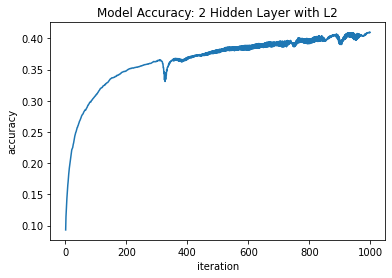

In [ ]:
# plot training history
fig = plt.plot(figsize=(12, 4))
iteration = list(range(1,1000))

# History for accuracy
plt.plot(iteration, acc_history_L2)
plt.title('Model Accuracy: 2 Hidden Layer with L2')
plt.ylabel('accuracy')
plt.xlabel('iteration')

plt.savefig("two_hidden_L2.png")

### L1 regularization

In [ ]:
def objective(trial):
    # Define the search space for the hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    L1_lambda = trial.suggest_float("L1_lambda", 1e-6, 1e-1, log=True)

    # Create the MLP_2 model with the given hyperparameters
    model_2_hidden = MLP_2(M=[256, 256], n_hidden=2, L1_lambda=L1_lambda, L2_lambda=0)
    optimizer = GradientDescent(learning_rate=learning_rate, max_iters=5)

    # Train the model and compute its validation accuracy
    yh_2_hidden = model_2_hidden.fit(train_images, train_labels, optimizer)
    val_acc = yh_2_hidden.acc_history[-1]

    return val_acc

# Define the search method and run the optimization process
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print the best hyperparameters found by Optuna
print("Best hyperparameters: ", study.best_params)

[I 2023-03-09 05:52:13,046] A new study created in memory with name: no-name-f267ed9c-41ab-4df4-94c5-6acbbca9cf11


iteration: 1
[[0.096457   0.08896398 0.13452468 ... 0.08355616 0.139714   0.09620912]
 [0.07470049 0.0989892  0.1210804  ... 0.08445472 0.12354351 0.0864741 ]
 [0.07337291 0.09938943 0.12549573 ... 0.05677465 0.13146817 0.07894267]
 ...
 [0.08657118 0.10178226 0.12518763 ... 0.06259401 0.13324767 0.07855358]
 [0.07497927 0.08023019 0.12055859 ... 0.04886439 0.19640573 0.08688466]
 [0.075687   0.10688612 0.13387746 ... 0.05719053 0.16244943 0.11215832]]
acc: 0.1063


iteration: 2
[[0.10093456 0.0923047  0.12942987 ... 0.08741331 0.13358093 0.09983897]
 [0.07993886 0.10317664 0.11664733 ... 0.08856321 0.11826632 0.09180485]
 [0.07930414 0.10407677 0.12047506 ... 0.06076709 0.12686569 0.08575032]
 ...
 [0.09144965 0.10609545 0.12185439 ... 0.06618935 0.13024148 0.08374239]
 [0.08283543 0.08648458 0.11481309 ... 0.05321183 0.18711999 0.09524178]
 [0.0804259  0.11154187 0.128973   ... 0.06165663 0.15340997 0.11925142]]
acc: 0.1092


iteration: 3
[[0.10459173 0.0946714  0.12485308 ... 0.0904

[I 2023-03-09 05:52:38,580] Trial 0 finished with value: 0.1152 and parameters: {'learning_rate': 0.007189427423254176, 'L1_lambda': 0.01993413681451548}. Best is trial 0 with value: 0.1152.


iteration: 1
[[0.08808253 0.04256815 0.0991181  ... 0.14488185 0.09127317 0.05464259]
 [0.07480783 0.04262697 0.14037618 ... 0.18542304 0.0358502  0.03598985]
 [0.10343761 0.05336001 0.08425872 ... 0.15103977 0.06795587 0.05181481]
 ...
 [0.08055491 0.04941732 0.09452716 ... 0.16670044 0.07572359 0.05816115]
 [0.09729354 0.03083932 0.08118059 ... 0.16717789 0.02959543 0.0395701 ]
 [0.10520344 0.04244042 0.10954777 ... 0.1515732  0.05505871 0.04404455]]
acc: 0.0993


iteration: 2
[[0.08809193 0.04257865 0.09912425 ... 0.14486555 0.09129869 0.05465817]
 [0.07482075 0.04264334 0.14039461 ... 0.18540044 0.03587006 0.03600693]
 [0.10345891 0.05338602 0.08427306 ... 0.15101605 0.06799456 0.05184345]
 ...
 [0.08056695 0.0494357  0.0945376  ... 0.16667577 0.07575741 0.05818534]
 [0.09732534 0.03085839 0.08120121 ... 0.16716383 0.02961771 0.03959708]
 [0.10522132 0.04245787 0.10956467 ... 0.15155638 0.05508654 0.04406661]]
acc: 0.0993


iteration: 3
[[0.08810133 0.04258914 0.0991304  ... 0.1448

[I 2023-03-09 05:53:05,896] Trial 1 finished with value: 0.0991 and parameters: {'learning_rate': 1.817138951346284e-05, 'L1_lambda': 3.842280493488392e-05}. Best is trial 0 with value: 0.1152.


iteration: 1
[[0.09235992 0.08474684 0.05227815 ... 0.10056451 0.091178   0.12728051]
 [0.07982702 0.07710113 0.04863685 ... 0.12513246 0.0608551  0.15814767]
 [0.10959901 0.06483609 0.08635164 ... 0.11675705 0.05251548 0.13557001]
 ...
 [0.09979231 0.08910865 0.07403859 ... 0.10143042 0.04583487 0.14180977]
 [0.07105795 0.07700429 0.06219024 ... 0.13501461 0.05419581 0.1294194 ]
 [0.08071619 0.06400476 0.07837354 ... 0.12085406 0.06304568 0.13886892]]
acc: 0.1177


iteration: 2
[[0.09239111 0.0847956  0.05231106 ... 0.10055967 0.09123038 0.127237  ]
 [0.07988588 0.07716546 0.04868367 ... 0.12513424 0.06091135 0.15807976]
 [0.10966545 0.06488015 0.0864342  ... 0.11675042 0.05256014 0.13553154]
 ...
 [0.09983553 0.08916299 0.07409826 ... 0.10142312 0.04587166 0.14176897]
 [0.07111865 0.07709121 0.06226278 ... 0.13502324 0.05426003 0.12936689]
 [0.08076484 0.06404927 0.07844549 ... 0.1208375  0.06309676 0.13880149]]
acc: 0.1179


iteration: 3
[[0.09242222 0.08484426 0.05234391 ... 0.1005

[I 2023-03-09 05:53:33,172] Trial 2 finished with value: 0.1182 and parameters: {'learning_rate': 7.216003322374967e-05, 'L1_lambda': 2.4586484971177852e-05}. Best is trial 2 with value: 0.1182.


iteration: 1
[[0.22259779 0.10609885 0.04974483 ... 0.10801557 0.05752006 0.04414609]
 [0.21838593 0.08044089 0.04780197 ... 0.12613609 0.06866211 0.03781119]
 [0.18889454 0.0732289  0.05635049 ... 0.18168039 0.04754798 0.04686568]
 ...
 [0.1867166  0.0809594  0.07695837 ... 0.14222506 0.07071963 0.05398489]
 [0.22945292 0.07486649 0.04258313 ... 0.14314586 0.0602778  0.03537943]
 [0.20376099 0.08785571 0.04154382 ... 0.15856864 0.03335078 0.04980189]]
acc: 0.0969


iteration: 2
[[0.17406676 0.11564594 0.06407476 ... 0.08839479 0.07589226 0.05760844]
 [0.1712908  0.08864842 0.0627231  ... 0.10015474 0.09289249 0.0519046 ]
 [0.14512078 0.08423319 0.07488239 ... 0.13622202 0.06943657 0.06790921]
 ...
 [0.14752638 0.08765017 0.0933234  ... 0.11218484 0.09446293 0.07027883]
 [0.1650393  0.08952913 0.06048109 ... 0.10237321 0.09540601 0.05647845]
 [0.15370582 0.10152426 0.05602562 ... 0.12359792 0.04894482 0.07075079]]
acc: 0.0918


iteration: 3
[[0.15423597 0.11678141 0.07339694 ... 0.0807

[I 2023-03-09 05:53:58,955] Trial 3 finished with value: 0.1093 and parameters: {'learning_rate': 0.020030036013670535, 'L1_lambda': 2.8844155905331776e-05}. Best is trial 2 with value: 0.1182.


iteration: 1
[[0.06522242 0.06736801 0.08058905 ... 0.14369097 0.15923527 0.06629435]
 [0.07090301 0.07881149 0.0865021  ... 0.1388096  0.10422306 0.05303245]
 [0.05764452 0.07809719 0.11951665 ... 0.10370981 0.1878576  0.04820004]
 ...
 [0.06654696 0.10135896 0.14040576 ... 0.11238789 0.14220978 0.06385301]
 [0.03408708 0.06628464 0.09481192 ... 0.12763375 0.17423276 0.04403855]
 [0.06046682 0.09770025 0.12372353 ... 0.10490973 0.18006473 0.05280869]]
acc: 0.0988


iteration: 2
[[0.06523382 0.06737631 0.08059075 ... 0.14368167 0.1592277  0.06630291]
 [0.07092215 0.07882626 0.08650818 ... 0.13880072 0.10421921 0.053043  ]
 [0.05766169 0.07811206 0.1195298  ... 0.10370477 0.1878481  0.0482106 ]
 ...
 [0.06655969 0.10137133 0.14041521 ... 0.11237876 0.14220293 0.06386177]
 [0.03410151 0.06630499 0.09482771 ... 0.12763073 0.17423575 0.0440537 ]
 [0.06048336 0.09771882 0.12373344 ... 0.10490287 0.18005667 0.05282107]]
acc: 0.0988


iteration: 3
[[0.06524522 0.0673846  0.08059246 ... 0.1436

[I 2023-03-09 05:54:25,067] Trial 4 finished with value: 0.0988 and parameters: {'learning_rate': 1.2881873270766181e-05, 'L1_lambda': 0.0005051661883550906}. Best is trial 2 with value: 0.1182.


iteration: 1
[[0.10200017 0.08323447 0.05135594 ... 0.12954098 0.09388034 0.12746813]
 [0.10065068 0.10688853 0.03986536 ... 0.14596027 0.05534082 0.13540546]
 [0.07276911 0.11492574 0.03676922 ... 0.09392124 0.09193382 0.09384928]
 ...
 [0.11566133 0.1192662  0.04951811 ... 0.08568325 0.07772381 0.0816536 ]
 [0.08833285 0.10218527 0.02920981 ... 0.09766806 0.09303869 0.11094973]
 [0.08672206 0.09336973 0.04039648 ... 0.11570682 0.08610555 0.09410669]]
acc: 0.1029


iteration: 2
[[0.10201235 0.08324174 0.05138167 ... 0.12954415 0.0939042  0.12746516]
 [0.10067174 0.10690897 0.03989181 ... 0.14595837 0.05536706 0.1354073 ]
 [0.07278857 0.11494215 0.03679479 ... 0.09392664 0.09198784 0.0938619 ]
 ...
 [0.11568549 0.11927348 0.0495433  ... 0.08568213 0.07775626 0.08166269]
 [0.08835581 0.10220076 0.02923623 ... 0.09767331 0.09310114 0.11095822]
 [0.0867414  0.0933837  0.04042347 ... 0.11570617 0.08614775 0.09410998]]
acc: 0.1030


iteration: 3
[[0.10202451 0.08324898 0.0514074  ... 0.1295

[I 2023-03-09 05:54:50,869] Trial 5 finished with value: 0.1029 and parameters: {'learning_rate': 5.309182421353251e-05, 'L1_lambda': 3.053385335662877e-06}. Best is trial 2 with value: 0.1182.


iteration: 1
[[0.18024893 0.11160593 0.05826826 ... 0.11304657 0.05403873 0.04546646]
 [0.17794763 0.14499547 0.05556099 ... 0.13001211 0.05414351 0.04275751]
 [0.20836238 0.11127603 0.06749023 ... 0.13921843 0.06429745 0.0368431 ]
 ...
 [0.19528038 0.13179361 0.0733141  ... 0.12746933 0.07444323 0.04835176]
 [0.18022437 0.14145547 0.04885699 ... 0.13116071 0.05250088 0.02546347]
 [0.19689957 0.11617272 0.06010401 ... 0.12555172 0.05176149 0.04418222]]
acc: 0.1043


iteration: 2
[[0.17875736 0.11216721 0.06178008 ... 0.11324332 0.05686624 0.04842909]
 [0.17633853 0.14612356 0.06025977 ... 0.13131323 0.05814749 0.04644881]
 [0.20688732 0.11199724 0.07176948 ... 0.1374982  0.06851513 0.03993382]
 ...
 [0.19456334 0.13151501 0.07655597 ... 0.12597084 0.07824714 0.05144103]
 [0.1812585  0.14376652 0.05488961 ... 0.13180194 0.05785745 0.02864526]
 [0.19690222 0.11688631 0.06440887 ... 0.12566937 0.05573252 0.04833315]]
acc: 0.1083


iteration: 3
[[0.17655273 0.11214945 0.06486672 ... 0.1131

[I 2023-03-09 05:55:16,350] Trial 6 finished with value: 0.1186 and parameters: {'learning_rate': 0.0041067192366002975, 'L1_lambda': 4.39320199186971e-06}. Best is trial 6 with value: 0.1186.


iteration: 1
[[0.05387483 0.14553159 0.07774527 ... 0.10018946 0.18609179 0.12736074]
 [0.07543884 0.12510836 0.08761881 ... 0.12574739 0.14697856 0.13363808]
 [0.07580329 0.11378495 0.07747039 ... 0.11544999 0.14897678 0.10937582]
 ...
 [0.08290137 0.09740682 0.07845467 ... 0.12055875 0.13180646 0.11452266]
 [0.07544261 0.14364817 0.06709637 ... 0.1651318  0.14861726 0.11420586]
 [0.08631049 0.139735   0.0742332  ... 0.11993554 0.1449293  0.10827468]]
acc: 0.0826


iteration: 2
[[0.05388077 0.14552485 0.07775027 ... 0.10018673 0.18608005 0.12736055]
 [0.07544921 0.12510068 0.08762639 ... 0.12574149 0.14696986 0.13363712]
 [0.07581397 0.11377884 0.07747644 ... 0.11544381 0.14896698 0.10937861]
 ...
 [0.0829096  0.09740287 0.07845916 ... 0.12055236 0.13180049 0.11452416]
 [0.07545773 0.14363724 0.06710352 ... 0.16512183 0.14860802 0.11420813]
 [0.08632415 0.13972717 0.07423956 ... 0.11993011 0.14491803 0.10827621]]
acc: 0.0826


iteration: 3
[[0.0538867  0.14551812 0.07775526 ... 0.1001

[I 2023-03-09 05:55:43,097] Trial 7 finished with value: 0.0825 and parameters: {'learning_rate': 1.1497259283995933e-05, 'L1_lambda': 0.0001572838003814987}. Best is trial 6 with value: 0.1186.


iteration: 1
[[0.13640581 0.1165013  0.08144313 ... 0.05799386 0.13048324 0.07562299]
 [0.12703953 0.18129111 0.10894164 ... 0.05065029 0.12637867 0.06450214]
 [0.1098186  0.20221712 0.13098669 ... 0.03669738 0.06510433 0.05293493]
 ...
 [0.09446874 0.18188364 0.12060746 ... 0.06908989 0.07107152 0.07809487]
 [0.1024616  0.13875235 0.09161646 ... 0.04462766 0.0982183  0.04749589]
 [0.1166914  0.16286585 0.07425372 ... 0.06324561 0.10616444 0.05736284]]
acc: 0.0838


iteration: 2
[[0.13640018 0.11642428 0.0814581  ... 0.05802787 0.13049342 0.07566214]
 [0.12704655 0.18115386 0.1089764  ... 0.05069207 0.1264106  0.06454965]
 [0.10985756 0.2020636  0.13102446 ... 0.03673633 0.06514714 0.05299336]
 ...
 [0.09449184 0.18174846 0.12062887 ... 0.06913441 0.07110619 0.07815082]
 [0.10251535 0.1386528  0.0916771  ... 0.04468493 0.09829027 0.04755992]
 [0.1167127  0.16273054 0.07427971 ... 0.0632986  0.10620149 0.05741218]]
acc: 0.0838


iteration: 3
[[0.13639441 0.11634754 0.08147299 ... 0.0580

[I 2023-03-09 05:56:09,014] Trial 8 finished with value: 0.0836 and parameters: {'learning_rate': 6.466551553991685e-05, 'L1_lambda': 0.058672926616788364}. Best is trial 6 with value: 0.1186.


iteration: 1
[[0.13035163 0.06261458 0.17254897 ... 0.08894539 0.10026903 0.10077827]
 [0.11205034 0.04803199 0.17155305 ... 0.06558633 0.10451305 0.11104098]
 [0.12448206 0.06316597 0.15367305 ... 0.09300043 0.06895006 0.11334118]
 ...
 [0.12481812 0.0589795  0.13644817 ... 0.09644571 0.07872555 0.10660904]
 [0.1550023  0.04742047 0.19135153 ... 0.070643   0.06941483 0.13200592]
 [0.11429576 0.06428928 0.16852228 ... 0.09163142 0.07600592 0.10086851]]
acc: 0.0956


iteration: 2
[[0.12973467 0.06396222 0.16610422 ... 0.08994725 0.10197071 0.1011718 ]
 [0.11139809 0.04927083 0.16410703 ... 0.06678946 0.10718698 0.11127882]
 [0.12406616 0.06492345 0.14676643 ... 0.09439975 0.07073429 0.11368596]
 ...
 [0.12463481 0.0601182  0.1316992  ... 0.09747193 0.08012093 0.10681164]
 [0.15439192 0.04920415 0.18070549 ... 0.07290753 0.07209076 0.13267031]
 [0.11363293 0.06604848 0.16092712 ... 0.093752   0.07802229 0.10117217]]
acc: 0.0953


iteration: 3
[[0.12904651 0.06521276 0.16057792 ... 0.0908

[I 2023-03-09 05:56:34,521] Trial 9 finished with value: 0.0941 and parameters: {'learning_rate': 0.002611974351460459, 'L1_lambda': 0.000694236878669338}. Best is trial 6 with value: 0.1186.


iteration: 1
[[0.08844862 0.08688028 0.08810183 ... 0.15330754 0.0961537  0.09416054]
 [0.09073729 0.08756362 0.07756741 ... 0.12298606 0.14614682 0.07097922]
 [0.11450035 0.05526812 0.07258458 ... 0.14197539 0.09718854 0.05420708]
 ...
 [0.09509636 0.10294381 0.06581705 ... 0.11716862 0.13200405 0.07593275]
 [0.08417084 0.11550419 0.07882919 ... 0.15901856 0.11113178 0.07459275]
 [0.06943277 0.07799073 0.08664932 ... 0.151022   0.12817763 0.05539893]]
acc: 0.0995


iteration: 2
[[0.13018836 0.1060369  0.1002098  ... 0.10594844 0.09766489 0.12117483]
 [0.1604755  0.11030162 0.08563088 ... 0.07111606 0.14809654 0.09857472]
 [0.22314792 0.08364298 0.07775086 ... 0.08593557 0.1148437  0.0883686 ]
 ...
 [0.14742434 0.13357447 0.07117084 ... 0.07723744 0.14074859 0.10327216]
 [0.18078516 0.15039941 0.09036807 ... 0.07677067 0.12484329 0.10440779]
 [0.13060005 0.10195299 0.10502326 ... 0.0990126  0.13692432 0.08191972]]
acc: 0.0948


iteration: 3
[[0.07993431 0.09613936 0.10135224 ... 0.1346

[I 2023-03-09 05:56:59,412] Trial 10 finished with value: 0.1212 and parameters: {'learning_rate': 0.06705129272494427, 'L1_lambda': 2.32855795014666e-06}. Best is trial 10 with value: 0.1212.


iteration: 1
[[0.10363858 0.05522051 0.06840806 ... 0.19001339 0.12470571 0.04912014]
 [0.07879245 0.074395   0.07226483 ... 0.15466719 0.11927037 0.06131019]
 [0.06623773 0.09789122 0.04308068 ... 0.17957996 0.12269719 0.0762229 ]
 ...
 [0.04714177 0.0821085  0.0645511  ... 0.17370974 0.10610854 0.07623985]
 [0.06341127 0.08140989 0.05291258 ... 0.19812942 0.10755134 0.07527384]
 [0.0723746  0.08490056 0.06551459 ... 0.16018308 0.13363728 0.05657675]]
acc: 0.0963


iteration: 2
[[0.13679799 0.07719851 0.13897817 ... 0.06834799 0.09220157 0.08005892]
 [0.1062917  0.10156317 0.14550687 ... 0.04570382 0.09532954 0.1097063 ]
 [0.10595717 0.1390283  0.09592824 ... 0.0514795  0.09170805 0.1568224 ]
 ...
 [0.0718058  0.12187036 0.11548154 ... 0.06815729 0.09058403 0.13882076]
 [0.10218221 0.13223503 0.13442143 ... 0.04196908 0.07578411 0.15740182]
 [0.09905899 0.11355308 0.1343665  ... 0.04498492 0.09398367 0.11795963]]
acc: 0.1184


iteration: 3
[[0.14377643 0.07017211 0.09290404 ... 0.1252

[I 2023-03-09 05:57:24,231] Trial 11 finished with value: 0.1376 and parameters: {'learning_rate': 0.08957227566773537, 'L1_lambda': 1.1293524631996099e-06}. Best is trial 11 with value: 0.1376.


iteration: 1
[[0.05984902 0.14844747 0.09449819 ... 0.08139159 0.19797084 0.12937772]
 [0.07553335 0.15441987 0.08371649 ... 0.04078247 0.19495291 0.14337701]
 [0.06217794 0.21369799 0.07961136 ... 0.05135958 0.1812918  0.12784786]
 ...
 [0.06178842 0.15312433 0.09178529 ... 0.05903058 0.21465143 0.1183901 ]
 [0.04891669 0.19820304 0.11301903 ... 0.05541115 0.15828084 0.16329531]
 [0.09195896 0.15660324 0.09582952 ... 0.05136925 0.16119815 0.16820227]]
acc: 0.0939


iteration: 2
[[0.14858903 0.05892468 0.06964707 ... 0.18518263 0.04374939 0.06654434]
 [0.25017898 0.04376034 0.063263   ... 0.10396126 0.02919567 0.07439644]
 [0.21364264 0.05475531 0.05270313 ... 0.15658268 0.02129739 0.0606312 ]
 ...
 [0.18195193 0.05425502 0.06641435 ... 0.15574685 0.04024355 0.07175713]
 [0.23697964 0.03777491 0.05858104 ... 0.18345826 0.01328703 0.06042317]
 [0.29963871 0.03839288 0.0543382  ... 0.1234436  0.01978933 0.07292342]]
acc: 0.1005


iteration: 3
[[0.03238694 0.13065427 0.10699406 ... 0.0916

[I 2023-03-09 05:57:50,125] Trial 12 finished with value: 0.1368 and parameters: {'learning_rate': 0.08305353820762734, 'L1_lambda': 1.0941386421762276e-06}. Best is trial 11 with value: 0.1376.


iteration: 1
[[0.11076265 0.14757206 0.11958165 ... 0.11641558 0.14230868 0.10872496]
 [0.14380109 0.15863624 0.11199778 ... 0.07880844 0.1146389  0.10752846]
 [0.14336292 0.08712757 0.20201833 ... 0.0843528  0.15332195 0.0808306 ]
 ...
 [0.1240615  0.11061773 0.15229263 ... 0.08802214 0.1618008  0.10490735]
 [0.14819184 0.13192187 0.16988835 ... 0.11687165 0.13122402 0.07532301]
 [0.10198017 0.13203225 0.16293682 ... 0.14317736 0.10577975 0.10894339]]
acc: 0.1189


iteration: 2
[[0.09987505 0.10774349 0.08531947 ... 0.068267   0.10420007 0.10963114]
 [0.13134789 0.10256055 0.06057482 ... 0.03546672 0.07974624 0.10458176]
 [0.13567406 0.06273188 0.09949409 ... 0.04041176 0.11387609 0.08992596]
 ...
 [0.12140247 0.08489118 0.08697575 ... 0.05127895 0.13064501 0.11909234]
 [0.15613502 0.07621939 0.07484832 ... 0.04419941 0.09772781 0.08239184]
 [0.09477698 0.09986116 0.08948076 ... 0.07054448 0.07567671 0.10701474]]
acc: 0.1481


iteration: 3
[[0.09157984 0.11308793 0.10303952 ... 0.1023

[I 2023-03-09 05:58:14,430] Trial 13 finished with value: 0.1831 and parameters: {'learning_rate': 0.07395146155762324, 'L1_lambda': 1.4458430593781083e-06}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.10003215 0.05542242 0.11174368 ... 0.10306361 0.12914108 0.1028297 ]
 [0.08541259 0.05555471 0.12541474 ... 0.08908388 0.13420833 0.15859665]
 [0.07834382 0.04266012 0.10352529 ... 0.09279093 0.18597148 0.12605382]
 ...
 [0.07312122 0.05518797 0.12423533 ... 0.11557458 0.13140062 0.12694398]
 [0.06204308 0.04978612 0.12323492 ... 0.07857268 0.14719947 0.11642861]
 [0.09354898 0.06361801 0.0954056  ... 0.08689175 0.12642301 0.11800922]]
acc: 0.1040


iteration: 2
[[0.11184055 0.07145568 0.10956373 ... 0.10914878 0.1161964  0.09581296]
 [0.1007713  0.0788591  0.12199516 ... 0.09445907 0.12174076 0.14891392]
 [0.09636779 0.06052885 0.10295872 ... 0.09824635 0.16506896 0.12582894]
 ...
 [0.08288755 0.07030767 0.12300225 ... 0.11998585 0.11761128 0.12529021]
 [0.07971141 0.07951179 0.12021641 ... 0.08710106 0.1315827  0.11055127]
 [0.11300473 0.08929578 0.09355734 ... 0.09324688 0.11677179 0.11203446]]
acc: 0.1016


iteration: 3
[[0.11488377 0.08008159 0.10414322 ... 0.1121

[I 2023-03-09 05:58:39,552] Trial 14 finished with value: 0.1166 and parameters: {'learning_rate': 0.023644245870698122, 'L1_lambda': 6.716537610864852e-06}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.10879098 0.11324378 0.09276475 ... 0.073411   0.07188704 0.07420917]
 [0.0887005  0.08573092 0.06085021 ... 0.06452945 0.07995025 0.05017294]
 [0.08657805 0.07211205 0.06683877 ... 0.06121644 0.05567719 0.03627199]
 ...
 [0.1106621  0.08185698 0.08907717 ... 0.06288335 0.05207292 0.06935566]
 [0.10790221 0.09763278 0.08900668 ... 0.04407447 0.03915623 0.05407903]
 [0.10468999 0.08451096 0.08967515 ... 0.05547268 0.04862033 0.05092683]]
acc: 0.1006


iteration: 2
[[0.12369682 0.09902895 0.09777754 ... 0.11468558 0.10800429 0.09942875]
 [0.12483238 0.09759775 0.0798855  ... 0.10634072 0.14718089 0.07886862]
 [0.13120429 0.07994326 0.07882533 ... 0.12527054 0.15244838 0.09466835]
 ...
 [0.13142316 0.08726923 0.1021334  ... 0.09512281 0.10194035 0.12686282]
 [0.14650142 0.11184308 0.1161076  ... 0.09046916 0.10483347 0.13495814]
 [0.14933673 0.10534405 0.11549692 ... 0.10420061 0.11078307 0.12446587]]
acc: 0.1391


iteration: 3
[[0.08603614 0.11033348 0.09138195 ... 0.1086

[I 2023-03-09 05:59:04,635] Trial 15 finished with value: 0.1616 and parameters: {'learning_rate': 0.09777981295955482, 'L1_lambda': 1.2289128263072088e-06}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.13360201 0.09076168 0.07157142 ... 0.10602345 0.11651554 0.09082354]
 [0.08262222 0.08526418 0.07269819 ... 0.13134138 0.18468754 0.07981333]
 [0.09867834 0.08773416 0.0558602  ... 0.15320652 0.14975989 0.06644456]
 ...
 [0.08954416 0.08192015 0.07828207 ... 0.11884907 0.20476897 0.08873748]
 [0.08519801 0.0780824  0.06731331 ... 0.10522565 0.15240913 0.08923632]
 [0.12293568 0.08094649 0.06461338 ... 0.10771859 0.12443608 0.10068805]]
acc: 0.1259


iteration: 2
[[0.1338017  0.09094912 0.07186881 ... 0.10541022 0.116053   0.09106078]
 [0.0828398  0.08565852 0.07304915 ... 0.13040619 0.18401213 0.08020195]
 [0.09899425 0.08810281 0.05615441 ... 0.15201402 0.14937817 0.06689845]
 ...
 [0.08971181 0.08227571 0.07864016 ... 0.11798786 0.20417568 0.08924791]
 [0.08548895 0.07850695 0.06780209 ... 0.10419525 0.15178565 0.08988879]
 [0.12318747 0.08128761 0.06491596 ... 0.10692259 0.12391075 0.10123717]]
acc: 0.1258


iteration: 3
[[0.13399435 0.09113542 0.07216069 ... 0.1048

[I 2023-03-09 05:59:36,821] Trial 16 finished with value: 0.1263 and parameters: {'learning_rate': 0.0008315927060825885, 'L1_lambda': 8.471656207564323e-06}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.08841126 0.08627653 0.14943861 ... 0.09807101 0.12993828 0.12617917]
 [0.06833667 0.09913131 0.16074394 ... 0.0851963  0.12796079 0.13058237]
 [0.13327003 0.07793306 0.09775845 ... 0.08356581 0.12386878 0.12735204]
 ...
 [0.11420137 0.09041214 0.11130621 ... 0.08270794 0.12838652 0.13275639]
 [0.10281361 0.09808725 0.10970659 ... 0.08877913 0.13643763 0.15138268]
 [0.07332106 0.09960407 0.09674483 ... 0.07143381 0.16449448 0.12501419]]
acc: 0.0857


iteration: 2
[[0.10083495 0.08710852 0.14124291 ... 0.11339222 0.11729153 0.11121005]
 [0.08258344 0.10438457 0.14907599 ... 0.10378533 0.12177531 0.11556078]
 [0.15779988 0.08385906 0.09255867 ... 0.10431856 0.11682994 0.11458487]
 ...
 [0.13170179 0.09466924 0.10525039 ... 0.09731547 0.12292746 0.12424377]
 [0.13127476 0.10587633 0.10272005 ... 0.1160968  0.12711203 0.12434857]
 [0.09373834 0.10924708 0.09436154 ... 0.089987   0.1548134  0.11249079]]
acc: 0.1046


iteration: 3
[[0.10612577 0.08705568 0.13279167 ... 0.1218

[I 2023-03-09 06:00:01,764] Trial 17 finished with value: 0.1214 and parameters: {'learning_rate': 0.021128551263054282, 'L1_lambda': 1.5100348775491858e-06}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.09343956 0.13902268 0.13429921 ... 0.11717018 0.08152506 0.06340386]
 [0.07730226 0.13066345 0.13608153 ... 0.13604813 0.09246788 0.02806431]
 [0.1096589  0.10325923 0.15594967 ... 0.07317546 0.10009218 0.04319732]
 ...
 [0.12688333 0.10947252 0.14711145 ... 0.10027121 0.09508582 0.05080593]
 [0.10011458 0.11336177 0.1836521  ... 0.10031781 0.08410582 0.03652297]
 [0.13648674 0.13159757 0.16121047 ... 0.10418363 0.0766375  0.04955441]]
acc: 0.1136


iteration: 2
[[0.1101934  0.11996478 0.10088177 ... 0.11267122 0.09443493 0.09368342]
 [0.10230971 0.1227636  0.1061619  ... 0.13730495 0.11604471 0.04747053]
 [0.14667363 0.0863447  0.11426346 ... 0.07260008 0.1236432  0.08300844]
 ...
 [0.15280192 0.0944487  0.11560102 ... 0.09735355 0.10818542 0.08080732]
 [0.144214   0.09817521 0.1302832  ... 0.10431515 0.11189058 0.07733428]
 [0.17120474 0.10774429 0.11627917 ... 0.10258126 0.09427399 0.08303742]]
acc: 0.1294


iteration: 3
[[0.10350911 0.1138618  0.09166675 ... 0.1075

[I 2023-03-09 06:00:26,673] Trial 18 finished with value: 0.1532 and parameters: {'learning_rate': 0.036217899526061914, 'L1_lambda': 9.65073148436495e-06}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.08200812 0.10319853 0.08133266 ... 0.08952769 0.09954443 0.08096754]
 [0.05784613 0.10360305 0.08479031 ... 0.05180415 0.09936276 0.10018343]
 [0.07928208 0.1305272  0.08169873 ... 0.05848814 0.08130786 0.10505706]
 ...
 [0.05996595 0.09991965 0.08776684 ... 0.07511622 0.09713343 0.1713985 ]
 [0.06225434 0.10247792 0.0780076  ... 0.05848871 0.071107   0.07720794]
 [0.06618477 0.11604621 0.06887128 ... 0.05954116 0.08345407 0.09787527]]
acc: 0.1123


iteration: 2
[[0.08754013 0.10551943 0.0854593  ... 0.09630255 0.09976034 0.08648939]
 [0.06426305 0.10853603 0.09094661 ... 0.05671437 0.10172775 0.1145048 ]
 [0.08962725 0.13687621 0.08741141 ... 0.06415173 0.08498011 0.12243424]
 ...
 [0.06381504 0.10194034 0.08903815 ... 0.07860409 0.09887097 0.18873781]
 [0.07316312 0.11006232 0.08712789 ... 0.0674044  0.07688242 0.09339908]
 [0.07461286 0.12314468 0.07446208 ... 0.067704   0.08794681 0.11183251]]
acc: 0.1159


iteration: 3
[[0.09131196 0.1059003  0.08839405 ... 0.1010

[I 2023-03-09 06:00:51,487] Trial 19 finished with value: 0.1285 and parameters: {'learning_rate': 0.010402704862479708, 'L1_lambda': 1.0219087652491738e-06}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.08724896 0.13367683 0.07947193 ... 0.14422258 0.06234622 0.07807128]
 [0.07311414 0.10250637 0.07156065 ... 0.15205576 0.06391165 0.06714512]
 [0.063599   0.07302569 0.07150982 ... 0.1791931  0.0607201  0.09282434]
 ...
 [0.06911746 0.08193737 0.06451605 ... 0.17099121 0.06222286 0.08324479]
 [0.05080178 0.10677801 0.05355077 ... 0.20206062 0.04999636 0.06869785]
 [0.05209279 0.07884549 0.06067393 ... 0.13985452 0.09200007 0.08238257]]
acc: 0.0959


iteration: 2
[[0.1326109  0.11663179 0.09823709 ... 0.09175321 0.08548625 0.09724943]
 [0.15150389 0.09543557 0.09763416 ... 0.07113127 0.10784615 0.09080366]
 [0.14128043 0.07059541 0.09763453 ... 0.08073244 0.10998321 0.13327879]
 ...
 [0.12822533 0.08299172 0.08272746 ... 0.09258816 0.09166641 0.11536188]
 [0.14370251 0.10960253 0.07841863 ... 0.07587179 0.10455217 0.1057507 ]
 [0.11635729 0.07263224 0.07768552 ... 0.06897754 0.16301391 0.10726521]]
acc: 0.1124


iteration: 3
[[0.1021517  0.11866325 0.10301796 ... 0.1081

[I 2023-03-09 06:01:16,759] Trial 20 finished with value: 0.1425 and parameters: {'learning_rate': 0.05093085185456209, 'L1_lambda': 8.34037635162131e-05}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.08777407 0.08963381 0.08442823 ... 0.08318287 0.11630252 0.10458718]
 [0.07878589 0.07787743 0.07024722 ... 0.06273853 0.12015577 0.10838224]
 [0.07062698 0.09176399 0.06790554 ... 0.08608847 0.13765471 0.12824293]
 ...
 [0.08420693 0.06601119 0.06376753 ... 0.08743055 0.1266116  0.13806836]
 [0.05734599 0.09544354 0.06598912 ... 0.05361068 0.13616298 0.14471365]
 [0.08358156 0.11126001 0.07855759 ... 0.06657491 0.11322608 0.10249036]]
acc: 0.1074


iteration: 2
[[0.10137212 0.09223407 0.09729868 ... 0.10342495 0.10141655 0.09991655]
 [0.10389144 0.08086629 0.08607981 ... 0.0823321  0.11094011 0.10675389]
 [0.09297082 0.10061156 0.08038467 ... 0.11296284 0.12472711 0.1407348 ]
 ...
 [0.10632267 0.07086392 0.07238431 ... 0.10500682 0.12310192 0.14572736]
 [0.08478958 0.10664828 0.08212348 ... 0.07843485 0.12295657 0.14923045]
 [0.1070178  0.11350714 0.09369636 ... 0.08943599 0.0987487  0.10511799]]
acc: 0.1362


iteration: 3
[[0.10388567 0.09097987 0.1019127  ... 0.1082

[I 2023-03-09 06:01:42,976] Trial 21 finished with value: 0.1659 and parameters: {'learning_rate': 0.0367420999407785, 'L1_lambda': 9.01785554538526e-06}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.14820848 0.11863469 0.06536305 ... 0.10160389 0.16319285 0.09070145]
 [0.16805496 0.17341109 0.07005373 ... 0.10041998 0.15413343 0.06762159]
 [0.26233373 0.12714496 0.07043037 ... 0.09747502 0.15696469 0.04702621]
 ...
 [0.22544673 0.10506283 0.08017913 ... 0.11648983 0.14337502 0.062391  ]
 [0.23858249 0.13895221 0.06945889 ... 0.10734854 0.15416857 0.06583525]
 [0.22624956 0.14496857 0.08450971 ... 0.09769167 0.12833344 0.06544156]]
acc: 0.1086


iteration: 2
[[0.04256943 0.07856848 0.11360226 ... 0.10119862 0.09176183 0.11358296]
 [0.03761904 0.11322733 0.15395512 ... 0.09530978 0.0798037  0.09249477]
 [0.06224236 0.08943208 0.1648854  ... 0.1088061  0.08783863 0.08670144]
 ...
 [0.07285096 0.08126635 0.15119719 ... 0.12194543 0.09559372 0.09984402]
 [0.03139289 0.07047053 0.1970292  ... 0.10653866 0.06221003 0.10181509]
 [0.04737816 0.08649404 0.19062989 ... 0.09946229 0.06371404 0.09809733]]
acc: 0.1006


iteration: 3
[[0.10657175 0.08334065 0.05551659 ... 0.0986

[I 2023-03-09 06:02:08,189] Trial 22 finished with value: 0.1407 and parameters: {'learning_rate': 0.09703955292957277, 'L1_lambda': 4.290326632021845e-06}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.07115358 0.13729513 0.11992676 ... 0.04507327 0.06792753 0.12522456]
 [0.06455085 0.15493081 0.07507566 ... 0.07129045 0.06962993 0.13258867]
 [0.07783775 0.2115961  0.07979709 ... 0.04877698 0.05737263 0.0892466 ]
 ...
 [0.08030504 0.1853583  0.10576873 ... 0.07430211 0.06321998 0.07464652]
 [0.05826529 0.21197811 0.0673825  ... 0.04392958 0.06468507 0.06706691]
 [0.09162721 0.17308328 0.08089067 ... 0.04955124 0.06007824 0.10048932]]
acc: 0.1176


iteration: 2
[[0.08614693 0.11076125 0.12924746 ... 0.05423661 0.08479219 0.13032261]
 [0.08233623 0.11765577 0.08387399 ... 0.092551   0.09584168 0.14381657]
 [0.10031406 0.1669875  0.08752507 ... 0.06443599 0.08198841 0.1029416 ]
 ...
 [0.09482911 0.15238377 0.11106228 ... 0.09210642 0.087067   0.08230021]
 [0.08163763 0.15088821 0.07755295 ... 0.06501869 0.10751295 0.07554363]
 [0.1154977  0.13204988 0.08671956 ... 0.06438609 0.08562064 0.10744078]]
acc: 0.1142


iteration: 3
[[0.09421795 0.10054234 0.13238878 ... 0.0595

[I 2023-03-09 06:02:33,549] Trial 23 finished with value: 0.1338 and parameters: {'learning_rate': 0.022779673417837577, 'L1_lambda': 1.3217244028118499e-05}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.0864149  0.08705367 0.08695379 ... 0.14922505 0.11770749 0.07868051]
 [0.10188424 0.05731231 0.08109921 ... 0.19915176 0.14207291 0.06988602]
 [0.07778755 0.05916355 0.07563496 ... 0.21974367 0.08224865 0.05877625]
 ...
 [0.06634993 0.06870762 0.07733723 ... 0.26258406 0.09391376 0.06687084]
 [0.07499746 0.05785017 0.08894857 ... 0.23694861 0.09554086 0.04740316]
 [0.08014627 0.05898988 0.07917137 ... 0.21649063 0.09956383 0.06343854]]
acc: 0.1011


iteration: 2
[[0.09686354 0.10125381 0.09256624 ... 0.10936931 0.12377717 0.09486247]
 [0.11936817 0.0728098  0.08701116 ... 0.12842021 0.16474651 0.09419207]
 [0.09904017 0.08090656 0.08720628 ... 0.13252153 0.10179055 0.09208357]
 ...
 [0.08280795 0.09089032 0.0877108  ... 0.17112588 0.11532125 0.0999098 ]
 [0.10470523 0.0821545  0.10558624 ... 0.12843884 0.11881075 0.07723832]
 [0.10190319 0.07631581 0.0926451  ... 0.13342385 0.11440336 0.09177856]]
acc: 0.1009


iteration: 3
[[0.09975439 0.10917789 0.09488178 ... 0.1042

[I 2023-03-09 06:02:58,417] Trial 24 finished with value: 0.1412 and parameters: {'learning_rate': 0.03946450936303375, 'L1_lambda': 4.1608595983593965e-06}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.0960864  0.16914391 0.05174685 ... 0.04617443 0.1171593  0.05669194]
 [0.11244081 0.12020654 0.06209782 ... 0.05194079 0.0981301  0.05784956]
 [0.12682867 0.12769995 0.06496337 ... 0.08048185 0.12908261 0.05836317]
 ...
 [0.12009499 0.16106412 0.06093054 ... 0.06320314 0.10907897 0.05904957]
 [0.07225602 0.147728   0.05493327 ... 0.04057055 0.0938832  0.04955368]
 [0.09301102 0.17813073 0.05651328 ... 0.05178596 0.1080364  0.06222845]]
acc: 0.1009


iteration: 2
[[0.14076542 0.11991481 0.08259973 ... 0.08536478 0.12774519 0.09025279]
 [0.1822433  0.07118647 0.09541215 ... 0.09691204 0.10674905 0.08090165]
 [0.19593362 0.06913762 0.10842875 ... 0.14695098 0.14000181 0.08615115]
 ...
 [0.19386327 0.10778141 0.09866798 ... 0.10279852 0.1324335  0.09202035]
 [0.16959739 0.08574129 0.12583402 ... 0.09998674 0.13702302 0.09188044]
 [0.16120433 0.10858132 0.09535299 ... 0.09559876 0.12252114 0.09926005]]
acc: 0.1170


iteration: 3
[[0.10006642 0.13343221 0.08024293 ... 0.0847

[I 2023-03-09 06:03:24,181] Trial 25 finished with value: 0.1474 and parameters: {'learning_rate': 0.04499184814728332, 'L1_lambda': 2.001420324240985e-06}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.13534644 0.13269275 0.09336749 ... 0.12512324 0.10156981 0.13894339]
 [0.15275057 0.09688568 0.06543609 ... 0.19461829 0.08287506 0.11286809]
 [0.17667064 0.06399871 0.11510718 ... 0.08284855 0.08651918 0.11284094]
 ...
 [0.16668889 0.07696744 0.10268794 ... 0.12495029 0.1000377  0.10692194]
 [0.21927293 0.05376537 0.0904842  ... 0.09155123 0.09008953 0.12493977]
 [0.16404864 0.09720087 0.09928862 ... 0.10025881 0.0843779  0.15135153]]
acc: 0.1029


iteration: 2
[[0.12182484 0.13413286 0.09635409 ... 0.12123153 0.10549417 0.13639564]
 [0.13728161 0.09902296 0.06816054 ... 0.1869188  0.0874313  0.11217316]
 [0.15847519 0.0660561  0.11769348 ... 0.07980664 0.09324864 0.11245171]
 ...
 [0.15459268 0.07839305 0.10453114 ... 0.12085237 0.10525828 0.10619454]
 [0.19125902 0.05620636 0.09638302 ... 0.08845012 0.09833917 0.12441126]
 [0.14616587 0.0998502  0.10251044 ... 0.09726672 0.09011712 0.14817679]]
acc: 0.1021


iteration: 3
[[0.11298613 0.13476906 0.09812856 ... 0.1182

[I 2023-03-09 06:03:49,408] Trial 26 finished with value: 0.1028 and parameters: {'learning_rate': 0.011897979385673762, 'L1_lambda': 1.4620255559911877e-05}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.06196216 0.04654187 0.07726508 ... 0.1119973  0.11724123 0.146115  ]
 [0.06285725 0.03311384 0.09505212 ... 0.1688337  0.09122589 0.12727662]
 [0.0933465  0.02817358 0.07133489 ... 0.10893633 0.07886669 0.21062393]
 ...
 [0.09035827 0.03735817 0.07603017 ... 0.11301574 0.07487098 0.22926685]
 [0.06663734 0.02742486 0.07468419 ... 0.13406703 0.08616248 0.19560638]
 [0.08684954 0.02843768 0.08508026 ... 0.13927843 0.07697438 0.1396361 ]]
acc: 0.1190


iteration: 2
[[0.10474105 0.14924317 0.09825739 ... 0.07477885 0.15597245 0.06640282]
 [0.13984655 0.13330959 0.13094117 ... 0.09163604 0.14427739 0.04704495]
 [0.19243259 0.12346825 0.09262523 ... 0.07139066 0.12082091 0.08325983]
 ...
 [0.17883608 0.14120847 0.09761309 ... 0.08021727 0.11416424 0.10520609]
 [0.17994952 0.16643478 0.10305972 ... 0.06361932 0.14750335 0.05480937]
 [0.17958739 0.12383734 0.11147086 ... 0.08546287 0.1030837  0.05622142]]
acc: 0.1150


iteration: 3
[[0.05811387 0.10653343 0.07181734 ... 0.1272

[I 2023-03-09 06:04:14,305] Trial 27 finished with value: 0.1395 and parameters: {'learning_rate': 0.08737042400508731, 'L1_lambda': 3.1985707416126083e-06}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.0955349  0.08400887 0.17532461 ... 0.11340231 0.11193506 0.0759444 ]
 [0.09567279 0.07379345 0.22249719 ... 0.10716119 0.09111465 0.0761286 ]
 [0.12232848 0.07972202 0.21039137 ... 0.11203729 0.09360688 0.05880573]
 ...
 [0.08863087 0.09549908 0.20068464 ... 0.09972783 0.10544552 0.07387105]
 [0.09340518 0.06490079 0.28279316 ... 0.08454207 0.08516185 0.04873312]
 [0.12727754 0.06125776 0.17964905 ... 0.10256177 0.06781347 0.06654941]]
acc: 0.0995


iteration: 2
[[0.09304047 0.09460132 0.09197099 ... 0.10445633 0.13162826 0.10360389]
 [0.09873489 0.09013978 0.1059511  ... 0.10118973 0.11985665 0.10476211]
 [0.12191821 0.0962153  0.10129129 ... 0.1136286  0.11954261 0.08905187]
 ...
 [0.09107531 0.11583475 0.10907344 ... 0.09656728 0.13254348 0.10757236]
 [0.1032075  0.09076581 0.11457884 ... 0.08960778 0.13860411 0.09446624]
 [0.13207479 0.07851555 0.08235098 ... 0.10553063 0.08613658 0.09888795]]
acc: 0.1306


iteration: 3
[[0.09188781 0.09425961 0.09652365 ... 0.0957

[I 2023-03-09 06:04:39,406] Trial 28 finished with value: 0.1496 and parameters: {'learning_rate': 0.03926978526390227, 'L1_lambda': 6.374611122089771e-06}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.09120629 0.1672752  0.06073351 ... 0.15569713 0.0928222  0.04387479]
 [0.08662561 0.22383136 0.06510042 ... 0.15415365 0.07928063 0.03603069]
 [0.06939976 0.37870128 0.03517705 ... 0.18008627 0.05692083 0.03442979]
 ...
 [0.07533244 0.25874134 0.0663491  ... 0.12062785 0.07163229 0.0356462 ]
 [0.05344312 0.35070845 0.03503162 ... 0.21968586 0.04932887 0.02222838]
 [0.08612668 0.28246455 0.05041733 ... 0.12988098 0.07949906 0.03944757]]
acc: 0.0967


iteration: 2
[[0.09651739 0.14571388 0.06460873 ... 0.15121044 0.09764293 0.04708187]
 [0.09436229 0.1909342  0.07083917 ... 0.14967168 0.08573696 0.03968422]
 [0.07833749 0.33208257 0.04000899 ... 0.18053129 0.06406369 0.04019497]
 ...
 [0.08107391 0.22705094 0.07134584 ... 0.11795852 0.07717197 0.03947002]
 [0.06189391 0.29853335 0.04046927 ... 0.22122071 0.05742382 0.02631011]
 [0.09437789 0.24381149 0.05552304 ... 0.12703604 0.0859794  0.04394331]]
acc: 0.0939


iteration: 3
[[0.1007312  0.13072973 0.06797439 ... 0.1463

[I 2023-03-09 06:05:03,611] Trial 29 finished with value: 0.0903 and parameters: {'learning_rate': 0.004790517692427962, 'L1_lambda': 0.0019300546612062677}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.07432089 0.07987621 0.07182865 ... 0.16424256 0.15482486 0.06972389]
 [0.06450481 0.10728936 0.05601935 ... 0.12073071 0.16504512 0.09462558]
 [0.04402813 0.07415395 0.06498778 ... 0.10201521 0.23615195 0.09661445]
 ...
 [0.05724885 0.11414373 0.08975474 ... 0.07456817 0.17417989 0.1021216 ]
 [0.05068204 0.08125525 0.06532458 ... 0.11688009 0.20628333 0.08387468]
 [0.05310101 0.08682059 0.07369797 ... 0.09278878 0.22639901 0.07376356]]
acc: 0.1101


iteration: 2
[[0.08394313 0.08343734 0.07487573 ... 0.1576038  0.13759923 0.07132779]
 [0.07571226 0.11295275 0.05875927 ... 0.11510431 0.14504624 0.09868564]
 [0.05353785 0.07937165 0.06896807 ... 0.09927145 0.21074263 0.10249924]
 ...
 [0.0649864  0.11790642 0.09307089 ... 0.07241463 0.1589967  0.10604493]
 [0.0639501  0.08871614 0.07006758 ... 0.1123815  0.17690896 0.08942941]
 [0.06389089 0.09262683 0.07809883 ... 0.09004956 0.20031709 0.07668511]]
acc: 0.1171


iteration: 3
[[0.09217513 0.08545223 0.07702382 ... 0.1525

[I 2023-03-09 06:05:29,731] Trial 30 finished with value: 0.1276 and parameters: {'learning_rate': 0.008724786554651828, 'L1_lambda': 2.0381285789263e-06}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.07604442 0.05664581 0.091562   ... 0.07090178 0.08523462 0.15568713]
 [0.08418832 0.03652042 0.11572983 ... 0.06104211 0.12498515 0.11357402]
 [0.07775828 0.06528501 0.06800234 ... 0.04786276 0.1499406  0.14077895]
 ...
 [0.08277148 0.07219352 0.06177063 ... 0.07385283 0.14113331 0.10671394]
 [0.06364228 0.04339508 0.08462348 ... 0.08250044 0.11623126 0.16385832]
 [0.08784998 0.0643901  0.07215494 ... 0.08717721 0.11170258 0.14251515]]
acc: 0.1393


iteration: 2
[[0.09495002 0.06745074 0.09623815 ... 0.08740872 0.08281455 0.14410625]
 [0.11618884 0.04769391 0.12272336 ... 0.07990306 0.12319911 0.10706446]
 [0.1069325  0.08812142 0.06854938 ... 0.06365421 0.14954535 0.13843271]
 ...
 [0.10740663 0.08719132 0.06240089 ... 0.09005494 0.14047752 0.10384732]
 [0.09745529 0.06203522 0.08918114 ... 0.12294684 0.11555997 0.15015732]
 [0.11883677 0.08119468 0.07597634 ... 0.11464616 0.10705856 0.13514571]]
acc: 0.1424


iteration: 3
[[0.10295287 0.07281394 0.09705594 ... 0.0919

[I 2023-03-09 06:05:54,511] Trial 31 finished with value: 0.1606 and parameters: {'learning_rate': 0.03450198955285197, 'L1_lambda': 1.2299122632271532e-05}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.15141829 0.08077878 0.12531933 ... 0.13604108 0.08691374 0.10766012]
 [0.1162996  0.07145033 0.13469492 ... 0.18574305 0.10233598 0.09784983]
 [0.09578955 0.05832889 0.15698614 ... 0.19732383 0.07253227 0.10198806]
 ...
 [0.10806892 0.06761287 0.12314068 ... 0.19568238 0.05459197 0.12580276]
 [0.09470267 0.05194253 0.13540585 ... 0.17254374 0.106591   0.11740963]
 [0.12083349 0.06195021 0.114459   ... 0.15935407 0.11021327 0.07938245]]
acc: 0.0927


iteration: 2
[[0.15049867 0.08704258 0.11925043 ... 0.11951388 0.08891251 0.1063775 ]
 [0.11696709 0.07898497 0.1298256  ... 0.15907377 0.10649016 0.09887458]
 [0.09686714 0.06444589 0.15170126 ... 0.16956765 0.07747301 0.10545105]
 ...
 [0.10897979 0.07349082 0.11956065 ... 0.17421034 0.057952   0.12679793]
 [0.09557374 0.05828833 0.12633506 ... 0.14101409 0.11247642 0.11918506]
 [0.12005998 0.06708435 0.10858965 ... 0.13582718 0.11312766 0.08039175]]
acc: 0.0859


iteration: 3
[[0.14926092 0.09150832 0.11419756 ... 0.1106

[I 2023-03-09 06:06:19,277] Trial 32 finished with value: 0.0875 and parameters: {'learning_rate': 0.014784534100637101, 'L1_lambda': 5.126133611804723e-05}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.0829845  0.07348522 0.17173478 ... 0.07360041 0.0903592  0.0721281 ]
 [0.06429153 0.0623005  0.20865587 ... 0.04972642 0.09962599 0.06084636]
 [0.04727219 0.12083762 0.14848264 ... 0.03048603 0.09253867 0.07209147]
 ...
 [0.05607707 0.10718429 0.13790395 ... 0.05427203 0.09419206 0.08278147]
 [0.05473773 0.08945614 0.17740767 ... 0.03138894 0.11295085 0.04984789]
 [0.05822706 0.0812674  0.18422605 ... 0.03505717 0.10404307 0.06014244]]
acc: 0.0923


iteration: 2
[[0.11407961 0.08322652 0.13571013 ... 0.09945224 0.08659438 0.10076123]
 [0.09696702 0.07534528 0.16592613 ... 0.07283168 0.09793593 0.08988065]
 [0.07231893 0.14325529 0.11742182 ... 0.04394027 0.09722826 0.11586692]
 ...
 [0.07837478 0.12348066 0.11969556 ... 0.06765486 0.09553338 0.11417111]
 [0.092909   0.11093787 0.13970239 ... 0.05240436 0.11659079 0.09307654]
 [0.08903559 0.09902464 0.14632305 ... 0.05127429 0.10743349 0.09814256]]
acc: 0.0986


iteration: 3
[[0.12157873 0.08363303 0.12062475 ... 0.1152

[I 2023-03-09 06:06:44,447] Trial 33 finished with value: 0.1133 and parameters: {'learning_rate': 0.03312429607425619, 'L1_lambda': 1.9356553798183705e-05}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.11316697 0.03290496 0.01798171 ... 0.08249287 0.07461328 0.12387566]
 [0.16843588 0.02643542 0.01945732 ... 0.05800771 0.05977845 0.12629588]
 [0.20414662 0.02095123 0.02651897 ... 0.05915886 0.04688679 0.12552875]
 ...
 [0.19340322 0.03106848 0.03804544 ... 0.08971323 0.05122618 0.10758845]
 [0.21769581 0.01786387 0.01314021 ... 0.04052223 0.04201388 0.1271068 ]
 [0.16909503 0.01928661 0.01504698 ... 0.04249583 0.06686716 0.1011629 ]]
acc: 0.1345


iteration: 2
[[0.062769   0.08229816 0.04512392 ... 0.14899307 0.1216925  0.1061135 ]
 [0.08467119 0.09046447 0.07080861 ... 0.11232524 0.14407493 0.10878142]
 [0.10467467 0.0788903  0.09424902 ... 0.11405402 0.1219521  0.13592751]
 ...
 [0.10390254 0.08051986 0.09253011 ... 0.15308516 0.10837566 0.10570103]
 [0.088377   0.1017217  0.06889749 ... 0.10625282 0.12499643 0.13363129]
 [0.09471426 0.06485802 0.05968628 ... 0.09364483 0.15217888 0.11617062]]
acc: 0.0933


iteration: 3
[[0.0838175  0.09059945 0.06341562 ... 0.1204

[I 2023-03-09 06:07:08,038] Trial 34 finished with value: 0.1305 and parameters: {'learning_rate': 0.05634135006057499, 'L1_lambda': 2.5637737316876403e-05}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.08413907 0.22213319 0.0502648  ... 0.12921267 0.07367671 0.0864725 ]
 [0.10611192 0.19329326 0.05583686 ... 0.14392937 0.04806394 0.12723544]
 [0.0737318  0.28685783 0.05516355 ... 0.08014748 0.05951683 0.0988344 ]
 ...
 [0.08109371 0.23630377 0.07424645 ... 0.07805465 0.06362147 0.10302706]
 [0.06541238 0.30613164 0.03457552 ... 0.1179847  0.0468309  0.09575121]
 [0.07253943 0.22148085 0.04694429 ... 0.15147581 0.0766544  0.07864456]]
acc: 0.0994


iteration: 2
[[0.09670369 0.16431513 0.06160751 ... 0.12245888 0.0893952  0.08600815]
 [0.12433875 0.13595948 0.07141579 ... 0.13046768 0.06377799 0.12651277]
 [0.09028409 0.20151755 0.07405825 ... 0.07877395 0.08664932 0.10370627]
 ...
 [0.09269948 0.17649343 0.0897613  ... 0.07406305 0.08198988 0.10878322]
 [0.08553816 0.18897343 0.05301921 ... 0.11697571 0.07681878 0.10275726]
 [0.08506255 0.15675295 0.0596338  ... 0.14571328 0.10169628 0.08095128]]
acc: 0.0957


iteration: 3
[[0.10301066 0.14211493 0.06806965 ... 0.1168

[I 2023-03-09 06:07:32,283] Trial 35 finished with value: 0.1051 and parameters: {'learning_rate': 0.015563504260015135, 'L1_lambda': 1.0680533033331623e-05}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.14121851 0.08751304 0.09515075 ... 0.10017897 0.05817512 0.14048511]
 [0.12599524 0.09982716 0.07022568 ... 0.1301302  0.04287042 0.17095115]
 [0.14992098 0.13645044 0.02746128 ... 0.15829273 0.07400861 0.17365815]
 ...
 [0.11064823 0.13043195 0.04432393 ... 0.12476316 0.09534696 0.18090916]
 [0.16467851 0.10956263 0.05182522 ... 0.14019871 0.05852335 0.19070049]
 [0.15579611 0.09647549 0.0529014  ... 0.12067046 0.07613533 0.16155697]]
acc: 0.1136


iteration: 2
[[0.08364588 0.05599535 0.23958619 ... 0.04487259 0.11304655 0.0500299 ]
 [0.07737949 0.0723121  0.24572061 ... 0.05104205 0.11322083 0.04839256]
 [0.10737605 0.09734    0.11496251 ... 0.05590906 0.22110321 0.05663282]
 ...
 [0.08727374 0.09925385 0.1264261  ... 0.06304831 0.20579803 0.07413058]
 [0.08383511 0.05280453 0.26240745 ... 0.03351412 0.18084022 0.03365127]
 [0.0987034  0.05220848 0.20355959 ... 0.04699613 0.17180883 0.04794927]]
acc: 0.1150


iteration: 3
[[0.13291383 0.09853801 0.03093764 ... 0.1372

[I 2023-03-09 06:07:56,454] Trial 36 finished with value: 0.1473 and parameters: {'learning_rate': 0.09906247186535137, 'L1_lambda': 2.3312598462054286e-06}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.15839309 0.08666044 0.08806056 ... 0.18177534 0.0794036  0.11514174]
 [0.0853803  0.09844864 0.07599227 ... 0.15917526 0.0970226  0.12791326]
 [0.13288063 0.09521551 0.10983444 ... 0.13582208 0.06809669 0.0764096 ]
 ...
 [0.11389695 0.10352277 0.0750868  ... 0.15016606 0.07537222 0.08796941]
 [0.10577489 0.12399331 0.07308733 ... 0.21286053 0.08282912 0.08369339]
 [0.11228403 0.08020796 0.08114416 ... 0.17394064 0.05028995 0.0824423 ]]
acc: 0.0944


iteration: 2
[[0.16174473 0.08830235 0.1124342  ... 0.12208849 0.10208903 0.1285458 ]
 [0.09283459 0.09995725 0.09912112 ... 0.10454466 0.13154754 0.1342149 ]
 [0.14768916 0.10788861 0.13863673 ... 0.09201283 0.09845106 0.09939265]
 ...
 [0.12496295 0.11205259 0.09153295 ... 0.11363469 0.09834696 0.10087227]
 [0.11049247 0.13182878 0.09216951 ... 0.11815735 0.12366588 0.10763602]
 [0.13620756 0.09548069 0.11821689 ... 0.12672184 0.07790133 0.11071797]]
acc: 0.1098


iteration: 3
[[0.14729708 0.08277114 0.10507333 ... 0.1142

[I 2023-03-09 06:08:23,333] Trial 37 finished with value: 0.132 and parameters: {'learning_rate': 0.027438222553959654, 'L1_lambda': 5.737474478168101e-06}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.06692562 0.08413922 0.07501714 ... 0.07304916 0.10154086 0.10614382]
 [0.06700968 0.04551448 0.08171509 ... 0.04925272 0.11890218 0.11430624]
 [0.08904449 0.06228409 0.08507187 ... 0.04464605 0.06735358 0.15790526]
 ...
 [0.08982725 0.06780686 0.06952314 ... 0.04881862 0.06208889 0.17081588]
 [0.0662258  0.04772906 0.08281121 ... 0.0318414  0.08533505 0.16823112]
 [0.11655865 0.05143395 0.08226913 ... 0.04918237 0.09617889 0.1189629 ]]
acc: 0.1059


iteration: 2
[[0.09853874 0.10832801 0.08324488 ... 0.10419866 0.10558041 0.07810816]
 [0.12674723 0.06605758 0.10490227 ... 0.08011775 0.13305346 0.07547791]
 [0.16349414 0.08702292 0.11575965 ... 0.07171822 0.08192406 0.11374956]
 ...
 [0.16054348 0.09107658 0.09184582 ... 0.07396637 0.06916418 0.13251495]
 [0.14726079 0.07545146 0.12002609 ... 0.060766   0.1002404  0.10826278]
 [0.18968392 0.07168565 0.10359199 ... 0.0790379  0.11109684 0.0812648 ]]
acc: 0.1182


iteration: 3
[[0.08596247 0.11951357 0.07902626 ... 0.1121

[I 2023-03-09 06:08:48,112] Trial 38 finished with value: 0.1491 and parameters: {'learning_rate': 0.05718728687771101, 'L1_lambda': 4.139936986268855e-05}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.17939135 0.07186352 0.10863243 ... 0.13209058 0.09650272 0.09384401]
 [0.20998502 0.09534057 0.06493135 ... 0.12011244 0.1216356  0.06934644]
 [0.13848183 0.08930587 0.05284215 ... 0.09167621 0.10632823 0.09593252]
 ...
 [0.10060221 0.07865502 0.05172922 ... 0.10948668 0.10235833 0.08386234]
 [0.16600473 0.09923829 0.05888803 ... 0.10886356 0.09636769 0.09176712]
 [0.15093049 0.09081429 0.073438   ... 0.12165125 0.10902345 0.11071271]]
acc: 0.0819


iteration: 2
[[0.15677855 0.07921203 0.11682623 ... 0.13132283 0.10576971 0.10001085]
 [0.1845502  0.10686064 0.07146614 ... 0.11849572 0.14237079 0.0752484 ]
 [0.12407271 0.09860489 0.05797292 ... 0.09246816 0.12481873 0.11114423]
 ...
 [0.09309765 0.08674958 0.05772561 ... 0.10883721 0.11935295 0.09452391]
 [0.14342904 0.11702309 0.07001203 ... 0.10675249 0.12174629 0.10803239]
 [0.13427103 0.09946208 0.08218327 ... 0.11889166 0.12653758 0.12487331]]
acc: 0.1018


iteration: 3
[[0.14405337 0.08297587 0.12095642 ... 0.1280

[I 2023-03-09 06:09:15,477] Trial 39 finished with value: 0.1274 and parameters: {'learning_rate': 0.01984641092014593, 'L1_lambda': 1.91091320326276e-05}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.09660715 0.07488035 0.18500359 ... 0.10886784 0.04707969 0.12747206]
 [0.11198876 0.05875797 0.13489379 ... 0.14827793 0.05755213 0.10508781]
 [0.15717661 0.06719569 0.16413304 ... 0.12109286 0.03270774 0.12213163]
 ...
 [0.15236786 0.07941318 0.12383826 ... 0.11505    0.04754128 0.12300944]
 [0.10155856 0.03868466 0.29439974 ... 0.13316904 0.03056657 0.13096493]
 [0.1477791  0.05848946 0.16483967 ... 0.14991631 0.04085658 0.11760684]]
acc: 0.1047


iteration: 2
[[0.09107928 0.10800264 0.08496221 ... 0.08949349 0.08932608 0.11734696]
 [0.10104215 0.10101358 0.04960385 ... 0.1049357  0.14310719 0.09294804]
 [0.1389889  0.10946135 0.0497589  ... 0.08297493 0.09733107 0.13294965]
 ...
 [0.14135834 0.11904163 0.04815896 ... 0.08193736 0.10068585 0.12331636]
 [0.10988935 0.08625828 0.06911621 ... 0.10400772 0.13274359 0.13717343]
 [0.12433248 0.09809193 0.05502906 ... 0.11423034 0.10085084 0.11002135]]
acc: 0.1069


iteration: 3
[[0.09784513 0.10934018 0.1062625  ... 0.0963

[I 2023-03-09 06:09:41,408] Trial 40 finished with value: 0.1429 and parameters: {'learning_rate': 0.05548537667495379, 'L1_lambda': 1.717550755321556e-06}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.07477631 0.08552523 0.1393308  ... 0.09495208 0.09351946 0.12677249]
 [0.06366085 0.09009468 0.10553056 ... 0.08092347 0.14733898 0.16213616]
 [0.05582865 0.14465844 0.09437666 ... 0.11967742 0.13040516 0.10822233]
 ...
 [0.06928851 0.12524287 0.09095336 ... 0.11888916 0.11021317 0.09622416]
 [0.0735258  0.13800296 0.1284462  ... 0.09724564 0.09998123 0.13988482]
 [0.06880449 0.1081974  0.11002078 ... 0.09513571 0.10523707 0.14485965]]
acc: 0.1029


iteration: 2
[[0.0919761  0.08972698 0.13195    ... 0.09824564 0.08720844 0.10974762]
 [0.08423674 0.09672304 0.09984417 ... 0.08338251 0.14994161 0.14136576]
 [0.07148379 0.14924268 0.08890675 ... 0.12030828 0.12888021 0.09907328]
 ...
 [0.08434056 0.1308991  0.08417293 ... 0.11591039 0.11347629 0.08891909]
 [0.10102109 0.1449154  0.11936791 ... 0.10036825 0.10371331 0.11462504]
 [0.09023609 0.11097248 0.1053719  ... 0.09704736 0.10352555 0.12768901]]
acc: 0.1251


iteration: 3
[[0.09929869 0.0905427  0.12550613 ... 0.0977

[I 2023-03-09 06:10:06,361] Trial 41 finished with value: 0.1587 and parameters: {'learning_rate': 0.03613802609832274, 'L1_lambda': 9.591101779263074e-06}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.10988214 0.05435725 0.14201643 ... 0.14848809 0.05991178 0.10423523]
 [0.12723027 0.05016988 0.13782849 ... 0.13360854 0.04383781 0.10347177]
 [0.0894014  0.06926204 0.183529   ... 0.14994505 0.05551359 0.08359662]
 ...
 [0.12208755 0.06446867 0.14362647 ... 0.14780135 0.04922878 0.07934807]
 [0.11034308 0.0465188  0.17898615 ... 0.16302657 0.04368267 0.09037848]
 [0.11445924 0.06659537 0.13399712 ... 0.12851092 0.07355353 0.12182139]]
acc: 0.0924


iteration: 2
[[0.11167906 0.06525738 0.11790078 ... 0.12059272 0.07750519 0.10834912]
 [0.13260595 0.06586579 0.11141568 ... 0.10182995 0.0601289  0.11552415]
 [0.0963268  0.09359215 0.14033628 ... 0.11170999 0.0916624  0.10402433]
 ...
 [0.1312459  0.08214951 0.11835956 ... 0.1196286  0.07221925 0.09258325]
 [0.11885728 0.06470219 0.14192217 ... 0.1146965  0.07219411 0.10897129]
 [0.11455572 0.08023174 0.10661898 ... 0.09998617 0.10518277 0.13471495]]
acc: 0.1156


iteration: 3
[[0.10951948 0.07198588 0.1092622  ... 0.1124

[I 2023-03-09 06:10:31,408] Trial 42 finished with value: 0.1425 and parameters: {'learning_rate': 0.028570380048718504, 'L1_lambda': 3.782672827892e-06}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.08988021 0.10981318 0.06414301 ... 0.06146739 0.22699077 0.16831004]
 [0.09811895 0.11218167 0.05436983 ... 0.03621915 0.31718679 0.18008449]
 [0.04488545 0.14221429 0.06520427 ... 0.05127906 0.25958038 0.15392923]
 ...
 [0.07547544 0.14524172 0.07447731 ... 0.0497631  0.20171886 0.14447374]
 [0.06727103 0.13414175 0.05263899 ... 0.02550266 0.29635624 0.21336941]
 [0.05362247 0.14907487 0.08002926 ... 0.04038988 0.28351694 0.16109202]]
acc: 0.1032


iteration: 2
[[0.16975142 0.07579278 0.09431648 ... 0.09981459 0.04152175 0.12054779]
 [0.22682594 0.07688389 0.09348177 ... 0.07707226 0.04617574 0.13386421]
 [0.14221032 0.08750426 0.11921651 ... 0.11270419 0.02007277 0.12075959]
 ...
 [0.1891318  0.09349881 0.10614947 ... 0.08619394 0.0315198  0.11394032]
 [0.23480671 0.06696111 0.10960106 ... 0.06229712 0.01480329 0.13508183]
 [0.15224073 0.09381199 0.13837754 ... 0.09129916 0.0289698  0.12116496]]
acc: 0.1057


iteration: 3
[[0.06774601 0.09931298 0.10238249 ... 0.1176

[I 2023-03-09 06:10:55,929] Trial 43 finished with value: 0.1077 and parameters: {'learning_rate': 0.060665793477425234, 'L1_lambda': 7.466734940663089e-06}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.15234237 0.08327958 0.10943756 ... 0.07810283 0.07184242 0.07638999]
 [0.13431685 0.09251144 0.11666086 ... 0.06887977 0.05680856 0.10065028]
 [0.10150102 0.13644275 0.08190629 ... 0.08864004 0.08688133 0.09052488]
 ...
 [0.09610963 0.12471493 0.07835192 ... 0.07914255 0.08621083 0.12973634]
 [0.10435265 0.12097346 0.1029048  ... 0.06058461 0.07689887 0.0854886 ]
 [0.10512213 0.10861085 0.10627904 ... 0.05928164 0.06711582 0.09310128]]
acc: 0.1179


iteration: 2
[[0.1500305  0.08292151 0.10673224 ... 0.08033012 0.07492943 0.07849266]
 [0.13214206 0.09222    0.11346529 ... 0.07078014 0.05997908 0.10425817]
 [0.09995072 0.13540871 0.07937387 ... 0.09133442 0.09238803 0.09418268]
 ...
 [0.09493017 0.12356747 0.07646115 ... 0.08077264 0.08992704 0.13354208]
 [0.10258802 0.11882271 0.09861433 ... 0.06331684 0.08283343 0.09025209]
 [0.10341555 0.10831662 0.10280125 ... 0.06147123 0.0709595  0.09714901]]
acc: 0.1211


iteration: 3
[[0.14816097 0.08253501 0.10439392 ... 0.0823

[I 2023-03-09 06:11:19,975] Trial 44 finished with value: 0.1231 and parameters: {'learning_rate': 0.006186750415105547, 'L1_lambda': 3.066328390775303e-06}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.17151529 0.10570726 0.10984767 ... 0.05678429 0.07879889 0.10791055]
 [0.21308325 0.09537109 0.07612265 ... 0.03379713 0.04607362 0.15416238]
 [0.19191684 0.0831674  0.05487954 ... 0.04129631 0.06593184 0.17600313]
 ...
 [0.19868715 0.07399576 0.06402559 ... 0.04500337 0.05271071 0.17970104]
 [0.24967881 0.06146587 0.05313035 ... 0.03366201 0.04806491 0.16109606]
 [0.20564486 0.09179359 0.08210274 ... 0.04361692 0.0635516  0.11965582]]
acc: 0.0840


iteration: 2
[[0.1455244  0.11386315 0.11705011 ... 0.06490515 0.08848446 0.09687713]
 [0.1818353  0.10843568 0.08330341 ... 0.04034696 0.05657029 0.14930716]
 [0.16470999 0.09486296 0.06052718 ... 0.04981586 0.08081434 0.16578746]
 ...
 [0.17883931 0.08140283 0.0677977  ... 0.05182142 0.06273553 0.17217811]
 [0.21222061 0.0731731  0.06139993 ... 0.04410015 0.0646753  0.15545208]
 [0.17755998 0.10214685 0.09069532 ... 0.05322629 0.07567815 0.1118984 ]]
acc: 0.0935


iteration: 3
[[0.13034774 0.11757241 0.12113664 ... 0.0718

[I 2023-03-09 06:11:45,092] Trial 45 finished with value: 0.1084 and parameters: {'learning_rate': 0.014226912471723547, 'L1_lambda': 2.6475402552553167e-05}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.11157524 0.13922982 0.08592435 ... 0.15183907 0.09094281 0.06797482]
 [0.12414875 0.1424622  0.08673935 ... 0.14063807 0.09454068 0.06574734]
 [0.0879573  0.12836766 0.0754413  ... 0.17938344 0.12067009 0.07848681]
 ...
 [0.1012841  0.10267309 0.1055983  ... 0.12641476 0.12525652 0.08471298]
 [0.11549073 0.11576202 0.10410226 ... 0.1738103  0.09738221 0.08770801]
 [0.11349032 0.11742502 0.06666171 ... 0.14554917 0.10526309 0.06645269]]
acc: 0.0944


iteration: 2
[[0.12395609 0.10917948 0.09695787 ... 0.11590144 0.08498642 0.08275065]
 [0.14344574 0.1115825  0.09922132 ... 0.09573308 0.0909307  0.0818811 ]
 [0.11134137 0.10197244 0.08839374 ... 0.11617816 0.11550545 0.11372457]
 ...
 [0.11705346 0.08455991 0.1139951  ... 0.08936119 0.12106323 0.1085722 ]
 [0.1436554  0.07785125 0.12566372 ... 0.09933666 0.091739   0.12979578]
 [0.14038866 0.08732001 0.07496243 ... 0.09773515 0.10139733 0.09288008]]
acc: 0.1089


iteration: 3
[[0.11743285 0.10100446 0.0970984  ... 0.1117

[I 2023-03-09 06:12:09,506] Trial 46 finished with value: 0.1289 and parameters: {'learning_rate': 0.03595524728240972, 'L1_lambda': 1.1119124782159206e-06}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.07324368 0.12526481 0.12352826 ... 0.11761855 0.07808899 0.05548298]
 [0.0615739  0.0979787  0.1001946  ... 0.14471266 0.08476623 0.05944123]
 [0.06402149 0.09889117 0.07442143 ... 0.14587285 0.11271039 0.04555815]
 ...
 [0.06051352 0.09670652 0.08541446 ... 0.18964455 0.11501331 0.05985515]
 [0.04887234 0.08810512 0.09739489 ... 0.15064113 0.10686247 0.04647883]
 [0.07270564 0.10174616 0.10373932 ... 0.14043631 0.06960273 0.06172912]]
acc: 0.0869


iteration: 2
[[0.1111856  0.11889051 0.11971721 ... 0.07506324 0.09186771 0.07884031]
 [0.11806169 0.09854841 0.096954   ... 0.07716498 0.11322135 0.10061517]
 [0.12252232 0.10421845 0.07575211 ... 0.07945535 0.1510251  0.08859528]
 ...
 [0.10950757 0.10010402 0.08307128 ... 0.11722741 0.14996524 0.10307007]
 [0.11320717 0.09435328 0.09521068 ... 0.07239663 0.1576475  0.08871564]
 [0.12665468 0.1020695  0.09826627 ... 0.07691098 0.09250132 0.10636831]]
acc: 0.1344


iteration: 3
[[0.114087   0.1057475  0.10950068 ... 0.0862

[I 2023-03-09 06:12:33,750] Trial 47 finished with value: 0.1565 and parameters: {'learning_rate': 0.0657998403882678, 'L1_lambda': 1.516118329127367e-05}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.07277499 0.06798341 0.05421775 ... 0.1093266  0.09215314 0.16963798]
 [0.07147618 0.06340067 0.03398732 ... 0.10475624 0.06313516 0.21978061]
 [0.03521627 0.07295057 0.02643863 ... 0.12108271 0.05419985 0.19467407]
 ...
 [0.04031477 0.08590021 0.03215406 ... 0.11477116 0.08270218 0.2161382 ]
 [0.03545657 0.0780407  0.0123412  ... 0.07679277 0.04446436 0.25589835]
 [0.05212863 0.06542101 0.0225133  ... 0.06507754 0.05466345 0.28019805]]
acc: 0.0997


iteration: 2
[[0.0827905  0.07362994 0.06312429 ... 0.11286254 0.10538686 0.14709159]
 [0.08549803 0.0697483  0.04092111 ... 0.11216346 0.07712349 0.1917287 ]
 [0.04432322 0.0830549  0.03348818 ... 0.13453841 0.06821192 0.16932342]
 ...
 [0.04720267 0.09289249 0.03762005 ... 0.12141715 0.09802784 0.19172331]
 [0.04686495 0.09349186 0.01680613 ... 0.08787945 0.06043605 0.21981586]
 [0.0627444  0.07347482 0.02800535 ... 0.07103396 0.06671595 0.24797002]]
acc: 0.1011


iteration: 3
[[0.09087064 0.07734032 0.07074393 ... 0.1132

[I 2023-03-09 06:12:58,049] Trial 48 finished with value: 0.1033 and parameters: {'learning_rate': 0.007748684176233199, 'L1_lambda': 5.11474701117076e-06}. Best is trial 13 with value: 0.1831.


iteration: 1
[[0.05626111 0.1418728  0.05695988 ... 0.14745472 0.05117047 0.16691974]
 [0.08893536 0.15565346 0.06170961 ... 0.13558535 0.04721791 0.171704  ]
 [0.04777368 0.20759422 0.04268507 ... 0.17527515 0.02966178 0.18758773]
 ...
 [0.06969239 0.16401801 0.06350359 ... 0.17566015 0.04533924 0.13244253]
 [0.04208113 0.17493196 0.05572005 ... 0.16869846 0.02450992 0.20409362]
 [0.05555042 0.19327977 0.06171007 ... 0.12913029 0.04463121 0.16034167]]
acc: 0.1193


iteration: 2
[[0.07360311 0.12743245 0.07185839 ... 0.126576   0.06947377 0.14475862]
 [0.1260194  0.13549015 0.0807912  ... 0.10822435 0.06981046 0.1352644 ]
 [0.0724667  0.18519802 0.06379804 ... 0.14315589 0.04839658 0.15844173]
 ...
 [0.09165683 0.14679817 0.08257547 ... 0.14843703 0.06240419 0.11087074]
 [0.06945829 0.15317988 0.08585049 ... 0.13248501 0.04404334 0.15450441]
 [0.07716699 0.16604724 0.08457876 ... 0.10882041 0.06627334 0.13271414]]
acc: 0.1216


iteration: 3
[[0.08394934 0.11914707 0.08034053 ... 0.1166

[I 2023-03-09 06:13:23,103] Trial 49 finished with value: 0.1166 and parameters: {'learning_rate': 0.021153013456016622, 'L1_lambda': 1.6474557868940022e-06}. Best is trial 13 with value: 0.1831.


Best hyperparameters:  {'learning_rate': 0.07395146155762324, 'L1_lambda': 1.4458430593781083e-06}


In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

50 iterations

In [ ]:
model_2_hidden_L1 = MLP_2(M=[256, 256], n_hidden = 2, L1_lambda = 0.001, L2_lambda = 0)
optimizer = GradientDescent(learning_rate=.03, max_iters=1000)

In [ ]:
yh_2_hidden_L1 = model_2_hidden_L1.fit(train_images, train_labels, optimizer)

Streaming output truncated to the last 5000 lines.
 [0.11448241 0.11468485 0.01693459 ... 0.02359722 0.27198308 0.41873608]
 [0.27287588 0.03568771 0.05788193 ... 0.03828151 0.45185525 0.06856413]
 [0.11486344 0.09690178 0.09160543 ... 0.15389669 0.0752563  0.16664867]]
acc: 0.3703


546
[[0.00255813 0.06979327 0.03537865 ... 0.06299727 0.00225558 0.01957373]
 [0.03569087 0.45888806 0.03058852 ... 0.02078207 0.15032744 0.13856772]
 [0.07206627 0.12288924 0.00866754 ... 0.02097665 0.17194643 0.55926564]
 ...
 [0.08035734 0.15483659 0.00992373 ... 0.01453032 0.22380607 0.48703311]
 [0.19738367 0.08399872 0.02342462 ... 0.02145527 0.49774532 0.12519997]
 [0.09253467 0.18502188 0.04425991 ... 0.0946867  0.07769736 0.27644408]]
acc: 0.3708


547
[[0.00255891 0.03833353 0.04966499 ... 0.07326761 0.00187794 0.01280835]
 [0.05138295 0.30622084 0.06609479 ... 0.03922568 0.16428488 0.1117903 ]
 [0.11533907 0.08728824 0.0216966  ... 0.04350227 0.20754815 0.45188374]
 ...
 [0.11447564 0.11483018 0

In [ ]:
yh_2_hidden_L1 = model_2_hidden_L1.predict(test_images)

In [ ]:
yh = decoding_labels(yh_2_hidden_L1)

In [ ]:
yh

array([5., 8., 8., ..., 5., 4., 7.])

In [ ]:
y = np.argmax(test_labels, axis=1)

In [ ]:
y

array([3, 8, 8, ..., 5, 1, 7])

In [ ]:
acc = accuracy (yh, y)

In [ ]:
acc

0.3768

In [ ]:
acc_history_L1 = model_2_hidden_L1.acc_history

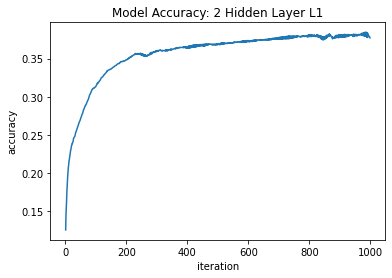

In [ ]:
# plot training history
fig = plt.plot(figsize=(12, 4))
iteration = list(range(1,1000))

# History for accuracy
plt.plot(iteration, acc_history_L1)
plt.title('Model Accuracy: 2 Hidden Layer L1')
plt.ylabel('accuracy')
plt.xlabel('iteration')

plt.savefig("two_hidden_L1.png")

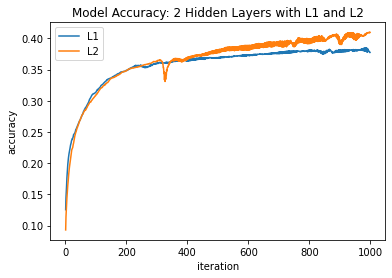

In [ ]:
# plot training history
fig = plt.plot(figsize=(12, 4))
iteration = list(range(1,1000))

# History for accuracy
plt.plot(iteration, acc_history_L1, label = 'L1')
plt.plot(iteration, acc_history_L2, label = 'L2')
#plt.plot(iteration, model_2_hidden.acc_history, label = 'No regularization')
plt.title('Model Accuracy: 2 Hidden Layers with L1 and L2')
plt.ylabel('accuracy')
plt.xlabel('iteration')
plt.legend()
plt.savefig("two_hidden_L1_L2.png")

## Task3.4

The MLP model is modified to train the unormalized data

In [ ]:
class MLP_2:
    ## activation = relu is the same for all hidden layers
    def __init__(self, M = [64], n_hidden = 1, activation = relu, add_bias = True,
                 L1_lambda = 0, L2_lambda = 0.1):
        self.M = M
        self.n_hidden = n_hidden
        self.activation = activation
        self.add_bias = add_bias
        self.L1_lambda = L1_lambda
        self.L2_lambda = L2_lambda
        self.acc_history = []
        self.D = 3072
        self.C = 10





        #### initialize w's and v
        if self.n_hidden > 0:
            params0 = []
            if self.add_bias:
                v = np.random.randn(self.D+1,self.M[0]) *  .005        #  (D+1*M[0])
                params0.append(v)
            else:
                v = np.random.randn(self.D,self.M[0]) *  .005        #  (D+1*M[0])
                params0.append(v)
            
            for i in range(self.n_hidden-1):
              # if self.add_bias:
              #   wi = np.random.randn(self.M[i]+1, self.M[i+1]) * .01  #(M+1*C)\
              # else:
              wi = np.random.randn(self.M[i], self.M[i+1]) * .005
              params0.append(wi)
            # if self.add_bias:
            #   w = np.random.randn(self.M[-1]+1, C) * .01 #(M+1*C)
            # else:
            w = np.random.randn(self.M[-1], self.C)* .005
            params0.append(w)
        else:
            params0 = []
            if self.add_bias:
                v = np.random.randn(self.D+1,self.C) *  .005        #  (D+1*M[0])
                params0.append(v)
            else:
                v = np.random.randn(self.D,self.C) *  .005        #  (D+1*M[0])
                params0.append(v)
        
        self.params = params0


            
    def fit(self, x, y, optimizer): 
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
            N,D = x.shape      #x: 50000, 3073; y: 50000, 1
            C = y.shape[1]
        
        def gradient(x, y, params):
            if self.n_hidden > 0:
                #print(params)
                v = params[0]                     # v: D+1 * M;   w: M+1 x C

                ##### the input layer
                q = np.dot(x, v)                # q: N x M
                # if self.add_bias:
                #   adb = q.shape[0]
                #   q = np.column_stack([q,np.ones(adb)]) #z: N x M+1

                
                ###### the hidden layers
                Z_list = []
                Z_list.append(x)
                z = self.activation(q)            # the first hidden layer
                Z_list.append(z)

                for i in range(self.n_hidden-1):  # second onwards
                  zi = self.activation(np.dot(Z_list[i+1], params[i+1])) 
                  #print(zi)
                  # if self.add_bias:
                  #   adb = zi.shape[0]
                  #   zi = np.column_stack([zi,np.ones(adb)])
                  Z_list.append(zi)

                #print(Z_list)

                ###### the output layer
                u = np.dot(Z_list[-1], params[-1])           # u: N x C; Zlist[-1]: 50000x64, params[-1]:65 x10
                yh = softmax(u)        #yh: N x C
                
                print(yh)
                yh_labels = decoding_labels(self.predict(test_images))
                acc = accuracy(yh_labels, np.argmax(test_labels, axis=1))
                self.acc_history.append(acc)
                print(f'acc: {acc:.4f}')
                print('\n')

                #print(yh.shape)
                dy = yh - y #dy: N * C
                #print(dy)

                dparams = []
                dw = np.dot(Z_list[-1].T, dy)/N #dw: M+1 * C
                if self.L1_lambda > 0:
                    dL1 = np.ones_like(params[-1])
                    dL1[params[-1] < 0] = -1
                    dw += self.L1_lambda * dL1

                if self.L2_lambda > 0:
                    dw += 2*self.L2_lambda * params[-1]
                    #print(dw.shape)
                dparams.append(dw)

                dz_list = []
                dz_list.append(dy)
                #dz_list[self.n_hidden] = dy

                for i in range(self.n_hidden,0,-1):
                  # print(i)
                  dz = np.dot(dz_list[self.n_hidden-i], params[i].T)
                  #dz_list[i-1] = dz
                  dz_list.append(dz)
                  # print(dz.shape)
                  # print(Z_list[i-1].T.shape)
                  # print(Z_list[i].shape)
                  if self.activation == relu:
                      dw = np.dot(Z_list[i-1].T, dz * relu_grad2(Z_list[i]))/N
                  if self.activation == tanh:
                      dw = np.dot(Z_list[i-1].T, dz * tanh_grad(Z_list[i]))/N
                  if self.activation == leaky:
                      dw = np.dot(Z_list[i-1].T, dz * leaky_grad(Z_list[i], 0.1))/N

                  if self.L1_lambda > 0:
                    dL1 = np.ones_like(params[i-1])
                    dL1[params[i-1] < 0] = -1
                    #print(dL1)
                    dw += self.L1_lambda * dL1

                  if self.L2_lambda > 0:
                    dw += 2*self.L2_lambda * params[i-1]

                  dparams.append(dw)

            else:
                v = params[0]                     # v: D+1 * M;   w: M+1 x C
                q = np.dot(x, v)                # q: N x M
                yh = softmax(q)
                print(yh) 

                yh_labels = decoding_labels(self.predict(test_images))
                acc = accuracy(yh_labels, np.argmax(test_labels, axis=1))
                self.acc_history.append(acc)
                print(f'acc: {acc:.4f}')
                print('\n')

                dy = yh - y 
                dparams = []
                dw = np.dot(x.T, dy)/N #dw: M+1 * C
                if self.L1_lambda > 0:
                    dL1 = np.ones_like(v)
                    dL1[v < 0] = -1
                    dw += self.L1_lambda * dL1

                if self.L2_lambda > 0:
                    dw += 2*self.L2_lambda * v
                dparams.append(dw)
  
            return dparams        

        self.params = optimizer.run(gradient, x, y, self.params)


        return self
    
    def predict(self, x):
        if self.add_bias:
          N = x.shape[0]
          x = np.column_stack([x,np.ones(N)])
        
        
        # v, w = self.params
        # z = self.activation(np.dot(x, v)) #N x M
        # if self.add_bias:
        #   n = z.shape[0]
        #   z = np.column_stack([z, np.ones(n)])
        
        
        zi = x
        for i in (range(self.n_hidden)):
          # print(self.params[i].shape)
          zi = self.activation(np.dot(zi, self.params[i]))

          # if self.add_bias:
          #   n = zi.shape[0]
          #   zi = np.column_stack([zi, np.ones(n)])
          # print(zi.shape)
        yh = softmax(np.dot(zi, self.params[-1]))#N * C

        
        return yh

In [ ]:
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels)=cifar10.load_data()

print('Shape of x_train is {}'.format(train_images.shape))
print('Shape of x_test is {}'.format(test_images.shape)) 
print('Shape of y_train is {}'.format(train_labels.shape))
print('Shape of y_test is {}'.format(test_labels.shape))


Shape of x_train is (50000, 32, 32, 3)
Shape of x_test is (10000, 32, 32, 3)
Shape of y_train is (50000, 1)
Shape of y_test is (10000, 1)


reshape the images (X)

In [ ]:
train_images = (train_images.reshape(train_images.shape[0], -1).astype(np.float32)) 
test_images = (test_images.reshape(test_images.shape[0], -1).astype(np.float32))


train_images -= np.mean(train_images)
test_images -= np.mean(train_images)

In [ ]:
print(train_images.shape) # (50000, 3072)
print(test_images.shape)  # (10000, 3072)

(50000, 3072)
(10000, 3072)


In [ ]:
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)
print(train_labels.shape) # (50000, 10)
print(test_labels.shape)  # (50000, 10)

(50000, 10)
(10000, 10)


In [ ]:
model3 = MLP_2(M=[256,256], n_hidden = 2, activation = relu, L2_lambda=0)
optimizer = GradientDescent(learning_rate=.02, max_iters=200)

In [ ]:
yh_3 = model3.fit(train_images, train_labels, optimizer)

iteration: 1
[[0.09403287 0.10315644 0.11013043 ... 0.09777895 0.10054217 0.10324716]
 [0.09075572 0.1015774  0.10005935 ... 0.09338225 0.10842417 0.11314006]
 [0.10010887 0.09709319 0.10625364 ... 0.09374344 0.0987863  0.10135124]
 ...
 [0.09310016 0.10493008 0.10782066 ... 0.09811648 0.09547103 0.10385243]
 [0.09923096 0.09642446 0.09909487 ... 0.09187112 0.10016013 0.10390428]
 [0.09495159 0.09293104 0.10225365 ... 0.10084507 0.10360035 0.10763202]]
acc: 0.0989


iteration: 2
[[0.09077873 0.10448694 0.10987129 ... 0.09807358 0.09430771 0.10105501]
 [0.09276574 0.10361064 0.09781018 ... 0.09151741 0.11273666 0.11365944]
 [0.10522981 0.0996446  0.10044909 ... 0.09254401 0.10711008 0.11253509]
 ...
 [0.09580395 0.10817609 0.10450531 ... 0.09565012 0.10121062 0.11223723]
 [0.111178   0.0963623  0.09381391 ... 0.09020224 0.11606044 0.10633831]
 [0.09847275 0.09420842 0.1000031  ... 0.10236317 0.10486819 0.11137663]]
acc: 0.1230


iteration: 3
[[0.08626132 0.10547219 0.10968535 ... 0.0989

In [ ]:
yh_3 = model3.predict(test_images)

In [ ]:
yh = decoding_labels(yh_3)

In [ ]:
yh

array([0., 0., 0., ..., 5., 5., 0.])

In [ ]:
y = np.argmax(test_labels, axis=1)

In [ ]:
y

array([3, 8, 8, ..., 5, 1, 7])

In [ ]:
acc = accuracy (yh, y)

In [ ]:
acc

0.1793

In [ ]:
acc_history = model3.acc_history

In [ ]:
len(acc_history)

199

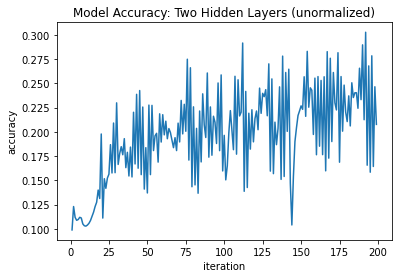

In [ ]:
# plot training history
fig = plt.plot(figsize=(12, 4))
iteration = list(range(1,200))

# History for accuracy
plt.plot(iteration, acc_history)
plt.title('Model Accuracy: Two Hidden Layers (unormalized)')
plt.ylabel('accuracy')
plt.xlabel('iteration')

plt.savefig("unorm.png")

# CNN

## 3.5

In [ ]:
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels)=cifar10.load_data()

print('Shape of x_train is {}'.format(train_images.shape))
print('Shape of x_test is {}'.format(test_images.shape)) 
print('Shape of y_train is {}'.format(train_labels.shape))
print('Shape of y_test is {}'.format(test_labels.shape))

170498071/170498071 [==============================] - 6s 0us/step
Shape of x_train is (50000, 32, 32, 3)
Shape of x_test is (10000, 32, 32, 3)
Shape of y_train is (50000, 1)
Shape of y_test is (10000, 1)


In [ ]:
# Normalize the images
train_images = (train_images / 255) 
test_images = (test_images / 255)

# Reshape the images.
#train_images = np.expand_dims(train_images, -1)
#test_images = np.expand_dims(test_images, -1)

print(train_images.shape) # (50000, 32, 32, 3, 1)
print(test_images.shape)  # (10000, 32, 32, 3, 1)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)
print(train_labels.shape) # (50000, 10)
print(test_labels.shape)  # (50000, 10)

(50000, 10)
(10000, 10)


In [ ]:
input_shape = (32,32,3)
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (4,4), input_shape = input_shape, strides = 1, activation  = 'relu')) 
model.add(Conv2D(filters = 64, kernel_size = (4,4), input_shape = input_shape, strides = 1, activation  = 'relu'))

#model.add(Dropout(0.25)) # randomly sets input units to 0 with a frequency of rate at each step during training time, to avoid overfitting
model.add(Flatten()) # Flatten serves as a connection between the convolution and dense layers
model.add(Dense(256, activation='relu')) 
model.add(Dense(256, activation='relu')) 
model.add(Dense(10, activation='softmax')) 

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 29, 29, 64)        3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        65600     
                                                                 
 flatten (Flatten)           (None, 43264)             0         
                                                                 
 dense (Dense)               (None, 256)               11075840  
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 11,212,938
Trainable params: 11,212,938
No

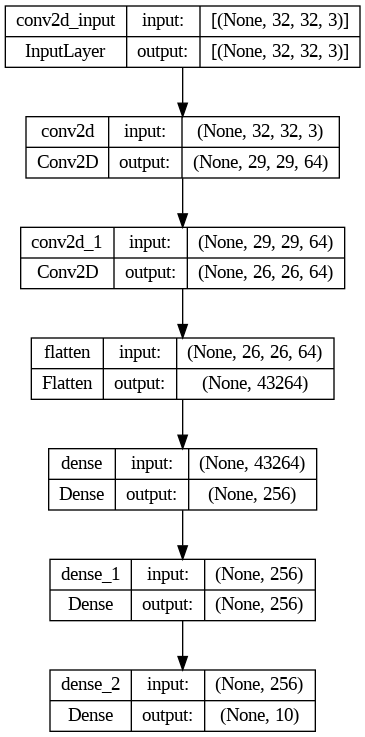

In [ ]:
plot_model(model, "model.png", show_shapes=True)

In [ ]:
epochs = 11

checkpoint = ModelCheckpoint("best_model.hdf5",  # saving the best model
                            monitor='val_loss', verbose=1,
                            save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)). 
                            save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                            mode='auto',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                            save_freq = 'epoch')       # When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.


In [ ]:
# Fitting the model
history = model.fit(
  train_images,
  train_labels, 
  epochs=epochs,                # number of training epochs
  batch_size=2000,
  verbose = 1,
  validation_data=(test_images, test_labels), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings 
)

Epoch 1/11
25/25 [==============================] - ETA: 0s - loss: 2.0508 - accuracy: 0.2577
Epoch 1: val_loss improved from inf to 1.68981, saving model to best_model.hdf5
25/25 [==============================] - 17s 176ms/step - loss: 2.0508 - accuracy: 0.2577 - val_loss: 1.6898 - val_accuracy: 0.4011
Epoch 2/11
25/25 [==============================] - ETA: 0s - loss: 1.5358 - accuracy: 0.4526
Epoch 2: val_loss improved from 1.68981 to 1.43610, saving model to best_model.hdf5
25/25 [==============================] - 4s 159ms/step - loss: 1.5358 - accuracy: 0.4526 - val_loss: 1.4361 - val_accuracy: 0.4811
Epoch 3/11
25/25 [==============================] - ETA: 0s - loss: 1.3592 - accuracy: 0.5153
Epoch 3: val_loss improved from 1.43610 to 1.30790, saving model to best_model.hdf5
25/25 [==============================] - 4s 164ms/step - loss: 1.3592 - accuracy: 0.5153 - val_loss: 1.3079 - val_accuracy: 0.5299
Epoch 4/11
25/25 [==============================] - ETA: 0s - loss: 1.2157 -

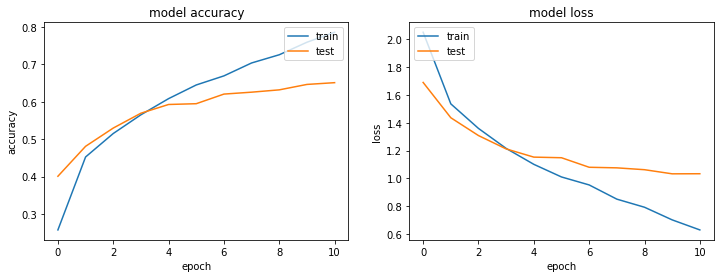

In [ ]:
# plot training history
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# History for accuracy
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'test'], loc='upper right')

# History for loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Define confusion matrix
def calc_error(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(predictions == labels)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([10, 10], np.float32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1
    
    return error, confusions
     

313/313 [==============================] - 1s 3ms/step
Test error: 34.9%


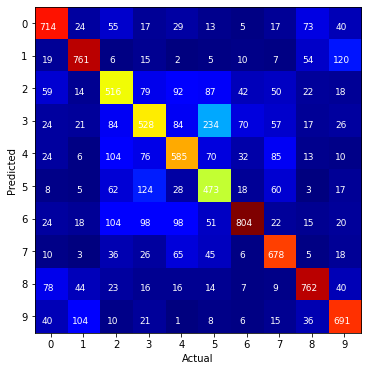

In [ ]:
# Model predictions and confusion matrix
test_predictions          = np.argmax(model.predict(test_images),1)
test_error, test_conf_mat = calc_error(test_predictions, np.argmax(test_labels,1))
print('Test error: %.1f%%' % test_error)

plt.figure(figsize=(6, 6))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.imshow(test_conf_mat, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(test_conf_mat):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')
     

In [ ]:
evaluation = model.evaluate(test_images, test_labels)
print('Test Accuracy: {}'.format(evaluation[1]))

313/313 [==============================] - 1s 4ms/step - loss: 1.0335 - accuracy: 0.6512
Test Accuracy: 0.651199996471405


## 3.6

load a pre-trained model from keras ResNet50: the model only has 1 dense at the end. inlclude_top=False removes the last dense layer


# The Effect of Width

In [ ]:
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.applications import ResNet50
from keras.applications import VGG16
from keras.datasets import cifar10
from keras.utils import to_categorical

# Load the CIFAR-10 dataset and preprocess it
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Load the ResNet50 model and freeze all its convolutional layers
resnet_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in resnet_model.layers:
    layer.trainable = False

In [ ]:
# Load the ResNet50 model and freeze all its convolutional layers
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in resnet_model.layers:
    layer.trainable = False
# Remove the fully connected layers from the ResNet50 model
x = Flatten()(resnet_model.output)

# Add some new fully connected layers
x = Dense(512*2, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
# Add the final output layer with 10 neurons (one for each class)
predictions = Dense(10, activation='softmax')(x)
# Create the new model
model = Model(inputs=resnet_model.input, outputs=predictions)

In [ ]:
checkpoint = ModelCheckpoint(filepath="cifar10.h5",
                                              monitor="val_acc",
                                              mode="max",
                                              save_best_only=True,
                                              )

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train only the fully connected layers of the pre-trained model on the CIFAR-10 dataset
history2 = model.fit(train_images, train_labels, batch_size=64, epochs=50, verbose=1,
                        validation_data=(test_images, test_labels),
                        callbacks=[checkpoint])

In [ ]:
# plot training history
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# History for accuracy
axs[0].plot(history2.history['accuracy'])
axs[0].plot(history2.history['val_accuracy'])
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'test'], loc='upper right')

# History for loss
axs[1].plot(history2.history['loss'])
axs[1].plot(history2.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'test'], loc='upper left')
plt.show()
fig.savefig('/fig/3.6.pdf', dpi=300)

In [ ]:
evaluation = model.evaluate(test_images, test_labels)
print('Test Accuracy: {}'.format(evaluation[1]))

## 2 hidden layers (64, 64)

In [ ]:
model_6464 = MLP_2(M=[64, 64], n_hidden = 2, L2_lambda = 0)
optimizer = GradientDescent(learning_rate=.05, max_iters=1000)

In [ ]:
yh_6464 = model_6464.fit(train_images, train_labels, optimizer)

Streaming output truncated to the last 5000 lines.
 [0.18558299 0.08516314 0.01766353 ... 0.01662593 0.3981008  0.25500491]
 [0.24578124 0.03044711 0.05510783 ... 0.04265919 0.48340938 0.06899543]
 [0.10774245 0.037801   0.07615072 ... 0.28482812 0.05568283 0.16604287]]
acc: 0.3476


iteration: 546
[[0.00208805 0.06438007 0.04500849 ... 0.04133647 0.00180601 0.01486692]
 [0.03632482 0.53218547 0.02199027 ... 0.01167979 0.15297564 0.13879522]
 [0.03364564 0.16801994 0.00453237 ... 0.0171411  0.12164955 0.60692229]
 ...
 [0.12157404 0.12798495 0.01111973 ... 0.01284411 0.34577234 0.34276287]
 [0.14030757 0.07337748 0.03160705 ... 0.03339618 0.49993025 0.14470196]
 [0.05605739 0.08649632 0.03711794 ... 0.19503854 0.04467309 0.30897818]]
acc: 0.3554


iteration: 547
[[0.00345188 0.04078579 0.07322136 ... 0.06035567 0.00219586 0.01148372]
 [0.08541023 0.32593322 0.05062706 ... 0.02146942 0.26261655 0.11353374]
 [0.08685182 0.1111605  0.01092155 ... 0.03097623 0.21108614 0.48945574]
 ...
 [0

In [ ]:
yh_6464 = model_6464.predict(test_images)

In [ ]:
yh = decoding_labels(yh_6464)

In [ ]:
yh

array([3., 9., 8., ..., 5., 6., 7.])

In [ ]:
y = np.argmax(test_labels, axis=1)

In [ ]:
y

array([3, 8, 8, ..., 5, 1, 7])

In [ ]:
acc = accuracy (yh, y)

In [ ]:
acc

0.3962

In [ ]:
acc_history2 = model_6464.acc_history

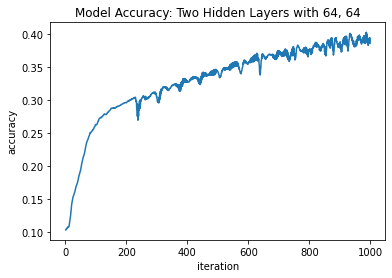

In [ ]:
# plot training history
fig = plt.plot(figsize=(12, 4))
iteration = list(range(1,1000))

# History for accuracy
plt.plot(iteration, acc_history2)
plt.title('Model Accuracy: Two Hidden Layers with 64, 64')
plt.ylabel('accuracy')
plt.xlabel('iteration')

plt.savefig("two_hidden6464.png")